In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve

Load Dataset

In [44]:
train_feature = pd.read_csv('training_set_features.csv')
train_label = pd.read_csv('training_set_labels.csv')
test = pd.read_csv('test_set_features.csv')

In [45]:
train = train_feature.merge(train_label, how='inner',on='respondent_id')
train.head()

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0   
1                          0.0                      1.0   
2                          0.0                      0.0   
3                          1.0                      0.0   
4                          1.0                      0.0   

   behavioral_touch_face  ...  rent_or_own   employment_status  \
0                    1.0  ...          Own  Not in Labor Force   
1                    1.0  ...         Rent            Employed   
2                    0.0  ...          Own            Employed   
3                    0.0  ...         Rent  Not in Labor Force   
4                    1.0  ...          Own            Employed   

   hhs_geo_region                census_msa  household_adults  \
0        oxchjgsf                   Non-MSA               0.0   
1        bhuqouqj  MSA, Not Principle  City               0.0   
2        qufhixun  MSA, Not Principle  City               2.0   
3        lrircsnp       MSA, Principle City               0.0   
4        qufhixun  MSA, Not Principle  City               1.0   

   household_children  employment_industry  employment_occupation  \
0                 0.0                  NaN                    NaN   
1                 0.0             pxcmvdjn               xgwztkwe   
2                 0.0             rucpziij               xtkaffoo   
3                 0.0                  NaN                    NaN   
4                 0.0             wxleyezf               emcorrxb   

   h1n1_vaccine  seasonal_vaccine  
0             0                 0  
1             0                 1  
2             0                 0  
3             0                 1  
4             0                 0  

[5 rows x 38 columns]

EDA

In [46]:
len(train)

26707

In [47]:
train.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [48]:
train.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

In [49]:
oj_list=[]
cat_list=[]
for i in train.columns:
    if train[i].dtype == object:
        oj_list.append(i)
        train[i] = train[i].fillna('Unknown')
    elif i != 'respondent_id':
        cat_list.append(i)
        train[i] = train[i].fillna(-1)

In [50]:
for j in test.columns:
    if test[j].dtype == object:
        test[j] = test[j].fillna('Unknown')
    else:
        test[j] = test[j].fillna(-1)

EDA

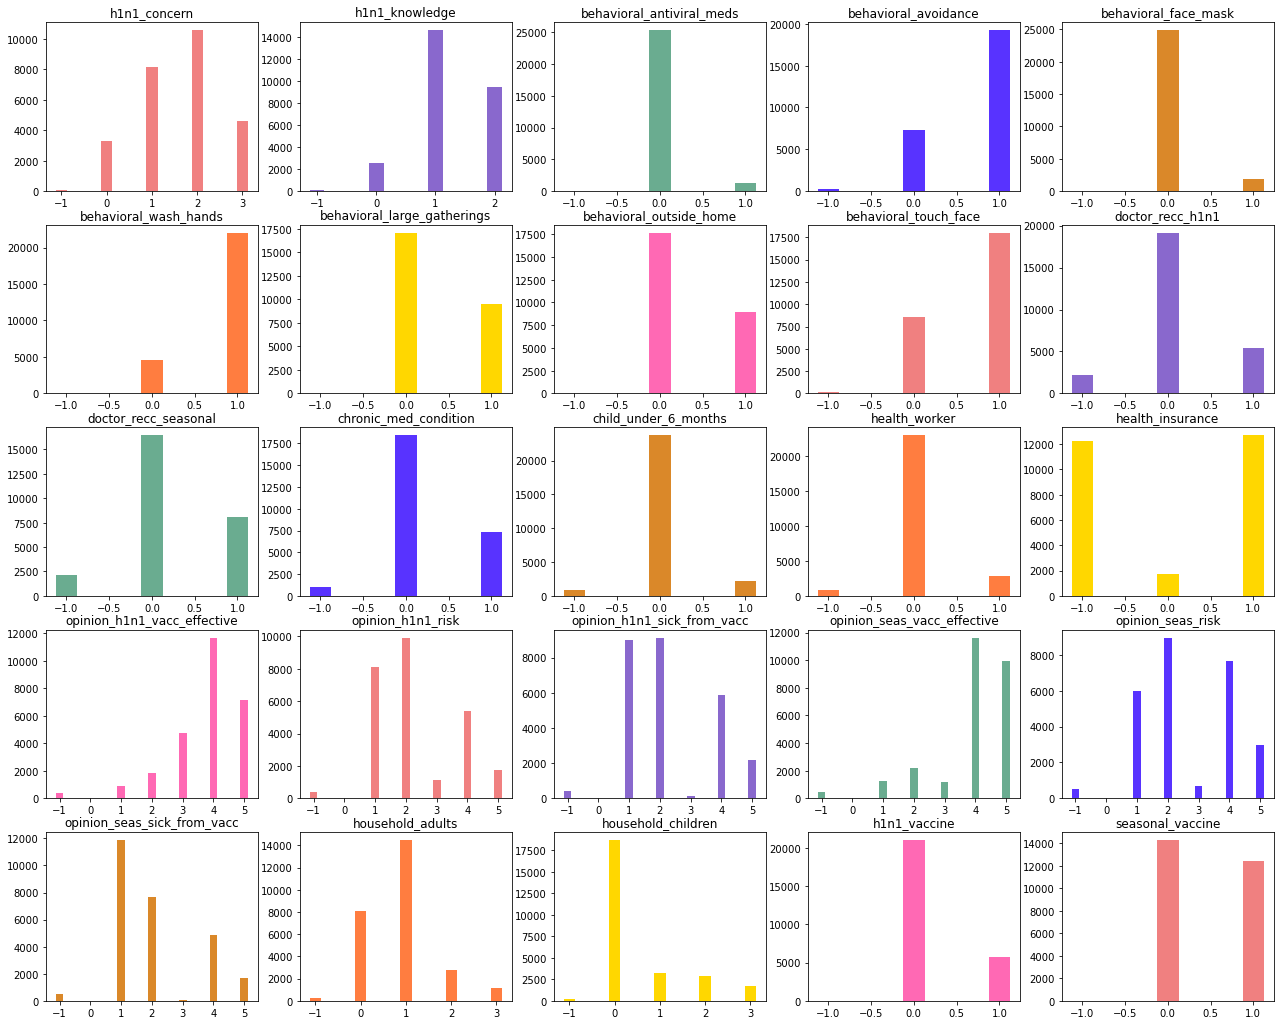

In [51]:
#cat_cols visualization
nrows = 5
ncols = int(len(cat_list)/nrows)
color_list = ["#F08080","#8968CD","#6aac90","#5833ff","#da8829","#FF7D40","#FFD700","#FF69B4"]
fig, axes = plt.subplots(nrows, ncols, figsize = (22,18))
axes = axes.flatten()
for count, p in enumerate(cat_list):
    plt.sca(axes[count])
    plt.title(p)
    bins = np.arange(-1,max(train[p]+0.5),0.25)-0.125
    plt.hist(train[p], bins=bins, color=color_list[count%len(color_list)])

Some Quick Observation:

    a. In the health_insurance column, the proportion of missing values is huge.
    b. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine.
    c. Most respondents do not take antiviral medications before.
    d. Most respondents do not have children.
    e. Most respondents in this dataset wash their hands but do not wear a face mask.
    f. Most respondents in this dataset are not health-related workers
    g. Most respondents in this dataset think the h1n1 vaccine does have a somewhat or great effect on h1n1. 
    h. Most respondents think the risk of getting sick with H1N1 flu without a vaccine is low.
    i. Most respondents think the seasonal flu vaccine does have a somewhat or great effect on flu.
    j. Different from (h), Only half of the respondents think the risk of getting sick with seasonal flu without a vaccine is low.
    k. Most respondents do not think they will get sick after taking the vaccine. In other words, those who took the vaccine believed in it.

<AxesSubplot:xlabel='sex', ylabel='count'>

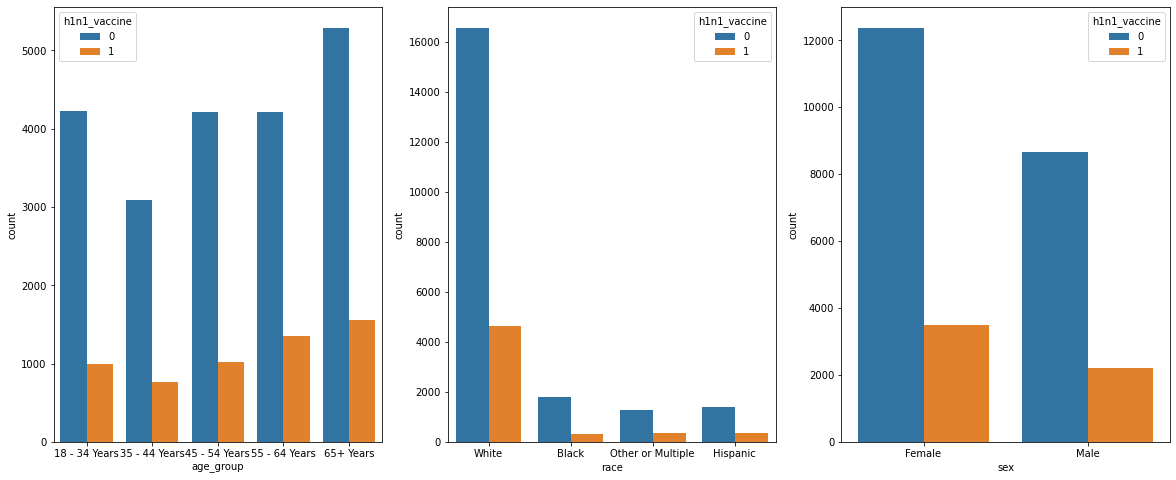

In [58]:
#Interested in age_group, race, and sex to vaccines.
fig, axes = plt.subplots(1, 3, figsize = (20,8))
sns.countplot(x='age_group', hue='h1n1_vaccine', data = train, order=['18 - 34 Years','35 - 44 Years','45 - 54 Years','55 - 64 Years','65+ Years'],ax=axes[0])
sns.countplot(x='race', hue='h1n1_vaccine', data = train,ax=axes[1])
sns.countplot(x='sex', hue='h1n1_vaccine', data = train,ax=axes[2])

Age_group:

    a. 65+ group is slightly more than the other groups. 
    b. 35-44 group is slightly less than the other group. 
    c. Age above 55 years seems more prefer to take the h1n1 vaccine.
    

Race:
    
    a. Most respondents in this dataset are white and extremely imbalanced.

Sex:
    
    a. Female is slightly more than male in this dataset. 
    b. However there is no big difference in h1n1 vaccine proportion.

<AxesSubplot:xlabel='sex', ylabel='count'>

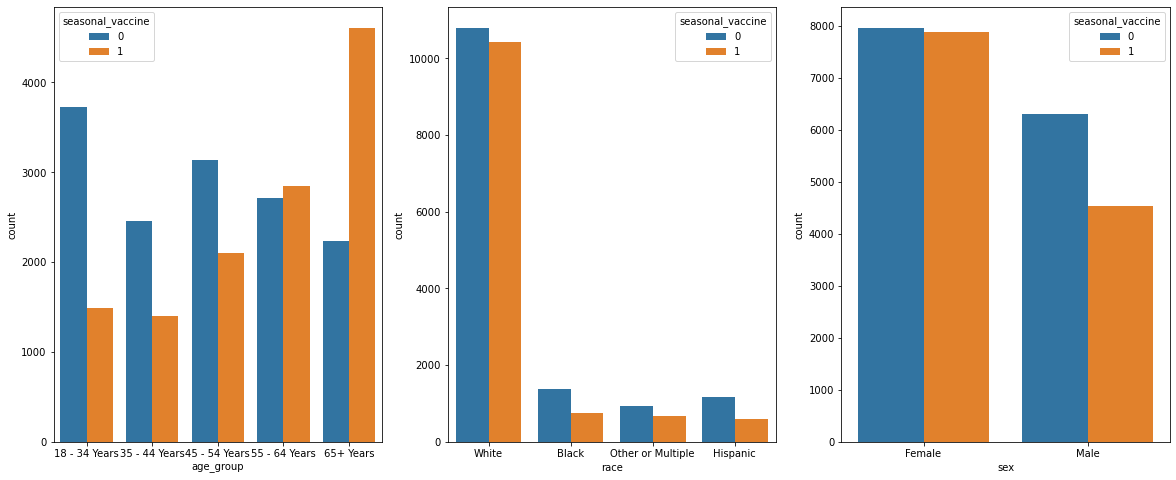

In [62]:
fig, axes = plt.subplots(1, 3, figsize = (20,8))
sns.countplot(x='age_group', hue='seasonal_vaccine', data = train, order=['18 - 34 Years','35 - 44 Years','45 - 54 Years','55 - 64 Years','65+ Years'],ax=axes[0])
sns.countplot(x='race', hue='seasonal_vaccine', data = train,ax=axes[1])
sns.countplot(x='sex', hue='seasonal_vaccine', data = train,ax=axes[2])

Age_group:

    a. There are more and more respondents taking a seasonal vaccine as their age increases.
    b. More than half of the respondents whose age is above 55 took the seasonal vaccine.
    c. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine in each age group.

Race:
    
    a. Most respondents in this dataset are white and extremely imbalanced.
    b. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine no matter their race.

Sex:
    
    a. Females are more willing to take the seasonal vaccine.
    b. Respondents are more willing to take the seasonal vaccine than the h1n1 vaccine no matter their sex.

Prepare the data for our model.

In [13]:
for i in oj_list:
    le = LabelEncoder()
    train[i]=le.fit_transform(train[i])
    test[i]=le.fit_transform(test[i])

In [14]:
for i in train.columns:
    train[i] = train[i].astype(int)

In [15]:
for j in test.columns:
    test[j] = test[j].astype(int)

In [16]:
X = train.drop(['respondent_id','h1n1_vaccine','seasonal_vaccine'],axis=1)
y1 = train['h1n1_vaccine']
y2 = train['seasonal_vaccine']

In [17]:
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state = 42)
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(X_train, y1_train, y2_train, test_size=0.1, random_state = 42)

Modeling(catboost model + gridsearch)

In [18]:
from catboost import CatBoostClassifier, Pool

cat_model = CatBoostClassifier()

params = {'iterations': [400, 600, 1000],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 6],
        'l2_leaf_reg': [0.1, 0.5, 1, 3],
        'verbose':[10],
        'random_seed': [42],
        'loss_function':['Logloss'],
        'eval_metric':['AUC:hints=skip_train~false']}

scorer = make_scorer(roc_auc_score)

cat_grid = GridSearchCV(estimator=cat_model, param_grid=params, scoring=scorer, cv=5)

In [19]:
cat_grid.fit(X_train, y1_train, eval_set=(X_val,y1_val))
best_param_h1n1 = cat_grid.best_params_
best_param_h1n1

0:	learn: 0.8168097	test: 0.8180980	best: 0.8180980 (0)	total: 63.1ms	remaining: 25.2s
10:	learn: 0.8450873	test: 0.8424058	best: 0.8424134 (9)	total: 100ms	remaining: 3.54s
20:	learn: 0.8517613	test: 0.8494668	best: 0.8494668 (20)	total: 140ms	remaining: 2.53s
30:	learn: 0.8565709	test: 0.8534143	best: 0.8534143 (30)	total: 180ms	remaining: 2.14s
40:	learn: 0.8605089	test: 0.8574108	best: 0.8574108 (40)	total: 220ms	remaining: 1.93s
50:	learn: 0.8636975	test: 0.8601920	best: 0.8601920 (50)	total: 259ms	remaining: 1.77s
60:	learn: 0.8661742	test: 0.8621168	best: 0.8621168 (60)	total: 300ms	remaining: 1.67s
70:	learn: 0.8680902	test: 0.8629846	best: 0.8630430 (69)	total: 339ms	remaining: 1.57s
80:	learn: 0.8701584	test: 0.8639070	best: 0.8639070 (80)	total: 379ms	remaining: 1.49s
90:	learn: 0.8723502	test: 0.8651458	best: 0.8651458 (90)	total: 415ms	remaining: 1.41s
100:	learn: 0.8742953	test: 0.8661507	best: 0.8661507 (100)	total: 453ms	remaining: 1.34s
110:	learn: 0.8766595	test: 0.86

120:	learn: 0.8797194	test: 0.8689370	best: 0.8689370 (120)	total: 505ms	remaining: 1.16s
130:	learn: 0.8816305	test: 0.8693029	best: 0.8693029 (130)	total: 544ms	remaining: 1.12s
140:	learn: 0.8838431	test: 0.8694961	best: 0.8696117 (135)	total: 584ms	remaining: 1.07s
150:	learn: 0.8855158	test: 0.8699102	best: 0.8699102 (150)	total: 622ms	remaining: 1.02s
160:	learn: 0.8871576	test: 0.8702253	best: 0.8702253 (160)	total: 662ms	remaining: 982ms
170:	learn: 0.8886273	test: 0.8700767	best: 0.8702253 (160)	total: 698ms	remaining: 935ms
180:	learn: 0.8900340	test: 0.8705252	best: 0.8705252 (180)	total: 740ms	remaining: 896ms
190:	learn: 0.8916106	test: 0.8707297	best: 0.8707297 (190)	total: 780ms	remaining: 854ms
200:	learn: 0.8929886	test: 0.8713904	best: 0.8713904 (200)	total: 819ms	remaining: 811ms
210:	learn: 0.8942993	test: 0.8719927	best: 0.8719927 (210)	total: 860ms	remaining: 771ms
220:	learn: 0.8954856	test: 0.8720117	best: 0.8721781 (216)	total: 902ms	remaining: 730ms
230:	learn

200:	learn: 0.8957641	test: 0.8699191	best: 0.8711770 (184)	total: 804ms	remaining: 796ms
210:	learn: 0.8970733	test: 0.8699077	best: 0.8711770 (184)	total: 842ms	remaining: 754ms
220:	learn: 0.8981842	test: 0.8701097	best: 0.8711770 (184)	total: 881ms	remaining: 714ms
230:	learn: 0.8994265	test: 0.8699700	best: 0.8711770 (184)	total: 920ms	remaining: 673ms
240:	learn: 0.9006787	test: 0.8695138	best: 0.8711770 (184)	total: 958ms	remaining: 632ms
250:	learn: 0.9016671	test: 0.8694351	best: 0.8711770 (184)	total: 998ms	remaining: 592ms
260:	learn: 0.9026643	test: 0.8692699	best: 0.8711770 (184)	total: 1.04s	remaining: 552ms
270:	learn: 0.9037877	test: 0.8689917	best: 0.8711770 (184)	total: 1.08s	remaining: 512ms
280:	learn: 0.9048097	test: 0.8687058	best: 0.8711770 (184)	total: 1.11s	remaining: 472ms
290:	learn: 0.9058630	test: 0.8684250	best: 0.8711770 (184)	total: 1.16s	remaining: 433ms
300:	learn: 0.9068149	test: 0.8686016	best: 0.8711770 (184)	total: 1.19s	remaining: 393ms
310:	learn

310:	learn: 0.9560526	test: 0.8624522	best: 0.8696434 (170)	total: 1.61s	remaining: 461ms
320:	learn: 0.9574551	test: 0.8614739	best: 0.8696434 (170)	total: 1.66s	remaining: 409ms
330:	learn: 0.9590382	test: 0.8611741	best: 0.8696434 (170)	total: 1.71s	remaining: 357ms
340:	learn: 0.9603260	test: 0.8606646	best: 0.8696434 (170)	total: 1.76s	remaining: 306ms
350:	learn: 0.9616797	test: 0.8608882	best: 0.8696434 (170)	total: 1.82s	remaining: 254ms
360:	learn: 0.9630524	test: 0.8603317	best: 0.8696434 (170)	total: 1.87s	remaining: 202ms
370:	learn: 0.9644252	test: 0.8599226	best: 0.8696434 (170)	total: 1.92s	remaining: 150ms
380:	learn: 0.9656965	test: 0.8602872	best: 0.8696434 (170)	total: 1.97s	remaining: 98.2ms
390:	learn: 0.9665931	test: 0.8597244	best: 0.8696434 (170)	total: 2.02s	remaining: 46.5ms
399:	learn: 0.9674200	test: 0.8600141	best: 0.8696434 (170)	total: 2.06s	remaining: 0us

bestTest = 0.869643438
bestIteration = 170

Shrink model to first 171 iterations.
0:	learn: 0.82237

390:	learn: 0.9667122	test: 0.8673044	best: 0.8715086 (260)	total: 2s	remaining: 46ms
399:	learn: 0.9676212	test: 0.8669766	best: 0.8715086 (260)	total: 2.04s	remaining: 0us

bestTest = 0.8715085786
bestIteration = 260

Shrink model to first 261 iterations.
0:	learn: 0.8274780	test: 0.8161229	best: 0.8161229 (0)	total: 3.8ms	remaining: 1.52s
10:	learn: 0.8584760	test: 0.8462047	best: 0.8462047 (10)	total: 55ms	remaining: 1.95s
20:	learn: 0.8680821	test: 0.8528673	best: 0.8532548 (19)	total: 104ms	remaining: 1.88s
30:	learn: 0.8771986	test: 0.8585644	best: 0.8585644 (30)	total: 157ms	remaining: 1.87s
40:	learn: 0.8824778	test: 0.8608132	best: 0.8611855 (38)	total: 206ms	remaining: 1.8s
50:	learn: 0.8882976	test: 0.8627876	best: 0.8627876 (50)	total: 256ms	remaining: 1.75s
60:	learn: 0.8919980	test: 0.8622566	best: 0.8627876 (50)	total: 306ms	remaining: 1.7s
70:	learn: 0.8958622	test: 0.8623595	best: 0.8630621 (65)	total: 357ms	remaining: 1.65s
80:	learn: 0.8994612	test: 0.8623633	best: 

50:	learn: 0.8521033	test: 0.8521114	best: 0.8522460 (49)	total: 202ms	remaining: 1.38s
60:	learn: 0.8543670	test: 0.8542039	best: 0.8543450 (57)	total: 241ms	remaining: 1.34s
70:	learn: 0.8573189	test: 0.8563740	best: 0.8563740 (70)	total: 283ms	remaining: 1.31s
80:	learn: 0.8600345	test: 0.8587054	best: 0.8587054 (80)	total: 326ms	remaining: 1.28s
90:	learn: 0.8614081	test: 0.8599290	best: 0.8599290 (90)	total: 370ms	remaining: 1.26s
100:	learn: 0.8630745	test: 0.8610051	best: 0.8610165 (99)	total: 411ms	remaining: 1.22s
110:	learn: 0.8643140	test: 0.8617700	best: 0.8618932 (109)	total: 449ms	remaining: 1.17s
120:	learn: 0.8658992	test: 0.8624522	best: 0.8624522 (120)	total: 489ms	remaining: 1.13s
130:	learn: 0.8670098	test: 0.8633645	best: 0.8633645 (130)	total: 528ms	remaining: 1.08s
140:	learn: 0.8682259	test: 0.8639731	best: 0.8639731 (140)	total: 568ms	remaining: 1.04s
150:	learn: 0.8691546	test: 0.8644076	best: 0.8645753 (147)	total: 606ms	remaining: 999ms
160:	learn: 0.8701815

140:	learn: 0.8732816	test: 0.8625678	best: 0.8625678 (140)	total: 560ms	remaining: 1.03s
150:	learn: 0.8743657	test: 0.8633746	best: 0.8633746 (150)	total: 598ms	remaining: 986ms
160:	learn: 0.8752821	test: 0.8635970	best: 0.8635970 (160)	total: 636ms	remaining: 943ms
170:	learn: 0.8763049	test: 0.8637380	best: 0.8637596 (165)	total: 676ms	remaining: 906ms
180:	learn: 0.8773415	test: 0.8644152	best: 0.8644355 (179)	total: 716ms	remaining: 866ms
190:	learn: 0.8783491	test: 0.8650187	best: 0.8650670 (189)	total: 758ms	remaining: 829ms
200:	learn: 0.8791394	test: 0.8654875	best: 0.8654875 (200)	total: 797ms	remaining: 789ms
210:	learn: 0.8801033	test: 0.8660669	best: 0.8660669 (210)	total: 835ms	remaining: 748ms
220:	learn: 0.8812495	test: 0.8665510	best: 0.8665510 (220)	total: 875ms	remaining: 709ms
230:	learn: 0.8822947	test: 0.8670604	best: 0.8670948 (229)	total: 916ms	remaining: 670ms
240:	learn: 0.8831739	test: 0.8677338	best: 0.8677338 (240)	total: 953ms	remaining: 629ms
250:	learn

250:	learn: 0.9118932	test: 0.8678774	best: 0.8679206 (236)	total: 1.2s	remaining: 711ms
260:	learn: 0.9136299	test: 0.8677402	best: 0.8680896 (253)	total: 1.25s	remaining: 664ms
270:	learn: 0.9155525	test: 0.8678571	best: 0.8680896 (253)	total: 1.29s	remaining: 616ms
280:	learn: 0.9171614	test: 0.8680248	best: 0.8680896 (253)	total: 1.34s	remaining: 568ms
290:	learn: 0.9190451	test: 0.8677173	best: 0.8680896 (253)	total: 1.39s	remaining: 521ms
300:	learn: 0.9206375	test: 0.8677389	best: 0.8680896 (253)	total: 1.44s	remaining: 474ms
310:	learn: 0.9223952	test: 0.8681798	best: 0.8681798 (310)	total: 1.49s	remaining: 427ms
320:	learn: 0.9239193	test: 0.8678456	best: 0.8681798 (310)	total: 1.54s	remaining: 379ms
330:	learn: 0.9254546	test: 0.8678761	best: 0.8681798 (310)	total: 1.58s	remaining: 331ms
340:	learn: 0.9269250	test: 0.8681493	best: 0.8681798 (310)	total: 1.63s	remaining: 283ms
350:	learn: 0.9282506	test: 0.8680858	best: 0.8681798 (310)	total: 1.68s	remaining: 235ms
360:	learn:

340:	learn: 0.9280598	test: 0.8691136	best: 0.8699242 (218)	total: 1.67s	remaining: 288ms
350:	learn: 0.9294736	test: 0.8693614	best: 0.8699242 (218)	total: 1.72s	remaining: 239ms
360:	learn: 0.9308539	test: 0.8694872	best: 0.8699242 (218)	total: 1.76s	remaining: 191ms
370:	learn: 0.9321134	test: 0.8695532	best: 0.8699242 (218)	total: 1.81s	remaining: 142ms
380:	learn: 0.9331593	test: 0.8696244	best: 0.8699242 (218)	total: 1.86s	remaining: 92.8ms
390:	learn: 0.9343043	test: 0.8700233	best: 0.8700640 (388)	total: 1.91s	remaining: 44ms
399:	learn: 0.9353234	test: 0.8699789	best: 0.8700640 (388)	total: 1.95s	remaining: 0us

bestTest = 0.870063984
bestIteration = 388

Shrink model to first 389 iterations.
0:	learn: 0.8279813	test: 0.8171629	best: 0.8171629 (0)	total: 3.98ms	remaining: 1.59s
10:	learn: 0.8550974	test: 0.8449125	best: 0.8449125 (10)	total: 49.9ms	remaining: 1.76s
20:	learn: 0.8597922	test: 0.8500182	best: 0.8500182 (20)	total: 98.1ms	remaining: 1.77s
30:	learn: 0.8651129	tes

40:	learn: 0.8399644	test: 0.8395592	best: 0.8399829 (38)	total: 159ms	remaining: 1.39s
50:	learn: 0.8409381	test: 0.8400413	best: 0.8404612 (45)	total: 201ms	remaining: 1.38s
60:	learn: 0.8416032	test: 0.8402935	best: 0.8404612 (45)	total: 240ms	remaining: 1.33s
70:	learn: 0.8421539	test: 0.8407573	best: 0.8407954 (69)	total: 277ms	remaining: 1.28s
80:	learn: 0.8427878	test: 0.8414783	best: 0.8415456 (79)	total: 316ms	remaining: 1.24s
90:	learn: 0.8435678	test: 0.8420183	best: 0.8421949 (86)	total: 355ms	remaining: 1.2s
100:	learn: 0.8442635	test: 0.8424871	best: 0.8425557 (98)	total: 395ms	remaining: 1.17s
110:	learn: 0.8448888	test: 0.8433034	best: 0.8433034 (110)	total: 433ms	remaining: 1.13s
120:	learn: 0.8454654	test: 0.8439095	best: 0.8439095 (120)	total: 471ms	remaining: 1.08s
130:	learn: 0.8461254	test: 0.8445371	best: 0.8445371 (130)	total: 508ms	remaining: 1.04s
140:	learn: 0.8469184	test: 0.8451698	best: 0.8451698 (140)	total: 546ms	remaining: 1s
150:	learn: 0.8475040	test:

140:	learn: 0.8471398	test: 0.8458616	best: 0.8458616 (140)	total: 550ms	remaining: 1.01s
150:	learn: 0.8478803	test: 0.8465007	best: 0.8465007 (150)	total: 594ms	remaining: 980ms
160:	learn: 0.8484961	test: 0.8472008	best: 0.8472008 (160)	total: 634ms	remaining: 940ms
170:	learn: 0.8491657	test: 0.8478398	best: 0.8478716 (169)	total: 675ms	remaining: 903ms
180:	learn: 0.8497411	test: 0.8482566	best: 0.8482566 (180)	total: 714ms	remaining: 864ms
190:	learn: 0.8502596	test: 0.8487495	best: 0.8487495 (190)	total: 756ms	remaining: 827ms
200:	learn: 0.8513957	test: 0.8497342	best: 0.8497342 (200)	total: 797ms	remaining: 789ms
210:	learn: 0.8521528	test: 0.8502678	best: 0.8502678 (210)	total: 835ms	remaining: 748ms
220:	learn: 0.8530621	test: 0.8509387	best: 0.8509387 (220)	total: 874ms	remaining: 708ms
230:	learn: 0.8536387	test: 0.8514507	best: 0.8514507 (230)	total: 911ms	remaining: 667ms
240:	learn: 0.8543328	test: 0.8517213	best: 0.8517213 (240)	total: 950ms	remaining: 627ms
250:	learn

250:	learn: 0.8581001	test: 0.8513732	best: 0.8514761 (249)	total: 981ms	remaining: 582ms
260:	learn: 0.8587040	test: 0.8519513	best: 0.8519513 (260)	total: 1.02s	remaining: 543ms
270:	learn: 0.8593826	test: 0.8523451	best: 0.8523451 (270)	total: 1.06s	remaining: 505ms
280:	learn: 0.8599793	test: 0.8528953	best: 0.8528953 (280)	total: 1.1s	remaining: 465ms
290:	learn: 0.8604884	test: 0.8533717	best: 0.8533717 (290)	total: 1.14s	remaining: 426ms
300:	learn: 0.8610823	test: 0.8538787	best: 0.8538787 (300)	total: 1.18s	remaining: 387ms
310:	learn: 0.8616534	test: 0.8544085	best: 0.8544085 (310)	total: 1.22s	remaining: 348ms
320:	learn: 0.8622515	test: 0.8548341	best: 0.8548341 (320)	total: 1.26s	remaining: 309ms
330:	learn: 0.8626835	test: 0.8551975	best: 0.8551975 (330)	total: 1.29s	remaining: 270ms
340:	learn: 0.8632191	test: 0.8555583	best: 0.8555609 (339)	total: 1.33s	remaining: 231ms
350:	learn: 0.8636306	test: 0.8559319	best: 0.8559319 (350)	total: 1.37s	remaining: 192ms
360:	learn:

340:	learn: 0.8737960	test: 0.8610470	best: 0.8610496 (339)	total: 1.69s	remaining: 293ms
350:	learn: 0.8744248	test: 0.8613113	best: 0.8613685 (346)	total: 1.75s	remaining: 244ms
360:	learn: 0.8750236	test: 0.8614536	best: 0.8614536 (360)	total: 1.79s	remaining: 194ms
370:	learn: 0.8755469	test: 0.8614066	best: 0.8615146 (365)	total: 1.84s	remaining: 144ms
380:	learn: 0.8761771	test: 0.8617128	best: 0.8617128 (380)	total: 1.89s	remaining: 94.2ms
390:	learn: 0.8767332	test: 0.8620495	best: 0.8620495 (390)	total: 1.94s	remaining: 44.6ms
399:	learn: 0.8773146	test: 0.8623773	best: 0.8624090 (398)	total: 1.98s	remaining: 0us

bestTest = 0.8624090299
bestIteration = 398

Shrink model to first 399 iterations.
0:	learn: 0.8223730	test: 0.8142006	best: 0.8142006 (0)	total: 4.2ms	remaining: 1.68s
10:	learn: 0.8463600	test: 0.8417908	best: 0.8417908 (10)	total: 51.4ms	remaining: 1.82s
20:	learn: 0.8466249	test: 0.8430639	best: 0.8435105 (16)	total: 100ms	remaining: 1.81s
30:	learn: 0.8471377	te

40:	learn: 0.8537250	test: 0.8455732	best: 0.8455732 (40)	total: 197ms	remaining: 1.73s
50:	learn: 0.8551506	test: 0.8461678	best: 0.8461805 (46)	total: 249ms	remaining: 1.7s
60:	learn: 0.8561704	test: 0.8464296	best: 0.8464296 (60)	total: 299ms	remaining: 1.66s
70:	learn: 0.8566920	test: 0.8468476	best: 0.8468476 (70)	total: 348ms	remaining: 1.61s
80:	learn: 0.8577082	test: 0.8475044	best: 0.8475095 (79)	total: 397ms	remaining: 1.56s
90:	learn: 0.8584402	test: 0.8478398	best: 0.8478398 (90)	total: 446ms	remaining: 1.51s
100:	learn: 0.8594575	test: 0.8484675	best: 0.8486314 (98)	total: 497ms	remaining: 1.47s
110:	learn: 0.8604981	test: 0.8495665	best: 0.8495665 (110)	total: 544ms	remaining: 1.42s
120:	learn: 0.8613335	test: 0.8501166	best: 0.8501687 (118)	total: 590ms	remaining: 1.36s
130:	learn: 0.8624082	test: 0.8508103	best: 0.8508980 (129)	total: 639ms	remaining: 1.31s
140:	learn: 0.8634062	test: 0.8515460	best: 0.8515460 (140)	total: 687ms	remaining: 1.26s
150:	learn: 0.8642571	te

150:	learn: 0.8831585	test: 0.8683234	best: 0.8685660 (143)	total: 581ms	remaining: 958ms
160:	learn: 0.8849530	test: 0.8683666	best: 0.8685660 (143)	total: 621ms	remaining: 922ms
170:	learn: 0.8868292	test: 0.8688595	best: 0.8688595 (170)	total: 659ms	remaining: 883ms
180:	learn: 0.8884851	test: 0.8687769	best: 0.8690209 (174)	total: 697ms	remaining: 843ms
190:	learn: 0.8898461	test: 0.8692305	best: 0.8692394 (189)	total: 734ms	remaining: 803ms
200:	learn: 0.8910167	test: 0.8695405	best: 0.8695405 (200)	total: 773ms	remaining: 766ms
210:	learn: 0.8924768	test: 0.8694770	best: 0.8696371 (202)	total: 811ms	remaining: 727ms
220:	learn: 0.8935319	test: 0.8700157	best: 0.8700602 (216)	total: 850ms	remaining: 688ms
230:	learn: 0.8947435	test: 0.8697324	best: 0.8700602 (216)	total: 890ms	remaining: 651ms
240:	learn: 0.8959853	test: 0.8696269	best: 0.8700602 (216)	total: 930ms	remaining: 613ms
250:	learn: 0.8970795	test: 0.8695697	best: 0.8700602 (216)	total: 969ms	remaining: 575ms
260:	learn

240:	learn: 0.8996206	test: 0.8697413	best: 0.8698810 (225)	total: 948ms	remaining: 626ms
250:	learn: 0.9007582	test: 0.8700119	best: 0.8701059 (248)	total: 989ms	remaining: 587ms
260:	learn: 0.9016364	test: 0.8703333	best: 0.8704083 (257)	total: 1.03s	remaining: 548ms
270:	learn: 0.9026207	test: 0.8706243	best: 0.8706243 (270)	total: 1.07s	remaining: 509ms
280:	learn: 0.9036882	test: 0.8703283	best: 0.8706243 (270)	total: 1.11s	remaining: 470ms
290:	learn: 0.9047251	test: 0.8704502	best: 0.8706243 (270)	total: 1.15s	remaining: 431ms
300:	learn: 0.9058027	test: 0.8706268	best: 0.8706268 (300)	total: 1.19s	remaining: 392ms
310:	learn: 0.9067615	test: 0.8708809	best: 0.8708809 (310)	total: 1.23s	remaining: 353ms
320:	learn: 0.9078861	test: 0.8707615	best: 0.8710321 (311)	total: 1.27s	remaining: 313ms
330:	learn: 0.9087719	test: 0.8702457	best: 0.8710321 (311)	total: 1.31s	remaining: 274ms
340:	learn: 0.9096203	test: 0.8700449	best: 0.8710321 (311)	total: 1.35s	remaining: 234ms
350:	learn

320:	learn: 0.9543606	test: 0.8649145	best: 0.8683373 (116)	total: 1.55s	remaining: 382ms
330:	learn: 0.9556752	test: 0.8646147	best: 0.8683373 (116)	total: 1.6s	remaining: 334ms
340:	learn: 0.9568632	test: 0.8644050	best: 0.8683373 (116)	total: 1.65s	remaining: 285ms
350:	learn: 0.9583404	test: 0.8645486	best: 0.8683373 (116)	total: 1.7s	remaining: 237ms
360:	learn: 0.9595081	test: 0.8640417	best: 0.8683373 (116)	total: 1.74s	remaining: 188ms
370:	learn: 0.9607617	test: 0.8632679	best: 0.8683373 (116)	total: 1.79s	remaining: 140ms
380:	learn: 0.9620766	test: 0.8624001	best: 0.8683373 (116)	total: 1.84s	remaining: 91.8ms
390:	learn: 0.9631684	test: 0.8617420	best: 0.8683373 (116)	total: 1.89s	remaining: 43.5ms
399:	learn: 0.9642937	test: 0.8615235	best: 0.8683373 (116)	total: 1.93s	remaining: 0us

bestTest = 0.8683373313
bestIteration = 116

Shrink model to first 117 iterations.
0:	learn: 0.8238423	test: 0.8163847	best: 0.8163847 (0)	total: 4.12ms	remaining: 1.65s
10:	learn: 0.8541911	

0:	learn: 0.8279699	test: 0.8171069	best: 0.8171069 (0)	total: 5.92ms	remaining: 2.36s
10:	learn: 0.8594608	test: 0.8484535	best: 0.8484535 (10)	total: 55ms	remaining: 1.94s
20:	learn: 0.8688069	test: 0.8549154	best: 0.8549154 (20)	total: 103ms	remaining: 1.85s
30:	learn: 0.8764612	test: 0.8605960	best: 0.8605960 (30)	total: 150ms	remaining: 1.78s
40:	learn: 0.8820775	test: 0.8635398	best: 0.8635398 (40)	total: 205ms	remaining: 1.79s
50:	learn: 0.8863044	test: 0.8654952	best: 0.8654952 (50)	total: 262ms	remaining: 1.79s
60:	learn: 0.8902206	test: 0.8674556	best: 0.8674556 (60)	total: 316ms	remaining: 1.76s
70:	learn: 0.8941774	test: 0.8681379	best: 0.8682598 (69)	total: 366ms	remaining: 1.7s
80:	learn: 0.8975267	test: 0.8687896	best: 0.8687896 (80)	total: 417ms	remaining: 1.64s
90:	learn: 0.9006730	test: 0.8691772	best: 0.8694770 (86)	total: 470ms	remaining: 1.59s
100:	learn: 0.9044655	test: 0.8696841	best: 0.8696841 (100)	total: 525ms	remaining: 1.55s
110:	learn: 0.9082259	test: 0.870

80:	learn: 0.8606050	test: 0.8574857	best: 0.8574857 (80)	total: 320ms	remaining: 1.26s
90:	learn: 0.8623839	test: 0.8595592	best: 0.8595592 (90)	total: 361ms	remaining: 1.22s
100:	learn: 0.8639915	test: 0.8610343	best: 0.8610343 (100)	total: 399ms	remaining: 1.18s
110:	learn: 0.8654701	test: 0.8619948	best: 0.8619948 (110)	total: 437ms	remaining: 1.14s
120:	learn: 0.8665732	test: 0.8626733	best: 0.8626733 (120)	total: 475ms	remaining: 1.09s
130:	learn: 0.8677673	test: 0.8634788	best: 0.8634788 (130)	total: 521ms	remaining: 1.07s
140:	learn: 0.8689526	test: 0.8640912	best: 0.8640912 (140)	total: 559ms	remaining: 1.03s
150:	learn: 0.8700120	test: 0.8647011	best: 0.8647011 (150)	total: 599ms	remaining: 987ms
160:	learn: 0.8709877	test: 0.8652372	best: 0.8652372 (160)	total: 636ms	remaining: 944ms
170:	learn: 0.8717030	test: 0.8657327	best: 0.8657836 (168)	total: 676ms	remaining: 905ms
180:	learn: 0.8726190	test: 0.8662003	best: 0.8662003 (180)	total: 716ms	remaining: 866ms
190:	learn: 0.

170:	learn: 0.8731808	test: 0.8660415	best: 0.8660415 (170)	total: 667ms	remaining: 893ms
180:	learn: 0.8742350	test: 0.8665789	best: 0.8665789 (180)	total: 705ms	remaining: 854ms
190:	learn: 0.8752369	test: 0.8675064	best: 0.8675064 (190)	total: 743ms	remaining: 813ms
200:	learn: 0.8761656	test: 0.8682319	best: 0.8682319 (200)	total: 781ms	remaining: 774ms
210:	learn: 0.8772544	test: 0.8686486	best: 0.8687007 (206)	total: 823ms	remaining: 737ms
220:	learn: 0.8781751	test: 0.8686702	best: 0.8687007 (206)	total: 863ms	remaining: 699ms
230:	learn: 0.8791472	test: 0.8691009	best: 0.8691009 (230)	total: 903ms	remaining: 660ms
240:	learn: 0.8800507	test: 0.8693118	best: 0.8693118 (240)	total: 943ms	remaining: 622ms
250:	learn: 0.8809719	test: 0.8694745	best: 0.8695367 (244)	total: 985ms	remaining: 585ms
260:	learn: 0.8818543	test: 0.8699484	best: 0.8699484 (260)	total: 1.02s	remaining: 545ms
270:	learn: 0.8827263	test: 0.8702253	best: 0.8702253 (270)	total: 1.06s	remaining: 506ms
280:	learn

260:	learn: 0.8855501	test: 0.8692902	best: 0.8694859 (258)	total: 1.05s	remaining: 559ms
270:	learn: 0.8863745	test: 0.8696079	best: 0.8696079 (270)	total: 1.09s	remaining: 519ms
280:	learn: 0.8872125	test: 0.8696206	best: 0.8697400 (275)	total: 1.13s	remaining: 477ms
290:	learn: 0.8879683	test: 0.8699725	best: 0.8699725 (290)	total: 1.17s	remaining: 437ms
300:	learn: 0.8886881	test: 0.8701910	best: 0.8702851 (299)	total: 1.21s	remaining: 398ms
310:	learn: 0.8893976	test: 0.8702698	best: 0.8703105 (304)	total: 1.25s	remaining: 358ms
320:	learn: 0.8901778	test: 0.8704985	best: 0.8705188 (319)	total: 1.29s	remaining: 319ms
330:	learn: 0.8909294	test: 0.8704604	best: 0.8705506 (321)	total: 1.33s	remaining: 278ms
340:	learn: 0.8916686	test: 0.8706853	best: 0.8706853 (340)	total: 1.38s	remaining: 238ms
350:	learn: 0.8923591	test: 0.8707602	best: 0.8708847 (346)	total: 1.41s	remaining: 197ms
360:	learn: 0.8930741	test: 0.8704350	best: 0.8708847 (346)	total: 1.45s	remaining: 157ms
370:	learn

340:	learn: 0.9238733	test: 0.8716242	best: 0.8725834 (286)	total: 1.67s	remaining: 288ms
350:	learn: 0.9253367	test: 0.8712087	best: 0.8725834 (286)	total: 1.72s	remaining: 239ms
360:	learn: 0.9266718	test: 0.8710029	best: 0.8725834 (286)	total: 1.76s	remaining: 190ms
370:	learn: 0.9278575	test: 0.8708504	best: 0.8725834 (286)	total: 1.81s	remaining: 141ms
380:	learn: 0.9290662	test: 0.8705684	best: 0.8725834 (286)	total: 1.86s	remaining: 92.7ms
390:	learn: 0.9302896	test: 0.8707399	best: 0.8725834 (286)	total: 1.91s	remaining: 43.9ms
399:	learn: 0.9313579	test: 0.8707170	best: 0.8725834 (286)	total: 1.95s	remaining: 0us

bestTest = 0.8725834485
bestIteration = 286

Shrink model to first 287 iterations.
0:	learn: 0.8223653	test: 0.8141765	best: 0.8141765 (0)	total: 4.68ms	remaining: 1.86s
10:	learn: 0.8494337	test: 0.8437189	best: 0.8437189 (10)	total: 51.2ms	remaining: 1.81s
20:	learn: 0.8552846	test: 0.8496376	best: 0.8496376 (20)	total: 101ms	remaining: 1.82s
30:	learn: 0.8610769	t

40:	learn: 0.8685756	test: 0.8554135	best: 0.8554135 (40)	total: 198ms	remaining: 1.73s
50:	learn: 0.8725822	test: 0.8575289	best: 0.8575289 (50)	total: 245ms	remaining: 1.68s
60:	learn: 0.8759679	test: 0.8584856	best: 0.8584856 (60)	total: 290ms	remaining: 1.61s
70:	learn: 0.8787370	test: 0.8602593	best: 0.8602593 (70)	total: 336ms	remaining: 1.56s
80:	learn: 0.8813712	test: 0.8614320	best: 0.8614320 (80)	total: 383ms	remaining: 1.51s
90:	learn: 0.8845029	test: 0.8635970	best: 0.8635970 (90)	total: 430ms	remaining: 1.46s
100:	learn: 0.8869543	test: 0.8640683	best: 0.8640683 (100)	total: 475ms	remaining: 1.41s
110:	learn: 0.8890203	test: 0.8651203	best: 0.8651203 (110)	total: 523ms	remaining: 1.36s
120:	learn: 0.8910514	test: 0.8660720	best: 0.8661571 (119)	total: 574ms	remaining: 1.32s
130:	learn: 0.8928277	test: 0.8666945	best: 0.8667047 (129)	total: 621ms	remaining: 1.27s
140:	learn: 0.8946742	test: 0.8672256	best: 0.8672256 (140)	total: 669ms	remaining: 1.23s
150:	learn: 0.8965172	

140:	learn: 0.8465710	test: 0.8458248	best: 0.8458438 (139)	total: 548ms	remaining: 1.01s
150:	learn: 0.8472202	test: 0.8466341	best: 0.8467002 (148)	total: 585ms	remaining: 965ms
160:	learn: 0.8478219	test: 0.8474117	best: 0.8474320 (159)	total: 624ms	remaining: 927ms
170:	learn: 0.8484712	test: 0.8483887	best: 0.8483887 (170)	total: 663ms	remaining: 887ms
180:	learn: 0.8489699	test: 0.8489554	best: 0.8489554 (180)	total: 700ms	remaining: 847ms
190:	learn: 0.8495147	test: 0.8493200	best: 0.8493454 (185)	total: 740ms	remaining: 810ms
200:	learn: 0.8500167	test: 0.8499438	best: 0.8499438 (200)	total: 781ms	remaining: 773ms
210:	learn: 0.8504173	test: 0.8502983	best: 0.8503009 (207)	total: 820ms	remaining: 734ms
220:	learn: 0.8509512	test: 0.8508485	best: 0.8508485 (220)	total: 857ms	remaining: 694ms
230:	learn: 0.8514545	test: 0.8513427	best: 0.8513427 (230)	total: 897ms	remaining: 656ms
240:	learn: 0.8519544	test: 0.8519221	best: 0.8519805 (239)	total: 934ms	remaining: 616ms
250:	learn

260:	learn: 0.8591203	test: 0.8520656	best: 0.8520771 (259)	total: 1.01s	remaining: 539ms
270:	learn: 0.8594772	test: 0.8522804	best: 0.8522804 (270)	total: 1.05s	remaining: 500ms
280:	learn: 0.8600788	test: 0.8529029	best: 0.8529029 (280)	total: 1.09s	remaining: 461ms
290:	learn: 0.8606466	test: 0.8534035	best: 0.8534035 (290)	total: 1.13s	remaining: 422ms
300:	learn: 0.8610554	test: 0.8536830	best: 0.8536830 (300)	total: 1.17s	remaining: 384ms
310:	learn: 0.8616942	test: 0.8541315	best: 0.8541315 (310)	total: 1.21s	remaining: 345ms
320:	learn: 0.8622921	test: 0.8546550	best: 0.8546550 (320)	total: 1.24s	remaining: 306ms
330:	learn: 0.8627731	test: 0.8548151	best: 0.8548151 (330)	total: 1.28s	remaining: 267ms
340:	learn: 0.8630715	test: 0.8548888	best: 0.8549040 (337)	total: 1.32s	remaining: 228ms
350:	learn: 0.8634820	test: 0.8552242	best: 0.8552483 (349)	total: 1.36s	remaining: 190ms
360:	learn: 0.8639502	test: 0.8556549	best: 0.8556549 (360)	total: 1.4s	remaining: 151ms
370:	learn:

370:	learn: 0.8747533	test: 0.8618360	best: 0.8618360 (370)	total: 1.78s	remaining: 139ms
380:	learn: 0.8753471	test: 0.8621562	best: 0.8621625 (379)	total: 1.83s	remaining: 91.3ms
390:	learn: 0.8758641	test: 0.8623646	best: 0.8623658 (386)	total: 1.88s	remaining: 43.2ms
399:	learn: 0.8762287	test: 0.8625208	best: 0.8625208 (399)	total: 1.92s	remaining: 0us

bestTest = 0.8625208367
bestIteration = 399

0:	learn: 0.8238423	test: 0.8163847	best: 0.8163847 (0)	total: 4.39ms	remaining: 1.75s
10:	learn: 0.8472129	test: 0.8417813	best: 0.8429629 (8)	total: 50.6ms	remaining: 1.79s
20:	learn: 0.8476949	test: 0.8436344	best: 0.8436344 (20)	total: 95.8ms	remaining: 1.73s
30:	learn: 0.8481881	test: 0.8433371	best: 0.8436369 (28)	total: 143ms	remaining: 1.7s
40:	learn: 0.8490574	test: 0.8438948	best: 0.8441451 (39)	total: 193ms	remaining: 1.69s
50:	learn: 0.8495073	test: 0.8443154	best: 0.8444031 (49)	total: 240ms	remaining: 1.64s
60:	learn: 0.8501151	test: 0.8451057	best: 0.8451057 (60)	total: 29

60:	learn: 0.8562428	test: 0.8453064	best: 0.8453064 (60)	total: 290ms	remaining: 1.61s
70:	learn: 0.8569464	test: 0.8461272	best: 0.8461272 (70)	total: 336ms	remaining: 1.55s
80:	learn: 0.8577478	test: 0.8463914	best: 0.8463914 (80)	total: 383ms	remaining: 1.51s
90:	learn: 0.8583706	test: 0.8467764	best: 0.8467993 (86)	total: 430ms	remaining: 1.46s
100:	learn: 0.8590908	test: 0.8472910	best: 0.8473354 (98)	total: 476ms	remaining: 1.41s
110:	learn: 0.8600214	test: 0.8479720	best: 0.8479720 (110)	total: 526ms	remaining: 1.37s
120:	learn: 0.8612847	test: 0.8489859	best: 0.8489859 (120)	total: 574ms	remaining: 1.32s
130:	learn: 0.8621353	test: 0.8498206	best: 0.8498206 (130)	total: 620ms	remaining: 1.27s
140:	learn: 0.8629876	test: 0.8506248	best: 0.8506960 (139)	total: 670ms	remaining: 1.23s
150:	learn: 0.8642686	test: 0.8516514	best: 0.8516514 (150)	total: 718ms	remaining: 1.18s
160:	learn: 0.8655487	test: 0.8528546	best: 0.8528546 (160)	total: 768ms	remaining: 1.14s
170:	learn: 0.86650

180:	learn: 0.8882862	test: 0.8694681	best: 0.8697629 (176)	total: 724ms	remaining: 875ms
190:	learn: 0.8897620	test: 0.8698505	best: 0.8698505 (190)	total: 764ms	remaining: 836ms
200:	learn: 0.8910654	test: 0.8699293	best: 0.8699750 (195)	total: 802ms	remaining: 794ms
210:	learn: 0.8922159	test: 0.8702571	best: 0.8702571 (210)	total: 842ms	remaining: 754ms
220:	learn: 0.8933227	test: 0.8701491	best: 0.8703384 (211)	total: 881ms	remaining: 713ms
230:	learn: 0.8945420	test: 0.8701555	best: 0.8703384 (211)	total: 921ms	remaining: 674ms
240:	learn: 0.8956623	test: 0.8696079	best: 0.8703384 (211)	total: 962ms	remaining: 634ms
250:	learn: 0.8965802	test: 0.8704388	best: 0.8704439 (248)	total: 1s	remaining: 594ms
260:	learn: 0.8978229	test: 0.8701186	best: 0.8704439 (248)	total: 1.04s	remaining: 553ms
270:	learn: 0.8990869	test: 0.8701301	best: 0.8704439 (248)	total: 1.08s	remaining: 512ms
280:	learn: 0.9000115	test: 0.8698975	best: 0.8704439 (248)	total: 1.11s	remaining: 473ms
290:	learn: 0

280:	learn: 0.9015291	test: 0.8730002	best: 0.8731615 (265)	total: 1.1s	remaining: 465ms
290:	learn: 0.9024984	test: 0.8733623	best: 0.8733699 (288)	total: 1.14s	remaining: 427ms
300:	learn: 0.9034761	test: 0.8735834	best: 0.8735834 (300)	total: 1.18s	remaining: 388ms
310:	learn: 0.9045533	test: 0.8737358	best: 0.8737358 (310)	total: 1.22s	remaining: 349ms
320:	learn: 0.9054352	test: 0.8742237	best: 0.8742237 (320)	total: 1.26s	remaining: 310ms
330:	learn: 0.9061490	test: 0.8740204	best: 0.8742237 (320)	total: 1.3s	remaining: 271ms
340:	learn: 0.9068369	test: 0.8738578	best: 0.8742237 (320)	total: 1.34s	remaining: 232ms
350:	learn: 0.9076831	test: 0.8742148	best: 0.8742262 (349)	total: 1.38s	remaining: 192ms
360:	learn: 0.9085100	test: 0.8739150	best: 0.8743495 (352)	total: 1.42s	remaining: 153ms
370:	learn: 0.9093640	test: 0.8739632	best: 0.8743495 (352)	total: 1.46s	remaining: 114ms
380:	learn: 0.9102615	test: 0.8739937	best: 0.8743495 (352)	total: 1.5s	remaining: 74.8ms
390:	learn: 

0:	learn: 0.8225157	test: 0.8169056	best: 0.8169056 (0)	total: 4.45ms	remaining: 1.77s
10:	learn: 0.8554276	test: 0.8509094	best: 0.8509094 (10)	total: 51.8ms	remaining: 1.83s
20:	learn: 0.8642837	test: 0.8568670	best: 0.8568670 (20)	total: 98.7ms	remaining: 1.78s
30:	learn: 0.8700010	test: 0.8613634	best: 0.8613634 (30)	total: 146ms	remaining: 1.74s
40:	learn: 0.8749689	test: 0.8642411	best: 0.8642411 (40)	total: 192ms	remaining: 1.69s
50:	learn: 0.8802328	test: 0.8666742	best: 0.8666742 (50)	total: 240ms	remaining: 1.64s
60:	learn: 0.8839768	test: 0.8678939	best: 0.8678939 (60)	total: 288ms	remaining: 1.6s
70:	learn: 0.8872091	test: 0.8679549	best: 0.8684237 (67)	total: 334ms	remaining: 1.55s
80:	learn: 0.8902797	test: 0.8686003	best: 0.8686613 (79)	total: 381ms	remaining: 1.5s
90:	learn: 0.8936753	test: 0.8682865	best: 0.8686613 (79)	total: 428ms	remaining: 1.45s
100:	learn: 0.8975276	test: 0.8696206	best: 0.8696206 (100)	total: 479ms	remaining: 1.42s
110:	learn: 0.9013820	test: 0.8

120:	learn: 0.9085329	test: 0.8696955	best: 0.8697794 (93)	total: 576ms	remaining: 1.33s
130:	learn: 0.9121380	test: 0.8710016	best: 0.8710550 (129)	total: 629ms	remaining: 1.29s
140:	learn: 0.9155670	test: 0.8713269	best: 0.8713269 (140)	total: 676ms	remaining: 1.24s
150:	learn: 0.9184645	test: 0.8712634	best: 0.8714679 (147)	total: 728ms	remaining: 1.2s
160:	learn: 0.9213628	test: 0.8709851	best: 0.8716839 (155)	total: 780ms	remaining: 1.16s
170:	learn: 0.9239540	test: 0.8710423	best: 0.8716839 (155)	total: 831ms	remaining: 1.11s
180:	learn: 0.9262064	test: 0.8713726	best: 0.8716839 (155)	total: 878ms	remaining: 1.06s
190:	learn: 0.9286110	test: 0.8715683	best: 0.8716839 (155)	total: 926ms	remaining: 1.01s
200:	learn: 0.9311625	test: 0.8709826	best: 0.8716839 (155)	total: 973ms	remaining: 964ms
210:	learn: 0.9335483	test: 0.8704782	best: 0.8716839 (155)	total: 1.02s	remaining: 916ms
220:	learn: 0.9354786	test: 0.8703842	best: 0.8716839 (155)	total: 1.07s	remaining: 866ms
230:	learn: 

230:	learn: 0.9388246	test: 0.8656946	best: 0.8680629 (109)	total: 1.11s	remaining: 811ms
240:	learn: 0.9410185	test: 0.8649844	best: 0.8680629 (109)	total: 1.16s	remaining: 763ms
250:	learn: 0.9429328	test: 0.8642030	best: 0.8680629 (109)	total: 1.21s	remaining: 716ms
260:	learn: 0.9446550	test: 0.8644406	best: 0.8680629 (109)	total: 1.25s	remaining: 669ms
270:	learn: 0.9464389	test: 0.8643479	best: 0.8680629 (109)	total: 1.3s	remaining: 621ms
280:	learn: 0.9479134	test: 0.8640340	best: 0.8680629 (109)	total: 1.35s	remaining: 574ms
290:	learn: 0.9495471	test: 0.8645804	best: 0.8680629 (109)	total: 1.4s	remaining: 525ms
300:	learn: 0.9511202	test: 0.8652283	best: 0.8680629 (109)	total: 1.45s	remaining: 477ms
310:	learn: 0.9528038	test: 0.8656057	best: 0.8680629 (109)	total: 1.5s	remaining: 428ms
320:	learn: 0.9541986	test: 0.8657238	best: 0.8680629 (109)	total: 1.54s	remaining: 380ms
330:	learn: 0.9556925	test: 0.8649412	best: 0.8680629 (109)	total: 1.59s	remaining: 332ms
340:	learn: 0

310:	learn: 0.8840627	test: 0.8703244	best: 0.8706078 (300)	total: 1.29s	remaining: 368ms
320:	learn: 0.8847224	test: 0.8702609	best: 0.8706078 (300)	total: 1.33s	remaining: 327ms
330:	learn: 0.8853914	test: 0.8703994	best: 0.8706078 (300)	total: 1.37s	remaining: 285ms
340:	learn: 0.8862204	test: 0.8707336	best: 0.8707336 (340)	total: 1.41s	remaining: 243ms
350:	learn: 0.8870742	test: 0.8705811	best: 0.8707666 (341)	total: 1.45s	remaining: 202ms
360:	learn: 0.8877272	test: 0.8707475	best: 0.8707666 (341)	total: 1.48s	remaining: 160ms
370:	learn: 0.8884217	test: 0.8705506	best: 0.8707666 (341)	total: 1.52s	remaining: 119ms
380:	learn: 0.8891429	test: 0.8702571	best: 0.8707666 (341)	total: 1.56s	remaining: 78ms
390:	learn: 0.8898863	test: 0.8701123	best: 0.8707666 (341)	total: 1.6s	remaining: 36.9ms
399:	learn: 0.8905302	test: 0.8701199	best: 0.8707666 (341)	total: 1.64s	remaining: 0us

bestTest = 0.8707665881
bestIteration = 341

Shrink model to first 342 iterations.
0:	learn: 0.8159710

30:	learn: 0.8520610	test: 0.8450148	best: 0.8450688 (29)	total: 118ms	remaining: 1.41s
40:	learn: 0.8554598	test: 0.8492616	best: 0.8492616 (40)	total: 158ms	remaining: 1.38s
50:	learn: 0.8581351	test: 0.8517848	best: 0.8517848 (50)	total: 195ms	remaining: 1.33s
60:	learn: 0.8608710	test: 0.8536284	best: 0.8536284 (60)	total: 232ms	remaining: 1.29s
70:	learn: 0.8631565	test: 0.8550285	best: 0.8550285 (70)	total: 271ms	remaining: 1.25s
80:	learn: 0.8649616	test: 0.8566700	best: 0.8567755 (78)	total: 309ms	remaining: 1.22s
90:	learn: 0.8670280	test: 0.8583128	best: 0.8583128 (90)	total: 350ms	remaining: 1.19s
100:	learn: 0.8685254	test: 0.8599544	best: 0.8599544 (100)	total: 389ms	remaining: 1.15s
110:	learn: 0.8697680	test: 0.8612160	best: 0.8612160 (110)	total: 427ms	remaining: 1.11s
120:	learn: 0.8708188	test: 0.8623137	best: 0.8623137 (120)	total: 466ms	remaining: 1.07s
130:	learn: 0.8721730	test: 0.8628652	best: 0.8629312 (127)	total: 507ms	remaining: 1.04s
140:	learn: 0.8734349	te

120:	learn: 0.8859927	test: 0.8650784	best: 0.8650924 (118)	total: 574ms	remaining: 1.32s
130:	learn: 0.8881075	test: 0.8654291	best: 0.8654697 (129)	total: 623ms	remaining: 1.28s
140:	learn: 0.8901739	test: 0.8657988	best: 0.8657988 (140)	total: 671ms	remaining: 1.23s
150:	learn: 0.8919382	test: 0.8663807	best: 0.8663807 (150)	total: 716ms	remaining: 1.18s
160:	learn: 0.8938850	test: 0.8667797	best: 0.8667797 (160)	total: 763ms	remaining: 1.13s
170:	learn: 0.8954313	test: 0.8667771	best: 0.8668889 (168)	total: 811ms	remaining: 1.08s
180:	learn: 0.8971635	test: 0.8669690	best: 0.8670350 (179)	total: 858ms	remaining: 1.04s
190:	learn: 0.8989584	test: 0.8672396	best: 0.8672714 (188)	total: 902ms	remaining: 987ms
200:	learn: 0.9006717	test: 0.8674289	best: 0.8675001 (199)	total: 949ms	remaining: 939ms
210:	learn: 0.9024668	test: 0.8679689	best: 0.8680006 (209)	total: 995ms	remaining: 891ms
220:	learn: 0.9040296	test: 0.8685825	best: 0.8686766 (216)	total: 1.04s	remaining: 846ms
230:	learn

200:	learn: 0.9046937	test: 0.8692724	best: 0.8692839 (199)	total: 956ms	remaining: 947ms
210:	learn: 0.9064144	test: 0.8688163	best: 0.8692864 (201)	total: 1.01s	remaining: 901ms
220:	learn: 0.9085366	test: 0.8688875	best: 0.8692864 (201)	total: 1.05s	remaining: 855ms
230:	learn: 0.9104108	test: 0.8690946	best: 0.8692864 (201)	total: 1.1s	remaining: 807ms
240:	learn: 0.9118204	test: 0.8692496	best: 0.8693411 (239)	total: 1.15s	remaining: 759ms
250:	learn: 0.9135176	test: 0.8692991	best: 0.8693842 (244)	total: 1.2s	remaining: 710ms
260:	learn: 0.9150737	test: 0.8695494	best: 0.8695494 (260)	total: 1.25s	remaining: 663ms
270:	learn: 0.9165907	test: 0.8695761	best: 0.8696041 (263)	total: 1.29s	remaining: 614ms
280:	learn: 0.9178634	test: 0.8695634	best: 0.8697209 (272)	total: 1.34s	remaining: 566ms
290:	learn: 0.9194409	test: 0.8700805	best: 0.8701085 (287)	total: 1.38s	remaining: 519ms
300:	learn: 0.9207336	test: 0.8701567	best: 0.8701567 (300)	total: 1.43s	remaining: 472ms
310:	learn: 

280:	learn: 0.8550449	test: 0.8535865	best: 0.8535865 (280)	total: 1.08s	remaining: 457ms
290:	learn: 0.8556077	test: 0.8540642	best: 0.8540642 (290)	total: 1.12s	remaining: 419ms
300:	learn: 0.8560852	test: 0.8542865	best: 0.8543107 (299)	total: 1.16s	remaining: 381ms
310:	learn: 0.8565736	test: 0.8548799	best: 0.8549027 (309)	total: 1.2s	remaining: 343ms
320:	learn: 0.8570259	test: 0.8552699	best: 0.8552801 (319)	total: 1.24s	remaining: 304ms
330:	learn: 0.8575722	test: 0.8555227	best: 0.8555227 (330)	total: 1.28s	remaining: 266ms
340:	learn: 0.8578993	test: 0.8557438	best: 0.8557756 (338)	total: 1.31s	remaining: 228ms
350:	learn: 0.8583187	test: 0.8560208	best: 0.8560208 (350)	total: 1.35s	remaining: 189ms
360:	learn: 0.8587496	test: 0.8563918	best: 0.8563918 (360)	total: 1.39s	remaining: 151ms
370:	learn: 0.8590735	test: 0.8566256	best: 0.8566256 (370)	total: 1.43s	remaining: 112ms
380:	learn: 0.8594542	test: 0.8570067	best: 0.8570067 (380)	total: 1.47s	remaining: 73.3ms
390:	learn

399:	learn: 0.8616963	test: 0.8583268	best: 0.8583268 (399)	total: 1.54s	remaining: 0us

bestTest = 0.8583268113
bestIteration = 399

0:	learn: 0.8221412	test: 0.8183279	best: 0.8183279 (0)	total: 3.23ms	remaining: 1.29s
10:	learn: 0.8402006	test: 0.8338456	best: 0.8363949 (2)	total: 40.4ms	remaining: 1.43s
20:	learn: 0.8431734	test: 0.8357088	best: 0.8363949 (2)	total: 79.2ms	remaining: 1.43s
30:	learn: 0.8429673	test: 0.8346562	best: 0.8363949 (2)	total: 119ms	remaining: 1.42s
40:	learn: 0.8439038	test: 0.8361846	best: 0.8363949 (2)	total: 158ms	remaining: 1.38s
50:	learn: 0.8447625	test: 0.8366255	best: 0.8369018 (47)	total: 198ms	remaining: 1.35s
60:	learn: 0.8453024	test: 0.8372112	best: 0.8372366 (58)	total: 237ms	remaining: 1.32s
70:	learn: 0.8464874	test: 0.8387162	best: 0.8387162 (70)	total: 276ms	remaining: 1.28s
80:	learn: 0.8474666	test: 0.8400178	best: 0.8401334 (78)	total: 315ms	remaining: 1.24s
90:	learn: 0.8486065	test: 0.8412566	best: 0.8412566 (90)	total: 353ms	remain

110:	learn: 0.8548441	test: 0.8496415	best: 0.8496974 (109)	total: 510ms	remaining: 1.33s
120:	learn: 0.8557078	test: 0.8502526	best: 0.8502526 (120)	total: 558ms	remaining: 1.29s
130:	learn: 0.8567262	test: 0.8510403	best: 0.8510403 (130)	total: 605ms	remaining: 1.24s
140:	learn: 0.8574690	test: 0.8514659	best: 0.8514659 (140)	total: 649ms	remaining: 1.19s
150:	learn: 0.8584474	test: 0.8523502	best: 0.8523502 (150)	total: 694ms	remaining: 1.14s
160:	learn: 0.8595090	test: 0.8534238	best: 0.8534238 (160)	total: 741ms	remaining: 1.1s
170:	learn: 0.8604486	test: 0.8541912	best: 0.8541912 (170)	total: 788ms	remaining: 1.05s
180:	learn: 0.8615019	test: 0.8550183	best: 0.8550183 (180)	total: 836ms	remaining: 1.01s
190:	learn: 0.8625178	test: 0.8557260	best: 0.8557807 (189)	total: 883ms	remaining: 966ms
200:	learn: 0.8634054	test: 0.8565100	best: 0.8565100 (200)	total: 929ms	remaining: 920ms
210:	learn: 0.8643342	test: 0.8572367	best: 0.8572367 (210)	total: 977ms	remaining: 875ms
220:	learn:

240:	learn: 0.8673098	test: 0.8577411	best: 0.8577411 (240)	total: 1.14s	remaining: 754ms
250:	learn: 0.8681166	test: 0.8583332	best: 0.8583332 (250)	total: 1.19s	remaining: 705ms
260:	learn: 0.8687580	test: 0.8586686	best: 0.8586686 (260)	total: 1.23s	remaining: 658ms
270:	learn: 0.8694550	test: 0.8593178	best: 0.8593178 (270)	total: 1.28s	remaining: 610ms
280:	learn: 0.8701809	test: 0.8598400	best: 0.8598400 (280)	total: 1.33s	remaining: 562ms
290:	learn: 0.8707421	test: 0.8600420	best: 0.8600420 (290)	total: 1.37s	remaining: 514ms
300:	learn: 0.8713993	test: 0.8606087	best: 0.8606087 (300)	total: 1.42s	remaining: 468ms
310:	learn: 0.8720542	test: 0.8609898	best: 0.8609898 (310)	total: 1.47s	remaining: 420ms
320:	learn: 0.8727488	test: 0.8614167	best: 0.8614167 (320)	total: 1.51s	remaining: 373ms
330:	learn: 0.8734054	test: 0.8618678	best: 0.8618678 (330)	total: 1.56s	remaining: 326ms
340:	learn: 0.8739666	test: 0.8618856	best: 0.8619478 (334)	total: 1.61s	remaining: 279ms
350:	learn

350:	learn: 0.8787286	test: 0.8609200	best: 0.8609200 (350)	total: 1.66s	remaining: 232ms
360:	learn: 0.8793208	test: 0.8612414	best: 0.8612414 (360)	total: 1.71s	remaining: 184ms
370:	learn: 0.8798008	test: 0.8614726	best: 0.8614917 (369)	total: 1.76s	remaining: 137ms
380:	learn: 0.8803193	test: 0.8616404	best: 0.8616620 (379)	total: 1.81s	remaining: 90.2ms
390:	learn: 0.8809220	test: 0.8619859	best: 0.8619923 (389)	total: 1.86s	remaining: 42.9ms
399:	learn: 0.8814109	test: 0.8621295	best: 0.8621295 (399)	total: 1.91s	remaining: 0us

bestTest = 0.8621295129
bestIteration = 399

0:	learn: 0.8168097	test: 0.8180980	best: 0.8180980 (0)	total: 2.73ms	remaining: 1.09s
10:	learn: 0.8427621	test: 0.8430423	best: 0.8430423 (10)	total: 42.5ms	remaining: 1.5s
20:	learn: 0.8507462	test: 0.8509330	best: 0.8509330 (20)	total: 83.3ms	remaining: 1.5s
30:	learn: 0.8555487	test: 0.8549370	best: 0.8549370 (30)	total: 125ms	remaining: 1.48s
40:	learn: 0.8604942	test: 0.8598108	best: 0.8598108 (40)	total

30:	learn: 0.8579021	test: 0.8541855	best: 0.8541855 (30)	total: 118ms	remaining: 1.4s
40:	learn: 0.8615483	test: 0.8576712	best: 0.8576712 (40)	total: 156ms	remaining: 1.37s
50:	learn: 0.8654273	test: 0.8597816	best: 0.8597816 (50)	total: 195ms	remaining: 1.33s
60:	learn: 0.8678062	test: 0.8610089	best: 0.8611105 (59)	total: 233ms	remaining: 1.29s
70:	learn: 0.8701516	test: 0.8625221	best: 0.8625221 (70)	total: 272ms	remaining: 1.26s
80:	learn: 0.8718727	test: 0.8635576	best: 0.8635576 (80)	total: 310ms	remaining: 1.22s
90:	learn: 0.8735603	test: 0.8646274	best: 0.8646375 (88)	total: 350ms	remaining: 1.19s
100:	learn: 0.8755208	test: 0.8655180	best: 0.8655180 (100)	total: 388ms	remaining: 1.15s
110:	learn: 0.8772740	test: 0.8664912	best: 0.8666183 (109)	total: 428ms	remaining: 1.11s
120:	learn: 0.8795946	test: 0.8679320	best: 0.8679320 (120)	total: 468ms	remaining: 1.08s
130:	learn: 0.8815443	test: 0.8686982	best: 0.8686982 (130)	total: 508ms	remaining: 1.04s
140:	learn: 0.8831509	tes

120:	learn: 0.8827577	test: 0.8681137	best: 0.8681137 (120)	total: 478ms	remaining: 1.1s
130:	learn: 0.8846475	test: 0.8684898	best: 0.8684898 (130)	total: 519ms	remaining: 1.07s
140:	learn: 0.8861711	test: 0.8686054	best: 0.8688964 (136)	total: 569ms	remaining: 1.04s
150:	learn: 0.8875455	test: 0.8688913	best: 0.8688964 (136)	total: 609ms	remaining: 1s
160:	learn: 0.8893178	test: 0.8686664	best: 0.8689967 (153)	total: 648ms	remaining: 962ms
170:	learn: 0.8909004	test: 0.8686041	best: 0.8689967 (153)	total: 691ms	remaining: 925ms
180:	learn: 0.8923555	test: 0.8689180	best: 0.8689967 (153)	total: 731ms	remaining: 885ms
190:	learn: 0.8937972	test: 0.8690819	best: 0.8691441 (189)	total: 770ms	remaining: 843ms
200:	learn: 0.8950456	test: 0.8689967	best: 0.8692610 (197)	total: 810ms	remaining: 802ms
210:	learn: 0.8962112	test: 0.8686346	best: 0.8692610 (197)	total: 851ms	remaining: 762ms
220:	learn: 0.8973515	test: 0.8688506	best: 0.8692610 (197)	total: 893ms	remaining: 723ms
230:	learn: 0.

240:	learn: 0.9348100	test: 0.8710957	best: 0.8721172 (143)	total: 1.14s	remaining: 749ms
250:	learn: 0.9368861	test: 0.8707323	best: 0.8721172 (143)	total: 1.18s	remaining: 702ms
260:	learn: 0.9385716	test: 0.8710029	best: 0.8721172 (143)	total: 1.23s	remaining: 655ms
270:	learn: 0.9403797	test: 0.8709076	best: 0.8721172 (143)	total: 1.28s	remaining: 608ms
280:	learn: 0.9422663	test: 0.8703715	best: 0.8721172 (143)	total: 1.33s	remaining: 562ms
290:	learn: 0.9440266	test: 0.8700081	best: 0.8721172 (143)	total: 1.38s	remaining: 515ms
300:	learn: 0.9454289	test: 0.8695863	best: 0.8721172 (143)	total: 1.42s	remaining: 468ms
310:	learn: 0.9468054	test: 0.8694884	best: 0.8721172 (143)	total: 1.47s	remaining: 421ms
320:	learn: 0.9483467	test: 0.8697578	best: 0.8721172 (143)	total: 1.52s	remaining: 374ms
330:	learn: 0.9499365	test: 0.8692038	best: 0.8721172 (143)	total: 1.57s	remaining: 327ms
340:	learn: 0.9512858	test: 0.8694656	best: 0.8721172 (143)	total: 1.61s	remaining: 280ms
350:	learn

360:	learn: 0.9560099	test: 0.8694999	best: 0.8723281 (229)	total: 1.72s	remaining: 186ms
370:	learn: 0.9571496	test: 0.8692216	best: 0.8723281 (229)	total: 1.77s	remaining: 139ms
380:	learn: 0.9583832	test: 0.8695913	best: 0.8723281 (229)	total: 1.82s	remaining: 90.7ms
390:	learn: 0.9595376	test: 0.8690412	best: 0.8723281 (229)	total: 1.87s	remaining: 43ms
399:	learn: 0.9605264	test: 0.8689764	best: 0.8723281 (229)	total: 1.91s	remaining: 0us

bestTest = 0.8723280716
bestIteration = 229

Shrink model to first 230 iterations.
0:	learn: 0.8273179	test: 0.8158104	best: 0.8158104 (0)	total: 4.51ms	remaining: 1.8s
10:	learn: 0.8605435	test: 0.8487908	best: 0.8487908 (10)	total: 51.6ms	remaining: 1.82s
20:	learn: 0.8686456	test: 0.8548811	best: 0.8550933 (19)	total: 99.4ms	remaining: 1.79s
30:	learn: 0.8755465	test: 0.8588325	best: 0.8588325 (30)	total: 145ms	remaining: 1.73s
40:	learn: 0.8810652	test: 0.8612058	best: 0.8612058 (40)	total: 189ms	remaining: 1.66s
50:	learn: 0.8857421	test: 0

50:	learn: 0.8534646	test: 0.8527835	best: 0.8527835 (50)	total: 200ms	remaining: 1.37s
60:	learn: 0.8558636	test: 0.8547096	best: 0.8547096 (60)	total: 241ms	remaining: 1.34s
70:	learn: 0.8584380	test: 0.8571185	best: 0.8571185 (70)	total: 280ms	remaining: 1.3s
80:	learn: 0.8606256	test: 0.8594538	best: 0.8594538 (80)	total: 324ms	remaining: 1.28s
90:	learn: 0.8624235	test: 0.8600725	best: 0.8600725 (90)	total: 364ms	remaining: 1.24s
100:	learn: 0.8640953	test: 0.8610191	best: 0.8610191 (100)	total: 407ms	remaining: 1.2s
110:	learn: 0.8653780	test: 0.8620393	best: 0.8620393 (110)	total: 446ms	remaining: 1.16s
120:	learn: 0.8666016	test: 0.8629363	best: 0.8630138 (119)	total: 484ms	remaining: 1.12s
130:	learn: 0.8675402	test: 0.8639172	best: 0.8639172 (130)	total: 522ms	remaining: 1.07s
140:	learn: 0.8687702	test: 0.8645143	best: 0.8645384 (139)	total: 564ms	remaining: 1.04s
150:	learn: 0.8696862	test: 0.8649552	best: 0.8649552 (150)	total: 603ms	remaining: 994ms
160:	learn: 0.8705047	

140:	learn: 0.8726585	test: 0.8633429	best: 0.8633429 (140)	total: 554ms	remaining: 1.02s
150:	learn: 0.8738422	test: 0.8640417	best: 0.8640417 (150)	total: 594ms	remaining: 979ms
160:	learn: 0.8747901	test: 0.8645384	best: 0.8646553 (158)	total: 634ms	remaining: 940ms
170:	learn: 0.8757529	test: 0.8651521	best: 0.8651521 (170)	total: 672ms	remaining: 900ms
180:	learn: 0.8766549	test: 0.8656870	best: 0.8656870 (180)	total: 712ms	remaining: 861ms
190:	learn: 0.8777431	test: 0.8667466	best: 0.8667466 (190)	total: 750ms	remaining: 821ms
200:	learn: 0.8786012	test: 0.8671824	best: 0.8671824 (200)	total: 789ms	remaining: 781ms
210:	learn: 0.8797355	test: 0.8673794	best: 0.8676411 (204)	total: 829ms	remaining: 742ms
220:	learn: 0.8805661	test: 0.8680172	best: 0.8680172 (220)	total: 870ms	remaining: 704ms
230:	learn: 0.8815379	test: 0.8683221	best: 0.8684326 (226)	total: 909ms	remaining: 665ms
240:	learn: 0.8824160	test: 0.8684644	best: 0.8684644 (240)	total: 950ms	remaining: 627ms
250:	learn

230:	learn: 0.9027465	test: 0.8700703	best: 0.8702952 (219)	total: 1.09s	remaining: 796ms
240:	learn: 0.9043880	test: 0.8700055	best: 0.8703626 (234)	total: 1.14s	remaining: 749ms
250:	learn: 0.9062031	test: 0.8699814	best: 0.8703626 (234)	total: 1.18s	remaining: 702ms
260:	learn: 0.9078769	test: 0.8698798	best: 0.8703626 (234)	total: 1.23s	remaining: 654ms
270:	learn: 0.9095427	test: 0.8697235	best: 0.8703626 (234)	total: 1.27s	remaining: 607ms
280:	learn: 0.9112468	test: 0.8697527	best: 0.8703626 (234)	total: 1.32s	remaining: 561ms
290:	learn: 0.9126971	test: 0.8695100	best: 0.8703626 (234)	total: 1.37s	remaining: 514ms
300:	learn: 0.9140399	test: 0.8700132	best: 0.8703626 (234)	total: 1.42s	remaining: 466ms
310:	learn: 0.9155687	test: 0.8700691	best: 0.8703626 (234)	total: 1.47s	remaining: 420ms
320:	learn: 0.9170185	test: 0.8698543	best: 0.8703626 (234)	total: 1.52s	remaining: 373ms
330:	learn: 0.9183176	test: 0.8694618	best: 0.8703626 (234)	total: 1.56s	remaining: 326ms
340:	learn

340:	learn: 0.9209981	test: 0.8726368	best: 0.8727080 (339)	total: 1.61s	remaining: 278ms
350:	learn: 0.9223443	test: 0.8730053	best: 0.8730053 (350)	total: 1.66s	remaining: 231ms
360:	learn: 0.9235799	test: 0.8731145	best: 0.8732352 (356)	total: 1.7s	remaining: 184ms
370:	learn: 0.9248504	test: 0.8731006	best: 0.8732352 (356)	total: 1.75s	remaining: 137ms
380:	learn: 0.9260379	test: 0.8733508	best: 0.8733508 (380)	total: 1.79s	remaining: 89.5ms
390:	learn: 0.9270929	test: 0.8733712	best: 0.8733712 (390)	total: 1.84s	remaining: 42.4ms
399:	learn: 0.9280436	test: 0.8734588	best: 0.8734627 (398)	total: 1.89s	remaining: 0us

bestTest = 0.8734626565
bestIteration = 398

Shrink model to first 399 iterations.
0:	learn: 0.8278055	test: 0.8166280	best: 0.8166280 (0)	total: 3.99ms	remaining: 1.59s
10:	learn: 0.8530365	test: 0.8428282	best: 0.8428282 (10)	total: 49.9ms	remaining: 1.76s
20:	learn: 0.8579729	test: 0.8457244	best: 0.8458572 (19)	total: 99.5ms	remaining: 1.79s
30:	learn: 0.8632510	t

0:	learn: 0.8168097	test: 0.8180980	best: 0.8180980 (0)	total: 2.97ms	remaining: 1.18s
10:	learn: 0.8340320	test: 0.8320014	best: 0.8333806 (5)	total: 42.3ms	remaining: 1.5s
20:	learn: 0.8365084	test: 0.8371737	best: 0.8371737 (20)	total: 82ms	remaining: 1.48s
30:	learn: 0.8375477	test: 0.8367538	best: 0.8375867 (21)	total: 122ms	remaining: 1.45s
40:	learn: 0.8385265	test: 0.8377931	best: 0.8377931 (40)	total: 162ms	remaining: 1.42s
50:	learn: 0.8395484	test: 0.8390433	best: 0.8390433 (50)	total: 205ms	remaining: 1.4s
60:	learn: 0.8404224	test: 0.8396322	best: 0.8396322 (60)	total: 243ms	remaining: 1.35s
70:	learn: 0.8413648	test: 0.8404403	best: 0.8404403 (70)	total: 282ms	remaining: 1.3s
80:	learn: 0.8421173	test: 0.8407236	best: 0.8408697 (79)	total: 321ms	remaining: 1.26s
90:	learn: 0.8432622	test: 0.8415037	best: 0.8415037 (90)	total: 358ms	remaining: 1.21s
100:	learn: 0.8436258	test: 0.8421326	best: 0.8421326 (100)	total: 395ms	remaining: 1.17s
110:	learn: 0.8441642	test: 0.84254

130:	learn: 0.8459197	test: 0.8442684	best: 0.8442684 (130)	total: 521ms	remaining: 1.07s
140:	learn: 0.8463942	test: 0.8447715	best: 0.8447715 (140)	total: 561ms	remaining: 1.03s
150:	learn: 0.8473023	test: 0.8457219	best: 0.8457219 (150)	total: 601ms	remaining: 991ms
160:	learn: 0.8479612	test: 0.8464905	best: 0.8464905 (160)	total: 640ms	remaining: 949ms
170:	learn: 0.8487707	test: 0.8476150	best: 0.8476150 (170)	total: 678ms	remaining: 908ms
180:	learn: 0.8493627	test: 0.8483760	best: 0.8483874 (179)	total: 718ms	remaining: 869ms
190:	learn: 0.8500260	test: 0.8492171	best: 0.8492171 (190)	total: 757ms	remaining: 829ms
200:	learn: 0.8510489	test: 0.8502526	best: 0.8502526 (200)	total: 797ms	remaining: 789ms
210:	learn: 0.8516591	test: 0.8507621	best: 0.8507621 (210)	total: 835ms	remaining: 748ms
220:	learn: 0.8524356	test: 0.8514469	best: 0.8514469 (220)	total: 875ms	remaining: 709ms
230:	learn: 0.8534122	test: 0.8521940	best: 0.8522143 (228)	total: 917ms	remaining: 671ms
240:	learn

270:	learn: 0.8594679	test: 0.8528750	best: 0.8528750 (270)	total: 1.06s	remaining: 504ms
280:	learn: 0.8600981	test: 0.8531850	best: 0.8531850 (280)	total: 1.1s	remaining: 465ms
290:	learn: 0.8607459	test: 0.8538711	best: 0.8538711 (290)	total: 1.14s	remaining: 426ms
300:	learn: 0.8612610	test: 0.8542166	best: 0.8542166 (300)	total: 1.18s	remaining: 387ms
310:	learn: 0.8617500	test: 0.8546143	best: 0.8546194 (307)	total: 1.22s	remaining: 348ms
320:	learn: 0.8622243	test: 0.8548913	best: 0.8549370 (318)	total: 1.25s	remaining: 309ms
330:	learn: 0.8625709	test: 0.8553766	best: 0.8553766 (330)	total: 1.29s	remaining: 269ms
340:	learn: 0.8630596	test: 0.8557260	best: 0.8557260 (340)	total: 1.33s	remaining: 230ms
350:	learn: 0.8634379	test: 0.8559446	best: 0.8559446 (348)	total: 1.37s	remaining: 191ms
360:	learn: 0.8638446	test: 0.8561212	best: 0.8561288 (358)	total: 1.41s	remaining: 152ms
370:	learn: 0.8642992	test: 0.8564884	best: 0.8564884 (370)	total: 1.45s	remaining: 113ms
380:	learn:

370:	learn: 0.8738266	test: 0.8627927	best: 0.8627927 (370)	total: 1.75s	remaining: 137ms
380:	learn: 0.8743049	test: 0.8629973	best: 0.8630418 (377)	total: 1.8s	remaining: 89.9ms
390:	learn: 0.8748390	test: 0.8633225	best: 0.8633225 (390)	total: 1.85s	remaining: 42.6ms
399:	learn: 0.8753312	test: 0.8636033	best: 0.8636033 (399)	total: 1.89s	remaining: 0us

bestTest = 0.8636033298
bestIteration = 399

0:	learn: 0.8222238	test: 0.8146326	best: 0.8146326 (0)	total: 4.3ms	remaining: 1.72s
10:	learn: 0.8456351	test: 0.8414770	best: 0.8414770 (10)	total: 55.8ms	remaining: 1.97s
20:	learn: 0.8465007	test: 0.8431497	best: 0.8431497 (20)	total: 108ms	remaining: 1.95s
30:	learn: 0.8475371	test: 0.8437290	best: 0.8438472 (29)	total: 154ms	remaining: 1.84s
40:	learn: 0.8482022	test: 0.8443891	best: 0.8444691 (39)	total: 200ms	remaining: 1.75s
50:	learn: 0.8489403	test: 0.8449291	best: 0.8449837 (48)	total: 246ms	remaining: 1.69s
60:	learn: 0.8498821	test: 0.8458095	best: 0.8458286 (59)	total: 296

70:	learn: 0.8566273	test: 0.8465617	best: 0.8468044 (67)	total: 335ms	remaining: 1.55s
80:	learn: 0.8571385	test: 0.8468615	best: 0.8468780 (79)	total: 382ms	remaining: 1.5s
90:	learn: 0.8579713	test: 0.8475756	best: 0.8475756 (90)	total: 430ms	remaining: 1.46s
100:	learn: 0.8590188	test: 0.8484446	best: 0.8484446 (100)	total: 476ms	remaining: 1.41s
110:	learn: 0.8601238	test: 0.8492425	best: 0.8492768 (109)	total: 522ms	remaining: 1.36s
120:	learn: 0.8610413	test: 0.8499019	best: 0.8499019 (120)	total: 570ms	remaining: 1.31s
130:	learn: 0.8619267	test: 0.8505296	best: 0.8505296 (130)	total: 617ms	remaining: 1.27s
140:	learn: 0.8627728	test: 0.8511216	best: 0.8511216 (140)	total: 662ms	remaining: 1.22s
150:	learn: 0.8634635	test: 0.8514710	best: 0.8515104 (145)	total: 709ms	remaining: 1.17s
160:	learn: 0.8645188	test: 0.8525548	best: 0.8525548 (160)	total: 756ms	remaining: 1.12s
170:	learn: 0.8653424	test: 0.8532942	best: 0.8532942 (170)	total: 805ms	remaining: 1.08s
180:	learn: 0.866

580:	learn: 0.9242415	test: 0.8673476	best: 0.8701161 (386)	total: 2.25s	remaining: 73.7ms
590:	learn: 0.9248700	test: 0.8670706	best: 0.8701161 (386)	total: 2.29s	remaining: 34.9ms
599:	learn: 0.9254940	test: 0.8668013	best: 0.8701161 (386)	total: 2.32s	remaining: 0us

bestTest = 0.8701160758
bestIteration = 386

Shrink model to first 387 iterations.
0:	learn: 0.8181189	test: 0.8183279	best: 0.8183279 (0)	total: 3.76ms	remaining: 2.25s
10:	learn: 0.8428422	test: 0.8412521	best: 0.8412521 (10)	total: 40.7ms	remaining: 2.18s
20:	learn: 0.8499533	test: 0.8498581	best: 0.8498581 (20)	total: 78.4ms	remaining: 2.16s
30:	learn: 0.8570803	test: 0.8554446	best: 0.8555450 (29)	total: 117ms	remaining: 2.15s
40:	learn: 0.8609233	test: 0.8583357	best: 0.8583357 (40)	total: 157ms	remaining: 2.14s
50:	learn: 0.8644477	test: 0.8604626	best: 0.8604626 (50)	total: 194ms	remaining: 2.09s
60:	learn: 0.8670808	test: 0.8621486	best: 0.8621841 (59)	total: 233ms	remaining: 2.06s
70:	learn: 0.8691933	test: 0.

260:	learn: 0.8999865	test: 0.8720702	best: 0.8724411 (245)	total: 986ms	remaining: 1.28s
270:	learn: 0.9010801	test: 0.8723649	best: 0.8729481 (264)	total: 1.02s	remaining: 1.25s
280:	learn: 0.9021796	test: 0.8722112	best: 0.8729481 (264)	total: 1.06s	remaining: 1.21s
290:	learn: 0.9030978	test: 0.8725606	best: 0.8729481 (264)	total: 1.1s	remaining: 1.17s
300:	learn: 0.9040360	test: 0.8727334	best: 0.8729481 (264)	total: 1.14s	remaining: 1.13s
310:	learn: 0.9049954	test: 0.8727257	best: 0.8729481 (264)	total: 1.17s	remaining: 1.09s
320:	learn: 0.9058190	test: 0.8727512	best: 0.8729481 (264)	total: 1.21s	remaining: 1.05s
330:	learn: 0.9067013	test: 0.8729621	best: 0.8731565 (326)	total: 1.25s	remaining: 1.02s
340:	learn: 0.9074526	test: 0.8730269	best: 0.8731565 (326)	total: 1.29s	remaining: 978ms
350:	learn: 0.9084555	test: 0.8726711	best: 0.8731565 (326)	total: 1.33s	remaining: 942ms
360:	learn: 0.9094482	test: 0.8723852	best: 0.8731565 (326)	total: 1.37s	remaining: 906ms
370:	learn:

0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 3.4ms	remaining: 2.04s
10:	learn: 0.8470083	test: 0.8408379	best: 0.8408379 (10)	total: 40.7ms	remaining: 2.18s
20:	learn: 0.8555399	test: 0.8488639	best: 0.8488639 (20)	total: 78.4ms	remaining: 2.16s
30:	learn: 0.8625454	test: 0.8532618	best: 0.8532930 (28)	total: 116ms	remaining: 2.13s
40:	learn: 0.8657748	test: 0.8562514	best: 0.8562514 (40)	total: 154ms	remaining: 2.09s
50:	learn: 0.8684209	test: 0.8588236	best: 0.8588884 (49)	total: 189ms	remaining: 2.04s
60:	learn: 0.8709909	test: 0.8609657	best: 0.8609657 (60)	total: 227ms	remaining: 2s
70:	learn: 0.8729777	test: 0.8621498	best: 0.8621498 (70)	total: 263ms	remaining: 1.96s
80:	learn: 0.8747738	test: 0.8636046	best: 0.8637672 (79)	total: 301ms	remaining: 1.93s
90:	learn: 0.8775497	test: 0.8651470	best: 0.8651470 (90)	total: 338ms	remaining: 1.89s
100:	learn: 0.8795447	test: 0.8664747	best: 0.8664747 (100)	total: 375ms	remaining: 1.85s
110:	learn: 0.8816025	test: 0.867

340:	learn: 0.9601217	test: 0.8582379	best: 0.8661190 (92)	total: 1.59s	remaining: 1.21s
350:	learn: 0.9614013	test: 0.8578783	best: 0.8661190 (92)	total: 1.64s	remaining: 1.16s
360:	learn: 0.9629644	test: 0.8583382	best: 0.8661190 (92)	total: 1.68s	remaining: 1.11s
370:	learn: 0.9643236	test: 0.8587105	best: 0.8661190 (92)	total: 1.73s	remaining: 1.07s
380:	learn: 0.9656565	test: 0.8586533	best: 0.8661190 (92)	total: 1.78s	remaining: 1.02s
390:	learn: 0.9667872	test: 0.8580714	best: 0.8661190 (92)	total: 1.82s	remaining: 975ms
400:	learn: 0.9679860	test: 0.8573815	best: 0.8661190 (92)	total: 1.87s	remaining: 929ms
410:	learn: 0.9687482	test: 0.8570703	best: 0.8661190 (92)	total: 1.92s	remaining: 882ms
420:	learn: 0.9695936	test: 0.8568111	best: 0.8661190 (92)	total: 1.96s	remaining: 835ms
430:	learn: 0.9706282	test: 0.8565125	best: 0.8661190 (92)	total: 2.01s	remaining: 789ms
440:	learn: 0.9715890	test: 0.8559852	best: 0.8661190 (92)	total: 2.06s	remaining: 743ms
450:	learn: 0.9725515

20:	learn: 0.8650059	test: 0.8542745	best: 0.8542745 (20)	total: 100ms	remaining: 2.76s
30:	learn: 0.8703730	test: 0.8571027	best: 0.8571027 (30)	total: 145ms	remaining: 2.67s
40:	learn: 0.8772177	test: 0.8604829	best: 0.8604829 (40)	total: 191ms	remaining: 2.6s
50:	learn: 0.8824725	test: 0.8634788	best: 0.8635144 (49)	total: 236ms	remaining: 2.54s
60:	learn: 0.8871072	test: 0.8657480	best: 0.8657480 (60)	total: 283ms	remaining: 2.5s
70:	learn: 0.8911462	test: 0.8666666	best: 0.8666666 (70)	total: 331ms	remaining: 2.47s
80:	learn: 0.8956639	test: 0.8678787	best: 0.8678787 (80)	total: 377ms	remaining: 2.42s
90:	learn: 0.8995780	test: 0.8687655	best: 0.8689878 (88)	total: 424ms	remaining: 2.37s
100:	learn: 0.9029870	test: 0.8700157	best: 0.8700157 (100)	total: 470ms	remaining: 2.32s
110:	learn: 0.9069588	test: 0.8700411	best: 0.8700614 (109)	total: 517ms	remaining: 2.28s
120:	learn: 0.9108458	test: 0.8695075	best: 0.8704807 (113)	total: 561ms	remaining: 2.22s
130:	learn: 0.9144471	test: 

360:	learn: 0.9629720	test: 0.8677237	best: 0.8715086 (260)	total: 1.7s	remaining: 1.12s
370:	learn: 0.9641749	test: 0.8672853	best: 0.8715086 (260)	total: 1.75s	remaining: 1.08s
380:	learn: 0.9654723	test: 0.8672040	best: 0.8715086 (260)	total: 1.79s	remaining: 1.03s
390:	learn: 0.9667122	test: 0.8673044	best: 0.8715086 (260)	total: 1.84s	remaining: 983ms
400:	learn: 0.9677529	test: 0.8667428	best: 0.8715086 (260)	total: 1.88s	remaining: 935ms
410:	learn: 0.9687055	test: 0.8662054	best: 0.8715086 (260)	total: 1.93s	remaining: 889ms
420:	learn: 0.9698857	test: 0.8662003	best: 0.8715086 (260)	total: 1.98s	remaining: 842ms
430:	learn: 0.9708282	test: 0.8662155	best: 0.8715086 (260)	total: 2.02s	remaining: 794ms
440:	learn: 0.9718501	test: 0.8650810	best: 0.8715086 (260)	total: 2.07s	remaining: 747ms
450:	learn: 0.9727006	test: 0.8654558	best: 0.8715086 (260)	total: 2.12s	remaining: 700ms
460:	learn: 0.9736885	test: 0.8652538	best: 0.8715086 (260)	total: 2.17s	remaining: 653ms
470:	learn:

80:	learn: 0.8600346	test: 0.8581820	best: 0.8582862 (79)	total: 310ms	remaining: 1.99s
90:	learn: 0.8615413	test: 0.8591616	best: 0.8591616 (90)	total: 348ms	remaining: 1.95s
100:	learn: 0.8633265	test: 0.8608031	best: 0.8608031 (100)	total: 387ms	remaining: 1.91s
110:	learn: 0.8647133	test: 0.8617547	best: 0.8618805 (108)	total: 426ms	remaining: 1.88s
120:	learn: 0.8661885	test: 0.8625196	best: 0.8627013 (119)	total: 464ms	remaining: 1.83s
130:	learn: 0.8673859	test: 0.8633962	best: 0.8634216 (129)	total: 503ms	remaining: 1.8s
140:	learn: 0.8684247	test: 0.8635500	best: 0.8637062 (138)	total: 542ms	remaining: 1.76s
150:	learn: 0.8693454	test: 0.8641789	best: 0.8641789 (150)	total: 579ms	remaining: 1.72s
160:	learn: 0.8705248	test: 0.8645511	best: 0.8645511 (160)	total: 617ms	remaining: 1.68s
170:	learn: 0.8715838	test: 0.8647328	best: 0.8648535 (169)	total: 654ms	remaining: 1.64s
180:	learn: 0.8725821	test: 0.8652118	best: 0.8652169 (179)	total: 691ms	remaining: 1.6s
190:	learn: 0.87

420:	learn: 0.8923189	test: 0.8710436	best: 0.8712519 (417)	total: 1.59s	remaining: 676ms
430:	learn: 0.8929162	test: 0.8709216	best: 0.8712519 (417)	total: 1.63s	remaining: 638ms
440:	learn: 0.8935394	test: 0.8713155	best: 0.8713155 (440)	total: 1.67s	remaining: 600ms
450:	learn: 0.8940608	test: 0.8715187	best: 0.8715187 (450)	total: 1.7s	remaining: 562ms
460:	learn: 0.8947868	test: 0.8716293	best: 0.8717042 (452)	total: 1.74s	remaining: 525ms
470:	learn: 0.8954017	test: 0.8716039	best: 0.8717042 (452)	total: 1.78s	remaining: 487ms
480:	learn: 0.8959781	test: 0.8715391	best: 0.8717042 (452)	total: 1.82s	remaining: 450ms
490:	learn: 0.8964834	test: 0.8714273	best: 0.8717042 (452)	total: 1.85s	remaining: 412ms
500:	learn: 0.8971026	test: 0.8714044	best: 0.8717042 (452)	total: 1.89s	remaining: 374ms
510:	learn: 0.8976556	test: 0.8714743	best: 0.8717042 (452)	total: 1.93s	remaining: 336ms
520:	learn: 0.8982525	test: 0.8714362	best: 0.8717042 (452)	total: 1.97s	remaining: 299ms
530:	learn:

130:	learn: 0.8721795	test: 0.8615451	best: 0.8615451 (130)	total: 515ms	remaining: 1.84s
140:	learn: 0.8732816	test: 0.8625678	best: 0.8625678 (140)	total: 553ms	remaining: 1.8s
150:	learn: 0.8743657	test: 0.8633746	best: 0.8633746 (150)	total: 590ms	remaining: 1.75s
160:	learn: 0.8752821	test: 0.8635970	best: 0.8635970 (160)	total: 628ms	remaining: 1.71s
170:	learn: 0.8763049	test: 0.8637380	best: 0.8637596 (165)	total: 666ms	remaining: 1.67s
180:	learn: 0.8773415	test: 0.8644152	best: 0.8644355 (179)	total: 705ms	remaining: 1.63s
190:	learn: 0.8783491	test: 0.8650187	best: 0.8650670 (189)	total: 745ms	remaining: 1.59s
200:	learn: 0.8791394	test: 0.8654875	best: 0.8654875 (200)	total: 782ms	remaining: 1.55s
210:	learn: 0.8801033	test: 0.8660669	best: 0.8660669 (210)	total: 820ms	remaining: 1.51s
220:	learn: 0.8812495	test: 0.8665510	best: 0.8665510 (220)	total: 857ms	remaining: 1.47s
230:	learn: 0.8822947	test: 0.8670604	best: 0.8670948 (229)	total: 894ms	remaining: 1.43s
240:	learn:

480:	learn: 0.9007553	test: 0.8695088	best: 0.8704401 (390)	total: 1.83s	remaining: 452ms
490:	learn: 0.9014315	test: 0.8694884	best: 0.8704401 (390)	total: 1.87s	remaining: 414ms
500:	learn: 0.9019982	test: 0.8695443	best: 0.8704401 (390)	total: 1.9s	remaining: 376ms
510:	learn: 0.9025759	test: 0.8694554	best: 0.8704401 (390)	total: 1.94s	remaining: 338ms
520:	learn: 0.9031716	test: 0.8692686	best: 0.8704401 (390)	total: 1.98s	remaining: 300ms
530:	learn: 0.9036613	test: 0.8692496	best: 0.8704401 (390)	total: 2.02s	remaining: 262ms
540:	learn: 0.9041900	test: 0.8691644	best: 0.8704401 (390)	total: 2.05s	remaining: 224ms
550:	learn: 0.9048004	test: 0.8689294	best: 0.8704401 (390)	total: 2.09s	remaining: 186ms
560:	learn: 0.9052379	test: 0.8690145	best: 0.8704401 (390)	total: 2.13s	remaining: 148ms
570:	learn: 0.9056756	test: 0.8689510	best: 0.8704401 (390)	total: 2.17s	remaining: 110ms
580:	learn: 0.9060364	test: 0.8683602	best: 0.8704401 (390)	total: 2.21s	remaining: 72.1ms
590:	learn

180:	learn: 0.9000301	test: 0.8680489	best: 0.8682560 (175)	total: 864ms	remaining: 2s
190:	learn: 0.9021839	test: 0.8678774	best: 0.8682560 (175)	total: 912ms	remaining: 1.95s
200:	learn: 0.9038630	test: 0.8679994	best: 0.8682560 (175)	total: 957ms	remaining: 1.9s
210:	learn: 0.9060002	test: 0.8686728	best: 0.8687223 (209)	total: 1.01s	remaining: 1.85s
220:	learn: 0.9080126	test: 0.8677694	best: 0.8687223 (209)	total: 1.05s	remaining: 1.81s
230:	learn: 0.9100955	test: 0.8680845	best: 0.8687223 (209)	total: 1.1s	remaining: 1.76s
240:	learn: 0.9119108	test: 0.8680527	best: 0.8687223 (209)	total: 1.15s	remaining: 1.71s
250:	learn: 0.9138461	test: 0.8685190	best: 0.8687223 (209)	total: 1.2s	remaining: 1.66s
260:	learn: 0.9155251	test: 0.8686270	best: 0.8687223 (209)	total: 1.24s	remaining: 1.62s
270:	learn: 0.9170843	test: 0.8689523	best: 0.8689853 (267)	total: 1.29s	remaining: 1.57s
280:	learn: 0.9186825	test: 0.8687896	best: 0.8689853 (267)	total: 1.34s	remaining: 1.52s
290:	learn: 0.92

510:	learn: 0.9468864	test: 0.8688659	best: 0.8703194 (448)	total: 2.41s	remaining: 420ms
520:	learn: 0.9478757	test: 0.8691530	best: 0.8703194 (448)	total: 2.46s	remaining: 373ms
530:	learn: 0.9487330	test: 0.8693411	best: 0.8703194 (448)	total: 2.5s	remaining: 325ms
540:	learn: 0.9494708	test: 0.8693690	best: 0.8703194 (448)	total: 2.55s	remaining: 278ms
550:	learn: 0.9502436	test: 0.8691683	best: 0.8703194 (448)	total: 2.6s	remaining: 231ms
560:	learn: 0.9512251	test: 0.8691835	best: 0.8703194 (448)	total: 2.65s	remaining: 184ms
570:	learn: 0.9519906	test: 0.8691543	best: 0.8703194 (448)	total: 2.69s	remaining: 137ms
580:	learn: 0.9528853	test: 0.8690742	best: 0.8703194 (448)	total: 2.74s	remaining: 89.6ms
590:	learn: 0.9538206	test: 0.8683843	best: 0.8703194 (448)	total: 2.79s	remaining: 42.5ms
599:	learn: 0.9544786	test: 0.8685597	best: 0.8703194 (448)	total: 2.83s	remaining: 0us

bestTest = 0.8703193609
bestIteration = 448

Shrink model to first 449 iterations.
0:	learn: 0.827981

230:	learn: 0.9127432	test: 0.8678850	best: 0.8679587 (222)	total: 1.08s	remaining: 1.72s
240:	learn: 0.9145228	test: 0.8677389	best: 0.8679587 (222)	total: 1.13s	remaining: 1.68s
250:	learn: 0.9162779	test: 0.8671265	best: 0.8679587 (222)	total: 1.17s	remaining: 1.63s
260:	learn: 0.9182411	test: 0.8667149	best: 0.8679587 (222)	total: 1.22s	remaining: 1.59s
270:	learn: 0.9200085	test: 0.8670909	best: 0.8679587 (222)	total: 1.27s	remaining: 1.54s
280:	learn: 0.9215621	test: 0.8669931	best: 0.8679587 (222)	total: 1.32s	remaining: 1.5s
290:	learn: 0.9229939	test: 0.8666513	best: 0.8679587 (222)	total: 1.36s	remaining: 1.45s
300:	learn: 0.9248055	test: 0.8665383	best: 0.8679587 (222)	total: 1.41s	remaining: 1.4s
310:	learn: 0.9262707	test: 0.8664176	best: 0.8679587 (222)	total: 1.45s	remaining: 1.35s
320:	learn: 0.9277491	test: 0.8656324	best: 0.8679587 (222)	total: 1.5s	remaining: 1.3s
330:	learn: 0.9290464	test: 0.8653236	best: 0.8679587 (222)	total: 1.55s	remaining: 1.26s
340:	learn: 0.

560:	learn: 0.8655554	test: 0.8609911	best: 0.8609911 (560)	total: 2.15s	remaining: 149ms
570:	learn: 0.8657623	test: 0.8611271	best: 0.8611271 (570)	total: 2.19s	remaining: 111ms
580:	learn: 0.8660361	test: 0.8613456	best: 0.8613456 (580)	total: 2.22s	remaining: 72.7ms
590:	learn: 0.8662781	test: 0.8615502	best: 0.8615502 (590)	total: 2.26s	remaining: 34.4ms
599:	learn: 0.8665451	test: 0.8617750	best: 0.8617750 (599)	total: 2.29s	remaining: 0us

bestTest = 0.8617750346
bestIteration = 599

0:	learn: 0.8181189	test: 0.8183279	best: 0.8183279 (0)	total: 2.74ms	remaining: 1.64s
10:	learn: 0.8378752	test: 0.8361465	best: 0.8363002 (9)	total: 38.3ms	remaining: 2.05s
20:	learn: 0.8387924	test: 0.8372150	best: 0.8380860 (15)	total: 74.7ms	remaining: 2.06s
30:	learn: 0.8391590	test: 0.8377690	best: 0.8380860 (15)	total: 111ms	remaining: 2.03s
40:	learn: 0.8406637	test: 0.8395102	best: 0.8395102 (40)	total: 147ms	remaining: 2.01s
50:	learn: 0.8408020	test: 0.8391964	best: 0.8397167 (47)	total:

300:	learn: 0.8579518	test: 0.8550755	best: 0.8550755 (300)	total: 1.14s	remaining: 1.14s
310:	learn: 0.8584853	test: 0.8554948	best: 0.8554948 (310)	total: 1.18s	remaining: 1.1s
320:	learn: 0.8589303	test: 0.8557680	best: 0.8557680 (320)	total: 1.22s	remaining: 1.06s
330:	learn: 0.8594909	test: 0.8562597	best: 0.8562597 (330)	total: 1.26s	remaining: 1.02s
340:	learn: 0.8598681	test: 0.8566599	best: 0.8566599 (340)	total: 1.29s	remaining: 982ms
350:	learn: 0.8601095	test: 0.8568238	best: 0.8568238 (350)	total: 1.33s	remaining: 944ms
360:	learn: 0.8604987	test: 0.8571198	best: 0.8571198 (360)	total: 1.37s	remaining: 908ms
370:	learn: 0.8608359	test: 0.8574184	best: 0.8574184 (370)	total: 1.41s	remaining: 870ms
380:	learn: 0.8612521	test: 0.8576242	best: 0.8576242 (380)	total: 1.45s	remaining: 832ms
390:	learn: 0.8616719	test: 0.8578656	best: 0.8578656 (390)	total: 1.49s	remaining: 794ms
400:	learn: 0.8620351	test: 0.8581337	best: 0.8581337 (400)	total: 1.52s	remaining: 756ms
410:	learn:

10:	learn: 0.8411572	test: 0.8361459	best: 0.8381412 (4)	total: 39.5ms	remaining: 2.12s
20:	learn: 0.8427702	test: 0.8367919	best: 0.8381412 (4)	total: 76.3ms	remaining: 2.1s
30:	learn: 0.8442846	test: 0.8380243	best: 0.8382175 (28)	total: 116ms	remaining: 2.12s
40:	learn: 0.8447968	test: 0.8382092	best: 0.8382206 (39)	total: 153ms	remaining: 2.09s
50:	learn: 0.8455454	test: 0.8393355	best: 0.8394486 (49)	total: 192ms	remaining: 2.06s
60:	learn: 0.8460113	test: 0.8398444	best: 0.8398711 (59)	total: 229ms	remaining: 2.02s
70:	learn: 0.8465547	test: 0.8406804	best: 0.8406804 (70)	total: 269ms	remaining: 2s
80:	learn: 0.8470759	test: 0.8412496	best: 0.8412496 (80)	total: 308ms	remaining: 1.97s
90:	learn: 0.8477752	test: 0.8421174	best: 0.8421174 (90)	total: 344ms	remaining: 1.93s
100:	learn: 0.8489218	test: 0.8428613	best: 0.8428613 (100)	total: 382ms	remaining: 1.88s
110:	learn: 0.8496428	test: 0.8435791	best: 0.8435791 (110)	total: 420ms	remaining: 1.85s
120:	learn: 0.8503358	test: 0.84

340:	learn: 0.8745987	test: 0.8610661	best: 0.8610661 (340)	total: 1.62s	remaining: 1.23s
350:	learn: 0.8752658	test: 0.8613481	best: 0.8613481 (350)	total: 1.67s	remaining: 1.19s
360:	learn: 0.8758876	test: 0.8615158	best: 0.8615158 (360)	total: 1.72s	remaining: 1.14s
370:	learn: 0.8764985	test: 0.8616111	best: 0.8616111 (370)	total: 1.76s	remaining: 1.09s
380:	learn: 0.8770047	test: 0.8619288	best: 0.8619288 (380)	total: 1.81s	remaining: 1.04s
390:	learn: 0.8776656	test: 0.8620800	best: 0.8621816 (388)	total: 1.86s	remaining: 994ms
400:	learn: 0.8782352	test: 0.8623989	best: 0.8623989 (400)	total: 1.9s	remaining: 944ms
410:	learn: 0.8787897	test: 0.8626733	best: 0.8626733 (409)	total: 1.95s	remaining: 897ms
420:	learn: 0.8793052	test: 0.8627445	best: 0.8628029 (416)	total: 2s	remaining: 849ms
430:	learn: 0.8798028	test: 0.8628296	best: 0.8628372 (429)	total: 2.04s	remaining: 802ms
440:	learn: 0.8802812	test: 0.8629414	best: 0.8629541 (439)	total: 2.09s	remaining: 754ms
450:	learn: 0.

60:	learn: 0.8498119	test: 0.8453864	best: 0.8453864 (60)	total: 281ms	remaining: 2.48s
70:	learn: 0.8511616	test: 0.8465998	best: 0.8465998 (70)	total: 328ms	remaining: 2.44s
80:	learn: 0.8523404	test: 0.8472236	best: 0.8472236 (80)	total: 373ms	remaining: 2.39s
90:	learn: 0.8538022	test: 0.8484230	best: 0.8484230 (90)	total: 421ms	remaining: 2.35s
100:	learn: 0.8547282	test: 0.8489948	best: 0.8489948 (100)	total: 469ms	remaining: 2.31s
110:	learn: 0.8564314	test: 0.8501459	best: 0.8501459 (110)	total: 516ms	remaining: 2.27s
120:	learn: 0.8573487	test: 0.8511381	best: 0.8511381 (120)	total: 562ms	remaining: 2.23s
130:	learn: 0.8585054	test: 0.8516044	best: 0.8516044 (130)	total: 609ms	remaining: 2.18s
140:	learn: 0.8593255	test: 0.8524023	best: 0.8524023 (140)	total: 654ms	remaining: 2.13s
150:	learn: 0.8606812	test: 0.8530478	best: 0.8530478 (150)	total: 702ms	remaining: 2.09s
160:	learn: 0.8616061	test: 0.8532472	best: 0.8533412 (157)	total: 748ms	remaining: 2.04s
170:	learn: 0.8627

390:	learn: 0.8825296	test: 0.8621930	best: 0.8621930 (390)	total: 1.88s	remaining: 1s
400:	learn: 0.8830237	test: 0.8624929	best: 0.8625132 (399)	total: 1.93s	remaining: 956ms
410:	learn: 0.8836106	test: 0.8626682	best: 0.8627190 (408)	total: 1.97s	remaining: 907ms
420:	learn: 0.8842207	test: 0.8630125	best: 0.8630125 (420)	total: 2.02s	remaining: 859ms
430:	learn: 0.8847246	test: 0.8632349	best: 0.8632666 (428)	total: 2.07s	remaining: 810ms
440:	learn: 0.8853055	test: 0.8634712	best: 0.8634712 (440)	total: 2.12s	remaining: 763ms
450:	learn: 0.8858820	test: 0.8636033	best: 0.8636033 (450)	total: 2.16s	remaining: 715ms
460:	learn: 0.8863838	test: 0.8638828	best: 0.8638828 (460)	total: 2.21s	remaining: 666ms
470:	learn: 0.8868961	test: 0.8641547	best: 0.8641547 (470)	total: 2.26s	remaining: 618ms
480:	learn: 0.8874252	test: 0.8642881	best: 0.8643021 (477)	total: 2.3s	remaining: 570ms
490:	learn: 0.8879272	test: 0.8645575	best: 0.8645575 (489)	total: 2.35s	remaining: 522ms
500:	learn: 0.

90:	learn: 0.8725493	test: 0.8654837	best: 0.8654837 (90)	total: 358ms	remaining: 2s
100:	learn: 0.8744976	test: 0.8659475	best: 0.8659475 (100)	total: 396ms	remaining: 1.96s
110:	learn: 0.8765245	test: 0.8668165	best: 0.8669359 (105)	total: 434ms	remaining: 1.91s
120:	learn: 0.8784793	test: 0.8673031	best: 0.8673031 (120)	total: 473ms	remaining: 1.87s
130:	learn: 0.8804050	test: 0.8675267	best: 0.8677491 (123)	total: 513ms	remaining: 1.84s
140:	learn: 0.8821664	test: 0.8684974	best: 0.8684974 (140)	total: 552ms	remaining: 1.8s
150:	learn: 0.8836631	test: 0.8688798	best: 0.8690755 (148)	total: 592ms	remaining: 1.76s
160:	learn: 0.8852881	test: 0.8689040	best: 0.8690755 (148)	total: 629ms	remaining: 1.72s
170:	learn: 0.8868777	test: 0.8688049	best: 0.8691416 (164)	total: 669ms	remaining: 1.68s
180:	learn: 0.8882815	test: 0.8682687	best: 0.8691416 (164)	total: 707ms	remaining: 1.64s
190:	learn: 0.8897548	test: 0.8679841	best: 0.8691416 (164)	total: 746ms	remaining: 1.6s
200:	learn: 0.891

430:	learn: 0.9130176	test: 0.8670490	best: 0.8702228 (289)	total: 1.67s	remaining: 654ms
440:	learn: 0.9138898	test: 0.8668229	best: 0.8702228 (289)	total: 1.71s	remaining: 616ms
450:	learn: 0.9145206	test: 0.8666895	best: 0.8702228 (289)	total: 1.75s	remaining: 577ms
460:	learn: 0.9153347	test: 0.8667733	best: 0.8702228 (289)	total: 1.78s	remaining: 538ms
470:	learn: 0.9159337	test: 0.8665649	best: 0.8702228 (289)	total: 1.82s	remaining: 500ms
480:	learn: 0.9166883	test: 0.8665904	best: 0.8702228 (289)	total: 1.86s	remaining: 461ms
490:	learn: 0.9174130	test: 0.8664315	best: 0.8702228 (289)	total: 1.9s	remaining: 423ms
500:	learn: 0.9182073	test: 0.8670020	best: 0.8702228 (289)	total: 1.94s	remaining: 384ms
510:	learn: 0.9187524	test: 0.8668229	best: 0.8702228 (289)	total: 1.98s	remaining: 345ms
520:	learn: 0.9194182	test: 0.8664887	best: 0.8702228 (289)	total: 2.02s	remaining: 306ms
530:	learn: 0.9199791	test: 0.8665472	best: 0.8702228 (289)	total: 2.06s	remaining: 267ms
540:	learn:

140:	learn: 0.8861340	test: 0.8678558	best: 0.8679358 (135)	total: 540ms	remaining: 1.76s
150:	learn: 0.8878082	test: 0.8687375	best: 0.8687375 (150)	total: 581ms	remaining: 1.73s
160:	learn: 0.8893642	test: 0.8692343	best: 0.8692686 (159)	total: 619ms	remaining: 1.69s
170:	learn: 0.8907658	test: 0.8693156	best: 0.8693779 (168)	total: 657ms	remaining: 1.65s
180:	learn: 0.8921205	test: 0.8692369	best: 0.8695189 (173)	total: 695ms	remaining: 1.61s
190:	learn: 0.8935047	test: 0.8689789	best: 0.8695189 (173)	total: 734ms	remaining: 1.57s
200:	learn: 0.8948828	test: 0.8689014	best: 0.8695189 (173)	total: 771ms	remaining: 1.53s
210:	learn: 0.8961259	test: 0.8690641	best: 0.8695189 (173)	total: 809ms	remaining: 1.49s
220:	learn: 0.8973235	test: 0.8693817	best: 0.8695990 (216)	total: 849ms	remaining: 1.46s
230:	learn: 0.8984246	test: 0.8697019	best: 0.8698810 (225)	total: 886ms	remaining: 1.42s
240:	learn: 0.8996206	test: 0.8697413	best: 0.8698810 (225)	total: 925ms	remaining: 1.38s
250:	learn

470:	learn: 0.9208547	test: 0.8675140	best: 0.8696803 (323)	total: 1.86s	remaining: 509ms
480:	learn: 0.9214235	test: 0.8676131	best: 0.8696803 (323)	total: 1.9s	remaining: 470ms
490:	learn: 0.9222102	test: 0.8672421	best: 0.8696803 (323)	total: 1.94s	remaining: 430ms
500:	learn: 0.9228197	test: 0.8669601	best: 0.8696803 (323)	total: 1.98s	remaining: 391ms
510:	learn: 0.9237438	test: 0.8670884	best: 0.8696803 (323)	total: 2.02s	remaining: 351ms
520:	learn: 0.9243796	test: 0.8671900	best: 0.8696803 (323)	total: 2.06s	remaining: 312ms
530:	learn: 0.9250172	test: 0.8670846	best: 0.8696803 (323)	total: 2.1s	remaining: 273ms
540:	learn: 0.9256494	test: 0.8670693	best: 0.8696803 (323)	total: 2.14s	remaining: 234ms
550:	learn: 0.9262371	test: 0.8674886	best: 0.8696803 (323)	total: 2.19s	remaining: 195ms
560:	learn: 0.9268151	test: 0.8674314	best: 0.8696803 (323)	total: 2.24s	remaining: 155ms
570:	learn: 0.9275871	test: 0.8672269	best: 0.8696803 (323)	total: 2.27s	remaining: 116ms
580:	learn: 

150:	learn: 0.9186821	test: 0.8692864	best: 0.8699217 (119)	total: 733ms	remaining: 2.18s
160:	learn: 0.9215781	test: 0.8692648	best: 0.8699217 (119)	total: 779ms	remaining: 2.12s
170:	learn: 0.9244406	test: 0.8694427	best: 0.8699217 (119)	total: 828ms	remaining: 2.08s
180:	learn: 0.9270379	test: 0.8683335	best: 0.8699217 (119)	total: 875ms	remaining: 2.02s
190:	learn: 0.9294238	test: 0.8688811	best: 0.8699217 (119)	total: 932ms	remaining: 2s
200:	learn: 0.9315459	test: 0.8687312	best: 0.8699217 (119)	total: 990ms	remaining: 1.96s
210:	learn: 0.9336790	test: 0.8683437	best: 0.8699217 (119)	total: 1.05s	remaining: 1.94s
220:	learn: 0.9359066	test: 0.8683018	best: 0.8699217 (119)	total: 1.11s	remaining: 1.91s
230:	learn: 0.9382148	test: 0.8685305	best: 0.8699217 (119)	total: 1.16s	remaining: 1.86s
240:	learn: 0.9400779	test: 0.8683411	best: 0.8699217 (119)	total: 1.22s	remaining: 1.81s
250:	learn: 0.9421273	test: 0.8675877	best: 0.8699217 (119)	total: 1.26s	remaining: 1.75s
260:	learn: 0

460:	learn: 0.9697597	test: 0.8638892	best: 0.8696777 (123)	total: 2.21s	remaining: 666ms
470:	learn: 0.9706440	test: 0.8639426	best: 0.8696777 (123)	total: 2.25s	remaining: 617ms
480:	learn: 0.9714991	test: 0.8635449	best: 0.8696777 (123)	total: 2.3s	remaining: 569ms
490:	learn: 0.9723811	test: 0.8629960	best: 0.8696777 (123)	total: 2.35s	remaining: 521ms
500:	learn: 0.9733134	test: 0.8629109	best: 0.8696777 (123)	total: 2.39s	remaining: 473ms
510:	learn: 0.9742328	test: 0.8630329	best: 0.8696777 (123)	total: 2.44s	remaining: 426ms
520:	learn: 0.9751479	test: 0.8630938	best: 0.8696777 (123)	total: 2.54s	remaining: 385ms
530:	learn: 0.9760173	test: 0.8625933	best: 0.8696777 (123)	total: 2.59s	remaining: 336ms
540:	learn: 0.9766644	test: 0.8616569	best: 0.8696777 (123)	total: 2.63s	remaining: 287ms
550:	learn: 0.9774219	test: 0.8612312	best: 0.8696777 (123)	total: 2.68s	remaining: 238ms
560:	learn: 0.9781162	test: 0.8610661	best: 0.8696777 (123)	total: 2.73s	remaining: 190ms
570:	learn:

170:	learn: 0.9277365	test: 0.8695278	best: 0.8721845 (132)	total: 828ms	remaining: 2.08s
180:	learn: 0.9300297	test: 0.8696333	best: 0.8721845 (132)	total: 875ms	remaining: 2.02s
190:	learn: 0.9320133	test: 0.8698251	best: 0.8721845 (132)	total: 922ms	remaining: 1.97s
200:	learn: 0.9344138	test: 0.8699966	best: 0.8721845 (132)	total: 967ms	remaining: 1.92s
210:	learn: 0.9365586	test: 0.8698213	best: 0.8721845 (132)	total: 1.01s	remaining: 1.87s
220:	learn: 0.9385665	test: 0.8697146	best: 0.8721845 (132)	total: 1.07s	remaining: 1.83s
230:	learn: 0.9405986	test: 0.8695888	best: 0.8721845 (132)	total: 1.11s	remaining: 1.78s
240:	learn: 0.9424302	test: 0.8694859	best: 0.8721845 (132)	total: 1.16s	remaining: 1.73s
250:	learn: 0.9443105	test: 0.8691378	best: 0.8721845 (132)	total: 1.21s	remaining: 1.68s
260:	learn: 0.9459835	test: 0.8693563	best: 0.8721845 (132)	total: 1.26s	remaining: 1.63s
270:	learn: 0.9478631	test: 0.8685381	best: 0.8721845 (132)	total: 1.31s	remaining: 1.59s
280:	learn

500:	learn: 0.8969600	test: 0.8698251	best: 0.8704337 (353)	total: 1.94s	remaining: 384ms
510:	learn: 0.8975844	test: 0.8696930	best: 0.8704337 (353)	total: 1.98s	remaining: 345ms
520:	learn: 0.8980438	test: 0.8695456	best: 0.8704337 (353)	total: 2.02s	remaining: 306ms
530:	learn: 0.8985807	test: 0.8692280	best: 0.8704337 (353)	total: 2.06s	remaining: 267ms
540:	learn: 0.8990601	test: 0.8693296	best: 0.8704337 (353)	total: 2.1s	remaining: 229ms
550:	learn: 0.8995674	test: 0.8693411	best: 0.8704337 (353)	total: 2.13s	remaining: 190ms
560:	learn: 0.9000408	test: 0.8696257	best: 0.8704337 (353)	total: 2.17s	remaining: 151ms
570:	learn: 0.9004950	test: 0.8696320	best: 0.8704337 (353)	total: 2.21s	remaining: 112ms
580:	learn: 0.9010186	test: 0.8697527	best: 0.8704337 (353)	total: 2.25s	remaining: 73.5ms
590:	learn: 0.9015390	test: 0.8696409	best: 0.8704337 (353)	total: 2.29s	remaining: 34.8ms
599:	learn: 0.9020440	test: 0.8696434	best: 0.8704337 (353)	total: 2.32s	remaining: 0us

bestTest =

210:	learn: 0.8772544	test: 0.8686486	best: 0.8687007 (206)	total: 806ms	remaining: 1.49s
220:	learn: 0.8781751	test: 0.8686702	best: 0.8687007 (206)	total: 844ms	remaining: 1.45s
230:	learn: 0.8791472	test: 0.8691009	best: 0.8691009 (230)	total: 881ms	remaining: 1.41s
240:	learn: 0.8800507	test: 0.8693118	best: 0.8693118 (240)	total: 921ms	remaining: 1.37s
250:	learn: 0.8809719	test: 0.8694745	best: 0.8695367 (244)	total: 960ms	remaining: 1.33s
260:	learn: 0.8818543	test: 0.8699484	best: 0.8699484 (260)	total: 998ms	remaining: 1.29s
270:	learn: 0.8827263	test: 0.8702253	best: 0.8702253 (270)	total: 1.04s	remaining: 1.26s
280:	learn: 0.8836393	test: 0.8705417	best: 0.8705544 (277)	total: 1.07s	remaining: 1.22s
290:	learn: 0.8845606	test: 0.8706878	best: 0.8706878 (290)	total: 1.11s	remaining: 1.18s
300:	learn: 0.8852994	test: 0.8709279	best: 0.8710207 (299)	total: 1.15s	remaining: 1.14s
310:	learn: 0.8859944	test: 0.8713726	best: 0.8713726 (310)	total: 1.19s	remaining: 1.1s
320:	learn:

540:	learn: 0.9030796	test: 0.8699814	best: 0.8701745 (494)	total: 2.09s	remaining: 228ms
550:	learn: 0.9035526	test: 0.8700106	best: 0.8701745 (494)	total: 2.12s	remaining: 189ms
560:	learn: 0.9040265	test: 0.8699725	best: 0.8701745 (494)	total: 2.16s	remaining: 150ms
570:	learn: 0.9045580	test: 0.8699509	best: 0.8701745 (494)	total: 2.2s	remaining: 112ms
580:	learn: 0.9050193	test: 0.8698010	best: 0.8701745 (494)	total: 2.24s	remaining: 73.2ms
590:	learn: 0.9055061	test: 0.8695189	best: 0.8701745 (494)	total: 2.28s	remaining: 34.7ms
599:	learn: 0.9058800	test: 0.8693296	best: 0.8701745 (494)	total: 2.31s	remaining: 0us

bestTest = 0.8701745202
bestIteration = 494

Shrink model to first 495 iterations.
0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 2.63ms	remaining: 1.57s
10:	learn: 0.8454055	test: 0.8402497	best: 0.8402497 (10)	total: 38.3ms	remaining: 2.05s
20:	learn: 0.8498789	test: 0.8438097	best: 0.8438097 (20)	total: 75.9ms	remaining: 2.09s
30:	learn: 0.8527652	t

230:	learn: 0.9057630	test: 0.8684059	best: 0.8684059 (230)	total: 1.09s	remaining: 1.75s
240:	learn: 0.9077357	test: 0.8686905	best: 0.8686905 (240)	total: 1.14s	remaining: 1.7s
250:	learn: 0.9097734	test: 0.8680464	best: 0.8686905 (240)	total: 1.19s	remaining: 1.65s
260:	learn: 0.9116865	test: 0.8681518	best: 0.8686905 (240)	total: 1.23s	remaining: 1.6s
270:	learn: 0.9134665	test: 0.8686994	best: 0.8686994 (270)	total: 1.28s	remaining: 1.55s
280:	learn: 0.9150011	test: 0.8681074	best: 0.8686994 (270)	total: 1.33s	remaining: 1.51s
290:	learn: 0.9166972	test: 0.8679435	best: 0.8686994 (270)	total: 1.37s	remaining: 1.46s
300:	learn: 0.9181107	test: 0.8680515	best: 0.8686994 (270)	total: 1.42s	remaining: 1.41s
310:	learn: 0.9194091	test: 0.8682738	best: 0.8686994 (270)	total: 1.47s	remaining: 1.36s
320:	learn: 0.9207277	test: 0.8683462	best: 0.8686994 (270)	total: 1.51s	remaining: 1.31s
330:	learn: 0.9221928	test: 0.8682459	best: 0.8686994 (270)	total: 1.56s	remaining: 1.27s
340:	learn: 

540:	learn: 0.9458086	test: 0.8691212	best: 0.8725834 (286)	total: 2.59s	remaining: 283ms
550:	learn: 0.9465013	test: 0.8693550	best: 0.8725834 (286)	total: 2.64s	remaining: 235ms
560:	learn: 0.9473869	test: 0.8692140	best: 0.8725834 (286)	total: 2.69s	remaining: 187ms
570:	learn: 0.9482121	test: 0.8692216	best: 0.8725834 (286)	total: 2.73s	remaining: 139ms
580:	learn: 0.9490773	test: 0.8690641	best: 0.8725834 (286)	total: 2.78s	remaining: 90.9ms
590:	learn: 0.9499149	test: 0.8686816	best: 0.8725834 (286)	total: 2.83s	remaining: 43.1ms
599:	learn: 0.9506776	test: 0.8685343	best: 0.8725834 (286)	total: 2.87s	remaining: 0us

bestTest = 0.8725834485
bestIteration = 286

Shrink model to first 287 iterations.
0:	learn: 0.8223653	test: 0.8141765	best: 0.8141765 (0)	total: 4.24ms	remaining: 2.54s
10:	learn: 0.8494337	test: 0.8437189	best: 0.8437189 (10)	total: 50.6ms	remaining: 2.71s
20:	learn: 0.8552846	test: 0.8496376	best: 0.8496376 (20)	total: 96.7ms	remaining: 2.67s
30:	learn: 0.8610769	

220:	learn: 0.9089036	test: 0.8694147	best: 0.8694846 (217)	total: 1.06s	remaining: 1.81s
230:	learn: 0.9105028	test: 0.8695100	best: 0.8697070 (229)	total: 1.11s	remaining: 1.77s
240:	learn: 0.9121146	test: 0.8691492	best: 0.8697070 (229)	total: 1.15s	remaining: 1.72s
250:	learn: 0.9136941	test: 0.8690476	best: 0.8697070 (229)	total: 1.2s	remaining: 1.67s
260:	learn: 0.9152605	test: 0.8693881	best: 0.8697070 (229)	total: 1.25s	remaining: 1.62s
270:	learn: 0.9167517	test: 0.8694910	best: 0.8697070 (229)	total: 1.3s	remaining: 1.57s
280:	learn: 0.9184570	test: 0.8694706	best: 0.8697070 (229)	total: 1.34s	remaining: 1.53s
290:	learn: 0.9200806	test: 0.8700945	best: 0.8700945 (290)	total: 1.39s	remaining: 1.48s
300:	learn: 0.9218199	test: 0.8701085	best: 0.8702241 (297)	total: 1.44s	remaining: 1.43s
310:	learn: 0.9232293	test: 0.8701199	best: 0.8702241 (297)	total: 1.49s	remaining: 1.38s
320:	learn: 0.9246440	test: 0.8701936	best: 0.8702241 (297)	total: 1.54s	remaining: 1.34s
330:	learn: 

560:	learn: 0.9506539	test: 0.8653783	best: 0.8700144 (259)	total: 2.66s	remaining: 185ms
570:	learn: 0.9516164	test: 0.8655396	best: 0.8700144 (259)	total: 2.71s	remaining: 138ms
580:	learn: 0.9522540	test: 0.8655434	best: 0.8700144 (259)	total: 2.76s	remaining: 90.2ms
590:	learn: 0.9529246	test: 0.8653084	best: 0.8700144 (259)	total: 2.81s	remaining: 42.7ms
599:	learn: 0.9534785	test: 0.8653897	best: 0.8700144 (259)	total: 2.85s	remaining: 0us

bestTest = 0.8700144332
bestIteration = 259

Shrink model to first 260 iterations.
0:	learn: 0.8168097	test: 0.8180980	best: 0.8180980 (0)	total: 3.59ms	remaining: 2.15s
10:	learn: 0.8358102	test: 0.8370880	best: 0.8376495 (7)	total: 39.5ms	remaining: 2.12s
20:	learn: 0.8372049	test: 0.8379862	best: 0.8382270 (17)	total: 76.2ms	remaining: 2.1s
30:	learn: 0.8385102	test: 0.8390065	best: 0.8390065 (30)	total: 114ms	remaining: 2.1s
40:	learn: 0.8398371	test: 0.8395795	best: 0.8395795 (40)	total: 153ms	remaining: 2.09s
50:	learn: 0.8408415	test: 0

280:	learn: 0.8541943	test: 0.8542459	best: 0.8542459 (280)	total: 1.08s	remaining: 1.23s
290:	learn: 0.8547445	test: 0.8545279	best: 0.8545279 (290)	total: 1.12s	remaining: 1.19s
300:	learn: 0.8552139	test: 0.8548354	best: 0.8548354 (300)	total: 1.16s	remaining: 1.15s
310:	learn: 0.8557507	test: 0.8552750	best: 0.8552750 (310)	total: 1.2s	remaining: 1.11s
320:	learn: 0.8563348	test: 0.8556295	best: 0.8556295 (320)	total: 1.24s	remaining: 1.07s
330:	learn: 0.8568756	test: 0.8559484	best: 0.8559484 (330)	total: 1.27s	remaining: 1.03s
340:	learn: 0.8573329	test: 0.8561974	best: 0.8561974 (340)	total: 1.31s	remaining: 998ms
350:	learn: 0.8577818	test: 0.8565684	best: 0.8565684 (350)	total: 1.35s	remaining: 960ms
360:	learn: 0.8583314	test: 0.8569826	best: 0.8569826 (360)	total: 1.39s	remaining: 921ms
370:	learn: 0.8587329	test: 0.8573155	best: 0.8573155 (370)	total: 1.43s	remaining: 883ms
380:	learn: 0.8591319	test: 0.8576267	best: 0.8576267 (380)	total: 1.47s	remaining: 845ms
390:	learn:

10:	learn: 0.8388485	test: 0.8302144	best: 0.8305860 (9)	total: 40.9ms	remaining: 2.19s
20:	learn: 0.8422019	test: 0.8328095	best: 0.8340552 (19)	total: 79.3ms	remaining: 2.19s
30:	learn: 0.8443353	test: 0.8361986	best: 0.8361986 (30)	total: 117ms	remaining: 2.15s
40:	learn: 0.8460546	test: 0.8391920	best: 0.8391920 (40)	total: 156ms	remaining: 2.13s
50:	learn: 0.8463406	test: 0.8393082	best: 0.8396824 (49)	total: 195ms	remaining: 2.1s
60:	learn: 0.8468424	test: 0.8394848	best: 0.8397097 (55)	total: 234ms	remaining: 2.07s
70:	learn: 0.8472697	test: 0.8399899	best: 0.8400953 (66)	total: 272ms	remaining: 2.03s
80:	learn: 0.8482430	test: 0.8406651	best: 0.8406651 (80)	total: 311ms	remaining: 2s
90:	learn: 0.8488919	test: 0.8412121	best: 0.8412121 (90)	total: 349ms	remaining: 1.95s
100:	learn: 0.8495223	test: 0.8418385	best: 0.8418385 (100)	total: 386ms	remaining: 1.91s
110:	learn: 0.8499993	test: 0.8426427	best: 0.8426427 (110)	total: 425ms	remaining: 1.87s
120:	learn: 0.8507226	test: 0.8

330:	learn: 0.8627050	test: 0.8553436	best: 0.8553792 (329)	total: 1.27s	remaining: 1.03s
340:	learn: 0.8632024	test: 0.8557260	best: 0.8557387 (338)	total: 1.3s	remaining: 990ms
350:	learn: 0.8636886	test: 0.8562584	best: 0.8562584 (350)	total: 1.34s	remaining: 952ms
360:	learn: 0.8640592	test: 0.8565417	best: 0.8565417 (360)	total: 1.38s	remaining: 915ms
370:	learn: 0.8644340	test: 0.8567895	best: 0.8567895 (370)	total: 1.42s	remaining: 875ms
380:	learn: 0.8647798	test: 0.8569724	best: 0.8569750 (379)	total: 1.46s	remaining: 837ms
390:	learn: 0.8651067	test: 0.8572329	best: 0.8572329 (390)	total: 1.49s	remaining: 798ms
400:	learn: 0.8654342	test: 0.8574171	best: 0.8574171 (400)	total: 1.53s	remaining: 759ms
410:	learn: 0.8656914	test: 0.8576191	best: 0.8576191 (410)	total: 1.57s	remaining: 721ms
420:	learn: 0.8660678	test: 0.8578770	best: 0.8578770 (420)	total: 1.6s	remaining: 682ms
430:	learn: 0.8664828	test: 0.8581591	best: 0.8581591 (430)	total: 1.64s	remaining: 644ms
440:	learn: 

50:	learn: 0.8495073	test: 0.8443154	best: 0.8444031 (49)	total: 240ms	remaining: 2.58s
60:	learn: 0.8501151	test: 0.8451057	best: 0.8451057 (60)	total: 288ms	remaining: 2.54s
70:	learn: 0.8506549	test: 0.8454767	best: 0.8454767 (70)	total: 334ms	remaining: 2.48s
80:	learn: 0.8518059	test: 0.8463228	best: 0.8464346 (79)	total: 382ms	remaining: 2.45s
90:	learn: 0.8532829	test: 0.8476213	best: 0.8476213 (90)	total: 430ms	remaining: 2.4s
100:	learn: 0.8539021	test: 0.8484649	best: 0.8484649 (100)	total: 482ms	remaining: 2.38s
110:	learn: 0.8549827	test: 0.8494305	best: 0.8494305 (110)	total: 529ms	remaining: 2.33s
120:	learn: 0.8558094	test: 0.8499565	best: 0.8499565 (120)	total: 578ms	remaining: 2.29s
130:	learn: 0.8572256	test: 0.8512423	best: 0.8512423 (130)	total: 624ms	remaining: 2.23s
140:	learn: 0.8579615	test: 0.8521952	best: 0.8521952 (140)	total: 672ms	remaining: 2.19s
150:	learn: 0.8589016	test: 0.8529143	best: 0.8529143 (150)	total: 719ms	remaining: 2.14s
160:	learn: 0.8599016

370:	learn: 0.8765019	test: 0.8630100	best: 0.8630100 (370)	total: 1.84s	remaining: 1.13s
380:	learn: 0.8770957	test: 0.8632057	best: 0.8632057 (380)	total: 1.88s	remaining: 1.08s
390:	learn: 0.8776872	test: 0.8633225	best: 0.8633225 (390)	total: 1.93s	remaining: 1.03s
400:	learn: 0.8782444	test: 0.8636059	best: 0.8636148 (399)	total: 1.98s	remaining: 982ms
410:	learn: 0.8787848	test: 0.8639032	best: 0.8639032 (410)	total: 2.02s	remaining: 931ms
420:	learn: 0.8793133	test: 0.8641408	best: 0.8641624 (419)	total: 2.07s	remaining: 882ms
430:	learn: 0.8798527	test: 0.8644559	best: 0.8644724 (429)	total: 2.12s	remaining: 831ms
440:	learn: 0.8803848	test: 0.8646058	best: 0.8646058 (440)	total: 2.17s	remaining: 781ms
450:	learn: 0.8809430	test: 0.8648459	best: 0.8648459 (450)	total: 2.21s	remaining: 731ms
460:	learn: 0.8814672	test: 0.8650962	best: 0.8651191 (459)	total: 2.26s	remaining: 681ms
470:	learn: 0.8820219	test: 0.8652512	best: 0.8653008 (469)	total: 2.31s	remaining: 633ms
480:	learn

100:	learn: 0.8593389	test: 0.8484688	best: 0.8485081 (99)	total: 489ms	remaining: 2.42s
110:	learn: 0.8604164	test: 0.8490443	best: 0.8490443 (110)	total: 537ms	remaining: 2.37s
120:	learn: 0.8611720	test: 0.8495182	best: 0.8495944 (117)	total: 585ms	remaining: 2.31s
130:	learn: 0.8623909	test: 0.8507455	best: 0.8507964 (129)	total: 633ms	remaining: 2.27s
140:	learn: 0.8635340	test: 0.8516857	best: 0.8516857 (140)	total: 681ms	remaining: 2.22s
150:	learn: 0.8644623	test: 0.8522168	best: 0.8522168 (150)	total: 734ms	remaining: 2.18s
160:	learn: 0.8652818	test: 0.8526170	best: 0.8526170 (160)	total: 781ms	remaining: 2.13s
170:	learn: 0.8661943	test: 0.8531773	best: 0.8532167 (169)	total: 830ms	remaining: 2.08s
180:	learn: 0.8669590	test: 0.8538952	best: 0.8538952 (180)	total: 876ms	remaining: 2.03s
190:	learn: 0.8677940	test: 0.8545698	best: 0.8545698 (190)	total: 925ms	remaining: 1.98s
200:	learn: 0.8686412	test: 0.8552356	best: 0.8552356 (200)	total: 975ms	remaining: 1.93s
210:	learn:

400:	learn: 0.9103518	test: 0.8706891	best: 0.8707247 (383)	total: 1.61s	remaining: 797ms
410:	learn: 0.9111312	test: 0.8708250	best: 0.8708250 (410)	total: 1.65s	remaining: 758ms
420:	learn: 0.9119592	test: 0.8705366	best: 0.8708759 (413)	total: 1.69s	remaining: 718ms
430:	learn: 0.9126699	test: 0.8704058	best: 0.8708759 (413)	total: 1.72s	remaining: 676ms
440:	learn: 0.9136215	test: 0.8702330	best: 0.8708759 (413)	total: 1.76s	remaining: 636ms
450:	learn: 0.9144112	test: 0.8705913	best: 0.8708759 (413)	total: 1.8s	remaining: 596ms
460:	learn: 0.9151382	test: 0.8708339	best: 0.8708759 (413)	total: 1.84s	remaining: 556ms
470:	learn: 0.9158193	test: 0.8705290	best: 0.8708759 (413)	total: 1.88s	remaining: 516ms
480:	learn: 0.9165192	test: 0.8701783	best: 0.8708759 (413)	total: 1.92s	remaining: 476ms
490:	learn: 0.9172298	test: 0.8705163	best: 0.8708759 (413)	total: 1.96s	remaining: 436ms
500:	learn: 0.9179528	test: 0.8708454	best: 0.8708759 (413)	total: 2s	remaining: 396ms
510:	learn: 0.

100:	learn: 0.8763108	test: 0.8678406	best: 0.8678469 (98)	total: 414ms	remaining: 2.04s
110:	learn: 0.8784803	test: 0.8686397	best: 0.8686397 (110)	total: 458ms	remaining: 2.02s
120:	learn: 0.8804561	test: 0.8699471	best: 0.8699471 (120)	total: 501ms	remaining: 1.98s
130:	learn: 0.8824369	test: 0.8700348	best: 0.8700348 (130)	total: 542ms	remaining: 1.94s
140:	learn: 0.8841167	test: 0.8704223	best: 0.8704223 (140)	total: 582ms	remaining: 1.89s
150:	learn: 0.8855823	test: 0.8707882	best: 0.8709292 (146)	total: 622ms	remaining: 1.85s
160:	learn: 0.8870563	test: 0.8709902	best: 0.8710334 (153)	total: 661ms	remaining: 1.8s
170:	learn: 0.8884149	test: 0.8712621	best: 0.8712621 (170)	total: 703ms	remaining: 1.76s
180:	learn: 0.8900101	test: 0.8713993	best: 0.8713993 (180)	total: 742ms	remaining: 1.72s
190:	learn: 0.8914386	test: 0.8718084	best: 0.8719711 (188)	total: 784ms	remaining: 1.68s
200:	learn: 0.8925817	test: 0.8718059	best: 0.8719711 (188)	total: 827ms	remaining: 1.64s
210:	learn: 

400:	learn: 0.9138583	test: 0.8705430	best: 0.8708822 (386)	total: 1.67s	remaining: 827ms
410:	learn: 0.9147251	test: 0.8706967	best: 0.8708822 (386)	total: 1.71s	remaining: 787ms
420:	learn: 0.9155545	test: 0.8707666	best: 0.8708822 (386)	total: 1.75s	remaining: 746ms
430:	learn: 0.9162991	test: 0.8709877	best: 0.8710105 (429)	total: 1.8s	remaining: 705ms
440:	learn: 0.9170722	test: 0.8710855	best: 0.8711643 (436)	total: 1.84s	remaining: 664ms
450:	learn: 0.9177764	test: 0.8711744	best: 0.8714425 (447)	total: 1.89s	remaining: 624ms
460:	learn: 0.9184432	test: 0.8712164	best: 0.8714425 (447)	total: 1.93s	remaining: 582ms
470:	learn: 0.9192159	test: 0.8712659	best: 0.8714425 (447)	total: 1.97s	remaining: 540ms
480:	learn: 0.9200568	test: 0.8708543	best: 0.8714425 (447)	total: 2.02s	remaining: 499ms
490:	learn: 0.9208219	test: 0.8709775	best: 0.8714425 (447)	total: 2.06s	remaining: 457ms
500:	learn: 0.9213882	test: 0.8712735	best: 0.8714425 (447)	total: 2.1s	remaining: 416ms
510:	learn: 

100:	learn: 0.8975276	test: 0.8696206	best: 0.8696206 (100)	total: 499ms	remaining: 2.46s
110:	learn: 0.9013820	test: 0.8706421	best: 0.8706421 (110)	total: 549ms	remaining: 2.42s
120:	learn: 0.9056276	test: 0.8702533	best: 0.8707615 (111)	total: 602ms	remaining: 2.38s
130:	learn: 0.9090542	test: 0.8707971	best: 0.8709699 (129)	total: 650ms	remaining: 2.33s
140:	learn: 0.9123973	test: 0.8704464	best: 0.8709699 (129)	total: 700ms	remaining: 2.28s
150:	learn: 0.9159813	test: 0.8700157	best: 0.8709699 (129)	total: 749ms	remaining: 2.23s
160:	learn: 0.9186782	test: 0.8698467	best: 0.8709699 (129)	total: 798ms	remaining: 2.18s
170:	learn: 0.9217605	test: 0.8693245	best: 0.8709699 (129)	total: 847ms	remaining: 2.12s
180:	learn: 0.9243244	test: 0.8690171	best: 0.8709699 (129)	total: 896ms	remaining: 2.07s
190:	learn: 0.9269135	test: 0.8689917	best: 0.8709699 (129)	total: 944ms	remaining: 2.02s
200:	learn: 0.9292105	test: 0.8692419	best: 0.8709699 (129)	total: 993ms	remaining: 1.97s
210:	learn

420:	learn: 0.9640265	test: 0.8639896	best: 0.8700144 (116)	total: 2.1s	remaining: 891ms
430:	learn: 0.9650098	test: 0.8633136	best: 0.8700144 (116)	total: 2.15s	remaining: 841ms
440:	learn: 0.9656989	test: 0.8632234	best: 0.8700144 (116)	total: 2.2s	remaining: 793ms
450:	learn: 0.9665253	test: 0.8627572	best: 0.8700144 (116)	total: 2.25s	remaining: 744ms
460:	learn: 0.9676449	test: 0.8627902	best: 0.8700144 (116)	total: 2.3s	remaining: 694ms
470:	learn: 0.9686521	test: 0.8627419	best: 0.8700144 (116)	total: 2.35s	remaining: 644ms
480:	learn: 0.9693857	test: 0.8632971	best: 0.8700144 (116)	total: 2.4s	remaining: 593ms
490:	learn: 0.9701276	test: 0.8634089	best: 0.8700144 (116)	total: 2.45s	remaining: 543ms
500:	learn: 0.9710666	test: 0.8626492	best: 0.8700144 (116)	total: 2.5s	remaining: 494ms
510:	learn: 0.9718696	test: 0.8625272	best: 0.8700144 (116)	total: 2.55s	remaining: 445ms
520:	learn: 0.9726735	test: 0.8620533	best: 0.8700144 (116)	total: 2.6s	remaining: 395ms
530:	learn: 0.97

120:	learn: 0.9105251	test: 0.8703931	best: 0.8703931 (120)	total: 590ms	remaining: 2.34s
130:	learn: 0.9136166	test: 0.8699814	best: 0.8703931 (120)	total: 639ms	remaining: 2.29s
140:	learn: 0.9166197	test: 0.8705010	best: 0.8708352 (135)	total: 688ms	remaining: 2.24s
150:	learn: 0.9195871	test: 0.8696981	best: 0.8708352 (135)	total: 737ms	remaining: 2.19s
160:	learn: 0.9223195	test: 0.8699534	best: 0.8708352 (135)	total: 786ms	remaining: 2.14s
170:	learn: 0.9252719	test: 0.8704210	best: 0.8708352 (135)	total: 836ms	remaining: 2.1s
180:	learn: 0.9277866	test: 0.8705049	best: 0.8708352 (135)	total: 884ms	remaining: 2.05s
190:	learn: 0.9299718	test: 0.8712011	best: 0.8714082 (189)	total: 933ms	remaining: 2s
200:	learn: 0.9324141	test: 0.8713828	best: 0.8714082 (189)	total: 981ms	remaining: 1.95s
210:	learn: 0.9345472	test: 0.8717322	best: 0.8717322 (210)	total: 1.03s	remaining: 1.89s
220:	learn: 0.9367106	test: 0.8706942	best: 0.8717322 (210)	total: 1.08s	remaining: 1.85s
230:	learn: 0.

450:	learn: 0.9698374	test: 0.8614333	best: 0.8680629 (109)	total: 2.28s	remaining: 753ms
460:	learn: 0.9707230	test: 0.8613087	best: 0.8680629 (109)	total: 2.33s	remaining: 702ms
470:	learn: 0.9715295	test: 0.8617318	best: 0.8680629 (109)	total: 2.38s	remaining: 651ms
480:	learn: 0.9723882	test: 0.8615806	best: 0.8680629 (109)	total: 2.43s	remaining: 601ms
490:	learn: 0.9731834	test: 0.8616480	best: 0.8680629 (109)	total: 2.48s	remaining: 550ms
500:	learn: 0.9739356	test: 0.8614561	best: 0.8680629 (109)	total: 2.53s	remaining: 500ms
510:	learn: 0.9748374	test: 0.8612821	best: 0.8680629 (109)	total: 2.58s	remaining: 450ms
520:	learn: 0.9756912	test: 0.8607319	best: 0.8680629 (109)	total: 2.63s	remaining: 400ms
530:	learn: 0.9763865	test: 0.8604245	best: 0.8680629 (109)	total: 2.68s	remaining: 349ms
540:	learn: 0.9769682	test: 0.8602898	best: 0.8680629 (109)	total: 2.73s	remaining: 298ms
550:	learn: 0.9777390	test: 0.8602440	best: 0.8680629 (109)	total: 2.79s	remaining: 248ms
560:	learn

160:	learn: 0.8703087	test: 0.8658306	best: 0.8658433 (157)	total: 648ms	remaining: 1.77s
170:	learn: 0.8713942	test: 0.8664303	best: 0.8664303 (170)	total: 691ms	remaining: 1.73s
180:	learn: 0.8723239	test: 0.8667060	best: 0.8667695 (179)	total: 729ms	remaining: 1.69s
190:	learn: 0.8736662	test: 0.8671951	best: 0.8671951 (190)	total: 772ms	remaining: 1.65s
200:	learn: 0.8746322	test: 0.8678965	best: 0.8679003 (199)	total: 811ms	remaining: 1.61s
210:	learn: 0.8754614	test: 0.8684186	best: 0.8684186 (210)	total: 852ms	remaining: 1.57s
220:	learn: 0.8763500	test: 0.8687680	best: 0.8687680 (220)	total: 893ms	remaining: 1.53s
230:	learn: 0.8772498	test: 0.8693398	best: 0.8693398 (230)	total: 931ms	remaining: 1.49s
240:	learn: 0.8782449	test: 0.8695977	best: 0.8696320 (239)	total: 970ms	remaining: 1.45s
250:	learn: 0.8790770	test: 0.8700144	best: 0.8700144 (250)	total: 1.01s	remaining: 1.41s
260:	learn: 0.8799506	test: 0.8700398	best: 0.8701059 (259)	total: 1.05s	remaining: 1.36s
270:	learn

500:	learn: 0.8984180	test: 0.8731031	best: 0.8732162 (498)	total: 2.01s	remaining: 397ms
510:	learn: 0.8989603	test: 0.8733153	best: 0.8733153 (510)	total: 2.05s	remaining: 357ms
520:	learn: 0.8994526	test: 0.8734284	best: 0.8734436 (519)	total: 2.09s	remaining: 317ms
530:	learn: 0.8999433	test: 0.8733686	best: 0.8734436 (519)	total: 2.13s	remaining: 276ms
540:	learn: 0.9004941	test: 0.8735757	best: 0.8735897 (539)	total: 2.17s	remaining: 236ms
550:	learn: 0.9010394	test: 0.8736418	best: 0.8736532 (547)	total: 2.21s	remaining: 196ms
560:	learn: 0.9015760	test: 0.8734728	best: 0.8736532 (547)	total: 2.25s	remaining: 156ms
570:	learn: 0.9019974	test: 0.8736380	best: 0.8736532 (547)	total: 2.29s	remaining: 116ms
580:	learn: 0.9024358	test: 0.8736736	best: 0.8737269 (577)	total: 2.33s	remaining: 76.1ms
590:	learn: 0.9029099	test: 0.8736583	best: 0.8737612 (589)	total: 2.37s	remaining: 36.1ms
599:	learn: 0.9033467	test: 0.8735579	best: 0.8737612 (589)	total: 2.4s	remaining: 0us

bestTest =

180:	learn: 0.8771171	test: 0.8659322	best: 0.8659322 (180)	total: 717ms	remaining: 1.66s
190:	learn: 0.8783749	test: 0.8667047	best: 0.8667047 (190)	total: 758ms	remaining: 1.62s
200:	learn: 0.8792763	test: 0.8673692	best: 0.8673692 (200)	total: 799ms	remaining: 1.58s
210:	learn: 0.8804139	test: 0.8678926	best: 0.8679003 (209)	total: 839ms	remaining: 1.55s
220:	learn: 0.8812566	test: 0.8681633	best: 0.8681849 (219)	total: 879ms	remaining: 1.51s
230:	learn: 0.8822038	test: 0.8687731	best: 0.8687731 (230)	total: 917ms	remaining: 1.46s
240:	learn: 0.8830425	test: 0.8693283	best: 0.8693283 (240)	total: 959ms	remaining: 1.43s
250:	learn: 0.8841025	test: 0.8697311	best: 0.8697311 (250)	total: 995ms	remaining: 1.38s
260:	learn: 0.8849032	test: 0.8699102	best: 0.8701644 (256)	total: 1.03s	remaining: 1.34s
270:	learn: 0.8857376	test: 0.8699141	best: 0.8701644 (256)	total: 1.07s	remaining: 1.3s
280:	learn: 0.8865242	test: 0.8701046	best: 0.8702177 (275)	total: 1.11s	remaining: 1.26s
290:	learn:

480:	learn: 0.9380950	test: 0.8670935	best: 0.8674416 (282)	total: 2.32s	remaining: 573ms
490:	learn: 0.9392424	test: 0.8668419	best: 0.8674416 (282)	total: 2.37s	remaining: 526ms
500:	learn: 0.9402136	test: 0.8670045	best: 0.8674416 (282)	total: 2.42s	remaining: 478ms
510:	learn: 0.9412380	test: 0.8664315	best: 0.8674416 (282)	total: 2.46s	remaining: 429ms
520:	learn: 0.9422816	test: 0.8661419	best: 0.8674416 (282)	total: 2.51s	remaining: 381ms
530:	learn: 0.9433314	test: 0.8662562	best: 0.8674416 (282)	total: 2.56s	remaining: 333ms
540:	learn: 0.9441651	test: 0.8661190	best: 0.8674416 (282)	total: 2.61s	remaining: 285ms
550:	learn: 0.9449214	test: 0.8660186	best: 0.8674416 (282)	total: 2.66s	remaining: 237ms
560:	learn: 0.9458797	test: 0.8658052	best: 0.8674416 (282)	total: 2.71s	remaining: 188ms
570:	learn: 0.9468852	test: 0.8653986	best: 0.8674416 (282)	total: 2.76s	remaining: 140ms
580:	learn: 0.9477843	test: 0.8649387	best: 0.8674416 (282)	total: 2.81s	remaining: 91.8ms
590:	lear

160:	learn: 0.8942979	test: 0.8685203	best: 0.8685533 (159)	total: 785ms	remaining: 2.14s
170:	learn: 0.8960900	test: 0.8689307	best: 0.8689307 (170)	total: 834ms	remaining: 2.09s
180:	learn: 0.8980036	test: 0.8690577	best: 0.8692013 (179)	total: 885ms	remaining: 2.05s
190:	learn: 0.8996205	test: 0.8692165	best: 0.8692165 (190)	total: 932ms	remaining: 2s
200:	learn: 0.9013601	test: 0.8695456	best: 0.8696079 (199)	total: 980ms	remaining: 1.95s
210:	learn: 0.9030243	test: 0.8700424	best: 0.8700424 (210)	total: 1.03s	remaining: 1.9s
220:	learn: 0.9048089	test: 0.8702152	best: 0.8703842 (218)	total: 1.08s	remaining: 1.85s
230:	learn: 0.9066227	test: 0.8705671	best: 0.8706332 (226)	total: 1.13s	remaining: 1.8s
240:	learn: 0.9083797	test: 0.8710944	best: 0.8710944 (240)	total: 1.18s	remaining: 1.75s
250:	learn: 0.9102258	test: 0.8714743	best: 0.8715162 (248)	total: 1.23s	remaining: 1.7s
260:	learn: 0.9118735	test: 0.8714273	best: 0.8715251 (251)	total: 1.28s	remaining: 1.66s
270:	learn: 0.91

490:	learn: 0.9415613	test: 0.8690717	best: 0.8701898 (306)	total: 2.39s	remaining: 532ms
500:	learn: 0.9426063	test: 0.8694262	best: 0.8701898 (306)	total: 2.44s	remaining: 483ms
510:	learn: 0.9435337	test: 0.8692953	best: 0.8701898 (306)	total: 2.49s	remaining: 433ms
520:	learn: 0.9445550	test: 0.8692458	best: 0.8701898 (306)	total: 2.54s	remaining: 385ms
530:	learn: 0.9454508	test: 0.8689002	best: 0.8701898 (306)	total: 2.58s	remaining: 336ms
540:	learn: 0.9462684	test: 0.8685864	best: 0.8701898 (306)	total: 2.63s	remaining: 287ms
550:	learn: 0.9470876	test: 0.8686080	best: 0.8701898 (306)	total: 2.68s	remaining: 238ms
560:	learn: 0.9478880	test: 0.8686130	best: 0.8701898 (306)	total: 2.73s	remaining: 190ms
570:	learn: 0.9486686	test: 0.8689091	best: 0.8701898 (306)	total: 2.77s	remaining: 141ms
580:	learn: 0.9494929	test: 0.8688316	best: 0.8701898 (306)	total: 2.82s	remaining: 92.2ms
590:	learn: 0.9502110	test: 0.8685089	best: 0.8701898 (306)	total: 2.87s	remaining: 43.7ms
599:	lea

170:	learn: 0.8490662	test: 0.8475654	best: 0.8475654 (170)	total: 665ms	remaining: 1.67s
180:	learn: 0.8495276	test: 0.8480838	best: 0.8480838 (180)	total: 705ms	remaining: 1.63s
190:	learn: 0.8498817	test: 0.8486327	best: 0.8486479 (188)	total: 744ms	remaining: 1.59s
200:	learn: 0.8503872	test: 0.8489681	best: 0.8489782 (196)	total: 783ms	remaining: 1.55s
210:	learn: 0.8509798	test: 0.8496783	best: 0.8496783 (210)	total: 821ms	remaining: 1.51s
220:	learn: 0.8514682	test: 0.8501319	best: 0.8501319 (220)	total: 860ms	remaining: 1.47s
230:	learn: 0.8522205	test: 0.8509450	best: 0.8509450 (230)	total: 901ms	remaining: 1.44s
240:	learn: 0.8528358	test: 0.8516819	best: 0.8516819 (240)	total: 940ms	remaining: 1.4s
250:	learn: 0.8533961	test: 0.8522232	best: 0.8522232 (250)	total: 979ms	remaining: 1.36s
260:	learn: 0.8540781	test: 0.8528800	best: 0.8528800 (260)	total: 1.02s	remaining: 1.32s
270:	learn: 0.8545407	test: 0.8531710	best: 0.8531850 (269)	total: 1.06s	remaining: 1.29s
280:	learn:

500:	learn: 0.8637625	test: 0.8611410	best: 0.8611410 (500)	total: 2.03s	remaining: 401ms
510:	learn: 0.8640026	test: 0.8612973	best: 0.8612973 (510)	total: 2.07s	remaining: 361ms
520:	learn: 0.8642609	test: 0.8614231	best: 0.8614269 (519)	total: 2.11s	remaining: 320ms
530:	learn: 0.8645258	test: 0.8616493	best: 0.8616493 (530)	total: 2.15s	remaining: 279ms
540:	learn: 0.8647951	test: 0.8617013	best: 0.8617268 (538)	total: 2.18s	remaining: 238ms
550:	learn: 0.8650767	test: 0.8619097	best: 0.8619313 (549)	total: 2.22s	remaining: 198ms
560:	learn: 0.8653314	test: 0.8621295	best: 0.8621333 (558)	total: 2.26s	remaining: 157ms
570:	learn: 0.8655861	test: 0.8622769	best: 0.8622769 (570)	total: 2.3s	remaining: 117ms
580:	learn: 0.8658642	test: 0.8625653	best: 0.8625653 (580)	total: 2.34s	remaining: 76.5ms
590:	learn: 0.8660758	test: 0.8626860	best: 0.8626860 (590)	total: 2.38s	remaining: 36.2ms
599:	learn: 0.8662614	test: 0.8627864	best: 0.8627902 (598)	total: 2.41s	remaining: 0us

bestTest =

210:	learn: 0.8567032	test: 0.8497495	best: 0.8497495 (210)	total: 820ms	remaining: 1.51s
220:	learn: 0.8571938	test: 0.8502361	best: 0.8502361 (220)	total: 859ms	remaining: 1.47s
230:	learn: 0.8576688	test: 0.8507290	best: 0.8507290 (230)	total: 897ms	remaining: 1.43s
240:	learn: 0.8581437	test: 0.8511712	best: 0.8511712 (240)	total: 938ms	remaining: 1.4s
250:	learn: 0.8586680	test: 0.8516756	best: 0.8516756 (250)	total: 976ms	remaining: 1.36s
260:	learn: 0.8591013	test: 0.8520567	best: 0.8520567 (260)	total: 1.01s	remaining: 1.32s
270:	learn: 0.8596586	test: 0.8527416	best: 0.8527416 (270)	total: 1.06s	remaining: 1.29s
280:	learn: 0.8601684	test: 0.8530566	best: 0.8530566 (280)	total: 1.1s	remaining: 1.25s
290:	learn: 0.8605260	test: 0.8532028	best: 0.8532028 (290)	total: 1.14s	remaining: 1.21s
300:	learn: 0.8611571	test: 0.8538012	best: 0.8538012 (300)	total: 1.18s	remaining: 1.17s
310:	learn: 0.8617721	test: 0.8543424	best: 0.8543424 (310)	total: 1.22s	remaining: 1.13s
320:	learn: 

560:	learn: 0.8705791	test: 0.8611372	best: 0.8611576 (558)	total: 2.18s	remaining: 151ms
570:	learn: 0.8708803	test: 0.8613494	best: 0.8613494 (570)	total: 2.22s	remaining: 113ms
580:	learn: 0.8710967	test: 0.8614371	best: 0.8614371 (580)	total: 2.25s	remaining: 73.8ms
590:	learn: 0.8713904	test: 0.8617179	best: 0.8617179 (590)	total: 2.29s	remaining: 34.9ms
599:	learn: 0.8715708	test: 0.8619186	best: 0.8619186 (599)	total: 2.33s	remaining: 0us

bestTest = 0.8619186047
bestIteration = 599

0:	learn: 0.8225157	test: 0.8169056	best: 0.8169056 (0)	total: 4.63ms	remaining: 2.77s
10:	learn: 0.8466523	test: 0.8407719	best: 0.8415418 (7)	total: 52.4ms	remaining: 2.8s
20:	learn: 0.8467440	test: 0.8423124	best: 0.8423124 (20)	total: 97.7ms	remaining: 2.69s
30:	learn: 0.8474467	test: 0.8432742	best: 0.8433403 (28)	total: 143ms	remaining: 2.63s
40:	learn: 0.8480493	test: 0.8435772	best: 0.8435772 (40)	total: 190ms	remaining: 2.59s
50:	learn: 0.8491852	test: 0.8449875	best: 0.8449875 (50)	total: 

270:	learn: 0.8686000	test: 0.8590536	best: 0.8590612 (269)	total: 1.3s	remaining: 1.58s
280:	learn: 0.8693771	test: 0.8596228	best: 0.8596228 (280)	total: 1.35s	remaining: 1.53s
290:	learn: 0.8701925	test: 0.8601335	best: 0.8601335 (290)	total: 1.4s	remaining: 1.49s
300:	learn: 0.8708603	test: 0.8605426	best: 0.8605426 (300)	total: 1.45s	remaining: 1.44s
310:	learn: 0.8714729	test: 0.8611042	best: 0.8611042 (310)	total: 1.5s	remaining: 1.39s
320:	learn: 0.8721401	test: 0.8614206	best: 0.8614206 (320)	total: 1.55s	remaining: 1.35s
330:	learn: 0.8727178	test: 0.8616810	best: 0.8616937 (329)	total: 1.59s	remaining: 1.3s
340:	learn: 0.8733162	test: 0.8621333	best: 0.8621333 (340)	total: 1.64s	remaining: 1.25s
350:	learn: 0.8739351	test: 0.8623315	best: 0.8623366 (349)	total: 1.69s	remaining: 1.2s
360:	learn: 0.8743963	test: 0.8625437	best: 0.8625513 (359)	total: 1.74s	remaining: 1.15s
370:	learn: 0.8749370	test: 0.8628728	best: 0.8628728 (370)	total: 1.79s	remaining: 1.1s
380:	learn: 0.87

599:	learn: 0.8863153	test: 0.8668470	best: 0.8668470 (599)	total: 2.88s	remaining: 0us

bestTest = 0.8668469975
bestIteration = 599

0:	learn: 0.8279228	test: 0.8169189	best: 0.8169189 (0)	total: 4.88ms	remaining: 2.92s
10:	learn: 0.8514054	test: 0.8415507	best: 0.8415507 (10)	total: 49.8ms	remaining: 2.67s
20:	learn: 0.8521403	test: 0.8421904	best: 0.8422222 (14)	total: 94.9ms	remaining: 2.62s
30:	learn: 0.8539320	test: 0.8439069	best: 0.8439984 (27)	total: 142ms	remaining: 2.6s
40:	learn: 0.8538386	test: 0.8431846	best: 0.8439984 (27)	total: 190ms	remaining: 2.59s
50:	learn: 0.8548520	test: 0.8445288	best: 0.8445288 (50)	total: 238ms	remaining: 2.56s
60:	learn: 0.8553373	test: 0.8448528	best: 0.8448528 (60)	total: 284ms	remaining: 2.51s
70:	learn: 0.8566759	test: 0.8464753	best: 0.8464753 (70)	total: 331ms	remaining: 2.47s
80:	learn: 0.8574035	test: 0.8469683	best: 0.8470203 (77)	total: 382ms	remaining: 2.45s
90:	learn: 0.8581595	test: 0.8474498	best: 0.8475159 (88)	total: 433ms	rem

310:	learn: 0.8763666	test: 0.8599277	best: 0.8599277 (310)	total: 1.49s	remaining: 1.39s
320:	learn: 0.8769712	test: 0.8600624	best: 0.8600840 (319)	total: 1.54s	remaining: 1.34s
330:	learn: 0.8775391	test: 0.8604308	best: 0.8604308 (330)	total: 1.59s	remaining: 1.29s
340:	learn: 0.8781788	test: 0.8607510	best: 0.8607510 (340)	total: 1.64s	remaining: 1.24s
350:	learn: 0.8787286	test: 0.8609200	best: 0.8609200 (350)	total: 1.69s	remaining: 1.2s
360:	learn: 0.8793208	test: 0.8612414	best: 0.8612414 (360)	total: 1.75s	remaining: 1.16s
370:	learn: 0.8798008	test: 0.8614726	best: 0.8614917 (369)	total: 1.8s	remaining: 1.11s
380:	learn: 0.8803193	test: 0.8616404	best: 0.8616620 (379)	total: 1.84s	remaining: 1.06s
390:	learn: 0.8809220	test: 0.8619859	best: 0.8619923 (389)	total: 1.9s	remaining: 1.01s
400:	learn: 0.8814460	test: 0.8621549	best: 0.8621549 (400)	total: 1.94s	remaining: 965ms
410:	learn: 0.8818314	test: 0.8624433	best: 0.8624433 (410)	total: 1.99s	remaining: 916ms
420:	learn: 0

40:	learn: 0.8604447	test: 0.8570169	best: 0.8571338 (38)	total: 161ms	remaining: 2.19s
50:	learn: 0.8635654	test: 0.8590764	best: 0.8591069 (48)	total: 201ms	remaining: 2.16s
60:	learn: 0.8662903	test: 0.8609987	best: 0.8609987 (60)	total: 239ms	remaining: 2.12s
70:	learn: 0.8684610	test: 0.8619834	best: 0.8619834 (70)	total: 279ms	remaining: 2.08s
80:	learn: 0.8705856	test: 0.8631078	best: 0.8631078 (80)	total: 319ms	remaining: 2.04s
90:	learn: 0.8724846	test: 0.8647748	best: 0.8647748 (90)	total: 358ms	remaining: 2s
100:	learn: 0.8741055	test: 0.8658534	best: 0.8658534 (100)	total: 399ms	remaining: 1.97s
110:	learn: 0.8758768	test: 0.8667809	best: 0.8668127 (109)	total: 439ms	remaining: 1.94s
120:	learn: 0.8778913	test: 0.8676195	best: 0.8676678 (119)	total: 480ms	remaining: 1.9s
130:	learn: 0.8797937	test: 0.8683513	best: 0.8683513 (130)	total: 519ms	remaining: 1.86s
140:	learn: 0.8814691	test: 0.8684402	best: 0.8684402 (140)	total: 565ms	remaining: 1.84s
150:	learn: 0.8831247	test

340:	learn: 0.9055997	test: 0.8735135	best: 0.8741424 (330)	total: 1.38s	remaining: 1.05s
350:	learn: 0.9065250	test: 0.8734754	best: 0.8741424 (330)	total: 1.42s	remaining: 1.01s
360:	learn: 0.9073824	test: 0.8735135	best: 0.8741424 (330)	total: 1.46s	remaining: 969ms
370:	learn: 0.9082106	test: 0.8732835	best: 0.8741424 (330)	total: 1.5s	remaining: 928ms
380:	learn: 0.9093321	test: 0.8736316	best: 0.8741424 (330)	total: 1.54s	remaining: 887ms
390:	learn: 0.9100615	test: 0.8736863	best: 0.8741424 (330)	total: 1.59s	remaining: 848ms
400:	learn: 0.9108005	test: 0.8734500	best: 0.8741424 (330)	total: 1.63s	remaining: 808ms
410:	learn: 0.9115258	test: 0.8735859	best: 0.8741424 (330)	total: 1.67s	remaining: 767ms
420:	learn: 0.9124410	test: 0.8734995	best: 0.8741424 (330)	total: 1.71s	remaining: 726ms
430:	learn: 0.9131275	test: 0.8735109	best: 0.8741424 (330)	total: 1.75s	remaining: 686ms
440:	learn: 0.9138341	test: 0.8730447	best: 0.8741424 (330)	total: 1.79s	remaining: 645ms
450:	learn:

40:	learn: 0.8658347	test: 0.8570321	best: 0.8570321 (40)	total: 160ms	remaining: 2.18s
50:	learn: 0.8690928	test: 0.8598108	best: 0.8598819 (49)	total: 200ms	remaining: 2.15s
60:	learn: 0.8715192	test: 0.8614561	best: 0.8614561 (60)	total: 239ms	remaining: 2.11s
70:	learn: 0.8731306	test: 0.8623900	best: 0.8625310 (68)	total: 277ms	remaining: 2.07s
80:	learn: 0.8750809	test: 0.8642462	best: 0.8642462 (80)	total: 316ms	remaining: 2.03s
90:	learn: 0.8768154	test: 0.8650009	best: 0.8650009 (90)	total: 357ms	remaining: 2s
100:	learn: 0.8788215	test: 0.8652779	best: 0.8653058 (95)	total: 398ms	remaining: 1.97s
110:	learn: 0.8809827	test: 0.8668508	best: 0.8668508 (110)	total: 439ms	remaining: 1.93s
120:	learn: 0.8827577	test: 0.8681137	best: 0.8681137 (120)	total: 479ms	remaining: 1.89s
130:	learn: 0.8846475	test: 0.8684898	best: 0.8684898 (130)	total: 518ms	remaining: 1.85s
140:	learn: 0.8861711	test: 0.8686054	best: 0.8688964 (136)	total: 558ms	remaining: 1.82s
150:	learn: 0.8875455	test

380:	learn: 0.9566932	test: 0.8645956	best: 0.8690552 (145)	total: 1.82s	remaining: 1.05s
390:	learn: 0.9580026	test: 0.8647176	best: 0.8690552 (145)	total: 1.87s	remaining: 998ms
400:	learn: 0.9594307	test: 0.8647303	best: 0.8690552 (145)	total: 1.91s	remaining: 950ms
410:	learn: 0.9605399	test: 0.8644393	best: 0.8690552 (145)	total: 1.96s	remaining: 903ms
420:	learn: 0.9616816	test: 0.8639972	best: 0.8690552 (145)	total: 2.01s	remaining: 854ms
430:	learn: 0.9626024	test: 0.8637799	best: 0.8690552 (145)	total: 2.06s	remaining: 807ms
440:	learn: 0.9635544	test: 0.8637736	best: 0.8690552 (145)	total: 2.1s	remaining: 759ms
450:	learn: 0.9644575	test: 0.8629465	best: 0.8690552 (145)	total: 2.15s	remaining: 711ms
460:	learn: 0.9653383	test: 0.8631332	best: 0.8690552 (145)	total: 2.2s	remaining: 663ms
470:	learn: 0.9661736	test: 0.8624281	best: 0.8690552 (145)	total: 2.25s	remaining: 616ms
480:	learn: 0.9669690	test: 0.8620736	best: 0.8690552 (145)	total: 2.3s	remaining: 568ms
490:	learn: 0

80:	learn: 0.8911133	test: 0.8657226	best: 0.8658674 (71)	total: 379ms	remaining: 2.43s
90:	learn: 0.8941440	test: 0.8669143	best: 0.8669143 (90)	total: 427ms	remaining: 2.38s
100:	learn: 0.8977003	test: 0.8668699	best: 0.8669791 (91)	total: 474ms	remaining: 2.34s
110:	learn: 0.9012938	test: 0.8680997	best: 0.8680997 (110)	total: 518ms	remaining: 2.28s
120:	learn: 0.9049657	test: 0.8685343	best: 0.8686168 (115)	total: 565ms	remaining: 2.24s
130:	learn: 0.9080898	test: 0.8689891	best: 0.8690577 (129)	total: 617ms	remaining: 2.21s
140:	learn: 0.9109481	test: 0.8692343	best: 0.8692343 (140)	total: 662ms	remaining: 2.16s
150:	learn: 0.9140228	test: 0.8689866	best: 0.8693931 (142)	total: 708ms	remaining: 2.1s
160:	learn: 0.9170004	test: 0.8686512	best: 0.8693931 (142)	total: 756ms	remaining: 2.06s
170:	learn: 0.9199644	test: 0.8679231	best: 0.8693931 (142)	total: 803ms	remaining: 2.02s
180:	learn: 0.9224540	test: 0.8684441	best: 0.8693931 (142)	total: 854ms	remaining: 1.98s
190:	learn: 0.92

410:	learn: 0.9618960	test: 0.8682903	best: 0.8723281 (229)	total: 2.06s	remaining: 945ms
420:	learn: 0.9628670	test: 0.8686486	best: 0.8723281 (229)	total: 2.1s	remaining: 895ms
430:	learn: 0.9640586	test: 0.8689408	best: 0.8723281 (229)	total: 2.15s	remaining: 843ms
440:	learn: 0.9649729	test: 0.8685317	best: 0.8723281 (229)	total: 2.19s	remaining: 791ms
450:	learn: 0.9659665	test: 0.8685406	best: 0.8723281 (229)	total: 2.24s	remaining: 741ms
460:	learn: 0.9668136	test: 0.8683234	best: 0.8723281 (229)	total: 2.29s	remaining: 691ms
470:	learn: 0.9678187	test: 0.8683983	best: 0.8723281 (229)	total: 2.34s	remaining: 641ms
480:	learn: 0.9686782	test: 0.8688697	best: 0.8723281 (229)	total: 2.39s	remaining: 591ms
490:	learn: 0.9694011	test: 0.8684047	best: 0.8723281 (229)	total: 2.43s	remaining: 540ms
500:	learn: 0.9702376	test: 0.8687439	best: 0.8723281 (229)	total: 2.48s	remaining: 490ms
510:	learn: 0.9710952	test: 0.8682763	best: 0.8723281 (229)	total: 2.53s	remaining: 441ms
520:	learn:

90:	learn: 0.8623713	test: 0.8601399	best: 0.8601399 (90)	total: 360ms	remaining: 2.01s
100:	learn: 0.8636847	test: 0.8608399	best: 0.8608399 (100)	total: 401ms	remaining: 1.98s
110:	learn: 0.8649964	test: 0.8612135	best: 0.8612401 (107)	total: 442ms	remaining: 1.95s
120:	learn: 0.8660363	test: 0.8619605	best: 0.8619605 (120)	total: 483ms	remaining: 1.91s
130:	learn: 0.8669790	test: 0.8621384	best: 0.8621600 (129)	total: 519ms	remaining: 1.86s
140:	learn: 0.8679024	test: 0.8628042	best: 0.8628042 (140)	total: 560ms	remaining: 1.82s
150:	learn: 0.8691389	test: 0.8635970	best: 0.8637101 (149)	total: 602ms	remaining: 1.79s
160:	learn: 0.8702556	test: 0.8641954	best: 0.8642208 (159)	total: 641ms	remaining: 1.75s
170:	learn: 0.8712197	test: 0.8649628	best: 0.8649628 (170)	total: 682ms	remaining: 1.71s
180:	learn: 0.8720812	test: 0.8658166	best: 0.8659792 (178)	total: 720ms	remaining: 1.67s
190:	learn: 0.8729223	test: 0.8661215	best: 0.8661596 (189)	total: 759ms	remaining: 1.63s
200:	learn: 

390:	learn: 0.8892990	test: 0.8701212	best: 0.8703803 (385)	total: 1.56s	remaining: 834ms
400:	learn: 0.8898921	test: 0.8698277	best: 0.8703803 (385)	total: 1.6s	remaining: 795ms
410:	learn: 0.8904383	test: 0.8698683	best: 0.8703803 (385)	total: 1.64s	remaining: 755ms
420:	learn: 0.8909860	test: 0.8699407	best: 0.8703803 (385)	total: 1.68s	remaining: 716ms
430:	learn: 0.8916109	test: 0.8699623	best: 0.8703803 (385)	total: 1.72s	remaining: 676ms
440:	learn: 0.8922238	test: 0.8697934	best: 0.8703803 (385)	total: 1.76s	remaining: 636ms
450:	learn: 0.8928124	test: 0.8697476	best: 0.8703803 (385)	total: 1.8s	remaining: 596ms
460:	learn: 0.8933538	test: 0.8698213	best: 0.8703803 (385)	total: 1.84s	remaining: 556ms
470:	learn: 0.8940475	test: 0.8699636	best: 0.8703803 (385)	total: 1.88s	remaining: 516ms
480:	learn: 0.8946435	test: 0.8700983	best: 0.8703803 (385)	total: 1.92s	remaining: 476ms
490:	learn: 0.8951979	test: 0.8701275	best: 0.8703803 (385)	total: 1.96s	remaining: 436ms
500:	learn: 

90:	learn: 0.8668174	test: 0.8590307	best: 0.8590307 (90)	total: 360ms	remaining: 2.01s
100:	learn: 0.8679985	test: 0.8597917	best: 0.8597917 (100)	total: 402ms	remaining: 1.98s
110:	learn: 0.8694461	test: 0.8608145	best: 0.8609123 (109)	total: 441ms	remaining: 1.94s
120:	learn: 0.8704929	test: 0.8615717	best: 0.8615717 (120)	total: 480ms	remaining: 1.9s
130:	learn: 0.8718186	test: 0.8626225	best: 0.8626225 (130)	total: 519ms	remaining: 1.86s
140:	learn: 0.8726585	test: 0.8633429	best: 0.8633429 (140)	total: 560ms	remaining: 1.82s
150:	learn: 0.8738422	test: 0.8640417	best: 0.8640417 (150)	total: 600ms	remaining: 1.78s
160:	learn: 0.8747901	test: 0.8645384	best: 0.8646553 (158)	total: 639ms	remaining: 1.74s
170:	learn: 0.8757529	test: 0.8651521	best: 0.8651521 (170)	total: 678ms	remaining: 1.7s
180:	learn: 0.8766549	test: 0.8656870	best: 0.8656870 (180)	total: 718ms	remaining: 1.66s
190:	learn: 0.8777431	test: 0.8667466	best: 0.8667466 (190)	total: 759ms	remaining: 1.62s
200:	learn: 0.

420:	learn: 0.8961804	test: 0.8706027	best: 0.8709889 (362)	total: 1.69s	remaining: 719ms
430:	learn: 0.8966786	test: 0.8704998	best: 0.8709889 (362)	total: 1.73s	remaining: 680ms
440:	learn: 0.8973175	test: 0.8706764	best: 0.8709889 (362)	total: 1.77s	remaining: 639ms
450:	learn: 0.8979917	test: 0.8705125	best: 0.8709889 (362)	total: 1.81s	remaining: 599ms
460:	learn: 0.8985227	test: 0.8707158	best: 0.8709889 (362)	total: 1.85s	remaining: 559ms
470:	learn: 0.8991098	test: 0.8705315	best: 0.8709889 (362)	total: 1.89s	remaining: 519ms
480:	learn: 0.8996616	test: 0.8706078	best: 0.8709889 (362)	total: 1.93s	remaining: 478ms
490:	learn: 0.9002771	test: 0.8706319	best: 0.8709889 (362)	total: 1.97s	remaining: 438ms
500:	learn: 0.9007802	test: 0.8705595	best: 0.8709889 (362)	total: 2.01s	remaining: 398ms
510:	learn: 0.9012881	test: 0.8706154	best: 0.8709889 (362)	total: 2.05s	remaining: 357ms
520:	learn: 0.9017542	test: 0.8706751	best: 0.8709889 (362)	total: 2.09s	remaining: 317ms
530:	learn

110:	learn: 0.8812077	test: 0.8655727	best: 0.8657848 (105)	total: 551ms	remaining: 2.43s
120:	learn: 0.8834658	test: 0.8659322	best: 0.8659322 (120)	total: 599ms	remaining: 2.37s
130:	learn: 0.8852342	test: 0.8664188	best: 0.8666196 (129)	total: 645ms	remaining: 2.31s
140:	learn: 0.8871275	test: 0.8668254	best: 0.8668254 (140)	total: 691ms	remaining: 2.25s
150:	learn: 0.8887370	test: 0.8672637	best: 0.8672688 (146)	total: 738ms	remaining: 2.19s
160:	learn: 0.8904375	test: 0.8677567	best: 0.8677567 (160)	total: 786ms	remaining: 2.14s
170:	learn: 0.8922603	test: 0.8676690	best: 0.8678190 (165)	total: 834ms	remaining: 2.09s
180:	learn: 0.8942481	test: 0.8684288	best: 0.8684288 (180)	total: 882ms	remaining: 2.04s
190:	learn: 0.8960758	test: 0.8687871	best: 0.8688138 (185)	total: 930ms	remaining: 1.99s
200:	learn: 0.8973930	test: 0.8692026	best: 0.8692026 (200)	total: 977ms	remaining: 1.94s
210:	learn: 0.8989760	test: 0.8693614	best: 0.8693919 (203)	total: 1.03s	remaining: 1.89s
220:	learn

440:	learn: 0.9320499	test: 0.8733254	best: 0.8736291 (412)	total: 2.13s	remaining: 766ms
450:	learn: 0.9331016	test: 0.8731285	best: 0.8736291 (412)	total: 2.17s	remaining: 718ms
460:	learn: 0.9340596	test: 0.8733661	best: 0.8736291 (412)	total: 2.22s	remaining: 669ms
470:	learn: 0.9349681	test: 0.8731857	best: 0.8736291 (412)	total: 2.27s	remaining: 621ms
480:	learn: 0.9359225	test: 0.8732949	best: 0.8736291 (412)	total: 2.31s	remaining: 572ms
490:	learn: 0.9368338	test: 0.8729887	best: 0.8736291 (412)	total: 2.36s	remaining: 524ms
500:	learn: 0.9378016	test: 0.8729964	best: 0.8736291 (412)	total: 2.41s	remaining: 476ms
510:	learn: 0.9386338	test: 0.8728871	best: 0.8736291 (412)	total: 2.46s	remaining: 428ms
520:	learn: 0.9394900	test: 0.8729748	best: 0.8736291 (412)	total: 2.5s	remaining: 380ms
530:	learn: 0.9403460	test: 0.8727880	best: 0.8736291 (412)	total: 2.55s	remaining: 331ms
540:	learn: 0.9411968	test: 0.8728058	best: 0.8736291 (412)	total: 2.6s	remaining: 284ms
550:	learn: 

130:	learn: 0.8912736	test: 0.8658941	best: 0.8658941 (130)	total: 634ms	remaining: 2.27s
140:	learn: 0.8930506	test: 0.8665256	best: 0.8665256 (140)	total: 682ms	remaining: 2.22s
150:	learn: 0.8948004	test: 0.8672536	best: 0.8672841 (149)	total: 730ms	remaining: 2.17s
160:	learn: 0.8963652	test: 0.8677923	best: 0.8677923 (160)	total: 777ms	remaining: 2.12s
170:	learn: 0.8980409	test: 0.8679435	best: 0.8681887 (168)	total: 824ms	remaining: 2.07s
180:	learn: 0.8997744	test: 0.8678113	best: 0.8681887 (168)	total: 873ms	remaining: 2.02s
190:	learn: 0.9012389	test: 0.8681137	best: 0.8681887 (168)	total: 921ms	remaining: 1.97s
200:	learn: 0.9027827	test: 0.8686003	best: 0.8686003 (200)	total: 969ms	remaining: 1.92s
210:	learn: 0.9044845	test: 0.8685965	best: 0.8686003 (200)	total: 1.02s	remaining: 1.87s
220:	learn: 0.9061631	test: 0.8687782	best: 0.8688087 (214)	total: 1.06s	remaining: 1.82s
230:	learn: 0.9078800	test: 0.8686994	best: 0.8688087 (214)	total: 1.12s	remaining: 1.79s
240:	learn

450:	learn: 0.8619228	test: 0.8592086	best: 0.8592086 (450)	total: 1.78s	remaining: 587ms
460:	learn: 0.8622288	test: 0.8594334	best: 0.8594525 (457)	total: 1.82s	remaining: 548ms
470:	learn: 0.8625410	test: 0.8596050	best: 0.8596050 (470)	total: 1.86s	remaining: 509ms
480:	learn: 0.8628372	test: 0.8598743	best: 0.8598781 (478)	total: 1.9s	remaining: 470ms
490:	learn: 0.8631948	test: 0.8602377	best: 0.8602377 (490)	total: 1.94s	remaining: 430ms
500:	learn: 0.8635127	test: 0.8604321	best: 0.8604321 (500)	total: 1.98s	remaining: 391ms
510:	learn: 0.8637568	test: 0.8606252	best: 0.8606443 (509)	total: 2.02s	remaining: 352ms
520:	learn: 0.8640085	test: 0.8608120	best: 0.8608247 (517)	total: 2.06s	remaining: 312ms
530:	learn: 0.8642364	test: 0.8609212	best: 0.8609454 (529)	total: 2.09s	remaining: 272ms
540:	learn: 0.8644762	test: 0.8611258	best: 0.8611258 (539)	total: 2.13s	remaining: 233ms
550:	learn: 0.8647346	test: 0.8613100	best: 0.8613113 (549)	total: 2.17s	remaining: 193ms
560:	learn:

190:	learn: 0.8500260	test: 0.8492171	best: 0.8492171 (190)	total: 749ms	remaining: 1.6s
200:	learn: 0.8510489	test: 0.8502526	best: 0.8502526 (200)	total: 789ms	remaining: 1.56s
210:	learn: 0.8516591	test: 0.8507621	best: 0.8507621 (210)	total: 828ms	remaining: 1.53s
220:	learn: 0.8524356	test: 0.8514469	best: 0.8514469 (220)	total: 869ms	remaining: 1.49s
230:	learn: 0.8534122	test: 0.8521940	best: 0.8522143 (228)	total: 910ms	remaining: 1.45s
240:	learn: 0.8539575	test: 0.8523998	best: 0.8523998 (240)	total: 950ms	remaining: 1.41s
250:	learn: 0.8547506	test: 0.8530300	best: 0.8530300 (250)	total: 990ms	remaining: 1.38s
260:	learn: 0.8555285	test: 0.8536258	best: 0.8536258 (260)	total: 1.03s	remaining: 1.34s
270:	learn: 0.8560885	test: 0.8538609	best: 0.8538660 (269)	total: 1.07s	remaining: 1.3s
280:	learn: 0.8565410	test: 0.8542903	best: 0.8542903 (280)	total: 1.11s	remaining: 1.26s
290:	learn: 0.8569990	test: 0.8547071	best: 0.8547071 (290)	total: 1.15s	remaining: 1.22s
300:	learn: 

530:	learn: 0.8693838	test: 0.8604689	best: 0.8604943 (528)	total: 2.1s	remaining: 273ms
540:	learn: 0.8697004	test: 0.8607192	best: 0.8607192 (540)	total: 2.14s	remaining: 234ms
550:	learn: 0.8698851	test: 0.8608615	best: 0.8608615 (550)	total: 2.18s	remaining: 194ms
560:	learn: 0.8701469	test: 0.8610026	best: 0.8610026 (560)	total: 2.22s	remaining: 154ms
570:	learn: 0.8703819	test: 0.8610788	best: 0.8610788 (570)	total: 2.26s	remaining: 115ms
580:	learn: 0.8706050	test: 0.8613329	best: 0.8613329 (580)	total: 2.3s	remaining: 75.1ms
590:	learn: 0.8708872	test: 0.8616416	best: 0.8616416 (590)	total: 2.34s	remaining: 35.6ms
599:	learn: 0.8711112	test: 0.8617966	best: 0.8617966 (599)	total: 2.37s	remaining: 0us

bestTest = 0.8617966336
bestIteration = 599

0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 3.47ms	remaining: 2.08s
10:	learn: 0.8393949	test: 0.8300562	best: 0.8300562 (10)	total: 38.7ms	remaining: 2.07s
20:	learn: 0.8431536	test: 0.8338430	best: 0.8338430 (20)	to

260:	learn: 0.8671084	test: 0.8588947	best: 0.8588947 (260)	total: 1.26s	remaining: 1.64s
270:	learn: 0.8677885	test: 0.8594258	best: 0.8594258 (270)	total: 1.31s	remaining: 1.59s
280:	learn: 0.8683590	test: 0.8596914	best: 0.8596914 (280)	total: 1.36s	remaining: 1.54s
290:	learn: 0.8690569	test: 0.8601132	best: 0.8601132 (290)	total: 1.41s	remaining: 1.49s
300:	learn: 0.8695614	test: 0.8603800	best: 0.8603800 (300)	total: 1.45s	remaining: 1.44s
310:	learn: 0.8701686	test: 0.8606354	best: 0.8606671 (309)	total: 1.5s	remaining: 1.4s
320:	learn: 0.8707766	test: 0.8610559	best: 0.8610559 (320)	total: 1.55s	remaining: 1.35s
330:	learn: 0.8713004	test: 0.8612211	best: 0.8612211 (330)	total: 1.6s	remaining: 1.3s
340:	learn: 0.8718954	test: 0.8616213	best: 0.8616213 (340)	total: 1.65s	remaining: 1.25s
350:	learn: 0.8724484	test: 0.8619250	best: 0.8619250 (350)	total: 1.69s	remaining: 1.2s
360:	learn: 0.8730326	test: 0.8621841	best: 0.8621841 (360)	total: 1.74s	remaining: 1.15s
370:	learn: 0.8

560:	learn: 0.8828427	test: 0.8669436	best: 0.8669436 (560)	total: 2.86s	remaining: 199ms
570:	learn: 0.8832253	test: 0.8670960	best: 0.8670960 (570)	total: 2.91s	remaining: 148ms
580:	learn: 0.8836172	test: 0.8672637	best: 0.8672637 (580)	total: 2.96s	remaining: 96.9ms
590:	learn: 0.8840950	test: 0.8674060	best: 0.8674060 (590)	total: 3.01s	remaining: 45.9ms
599:	learn: 0.8844647	test: 0.8675216	best: 0.8675483 (598)	total: 3.06s	remaining: 0us

bestTest = 0.867548331
bestIteration = 598

Shrink model to first 599 iterations.
0:	learn: 0.8222238	test: 0.8146326	best: 0.8146326 (0)	total: 4.62ms	remaining: 2.77s
10:	learn: 0.8456351	test: 0.8414770	best: 0.8414770 (10)	total: 53.7ms	remaining: 2.87s
20:	learn: 0.8465007	test: 0.8431497	best: 0.8431497 (20)	total: 104ms	remaining: 2.87s
30:	learn: 0.8475371	test: 0.8437290	best: 0.8438472 (29)	total: 154ms	remaining: 2.83s
40:	learn: 0.8482022	test: 0.8443891	best: 0.8444691 (39)	total: 205ms	remaining: 2.79s
50:	learn: 0.8489403	test: 

270:	learn: 0.8733633	test: 0.8591044	best: 0.8591044 (270)	total: 1.47s	remaining: 1.78s
280:	learn: 0.8738818	test: 0.8591323	best: 0.8592022 (276)	total: 1.52s	remaining: 1.73s
290:	learn: 0.8745080	test: 0.8595491	best: 0.8595491 (290)	total: 1.57s	remaining: 1.67s
300:	learn: 0.8751492	test: 0.8600153	best: 0.8600153 (300)	total: 1.62s	remaining: 1.61s
310:	learn: 0.8757255	test: 0.8603050	best: 0.8603050 (310)	total: 1.68s	remaining: 1.56s
320:	learn: 0.8763082	test: 0.8605795	best: 0.8605795 (320)	total: 1.73s	remaining: 1.51s
330:	learn: 0.8768530	test: 0.8609225	best: 0.8609225 (330)	total: 1.81s	remaining: 1.47s
340:	learn: 0.8774096	test: 0.8611537	best: 0.8611537 (340)	total: 1.87s	remaining: 1.42s
350:	learn: 0.8779484	test: 0.8614879	best: 0.8615298 (349)	total: 1.93s	remaining: 1.37s
360:	learn: 0.8784940	test: 0.8616149	best: 0.8616149 (360)	total: 1.99s	remaining: 1.31s
370:	learn: 0.8789935	test: 0.8618779	best: 0.8618779 (370)	total: 2.04s	remaining: 1.26s
380:	learn

0:	learn: 0.8168097	test: 0.8180980	best: 0.8180980 (0)	total: 3.07ms	remaining: 3.07s
10:	learn: 0.8450873	test: 0.8424058	best: 0.8424134 (9)	total: 44ms	remaining: 3.96s
20:	learn: 0.8517613	test: 0.8494668	best: 0.8494668 (20)	total: 83.1ms	remaining: 3.87s
30:	learn: 0.8565709	test: 0.8534143	best: 0.8534143 (30)	total: 120ms	remaining: 3.74s
40:	learn: 0.8605089	test: 0.8574108	best: 0.8574108 (40)	total: 158ms	remaining: 3.69s
50:	learn: 0.8636975	test: 0.8601920	best: 0.8601920 (50)	total: 195ms	remaining: 3.62s
60:	learn: 0.8661742	test: 0.8621168	best: 0.8621168 (60)	total: 232ms	remaining: 3.57s
70:	learn: 0.8680902	test: 0.8629846	best: 0.8630430 (69)	total: 267ms	remaining: 3.5s
80:	learn: 0.8701584	test: 0.8639070	best: 0.8639070 (80)	total: 309ms	remaining: 3.51s
90:	learn: 0.8723502	test: 0.8651458	best: 0.8651458 (90)	total: 345ms	remaining: 3.44s
100:	learn: 0.8742953	test: 0.8661507	best: 0.8661507 (100)	total: 382ms	remaining: 3.4s
110:	learn: 0.8766595	test: 0.8668

950:	learn: 0.9439242	test: 0.8633162	best: 0.8701161 (386)	total: 3.92s	remaining: 202ms
960:	learn: 0.9443681	test: 0.8632158	best: 0.8701161 (386)	total: 3.96s	remaining: 161ms
970:	learn: 0.9447641	test: 0.8629630	best: 0.8701161 (386)	total: 4s	remaining: 120ms
980:	learn: 0.9451685	test: 0.8628334	best: 0.8701161 (386)	total: 4.04s	remaining: 78.3ms
990:	learn: 0.9455813	test: 0.8630697	best: 0.8701161 (386)	total: 4.09s	remaining: 37.1ms
999:	learn: 0.9458997	test: 0.8631421	best: 0.8701161 (386)	total: 4.13s	remaining: 0us

bestTest = 0.8701160758
bestIteration = 386

Shrink model to first 387 iterations.
0:	learn: 0.8181189	test: 0.8183279	best: 0.8183279 (0)	total: 3.84ms	remaining: 3.84s
10:	learn: 0.8428422	test: 0.8412521	best: 0.8412521 (10)	total: 45.8ms	remaining: 4.11s
20:	learn: 0.8499533	test: 0.8498581	best: 0.8498581 (20)	total: 92ms	remaining: 4.29s
30:	learn: 0.8570803	test: 0.8554446	best: 0.8555450 (29)	total: 171ms	remaining: 5.36s
40:	learn: 0.8609233	test: 0

890:	learn: 0.9412458	test: 0.8609454	best: 0.8706916 (292)	total: 3.62s	remaining: 443ms
900:	learn: 0.9416637	test: 0.8608590	best: 0.8706916 (292)	total: 3.66s	remaining: 402ms
910:	learn: 0.9421406	test: 0.8608590	best: 0.8706916 (292)	total: 3.7s	remaining: 361ms
920:	learn: 0.9425136	test: 0.8604092	best: 0.8706916 (292)	total: 3.74s	remaining: 321ms
930:	learn: 0.9429175	test: 0.8603647	best: 0.8706916 (292)	total: 3.78s	remaining: 280ms
940:	learn: 0.9433172	test: 0.8599493	best: 0.8706916 (292)	total: 3.82s	remaining: 240ms
950:	learn: 0.9437511	test: 0.8600179	best: 0.8706916 (292)	total: 3.86s	remaining: 199ms
960:	learn: 0.9443006	test: 0.8596850	best: 0.8706916 (292)	total: 3.9s	remaining: 158ms
970:	learn: 0.9446553	test: 0.8592302	best: 0.8706916 (292)	total: 3.94s	remaining: 118ms
980:	learn: 0.9450055	test: 0.8588566	best: 0.8706916 (292)	total: 3.98s	remaining: 77.1ms
990:	learn: 0.9454162	test: 0.8588261	best: 0.8706916 (292)	total: 4.03s	remaining: 36.6ms
999:	learn

830:	learn: 0.9391721	test: 0.8687757	best: 0.8731565 (326)	total: 3.65s	remaining: 743ms
840:	learn: 0.9396401	test: 0.8685254	best: 0.8731565 (326)	total: 3.7s	remaining: 699ms
850:	learn: 0.9401711	test: 0.8684936	best: 0.8731565 (326)	total: 3.73s	remaining: 654ms
860:	learn: 0.9406247	test: 0.8685521	best: 0.8731565 (326)	total: 3.77s	remaining: 609ms
870:	learn: 0.9411104	test: 0.8685813	best: 0.8731565 (326)	total: 3.81s	remaining: 564ms
880:	learn: 0.9415773	test: 0.8686918	best: 0.8731565 (326)	total: 3.85s	remaining: 520ms
890:	learn: 0.9421031	test: 0.8683818	best: 0.8731565 (326)	total: 3.89s	remaining: 476ms
900:	learn: 0.9424711	test: 0.8683640	best: 0.8731565 (326)	total: 3.93s	remaining: 432ms
910:	learn: 0.9429712	test: 0.8681671	best: 0.8731565 (326)	total: 3.97s	remaining: 388ms
920:	learn: 0.9433390	test: 0.8681201	best: 0.8731565 (326)	total: 4.01s	remaining: 344ms
930:	learn: 0.9437610	test: 0.8682014	best: 0.8731565 (326)	total: 4.05s	remaining: 300ms
940:	learn:

770:	learn: 0.9371304	test: 0.8679524	best: 0.8694973 (554)	total: 3.79s	remaining: 1.12s
780:	learn: 0.9376191	test: 0.8681213	best: 0.8694973 (554)	total: 3.83s	remaining: 1.07s
790:	learn: 0.9380312	test: 0.8680743	best: 0.8694973 (554)	total: 3.87s	remaining: 1.02s
800:	learn: 0.9384937	test: 0.8682382	best: 0.8694973 (554)	total: 3.9s	remaining: 970ms
810:	learn: 0.9388979	test: 0.8680413	best: 0.8694973 (554)	total: 3.94s	remaining: 920ms
820:	learn: 0.9394801	test: 0.8679943	best: 0.8694973 (554)	total: 3.98s	remaining: 869ms
830:	learn: 0.9397354	test: 0.8674454	best: 0.8694973 (554)	total: 4.02s	remaining: 818ms
840:	learn: 0.9401722	test: 0.8668877	best: 0.8694973 (554)	total: 4.06s	remaining: 768ms
850:	learn: 0.9405904	test: 0.8665192	best: 0.8694973 (554)	total: 4.1s	remaining: 718ms
860:	learn: 0.9410652	test: 0.8661609	best: 0.8694973 (554)	total: 4.13s	remaining: 668ms
870:	learn: 0.9415535	test: 0.8659233	best: 0.8694973 (554)	total: 4.17s	remaining: 618ms
880:	learn: 

710:	learn: 0.9353220	test: 0.8669652	best: 0.8711770 (184)	total: 2.97s	remaining: 1.21s
720:	learn: 0.9358120	test: 0.8664404	best: 0.8711770 (184)	total: 3.01s	remaining: 1.16s
730:	learn: 0.9363614	test: 0.8664620	best: 0.8711770 (184)	total: 3.05s	remaining: 1.12s
740:	learn: 0.9368130	test: 0.8666196	best: 0.8711770 (184)	total: 3.09s	remaining: 1.08s
750:	learn: 0.9372582	test: 0.8664163	best: 0.8711770 (184)	total: 3.13s	remaining: 1.04s
760:	learn: 0.9378554	test: 0.8665992	best: 0.8711770 (184)	total: 3.17s	remaining: 995ms
770:	learn: 0.9383747	test: 0.8664379	best: 0.8711770 (184)	total: 3.21s	remaining: 952ms
780:	learn: 0.9389004	test: 0.8664887	best: 0.8711770 (184)	total: 3.25s	remaining: 911ms
790:	learn: 0.9394765	test: 0.8666907	best: 0.8711770 (184)	total: 3.29s	remaining: 869ms
800:	learn: 0.9398949	test: 0.8665586	best: 0.8711770 (184)	total: 3.33s	remaining: 828ms
810:	learn: 0.9403597	test: 0.8666170	best: 0.8711770 (184)	total: 3.38s	remaining: 787ms
820:	learn

640:	learn: 0.9854852	test: 0.8511216	best: 0.8661190 (92)	total: 3.2s	remaining: 1.79s
650:	learn: 0.9860314	test: 0.8509349	best: 0.8661190 (92)	total: 3.24s	remaining: 1.74s
660:	learn: 0.9863933	test: 0.8505346	best: 0.8661190 (92)	total: 3.29s	remaining: 1.69s
670:	learn: 0.9868527	test: 0.8503974	best: 0.8661190 (92)	total: 3.34s	remaining: 1.64s
680:	learn: 0.9873135	test: 0.8499159	best: 0.8661190 (92)	total: 3.38s	remaining: 1.58s
690:	learn: 0.9876735	test: 0.8499299	best: 0.8661190 (92)	total: 3.43s	remaining: 1.53s
700:	learn: 0.9880557	test: 0.8496402	best: 0.8661190 (92)	total: 3.48s	remaining: 1.49s
710:	learn: 0.9884377	test: 0.8495525	best: 0.8661190 (92)	total: 3.53s	remaining: 1.44s
720:	learn: 0.9889006	test: 0.8494039	best: 0.8661190 (92)	total: 3.58s	remaining: 1.39s
730:	learn: 0.9892943	test: 0.8489655	best: 0.8661190 (92)	total: 3.63s	remaining: 1.33s
740:	learn: 0.9895530	test: 0.8483925	best: 0.8661190 (92)	total: 3.67s	remaining: 1.28s
750:	learn: 0.9898744	

570:	learn: 0.9816006	test: 0.8562876	best: 0.8696434 (170)	total: 2.8s	remaining: 2.1s
580:	learn: 0.9820534	test: 0.8559395	best: 0.8696434 (170)	total: 2.85s	remaining: 2.06s
590:	learn: 0.9825165	test: 0.8554452	best: 0.8696434 (170)	total: 2.9s	remaining: 2s
600:	learn: 0.9831447	test: 0.8551772	best: 0.8696434 (170)	total: 2.94s	remaining: 1.96s
610:	learn: 0.9837702	test: 0.8552153	best: 0.8696434 (170)	total: 2.99s	remaining: 1.9s
620:	learn: 0.9842405	test: 0.8555367	best: 0.8696434 (170)	total: 3.04s	remaining: 1.85s
630:	learn: 0.9847464	test: 0.8547922	best: 0.8696434 (170)	total: 3.08s	remaining: 1.8s
640:	learn: 0.9852010	test: 0.8546423	best: 0.8696434 (170)	total: 3.13s	remaining: 1.75s
650:	learn: 0.9857696	test: 0.8541722	best: 0.8696434 (170)	total: 3.18s	remaining: 1.7s
660:	learn: 0.9862570	test: 0.8538482	best: 0.8696434 (170)	total: 3.23s	remaining: 1.66s
670:	learn: 0.9867215	test: 0.8531888	best: 0.8696434 (170)	total: 3.28s	remaining: 1.61s
680:	learn: 0.98724

470:	learn: 0.9738568	test: 0.8601068	best: 0.8708403 (140)	total: 2.31s	remaining: 2.6s
480:	learn: 0.9749011	test: 0.8596621	best: 0.8708403 (140)	total: 2.36s	remaining: 2.54s
490:	learn: 0.9758419	test: 0.8591336	best: 0.8708403 (140)	total: 2.41s	remaining: 2.49s
500:	learn: 0.9767239	test: 0.8590904	best: 0.8708403 (140)	total: 2.45s	remaining: 2.44s
510:	learn: 0.9775802	test: 0.8588770	best: 0.8708403 (140)	total: 2.5s	remaining: 2.39s
520:	learn: 0.9782662	test: 0.8591323	best: 0.8708403 (140)	total: 2.55s	remaining: 2.34s
530:	learn: 0.9790562	test: 0.8579355	best: 0.8708403 (140)	total: 2.6s	remaining: 2.29s
540:	learn: 0.9797320	test: 0.8576636	best: 0.8708403 (140)	total: 2.64s	remaining: 2.24s
550:	learn: 0.9803362	test: 0.8575963	best: 0.8708403 (140)	total: 2.69s	remaining: 2.19s
560:	learn: 0.9810130	test: 0.8574527	best: 0.8708403 (140)	total: 2.74s	remaining: 2.14s
570:	learn: 0.9815325	test: 0.8575975	best: 0.8708403 (140)	total: 2.79s	remaining: 2.09s
580:	learn: 0

390:	learn: 0.9667122	test: 0.8673044	best: 0.8715086 (260)	total: 1.89s	remaining: 2.94s
400:	learn: 0.9677529	test: 0.8667428	best: 0.8715086 (260)	total: 1.94s	remaining: 2.9s
410:	learn: 0.9687055	test: 0.8662054	best: 0.8715086 (260)	total: 1.99s	remaining: 2.85s
420:	learn: 0.9698857	test: 0.8662003	best: 0.8715086 (260)	total: 2.04s	remaining: 2.8s
430:	learn: 0.9708282	test: 0.8662155	best: 0.8715086 (260)	total: 2.09s	remaining: 2.76s
440:	learn: 0.9718501	test: 0.8650810	best: 0.8715086 (260)	total: 2.14s	remaining: 2.71s
450:	learn: 0.9727006	test: 0.8654558	best: 0.8715086 (260)	total: 2.18s	remaining: 2.66s
460:	learn: 0.9736885	test: 0.8652538	best: 0.8715086 (260)	total: 2.23s	remaining: 2.61s
470:	learn: 0.9747096	test: 0.8637952	best: 0.8715086 (260)	total: 2.28s	remaining: 2.56s
480:	learn: 0.9754978	test: 0.8630748	best: 0.8715086 (260)	total: 2.33s	remaining: 2.51s
490:	learn: 0.9761173	test: 0.8620660	best: 0.8715086 (260)	total: 2.38s	remaining: 2.47s
500:	learn: 

290:	learn: 0.9527905	test: 0.8577525	best: 0.8653529 (121)	total: 1.63s	remaining: 3.96s
300:	learn: 0.9542927	test: 0.8571859	best: 0.8653529 (121)	total: 1.68s	remaining: 3.9s
310:	learn: 0.9560484	test: 0.8571630	best: 0.8653529 (121)	total: 1.73s	remaining: 3.83s
320:	learn: 0.9574510	test: 0.8562457	best: 0.8653529 (121)	total: 1.78s	remaining: 3.76s
330:	learn: 0.9589272	test: 0.8554249	best: 0.8653529 (121)	total: 1.83s	remaining: 3.7s
340:	learn: 0.9602051	test: 0.8544275	best: 0.8653529 (121)	total: 1.88s	remaining: 3.63s
350:	learn: 0.9613925	test: 0.8550831	best: 0.8653529 (121)	total: 1.93s	remaining: 3.56s
360:	learn: 0.9627947	test: 0.8543564	best: 0.8653529 (121)	total: 1.99s	remaining: 3.52s
370:	learn: 0.9643896	test: 0.8547795	best: 0.8653529 (121)	total: 2.03s	remaining: 3.45s
380:	learn: 0.9656207	test: 0.8540667	best: 0.8653529 (121)	total: 2.08s	remaining: 3.38s
390:	learn: 0.9666996	test: 0.8540286	best: 0.8653529 (121)	total: 2.13s	remaining: 3.32s
400:	learn: 

220:	learn: 0.8765661	test: 0.8673018	best: 0.8673018 (220)	total: 876ms	remaining: 3.09s
230:	learn: 0.8774056	test: 0.8675648	best: 0.8675648 (230)	total: 915ms	remaining: 3.04s
240:	learn: 0.8783611	test: 0.8680235	best: 0.8680375 (239)	total: 956ms	remaining: 3.01s
250:	learn: 0.8793298	test: 0.8681353	best: 0.8681353 (250)	total: 994ms	remaining: 2.97s
260:	learn: 0.8803268	test: 0.8683373	best: 0.8683373 (260)	total: 1.03s	remaining: 2.93s
270:	learn: 0.8811931	test: 0.8686397	best: 0.8686588 (267)	total: 1.07s	remaining: 2.88s
280:	learn: 0.8821698	test: 0.8685521	best: 0.8687223 (272)	total: 1.11s	remaining: 2.85s
290:	learn: 0.8829359	test: 0.8685266	best: 0.8687223 (272)	total: 1.15s	remaining: 2.81s
300:	learn: 0.8837965	test: 0.8687325	best: 0.8687325 (300)	total: 1.19s	remaining: 2.77s
310:	learn: 0.8844927	test: 0.8686753	best: 0.8690476 (305)	total: 1.23s	remaining: 2.73s
320:	learn: 0.8851690	test: 0.8686219	best: 0.8690476 (305)	total: 1.27s	remaining: 2.68s
330:	learn

130:	learn: 0.8670098	test: 0.8633645	best: 0.8633645 (130)	total: 512ms	remaining: 3.4s
140:	learn: 0.8682259	test: 0.8639731	best: 0.8639731 (140)	total: 551ms	remaining: 3.35s
150:	learn: 0.8691546	test: 0.8644076	best: 0.8645753 (147)	total: 589ms	remaining: 3.31s
160:	learn: 0.8701815	test: 0.8651534	best: 0.8651534 (160)	total: 628ms	remaining: 3.27s
170:	learn: 0.8710226	test: 0.8658420	best: 0.8658420 (170)	total: 666ms	remaining: 3.23s
180:	learn: 0.8722799	test: 0.8665446	best: 0.8665446 (180)	total: 704ms	remaining: 3.19s
190:	learn: 0.8734304	test: 0.8675140	best: 0.8675140 (190)	total: 744ms	remaining: 3.15s
200:	learn: 0.8744969	test: 0.8678520	best: 0.8678558 (199)	total: 782ms	remaining: 3.11s
210:	learn: 0.8755560	test: 0.8681734	best: 0.8681734 (210)	total: 819ms	remaining: 3.06s
220:	learn: 0.8766768	test: 0.8683526	best: 0.8683526 (220)	total: 859ms	remaining: 3.03s
230:	learn: 0.8775768	test: 0.8686893	best: 0.8687109 (229)	total: 897ms	remaining: 2.99s
240:	learn:

70:	learn: 0.8603505	test: 0.8580371	best: 0.8580371 (70)	total: 288ms	remaining: 3.76s
80:	learn: 0.8618561	test: 0.8583878	best: 0.8586178 (76)	total: 328ms	remaining: 3.72s
90:	learn: 0.8637030	test: 0.8596215	best: 0.8596215 (90)	total: 387ms	remaining: 3.86s
100:	learn: 0.8651664	test: 0.8602898	best: 0.8602974 (98)	total: 448ms	remaining: 3.98s
110:	learn: 0.8662005	test: 0.8614866	best: 0.8614866 (110)	total: 496ms	remaining: 3.97s
120:	learn: 0.8676028	test: 0.8625551	best: 0.8625551 (120)	total: 538ms	remaining: 3.91s
130:	learn: 0.8687693	test: 0.8632984	best: 0.8632984 (130)	total: 579ms	remaining: 3.84s
140:	learn: 0.8698661	test: 0.8637965	best: 0.8637965 (140)	total: 622ms	remaining: 3.79s
150:	learn: 0.8709995	test: 0.8646655	best: 0.8646782 (149)	total: 662ms	remaining: 3.72s
160:	learn: 0.8718582	test: 0.8650886	best: 0.8650886 (160)	total: 703ms	remaining: 3.66s
170:	learn: 0.8727770	test: 0.8654418	best: 0.8654418 (170)	total: 744ms	remaining: 3.61s
180:	learn: 0.873

10:	learn: 0.8438848	test: 0.8350526	best: 0.8350526 (10)	total: 45.5ms	remaining: 4.09s
20:	learn: 0.8488005	test: 0.8410488	best: 0.8410488 (20)	total: 88.6ms	remaining: 4.13s
30:	learn: 0.8526391	test: 0.8453274	best: 0.8453274 (30)	total: 135ms	remaining: 4.22s
40:	learn: 0.8563450	test: 0.8491853	best: 0.8491853 (40)	total: 180ms	remaining: 4.21s
50:	learn: 0.8587039	test: 0.8519729	best: 0.8519729 (50)	total: 226ms	remaining: 4.21s
60:	learn: 0.8612335	test: 0.8535369	best: 0.8535369 (60)	total: 269ms	remaining: 4.14s
70:	learn: 0.8638188	test: 0.8555748	best: 0.8555748 (70)	total: 306ms	remaining: 4.01s
80:	learn: 0.8655480	test: 0.8568682	best: 0.8569445 (79)	total: 348ms	remaining: 3.94s
90:	learn: 0.8671297	test: 0.8583344	best: 0.8583344 (90)	total: 389ms	remaining: 3.88s
100:	learn: 0.8686849	test: 0.8592136	best: 0.8592136 (100)	total: 430ms	remaining: 3.83s
110:	learn: 0.8698568	test: 0.8598997	best: 0.8599175 (109)	total: 471ms	remaining: 3.77s
120:	learn: 0.8710949	test

940:	learn: 0.9194954	test: 0.8696396	best: 0.8698836 (359)	total: 3.86s	remaining: 242ms
950:	learn: 0.9197941	test: 0.8695710	best: 0.8698836 (359)	total: 3.9s	remaining: 201ms
960:	learn: 0.9201636	test: 0.8694783	best: 0.8698836 (359)	total: 3.94s	remaining: 160ms
970:	learn: 0.9204992	test: 0.8693766	best: 0.8698836 (359)	total: 3.98s	remaining: 119ms
980:	learn: 0.9208388	test: 0.8695393	best: 0.8698836 (359)	total: 4.02s	remaining: 77.9ms
990:	learn: 0.9211376	test: 0.8694783	best: 0.8698836 (359)	total: 4.07s	remaining: 37ms
999:	learn: 0.9213424	test: 0.8695596	best: 0.8698836 (359)	total: 4.11s	remaining: 0us

bestTest = 0.8698835685
bestIteration = 359

Shrink model to first 360 iterations.
0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 4.46ms	remaining: 4.46s
10:	learn: 0.8446035	test: 0.8385014	best: 0.8385014 (10)	total: 45.9ms	remaining: 4.13s
20:	learn: 0.8485562	test: 0.8417413	best: 0.8417413 (20)	total: 85.9ms	remaining: 4s
30:	learn: 0.8514352	test: 

850:	learn: 0.9178626	test: 0.8681734	best: 0.8704401 (390)	total: 3.42s	remaining: 600ms
860:	learn: 0.9182519	test: 0.8680261	best: 0.8704401 (390)	total: 3.46s	remaining: 559ms
870:	learn: 0.9186219	test: 0.8679447	best: 0.8704401 (390)	total: 3.5s	remaining: 519ms
880:	learn: 0.9189113	test: 0.8679485	best: 0.8704401 (390)	total: 3.54s	remaining: 479ms
890:	learn: 0.9192651	test: 0.8679269	best: 0.8704401 (390)	total: 3.59s	remaining: 439ms
900:	learn: 0.9195930	test: 0.8679765	best: 0.8704401 (390)	total: 3.64s	remaining: 400ms
910:	learn: 0.9199005	test: 0.8679930	best: 0.8704401 (390)	total: 3.68s	remaining: 359ms
920:	learn: 0.9202940	test: 0.8680210	best: 0.8704401 (390)	total: 3.72s	remaining: 319ms
930:	learn: 0.9207232	test: 0.8678876	best: 0.8704401 (390)	total: 3.76s	remaining: 279ms
940:	learn: 0.9210607	test: 0.8676817	best: 0.8704401 (390)	total: 3.81s	remaining: 239ms
950:	learn: 0.9215585	test: 0.8677859	best: 0.8704401 (390)	total: 3.85s	remaining: 198ms
960:	learn:

760:	learn: 0.9646636	test: 0.8623328	best: 0.8683907 (375)	total: 3.79s	remaining: 1.19s
770:	learn: 0.9653611	test: 0.8623862	best: 0.8683907 (375)	total: 3.84s	remaining: 1.14s
780:	learn: 0.9659164	test: 0.8625234	best: 0.8683907 (375)	total: 3.89s	remaining: 1.09s
790:	learn: 0.9665362	test: 0.8620279	best: 0.8683907 (375)	total: 3.94s	remaining: 1.04s
800:	learn: 0.9671523	test: 0.8617356	best: 0.8683907 (375)	total: 3.99s	remaining: 990ms
810:	learn: 0.9676142	test: 0.8619669	best: 0.8683907 (375)	total: 4.03s	remaining: 940ms
820:	learn: 0.9680477	test: 0.8612567	best: 0.8683907 (375)	total: 4.1s	remaining: 894ms
830:	learn: 0.9685700	test: 0.8610953	best: 0.8683907 (375)	total: 4.15s	remaining: 844ms
840:	learn: 0.9690934	test: 0.8612935	best: 0.8683907 (375)	total: 4.2s	remaining: 795ms
850:	learn: 0.9696840	test: 0.8613481	best: 0.8683907 (375)	total: 4.25s	remaining: 745ms
860:	learn: 0.9701627	test: 0.8614638	best: 0.8683907 (375)	total: 4.3s	remaining: 694ms
870:	learn: 0

690:	learn: 0.9603642	test: 0.8638701	best: 0.8696079 (342)	total: 3.46s	remaining: 1.55s
700:	learn: 0.9609566	test: 0.8633784	best: 0.8696079 (342)	total: 3.51s	remaining: 1.5s
710:	learn: 0.9616144	test: 0.8636935	best: 0.8696079 (342)	total: 3.56s	remaining: 1.45s
720:	learn: 0.9623266	test: 0.8634293	best: 0.8696079 (342)	total: 3.61s	remaining: 1.4s
730:	learn: 0.9629475	test: 0.8633441	best: 0.8696079 (342)	total: 3.66s	remaining: 1.35s
740:	learn: 0.9634603	test: 0.8631586	best: 0.8696079 (342)	total: 3.71s	remaining: 1.29s
750:	learn: 0.9641627	test: 0.8630151	best: 0.8696079 (342)	total: 3.75s	remaining: 1.24s
760:	learn: 0.9647745	test: 0.8627699	best: 0.8696079 (342)	total: 3.8s	remaining: 1.19s
770:	learn: 0.9654382	test: 0.8625107	best: 0.8696079 (342)	total: 3.85s	remaining: 1.14s
780:	learn: 0.9660517	test: 0.8620368	best: 0.8696079 (342)	total: 3.9s	remaining: 1.09s
790:	learn: 0.9665728	test: 0.8617039	best: 0.8696079 (342)	total: 3.95s	remaining: 1.04s
800:	learn: 0.

610:	learn: 0.9552105	test: 0.8684733	best: 0.8703194 (448)	total: 3.03s	remaining: 1.93s
620:	learn: 0.9560839	test: 0.8679562	best: 0.8703194 (448)	total: 3.08s	remaining: 1.88s
630:	learn: 0.9568084	test: 0.8680388	best: 0.8703194 (448)	total: 3.13s	remaining: 1.83s
640:	learn: 0.9576087	test: 0.8680121	best: 0.8703194 (448)	total: 3.18s	remaining: 1.78s
650:	learn: 0.9582217	test: 0.8679041	best: 0.8703194 (448)	total: 3.23s	remaining: 1.73s
660:	learn: 0.9588465	test: 0.8681226	best: 0.8703194 (448)	total: 3.28s	remaining: 1.68s
670:	learn: 0.9596099	test: 0.8672993	best: 0.8703194 (448)	total: 3.33s	remaining: 1.63s
680:	learn: 0.9602176	test: 0.8674429	best: 0.8703194 (448)	total: 3.38s	remaining: 1.58s
690:	learn: 0.9608739	test: 0.8671824	best: 0.8703194 (448)	total: 3.43s	remaining: 1.53s
700:	learn: 0.9615221	test: 0.8675039	best: 0.8703194 (448)	total: 3.48s	remaining: 1.48s
710:	learn: 0.9622706	test: 0.8670757	best: 0.8703194 (448)	total: 3.52s	remaining: 1.43s
720:	learn

510:	learn: 0.9484552	test: 0.8695863	best: 0.8707208 (247)	total: 2.54s	remaining: 2.43s
520:	learn: 0.9492114	test: 0.8696816	best: 0.8707208 (247)	total: 2.59s	remaining: 2.38s
530:	learn: 0.9500649	test: 0.8693817	best: 0.8707208 (247)	total: 2.64s	remaining: 2.33s
540:	learn: 0.9508174	test: 0.8687414	best: 0.8707208 (247)	total: 2.69s	remaining: 2.28s
550:	learn: 0.9516637	test: 0.8685343	best: 0.8707208 (247)	total: 2.74s	remaining: 2.23s
560:	learn: 0.9526372	test: 0.8688239	best: 0.8707208 (247)	total: 2.79s	remaining: 2.18s
570:	learn: 0.9534796	test: 0.8691200	best: 0.8707208 (247)	total: 2.83s	remaining: 2.13s
580:	learn: 0.9543941	test: 0.8691378	best: 0.8707208 (247)	total: 2.88s	remaining: 2.08s
590:	learn: 0.9551257	test: 0.8692699	best: 0.8707208 (247)	total: 2.93s	remaining: 2.03s
600:	learn: 0.9559664	test: 0.8685470	best: 0.8707208 (247)	total: 2.98s	remaining: 1.98s
610:	learn: 0.9567088	test: 0.8686207	best: 0.8707208 (247)	total: 3.03s	remaining: 1.93s
620:	learn

430:	learn: 0.9411138	test: 0.8645677	best: 0.8679587 (222)	total: 2.14s	remaining: 2.82s
440:	learn: 0.9421555	test: 0.8641941	best: 0.8679587 (222)	total: 2.19s	remaining: 2.77s
450:	learn: 0.9432776	test: 0.8642996	best: 0.8679587 (222)	total: 2.23s	remaining: 2.72s
460:	learn: 0.9443754	test: 0.8646617	best: 0.8679587 (222)	total: 2.29s	remaining: 2.67s
470:	learn: 0.9453602	test: 0.8645537	best: 0.8679587 (222)	total: 2.33s	remaining: 2.62s
480:	learn: 0.9464020	test: 0.8645677	best: 0.8679587 (222)	total: 2.38s	remaining: 2.57s
490:	learn: 0.9472528	test: 0.8643352	best: 0.8679587 (222)	total: 2.43s	remaining: 2.52s
500:	learn: 0.9482519	test: 0.8636681	best: 0.8679587 (222)	total: 2.48s	remaining: 2.47s
510:	learn: 0.9490023	test: 0.8635017	best: 0.8679587 (222)	total: 2.53s	remaining: 2.42s
520:	learn: 0.9499502	test: 0.8639959	best: 0.8679587 (222)	total: 2.59s	remaining: 2.38s
530:	learn: 0.9509832	test: 0.8635805	best: 0.8679587 (222)	total: 2.64s	remaining: 2.33s
540:	learn

340:	learn: 0.8583015	test: 0.8557438	best: 0.8557438 (340)	total: 1.39s	remaining: 2.68s
350:	learn: 0.8587270	test: 0.8560005	best: 0.8560005 (350)	total: 1.43s	remaining: 2.64s
360:	learn: 0.8591086	test: 0.8563372	best: 0.8563372 (360)	total: 1.47s	remaining: 2.59s
370:	learn: 0.8594972	test: 0.8565519	best: 0.8565519 (370)	total: 1.5s	remaining: 2.55s
380:	learn: 0.8598992	test: 0.8570957	best: 0.8570957 (380)	total: 1.55s	remaining: 2.52s
390:	learn: 0.8603027	test: 0.8574311	best: 0.8574311 (390)	total: 1.59s	remaining: 2.47s
400:	learn: 0.8606916	test: 0.8577004	best: 0.8577004 (400)	total: 1.63s	remaining: 2.44s
410:	learn: 0.8609696	test: 0.8579317	best: 0.8579317 (410)	total: 1.67s	remaining: 2.39s
420:	learn: 0.8613253	test: 0.8581769	best: 0.8581769 (420)	total: 1.71s	remaining: 2.36s
430:	learn: 0.8616801	test: 0.8584564	best: 0.8584564 (430)	total: 1.75s	remaining: 2.32s
440:	learn: 0.8620425	test: 0.8587118	best: 0.8587245 (438)	total: 1.8s	remaining: 2.28s
450:	learn: 

240:	learn: 0.8522555	test: 0.8523795	best: 0.8523795 (240)	total: 980ms	remaining: 3.08s
250:	learn: 0.8528051	test: 0.8528889	best: 0.8528889 (250)	total: 1.02s	remaining: 3.05s
260:	learn: 0.8532950	test: 0.8532218	best: 0.8532218 (260)	total: 1.06s	remaining: 3.01s
270:	learn: 0.8538596	test: 0.8535979	best: 0.8535979 (270)	total: 1.1s	remaining: 2.97s
280:	learn: 0.8544006	test: 0.8539460	best: 0.8539829 (279)	total: 1.14s	remaining: 2.92s
290:	learn: 0.8548104	test: 0.8543183	best: 0.8543183 (290)	total: 1.19s	remaining: 2.89s
300:	learn: 0.8555878	test: 0.8549370	best: 0.8549370 (300)	total: 1.23s	remaining: 2.85s
310:	learn: 0.8562110	test: 0.8554452	best: 0.8554618 (309)	total: 1.27s	remaining: 2.81s
320:	learn: 0.8567282	test: 0.8558810	best: 0.8558810 (320)	total: 1.31s	remaining: 2.77s
330:	learn: 0.8572287	test: 0.8563969	best: 0.8563969 (330)	total: 1.35s	remaining: 2.73s
340:	learn: 0.8576951	test: 0.8566764	best: 0.8566764 (340)	total: 1.39s	remaining: 2.69s
350:	learn:

150:	learn: 0.8478803	test: 0.8465007	best: 0.8465007 (150)	total: 602ms	remaining: 3.38s
160:	learn: 0.8484961	test: 0.8472008	best: 0.8472008 (160)	total: 641ms	remaining: 3.34s
170:	learn: 0.8491657	test: 0.8478398	best: 0.8478716 (169)	total: 680ms	remaining: 3.29s
180:	learn: 0.8497411	test: 0.8482566	best: 0.8482566 (180)	total: 719ms	remaining: 3.25s
190:	learn: 0.8502596	test: 0.8487495	best: 0.8487495 (190)	total: 757ms	remaining: 3.21s
200:	learn: 0.8513957	test: 0.8497342	best: 0.8497342 (200)	total: 797ms	remaining: 3.17s
210:	learn: 0.8521528	test: 0.8502678	best: 0.8502678 (210)	total: 838ms	remaining: 3.13s
220:	learn: 0.8530621	test: 0.8509387	best: 0.8509387 (220)	total: 878ms	remaining: 3.09s
230:	learn: 0.8536387	test: 0.8514507	best: 0.8514507 (230)	total: 920ms	remaining: 3.06s
240:	learn: 0.8543328	test: 0.8517213	best: 0.8517213 (240)	total: 960ms	remaining: 3.02s
250:	learn: 0.8549579	test: 0.8522041	best: 0.8522041 (250)	total: 999ms	remaining: 2.98s
260:	learn

80:	learn: 0.8482284	test: 0.8403043	best: 0.8403043 (80)	total: 317ms	remaining: 3.6s
90:	learn: 0.8487281	test: 0.8409434	best: 0.8410120 (88)	total: 357ms	remaining: 3.57s
100:	learn: 0.8491665	test: 0.8415482	best: 0.8415482 (100)	total: 399ms	remaining: 3.55s
110:	learn: 0.8499233	test: 0.8422444	best: 0.8422444 (110)	total: 438ms	remaining: 3.5s
120:	learn: 0.8507335	test: 0.8429330	best: 0.8429330 (120)	total: 477ms	remaining: 3.47s
130:	learn: 0.8514328	test: 0.8435950	best: 0.8435950 (130)	total: 517ms	remaining: 3.43s
140:	learn: 0.8522285	test: 0.8444882	best: 0.8444882 (140)	total: 557ms	remaining: 3.39s
150:	learn: 0.8529258	test: 0.8451933	best: 0.8451933 (150)	total: 597ms	remaining: 3.35s
160:	learn: 0.8536018	test: 0.8461272	best: 0.8461272 (160)	total: 638ms	remaining: 3.33s
170:	learn: 0.8540680	test: 0.8466697	best: 0.8466697 (170)	total: 680ms	remaining: 3.3s
180:	learn: 0.8546548	test: 0.8471461	best: 0.8471550 (179)	total: 720ms	remaining: 3.26s
190:	learn: 0.855

40:	learn: 0.8447968	test: 0.8382092	best: 0.8382206 (39)	total: 166ms	remaining: 3.88s
50:	learn: 0.8455454	test: 0.8393355	best: 0.8394486 (49)	total: 208ms	remaining: 3.87s
60:	learn: 0.8460113	test: 0.8398444	best: 0.8398711 (59)	total: 250ms	remaining: 3.85s
70:	learn: 0.8465547	test: 0.8406804	best: 0.8406804 (70)	total: 291ms	remaining: 3.81s
80:	learn: 0.8470759	test: 0.8412496	best: 0.8412496 (80)	total: 331ms	remaining: 3.76s
90:	learn: 0.8477752	test: 0.8421174	best: 0.8421174 (90)	total: 371ms	remaining: 3.7s
100:	learn: 0.8489218	test: 0.8428613	best: 0.8428613 (100)	total: 409ms	remaining: 3.64s
110:	learn: 0.8496428	test: 0.8435791	best: 0.8435791 (110)	total: 450ms	remaining: 3.6s
120:	learn: 0.8503358	test: 0.8440841	best: 0.8440841 (120)	total: 489ms	remaining: 3.55s
130:	learn: 0.8512025	test: 0.8450777	best: 0.8450777 (130)	total: 528ms	remaining: 3.5s
140:	learn: 0.8519857	test: 0.8457028	best: 0.8457422 (139)	total: 567ms	remaining: 3.45s
150:	learn: 0.8526363	tes

999:	learn: 0.8797634	test: 0.8666424	best: 0.8666424 (999)	total: 3.94s	remaining: 0us

bestTest = 0.8666424419
bestIteration = 999

0:	learn: 0.8225747	test: 0.8171521	best: 0.8171521 (0)	total: 3.87ms	remaining: 3.86s
10:	learn: 0.8481235	test: 0.8440695	best: 0.8440695 (10)	total: 53.5ms	remaining: 4.81s
20:	learn: 0.8488079	test: 0.8446241	best: 0.8450694 (18)	total: 102ms	remaining: 4.76s
30:	learn: 0.8493188	test: 0.8445161	best: 0.8450694 (18)	total: 152ms	remaining: 4.74s
40:	learn: 0.8497077	test: 0.8451184	best: 0.8452670 (35)	total: 199ms	remaining: 4.65s
50:	learn: 0.8504159	test: 0.8455719	best: 0.8456037 (48)	total: 248ms	remaining: 4.61s
60:	learn: 0.8513279	test: 0.8462390	best: 0.8462390 (60)	total: 296ms	remaining: 4.55s
70:	learn: 0.8522219	test: 0.8465604	best: 0.8467828 (67)	total: 345ms	remaining: 4.51s
80:	learn: 0.8530138	test: 0.8471004	best: 0.8471004 (80)	total: 405ms	remaining: 4.59s
90:	learn: 0.8538232	test: 0.8477001	best: 0.8477001 (90)	total: 461ms	rem

940:	learn: 0.9005455	test: 0.8677148	best: 0.8677796 (937)	total: 5.37s	remaining: 337ms
950:	learn: 0.9009113	test: 0.8676932	best: 0.8677796 (937)	total: 5.42s	remaining: 279ms
960:	learn: 0.9012579	test: 0.8677224	best: 0.8677796 (937)	total: 5.47s	remaining: 222ms
970:	learn: 0.9017123	test: 0.8677923	best: 0.8678177 (968)	total: 5.52s	remaining: 165ms
980:	learn: 0.9021228	test: 0.8679041	best: 0.8679066 (979)	total: 5.57s	remaining: 108ms
990:	learn: 0.9025499	test: 0.8678482	best: 0.8679663 (985)	total: 5.62s	remaining: 51ms
999:	learn: 0.9028563	test: 0.8678583	best: 0.8679663 (985)	total: 5.67s	remaining: 0us

bestTest = 0.867966336
bestIteration = 985

Shrink model to first 986 iterations.
0:	learn: 0.8238541	test: 0.8164406	best: 0.8164406 (0)	total: 4.78ms	remaining: 4.78s
10:	learn: 0.8473802	test: 0.8427653	best: 0.8427653 (10)	total: 59.8ms	remaining: 5.38s
20:	learn: 0.8477970	test: 0.8434629	best: 0.8434629 (20)	total: 107ms	remaining: 4.99s
30:	learn: 0.8487370	test:

840:	learn: 0.8974003	test: 0.8684974	best: 0.8684974 (840)	total: 4.38s	remaining: 829ms
850:	learn: 0.8978279	test: 0.8685876	best: 0.8686194 (849)	total: 4.44s	remaining: 777ms
860:	learn: 0.8981878	test: 0.8684834	best: 0.8686194 (849)	total: 4.49s	remaining: 725ms
870:	learn: 0.8985183	test: 0.8685533	best: 0.8686194 (849)	total: 4.54s	remaining: 673ms
880:	learn: 0.8988548	test: 0.8685381	best: 0.8686194 (849)	total: 4.59s	remaining: 621ms
890:	learn: 0.8992861	test: 0.8685952	best: 0.8686219 (884)	total: 4.64s	remaining: 568ms
900:	learn: 0.8996366	test: 0.8686296	best: 0.8686677 (897)	total: 4.69s	remaining: 515ms
910:	learn: 0.8999990	test: 0.8687579	best: 0.8687820 (906)	total: 4.74s	remaining: 463ms
920:	learn: 0.9004039	test: 0.8688176	best: 0.8688176 (920)	total: 4.8s	remaining: 412ms
930:	learn: 0.9007674	test: 0.8688582	best: 0.8688582 (930)	total: 4.85s	remaining: 360ms
940:	learn: 0.9012124	test: 0.8689307	best: 0.8689434 (938)	total: 4.9s	remaining: 308ms
950:	learn: 

760:	learn: 0.8958072	test: 0.8688989	best: 0.8689523 (752)	total: 3.74s	remaining: 1.18s
770:	learn: 0.8961682	test: 0.8690781	best: 0.8690908 (769)	total: 3.79s	remaining: 1.13s
780:	learn: 0.8965964	test: 0.8692597	best: 0.8692864 (778)	total: 3.84s	remaining: 1.08s
790:	learn: 0.8969605	test: 0.8694186	best: 0.8694186 (790)	total: 3.89s	remaining: 1.03s
800:	learn: 0.8973777	test: 0.8695672	best: 0.8695672 (800)	total: 3.94s	remaining: 980ms
810:	learn: 0.8977087	test: 0.8696574	best: 0.8696574 (810)	total: 3.99s	remaining: 930ms
820:	learn: 0.8980595	test: 0.8697819	best: 0.8697934 (818)	total: 4.04s	remaining: 881ms
830:	learn: 0.8983748	test: 0.8698162	best: 0.8698162 (830)	total: 4.09s	remaining: 832ms
840:	learn: 0.8988023	test: 0.8697260	best: 0.8698455 (831)	total: 4.14s	remaining: 783ms
850:	learn: 0.8991413	test: 0.8697197	best: 0.8698455 (831)	total: 4.19s	remaining: 734ms
860:	learn: 0.8995739	test: 0.8696714	best: 0.8698455 (831)	total: 4.24s	remaining: 685ms
870:	learn

670:	learn: 0.8955234	test: 0.8667098	best: 0.8668419 (658)	total: 3.49s	remaining: 1.71s
680:	learn: 0.8958873	test: 0.8669016	best: 0.8669016 (680)	total: 3.54s	remaining: 1.66s
690:	learn: 0.8963125	test: 0.8670871	best: 0.8670871 (688)	total: 3.59s	remaining: 1.61s
700:	learn: 0.8966895	test: 0.8672193	best: 0.8672193 (700)	total: 3.64s	remaining: 1.55s
710:	learn: 0.8971040	test: 0.8673196	best: 0.8673336 (707)	total: 3.69s	remaining: 1.5s
720:	learn: 0.8975067	test: 0.8672866	best: 0.8673349 (717)	total: 3.73s	remaining: 1.45s
730:	learn: 0.8978475	test: 0.8674314	best: 0.8674314 (730)	total: 3.78s	remaining: 1.39s
740:	learn: 0.8982475	test: 0.8676131	best: 0.8676131 (740)	total: 3.83s	remaining: 1.34s
750:	learn: 0.8986205	test: 0.8678113	best: 0.8678126 (747)	total: 3.88s	remaining: 1.29s
760:	learn: 0.8989941	test: 0.8678583	best: 0.8678838 (758)	total: 3.93s	remaining: 1.24s
770:	learn: 0.8992858	test: 0.8680299	best: 0.8680299 (770)	total: 4s	remaining: 1.19s
780:	learn: 0.

570:	learn: 0.8915324	test: 0.8660885	best: 0.8660885 (570)	total: 2.83s	remaining: 2.13s
580:	learn: 0.8920062	test: 0.8662664	best: 0.8662664 (580)	total: 2.88s	remaining: 2.07s
590:	learn: 0.8924395	test: 0.8664239	best: 0.8664265 (589)	total: 2.92s	remaining: 2.02s
600:	learn: 0.8928674	test: 0.8666196	best: 0.8666196 (599)	total: 2.97s	remaining: 1.97s
610:	learn: 0.8932945	test: 0.8668686	best: 0.8668686 (610)	total: 3.02s	remaining: 1.92s
620:	learn: 0.8937037	test: 0.8669842	best: 0.8669893 (617)	total: 3.07s	remaining: 1.87s
630:	learn: 0.8940989	test: 0.8669347	best: 0.8669918 (622)	total: 3.12s	remaining: 1.82s
640:	learn: 0.8944779	test: 0.8670071	best: 0.8670160 (639)	total: 3.17s	remaining: 1.77s
650:	learn: 0.8949266	test: 0.8672764	best: 0.8672891 (649)	total: 3.22s	remaining: 1.72s
660:	learn: 0.8953137	test: 0.8671354	best: 0.8672891 (649)	total: 3.27s	remaining: 1.68s
670:	learn: 0.8957439	test: 0.8672955	best: 0.8673120 (669)	total: 3.32s	remaining: 1.63s
680:	learn

510:	learn: 0.9193389	test: 0.8690717	best: 0.8694910 (463)	total: 2.63s	remaining: 2.51s
520:	learn: 0.9199776	test: 0.8693703	best: 0.8694910 (463)	total: 2.66s	remaining: 2.45s
530:	learn: 0.9205280	test: 0.8695265	best: 0.8696028 (528)	total: 2.71s	remaining: 2.39s
540:	learn: 0.9211063	test: 0.8695481	best: 0.8696041 (539)	total: 2.75s	remaining: 2.33s
550:	learn: 0.9218377	test: 0.8698518	best: 0.8699611 (549)	total: 2.79s	remaining: 2.27s
560:	learn: 0.9224516	test: 0.8696257	best: 0.8699611 (549)	total: 2.83s	remaining: 2.22s
570:	learn: 0.9230256	test: 0.8694033	best: 0.8699611 (549)	total: 2.87s	remaining: 2.16s
580:	learn: 0.9236206	test: 0.8695380	best: 0.8699611 (549)	total: 2.91s	remaining: 2.1s
590:	learn: 0.9243075	test: 0.8691695	best: 0.8699611 (549)	total: 2.95s	remaining: 2.04s
600:	learn: 0.9249260	test: 0.8692305	best: 0.8699611 (549)	total: 2.99s	remaining: 1.99s
610:	learn: 0.9255806	test: 0.8692216	best: 0.8699611 (549)	total: 3.03s	remaining: 1.93s
620:	learn:

450:	learn: 0.9145206	test: 0.8666895	best: 0.8702228 (289)	total: 1.96s	remaining: 2.38s
460:	learn: 0.9153347	test: 0.8667733	best: 0.8702228 (289)	total: 2s	remaining: 2.34s
470:	learn: 0.9159337	test: 0.8665649	best: 0.8702228 (289)	total: 2.04s	remaining: 2.29s
480:	learn: 0.9166883	test: 0.8665904	best: 0.8702228 (289)	total: 2.09s	remaining: 2.25s
490:	learn: 0.9174130	test: 0.8664315	best: 0.8702228 (289)	total: 2.13s	remaining: 2.21s
500:	learn: 0.9182073	test: 0.8670020	best: 0.8702228 (289)	total: 2.17s	remaining: 2.16s
510:	learn: 0.9187524	test: 0.8668229	best: 0.8702228 (289)	total: 2.21s	remaining: 2.12s
520:	learn: 0.9194182	test: 0.8664887	best: 0.8702228 (289)	total: 2.25s	remaining: 2.07s
530:	learn: 0.9199791	test: 0.8665472	best: 0.8702228 (289)	total: 2.29s	remaining: 2.03s
540:	learn: 0.9207101	test: 0.8662041	best: 0.8702228 (289)	total: 2.33s	remaining: 1.98s
550:	learn: 0.9212000	test: 0.8661660	best: 0.8702228 (289)	total: 2.38s	remaining: 1.94s
560:	learn: 0

380:	learn: 0.9106863	test: 0.8751830	best: 0.8751830 (380)	total: 1.84s	remaining: 2.98s
390:	learn: 0.9115460	test: 0.8753037	best: 0.8755120 (388)	total: 1.88s	remaining: 2.93s
400:	learn: 0.9122446	test: 0.8754028	best: 0.8755120 (388)	total: 1.93s	remaining: 2.88s
410:	learn: 0.9130636	test: 0.8754561	best: 0.8755489 (407)	total: 1.97s	remaining: 2.83s
420:	learn: 0.9137053	test: 0.8753049	best: 0.8755489 (407)	total: 2.02s	remaining: 2.77s
430:	learn: 0.9145048	test: 0.8751728	best: 0.8755489 (407)	total: 2.06s	remaining: 2.72s
440:	learn: 0.9152595	test: 0.8751626	best: 0.8755489 (407)	total: 2.1s	remaining: 2.67s
450:	learn: 0.9160251	test: 0.8751423	best: 0.8755489 (407)	total: 2.15s	remaining: 2.61s
460:	learn: 0.9168055	test: 0.8749962	best: 0.8755489 (407)	total: 2.19s	remaining: 2.56s
470:	learn: 0.9175852	test: 0.8750496	best: 0.8755489 (407)	total: 2.23s	remaining: 2.51s
480:	learn: 0.9183321	test: 0.8744181	best: 0.8755489 (407)	total: 2.28s	remaining: 2.46s
490:	learn:

280:	learn: 0.9036882	test: 0.8703283	best: 0.8706243 (270)	total: 1.16s	remaining: 2.97s
290:	learn: 0.9047251	test: 0.8704502	best: 0.8706243 (270)	total: 1.21s	remaining: 2.94s
300:	learn: 0.9058027	test: 0.8706268	best: 0.8706268 (300)	total: 1.25s	remaining: 2.9s
310:	learn: 0.9067615	test: 0.8708809	best: 0.8708809 (310)	total: 1.29s	remaining: 2.86s
320:	learn: 0.9078861	test: 0.8707615	best: 0.8710321 (311)	total: 1.33s	remaining: 2.81s
330:	learn: 0.9087719	test: 0.8702457	best: 0.8710321 (311)	total: 1.37s	remaining: 2.77s
340:	learn: 0.9096203	test: 0.8700449	best: 0.8710321 (311)	total: 1.41s	remaining: 2.72s
350:	learn: 0.9104303	test: 0.8699420	best: 0.8710321 (311)	total: 1.45s	remaining: 2.67s
360:	learn: 0.9112321	test: 0.8698264	best: 0.8710321 (311)	total: 1.49s	remaining: 2.63s
370:	learn: 0.9120720	test: 0.8696498	best: 0.8710321 (311)	total: 1.53s	remaining: 2.59s
380:	learn: 0.9129915	test: 0.8693182	best: 0.8710321 (311)	total: 1.57s	remaining: 2.55s
390:	learn:

210:	learn: 0.8971040	test: 0.8689230	best: 0.8694541 (153)	total: 837ms	remaining: 3.13s
220:	learn: 0.8982401	test: 0.8691047	best: 0.8694541 (153)	total: 879ms	remaining: 3.1s
230:	learn: 0.8994087	test: 0.8693919	best: 0.8694541 (153)	total: 920ms	remaining: 3.06s
240:	learn: 0.9004632	test: 0.8689053	best: 0.8694541 (153)	total: 959ms	remaining: 3.02s
250:	learn: 0.9016450	test: 0.8690005	best: 0.8694541 (153)	total: 1s	remaining: 2.99s
260:	learn: 0.9028581	test: 0.8688837	best: 0.8694541 (153)	total: 1.04s	remaining: 2.95s
270:	learn: 0.9039564	test: 0.8690717	best: 0.8694541 (153)	total: 1.08s	remaining: 2.9s
280:	learn: 0.9050244	test: 0.8695443	best: 0.8695443 (280)	total: 1.12s	remaining: 2.86s
290:	learn: 0.9060334	test: 0.8692191	best: 0.8695443 (280)	total: 1.16s	remaining: 2.82s
300:	learn: 0.9068112	test: 0.8692242	best: 0.8695443 (280)	total: 1.2s	remaining: 2.79s
310:	learn: 0.9077012	test: 0.8693004	best: 0.8695443 (280)	total: 1.24s	remaining: 2.75s
320:	learn: 0.90

120:	learn: 0.9071241	test: 0.8675966	best: 0.8683373 (116)	total: 609ms	remaining: 4.42s
130:	learn: 0.9111419	test: 0.8675826	best: 0.8683373 (116)	total: 658ms	remaining: 4.36s
140:	learn: 0.9146541	test: 0.8674619	best: 0.8683373 (116)	total: 709ms	remaining: 4.32s
150:	learn: 0.9175350	test: 0.8670236	best: 0.8683373 (116)	total: 758ms	remaining: 4.26s
160:	learn: 0.9207050	test: 0.8676830	best: 0.8683373 (116)	total: 812ms	remaining: 4.23s
170:	learn: 0.9232481	test: 0.8672053	best: 0.8683373 (116)	total: 863ms	remaining: 4.18s
180:	learn: 0.9263123	test: 0.8677249	best: 0.8683373 (116)	total: 911ms	remaining: 4.12s
190:	learn: 0.9288068	test: 0.8671710	best: 0.8683373 (116)	total: 959ms	remaining: 4.06s
200:	learn: 0.9315173	test: 0.8665776	best: 0.8683373 (116)	total: 1.01s	remaining: 4.01s
210:	learn: 0.9339884	test: 0.8662549	best: 0.8683373 (116)	total: 1.06s	remaining: 3.96s
220:	learn: 0.9359622	test: 0.8663375	best: 0.8683373 (116)	total: 1.11s	remaining: 3.91s
230:	learn

40:	learn: 0.8769943	test: 0.8610851	best: 0.8610851 (40)	total: 202ms	remaining: 4.74s
50:	learn: 0.8819140	test: 0.8635246	best: 0.8635246 (50)	total: 252ms	remaining: 4.69s
60:	learn: 0.8867249	test: 0.8656044	best: 0.8656591 (59)	total: 302ms	remaining: 4.64s
70:	learn: 0.8893864	test: 0.8663858	best: 0.8663858 (70)	total: 350ms	remaining: 4.58s
80:	learn: 0.8934307	test: 0.8667987	best: 0.8669753 (79)	total: 399ms	remaining: 4.52s
90:	learn: 0.8976881	test: 0.8667542	best: 0.8670185 (88)	total: 451ms	remaining: 4.5s
100:	learn: 0.9013233	test: 0.8684504	best: 0.8684504 (100)	total: 500ms	remaining: 4.45s
110:	learn: 0.9048334	test: 0.8695545	best: 0.8696295 (108)	total: 550ms	remaining: 4.41s
120:	learn: 0.9081482	test: 0.8697527	best: 0.8699217 (119)	total: 597ms	remaining: 4.34s
130:	learn: 0.9116723	test: 0.8692305	best: 0.8699217 (119)	total: 646ms	remaining: 4.28s
140:	learn: 0.9154123	test: 0.8694872	best: 0.8699217 (119)	total: 697ms	remaining: 4.24s
150:	learn: 0.9186821	t

990:	learn: 0.9946482	test: 0.8479999	best: 0.8699217 (119)	total: 4.87s	remaining: 44.2ms
999:	learn: 0.9948012	test: 0.8478119	best: 0.8699217 (119)	total: 4.91s	remaining: 0us

bestTest = 0.8699216844
bestIteration = 119

Shrink model to first 120 iterations.
0:	learn: 0.8223653	test: 0.8141765	best: 0.8141765 (0)	total: 4.89ms	remaining: 4.88s
10:	learn: 0.8544540	test: 0.8480431	best: 0.8480431 (10)	total: 53.3ms	remaining: 4.79s
20:	learn: 0.8648330	test: 0.8553982	best: 0.8553982 (20)	total: 108ms	remaining: 5.05s
30:	learn: 0.8716848	test: 0.8596012	best: 0.8596012 (30)	total: 156ms	remaining: 4.89s
40:	learn: 0.8772873	test: 0.8616010	best: 0.8616010 (40)	total: 208ms	remaining: 4.86s
50:	learn: 0.8825065	test: 0.8635169	best: 0.8636503 (48)	total: 257ms	remaining: 4.79s
60:	learn: 0.8868839	test: 0.8653948	best: 0.8653948 (60)	total: 308ms	remaining: 4.74s
70:	learn: 0.8909277	test: 0.8669575	best: 0.8669575 (70)	total: 356ms	remaining: 4.66s
80:	learn: 0.8946409	test: 0.8678

930:	learn: 0.9936226	test: 0.8514126	best: 0.8696777 (123)	total: 4.55s	remaining: 337ms
940:	learn: 0.9938376	test: 0.8510873	best: 0.8696777 (123)	total: 4.6s	remaining: 288ms
950:	learn: 0.9940830	test: 0.8506528	best: 0.8696777 (123)	total: 4.64s	remaining: 239ms
960:	learn: 0.9942891	test: 0.8499807	best: 0.8696777 (123)	total: 4.69s	remaining: 190ms
970:	learn: 0.9945361	test: 0.8499667	best: 0.8696777 (123)	total: 4.74s	remaining: 142ms
980:	learn: 0.9947248	test: 0.8500506	best: 0.8696777 (123)	total: 4.79s	remaining: 92.8ms
990:	learn: 0.9949585	test: 0.8497495	best: 0.8696777 (123)	total: 4.84s	remaining: 44ms
999:	learn: 0.9951562	test: 0.8493683	best: 0.8696777 (123)	total: 4.88s	remaining: 0us

bestTest = 0.8696777423
bestIteration = 123

Shrink model to first 124 iterations.
0:	learn: 0.8279699	test: 0.8171069	best: 0.8171069 (0)	total: 3.9ms	remaining: 3.9s
10:	learn: 0.8594608	test: 0.8484535	best: 0.8484535 (10)	total: 51.3ms	remaining: 4.61s
20:	learn: 0.8688069	test

850:	learn: 0.9922189	test: 0.8607218	best: 0.8708631 (115)	total: 4.23s	remaining: 741ms
860:	learn: 0.9925747	test: 0.8601119	best: 0.8708631 (115)	total: 4.28s	remaining: 691ms
870:	learn: 0.9927986	test: 0.8598972	best: 0.8708631 (115)	total: 4.33s	remaining: 641ms
880:	learn: 0.9930545	test: 0.8598019	best: 0.8708631 (115)	total: 4.38s	remaining: 591ms
890:	learn: 0.9933510	test: 0.8593445	best: 0.8708631 (115)	total: 4.43s	remaining: 542ms
900:	learn: 0.9936225	test: 0.8592035	best: 0.8708631 (115)	total: 4.48s	remaining: 492ms
910:	learn: 0.9938629	test: 0.8589697	best: 0.8708631 (115)	total: 4.52s	remaining: 442ms
920:	learn: 0.9940582	test: 0.8589506	best: 0.8708631 (115)	total: 4.58s	remaining: 393ms
930:	learn: 0.9942934	test: 0.8585835	best: 0.8708631 (115)	total: 4.63s	remaining: 343ms
940:	learn: 0.9944637	test: 0.8584259	best: 0.8708631 (115)	total: 4.68s	remaining: 293ms
950:	learn: 0.9946527	test: 0.8575175	best: 0.8708631 (115)	total: 4.72s	remaining: 243ms
960:	learn

750:	learn: 0.9890744	test: 0.8539536	best: 0.8721845 (132)	total: 3.81s	remaining: 1.26s
760:	learn: 0.9895077	test: 0.8538584	best: 0.8721845 (132)	total: 3.86s	remaining: 1.21s
770:	learn: 0.9898313	test: 0.8539333	best: 0.8721845 (132)	total: 3.92s	remaining: 1.16s
780:	learn: 0.9901566	test: 0.8544009	best: 0.8721845 (132)	total: 3.96s	remaining: 1.11s
790:	learn: 0.9905492	test: 0.8540350	best: 0.8721845 (132)	total: 4.01s	remaining: 1.06s
800:	learn: 0.9908682	test: 0.8540820	best: 0.8721845 (132)	total: 4.06s	remaining: 1.01s
810:	learn: 0.9911606	test: 0.8530490	best: 0.8721845 (132)	total: 4.13s	remaining: 963ms
820:	learn: 0.9914169	test: 0.8530350	best: 0.8721845 (132)	total: 4.18s	remaining: 913ms
830:	learn: 0.9916149	test: 0.8526641	best: 0.8721845 (132)	total: 4.24s	remaining: 863ms
840:	learn: 0.9919123	test: 0.8527492	best: 0.8721845 (132)	total: 4.29s	remaining: 812ms
850:	learn: 0.9922459	test: 0.8527149	best: 0.8721845 (132)	total: 4.35s	remaining: 762ms
860:	learn

660:	learn: 0.9047817	test: 0.8700640	best: 0.8704337 (353)	total: 2.96s	remaining: 1.52s
670:	learn: 0.9051902	test: 0.8701034	best: 0.8704337 (353)	total: 3s	remaining: 1.47s
680:	learn: 0.9056920	test: 0.8701580	best: 0.8704337 (353)	total: 3.04s	remaining: 1.42s
690:	learn: 0.9061592	test: 0.8701580	best: 0.8704337 (353)	total: 3.08s	remaining: 1.38s
700:	learn: 0.9065735	test: 0.8701262	best: 0.8704337 (353)	total: 3.12s	remaining: 1.33s
710:	learn: 0.9069825	test: 0.8702609	best: 0.8704337 (353)	total: 3.17s	remaining: 1.29s
720:	learn: 0.9074359	test: 0.8702698	best: 0.8704337 (353)	total: 3.21s	remaining: 1.24s
730:	learn: 0.9078286	test: 0.8702317	best: 0.8704337 (353)	total: 3.25s	remaining: 1.2s
740:	learn: 0.9082612	test: 0.8702927	best: 0.8704337 (353)	total: 3.29s	remaining: 1.15s
750:	learn: 0.9087404	test: 0.8701885	best: 0.8704337 (353)	total: 3.35s	remaining: 1.11s
760:	learn: 0.9091204	test: 0.8702076	best: 0.8704337 (353)	total: 3.39s	remaining: 1.06s
770:	learn: 0.

590:	learn: 0.9016546	test: 0.8694097	best: 0.8707552 (388)	total: 2.51s	remaining: 1.74s
600:	learn: 0.9021156	test: 0.8697451	best: 0.8707552 (388)	total: 2.55s	remaining: 1.7s
610:	learn: 0.9025963	test: 0.8698683	best: 0.8707552 (388)	total: 2.59s	remaining: 1.65s
620:	learn: 0.9031058	test: 0.8697819	best: 0.8707552 (388)	total: 2.63s	remaining: 1.61s
630:	learn: 0.9035891	test: 0.8695418	best: 0.8707552 (388)	total: 2.67s	remaining: 1.56s
640:	learn: 0.9041157	test: 0.8695126	best: 0.8707552 (388)	total: 2.71s	remaining: 1.52s
650:	learn: 0.9045646	test: 0.8693461	best: 0.8707552 (388)	total: 2.75s	remaining: 1.48s
660:	learn: 0.9050899	test: 0.8692635	best: 0.8707552 (388)	total: 2.79s	remaining: 1.43s
670:	learn: 0.9055133	test: 0.8692394	best: 0.8707552 (388)	total: 2.83s	remaining: 1.39s
680:	learn: 0.9059609	test: 0.8691085	best: 0.8707552 (388)	total: 2.88s	remaining: 1.35s
690:	learn: 0.9063877	test: 0.8692038	best: 0.8707552 (388)	total: 2.92s	remaining: 1.3s
700:	learn: 

530:	learn: 0.8998998	test: 0.8738108	best: 0.8740115 (522)	total: 2.08s	remaining: 1.84s
540:	learn: 0.9004193	test: 0.8736736	best: 0.8740115 (522)	total: 2.12s	remaining: 1.8s
550:	learn: 0.9009466	test: 0.8738235	best: 0.8740115 (522)	total: 2.16s	remaining: 1.76s
560:	learn: 0.9014850	test: 0.8742123	best: 0.8742123 (560)	total: 2.2s	remaining: 1.72s
570:	learn: 0.9020074	test: 0.8741475	best: 0.8742961 (562)	total: 2.24s	remaining: 1.68s
580:	learn: 0.9025498	test: 0.8742059	best: 0.8742961 (562)	total: 2.28s	remaining: 1.64s
590:	learn: 0.9031238	test: 0.8742682	best: 0.8743838 (585)	total: 2.32s	remaining: 1.6s
600:	learn: 0.9036499	test: 0.8744194	best: 0.8744194 (600)	total: 2.36s	remaining: 1.56s
610:	learn: 0.9040926	test: 0.8744638	best: 0.8744804 (609)	total: 2.4s	remaining: 1.53s
620:	learn: 0.9046092	test: 0.8746074	best: 0.8746582 (617)	total: 2.44s	remaining: 1.49s
630:	learn: 0.9050049	test: 0.8746392	best: 0.8746582 (617)	total: 2.48s	remaining: 1.45s
640:	learn: 0.

450:	learn: 0.8981021	test: 0.8698010	best: 0.8698162 (448)	total: 2.23s	remaining: 2.71s
460:	learn: 0.8987386	test: 0.8697413	best: 0.8698785 (454)	total: 2.28s	remaining: 2.66s
470:	learn: 0.8993484	test: 0.8697133	best: 0.8698785 (454)	total: 2.32s	remaining: 2.61s
480:	learn: 0.8999063	test: 0.8697578	best: 0.8698785 (454)	total: 2.37s	remaining: 2.56s
490:	learn: 0.9005667	test: 0.8700068	best: 0.8700907 (488)	total: 2.41s	remaining: 2.5s
500:	learn: 0.9010976	test: 0.8700233	best: 0.8701745 (494)	total: 2.46s	remaining: 2.44s
510:	learn: 0.9015909	test: 0.8698264	best: 0.8701745 (494)	total: 2.5s	remaining: 2.39s
520:	learn: 0.9020675	test: 0.8697641	best: 0.8701745 (494)	total: 2.54s	remaining: 2.33s
530:	learn: 0.9026032	test: 0.8698035	best: 0.8701745 (494)	total: 2.58s	remaining: 2.28s
540:	learn: 0.9030796	test: 0.8699814	best: 0.8701745 (494)	total: 2.62s	remaining: 2.22s
550:	learn: 0.9035526	test: 0.8700106	best: 0.8701745 (494)	total: 2.68s	remaining: 2.19s
560:	learn: 

380:	learn: 0.8944203	test: 0.8704617	best: 0.8708847 (346)	total: 1.61s	remaining: 2.61s
390:	learn: 0.8951600	test: 0.8705849	best: 0.8708847 (346)	total: 1.65s	remaining: 2.57s
400:	learn: 0.8958613	test: 0.8705582	best: 0.8708847 (346)	total: 1.69s	remaining: 2.53s
410:	learn: 0.8964429	test: 0.8706370	best: 0.8708847 (346)	total: 1.74s	remaining: 2.49s
420:	learn: 0.8969855	test: 0.8705709	best: 0.8708847 (346)	total: 1.77s	remaining: 2.44s
430:	learn: 0.8976154	test: 0.8704274	best: 0.8708847 (346)	total: 1.82s	remaining: 2.4s
440:	learn: 0.8982343	test: 0.8703283	best: 0.8708847 (346)	total: 1.85s	remaining: 2.35s
450:	learn: 0.8989515	test: 0.8704794	best: 0.8708847 (346)	total: 1.9s	remaining: 2.31s
460:	learn: 0.8996113	test: 0.8705811	best: 0.8708847 (346)	total: 1.93s	remaining: 2.26s
470:	learn: 0.9001249	test: 0.8705671	best: 0.8708847 (346)	total: 1.97s	remaining: 2.21s
480:	learn: 0.9006643	test: 0.8704058	best: 0.8708847 (346)	total: 2.01s	remaining: 2.17s
490:	learn: 

320:	learn: 0.9207277	test: 0.8683462	best: 0.8686994 (270)	total: 1.6s	remaining: 3.4s
330:	learn: 0.9221928	test: 0.8682459	best: 0.8686994 (270)	total: 1.65s	remaining: 3.34s
340:	learn: 0.9237425	test: 0.8685241	best: 0.8686994 (270)	total: 1.7s	remaining: 3.29s
350:	learn: 0.9250379	test: 0.8685889	best: 0.8689446 (346)	total: 1.75s	remaining: 3.23s
360:	learn: 0.9263448	test: 0.8682751	best: 0.8689446 (346)	total: 1.8s	remaining: 3.18s
370:	learn: 0.9277206	test: 0.8680362	best: 0.8689446 (346)	total: 1.84s	remaining: 3.13s
380:	learn: 0.9289203	test: 0.8680362	best: 0.8689446 (346)	total: 1.93s	remaining: 3.14s
390:	learn: 0.9303323	test: 0.8678406	best: 0.8689446 (346)	total: 1.98s	remaining: 3.09s
400:	learn: 0.9316098	test: 0.8677491	best: 0.8689446 (346)	total: 2.03s	remaining: 3.03s
410:	learn: 0.9328460	test: 0.8673692	best: 0.8689446 (346)	total: 2.08s	remaining: 2.98s
420:	learn: 0.9340858	test: 0.8668381	best: 0.8689446 (346)	total: 2.13s	remaining: 2.94s
430:	learn: 0.

230:	learn: 0.9062846	test: 0.8712608	best: 0.8712837 (228)	total: 1.41s	remaining: 4.68s
240:	learn: 0.9081402	test: 0.8716572	best: 0.8716953 (239)	total: 1.46s	remaining: 4.59s
250:	learn: 0.9098759	test: 0.8716852	best: 0.8716953 (239)	total: 1.51s	remaining: 4.49s
260:	learn: 0.9116719	test: 0.8715810	best: 0.8717157 (251)	total: 1.55s	remaining: 4.4s
270:	learn: 0.9134826	test: 0.8718415	best: 0.8718415 (270)	total: 1.61s	remaining: 4.34s
280:	learn: 0.9151837	test: 0.8720625	best: 0.8720625 (280)	total: 1.67s	remaining: 4.29s
290:	learn: 0.9168619	test: 0.8725530	best: 0.8725834 (286)	total: 1.73s	remaining: 4.21s
300:	learn: 0.9182844	test: 0.8720244	best: 0.8725834 (286)	total: 1.78s	remaining: 4.13s
310:	learn: 0.9195824	test: 0.8713790	best: 0.8725834 (286)	total: 1.83s	remaining: 4.06s
320:	learn: 0.9209841	test: 0.8714628	best: 0.8725834 (286)	total: 1.89s	remaining: 3.99s
330:	learn: 0.9224855	test: 0.8720295	best: 0.8725834 (286)	total: 1.94s	remaining: 3.92s
340:	learn:

140:	learn: 0.8902853	test: 0.8686639	best: 0.8686639 (140)	total: 681ms	remaining: 4.15s
150:	learn: 0.8919973	test: 0.8696371	best: 0.8696371 (150)	total: 730ms	remaining: 4.1s
160:	learn: 0.8939158	test: 0.8703181	best: 0.8703702 (159)	total: 779ms	remaining: 4.06s
170:	learn: 0.8959846	test: 0.8708568	best: 0.8708568 (170)	total: 827ms	remaining: 4.01s
180:	learn: 0.8978552	test: 0.8713472	best: 0.8714247 (175)	total: 875ms	remaining: 3.96s
190:	learn: 0.8999216	test: 0.8708530	best: 0.8715759 (181)	total: 923ms	remaining: 3.91s
200:	learn: 0.9018926	test: 0.8713510	best: 0.8715759 (181)	total: 971ms	remaining: 3.86s
210:	learn: 0.9039400	test: 0.8720231	best: 0.8720231 (210)	total: 1.02s	remaining: 3.81s
220:	learn: 0.9056245	test: 0.8724983	best: 0.8724983 (220)	total: 1.07s	remaining: 3.76s
230:	learn: 0.9076195	test: 0.8727715	best: 0.8727740 (226)	total: 1.11s	remaining: 3.71s
240:	learn: 0.9091622	test: 0.8726432	best: 0.8728007 (232)	total: 1.16s	remaining: 3.67s
250:	learn:

60:	learn: 0.8757746	test: 0.8603965	best: 0.8603965 (60)	total: 334ms	remaining: 5.14s
70:	learn: 0.8787132	test: 0.8618665	best: 0.8618665 (70)	total: 383ms	remaining: 5.01s
80:	learn: 0.8812255	test: 0.8631078	best: 0.8631078 (80)	total: 432ms	remaining: 4.91s
90:	learn: 0.8836879	test: 0.8638828	best: 0.8638828 (90)	total: 481ms	remaining: 4.81s
100:	learn: 0.8860297	test: 0.8649730	best: 0.8649730 (100)	total: 535ms	remaining: 4.76s
110:	learn: 0.8883128	test: 0.8658255	best: 0.8658255 (110)	total: 586ms	remaining: 4.7s
120:	learn: 0.8903904	test: 0.8665535	best: 0.8665535 (120)	total: 635ms	remaining: 4.62s
130:	learn: 0.8922904	test: 0.8671862	best: 0.8671862 (130)	total: 684ms	remaining: 4.54s
140:	learn: 0.8942974	test: 0.8679422	best: 0.8679422 (140)	total: 736ms	remaining: 4.48s
150:	learn: 0.8962620	test: 0.8683437	best: 0.8683437 (150)	total: 785ms	remaining: 4.41s
160:	learn: 0.8980802	test: 0.8683716	best: 0.8685457 (152)	total: 833ms	remaining: 4.34s
170:	learn: 0.89990

990:	learn: 0.9745713	test: 0.8668800	best: 0.8712113 (434)	total: 5.04s	remaining: 45.8ms
999:	learn: 0.9749457	test: 0.8667072	best: 0.8712113 (434)	total: 5.09s	remaining: 0us

bestTest = 0.8712112742
bestIteration = 434

Shrink model to first 435 iterations.
0:	learn: 0.8274643	test: 0.8160988	best: 0.8160988 (0)	total: 4.12ms	remaining: 4.11s
10:	learn: 0.8537098	test: 0.8441833	best: 0.8441833 (10)	total: 54.7ms	remaining: 4.92s
20:	learn: 0.8573701	test: 0.8471671	best: 0.8472268 (19)	total: 103ms	remaining: 4.82s
30:	learn: 0.8638582	test: 0.8512690	best: 0.8512690 (30)	total: 154ms	remaining: 4.8s
40:	learn: 0.8685756	test: 0.8554135	best: 0.8554135 (40)	total: 204ms	remaining: 4.78s
50:	learn: 0.8725822	test: 0.8575289	best: 0.8575289 (50)	total: 254ms	remaining: 4.72s
60:	learn: 0.8759679	test: 0.8584856	best: 0.8584856 (60)	total: 303ms	remaining: 4.66s
70:	learn: 0.8787370	test: 0.8602593	best: 0.8602593 (70)	total: 351ms	remaining: 4.59s
80:	learn: 0.8813712	test: 0.86143

920:	learn: 0.9725779	test: 0.8608323	best: 0.8700144 (259)	total: 4.67s	remaining: 401ms
930:	learn: 0.9730966	test: 0.8606786	best: 0.8700144 (259)	total: 4.74s	remaining: 351ms
940:	learn: 0.9735694	test: 0.8608958	best: 0.8700144 (259)	total: 4.79s	remaining: 301ms
950:	learn: 0.9739817	test: 0.8608005	best: 0.8700144 (259)	total: 4.84s	remaining: 250ms
960:	learn: 0.9743420	test: 0.8608107	best: 0.8700144 (259)	total: 4.89s	remaining: 199ms
970:	learn: 0.9747220	test: 0.8606443	best: 0.8700144 (259)	total: 4.95s	remaining: 148ms
980:	learn: 0.9751111	test: 0.8607167	best: 0.8700144 (259)	total: 5s	remaining: 96.7ms
990:	learn: 0.9754421	test: 0.8605032	best: 0.8700144 (259)	total: 5.05s	remaining: 45.8ms
999:	learn: 0.9757547	test: 0.8603800	best: 0.8700144 (259)	total: 5.1s	remaining: 0us

bestTest = 0.8700144332
bestIteration = 259

Shrink model to first 260 iterations.
0:	learn: 0.8168097	test: 0.8180980	best: 0.8180980 (0)	total: 4.83ms	remaining: 4.83s
10:	learn: 0.8358102	te

850:	learn: 0.8714506	test: 0.8654913	best: 0.8654990 (849)	total: 3.42s	remaining: 599ms
860:	learn: 0.8716551	test: 0.8656476	best: 0.8656476 (860)	total: 3.46s	remaining: 558ms
870:	learn: 0.8718532	test: 0.8657988	best: 0.8657988 (870)	total: 3.5s	remaining: 518ms
880:	learn: 0.8720727	test: 0.8659208	best: 0.8659208 (880)	total: 3.54s	remaining: 478ms
890:	learn: 0.8722676	test: 0.8659627	best: 0.8660034 (888)	total: 3.58s	remaining: 437ms
900:	learn: 0.8724383	test: 0.8661571	best: 0.8661571 (900)	total: 3.61s	remaining: 397ms
910:	learn: 0.8725653	test: 0.8662359	best: 0.8662410 (908)	total: 3.66s	remaining: 357ms
920:	learn: 0.8727685	test: 0.8663502	best: 0.8663502 (920)	total: 3.69s	remaining: 317ms
930:	learn: 0.8729500	test: 0.8664582	best: 0.8664747 (929)	total: 3.73s	remaining: 277ms
940:	learn: 0.8731257	test: 0.8664938	best: 0.8664938 (940)	total: 3.77s	remaining: 237ms
950:	learn: 0.8733493	test: 0.8666704	best: 0.8666704 (950)	total: 3.81s	remaining: 196ms
960:	learn:

790:	learn: 0.8701407	test: 0.8653135	best: 0.8653211 (789)	total: 3.16s	remaining: 834ms
800:	learn: 0.8703160	test: 0.8654049	best: 0.8654049 (800)	total: 3.2s	remaining: 794ms
810:	learn: 0.8705469	test: 0.8655307	best: 0.8655307 (810)	total: 3.24s	remaining: 754ms
820:	learn: 0.8707252	test: 0.8655460	best: 0.8655612 (812)	total: 3.27s	remaining: 714ms
830:	learn: 0.8709323	test: 0.8656362	best: 0.8656667 (829)	total: 3.33s	remaining: 678ms
840:	learn: 0.8711154	test: 0.8657302	best: 0.8657302 (840)	total: 3.37s	remaining: 638ms
850:	learn: 0.8713068	test: 0.8659398	best: 0.8659398 (850)	total: 3.41s	remaining: 598ms
860:	learn: 0.8715288	test: 0.8660593	best: 0.8660593 (860)	total: 3.46s	remaining: 558ms
870:	learn: 0.8717109	test: 0.8661507	best: 0.8661927 (866)	total: 3.5s	remaining: 518ms
880:	learn: 0.8719148	test: 0.8662282	best: 0.8662549 (879)	total: 3.54s	remaining: 478ms
890:	learn: 0.8720625	test: 0.8663642	best: 0.8663782 (888)	total: 3.58s	remaining: 438ms
900:	learn: 

690:	learn: 0.8701462	test: 0.8642983	best: 0.8642983 (690)	total: 2.82s	remaining: 1.26s
700:	learn: 0.8703430	test: 0.8644381	best: 0.8644495 (699)	total: 2.87s	remaining: 1.22s
710:	learn: 0.8705508	test: 0.8645435	best: 0.8645435 (710)	total: 2.92s	remaining: 1.19s
720:	learn: 0.8707551	test: 0.8646325	best: 0.8646325 (720)	total: 2.97s	remaining: 1.15s
730:	learn: 0.8709560	test: 0.8648955	best: 0.8648955 (730)	total: 3.01s	remaining: 1.11s
740:	learn: 0.8711491	test: 0.8649221	best: 0.8649552 (736)	total: 3.05s	remaining: 1.07s
750:	learn: 0.8713147	test: 0.8649641	best: 0.8649641 (750)	total: 3.09s	remaining: 1.02s
760:	learn: 0.8715086	test: 0.8650657	best: 0.8650657 (760)	total: 3.13s	remaining: 983ms
770:	learn: 0.8717474	test: 0.8651877	best: 0.8651877 (770)	total: 3.17s	remaining: 942ms
780:	learn: 0.8719338	test: 0.8652271	best: 0.8652499 (777)	total: 3.21s	remaining: 901ms
790:	learn: 0.8721599	test: 0.8653554	best: 0.8653681 (789)	total: 3.26s	remaining: 861ms
800:	learn

620:	learn: 0.8718195	test: 0.8609060	best: 0.8609517 (616)	total: 2.57s	remaining: 1.57s
630:	learn: 0.8720438	test: 0.8609632	best: 0.8609644 (625)	total: 2.61s	remaining: 1.53s
640:	learn: 0.8722880	test: 0.8611449	best: 0.8611449 (640)	total: 2.65s	remaining: 1.49s
650:	learn: 0.8725215	test: 0.8613443	best: 0.8613443 (650)	total: 2.69s	remaining: 1.44s
660:	learn: 0.8727182	test: 0.8615324	best: 0.8615324 (660)	total: 2.73s	remaining: 1.4s
670:	learn: 0.8729462	test: 0.8616658	best: 0.8616658 (670)	total: 2.77s	remaining: 1.36s
680:	learn: 0.8731723	test: 0.8618068	best: 0.8618144 (678)	total: 2.85s	remaining: 1.33s
690:	learn: 0.8734011	test: 0.8619529	best: 0.8619529 (690)	total: 2.9s	remaining: 1.3s
700:	learn: 0.8735936	test: 0.8620965	best: 0.8621079 (699)	total: 2.94s	remaining: 1.25s
710:	learn: 0.8737896	test: 0.8621994	best: 0.8622121 (708)	total: 2.98s	remaining: 1.21s
720:	learn: 0.8740208	test: 0.8622998	best: 0.8622998 (720)	total: 3.02s	remaining: 1.17s
730:	learn: 0

550:	learn: 0.8700936	test: 0.8608907	best: 0.8609022 (548)	total: 2.27s	remaining: 1.85s
560:	learn: 0.8704116	test: 0.8611474	best: 0.8611474 (560)	total: 2.31s	remaining: 1.81s
570:	learn: 0.8706961	test: 0.8613659	best: 0.8613875 (569)	total: 2.35s	remaining: 1.77s
580:	learn: 0.8709759	test: 0.8616035	best: 0.8616035 (580)	total: 2.4s	remaining: 1.73s
590:	learn: 0.8712202	test: 0.8616899	best: 0.8616899 (590)	total: 2.44s	remaining: 1.69s
600:	learn: 0.8714597	test: 0.8618271	best: 0.8618500 (599)	total: 2.48s	remaining: 1.65s
610:	learn: 0.8716735	test: 0.8619046	best: 0.8619377 (608)	total: 2.52s	remaining: 1.6s
620:	learn: 0.8719584	test: 0.8621346	best: 0.8621346 (620)	total: 2.56s	remaining: 1.56s
630:	learn: 0.8722083	test: 0.8622998	best: 0.8623048 (629)	total: 2.6s	remaining: 1.52s
640:	learn: 0.8724363	test: 0.8624243	best: 0.8624243 (639)	total: 2.64s	remaining: 1.48s
650:	learn: 0.8726426	test: 0.8625145	best: 0.8625145 (650)	total: 2.69s	remaining: 1.44s
660:	learn: 0

450:	learn: 0.8790438	test: 0.8638740	best: 0.8638740 (450)	total: 2.21s	remaining: 2.69s
460:	learn: 0.8794778	test: 0.8639578	best: 0.8639578 (460)	total: 2.26s	remaining: 2.65s
470:	learn: 0.8800425	test: 0.8641039	best: 0.8641331 (468)	total: 2.31s	remaining: 2.59s
480:	learn: 0.8804959	test: 0.8642386	best: 0.8642615 (479)	total: 2.36s	remaining: 2.54s
490:	learn: 0.8809754	test: 0.8644088	best: 0.8644088 (490)	total: 2.41s	remaining: 2.5s
500:	learn: 0.8813787	test: 0.8644698	best: 0.8645079 (498)	total: 2.46s	remaining: 2.45s
510:	learn: 0.8818479	test: 0.8646172	best: 0.8646452 (505)	total: 2.5s	remaining: 2.4s
520:	learn: 0.8823053	test: 0.8647303	best: 0.8647303 (520)	total: 2.56s	remaining: 2.35s
530:	learn: 0.8827363	test: 0.8648929	best: 0.8648929 (530)	total: 2.6s	remaining: 2.3s
540:	learn: 0.8831575	test: 0.8649641	best: 0.8649679 (538)	total: 2.65s	remaining: 2.25s
550:	learn: 0.8835619	test: 0.8652372	best: 0.8652372 (550)	total: 2.7s	remaining: 2.2s
560:	learn: 0.883

370:	learn: 0.8753994	test: 0.8630583	best: 0.8630608 (368)	total: 1.85s	remaining: 3.13s
380:	learn: 0.8759417	test: 0.8633136	best: 0.8633136 (380)	total: 1.9s	remaining: 3.08s
390:	learn: 0.8764544	test: 0.8634941	best: 0.8634941 (390)	total: 1.94s	remaining: 3.03s
400:	learn: 0.8769191	test: 0.8636300	best: 0.8636300 (400)	total: 1.99s	remaining: 2.98s
410:	learn: 0.8773622	test: 0.8637393	best: 0.8637520 (407)	total: 2.04s	remaining: 2.92s
420:	learn: 0.8779104	test: 0.8641065	best: 0.8641065 (420)	total: 2.09s	remaining: 2.88s
430:	learn: 0.8784829	test: 0.8642983	best: 0.8642983 (430)	total: 2.14s	remaining: 2.83s
440:	learn: 0.8789184	test: 0.8644889	best: 0.8644889 (440)	total: 2.19s	remaining: 2.78s
450:	learn: 0.8793859	test: 0.8646426	best: 0.8646426 (450)	total: 2.25s	remaining: 2.73s
460:	learn: 0.8798050	test: 0.8648866	best: 0.8648866 (460)	total: 2.29s	remaining: 2.68s
470:	learn: 0.8803237	test: 0.8651470	best: 0.8651572 (469)	total: 2.35s	remaining: 2.64s
480:	learn:

270:	learn: 0.8705406	test: 0.8598883	best: 0.8598883 (270)	total: 1.41s	remaining: 3.8s
280:	learn: 0.8712824	test: 0.8605134	best: 0.8605134 (280)	total: 1.47s	remaining: 3.76s
290:	learn: 0.8719475	test: 0.8608094	best: 0.8608094 (290)	total: 1.53s	remaining: 3.73s
300:	learn: 0.8726113	test: 0.8611868	best: 0.8611868 (300)	total: 1.58s	remaining: 3.67s
310:	learn: 0.8733146	test: 0.8615514	best: 0.8615514 (310)	total: 1.63s	remaining: 3.62s
320:	learn: 0.8739463	test: 0.8618462	best: 0.8618462 (320)	total: 1.68s	remaining: 3.56s
330:	learn: 0.8745015	test: 0.8622223	best: 0.8622223 (330)	total: 1.73s	remaining: 3.5s
340:	learn: 0.8750394	test: 0.8623239	best: 0.8623239 (340)	total: 1.78s	remaining: 3.44s
350:	learn: 0.8755313	test: 0.8626199	best: 0.8626199 (350)	total: 1.83s	remaining: 3.38s
360:	learn: 0.8760154	test: 0.8628270	best: 0.8628359 (356)	total: 1.88s	remaining: 3.33s
370:	learn: 0.8765019	test: 0.8630100	best: 0.8630100 (370)	total: 1.93s	remaining: 3.28s
380:	learn: 

200:	learn: 0.8692121	test: 0.8553779	best: 0.8553779 (200)	total: 975ms	remaining: 3.88s
210:	learn: 0.8700389	test: 0.8560424	best: 0.8560424 (210)	total: 1.02s	remaining: 3.83s
220:	learn: 0.8709772	test: 0.8568543	best: 0.8568543 (220)	total: 1.07s	remaining: 3.78s
230:	learn: 0.8717854	test: 0.8575276	best: 0.8575276 (230)	total: 1.12s	remaining: 3.73s
240:	learn: 0.8724565	test: 0.8579406	best: 0.8579406 (240)	total: 1.17s	remaining: 3.68s
250:	learn: 0.8732243	test: 0.8582950	best: 0.8582950 (250)	total: 1.22s	remaining: 3.63s
260:	learn: 0.8737887	test: 0.8587105	best: 0.8587105 (260)	total: 1.27s	remaining: 3.59s
270:	learn: 0.8744413	test: 0.8590231	best: 0.8590231 (270)	total: 1.32s	remaining: 3.54s
280:	learn: 0.8750948	test: 0.8594068	best: 0.8594068 (280)	total: 1.37s	remaining: 3.5s
290:	learn: 0.8757052	test: 0.8597117	best: 0.8597117 (290)	total: 1.41s	remaining: 3.45s
300:	learn: 0.8763074	test: 0.8599493	best: 0.8599493 (300)	total: 1.46s	remaining: 3.4s
310:	learn: 

110:	learn: 0.8604164	test: 0.8490443	best: 0.8490443 (110)	total: 551ms	remaining: 4.42s
120:	learn: 0.8611720	test: 0.8495182	best: 0.8495944 (117)	total: 603ms	remaining: 4.38s
130:	learn: 0.8623909	test: 0.8507455	best: 0.8507964 (129)	total: 654ms	remaining: 4.34s
140:	learn: 0.8635340	test: 0.8516857	best: 0.8516857 (140)	total: 706ms	remaining: 4.3s
150:	learn: 0.8644623	test: 0.8522168	best: 0.8522168 (150)	total: 758ms	remaining: 4.26s
160:	learn: 0.8652818	test: 0.8526170	best: 0.8526170 (160)	total: 810ms	remaining: 4.22s
170:	learn: 0.8661943	test: 0.8531773	best: 0.8532167 (169)	total: 860ms	remaining: 4.17s
180:	learn: 0.8669590	test: 0.8538952	best: 0.8538952 (180)	total: 912ms	remaining: 4.13s
190:	learn: 0.8677940	test: 0.8545698	best: 0.8545698 (190)	total: 962ms	remaining: 4.07s
200:	learn: 0.8686412	test: 0.8552356	best: 0.8552356 (200)	total: 1.01s	remaining: 4.03s
210:	learn: 0.8694197	test: 0.8558366	best: 0.8558366 (210)	total: 1.06s	remaining: 3.98s
220:	learn:

50:	learn: 0.8641049	test: 0.8601716	best: 0.8601716 (50)	total: 212ms	remaining: 3.94s
60:	learn: 0.8665236	test: 0.8614079	best: 0.8614129 (58)	total: 253ms	remaining: 3.9s
70:	learn: 0.8691791	test: 0.8639400	best: 0.8639400 (70)	total: 296ms	remaining: 3.87s
80:	learn: 0.8709981	test: 0.8651445	best: 0.8651445 (80)	total: 336ms	remaining: 3.81s
90:	learn: 0.8727219	test: 0.8660351	best: 0.8660453 (88)	total: 377ms	remaining: 3.76s
100:	learn: 0.8749453	test: 0.8676385	best: 0.8676385 (100)	total: 420ms	remaining: 3.73s
110:	learn: 0.8769337	test: 0.8680921	best: 0.8680921 (110)	total: 460ms	remaining: 3.68s
120:	learn: 0.8787093	test: 0.8682598	best: 0.8682598 (120)	total: 499ms	remaining: 3.63s
130:	learn: 0.8806335	test: 0.8693474	best: 0.8694046 (125)	total: 545ms	remaining: 3.62s
140:	learn: 0.8822517	test: 0.8687515	best: 0.8694046 (125)	total: 587ms	remaining: 3.58s
150:	learn: 0.8837479	test: 0.8690590	best: 0.8694046 (125)	total: 629ms	remaining: 3.53s
160:	learn: 0.8853868

999:	learn: 0.9441974	test: 0.8660161	best: 0.8711490 (548)	total: 4.15s	remaining: 0us

bestTest = 0.8711490181
bestIteration = 548

Shrink model to first 549 iterations.
0:	learn: 0.8181189	test: 0.8183279	best: 0.8183279 (0)	total: 3.47ms	remaining: 3.47s
10:	learn: 0.8429881	test: 0.8416416	best: 0.8416416 (10)	total: 44ms	remaining: 3.95s
20:	learn: 0.8502918	test: 0.8500836	best: 0.8500836 (20)	total: 85.2ms	remaining: 3.97s
30:	learn: 0.8559874	test: 0.8544657	best: 0.8547001 (29)	total: 135ms	remaining: 4.21s
40:	learn: 0.8610486	test: 0.8589062	best: 0.8589062 (40)	total: 175ms	remaining: 4.09s
50:	learn: 0.8640015	test: 0.8611715	best: 0.8611715 (50)	total: 213ms	remaining: 3.97s
60:	learn: 0.8659210	test: 0.8615590	best: 0.8616175 (58)	total: 250ms	remaining: 3.84s
70:	learn: 0.8682309	test: 0.8630977	best: 0.8630977 (70)	total: 292ms	remaining: 3.81s
80:	learn: 0.8701313	test: 0.8642361	best: 0.8643822 (79)	total: 330ms	remaining: 3.74s
90:	learn: 0.8719657	test: 0.8647849	

930:	learn: 0.9408189	test: 0.8618894	best: 0.8714107 (302)	total: 3.81s	remaining: 282ms
940:	learn: 0.9413123	test: 0.8617458	best: 0.8714107 (302)	total: 3.85s	remaining: 241ms
950:	learn: 0.9416380	test: 0.8615413	best: 0.8714107 (302)	total: 3.89s	remaining: 200ms
960:	learn: 0.9420731	test: 0.8614498	best: 0.8714107 (302)	total: 3.93s	remaining: 159ms
970:	learn: 0.9424944	test: 0.8609492	best: 0.8714107 (302)	total: 3.97s	remaining: 119ms
980:	learn: 0.9429466	test: 0.8605604	best: 0.8714107 (302)	total: 4.01s	remaining: 77.7ms
990:	learn: 0.9433311	test: 0.8604969	best: 0.8714107 (302)	total: 4.05s	remaining: 36.8ms
999:	learn: 0.9436639	test: 0.8602682	best: 0.8714107 (302)	total: 4.09s	remaining: 0us

bestTest = 0.8714107477
bestIteration = 302

Shrink model to first 303 iterations.
0:	learn: 0.8159710	test: 0.8180980	best: 0.8180980 (0)	total: 3.41ms	remaining: 3.41s
10:	learn: 0.8432898	test: 0.8429248	best: 0.8429248 (10)	total: 43.3ms	remaining: 3.89s
20:	learn: 0.8510794

870:	learn: 0.9395226	test: 0.8720625	best: 0.8744537 (410)	total: 3.69s	remaining: 546ms
880:	learn: 0.9400645	test: 0.8716280	best: 0.8744537 (410)	total: 3.73s	remaining: 504ms
890:	learn: 0.9404860	test: 0.8714031	best: 0.8744537 (410)	total: 3.77s	remaining: 461ms
900:	learn: 0.9410795	test: 0.8712545	best: 0.8744537 (410)	total: 3.81s	remaining: 418ms
910:	learn: 0.9415282	test: 0.8711757	best: 0.8744537 (410)	total: 3.85s	remaining: 376ms
920:	learn: 0.9420035	test: 0.8711948	best: 0.8744537 (410)	total: 3.89s	remaining: 333ms
930:	learn: 0.9423939	test: 0.8710296	best: 0.8744537 (410)	total: 3.93s	remaining: 291ms
940:	learn: 0.9428922	test: 0.8711071	best: 0.8744537 (410)	total: 3.97s	remaining: 249ms
950:	learn: 0.9433784	test: 0.8711846	best: 0.8744537 (410)	total: 4.01s	remaining: 206ms
960:	learn: 0.9437809	test: 0.8708225	best: 0.8744537 (410)	total: 4.05s	remaining: 164ms
970:	learn: 0.9442051	test: 0.8709318	best: 0.8744537 (410)	total: 4.08s	remaining: 122ms
980:	learn

770:	learn: 0.9367621	test: 0.8693893	best: 0.8714425 (447)	total: 3.25s	remaining: 966ms
780:	learn: 0.9371430	test: 0.8689116	best: 0.8714425 (447)	total: 3.29s	remaining: 924ms
790:	learn: 0.9375482	test: 0.8689561	best: 0.8714425 (447)	total: 3.34s	remaining: 882ms
800:	learn: 0.9379422	test: 0.8691556	best: 0.8714425 (447)	total: 3.38s	remaining: 839ms
810:	learn: 0.9382936	test: 0.8693156	best: 0.8714425 (447)	total: 3.42s	remaining: 797ms
820:	learn: 0.9387668	test: 0.8692483	best: 0.8714425 (447)	total: 3.46s	remaining: 755ms
830:	learn: 0.9390735	test: 0.8691797	best: 0.8714425 (447)	total: 3.5s	remaining: 713ms
840:	learn: 0.9394924	test: 0.8692216	best: 0.8714425 (447)	total: 3.54s	remaining: 670ms
850:	learn: 0.9398511	test: 0.8688608	best: 0.8714425 (447)	total: 3.58s	remaining: 628ms
860:	learn: 0.9402286	test: 0.8686880	best: 0.8714425 (447)	total: 3.63s	remaining: 586ms
870:	learn: 0.9406392	test: 0.8686207	best: 0.8714425 (447)	total: 3.67s	remaining: 544ms
880:	learn:

670:	learn: 0.9323191	test: 0.8687642	best: 0.8714387 (196)	total: 2.75s	remaining: 1.35s
680:	learn: 0.9328082	test: 0.8685012	best: 0.8714387 (196)	total: 2.8s	remaining: 1.31s
690:	learn: 0.9333157	test: 0.8682611	best: 0.8714387 (196)	total: 2.84s	remaining: 1.27s
700:	learn: 0.9338338	test: 0.8680464	best: 0.8714387 (196)	total: 2.88s	remaining: 1.23s
710:	learn: 0.9344395	test: 0.8683284	best: 0.8714387 (196)	total: 2.92s	remaining: 1.19s
720:	learn: 0.9348298	test: 0.8682522	best: 0.8714387 (196)	total: 2.96s	remaining: 1.15s
730:	learn: 0.9353867	test: 0.8681938	best: 0.8714387 (196)	total: 3s	remaining: 1.1s
740:	learn: 0.9359700	test: 0.8678622	best: 0.8714387 (196)	total: 3.04s	remaining: 1.06s
750:	learn: 0.9364326	test: 0.8674886	best: 0.8714387 (196)	total: 3.08s	remaining: 1.02s
760:	learn: 0.9369902	test: 0.8671456	best: 0.8714387 (196)	total: 3.13s	remaining: 981ms
770:	learn: 0.9375652	test: 0.8671850	best: 0.8714387 (196)	total: 3.17s	remaining: 941ms
780:	learn: 0.9

590:	learn: 0.9790803	test: 0.8609822	best: 0.8709699 (129)	total: 2.99s	remaining: 2.07s
600:	learn: 0.9798095	test: 0.8605973	best: 0.8709699 (129)	total: 3.04s	remaining: 2.02s
610:	learn: 0.9804197	test: 0.8602669	best: 0.8709699 (129)	total: 3.1s	remaining: 1.97s
620:	learn: 0.9809270	test: 0.8596837	best: 0.8709699 (129)	total: 3.15s	remaining: 1.92s
630:	learn: 0.9814388	test: 0.8594118	best: 0.8709699 (129)	total: 3.2s	remaining: 1.87s
640:	learn: 0.9820991	test: 0.8591933	best: 0.8709699 (129)	total: 3.25s	remaining: 1.82s
650:	learn: 0.9827091	test: 0.8587766	best: 0.8709699 (129)	total: 3.3s	remaining: 1.77s
660:	learn: 0.9832291	test: 0.8586419	best: 0.8709699 (129)	total: 3.35s	remaining: 1.72s
670:	learn: 0.9837370	test: 0.8585809	best: 0.8709699 (129)	total: 3.4s	remaining: 1.67s
680:	learn: 0.9841303	test: 0.8579545	best: 0.8709699 (129)	total: 3.45s	remaining: 1.62s
690:	learn: 0.9846150	test: 0.8576318	best: 0.8709699 (129)	total: 3.5s	remaining: 1.56s
700:	learn: 0.9

520:	learn: 0.9726735	test: 0.8620533	best: 0.8700144 (116)	total: 2.54s	remaining: 2.33s
530:	learn: 0.9735248	test: 0.8616696	best: 0.8700144 (116)	total: 2.59s	remaining: 2.28s
540:	learn: 0.9743459	test: 0.8616556	best: 0.8700144 (116)	total: 2.63s	remaining: 2.23s
550:	learn: 0.9751677	test: 0.8617966	best: 0.8700144 (116)	total: 2.68s	remaining: 2.19s
560:	learn: 0.9758669	test: 0.8618322	best: 0.8700144 (116)	total: 2.73s	remaining: 2.14s
570:	learn: 0.9766399	test: 0.8613011	best: 0.8700144 (116)	total: 2.78s	remaining: 2.09s
580:	learn: 0.9773222	test: 0.8606976	best: 0.8700144 (116)	total: 2.83s	remaining: 2.04s
590:	learn: 0.9778690	test: 0.8611004	best: 0.8700144 (116)	total: 2.87s	remaining: 1.99s
600:	learn: 0.9784156	test: 0.8610534	best: 0.8700144 (116)	total: 2.92s	remaining: 1.94s
610:	learn: 0.9791809	test: 0.8604054	best: 0.8700144 (116)	total: 2.97s	remaining: 1.89s
620:	learn: 0.9797698	test: 0.8599201	best: 0.8700144 (116)	total: 3.02s	remaining: 1.84s
630:	learn

430:	learn: 0.9659128	test: 0.8664862	best: 0.8716839 (155)	total: 2.21s	remaining: 2.91s
440:	learn: 0.9667936	test: 0.8658801	best: 0.8716839 (155)	total: 2.26s	remaining: 2.86s
450:	learn: 0.9679011	test: 0.8651966	best: 0.8716839 (155)	total: 2.31s	remaining: 2.81s
460:	learn: 0.9687518	test: 0.8650606	best: 0.8716839 (155)	total: 2.35s	remaining: 2.75s
470:	learn: 0.9695354	test: 0.8644355	best: 0.8716839 (155)	total: 2.4s	remaining: 2.7s
480:	learn: 0.9703882	test: 0.8641344	best: 0.8716839 (155)	total: 2.45s	remaining: 2.65s
490:	learn: 0.9713466	test: 0.8642056	best: 0.8716839 (155)	total: 2.5s	remaining: 2.6s
500:	learn: 0.9723986	test: 0.8635080	best: 0.8716839 (155)	total: 2.55s	remaining: 2.54s
510:	learn: 0.9731569	test: 0.8636046	best: 0.8716839 (155)	total: 2.61s	remaining: 2.5s
520:	learn: 0.9739912	test: 0.8636300	best: 0.8716839 (155)	total: 2.66s	remaining: 2.44s
530:	learn: 0.9749121	test: 0.8628118	best: 0.8716839 (155)	total: 2.71s	remaining: 2.39s
540:	learn: 0.9

330:	learn: 0.9543580	test: 0.8717741	best: 0.8717741 (330)	total: 1.7s	remaining: 3.43s
340:	learn: 0.9557673	test: 0.8713739	best: 0.8717741 (330)	total: 1.75s	remaining: 3.37s
350:	learn: 0.9572690	test: 0.8711071	best: 0.8717741 (330)	total: 1.8s	remaining: 3.32s
360:	learn: 0.9585262	test: 0.8707323	best: 0.8717741 (330)	total: 1.84s	remaining: 3.27s
370:	learn: 0.9596804	test: 0.8706192	best: 0.8717741 (330)	total: 1.9s	remaining: 3.21s
380:	learn: 0.9608772	test: 0.8702889	best: 0.8717741 (330)	total: 1.95s	remaining: 3.17s
390:	learn: 0.9618946	test: 0.8697464	best: 0.8717741 (330)	total: 2s	remaining: 3.12s
400:	learn: 0.9629396	test: 0.8693169	best: 0.8717741 (330)	total: 2.06s	remaining: 3.07s
410:	learn: 0.9639054	test: 0.8692026	best: 0.8717741 (330)	total: 2.11s	remaining: 3.02s
420:	learn: 0.9651916	test: 0.8683348	best: 0.8717741 (330)	total: 2.16s	remaining: 2.97s
430:	learn: 0.9663032	test: 0.8683361	best: 0.8717741 (330)	total: 2.21s	remaining: 2.92s
440:	learn: 0.96

230:	learn: 0.9388246	test: 0.8656946	best: 0.8680629 (109)	total: 1.21s	remaining: 4.04s
240:	learn: 0.9410185	test: 0.8649844	best: 0.8680629 (109)	total: 1.26s	remaining: 3.98s
250:	learn: 0.9429328	test: 0.8642030	best: 0.8680629 (109)	total: 1.31s	remaining: 3.92s
260:	learn: 0.9446550	test: 0.8644406	best: 0.8680629 (109)	total: 1.36s	remaining: 3.86s
270:	learn: 0.9464389	test: 0.8643479	best: 0.8680629 (109)	total: 1.41s	remaining: 3.8s
280:	learn: 0.9479134	test: 0.8640340	best: 0.8680629 (109)	total: 1.47s	remaining: 3.75s
290:	learn: 0.9495471	test: 0.8645804	best: 0.8680629 (109)	total: 1.52s	remaining: 3.7s
300:	learn: 0.9511202	test: 0.8652283	best: 0.8680629 (109)	total: 1.57s	remaining: 3.64s
310:	learn: 0.9528038	test: 0.8656057	best: 0.8680629 (109)	total: 1.62s	remaining: 3.59s
320:	learn: 0.9541986	test: 0.8657238	best: 0.8680629 (109)	total: 1.67s	remaining: 3.53s
330:	learn: 0.9556925	test: 0.8649412	best: 0.8680629 (109)	total: 1.71s	remaining: 3.46s
340:	learn: 

150:	learn: 0.8684451	test: 0.8635144	best: 0.8635144 (150)	total: 624ms	remaining: 3.51s
160:	learn: 0.8696420	test: 0.8642145	best: 0.8642145 (160)	total: 664ms	remaining: 3.46s
170:	learn: 0.8705391	test: 0.8645804	best: 0.8645804 (170)	total: 705ms	remaining: 3.42s
180:	learn: 0.8717529	test: 0.8652334	best: 0.8652665 (177)	total: 744ms	remaining: 3.37s
190:	learn: 0.8726659	test: 0.8657391	best: 0.8658064 (189)	total: 783ms	remaining: 3.32s
200:	learn: 0.8737327	test: 0.8661291	best: 0.8661291 (200)	total: 824ms	remaining: 3.28s
210:	learn: 0.8747185	test: 0.8665992	best: 0.8665992 (210)	total: 876ms	remaining: 3.28s
220:	learn: 0.8755704	test: 0.8672828	best: 0.8673120 (218)	total: 929ms	remaining: 3.27s
230:	learn: 0.8765285	test: 0.8674467	best: 0.8676233 (223)	total: 971ms	remaining: 3.23s
240:	learn: 0.8774409	test: 0.8678710	best: 0.8679689 (238)	total: 1.02s	remaining: 3.2s
250:	learn: 0.8781924	test: 0.8678469	best: 0.8679689 (238)	total: 1.08s	remaining: 3.22s
260:	learn:

50:	learn: 0.8531334	test: 0.8531748	best: 0.8531748 (50)	total: 197ms	remaining: 3.67s
60:	learn: 0.8555012	test: 0.8549408	best: 0.8549408 (60)	total: 237ms	remaining: 3.65s
70:	learn: 0.8579023	test: 0.8569915	best: 0.8569915 (70)	total: 278ms	remaining: 3.63s
80:	learn: 0.8598199	test: 0.8588744	best: 0.8588744 (80)	total: 316ms	remaining: 3.58s
90:	learn: 0.8617736	test: 0.8599798	best: 0.8599798 (90)	total: 355ms	remaining: 3.54s
100:	learn: 0.8631148	test: 0.8608869	best: 0.8609009 (99)	total: 397ms	remaining: 3.53s
110:	learn: 0.8644179	test: 0.8618119	best: 0.8618119 (110)	total: 439ms	remaining: 3.52s
120:	learn: 0.8659342	test: 0.8630621	best: 0.8630621 (120)	total: 480ms	remaining: 3.48s
130:	learn: 0.8671760	test: 0.8640976	best: 0.8641077 (129)	total: 520ms	remaining: 3.45s
140:	learn: 0.8683006	test: 0.8649056	best: 0.8649056 (140)	total: 561ms	remaining: 3.41s
150:	learn: 0.8693974	test: 0.8653592	best: 0.8653592 (150)	total: 603ms	remaining: 3.39s
160:	learn: 0.8703087

999:	learn: 0.9177215	test: 0.8681760	best: 0.8707666 (341)	total: 4.09s	remaining: 0us

bestTest = 0.8707665881
bestIteration = 341

Shrink model to first 342 iterations.
0:	learn: 0.8159710	test: 0.8180980	best: 0.8180980 (0)	total: 3.64ms	remaining: 3.64s
10:	learn: 0.8379462	test: 0.8379106	best: 0.8379716 (9)	total: 42.1ms	remaining: 3.78s
20:	learn: 0.8428007	test: 0.8418950	best: 0.8418950 (20)	total: 80.3ms	remaining: 3.74s
30:	learn: 0.8474018	test: 0.8467523	best: 0.8467523 (30)	total: 121ms	remaining: 3.79s
40:	learn: 0.8512948	test: 0.8496453	best: 0.8496834 (39)	total: 162ms	remaining: 3.79s
50:	learn: 0.8556105	test: 0.8528445	best: 0.8528445 (50)	total: 203ms	remaining: 3.77s
60:	learn: 0.8583075	test: 0.8551403	best: 0.8551403 (60)	total: 242ms	remaining: 3.73s
70:	learn: 0.8602058	test: 0.8569445	best: 0.8569699 (69)	total: 281ms	remaining: 3.68s
80:	learn: 0.8620324	test: 0.8585695	best: 0.8585695 (80)	total: 321ms	remaining: 3.64s
90:	learn: 0.8638372	test: 0.8597244

900:	learn: 0.9155463	test: 0.8743558	best: 0.8744460 (833)	total: 3.71s	remaining: 407ms
910:	learn: 0.9159545	test: 0.8744295	best: 0.8745070 (909)	total: 3.75s	remaining: 366ms
920:	learn: 0.9163100	test: 0.8744664	best: 0.8745528 (912)	total: 3.79s	remaining: 325ms
930:	learn: 0.9166689	test: 0.8743355	best: 0.8745528 (912)	total: 3.83s	remaining: 284ms
940:	learn: 0.9170718	test: 0.8742161	best: 0.8745528 (912)	total: 3.88s	remaining: 243ms
950:	learn: 0.9174703	test: 0.8743901	best: 0.8745528 (912)	total: 3.92s	remaining: 202ms
960:	learn: 0.9178546	test: 0.8743203	best: 0.8745528 (912)	total: 3.96s	remaining: 161ms
970:	learn: 0.9181601	test: 0.8742313	best: 0.8745528 (912)	total: 4s	remaining: 119ms
980:	learn: 0.9185226	test: 0.8741996	best: 0.8745528 (912)	total: 4.04s	remaining: 78.3ms
990:	learn: 0.9188555	test: 0.8742834	best: 0.8745528 (912)	total: 4.08s	remaining: 37.1ms
999:	learn: 0.9191442	test: 0.8741818	best: 0.8745528 (912)	total: 4.12s	remaining: 0us

bestTest = 0

800:	learn: 0.9137042	test: 0.8706192	best: 0.8709381 (697)	total: 3.27s	remaining: 812ms
810:	learn: 0.9141015	test: 0.8704566	best: 0.8709381 (697)	total: 3.31s	remaining: 771ms
820:	learn: 0.9143952	test: 0.8705570	best: 0.8709381 (697)	total: 3.35s	remaining: 730ms
830:	learn: 0.9148101	test: 0.8704121	best: 0.8709381 (697)	total: 3.39s	remaining: 689ms
840:	learn: 0.9151318	test: 0.8704007	best: 0.8709381 (697)	total: 3.43s	remaining: 648ms
850:	learn: 0.9154912	test: 0.8703575	best: 0.8709381 (697)	total: 3.47s	remaining: 607ms
860:	learn: 0.9158119	test: 0.8703715	best: 0.8709381 (697)	total: 3.51s	remaining: 567ms
870:	learn: 0.9162377	test: 0.8704833	best: 0.8709381 (697)	total: 3.55s	remaining: 526ms
880:	learn: 0.9167087	test: 0.8706281	best: 0.8709381 (697)	total: 3.59s	remaining: 485ms
890:	learn: 0.9171240	test: 0.8704985	best: 0.8709381 (697)	total: 3.63s	remaining: 444ms
900:	learn: 0.9174531	test: 0.8705785	best: 0.8709381 (697)	total: 3.67s	remaining: 403ms
910:	learn

710:	learn: 0.9111244	test: 0.8686321	best: 0.8709851 (349)	total: 2.9s	remaining: 1.18s
720:	learn: 0.9115888	test: 0.8686944	best: 0.8709851 (349)	total: 2.94s	remaining: 1.14s
730:	learn: 0.9120224	test: 0.8688201	best: 0.8709851 (349)	total: 2.98s	remaining: 1.1s
740:	learn: 0.9124613	test: 0.8687375	best: 0.8709851 (349)	total: 3.02s	remaining: 1.06s
750:	learn: 0.9128771	test: 0.8686626	best: 0.8709851 (349)	total: 3.07s	remaining: 1.02s
760:	learn: 0.9133167	test: 0.8684250	best: 0.8709851 (349)	total: 3.11s	remaining: 976ms
770:	learn: 0.9137190	test: 0.8682979	best: 0.8709851 (349)	total: 3.15s	remaining: 936ms
780:	learn: 0.9140692	test: 0.8684657	best: 0.8709851 (349)	total: 3.19s	remaining: 895ms
790:	learn: 0.9144115	test: 0.8685203	best: 0.8709851 (349)	total: 3.23s	remaining: 854ms
800:	learn: 0.9148121	test: 0.8684606	best: 0.8709851 (349)	total: 3.28s	remaining: 815ms
810:	learn: 0.9151771	test: 0.8684352	best: 0.8709851 (349)	total: 3.32s	remaining: 774ms
820:	learn: 

610:	learn: 0.9501192	test: 0.8642208	best: 0.8674416 (282)	total: 3.06s	remaining: 1.95s
620:	learn: 0.9508822	test: 0.8642983	best: 0.8674416 (282)	total: 3.11s	remaining: 1.9s
630:	learn: 0.9515733	test: 0.8642195	best: 0.8674416 (282)	total: 3.16s	remaining: 1.85s
640:	learn: 0.9524701	test: 0.8639159	best: 0.8674416 (282)	total: 3.21s	remaining: 1.8s
650:	learn: 0.9532390	test: 0.8636681	best: 0.8674416 (282)	total: 3.26s	remaining: 1.75s
660:	learn: 0.9538022	test: 0.8638765	best: 0.8674416 (282)	total: 3.31s	remaining: 1.7s
670:	learn: 0.9544095	test: 0.8637723	best: 0.8674416 (282)	total: 3.36s	remaining: 1.65s
680:	learn: 0.9550458	test: 0.8637062	best: 0.8674416 (282)	total: 3.41s	remaining: 1.6s
690:	learn: 0.9558670	test: 0.8639273	best: 0.8674416 (282)	total: 3.46s	remaining: 1.54s
700:	learn: 0.9566737	test: 0.8638269	best: 0.8674416 (282)	total: 3.5s	remaining: 1.5s
710:	learn: 0.9573711	test: 0.8634814	best: 0.8674416 (282)	total: 3.56s	remaining: 1.45s
720:	learn: 0.95

520:	learn: 0.9427887	test: 0.8647608	best: 0.8687198 (226)	total: 2.73s	remaining: 2.51s
530:	learn: 0.9437110	test: 0.8646286	best: 0.8687198 (226)	total: 2.78s	remaining: 2.46s
540:	learn: 0.9445530	test: 0.8644546	best: 0.8687198 (226)	total: 2.84s	remaining: 2.41s
550:	learn: 0.9452569	test: 0.8644368	best: 0.8687198 (226)	total: 2.89s	remaining: 2.35s
560:	learn: 0.9460411	test: 0.8640798	best: 0.8687198 (226)	total: 2.94s	remaining: 2.3s
570:	learn: 0.9468823	test: 0.8637444	best: 0.8687198 (226)	total: 2.98s	remaining: 2.24s
580:	learn: 0.9476265	test: 0.8639680	best: 0.8687198 (226)	total: 3.06s	remaining: 2.21s
590:	learn: 0.9484151	test: 0.8639692	best: 0.8687198 (226)	total: 3.12s	remaining: 2.16s
600:	learn: 0.9491128	test: 0.8638740	best: 0.8687198 (226)	total: 3.18s	remaining: 2.11s
610:	learn: 0.9499048	test: 0.8633175	best: 0.8687198 (226)	total: 3.23s	remaining: 2.06s
620:	learn: 0.9506122	test: 0.8632361	best: 0.8687198 (226)	total: 3.29s	remaining: 2s
630:	learn: 0.

430:	learn: 0.9340032	test: 0.8717373	best: 0.8718402 (427)	total: 2.21s	remaining: 2.92s
440:	learn: 0.9349859	test: 0.8718796	best: 0.8719431 (434)	total: 2.27s	remaining: 2.87s
450:	learn: 0.9361161	test: 0.8720384	best: 0.8721565 (446)	total: 2.32s	remaining: 2.82s
460:	learn: 0.9369630	test: 0.8721134	best: 0.8721934 (458)	total: 2.37s	remaining: 2.77s
470:	learn: 0.9379216	test: 0.8719927	best: 0.8721934 (458)	total: 2.42s	remaining: 2.71s
480:	learn: 0.9388836	test: 0.8720015	best: 0.8721934 (458)	total: 2.46s	remaining: 2.66s
490:	learn: 0.9399135	test: 0.8715835	best: 0.8721934 (458)	total: 2.51s	remaining: 2.6s
500:	learn: 0.9409027	test: 0.8717182	best: 0.8721934 (458)	total: 2.56s	remaining: 2.55s
510:	learn: 0.9418830	test: 0.8713688	best: 0.8721934 (458)	total: 2.61s	remaining: 2.5s
520:	learn: 0.9427586	test: 0.8712862	best: 0.8721934 (458)	total: 2.66s	remaining: 2.45s
530:	learn: 0.9437042	test: 0.8715175	best: 0.8721934 (458)	total: 2.71s	remaining: 2.39s
540:	learn: 

370:	learn: 0.9297127	test: 0.8695265	best: 0.8701898 (306)	total: 1.78s	remaining: 3.02s
380:	learn: 0.9308015	test: 0.8696396	best: 0.8701898 (306)	total: 1.83s	remaining: 2.98s
390:	learn: 0.9317018	test: 0.8698404	best: 0.8701898 (306)	total: 1.88s	remaining: 2.93s
400:	learn: 0.9327785	test: 0.8695697	best: 0.8701898 (306)	total: 1.93s	remaining: 2.88s
410:	learn: 0.9337588	test: 0.8693944	best: 0.8701898 (306)	total: 1.98s	remaining: 2.84s
420:	learn: 0.9347031	test: 0.8692928	best: 0.8701898 (306)	total: 2.03s	remaining: 2.79s
430:	learn: 0.9357834	test: 0.8692229	best: 0.8701898 (306)	total: 2.08s	remaining: 2.74s
440:	learn: 0.9367207	test: 0.8688189	best: 0.8701898 (306)	total: 2.13s	remaining: 2.69s
450:	learn: 0.9376783	test: 0.8688189	best: 0.8701898 (306)	total: 2.17s	remaining: 2.65s
460:	learn: 0.9386095	test: 0.8693118	best: 0.8701898 (306)	total: 2.22s	remaining: 2.6s
470:	learn: 0.9396296	test: 0.8691530	best: 0.8701898 (306)	total: 2.27s	remaining: 2.55s
480:	learn:

270:	learn: 0.9167830	test: 0.8690933	best: 0.8694846 (267)	total: 1.39s	remaining: 3.73s
280:	learn: 0.9184152	test: 0.8688316	best: 0.8694846 (267)	total: 1.44s	remaining: 3.68s
290:	learn: 0.9196831	test: 0.8687731	best: 0.8694846 (267)	total: 1.49s	remaining: 3.62s
300:	learn: 0.9211642	test: 0.8684021	best: 0.8694846 (267)	total: 1.53s	remaining: 3.56s
310:	learn: 0.9225996	test: 0.8680870	best: 0.8694846 (267)	total: 1.58s	remaining: 3.5s
320:	learn: 0.9237663	test: 0.8677758	best: 0.8694846 (267)	total: 1.63s	remaining: 3.45s
330:	learn: 0.9250399	test: 0.8679371	best: 0.8694846 (267)	total: 1.68s	remaining: 3.4s
340:	learn: 0.9265006	test: 0.8678660	best: 0.8694846 (267)	total: 1.73s	remaining: 3.34s
350:	learn: 0.9278611	test: 0.8680032	best: 0.8694846 (267)	total: 1.77s	remaining: 3.28s
360:	learn: 0.9291131	test: 0.8678317	best: 0.8694846 (267)	total: 1.82s	remaining: 3.22s
370:	learn: 0.9302150	test: 0.8679269	best: 0.8694846 (267)	total: 1.87s	remaining: 3.17s
380:	learn: 

210:	learn: 0.8509798	test: 0.8496783	best: 0.8496783 (210)	total: 818ms	remaining: 3.06s
220:	learn: 0.8514682	test: 0.8501319	best: 0.8501319 (220)	total: 857ms	remaining: 3.02s
230:	learn: 0.8522205	test: 0.8509450	best: 0.8509450 (230)	total: 899ms	remaining: 2.99s
240:	learn: 0.8528358	test: 0.8516819	best: 0.8516819 (240)	total: 939ms	remaining: 2.96s
250:	learn: 0.8533961	test: 0.8522232	best: 0.8522232 (250)	total: 977ms	remaining: 2.92s
260:	learn: 0.8540781	test: 0.8528800	best: 0.8528800 (260)	total: 1.02s	remaining: 2.88s
270:	learn: 0.8545407	test: 0.8531710	best: 0.8531850 (269)	total: 1.05s	remaining: 2.84s
280:	learn: 0.8550449	test: 0.8535865	best: 0.8535865 (280)	total: 1.1s	remaining: 2.8s
290:	learn: 0.8556077	test: 0.8540642	best: 0.8540642 (290)	total: 1.14s	remaining: 2.77s
300:	learn: 0.8560852	test: 0.8542865	best: 0.8543107 (299)	total: 1.18s	remaining: 2.73s
310:	learn: 0.8565736	test: 0.8548799	best: 0.8549027 (309)	total: 1.21s	remaining: 2.69s
320:	learn: 

140:	learn: 0.8465415	test: 0.8458133	best: 0.8458388 (138)	total: 632ms	remaining: 3.85s
150:	learn: 0.8471312	test: 0.8466062	best: 0.8466062 (150)	total: 672ms	remaining: 3.78s
160:	learn: 0.8480946	test: 0.8477446	best: 0.8477446 (160)	total: 714ms	remaining: 3.72s
170:	learn: 0.8489311	test: 0.8485971	best: 0.8485971 (170)	total: 754ms	remaining: 3.65s
180:	learn: 0.8494241	test: 0.8490646	best: 0.8490646 (180)	total: 793ms	remaining: 3.59s
190:	learn: 0.8498840	test: 0.8496275	best: 0.8496275 (190)	total: 835ms	remaining: 3.54s
200:	learn: 0.8504507	test: 0.8502272	best: 0.8502475 (199)	total: 877ms	remaining: 3.49s
210:	learn: 0.8511248	test: 0.8507468	best: 0.8507468 (210)	total: 919ms	remaining: 3.44s
220:	learn: 0.8516760	test: 0.8511267	best: 0.8511775 (217)	total: 961ms	remaining: 3.39s
230:	learn: 0.8522064	test: 0.8515739	best: 0.8515777 (229)	total: 1s	remaining: 3.33s
240:	learn: 0.8527843	test: 0.8520351	best: 0.8520351 (240)	total: 1.04s	remaining: 3.29s
250:	learn: 0

80:	learn: 0.8422354	test: 0.8411283	best: 0.8411283 (80)	total: 321ms	remaining: 3.64s
90:	learn: 0.8431477	test: 0.8421879	best: 0.8423162 (86)	total: 361ms	remaining: 3.61s
100:	learn: 0.8440826	test: 0.8432151	best: 0.8432151 (100)	total: 402ms	remaining: 3.58s
110:	learn: 0.8450896	test: 0.8439520	best: 0.8439520 (110)	total: 443ms	remaining: 3.54s
120:	learn: 0.8460201	test: 0.8448414	best: 0.8448414 (120)	total: 489ms	remaining: 3.55s
130:	learn: 0.8468578	test: 0.8452708	best: 0.8452924 (128)	total: 542ms	remaining: 3.59s
140:	learn: 0.8475224	test: 0.8460217	best: 0.8460217 (140)	total: 587ms	remaining: 3.58s
150:	learn: 0.8481311	test: 0.8467866	best: 0.8468107 (149)	total: 630ms	remaining: 3.54s
160:	learn: 0.8489161	test: 0.8480253	best: 0.8480253 (160)	total: 670ms	remaining: 3.49s
170:	learn: 0.8493067	test: 0.8483290	best: 0.8483951 (169)	total: 710ms	remaining: 3.44s
180:	learn: 0.8496999	test: 0.8487051	best: 0.8487051 (180)	total: 758ms	remaining: 3.43s
190:	learn: 0.

20:	learn: 0.8431734	test: 0.8357088	best: 0.8363949 (2)	total: 153ms	remaining: 7.13s
30:	learn: 0.8429673	test: 0.8346562	best: 0.8363949 (2)	total: 230ms	remaining: 7.19s
40:	learn: 0.8439038	test: 0.8361846	best: 0.8363949 (2)	total: 277ms	remaining: 6.48s
50:	learn: 0.8447625	test: 0.8366255	best: 0.8369018 (47)	total: 324ms	remaining: 6.03s
60:	learn: 0.8453024	test: 0.8372112	best: 0.8372366 (58)	total: 371ms	remaining: 5.71s
70:	learn: 0.8464874	test: 0.8387162	best: 0.8387162 (70)	total: 415ms	remaining: 5.43s
80:	learn: 0.8474666	test: 0.8400178	best: 0.8401334 (78)	total: 482ms	remaining: 5.47s
90:	learn: 0.8486065	test: 0.8412566	best: 0.8412566 (90)	total: 526ms	remaining: 5.25s
100:	learn: 0.8496204	test: 0.8422050	best: 0.8422050 (100)	total: 566ms	remaining: 5.04s
110:	learn: 0.8504106	test: 0.8428721	best: 0.8428721 (110)	total: 607ms	remaining: 4.86s
120:	learn: 0.8510435	test: 0.8435518	best: 0.8435912 (119)	total: 648ms	remaining: 4.7s
130:	learn: 0.8519284	test: 0.

940:	learn: 0.8782719	test: 0.8650797	best: 0.8650797 (940)	total: 4.18s	remaining: 262ms
950:	learn: 0.8784526	test: 0.8651699	best: 0.8651890 (949)	total: 4.22s	remaining: 217ms
960:	learn: 0.8786162	test: 0.8652194	best: 0.8652385 (957)	total: 4.26s	remaining: 173ms
970:	learn: 0.8788919	test: 0.8653020	best: 0.8653135 (968)	total: 4.3s	remaining: 128ms
980:	learn: 0.8791175	test: 0.8654736	best: 0.8654736 (980)	total: 4.34s	remaining: 84ms
990:	learn: 0.8792942	test: 0.8655460	best: 0.8655688 (989)	total: 4.38s	remaining: 39.8ms
999:	learn: 0.8794941	test: 0.8656692	best: 0.8656692 (999)	total: 4.41s	remaining: 0us

bestTest = 0.8656692145
bestIteration = 999

0:	learn: 0.8210273	test: 0.8179760	best: 0.8179760 (0)	total: 3.86ms	remaining: 3.86s
10:	learn: 0.8387554	test: 0.8290074	best: 0.8290074 (10)	total: 43.3ms	remaining: 3.89s
20:	learn: 0.8423621	test: 0.8332967	best: 0.8340743 (19)	total: 82.6ms	remaining: 3.85s
30:	learn: 0.8442624	test: 0.8355036	best: 0.8357564 (28)	tota

880:	learn: 0.8774368	test: 0.8654253	best: 0.8654253 (880)	total: 3.64s	remaining: 492ms
890:	learn: 0.8776161	test: 0.8655066	best: 0.8655066 (890)	total: 3.69s	remaining: 452ms
900:	learn: 0.8777562	test: 0.8655460	best: 0.8655714 (898)	total: 3.73s	remaining: 410ms
910:	learn: 0.8779465	test: 0.8657378	best: 0.8657378 (910)	total: 3.77s	remaining: 369ms
920:	learn: 0.8781377	test: 0.8657734	best: 0.8657950 (919)	total: 3.81s	remaining: 327ms
930:	learn: 0.8783285	test: 0.8658318	best: 0.8658318 (930)	total: 3.86s	remaining: 286ms
940:	learn: 0.8785297	test: 0.8659868	best: 0.8659868 (940)	total: 3.9s	remaining: 244ms
950:	learn: 0.8786998	test: 0.8660898	best: 0.8660898 (950)	total: 3.94s	remaining: 203ms
960:	learn: 0.8788883	test: 0.8662333	best: 0.8662333 (960)	total: 3.98s	remaining: 161ms
970:	learn: 0.8790744	test: 0.8663718	best: 0.8663718 (970)	total: 4.02s	remaining: 120ms
980:	learn: 0.8792964	test: 0.8665484	best: 0.8665484 (980)	total: 4.06s	remaining: 78.6ms
990:	learn

780:	learn: 0.8920280	test: 0.8677897	best: 0.8678825 (763)	total: 4.19s	remaining: 1.18s
790:	learn: 0.8924346	test: 0.8678622	best: 0.8678977 (789)	total: 4.25s	remaining: 1.12s
800:	learn: 0.8928296	test: 0.8680349	best: 0.8680362 (799)	total: 4.3s	remaining: 1.07s
810:	learn: 0.8931834	test: 0.8680400	best: 0.8680578 (809)	total: 4.35s	remaining: 1.01s
820:	learn: 0.8934706	test: 0.8679409	best: 0.8680820 (812)	total: 4.4s	remaining: 959ms
830:	learn: 0.8938356	test: 0.8680095	best: 0.8680820 (812)	total: 4.45s	remaining: 904ms
840:	learn: 0.8941894	test: 0.8680718	best: 0.8680845 (839)	total: 4.5s	remaining: 851ms
850:	learn: 0.8945440	test: 0.8682128	best: 0.8682344 (846)	total: 4.55s	remaining: 797ms
860:	learn: 0.8948788	test: 0.8682840	best: 0.8683284 (858)	total: 4.6s	remaining: 743ms
870:	learn: 0.8952041	test: 0.8683805	best: 0.8684199 (867)	total: 4.65s	remaining: 689ms
880:	learn: 0.8955259	test: 0.8683627	best: 0.8684199 (867)	total: 4.7s	remaining: 635ms
890:	learn: 0.8

700:	learn: 0.8900275	test: 0.8682001	best: 0.8682001 (700)	total: 3.81s	remaining: 1.63s
710:	learn: 0.8904109	test: 0.8682179	best: 0.8682547 (709)	total: 3.86s	remaining: 1.57s
720:	learn: 0.8907267	test: 0.8683666	best: 0.8683666 (720)	total: 3.91s	remaining: 1.51s
730:	learn: 0.8911453	test: 0.8684682	best: 0.8684695 (729)	total: 3.96s	remaining: 1.46s
740:	learn: 0.8914960	test: 0.8686435	best: 0.8686435 (740)	total: 4.01s	remaining: 1.4s
750:	learn: 0.8918237	test: 0.8686257	best: 0.8686842 (746)	total: 4.05s	remaining: 1.34s
760:	learn: 0.8921402	test: 0.8686728	best: 0.8686842 (746)	total: 4.1s	remaining: 1.29s
770:	learn: 0.8924856	test: 0.8687807	best: 0.8687807 (770)	total: 4.15s	remaining: 1.23s
780:	learn: 0.8928318	test: 0.8688468	best: 0.8688697 (776)	total: 4.2s	remaining: 1.18s
790:	learn: 0.8931685	test: 0.8689103	best: 0.8689103 (790)	total: 4.25s	remaining: 1.12s
800:	learn: 0.8935664	test: 0.8689789	best: 0.8689789 (800)	total: 4.3s	remaining: 1.07s
810:	learn: 0.

610:	learn: 0.8866954	test: 0.8669563	best: 0.8669563 (610)	total: 3.24s	remaining: 2.06s
620:	learn: 0.8870770	test: 0.8671468	best: 0.8671468 (620)	total: 3.29s	remaining: 2.01s
630:	learn: 0.8874497	test: 0.8672193	best: 0.8672193 (630)	total: 3.34s	remaining: 1.95s
640:	learn: 0.8878408	test: 0.8673323	best: 0.8673323 (640)	total: 3.39s	remaining: 1.9s
650:	learn: 0.8882519	test: 0.8673946	best: 0.8674238 (646)	total: 3.44s	remaining: 1.84s
660:	learn: 0.8886451	test: 0.8675826	best: 0.8675864 (659)	total: 3.49s	remaining: 1.79s
670:	learn: 0.8890637	test: 0.8677783	best: 0.8677783 (670)	total: 3.54s	remaining: 1.74s
680:	learn: 0.8895236	test: 0.8678240	best: 0.8678240 (680)	total: 3.59s	remaining: 1.68s
690:	learn: 0.8898269	test: 0.8679282	best: 0.8679282 (690)	total: 3.64s	remaining: 1.63s
700:	learn: 0.8901849	test: 0.8679841	best: 0.8680032 (694)	total: 3.69s	remaining: 1.57s
710:	learn: 0.8905242	test: 0.8680515	best: 0.8680515 (710)	total: 3.74s	remaining: 1.52s
720:	learn:

530:	learn: 0.8872746	test: 0.8657073	best: 0.8657111 (529)	total: 2.65s	remaining: 2.34s
540:	learn: 0.8877132	test: 0.8657798	best: 0.8657798 (540)	total: 2.71s	remaining: 2.29s
550:	learn: 0.8881505	test: 0.8659348	best: 0.8659348 (550)	total: 2.76s	remaining: 2.25s
560:	learn: 0.8885103	test: 0.8660758	best: 0.8660771 (555)	total: 2.81s	remaining: 2.2s
570:	learn: 0.8889475	test: 0.8663223	best: 0.8663223 (570)	total: 2.86s	remaining: 2.15s
580:	learn: 0.8893587	test: 0.8664481	best: 0.8664481 (580)	total: 2.91s	remaining: 2.1s
590:	learn: 0.8897554	test: 0.8666119	best: 0.8666119 (590)	total: 2.96s	remaining: 2.05s
600:	learn: 0.8901623	test: 0.8666450	best: 0.8666844 (596)	total: 3.01s	remaining: 2s
610:	learn: 0.8905716	test: 0.8668279	best: 0.8668279 (610)	total: 3.06s	remaining: 1.95s
620:	learn: 0.8909647	test: 0.8670249	best: 0.8670249 (620)	total: 3.11s	remaining: 1.9s
630:	learn: 0.8913538	test: 0.8670566	best: 0.8670630 (621)	total: 3.16s	remaining: 1.85s
640:	learn: 0.89

450:	learn: 0.8837853	test: 0.8635119	best: 0.8635271 (448)	total: 2.31s	remaining: 2.81s
460:	learn: 0.8843133	test: 0.8636300	best: 0.8636821 (459)	total: 2.36s	remaining: 2.76s
470:	learn: 0.8847688	test: 0.8638930	best: 0.8638930 (470)	total: 2.41s	remaining: 2.71s
480:	learn: 0.8852891	test: 0.8640696	best: 0.8640696 (480)	total: 2.47s	remaining: 2.66s
490:	learn: 0.8857093	test: 0.8643428	best: 0.8643428 (490)	total: 2.52s	remaining: 2.61s
500:	learn: 0.8861571	test: 0.8643974	best: 0.8643974 (500)	total: 2.58s	remaining: 2.57s
510:	learn: 0.8865938	test: 0.8645982	best: 0.8645982 (510)	total: 2.63s	remaining: 2.52s
520:	learn: 0.8870449	test: 0.8647976	best: 0.8647976 (520)	total: 2.69s	remaining: 2.47s
530:	learn: 0.8875219	test: 0.8649196	best: 0.8649196 (530)	total: 2.74s	remaining: 2.42s
540:	learn: 0.8878995	test: 0.8649793	best: 0.8649793 (540)	total: 2.79s	remaining: 2.37s
550:	learn: 0.8883021	test: 0.8651115	best: 0.8651394 (548)	total: 2.85s	remaining: 2.32s
560:	learn

370:	learn: 0.9066542	test: 0.8704070	best: 0.8712570 (281)	total: 1.61s	remaining: 2.73s
380:	learn: 0.9077671	test: 0.8704172	best: 0.8712570 (281)	total: 1.65s	remaining: 2.68s
390:	learn: 0.9085698	test: 0.8705506	best: 0.8712570 (281)	total: 1.69s	remaining: 2.63s
400:	learn: 0.9093924	test: 0.8704693	best: 0.8712570 (281)	total: 1.73s	remaining: 2.58s
410:	learn: 0.9100143	test: 0.8703931	best: 0.8712570 (281)	total: 1.77s	remaining: 2.54s
420:	learn: 0.9109899	test: 0.8702253	best: 0.8712570 (281)	total: 1.81s	remaining: 2.49s
430:	learn: 0.9117632	test: 0.8706802	best: 0.8712570 (281)	total: 1.85s	remaining: 2.44s
440:	learn: 0.9126260	test: 0.8705315	best: 0.8712570 (281)	total: 1.89s	remaining: 2.4s
450:	learn: 0.9134479	test: 0.8706789	best: 0.8712570 (281)	total: 1.93s	remaining: 2.35s
460:	learn: 0.9141782	test: 0.8705188	best: 0.8712570 (281)	total: 1.98s	remaining: 2.32s
470:	learn: 0.9150198	test: 0.8703041	best: 0.8712570 (281)	total: 2.08s	remaining: 2.33s
480:	learn:

310:	learn: 0.9020270	test: 0.8710385	best: 0.8713930 (304)	total: 1.38s	remaining: 3.05s
320:	learn: 0.9028624	test: 0.8713231	best: 0.8715645 (317)	total: 1.42s	remaining: 3s
330:	learn: 0.9037583	test: 0.8710169	best: 0.8715645 (317)	total: 1.46s	remaining: 2.95s
340:	learn: 0.9046964	test: 0.8706878	best: 0.8715645 (317)	total: 1.5s	remaining: 2.91s
350:	learn: 0.9055121	test: 0.8706522	best: 0.8715645 (317)	total: 1.54s	remaining: 2.86s
360:	learn: 0.9061950	test: 0.8706878	best: 0.8715645 (317)	total: 1.59s	remaining: 2.81s
370:	learn: 0.9070132	test: 0.8705023	best: 0.8715645 (317)	total: 1.63s	remaining: 2.76s
380:	learn: 0.9079185	test: 0.8701529	best: 0.8715645 (317)	total: 1.67s	remaining: 2.71s
390:	learn: 0.9087676	test: 0.8698200	best: 0.8715645 (317)	total: 1.71s	remaining: 2.66s
400:	learn: 0.9094431	test: 0.8693347	best: 0.8715645 (317)	total: 1.75s	remaining: 2.61s
410:	learn: 0.9101988	test: 0.8694897	best: 0.8715645 (317)	total: 1.79s	remaining: 2.57s
420:	learn: 0.

210:	learn: 0.8930914	test: 0.8723204	best: 0.8723713 (206)	total: 871ms	remaining: 3.25s
220:	learn: 0.8941662	test: 0.8719660	best: 0.8724932 (212)	total: 913ms	remaining: 3.22s
230:	learn: 0.8952618	test: 0.8721273	best: 0.8724932 (212)	total: 956ms	remaining: 3.18s
240:	learn: 0.8962252	test: 0.8723090	best: 0.8724932 (212)	total: 999ms	remaining: 3.15s
250:	learn: 0.8972735	test: 0.8724043	best: 0.8724932 (212)	total: 1.04s	remaining: 3.1s
260:	learn: 0.8983883	test: 0.8724882	best: 0.8725885 (256)	total: 1.08s	remaining: 3.06s
270:	learn: 0.8994041	test: 0.8725301	best: 0.8725885 (256)	total: 1.12s	remaining: 3.02s
280:	learn: 0.9003685	test: 0.8732263	best: 0.8732263 (280)	total: 1.16s	remaining: 2.98s
290:	learn: 0.9013088	test: 0.8731603	best: 0.8733915 (281)	total: 1.21s	remaining: 2.94s
300:	learn: 0.9021162	test: 0.8731222	best: 0.8733915 (281)	total: 1.25s	remaining: 2.9s
310:	learn: 0.9031451	test: 0.8733559	best: 0.8733915 (281)	total: 1.29s	remaining: 2.86s
320:	learn: 

120:	learn: 0.8819386	test: 0.8669766	best: 0.8669766 (120)	total: 509ms	remaining: 3.7s
130:	learn: 0.8835637	test: 0.8673628	best: 0.8674073 (127)	total: 553ms	remaining: 3.67s
140:	learn: 0.8853031	test: 0.8678647	best: 0.8678647 (140)	total: 594ms	remaining: 3.62s
150:	learn: 0.8869801	test: 0.8684834	best: 0.8684834 (150)	total: 636ms	remaining: 3.58s
160:	learn: 0.8883033	test: 0.8685851	best: 0.8686524 (157)	total: 677ms	remaining: 3.53s
170:	learn: 0.8895923	test: 0.8693715	best: 0.8693715 (170)	total: 721ms	remaining: 3.49s
180:	learn: 0.8909341	test: 0.8688328	best: 0.8693715 (170)	total: 768ms	remaining: 3.48s
190:	learn: 0.8922432	test: 0.8690704	best: 0.8693715 (170)	total: 817ms	remaining: 3.46s
200:	learn: 0.8936183	test: 0.8691263	best: 0.8693715 (170)	total: 859ms	remaining: 3.41s
210:	learn: 0.8949050	test: 0.8695354	best: 0.8695354 (210)	total: 901ms	remaining: 3.37s
220:	learn: 0.8960569	test: 0.8697298	best: 0.8697298 (220)	total: 945ms	remaining: 3.33s
230:	learn:

60:	learn: 0.8715192	test: 0.8614561	best: 0.8614561 (60)	total: 253ms	remaining: 3.9s
70:	learn: 0.8731306	test: 0.8623900	best: 0.8625310 (68)	total: 294ms	remaining: 3.84s
80:	learn: 0.8750809	test: 0.8642462	best: 0.8642462 (80)	total: 337ms	remaining: 3.83s
90:	learn: 0.8768154	test: 0.8650009	best: 0.8650009 (90)	total: 379ms	remaining: 3.79s
100:	learn: 0.8788215	test: 0.8652779	best: 0.8653058 (95)	total: 423ms	remaining: 3.76s
110:	learn: 0.8809827	test: 0.8668508	best: 0.8668508 (110)	total: 464ms	remaining: 3.72s
120:	learn: 0.8827577	test: 0.8681137	best: 0.8681137 (120)	total: 504ms	remaining: 3.66s
130:	learn: 0.8846475	test: 0.8684898	best: 0.8684898 (130)	total: 545ms	remaining: 3.61s
140:	learn: 0.8861711	test: 0.8686054	best: 0.8688964 (136)	total: 587ms	remaining: 3.57s
150:	learn: 0.8875455	test: 0.8688913	best: 0.8688964 (136)	total: 630ms	remaining: 3.54s
160:	learn: 0.8893178	test: 0.8686664	best: 0.8689967 (153)	total: 672ms	remaining: 3.5s
170:	learn: 0.8909004

10:	learn: 0.8543487	test: 0.8496268	best: 0.8496268 (10)	total: 51ms	remaining: 4.58s
20:	learn: 0.8638644	test: 0.8567590	best: 0.8567590 (20)	total: 98ms	remaining: 4.57s
30:	learn: 0.8692880	test: 0.8593242	best: 0.8593242 (30)	total: 146ms	remaining: 4.58s
40:	learn: 0.8745747	test: 0.8611398	best: 0.8612440 (33)	total: 194ms	remaining: 4.54s
50:	learn: 0.8788638	test: 0.8625285	best: 0.8625285 (50)	total: 243ms	remaining: 4.51s
60:	learn: 0.8834775	test: 0.8650797	best: 0.8650797 (60)	total: 290ms	remaining: 4.47s
70:	learn: 0.8866815	test: 0.8660605	best: 0.8660605 (70)	total: 339ms	remaining: 4.44s
80:	learn: 0.8896285	test: 0.8672307	best: 0.8672307 (80)	total: 385ms	remaining: 4.37s
90:	learn: 0.8927903	test: 0.8677986	best: 0.8680197 (84)	total: 434ms	remaining: 4.33s
100:	learn: 0.8961453	test: 0.8679613	best: 0.8680959 (94)	total: 480ms	remaining: 4.27s
110:	learn: 0.8996966	test: 0.8686664	best: 0.8686664 (110)	total: 529ms	remaining: 4.24s
120:	learn: 0.9030652	test: 0.8

940:	learn: 0.9908021	test: 0.8533146	best: 0.8690552 (145)	total: 4.56s	remaining: 286ms
950:	learn: 0.9911337	test: 0.8526297	best: 0.8690552 (145)	total: 4.61s	remaining: 237ms
960:	learn: 0.9913412	test: 0.8526209	best: 0.8690552 (145)	total: 4.66s	remaining: 189ms
970:	learn: 0.9916309	test: 0.8524531	best: 0.8690552 (145)	total: 4.7s	remaining: 140ms
980:	learn: 0.9918572	test: 0.8521838	best: 0.8690552 (145)	total: 4.75s	remaining: 92ms
990:	learn: 0.9920029	test: 0.8522219	best: 0.8690552 (145)	total: 4.8s	remaining: 43.6ms
999:	learn: 0.9922248	test: 0.8520402	best: 0.8690552 (145)	total: 4.84s	remaining: 0us

bestTest = 0.8690551817
bestIteration = 145

Shrink model to first 146 iterations.
0:	learn: 0.8236855	test: 0.8158841	best: 0.8158841 (0)	total: 4.79ms	remaining: 4.79s
10:	learn: 0.8525634	test: 0.8463628	best: 0.8463628 (10)	total: 56ms	remaining: 5.03s
20:	learn: 0.8624155	test: 0.8559090	best: 0.8559090 (20)	total: 104ms	remaining: 4.86s
30:	learn: 0.8699254	test: 0

880:	learn: 0.9889466	test: 0.8565773	best: 0.8721172 (143)	total: 4.25s	remaining: 574ms
890:	learn: 0.9893696	test: 0.8561224	best: 0.8721172 (143)	total: 4.29s	remaining: 525ms
900:	learn: 0.9896055	test: 0.8561021	best: 0.8721172 (143)	total: 4.34s	remaining: 477ms
910:	learn: 0.9898812	test: 0.8559890	best: 0.8721172 (143)	total: 4.39s	remaining: 429ms
920:	learn: 0.9901092	test: 0.8558633	best: 0.8721172 (143)	total: 4.44s	remaining: 381ms
930:	learn: 0.9904093	test: 0.8556091	best: 0.8721172 (143)	total: 4.49s	remaining: 333ms
940:	learn: 0.9906540	test: 0.8555126	best: 0.8721172 (143)	total: 4.54s	remaining: 284ms
950:	learn: 0.9909138	test: 0.8550831	best: 0.8721172 (143)	total: 4.58s	remaining: 236ms
960:	learn: 0.9911084	test: 0.8549535	best: 0.8721172 (143)	total: 4.63s	remaining: 188ms
970:	learn: 0.9913591	test: 0.8548112	best: 0.8721172 (143)	total: 4.68s	remaining: 140ms
980:	learn: 0.9915937	test: 0.8545178	best: 0.8721172 (143)	total: 4.73s	remaining: 91.5ms
990:	lear

810:	learn: 0.9867102	test: 0.8570601	best: 0.8693931 (142)	total: 3.95s	remaining: 921ms
820:	learn: 0.9870138	test: 0.8568530	best: 0.8693931 (142)	total: 4s	remaining: 873ms
830:	learn: 0.9873944	test: 0.8564884	best: 0.8693931 (142)	total: 4.05s	remaining: 825ms
840:	learn: 0.9877751	test: 0.8563854	best: 0.8693931 (142)	total: 4.11s	remaining: 776ms
850:	learn: 0.9881684	test: 0.8559725	best: 0.8693931 (142)	total: 4.15s	remaining: 727ms
860:	learn: 0.9885015	test: 0.8558315	best: 0.8693931 (142)	total: 4.2s	remaining: 679ms
870:	learn: 0.9888861	test: 0.8554173	best: 0.8693931 (142)	total: 4.25s	remaining: 630ms
880:	learn: 0.9891542	test: 0.8550781	best: 0.8693931 (142)	total: 4.3s	remaining: 581ms
890:	learn: 0.9894421	test: 0.8548265	best: 0.8693931 (142)	total: 4.35s	remaining: 532ms
900:	learn: 0.9897816	test: 0.8547947	best: 0.8693931 (142)	total: 4.4s	remaining: 484ms
910:	learn: 0.9900566	test: 0.8545216	best: 0.8693931 (142)	total: 4.45s	remaining: 435ms
920:	learn: 0.99

710:	learn: 0.9831902	test: 0.8629338	best: 0.8723281 (229)	total: 4.18s	remaining: 1.7s
720:	learn: 0.9835971	test: 0.8624522	best: 0.8723281 (229)	total: 4.24s	remaining: 1.64s
730:	learn: 0.9841410	test: 0.8624916	best: 0.8723281 (229)	total: 4.29s	remaining: 1.58s
740:	learn: 0.9846322	test: 0.8628169	best: 0.8723281 (229)	total: 4.34s	remaining: 1.52s
750:	learn: 0.9852122	test: 0.8624167	best: 0.8723281 (229)	total: 4.39s	remaining: 1.46s
760:	learn: 0.9857104	test: 0.8622121	best: 0.8723281 (229)	total: 4.44s	remaining: 1.4s
770:	learn: 0.9860695	test: 0.8621066	best: 0.8723281 (229)	total: 4.5s	remaining: 1.33s
780:	learn: 0.9863745	test: 0.8617344	best: 0.8723281 (229)	total: 4.55s	remaining: 1.27s
790:	learn: 0.9867889	test: 0.8612821	best: 0.8723281 (229)	total: 4.6s	remaining: 1.22s
800:	learn: 0.9871980	test: 0.8613392	best: 0.8723281 (229)	total: 4.66s	remaining: 1.16s
810:	learn: 0.9875465	test: 0.8616531	best: 0.8723281 (229)	total: 4.71s	remaining: 1.1s
820:	learn: 0.9

610:	learn: 0.9790348	test: 0.8570156	best: 0.8682471 (138)	total: 3.04s	remaining: 1.93s
620:	learn: 0.9796337	test: 0.8569978	best: 0.8682471 (138)	total: 3.14s	remaining: 1.91s
630:	learn: 0.9802622	test: 0.8572799	best: 0.8682471 (138)	total: 3.19s	remaining: 1.86s
640:	learn: 0.9808358	test: 0.8567488	best: 0.8682471 (138)	total: 3.24s	remaining: 1.81s
650:	learn: 0.9814774	test: 0.8557248	best: 0.8682471 (138)	total: 3.29s	remaining: 1.76s
660:	learn: 0.9820962	test: 0.8554325	best: 0.8682471 (138)	total: 3.34s	remaining: 1.71s
670:	learn: 0.9827319	test: 0.8555494	best: 0.8682471 (138)	total: 3.39s	remaining: 1.66s
680:	learn: 0.9833309	test: 0.8561148	best: 0.8682471 (138)	total: 3.44s	remaining: 1.61s
690:	learn: 0.9838284	test: 0.8560564	best: 0.8682471 (138)	total: 3.49s	remaining: 1.56s
700:	learn: 0.9842473	test: 0.8554973	best: 0.8682471 (138)	total: 3.54s	remaining: 1.51s
710:	learn: 0.9846796	test: 0.8553893	best: 0.8682471 (138)	total: 3.59s	remaining: 1.46s
720:	learn

530:	learn: 0.8972099	test: 0.8707539	best: 0.8710830 (508)	total: 3.11s	remaining: 2.74s
540:	learn: 0.8976630	test: 0.8706446	best: 0.8710830 (508)	total: 3.15s	remaining: 2.67s
550:	learn: 0.8981441	test: 0.8706980	best: 0.8710830 (508)	total: 3.19s	remaining: 2.6s
560:	learn: 0.8986119	test: 0.8708631	best: 0.8710830 (508)	total: 3.23s	remaining: 2.53s
570:	learn: 0.8991734	test: 0.8711096	best: 0.8711236 (568)	total: 3.28s	remaining: 2.46s
580:	learn: 0.8996250	test: 0.8709838	best: 0.8711655 (574)	total: 3.32s	remaining: 2.39s
590:	learn: 0.9001296	test: 0.8709267	best: 0.8711655 (574)	total: 3.37s	remaining: 2.33s
600:	learn: 0.9006472	test: 0.8707564	best: 0.8711655 (574)	total: 3.42s	remaining: 2.27s
610:	learn: 0.9011066	test: 0.8707412	best: 0.8711655 (574)	total: 3.47s	remaining: 2.21s
620:	learn: 0.9015536	test: 0.8708403	best: 0.8711655 (574)	total: 3.52s	remaining: 2.15s
630:	learn: 0.9020348	test: 0.8706738	best: 0.8711655 (574)	total: 3.58s	remaining: 2.09s
640:	learn:

470:	learn: 0.8940475	test: 0.8699636	best: 0.8703803 (385)	total: 1.93s	remaining: 2.17s
480:	learn: 0.8946435	test: 0.8700983	best: 0.8703803 (385)	total: 1.97s	remaining: 2.13s
490:	learn: 0.8951979	test: 0.8701275	best: 0.8703803 (385)	total: 2.01s	remaining: 2.08s
500:	learn: 0.8957027	test: 0.8699547	best: 0.8703803 (385)	total: 2.05s	remaining: 2.04s
510:	learn: 0.8962261	test: 0.8698137	best: 0.8703803 (385)	total: 2.09s	remaining: 2s
520:	learn: 0.8967366	test: 0.8695837	best: 0.8703803 (385)	total: 2.13s	remaining: 1.96s
530:	learn: 0.8972721	test: 0.8695520	best: 0.8703803 (385)	total: 2.17s	remaining: 1.92s
540:	learn: 0.8977971	test: 0.8695850	best: 0.8703803 (385)	total: 2.21s	remaining: 1.88s
550:	learn: 0.8984191	test: 0.8694935	best: 0.8703803 (385)	total: 2.25s	remaining: 1.84s
560:	learn: 0.8989034	test: 0.8695748	best: 0.8703803 (385)	total: 2.29s	remaining: 1.79s
570:	learn: 0.8993980	test: 0.8694935	best: 0.8703803 (385)	total: 2.33s	remaining: 1.75s
580:	learn: 0

370:	learn: 0.8899057	test: 0.8717906	best: 0.8719253 (362)	total: 1.74s	remaining: 2.95s
380:	learn: 0.8906346	test: 0.8716839	best: 0.8719253 (362)	total: 1.83s	remaining: 2.97s
390:	learn: 0.8911906	test: 0.8717944	best: 0.8719253 (362)	total: 1.92s	remaining: 2.99s
400:	learn: 0.8918930	test: 0.8720892	best: 0.8721400 (399)	total: 1.97s	remaining: 2.94s
410:	learn: 0.8925742	test: 0.8722061	best: 0.8723344 (406)	total: 2.02s	remaining: 2.9s
420:	learn: 0.8931013	test: 0.8721832	best: 0.8723344 (406)	total: 2.07s	remaining: 2.85s
430:	learn: 0.8937200	test: 0.8723598	best: 0.8723598 (430)	total: 2.11s	remaining: 2.79s
440:	learn: 0.8942470	test: 0.8726775	best: 0.8726775 (440)	total: 2.15s	remaining: 2.73s
450:	learn: 0.8947759	test: 0.8727804	best: 0.8727905 (447)	total: 2.19s	remaining: 2.67s
460:	learn: 0.8953682	test: 0.8730459	best: 0.8730459 (460)	total: 2.24s	remaining: 2.62s
470:	learn: 0.8958605	test: 0.8732213	best: 0.8732378 (468)	total: 2.29s	remaining: 2.57s
480:	learn:

300:	learn: 0.8871723	test: 0.8699712	best: 0.8701948 (294)	total: 1.3s	remaining: 3.02s
310:	learn: 0.8878787	test: 0.8701339	best: 0.8701948 (294)	total: 1.34s	remaining: 2.98s
320:	learn: 0.8887485	test: 0.8703384	best: 0.8703486 (319)	total: 1.39s	remaining: 2.94s
330:	learn: 0.8894528	test: 0.8701377	best: 0.8703486 (319)	total: 1.43s	remaining: 2.89s
340:	learn: 0.8900725	test: 0.8703537	best: 0.8703676 (339)	total: 1.47s	remaining: 2.84s
350:	learn: 0.8907788	test: 0.8703143	best: 0.8704515 (345)	total: 1.51s	remaining: 2.8s
360:	learn: 0.8914133	test: 0.8704147	best: 0.8704515 (345)	total: 1.56s	remaining: 2.76s
370:	learn: 0.8921152	test: 0.8706472	best: 0.8706472 (370)	total: 1.6s	remaining: 2.72s
380:	learn: 0.8928120	test: 0.8707717	best: 0.8708581 (376)	total: 1.64s	remaining: 2.67s
390:	learn: 0.8934698	test: 0.8706713	best: 0.8708581 (376)	total: 1.69s	remaining: 2.63s
400:	learn: 0.8940297	test: 0.8706154	best: 0.8708581 (376)	total: 1.73s	remaining: 2.59s
410:	learn: 0

200:	learn: 0.8793762	test: 0.8666983	best: 0.8666983 (200)	total: 833ms	remaining: 3.31s
210:	learn: 0.8802989	test: 0.8671913	best: 0.8671913 (210)	total: 873ms	remaining: 3.26s
220:	learn: 0.8813902	test: 0.8675928	best: 0.8676563 (217)	total: 913ms	remaining: 3.22s
230:	learn: 0.8822603	test: 0.8682077	best: 0.8682077 (230)	total: 953ms	remaining: 3.17s
240:	learn: 0.8831059	test: 0.8686562	best: 0.8686905 (239)	total: 995ms	remaining: 3.13s
250:	learn: 0.8840998	test: 0.8688468	best: 0.8689230 (244)	total: 1.04s	remaining: 3.12s
260:	learn: 0.8850172	test: 0.8692953	best: 0.8692953 (260)	total: 1.09s	remaining: 3.08s
270:	learn: 0.8858312	test: 0.8694262	best: 0.8694262 (270)	total: 1.13s	remaining: 3.04s
280:	learn: 0.8866217	test: 0.8695177	best: 0.8695977 (274)	total: 1.17s	remaining: 2.99s
290:	learn: 0.8873390	test: 0.8695227	best: 0.8695977 (274)	total: 1.21s	remaining: 2.95s
300:	learn: 0.8880830	test: 0.8697324	best: 0.8697781 (297)	total: 1.25s	remaining: 2.9s
310:	learn:

130:	learn: 0.8858062	test: 0.8670668	best: 0.8670668 (130)	total: 655ms	remaining: 4.34s
140:	learn: 0.8876331	test: 0.8677580	best: 0.8677580 (140)	total: 703ms	remaining: 4.29s
150:	learn: 0.8893666	test: 0.8681772	best: 0.8681772 (150)	total: 752ms	remaining: 4.23s
160:	learn: 0.8909750	test: 0.8683221	best: 0.8683221 (160)	total: 801ms	remaining: 4.17s
170:	learn: 0.8925471	test: 0.8685813	best: 0.8685965 (167)	total: 850ms	remaining: 4.12s
180:	learn: 0.8939420	test: 0.8691009	best: 0.8691009 (180)	total: 898ms	remaining: 4.06s
190:	learn: 0.8955965	test: 0.8690806	best: 0.8693754 (183)	total: 946ms	remaining: 4.01s
200:	learn: 0.8972953	test: 0.8693741	best: 0.8695494 (198)	total: 994ms	remaining: 3.95s
210:	learn: 0.8993028	test: 0.8698709	best: 0.8698709 (210)	total: 1.05s	remaining: 3.92s
220:	learn: 0.9012087	test: 0.8702101	best: 0.8702952 (219)	total: 1.1s	remaining: 3.89s
230:	learn: 0.9027465	test: 0.8700703	best: 0.8702952 (219)	total: 1.15s	remaining: 3.84s
240:	learn:

30:	learn: 0.8567877	test: 0.8523858	best: 0.8523858 (30)	total: 158ms	remaining: 4.93s
40:	learn: 0.8616289	test: 0.8555342	best: 0.8555342 (40)	total: 209ms	remaining: 4.88s
50:	learn: 0.8655122	test: 0.8581489	best: 0.8581489 (50)	total: 260ms	remaining: 4.84s
60:	learn: 0.8691243	test: 0.8598197	best: 0.8599035 (59)	total: 311ms	remaining: 4.78s
70:	learn: 0.8717776	test: 0.8617407	best: 0.8617407 (70)	total: 366ms	remaining: 4.78s
80:	learn: 0.8743309	test: 0.8626631	best: 0.8626631 (80)	total: 417ms	remaining: 4.74s
90:	learn: 0.8767608	test: 0.8636770	best: 0.8636770 (90)	total: 469ms	remaining: 4.68s
100:	learn: 0.8794066	test: 0.8653414	best: 0.8653414 (100)	total: 519ms	remaining: 4.62s
110:	learn: 0.8812077	test: 0.8655727	best: 0.8657848 (105)	total: 568ms	remaining: 4.55s
120:	learn: 0.8834658	test: 0.8659322	best: 0.8659322 (120)	total: 619ms	remaining: 4.5s
130:	learn: 0.8852342	test: 0.8664188	best: 0.8666196 (129)	total: 672ms	remaining: 4.46s
140:	learn: 0.8871275	tes

970:	learn: 0.9664582	test: 0.8636122	best: 0.8698759 (247)	total: 5.3s	remaining: 158ms
980:	learn: 0.9668217	test: 0.8634648	best: 0.8698759 (247)	total: 5.35s	remaining: 104ms
990:	learn: 0.9672491	test: 0.8635182	best: 0.8698759 (247)	total: 5.4s	remaining: 49ms
999:	learn: 0.9676855	test: 0.8634267	best: 0.8698759 (247)	total: 5.45s	remaining: 0us

bestTest = 0.8698759453
bestIteration = 247

Shrink model to first 248 iterations.
0:	learn: 0.8222238	test: 0.8146326	best: 0.8146326 (0)	total: 3.84ms	remaining: 3.84s
10:	learn: 0.8489723	test: 0.8440187	best: 0.8440187 (10)	total: 56.4ms	remaining: 5.07s
20:	learn: 0.8541720	test: 0.8497418	best: 0.8497418 (20)	total: 105ms	remaining: 4.9s
30:	learn: 0.8604346	test: 0.8531608	best: 0.8531608 (30)	total: 156ms	remaining: 4.87s
40:	learn: 0.8656795	test: 0.8567564	best: 0.8569775 (39)	total: 213ms	remaining: 4.99s
50:	learn: 0.8693188	test: 0.8588045	best: 0.8588172 (49)	total: 278ms	remaining: 5.18s
60:	learn: 0.8725655	test: 0.86135

870:	learn: 0.9627634	test: 0.8711071	best: 0.8736291 (412)	total: 4.3s	remaining: 637ms
880:	learn: 0.9632783	test: 0.8709254	best: 0.8736291 (412)	total: 4.35s	remaining: 587ms
890:	learn: 0.9638367	test: 0.8710702	best: 0.8736291 (412)	total: 4.4s	remaining: 538ms
900:	learn: 0.9642856	test: 0.8707590	best: 0.8736291 (412)	total: 4.44s	remaining: 488ms
910:	learn: 0.9646705	test: 0.8707463	best: 0.8736291 (412)	total: 4.49s	remaining: 439ms
920:	learn: 0.9650834	test: 0.8707755	best: 0.8736291 (412)	total: 4.54s	remaining: 390ms
930:	learn: 0.9655478	test: 0.8706954	best: 0.8736291 (412)	total: 4.59s	remaining: 340ms
940:	learn: 0.9661193	test: 0.8708327	best: 0.8736291 (412)	total: 4.64s	remaining: 291ms
950:	learn: 0.9665710	test: 0.8708009	best: 0.8736291 (412)	total: 4.69s	remaining: 242ms
960:	learn: 0.9671019	test: 0.8705138	best: 0.8736291 (412)	total: 4.74s	remaining: 192ms
970:	learn: 0.9676436	test: 0.8705315	best: 0.8736291 (412)	total: 4.79s	remaining: 143ms
980:	learn: 

780:	learn: 0.9593287	test: 0.8701123	best: 0.8727359 (349)	total: 3.87s	remaining: 1.08s
790:	learn: 0.9598922	test: 0.8702660	best: 0.8727359 (349)	total: 3.92s	remaining: 1.03s
800:	learn: 0.9604598	test: 0.8704032	best: 0.8727359 (349)	total: 3.97s	remaining: 986ms
810:	learn: 0.9610365	test: 0.8700259	best: 0.8727359 (349)	total: 4.02s	remaining: 936ms
820:	learn: 0.9616545	test: 0.8696269	best: 0.8727359 (349)	total: 4.07s	remaining: 887ms
830:	learn: 0.9621749	test: 0.8697895	best: 0.8727359 (349)	total: 4.12s	remaining: 838ms
840:	learn: 0.9627390	test: 0.8696841	best: 0.8727359 (349)	total: 4.17s	remaining: 788ms
850:	learn: 0.9631999	test: 0.8697032	best: 0.8727359 (349)	total: 4.22s	remaining: 738ms
860:	learn: 0.9637060	test: 0.8698251	best: 0.8727359 (349)	total: 4.26s	remaining: 689ms
870:	learn: 0.9641521	test: 0.8698404	best: 0.8727359 (349)	total: 4.31s	remaining: 639ms
880:	learn: 0.9646451	test: 0.8699992	best: 0.8727359 (349)	total: 4.36s	remaining: 589ms
890:	learn

690:	learn: 0.9543423	test: 0.8651610	best: 0.8689256 (268)	total: 3.48s	remaining: 1.55s
700:	learn: 0.9550553	test: 0.8653249	best: 0.8689256 (268)	total: 3.53s	remaining: 1.5s
710:	learn: 0.9556536	test: 0.8652855	best: 0.8689256 (268)	total: 3.58s	remaining: 1.45s
720:	learn: 0.9563424	test: 0.8649552	best: 0.8689256 (268)	total: 3.63s	remaining: 1.4s
730:	learn: 0.9570705	test: 0.8647049	best: 0.8689256 (268)	total: 3.67s	remaining: 1.35s
740:	learn: 0.9576425	test: 0.8647023	best: 0.8689256 (268)	total: 3.72s	remaining: 1.3s
750:	learn: 0.9581885	test: 0.8645041	best: 0.8689256 (268)	total: 3.77s	remaining: 1.25s
760:	learn: 0.9587821	test: 0.8645677	best: 0.8689256 (268)	total: 3.82s	remaining: 1.2s
770:	learn: 0.9592812	test: 0.8644050	best: 0.8689256 (268)	total: 3.87s	remaining: 1.15s
780:	learn: 0.9598433	test: 0.8642437	best: 0.8689256 (268)	total: 3.92s	remaining: 1.1s
790:	learn: 0.9602441	test: 0.8642475	best: 0.8689256 (268)	total: 3.97s	remaining: 1.05s
800:	learn: 0.9

620:	learn: 0.8665059	test: 0.8626085	best: 0.8626085 (620)	total: 2.51s	remaining: 1.53s
630:	learn: 0.8667117	test: 0.8627406	best: 0.8627406 (630)	total: 2.56s	remaining: 1.49s
640:	learn: 0.8669537	test: 0.8628766	best: 0.8628766 (640)	total: 2.6s	remaining: 1.45s
650:	learn: 0.8671578	test: 0.8630900	best: 0.8630900 (650)	total: 2.64s	remaining: 1.41s
660:	learn: 0.8673642	test: 0.8631815	best: 0.8631815 (660)	total: 2.68s	remaining: 1.37s
670:	learn: 0.8676426	test: 0.8633365	best: 0.8633467 (669)	total: 2.72s	remaining: 1.33s
680:	learn: 0.8678509	test: 0.8634013	best: 0.8634077 (678)	total: 2.76s	remaining: 1.29s
690:	learn: 0.8680724	test: 0.8635284	best: 0.8635284 (690)	total: 2.8s	remaining: 1.25s
700:	learn: 0.8683107	test: 0.8636694	best: 0.8636694 (700)	total: 2.84s	remaining: 1.21s
710:	learn: 0.8684854	test: 0.8637761	best: 0.8637761 (710)	total: 2.88s	remaining: 1.17s
720:	learn: 0.8686417	test: 0.8638358	best: 0.8638562 (717)	total: 2.93s	remaining: 1.13s
730:	learn: 

540:	learn: 0.8643491	test: 0.8614930	best: 0.8614930 (540)	total: 2.2s	remaining: 1.87s
550:	learn: 0.8646351	test: 0.8618068	best: 0.8618068 (550)	total: 2.24s	remaining: 1.82s
560:	learn: 0.8649387	test: 0.8620114	best: 0.8620114 (560)	total: 2.28s	remaining: 1.78s
570:	learn: 0.8652098	test: 0.8621753	best: 0.8621765 (568)	total: 2.32s	remaining: 1.74s
580:	learn: 0.8654184	test: 0.8623023	best: 0.8623061 (579)	total: 2.36s	remaining: 1.7s
590:	learn: 0.8656756	test: 0.8624865	best: 0.8624865 (590)	total: 2.4s	remaining: 1.66s
600:	learn: 0.8659263	test: 0.8627597	best: 0.8627597 (600)	total: 2.44s	remaining: 1.62s
610:	learn: 0.8661180	test: 0.8628067	best: 0.8628067 (610)	total: 2.48s	remaining: 1.58s
620:	learn: 0.8664007	test: 0.8630443	best: 0.8630761 (618)	total: 2.52s	remaining: 1.54s
630:	learn: 0.8666252	test: 0.8631154	best: 0.8631243 (628)	total: 2.57s	remaining: 1.5s
640:	learn: 0.8668937	test: 0.8633187	best: 0.8633187 (640)	total: 2.61s	remaining: 1.46s
650:	learn: 0.

440:	learn: 0.8630036	test: 0.8596583	best: 0.8596583 (440)	total: 1.79s	remaining: 2.26s
450:	learn: 0.8632875	test: 0.8598324	best: 0.8598438 (449)	total: 1.82s	remaining: 2.22s
460:	learn: 0.8636426	test: 0.8601665	best: 0.8601665 (460)	total: 1.87s	remaining: 2.18s
470:	learn: 0.8638899	test: 0.8602847	best: 0.8603279 (468)	total: 1.91s	remaining: 2.14s
480:	learn: 0.8642280	test: 0.8605998	best: 0.8605998 (480)	total: 1.95s	remaining: 2.1s
490:	learn: 0.8645558	test: 0.8607561	best: 0.8607561 (490)	total: 1.99s	remaining: 2.06s
500:	learn: 0.8648911	test: 0.8609365	best: 0.8609365 (500)	total: 2.03s	remaining: 2.02s
510:	learn: 0.8651717	test: 0.8611169	best: 0.8611334 (509)	total: 2.07s	remaining: 1.98s
520:	learn: 0.8654294	test: 0.8613532	best: 0.8613532 (520)	total: 2.12s	remaining: 1.95s
530:	learn: 0.8656978	test: 0.8615273	best: 0.8615273 (530)	total: 2.16s	remaining: 1.91s
540:	learn: 0.8659774	test: 0.8617471	best: 0.8617471 (540)	total: 2.2s	remaining: 1.87s
550:	learn: 

380:	learn: 0.8646265	test: 0.8571871	best: 0.8571871 (380)	total: 1.59s	remaining: 2.58s
390:	learn: 0.8649821	test: 0.8573955	best: 0.8574019 (389)	total: 1.63s	remaining: 2.54s
400:	learn: 0.8653684	test: 0.8576903	best: 0.8576903 (400)	total: 1.67s	remaining: 2.5s
410:	learn: 0.8657286	test: 0.8578593	best: 0.8578593 (410)	total: 1.71s	remaining: 2.46s
420:	learn: 0.8661306	test: 0.8581324	best: 0.8581388 (419)	total: 1.76s	remaining: 2.42s
430:	learn: 0.8665519	test: 0.8584640	best: 0.8584640 (430)	total: 1.8s	remaining: 2.37s
440:	learn: 0.8669091	test: 0.8587131	best: 0.8587131 (440)	total: 1.84s	remaining: 2.33s
450:	learn: 0.8672655	test: 0.8590091	best: 0.8590091 (450)	total: 1.88s	remaining: 2.29s
460:	learn: 0.8675928	test: 0.8592251	best: 0.8592289 (458)	total: 1.92s	remaining: 2.25s
470:	learn: 0.8678442	test: 0.8593979	best: 0.8593979 (470)	total: 1.96s	remaining: 2.2s
480:	learn: 0.8680952	test: 0.8595834	best: 0.8595834 (480)	total: 2s	remaining: 2.16s
490:	learn: 0.86

280:	learn: 0.8600981	test: 0.8531850	best: 0.8531850 (280)	total: 1.16s	remaining: 2.98s
290:	learn: 0.8607459	test: 0.8538711	best: 0.8538711 (290)	total: 1.2s	remaining: 2.93s
300:	learn: 0.8612610	test: 0.8542166	best: 0.8542166 (300)	total: 1.24s	remaining: 2.88s
310:	learn: 0.8617500	test: 0.8546143	best: 0.8546194 (307)	total: 1.28s	remaining: 2.84s
320:	learn: 0.8622243	test: 0.8548913	best: 0.8549370 (318)	total: 1.32s	remaining: 2.79s
330:	learn: 0.8625709	test: 0.8553766	best: 0.8553766 (330)	total: 1.36s	remaining: 2.75s
340:	learn: 0.8630596	test: 0.8557260	best: 0.8557260 (340)	total: 1.4s	remaining: 2.71s
350:	learn: 0.8634379	test: 0.8559446	best: 0.8559446 (348)	total: 1.44s	remaining: 2.66s
360:	learn: 0.8638446	test: 0.8561212	best: 0.8561288 (358)	total: 1.48s	remaining: 2.62s
370:	learn: 0.8642992	test: 0.8564884	best: 0.8564884 (370)	total: 1.52s	remaining: 2.58s
380:	learn: 0.8647082	test: 0.8568492	best: 0.8568492 (380)	total: 1.57s	remaining: 2.54s
390:	learn: 

210:	learn: 0.8636332	test: 0.8563105	best: 0.8563105 (210)	total: 1.04s	remaining: 3.89s
220:	learn: 0.8643965	test: 0.8569292	best: 0.8569292 (220)	total: 1.09s	remaining: 3.84s
230:	learn: 0.8651405	test: 0.8575950	best: 0.8575950 (230)	total: 1.14s	remaining: 3.79s
240:	learn: 0.8657858	test: 0.8580778	best: 0.8580778 (240)	total: 1.19s	remaining: 3.74s
250:	learn: 0.8665004	test: 0.8585784	best: 0.8585784 (250)	total: 1.23s	remaining: 3.68s
260:	learn: 0.8671084	test: 0.8588947	best: 0.8588947 (260)	total: 1.28s	remaining: 3.63s
270:	learn: 0.8677885	test: 0.8594258	best: 0.8594258 (270)	total: 1.33s	remaining: 3.58s
280:	learn: 0.8683590	test: 0.8596914	best: 0.8596914 (280)	total: 1.38s	remaining: 3.53s
290:	learn: 0.8690569	test: 0.8601132	best: 0.8601132 (290)	total: 1.43s	remaining: 3.48s
300:	learn: 0.8695614	test: 0.8603800	best: 0.8603800 (300)	total: 1.48s	remaining: 3.43s
310:	learn: 0.8701686	test: 0.8606354	best: 0.8606671 (309)	total: 1.53s	remaining: 3.38s
320:	learn

140:	learn: 0.8569974	test: 0.8511534	best: 0.8511534 (140)	total: 697ms	remaining: 4.25s
150:	learn: 0.8579263	test: 0.8519005	best: 0.8519005 (150)	total: 747ms	remaining: 4.2s
160:	learn: 0.8589144	test: 0.8525611	best: 0.8525611 (160)	total: 795ms	remaining: 4.14s
170:	learn: 0.8599670	test: 0.8534797	best: 0.8534874 (169)	total: 846ms	remaining: 4.1s
180:	learn: 0.8607652	test: 0.8541150	best: 0.8541150 (180)	total: 892ms	remaining: 4.04s
190:	learn: 0.8617419	test: 0.8550006	best: 0.8550006 (190)	total: 940ms	remaining: 3.98s
200:	learn: 0.8627843	test: 0.8557832	best: 0.8557832 (200)	total: 989ms	remaining: 3.93s
210:	learn: 0.8635451	test: 0.8563029	best: 0.8563029 (210)	total: 1.04s	remaining: 3.89s
220:	learn: 0.8645167	test: 0.8572037	best: 0.8572037 (220)	total: 1.09s	remaining: 3.84s
230:	learn: 0.8651969	test: 0.8577652	best: 0.8577652 (230)	total: 1.14s	remaining: 3.79s
240:	learn: 0.8658366	test: 0.8580054	best: 0.8580054 (240)	total: 1.19s	remaining: 3.76s
250:	learn: 

40:	learn: 0.8482022	test: 0.8443891	best: 0.8444691 (39)	total: 203ms	remaining: 4.76s
50:	learn: 0.8489403	test: 0.8449291	best: 0.8449837 (48)	total: 257ms	remaining: 4.78s
60:	learn: 0.8498821	test: 0.8458095	best: 0.8458286 (59)	total: 307ms	remaining: 4.72s
70:	learn: 0.8511619	test: 0.8468107	best: 0.8468107 (70)	total: 357ms	remaining: 4.67s
80:	learn: 0.8517982	test: 0.8469416	best: 0.8469784 (77)	total: 408ms	remaining: 4.63s
90:	learn: 0.8529902	test: 0.8476696	best: 0.8476696 (90)	total: 457ms	remaining: 4.57s
100:	learn: 0.8536894	test: 0.8482833	best: 0.8482833 (100)	total: 511ms	remaining: 4.55s
110:	learn: 0.8548004	test: 0.8492425	best: 0.8492425 (110)	total: 564ms	remaining: 4.52s
120:	learn: 0.8559223	test: 0.8503809	best: 0.8503809 (120)	total: 614ms	remaining: 4.46s
130:	learn: 0.8569729	test: 0.8511407	best: 0.8511991 (126)	total: 664ms	remaining: 4.4s
140:	learn: 0.8581215	test: 0.8520097	best: 0.8520097 (140)	total: 714ms	remaining: 4.35s
150:	learn: 0.8594807	t

980:	learn: 0.8983480	test: 0.8698823	best: 0.8698823 (980)	total: 4.83s	remaining: 93.7ms
990:	learn: 0.8986898	test: 0.8699839	best: 0.8699979 (989)	total: 4.88s	remaining: 44.4ms
999:	learn: 0.8990591	test: 0.8699496	best: 0.8699979 (989)	total: 4.93s	remaining: 0us

bestTest = 0.8699979163
bestIteration = 989

Shrink model to first 990 iterations.
0:	learn: 0.8278055	test: 0.8166280	best: 0.8166280 (0)	total: 4.29ms	remaining: 4.29s
10:	learn: 0.8505699	test: 0.8406512	best: 0.8406512 (10)	total: 51.6ms	remaining: 4.64s
20:	learn: 0.8511487	test: 0.8415240	best: 0.8419573 (19)	total: 98.8ms	remaining: 4.6s
30:	learn: 0.8529739	test: 0.8428676	best: 0.8428676 (30)	total: 147ms	remaining: 4.6s
40:	learn: 0.8540137	test: 0.8438288	best: 0.8441337 (38)	total: 197ms	remaining: 4.62s
50:	learn: 0.8543096	test: 0.8442163	best: 0.8443014 (47)	total: 249ms	remaining: 4.63s
60:	learn: 0.8555286	test: 0.8452149	best: 0.8452149 (60)	total: 300ms	remaining: 4.61s
70:	learn: 0.8562638	test: 0.84

900:	learn: 0.8992379	test: 0.8685063	best: 0.8685063 (900)	total: 4.57s	remaining: 502ms
910:	learn: 0.8995474	test: 0.8685889	best: 0.8685889 (910)	total: 4.62s	remaining: 452ms
920:	learn: 0.8999156	test: 0.8686588	best: 0.8686677 (917)	total: 4.67s	remaining: 401ms
930:	learn: 0.9002687	test: 0.8687464	best: 0.8687604 (924)	total: 4.72s	remaining: 350ms
940:	learn: 0.9005557	test: 0.8688036	best: 0.8688278 (939)	total: 4.77s	remaining: 299ms
950:	learn: 0.9008537	test: 0.8688748	best: 0.8688748 (950)	total: 4.82s	remaining: 248ms
960:	learn: 0.9011781	test: 0.8689370	best: 0.8689574 (959)	total: 4.87s	remaining: 197ms
970:	learn: 0.9014781	test: 0.8689739	best: 0.8689739 (970)	total: 4.92s	remaining: 147ms
980:	learn: 0.9018191	test: 0.8690374	best: 0.8690463 (979)	total: 4.97s	remaining: 96.2ms
990:	learn: 0.9021134	test: 0.8689701	best: 0.8690628 (983)	total: 5.02s	remaining: 45.6ms
999:	learn: 0.9023612	test: 0.8690387	best: 0.8690628 (983)	total: 5.06s	remaining: 0us

bestTest 

830:	learn: 0.8968560	test: 0.8686956	best: 0.8686956 (830)	total: 4.06s	remaining: 825ms
840:	learn: 0.8972094	test: 0.8688633	best: 0.8688633 (840)	total: 4.11s	remaining: 776ms
850:	learn: 0.8975418	test: 0.8689205	best: 0.8689205 (850)	total: 4.15s	remaining: 727ms
860:	learn: 0.8978643	test: 0.8690831	best: 0.8690831 (860)	total: 4.2s	remaining: 679ms
870:	learn: 0.8982489	test: 0.8691606	best: 0.8691644 (868)	total: 4.25s	remaining: 630ms
880:	learn: 0.8985811	test: 0.8692140	best: 0.8692254 (878)	total: 4.3s	remaining: 581ms
890:	learn: 0.8989001	test: 0.8693131	best: 0.8693182 (889)	total: 4.35s	remaining: 532ms
900:	learn: 0.8992202	test: 0.8693271	best: 0.8693360 (899)	total: 4.4s	remaining: 483ms
910:	learn: 0.8995403	test: 0.8694516	best: 0.8694516 (910)	total: 4.44s	remaining: 434ms
920:	learn: 0.8997965	test: 0.8695647	best: 0.8695647 (920)	total: 4.49s	remaining: 385ms
930:	learn: 0.9001227	test: 0.8696472	best: 0.8696650 (926)	total: 4.54s	remaining: 337ms
940:	learn: 0

{'eval_metric': 'AUC:hints=skip_train~false',
 'iterations': 600,
 'l2_leaf_reg': 0.1,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'max_depth': 4,
 'random_seed': 42,
 'verbose': 10}

In [20]:
h1n1_model = CatBoostClassifier(iterations=best_param_h1n1['iterations'], 
                                learning_rate=best_param_h1n1['learning_rate'], 
                                max_depth=best_param_h1n1['max_depth'],
                                l2_leaf_reg=best_param_h1n1['l2_leaf_reg'],
                                verbose=10,
                                cat_features=X_train.columns.to_list(),
                                early_stopping_rounds=200,
                                loss_function='Logloss',
                                eval_metric='AUC:hints=skip_train~false')

In [21]:
h1n1_model.fit(X_train, y1_train, eval_set=(X_val,y1_val),verbose=10,use_best_model = True,plot = True)
preds_proba_h1n1 = h1n1_model.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8062182	test: 0.8015359	best: 0.8015359 (0)	total: 32.3ms	remaining: 19.3s
10:	learn: 0.8445699	test: 0.8432742	best: 0.8432742 (10)	total: 306ms	remaining: 16.4s
20:	learn: 0.8526220	test: 0.8503123	best: 0.8503123 (20)	total: 572ms	remaining: 15.8s
30:	learn: 0.8578221	test: 0.8558448	best: 0.8558448 (30)	total: 840ms	remaining: 15.4s
40:	learn: 0.8608412	test: 0.8588725	best: 0.8588725 (40)	total: 1.11s	remaining: 15.2s
50:	learn: 0.8636185	test: 0.8609536	best: 0.8609536 (50)	total: 1.38s	remaining: 14.9s
60:	learn: 0.8661407	test: 0.8631612	best: 0.8631612 (60)	total: 1.65s	remaining: 14.5s
70:	learn: 0.8680802	test: 0.8645893	best: 0.8645893 (70)	total: 1.92s	remaining: 14.3s
80:	learn: 0.8694411	test: 0.8654265	best: 0.8654265 (80)	total: 2.19s	remaining: 14s
90:	learn: 0.8705266	test: 0.8663972	best: 0.8663972 (90)	total: 2.46s	remaining: 13.8s
100:	learn: 0.8714573	test: 0.8668559	best: 0.8668559 (100)	total: 2.75s	remaining: 13.6s
110:	learn: 0.8728859	test: 0.867

In [22]:
h1n1_proba = preds_proba_h1n1[:,1].reshape(-1,1)

In [23]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

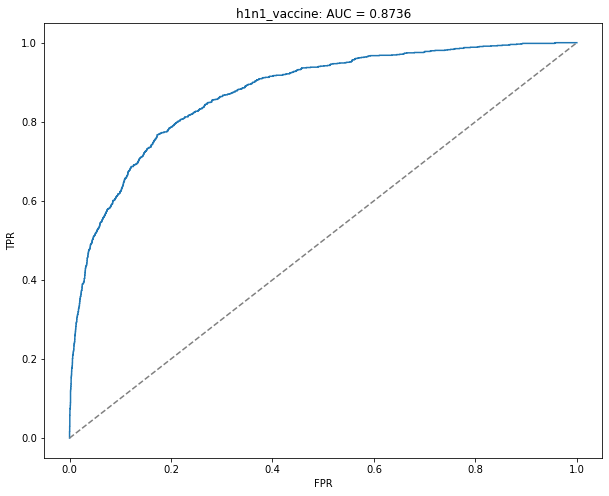

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y1_test, 
    h1n1_proba, 
    'h1n1_vaccine',
    ax=ax
)

In [25]:
cat_grid.fit(X_train, y2_train, eval_set=(X_val,y2_val),verbose=10,use_best_model = True,plot = True)
best_param_sea = cat_grid.best_params_
best_param_sea

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.42ms	remaining: 1.76s
10:	learn: 0.8329899	test: 0.8377077	best: 0.8377077 (10)	total: 42.5ms	remaining: 1.5s
20:	learn: 0.8438581	test: 0.8465006	best: 0.8465006 (20)	total: 87.2ms	remaining: 1.57s
30:	learn: 0.8496793	test: 0.8509781	best: 0.8509781 (30)	total: 128ms	remaining: 1.52s
40:	learn: 0.8533419	test: 0.8537239	best: 0.8537239 (40)	total: 170ms	remaining: 1.49s
50:	learn: 0.8560630	test: 0.8553089	best: 0.8553089 (50)	total: 209ms	remaining: 1.43s
60:	learn: 0.8580614	test: 0.8564522	best: 0.8564522 (60)	total: 248ms	remaining: 1.38s
70:	learn: 0.8600689	test: 0.8570625	best: 0.8570625 (70)	total: 287ms	remaining: 1.33s
80:	learn: 0.8612427	test: 0.8575116	best: 0.8575116 (80)	total: 325ms	remaining: 1.28s
90:	learn: 0.8625288	test: 0.8578807	best: 0.8580248 (89)	total: 363ms	remaining: 1.23s
100:	learn: 0.8645787	test: 0.8590266	best: 0.8590266 (100)	total: 402ms	remaining: 1.19s
110:	learn: 0.8664966	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.7ms	remaining: 1.48s
10:	learn: 0.8377419	test: 0.8373896	best: 0.8373896 (10)	total: 43.3ms	remaining: 1.53s
20:	learn: 0.8475540	test: 0.8458648	best: 0.8458648 (20)	total: 84.7ms	remaining: 1.53s
30:	learn: 0.8526523	test: 0.8497460	best: 0.8497460 (30)	total: 128ms	remaining: 1.53s
40:	learn: 0.8564053	test: 0.8530139	best: 0.8530139 (40)	total: 168ms	remaining: 1.47s
50:	learn: 0.8591350	test: 0.8552706	best: 0.8552706 (50)	total: 213ms	remaining: 1.46s
60:	learn: 0.8611084	test: 0.8561143	best: 0.8561143 (60)	total: 256ms	remaining: 1.42s
70:	learn: 0.8629594	test: 0.8573411	best: 0.8573411 (70)	total: 295ms	remaining: 1.37s
80:	learn: 0.8647983	test: 0.8576583	best: 0.8576583 (80)	total: 338ms	remaining: 1.33s
90:	learn: 0.8663722	test: 0.8579510	best: 0.8579510 (90)	total: 379ms	remaining: 1.29s
100:	learn: 0.8684467	test: 0.8584176	best: 0.8586988 (97)	total: 419ms	remaining: 1.24s
110:	learn: 0.8699530	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 6.4ms	remaining: 2.55s
10:	learn: 0.8367435	test: 0.8377187	best: 0.8377187 (10)	total: 53.8ms	remaining: 1.9s
20:	learn: 0.8462607	test: 0.8452830	best: 0.8452830 (20)	total: 98ms	remaining: 1.77s
30:	learn: 0.8522934	test: 0.8517242	best: 0.8517242 (30)	total: 139ms	remaining: 1.65s
40:	learn: 0.8558889	test: 0.8545803	best: 0.8545803 (40)	total: 180ms	remaining: 1.58s
50:	learn: 0.8594115	test: 0.8571231	best: 0.8571231 (50)	total: 222ms	remaining: 1.52s
60:	learn: 0.8617590	test: 0.8579075	best: 0.8579075 (60)	total: 263ms	remaining: 1.46s
70:	learn: 0.8633998	test: 0.8582401	best: 0.8584510 (64)	total: 309ms	remaining: 1.43s
80:	learn: 0.8652250	test: 0.8590170	best: 0.8591690 (79)	total: 359ms	remaining: 1.41s
90:	learn: 0.8666579	test: 0.8595574	best: 0.8595574 (90)	total: 408ms	remaining: 1.38s
100:	learn: 0.8684481	test: 0.8603448	best: 0.8603818 (98)	total: 456ms	remaining: 1.35s
110:	learn: 0.8700671	test: 0.8603

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.54ms	remaining: 1.41s
10:	learn: 0.8368996	test: 0.8373303	best: 0.8373303 (10)	total: 38.9ms	remaining: 1.38s
20:	learn: 0.8473565	test: 0.8464193	best: 0.8464193 (20)	total: 81.8ms	remaining: 1.48s
30:	learn: 0.8527086	test: 0.8511156	best: 0.8511156 (30)	total: 123ms	remaining: 1.46s
40:	learn: 0.8560917	test: 0.8535921	best: 0.8535921 (40)	total: 162ms	remaining: 1.42s
50:	learn: 0.8587898	test: 0.8551827	best: 0.8551827 (50)	total: 203ms	remaining: 1.39s
60:	learn: 0.8605531	test: 0.8567628	best: 0.8567628 (60)	total: 243ms	remaining: 1.35s
70:	learn: 0.8624443	test: 0.8576100	best: 0.8576100 (70)	total: 284ms	remaining: 1.31s
80:	learn: 0.8639701	test: 0.8584220	best: 0.8584220 (80)	total: 323ms	remaining: 1.27s
90:	learn: 0.8658654	test: 0.8587885	best: 0.8588245 (87)	total: 364ms	remaining: 1.24s
100:	learn: 0.8672721	test: 0.8587973	best: 0.8589941 (98)	total: 409ms	remaining: 1.21s
110:	learn: 0.8688558	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.88ms	remaining: 1.95s
10:	learn: 0.8347192	test: 0.8380773	best: 0.8380773 (10)	total: 47.7ms	remaining: 1.69s
20:	learn: 0.8463808	test: 0.8464615	best: 0.8464615 (20)	total: 89.2ms	remaining: 1.61s
30:	learn: 0.8514333	test: 0.8505796	best: 0.8505796 (30)	total: 133ms	remaining: 1.58s
40:	learn: 0.8554030	test: 0.8537059	best: 0.8537059 (40)	total: 173ms	remaining: 1.52s
50:	learn: 0.8587816	test: 0.8564658	best: 0.8564658 (50)	total: 213ms	remaining: 1.46s
60:	learn: 0.8605357	test: 0.8580046	best: 0.8580046 (60)	total: 255ms	remaining: 1.41s
70:	learn: 0.8625520	test: 0.8586294	best: 0.8586294 (70)	total: 295ms	remaining: 1.36s
80:	learn: 0.8641606	test: 0.8594678	best: 0.8594678 (80)	total: 338ms	remaining: 1.33s
90:	learn: 0.8658642	test: 0.8600997	best: 0.8601700 (89)	total: 379ms	remaining: 1.29s
100:	learn: 0.8672820	test: 0.8603853	best: 0.8606252 (97)	total: 420ms	remaining: 1.24s
110:	learn: 0.8688258	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.83ms	remaining: 1.93s
10:	learn: 0.8471077	test: 0.8464400	best: 0.8464400 (10)	total: 56.2ms	remaining: 1.99s
20:	learn: 0.8547189	test: 0.8512584	best: 0.8512584 (20)	total: 109ms	remaining: 1.96s
30:	learn: 0.8618495	test: 0.8558480	best: 0.8558480 (30)	total: 160ms	remaining: 1.91s
40:	learn: 0.8667931	test: 0.8572558	best: 0.8572558 (40)	total: 211ms	remaining: 1.85s
50:	learn: 0.8704067	test: 0.8577779	best: 0.8583174 (48)	total: 263ms	remaining: 1.8s
60:	learn: 0.8739761	test: 0.8584484	best: 0.8584484 (60)	total: 314ms	remaining: 1.75s
70:	learn: 0.8773875	test: 0.8591532	best: 0.8591532 (70)	total: 371ms	remaining: 1.72s
80:	learn: 0.8806330	test: 0.8593026	best: 0.8593826 (77)	total: 430ms	remaining: 1.69s
90:	learn: 0.8839751	test: 0.8602060	best: 0.8602060 (90)	total: 486ms	remaining: 1.65s
100:	learn: 0.8871478	test: 0.8603861	best: 0.8606217 (98)	total: 539ms	remaining: 1.59s
110:	learn: 0.8906307	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.8ms	remaining: 2.31s
10:	learn: 0.8470837	test: 0.8437693	best: 0.8437693 (10)	total: 57.5ms	remaining: 2.03s
20:	learn: 0.8584704	test: 0.8504895	best: 0.8504895 (20)	total: 115ms	remaining: 2.07s
30:	learn: 0.8646295	test: 0.8535860	best: 0.8535860 (30)	total: 184ms	remaining: 2.19s
40:	learn: 0.8700888	test: 0.8554912	best: 0.8554912 (40)	total: 236ms	remaining: 2.06s
50:	learn: 0.8737730	test: 0.8558252	best: 0.8562215 (46)	total: 287ms	remaining: 1.96s
60:	learn: 0.8772691	test: 0.8564755	best: 0.8564755 (60)	total: 339ms	remaining: 1.89s
70:	learn: 0.8802413	test: 0.8576487	best: 0.8576724 (68)	total: 388ms	remaining: 1.8s
80:	learn: 0.8830254	test: 0.8580020	best: 0.8580020 (80)	total: 441ms	remaining: 1.74s
90:	learn: 0.8861466	test: 0.8588641	best: 0.8589642 (89)	total: 496ms	remaining: 1.68s
100:	learn: 0.8890274	test: 0.8587999	best: 0.8589642 (89)	total: 546ms	remaining: 1.61s
110:	learn: 0.8924005	test: 0.858

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.92ms	remaining: 1.96s
10:	learn: 0.8490717	test: 0.8464962	best: 0.8464962 (10)	total: 61.4ms	remaining: 2.17s
20:	learn: 0.8586972	test: 0.8523174	best: 0.8523174 (20)	total: 113ms	remaining: 2.05s
30:	learn: 0.8640092	test: 0.8535271	best: 0.8537494 (27)	total: 182ms	remaining: 2.16s
40:	learn: 0.8688286	test: 0.8563006	best: 0.8563006 (40)	total: 233ms	remaining: 2.04s
50:	learn: 0.8732729	test: 0.8572945	best: 0.8574852 (49)	total: 283ms	remaining: 1.94s
60:	learn: 0.8768397	test: 0.8572980	best: 0.8578798 (55)	total: 331ms	remaining: 1.84s
70:	learn: 0.8801775	test: 0.8576214	best: 0.8578798 (55)	total: 381ms	remaining: 1.77s
80:	learn: 0.8832635	test: 0.8572866	best: 0.8578798 (55)	total: 449ms	remaining: 1.77s
90:	learn: 0.8867012	test: 0.8578903	best: 0.8581232 (87)	total: 500ms	remaining: 1.7s
100:	learn: 0.8900429	test: 0.8568252	best: 0.8581232 (87)	total: 550ms	remaining: 1.63s
110:	learn: 0.8929881	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.65ms	remaining: 2.25s
10:	learn: 0.8492868	test: 0.8448454	best: 0.8448454 (10)	total: 57.7ms	remaining: 2.04s
20:	learn: 0.8580880	test: 0.8502469	best: 0.8502469 (20)	total: 111ms	remaining: 2s
30:	learn: 0.8648639	test: 0.8536176	best: 0.8536176 (30)	total: 163ms	remaining: 1.94s
40:	learn: 0.8697126	test: 0.8554165	best: 0.8554165 (40)	total: 216ms	remaining: 1.89s
50:	learn: 0.8734000	test: 0.8563893	best: 0.8564386 (49)	total: 268ms	remaining: 1.83s
60:	learn: 0.8766567	test: 0.8574668	best: 0.8577260 (57)	total: 317ms	remaining: 1.76s
70:	learn: 0.8798678	test: 0.8582401	best: 0.8582445 (69)	total: 370ms	remaining: 1.71s
80:	learn: 0.8829078	test: 0.8583921	best: 0.8584581 (79)	total: 421ms	remaining: 1.66s
90:	learn: 0.8859500	test: 0.8591259	best: 0.8592613 (84)	total: 470ms	remaining: 1.59s
100:	learn: 0.8889586	test: 0.8589475	best: 0.8593008 (94)	total: 527ms	remaining: 1.56s
110:	learn: 0.8921750	test: 0.8589

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 9.04ms	remaining: 3.61s
10:	learn: 0.8488345	test: 0.8449904	best: 0.8449904 (10)	total: 69.3ms	remaining: 2.45s
20:	learn: 0.8578313	test: 0.8513230	best: 0.8513230 (20)	total: 127ms	remaining: 2.29s
30:	learn: 0.8643790	test: 0.8541783	best: 0.8541783 (30)	total: 200ms	remaining: 2.38s
40:	learn: 0.8696889	test: 0.8558990	best: 0.8558990 (40)	total: 252ms	remaining: 2.21s
50:	learn: 0.8733555	test: 0.8571996	best: 0.8571996 (50)	total: 308ms	remaining: 2.1s
60:	learn: 0.8767913	test: 0.8579114	best: 0.8579519 (59)	total: 360ms	remaining: 2s
70:	learn: 0.8796203	test: 0.8584923	best: 0.8584923 (70)	total: 412ms	remaining: 1.91s
80:	learn: 0.8823739	test: 0.8584554	best: 0.8586742 (71)	total: 465ms	remaining: 1.83s
90:	learn: 0.8854377	test: 0.8582586	best: 0.8593079 (84)	total: 516ms	remaining: 1.75s
100:	learn: 0.8885673	test: 0.8581935	best: 0.8593079 (84)	total: 565ms	remaining: 1.67s
110:	learn: 0.8920593	test: 0.85836

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.6ms	remaining: 1.44s
10:	learn: 0.8243947	test: 0.8297923	best: 0.8297923 (10)	total: 48.7ms	remaining: 1.72s
20:	learn: 0.8336765	test: 0.8371831	best: 0.8371831 (20)	total: 89.5ms	remaining: 1.61s
30:	learn: 0.8388956	test: 0.8420561	best: 0.8420561 (30)	total: 132ms	remaining: 1.57s
40:	learn: 0.8434939	test: 0.8451046	best: 0.8451046 (40)	total: 177ms	remaining: 1.55s
50:	learn: 0.8474445	test: 0.8482723	best: 0.8482723 (50)	total: 226ms	remaining: 1.54s
60:	learn: 0.8496132	test: 0.8507197	best: 0.8507197 (60)	total: 268ms	remaining: 1.49s
70:	learn: 0.8516328	test: 0.8525055	best: 0.8525055 (70)	total: 312ms	remaining: 1.45s
80:	learn: 0.8534581	test: 0.8534594	best: 0.8534594 (80)	total: 356ms	remaining: 1.4s
90:	learn: 0.8547320	test: 0.8542653	best: 0.8542653 (90)	total: 400ms	remaining: 1.36s
100:	learn: 0.8558247	test: 0.8547864	best: 0.8547864 (100)	total: 443ms	remaining: 1.31s
110:	learn: 0.8568308	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.27ms	remaining: 1.31s
10:	learn: 0.8315082	test: 0.8329222	best: 0.8329222 (10)	total: 42.2ms	remaining: 1.49s
20:	learn: 0.8373467	test: 0.8377521	best: 0.8377521 (20)	total: 82.7ms	remaining: 1.49s
30:	learn: 0.8422977	test: 0.8417160	best: 0.8417160 (30)	total: 124ms	remaining: 1.48s
40:	learn: 0.8469478	test: 0.8454979	best: 0.8454979 (40)	total: 172ms	remaining: 1.51s
50:	learn: 0.8498999	test: 0.8483355	best: 0.8483355 (50)	total: 215ms	remaining: 1.47s
60:	learn: 0.8530454	test: 0.8504218	best: 0.8504218 (60)	total: 259ms	remaining: 1.44s
70:	learn: 0.8551331	test: 0.8520902	best: 0.8520902 (70)	total: 299ms	remaining: 1.39s
80:	learn: 0.8569777	test: 0.8537556	best: 0.8537556 (80)	total: 341ms	remaining: 1.34s
90:	learn: 0.8584576	test: 0.8547640	best: 0.8547640 (90)	total: 380ms	remaining: 1.29s
100:	learn: 0.8595486	test: 0.8555334	best: 0.8555334 (100)	total: 421ms	remaining: 1.25s
110:	learn: 0.8606279	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.58ms	remaining: 1.43s
10:	learn: 0.8255093	test: 0.8285976	best: 0.8285976 (10)	total: 41ms	remaining: 1.45s
20:	learn: 0.8357347	test: 0.8366400	best: 0.8366400 (20)	total: 81.5ms	remaining: 1.47s
30:	learn: 0.8423626	test: 0.8423149	best: 0.8423149 (30)	total: 123ms	remaining: 1.47s
40:	learn: 0.8469228	test: 0.8454012	best: 0.8454012 (40)	total: 253ms	remaining: 2.22s
50:	learn: 0.8503395	test: 0.8486963	best: 0.8486963 (50)	total: 300ms	remaining: 2.05s
60:	learn: 0.8525532	test: 0.8506758	best: 0.8506758 (60)	total: 350ms	remaining: 1.94s
70:	learn: 0.8545046	test: 0.8521355	best: 0.8521355 (70)	total: 403ms	remaining: 1.87s
80:	learn: 0.8562495	test: 0.8533715	best: 0.8533715 (80)	total: 449ms	remaining: 1.77s
90:	learn: 0.8579044	test: 0.8549323	best: 0.8549323 (90)	total: 493ms	remaining: 1.67s
100:	learn: 0.8592510	test: 0.8558085	best: 0.8558295 (99)	total: 538ms	remaining: 1.59s
110:	learn: 0.8602320	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.42ms	remaining: 1.76s
10:	learn: 0.8252416	test: 0.8281419	best: 0.8281419 (10)	total: 43.3ms	remaining: 1.53s
20:	learn: 0.8351451	test: 0.8369304	best: 0.8369304 (20)	total: 84.1ms	remaining: 1.52s
30:	learn: 0.8412331	test: 0.8414664	best: 0.8414664 (30)	total: 126ms	remaining: 1.5s
40:	learn: 0.8466358	test: 0.8456991	best: 0.8456991 (40)	total: 170ms	remaining: 1.49s
50:	learn: 0.8502420	test: 0.8488123	best: 0.8488123 (50)	total: 212ms	remaining: 1.45s
60:	learn: 0.8530962	test: 0.8510172	best: 0.8510172 (60)	total: 253ms	remaining: 1.41s
70:	learn: 0.8549696	test: 0.8525973	best: 0.8525973 (70)	total: 294ms	remaining: 1.36s
80:	learn: 0.8568086	test: 0.8539937	best: 0.8539937 (80)	total: 335ms	remaining: 1.32s
90:	learn: 0.8581494	test: 0.8548180	best: 0.8548180 (90)	total: 376ms	remaining: 1.27s
100:	learn: 0.8594851	test: 0.8558717	best: 0.8558717 (100)	total: 415ms	remaining: 1.23s
110:	learn: 0.8606109	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.5ms	remaining: 1.4s
10:	learn: 0.8283939	test: 0.8308557	best: 0.8310209 (9)	total: 42.4ms	remaining: 1.5s
20:	learn: 0.8364330	test: 0.8383730	best: 0.8383730 (20)	total: 82.5ms	remaining: 1.49s
30:	learn: 0.8423667	test: 0.8429256	best: 0.8429256 (30)	total: 122ms	remaining: 1.45s
40:	learn: 0.8467244	test: 0.8463420	best: 0.8463420 (40)	total: 165ms	remaining: 1.44s
50:	learn: 0.8497666	test: 0.8493822	best: 0.8493822 (50)	total: 206ms	remaining: 1.41s
60:	learn: 0.8521299	test: 0.8509961	best: 0.8509961 (60)	total: 248ms	remaining: 1.38s
70:	learn: 0.8544735	test: 0.8530543	best: 0.8530543 (70)	total: 288ms	remaining: 1.34s
80:	learn: 0.8562192	test: 0.8546585	best: 0.8546585 (80)	total: 328ms	remaining: 1.29s
90:	learn: 0.8576349	test: 0.8551406	best: 0.8551599 (89)	total: 369ms	remaining: 1.25s
100:	learn: 0.8592323	test: 0.8562057	best: 0.8562233 (99)	total: 408ms	remaining: 1.21s
110:	learn: 0.8601612	test: 0.8566

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.69ms	remaining: 1.87s
10:	learn: 0.8383835	test: 0.8396578	best: 0.8396578 (10)	total: 53.5ms	remaining: 1.89s
20:	learn: 0.8454555	test: 0.8452632	best: 0.8452632 (20)	total: 104ms	remaining: 1.88s
30:	learn: 0.8509855	test: 0.8492306	best: 0.8492306 (30)	total: 158ms	remaining: 1.88s
40:	learn: 0.8549805	test: 0.8515252	best: 0.8515252 (40)	total: 210ms	remaining: 1.84s
50:	learn: 0.8588754	test: 0.8532784	best: 0.8532784 (50)	total: 262ms	remaining: 1.79s
60:	learn: 0.8622007	test: 0.8556845	best: 0.8556845 (60)	total: 311ms	remaining: 1.73s
70:	learn: 0.8646313	test: 0.8570810	best: 0.8570810 (70)	total: 363ms	remaining: 1.68s
80:	learn: 0.8670988	test: 0.8577242	best: 0.8577849 (78)	total: 416ms	remaining: 1.64s
90:	learn: 0.8696183	test: 0.8580063	best: 0.8580380 (89)	total: 466ms	remaining: 1.58s
100:	learn: 0.8717790	test: 0.8590688	best: 0.8590688 (100)	total: 515ms	remaining: 1.52s
110:	learn: 0.8738268	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.46ms	remaining: 1.78s
10:	learn: 0.8425690	test: 0.8405638	best: 0.8405638 (10)	total: 53.6ms	remaining: 1.9s
20:	learn: 0.8477668	test: 0.8443765	best: 0.8443765 (20)	total: 103ms	remaining: 1.86s
30:	learn: 0.8539117	test: 0.8489428	best: 0.8489428 (30)	total: 155ms	remaining: 1.84s
40:	learn: 0.8584110	test: 0.8516486	best: 0.8516486 (40)	total: 207ms	remaining: 1.81s
50:	learn: 0.8619262	test: 0.8534221	best: 0.8534221 (50)	total: 257ms	remaining: 1.76s
60:	learn: 0.8646067	test: 0.8544569	best: 0.8544569 (60)	total: 308ms	remaining: 1.71s
70:	learn: 0.8672215	test: 0.8559543	best: 0.8559543 (70)	total: 362ms	remaining: 1.68s
80:	learn: 0.8693446	test: 0.8563656	best: 0.8563656 (80)	total: 411ms	remaining: 1.62s
90:	learn: 0.8712434	test: 0.8566196	best: 0.8566196 (90)	total: 462ms	remaining: 1.57s
100:	learn: 0.8733007	test: 0.8573253	best: 0.8573332 (99)	total: 518ms	remaining: 1.53s
110:	learn: 0.8752298	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.81ms	remaining: 1.92s
10:	learn: 0.8391743	test: 0.8395242	best: 0.8395242 (10)	total: 50.6ms	remaining: 1.79s
20:	learn: 0.8479504	test: 0.8444780	best: 0.8444780 (20)	total: 102ms	remaining: 1.83s
30:	learn: 0.8541043	test: 0.8488677	best: 0.8488677 (30)	total: 154ms	remaining: 1.83s
40:	learn: 0.8587526	test: 0.8516429	best: 0.8516429 (40)	total: 204ms	remaining: 1.79s
50:	learn: 0.8620664	test: 0.8535728	best: 0.8535728 (50)	total: 255ms	remaining: 1.74s
60:	learn: 0.8654833	test: 0.8552926	best: 0.8552926 (60)	total: 306ms	remaining: 1.7s
70:	learn: 0.8680447	test: 0.8563138	best: 0.8563138 (70)	total: 355ms	remaining: 1.65s
80:	learn: 0.8703460	test: 0.8572805	best: 0.8572805 (80)	total: 407ms	remaining: 1.6s
90:	learn: 0.8725463	test: 0.8576249	best: 0.8576249 (90)	total: 458ms	remaining: 1.55s
100:	learn: 0.8743248	test: 0.8580617	best: 0.8582129 (99)	total: 510ms	remaining: 1.51s
110:	learn: 0.8761727	test: 0.858

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.82ms	remaining: 1.92s
10:	learn: 0.8416022	test: 0.8411162	best: 0.8411162 (10)	total: 51.1ms	remaining: 1.81s
20:	learn: 0.8489256	test: 0.8453265	best: 0.8453265 (20)	total: 102ms	remaining: 1.84s
30:	learn: 0.8542547	test: 0.8492513	best: 0.8492513 (30)	total: 151ms	remaining: 1.8s
40:	learn: 0.8587149	test: 0.8515731	best: 0.8515731 (40)	total: 202ms	remaining: 1.77s
50:	learn: 0.8621549	test: 0.8533408	best: 0.8533408 (50)	total: 253ms	remaining: 1.73s
60:	learn: 0.8653943	test: 0.8553752	best: 0.8553752 (60)	total: 304ms	remaining: 1.69s
70:	learn: 0.8677315	test: 0.8564667	best: 0.8564667 (70)	total: 359ms	remaining: 1.66s
80:	learn: 0.8696422	test: 0.8570089	best: 0.8570089 (80)	total: 412ms	remaining: 1.62s
90:	learn: 0.8715496	test: 0.8577366	best: 0.8578086 (89)	total: 465ms	remaining: 1.58s
100:	learn: 0.8735320	test: 0.8581821	best: 0.8581821 (100)	total: 517ms	remaining: 1.53s
110:	learn: 0.8753993	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 3.52ms	remaining: 1.41s
10:	learn: 0.8414199	test: 0.8410098	best: 0.8410098 (10)	total: 54.6ms	remaining: 1.93s
20:	learn: 0.8472670	test: 0.8446226	best: 0.8446903 (19)	total: 110ms	remaining: 1.98s
30:	learn: 0.8527925	test: 0.8483685	best: 0.8483685 (30)	total: 163ms	remaining: 1.94s
40:	learn: 0.8566986	test: 0.8514272	best: 0.8514272 (40)	total: 211ms	remaining: 1.85s
50:	learn: 0.8604905	test: 0.8531536	best: 0.8531536 (50)	total: 262ms	remaining: 1.79s
60:	learn: 0.8638136	test: 0.8548822	best: 0.8548822 (60)	total: 313ms	remaining: 1.74s
70:	learn: 0.8667249	test: 0.8563296	best: 0.8563296 (70)	total: 366ms	remaining: 1.69s
80:	learn: 0.8689418	test: 0.8573024	best: 0.8573024 (80)	total: 416ms	remaining: 1.64s
90:	learn: 0.8710393	test: 0.8575353	best: 0.8576952 (87)	total: 469ms	remaining: 1.59s
100:	learn: 0.8730978	test: 0.8579132	best: 0.8579132 (100)	total: 519ms	remaining: 1.54s
110:	learn: 0.8750580	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.35ms	remaining: 1.34s
10:	learn: 0.8203897	test: 0.8266642	best: 0.8271436 (8)	total: 42.3ms	remaining: 1.5s
20:	learn: 0.8225761	test: 0.8294241	best: 0.8294241 (20)	total: 80.8ms	remaining: 1.46s
30:	learn: 0.8240706	test: 0.8304791	best: 0.8304791 (30)	total: 121ms	remaining: 1.44s
40:	learn: 0.8242250	test: 0.8308254	best: 0.8308799 (36)	total: 160ms	remaining: 1.4s
50:	learn: 0.8254444	test: 0.8318347	best: 0.8318347 (47)	total: 201ms	remaining: 1.38s
60:	learn: 0.8264514	test: 0.8328862	best: 0.8328862 (60)	total: 242ms	remaining: 1.34s
70:	learn: 0.8284714	test: 0.8345805	best: 0.8345805 (70)	total: 282ms	remaining: 1.31s
80:	learn: 0.8301156	test: 0.8357396	best: 0.8358064 (79)	total: 323ms	remaining: 1.27s
90:	learn: 0.8315127	test: 0.8364567	best: 0.8364567 (90)	total: 363ms	remaining: 1.23s
100:	learn: 0.8329185	test: 0.8373285	best: 0.8373285 (100)	total: 404ms	remaining: 1.2s
110:	learn: 0.8344533	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.44ms	remaining: 1.37s
10:	learn: 0.8238069	test: 0.8262292	best: 0.8262292 (10)	total: 39.7ms	remaining: 1.4s
20:	learn: 0.8248950	test: 0.8273871	best: 0.8276841 (19)	total: 77.4ms	remaining: 1.4s
30:	learn: 0.8251062	test: 0.8275386	best: 0.8276841 (19)	total: 118ms	remaining: 1.4s
40:	learn: 0.8273722	test: 0.8296346	best: 0.8296346 (40)	total: 158ms	remaining: 1.38s
50:	learn: 0.8288134	test: 0.8312428	best: 0.8312428 (50)	total: 197ms	remaining: 1.35s
60:	learn: 0.8299308	test: 0.8321989	best: 0.8322754 (59)	total: 236ms	remaining: 1.31s
70:	learn: 0.8314196	test: 0.8335259	best: 0.8335259 (70)	total: 277ms	remaining: 1.28s
80:	learn: 0.8328459	test: 0.8349553	best: 0.8349553 (80)	total: 317ms	remaining: 1.25s
90:	learn: 0.8341870	test: 0.8363223	best: 0.8363223 (90)	total: 357ms	remaining: 1.21s
100:	learn: 0.8358215	test: 0.8376752	best: 0.8376752 (100)	total: 397ms	remaining: 1.18s
110:	learn: 0.8372123	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.47ms	remaining: 1.38s
10:	learn: 0.8229352	test: 0.8273141	best: 0.8273141 (10)	total: 40.1ms	remaining: 1.42s
20:	learn: 0.8251622	test: 0.8289386	best: 0.8289386 (20)	total: 77.3ms	remaining: 1.39s
30:	learn: 0.8258978	test: 0.8293094	best: 0.8293094 (30)	total: 115ms	remaining: 1.37s
40:	learn: 0.8268875	test: 0.8303671	best: 0.8303671 (40)	total: 159ms	remaining: 1.39s
50:	learn: 0.8275032	test: 0.8311655	best: 0.8311655 (50)	total: 205ms	remaining: 1.4s
60:	learn: 0.8291573	test: 0.8323365	best: 0.8324498 (59)	total: 249ms	remaining: 1.39s
70:	learn: 0.8301332	test: 0.8333401	best: 0.8333401 (70)	total: 291ms	remaining: 1.35s
80:	learn: 0.8318842	test: 0.8348143	best: 0.8348143 (80)	total: 334ms	remaining: 1.32s
90:	learn: 0.8338315	test: 0.8359593	best: 0.8359593 (90)	total: 381ms	remaining: 1.29s
100:	learn: 0.8358035	test: 0.8374630	best: 0.8374630 (100)	total: 422ms	remaining: 1.25s
110:	learn: 0.8372228	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.51ms	remaining: 1.4s
10:	learn: 0.8249684	test: 0.8280919	best: 0.8280919 (10)	total: 43.3ms	remaining: 1.53s
20:	learn: 0.8257694	test: 0.8291034	best: 0.8291034 (20)	total: 82.2ms	remaining: 1.48s
30:	learn: 0.8260412	test: 0.8290990	best: 0.8292633 (23)	total: 123ms	remaining: 1.46s
40:	learn: 0.8268477	test: 0.8302963	best: 0.8302963 (40)	total: 161ms	remaining: 1.41s
50:	learn: 0.8280869	test: 0.8314651	best: 0.8314651 (50)	total: 201ms	remaining: 1.38s
60:	learn: 0.8289977	test: 0.8324125	best: 0.8324125 (60)	total: 242ms	remaining: 1.34s
70:	learn: 0.8303612	test: 0.8332280	best: 0.8333537 (69)	total: 280ms	remaining: 1.3s
80:	learn: 0.8313405	test: 0.8344403	best: 0.8344403 (80)	total: 320ms	remaining: 1.26s
90:	learn: 0.8328898	test: 0.8354294	best: 0.8354294 (90)	total: 362ms	remaining: 1.23s
100:	learn: 0.8352576	test: 0.8371145	best: 0.8371145 (100)	total: 403ms	remaining: 1.19s
110:	learn: 0.8366677	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.5ms	remaining: 1.4s
10:	learn: 0.8234109	test: 0.8277597	best: 0.8278010 (9)	total: 46.9ms	remaining: 1.66s
20:	learn: 0.8236976	test: 0.8283691	best: 0.8286341 (18)	total: 89.6ms	remaining: 1.62s
30:	learn: 0.8248495	test: 0.8290366	best: 0.8290717 (29)	total: 132ms	remaining: 1.58s
40:	learn: 0.8268800	test: 0.8308139	best: 0.8308139 (40)	total: 177ms	remaining: 1.55s
50:	learn: 0.8284724	test: 0.8324942	best: 0.8326568 (49)	total: 219ms	remaining: 1.5s
60:	learn: 0.8284528	test: 0.8324815	best: 0.8328818 (54)	total: 262ms	remaining: 1.45s
70:	learn: 0.8300888	test: 0.8336015	best: 0.8336015 (70)	total: 305ms	remaining: 1.41s
80:	learn: 0.8316359	test: 0.8349553	best: 0.8349553 (80)	total: 348ms	remaining: 1.37s
90:	learn: 0.8334999	test: 0.8365284	best: 0.8365284 (90)	total: 391ms	remaining: 1.33s
100:	learn: 0.8350595	test: 0.8377279	best: 0.8377279 (100)	total: 437ms	remaining: 1.29s
110:	learn: 0.8370447	test: 0.839

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.08ms	remaining: 2.03s
10:	learn: 0.8333426	test: 0.8366540	best: 0.8366984 (9)	total: 52.4ms	remaining: 1.85s
20:	learn: 0.8355161	test: 0.8373799	best: 0.8380127 (16)	total: 101ms	remaining: 1.83s
30:	learn: 0.8369993	test: 0.8390501	best: 0.8390501 (30)	total: 147ms	remaining: 1.75s
40:	learn: 0.8379657	test: 0.8402145	best: 0.8402145 (40)	total: 196ms	remaining: 1.71s
50:	learn: 0.8388469	test: 0.8407207	best: 0.8407207 (50)	total: 246ms	remaining: 1.68s
60:	learn: 0.8400788	test: 0.8415244	best: 0.8415244 (60)	total: 295ms	remaining: 1.64s
70:	learn: 0.8411176	test: 0.8422924	best: 0.8422924 (69)	total: 345ms	remaining: 1.6s
80:	learn: 0.8425527	test: 0.8433918	best: 0.8433918 (80)	total: 394ms	remaining: 1.55s
90:	learn: 0.8436198	test: 0.8442601	best: 0.8442601 (90)	total: 443ms	remaining: 1.5s
100:	learn: 0.8448977	test: 0.8451354	best: 0.8451354 (100)	total: 492ms	remaining: 1.46s
110:	learn: 0.8462639	test: 0.846

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.17ms	remaining: 1.66s
10:	learn: 0.8355566	test: 0.8355547	best: 0.8361439 (5)	total: 57.4ms	remaining: 2.03s
20:	learn: 0.8379698	test: 0.8369335	best: 0.8369977 (17)	total: 115ms	remaining: 2.08s
30:	learn: 0.8378659	test: 0.8369036	best: 0.8369977 (17)	total: 178ms	remaining: 2.12s
40:	learn: 0.8386540	test: 0.8378716	best: 0.8379129 (38)	total: 233ms	remaining: 2.04s
50:	learn: 0.8402635	test: 0.8391916	best: 0.8391916 (50)	total: 283ms	remaining: 1.94s
60:	learn: 0.8421814	test: 0.8406636	best: 0.8406636 (60)	total: 333ms	remaining: 1.85s
70:	learn: 0.8436242	test: 0.8417603	best: 0.8417603 (70)	total: 381ms	remaining: 1.77s
80:	learn: 0.8451939	test: 0.8430750	best: 0.8430750 (80)	total: 432ms	remaining: 1.7s
90:	learn: 0.8469356	test: 0.8441419	best: 0.8441419 (90)	total: 484ms	remaining: 1.64s
100:	learn: 0.8483661	test: 0.8451402	best: 0.8451402 (100)	total: 536ms	remaining: 1.58s
110:	learn: 0.8495867	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.19ms	remaining: 1.67s
10:	learn: 0.8361746	test: 0.8357761	best: 0.8362753 (9)	total: 50.2ms	remaining: 1.78s
20:	learn: 0.8378524	test: 0.8370227	best: 0.8370227 (20)	total: 94.9ms	remaining: 1.71s
30:	learn: 0.8397299	test: 0.8383967	best: 0.8383967 (30)	total: 142ms	remaining: 1.69s
40:	learn: 0.8415913	test: 0.8396442	best: 0.8398771 (39)	total: 190ms	remaining: 1.67s
50:	learn: 0.8428896	test: 0.8407585	best: 0.8407585 (50)	total: 239ms	remaining: 1.63s
60:	learn: 0.8441200	test: 0.8414800	best: 0.8414800 (60)	total: 286ms	remaining: 1.59s
70:	learn: 0.8451000	test: 0.8424225	best: 0.8424225 (70)	total: 334ms	remaining: 1.54s
80:	learn: 0.8465834	test: 0.8434780	best: 0.8434780 (80)	total: 457ms	remaining: 1.8s
90:	learn: 0.8476082	test: 0.8442056	best: 0.8442056 (90)	total: 516ms	remaining: 1.75s
100:	learn: 0.8492295	test: 0.8452839	best: 0.8452839 (100)	total: 567ms	remaining: 1.68s
110:	learn: 0.8504368	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 10.1ms	remaining: 4.02s
10:	learn: 0.8359173	test: 0.8364836	best: 0.8364915 (6)	total: 60.7ms	remaining: 2.15s
20:	learn: 0.8365387	test: 0.8374454	best: 0.8381282 (12)	total: 111ms	remaining: 2s
30:	learn: 0.8377628	test: 0.8381638	best: 0.8384099 (28)	total: 166ms	remaining: 1.97s
40:	learn: 0.8396179	test: 0.8397272	best: 0.8397659 (38)	total: 214ms	remaining: 1.88s
50:	learn: 0.8406933	test: 0.8400726	best: 0.8400726 (50)	total: 264ms	remaining: 1.81s
60:	learn: 0.8422630	test: 0.8412607	best: 0.8412607 (60)	total: 314ms	remaining: 1.75s
70:	learn: 0.8439139	test: 0.8423311	best: 0.8423504 (69)	total: 365ms	remaining: 1.69s
80:	learn: 0.8457840	test: 0.8434024	best: 0.8434024 (80)	total: 420ms	remaining: 1.65s
90:	learn: 0.8470059	test: 0.8442469	best: 0.8442469 (90)	total: 474ms	remaining: 1.61s
100:	learn: 0.8482561	test: 0.8449482	best: 0.8449482 (100)	total: 527ms	remaining: 1.56s
110:	learn: 0.8498061	test: 0.8460

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.55ms	remaining: 1.82s
10:	learn: 0.8351694	test: 0.8359339	best: 0.8361922 (4)	total: 58.8ms	remaining: 2.08s
20:	learn: 0.8370607	test: 0.8372455	best: 0.8373276 (17)	total: 107ms	remaining: 1.94s
30:	learn: 0.8377124	test: 0.8382297	best: 0.8382297 (30)	total: 157ms	remaining: 1.87s
40:	learn: 0.8388159	test: 0.8389209	best: 0.8389209 (40)	total: 271ms	remaining: 2.37s
50:	learn: 0.8399235	test: 0.8399733	best: 0.8399733 (50)	total: 325ms	remaining: 2.23s
60:	learn: 0.8415968	test: 0.8412159	best: 0.8412159 (60)	total: 384ms	remaining: 2.14s
70:	learn: 0.8434142	test: 0.8424085	best: 0.8424085 (70)	total: 446ms	remaining: 2.07s
80:	learn: 0.8446558	test: 0.8432793	best: 0.8432793 (80)	total: 553ms	remaining: 2.18s
90:	learn: 0.8462419	test: 0.8443348	best: 0.8443348 (90)	total: 610ms	remaining: 2.07s
100:	learn: 0.8477511	test: 0.8454438	best: 0.8454438 (100)	total: 665ms	remaining: 1.97s
110:	learn: 0.8489731	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.25ms	remaining: 1.29s
10:	learn: 0.8332876	test: 0.8367933	best: 0.8367933 (10)	total: 42.5ms	remaining: 1.5s
20:	learn: 0.8438471	test: 0.8459461	best: 0.8459461 (20)	total: 84.3ms	remaining: 1.52s
30:	learn: 0.8501413	test: 0.8522765	best: 0.8522765 (30)	total: 125ms	remaining: 1.49s
40:	learn: 0.8538955	test: 0.8553840	best: 0.8553840 (40)	total: 168ms	remaining: 1.47s
50:	learn: 0.8564895	test: 0.8572339	best: 0.8572339 (50)	total: 210ms	remaining: 1.44s
60:	learn: 0.8583426	test: 0.8579984	best: 0.8579984 (60)	total: 253ms	remaining: 1.4s
70:	learn: 0.8601666	test: 0.8588614	best: 0.8588614 (70)	total: 292ms	remaining: 1.35s
80:	learn: 0.8615617	test: 0.8594529	best: 0.8595135 (79)	total: 332ms	remaining: 1.31s
90:	learn: 0.8629559	test: 0.8598105	best: 0.8598105 (90)	total: 373ms	remaining: 1.26s
100:	learn: 0.8643329	test: 0.8603027	best: 0.8603027 (100)	total: 414ms	remaining: 1.23s
110:	learn: 0.8663614	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.34ms	remaining: 1.33s
10:	learn: 0.8343533	test: 0.8353082	best: 0.8353082 (10)	total: 44.2ms	remaining: 1.56s
20:	learn: 0.8460543	test: 0.8455040	best: 0.8455040 (20)	total: 91.1ms	remaining: 1.64s
30:	learn: 0.8522628	test: 0.8510818	best: 0.8510818 (30)	total: 136ms	remaining: 1.62s
40:	learn: 0.8564348	test: 0.8538843	best: 0.8538843 (40)	total: 177ms	remaining: 1.55s
50:	learn: 0.8590934	test: 0.8558348	best: 0.8558348 (50)	total: 220ms	remaining: 1.5s
60:	learn: 0.8610137	test: 0.8568085	best: 0.8568085 (60)	total: 261ms	remaining: 1.45s
70:	learn: 0.8624453	test: 0.8581180	best: 0.8581180 (70)	total: 301ms	remaining: 1.4s
80:	learn: 0.8639712	test: 0.8578631	best: 0.8581180 (70)	total: 343ms	remaining: 1.35s
90:	learn: 0.8658555	test: 0.8586821	best: 0.8586821 (90)	total: 383ms	remaining: 1.3s
100:	learn: 0.8672338	test: 0.8593922	best: 0.8593931 (98)	total: 424ms	remaining: 1.25s
110:	learn: 0.8688243	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.21ms	remaining: 1.28s
10:	learn: 0.8367036	test: 0.8382956	best: 0.8382956 (10)	total: 40.4ms	remaining: 1.43s
20:	learn: 0.8476267	test: 0.8467932	best: 0.8467932 (20)	total: 83ms	remaining: 1.5s
30:	learn: 0.8528710	test: 0.8518639	best: 0.8518639 (30)	total: 124ms	remaining: 1.47s
40:	learn: 0.8561752	test: 0.8541625	best: 0.8541625 (40)	total: 165ms	remaining: 1.45s
50:	learn: 0.8590467	test: 0.8560541	best: 0.8560541 (50)	total: 210ms	remaining: 1.44s
60:	learn: 0.8608182	test: 0.8574320	best: 0.8574320 (60)	total: 249ms	remaining: 1.39s
70:	learn: 0.8625083	test: 0.8578807	best: 0.8579062 (69)	total: 290ms	remaining: 1.34s
80:	learn: 0.8641031	test: 0.8585987	best: 0.8585987 (80)	total: 330ms	remaining: 1.3s
90:	learn: 0.8656905	test: 0.8596119	best: 0.8596119 (90)	total: 372ms	remaining: 1.26s
100:	learn: 0.8673377	test: 0.8599819	best: 0.8599819 (100)	total: 414ms	remaining: 1.23s
110:	learn: 0.8690731	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.7ms	remaining: 1.48s
10:	learn: 0.8358269	test: 0.8376128	best: 0.8376128 (10)	total: 42.7ms	remaining: 1.51s
20:	learn: 0.8468701	test: 0.8472739	best: 0.8472739 (20)	total: 84.5ms	remaining: 1.52s
30:	learn: 0.8527692	test: 0.8524426	best: 0.8524426 (30)	total: 123ms	remaining: 1.46s
40:	learn: 0.8565868	test: 0.8546884	best: 0.8546884 (40)	total: 163ms	remaining: 1.43s
50:	learn: 0.8590742	test: 0.8570102	best: 0.8570102 (50)	total: 205ms	remaining: 1.4s
60:	learn: 0.8606147	test: 0.8573262	best: 0.8575037 (54)	total: 246ms	remaining: 1.37s
70:	learn: 0.8628170	test: 0.8585547	best: 0.8585547 (70)	total: 288ms	remaining: 1.33s
80:	learn: 0.8647032	test: 0.8586953	best: 0.8587938 (71)	total: 329ms	remaining: 1.3s
90:	learn: 0.8662015	test: 0.8590794	best: 0.8591629 (87)	total: 372ms	remaining: 1.26s
100:	learn: 0.8676081	test: 0.8595196	best: 0.8595583 (99)	total: 416ms	remaining: 1.23s
110:	learn: 0.8693173	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.02ms	remaining: 1.21s
10:	learn: 0.8362519	test: 0.8386006	best: 0.8386006 (10)	total: 41.1ms	remaining: 1.46s
20:	learn: 0.8471327	test: 0.8469176	best: 0.8469176 (20)	total: 83.3ms	remaining: 1.5s
30:	learn: 0.8526321	test: 0.8511947	best: 0.8511947 (30)	total: 124ms	remaining: 1.48s
40:	learn: 0.8561998	test: 0.8535174	best: 0.8535174 (40)	total: 164ms	remaining: 1.43s
50:	learn: 0.8583337	test: 0.8551028	best: 0.8551028 (50)	total: 207ms	remaining: 1.41s
60:	learn: 0.8603554	test: 0.8566301	best: 0.8566301 (60)	total: 249ms	remaining: 1.39s
70:	learn: 0.8624814	test: 0.8576979	best: 0.8577295 (69)	total: 292ms	remaining: 1.35s
80:	learn: 0.8637197	test: 0.8582076	best: 0.8582076 (80)	total: 332ms	remaining: 1.31s
90:	learn: 0.8653474	test: 0.8589845	best: 0.8589845 (90)	total: 372ms	remaining: 1.26s
100:	learn: 0.8672007	test: 0.8588184	best: 0.8590978 (92)	total: 416ms	remaining: 1.23s
110:	learn: 0.8687109	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.37ms	remaining: 1.75s
10:	learn: 0.8465772	test: 0.8455396	best: 0.8455396 (10)	total: 52ms	remaining: 1.84s
20:	learn: 0.8541832	test: 0.8505980	best: 0.8505980 (20)	total: 102ms	remaining: 1.83s
30:	learn: 0.8611603	test: 0.8552654	best: 0.8552654 (30)	total: 150ms	remaining: 1.79s
40:	learn: 0.8655088	test: 0.8569799	best: 0.8569878 (39)	total: 202ms	remaining: 1.76s
50:	learn: 0.8684802	test: 0.8569351	best: 0.8574501 (43)	total: 254ms	remaining: 1.74s
60:	learn: 0.8717354	test: 0.8582120	best: 0.8583552 (59)	total: 305ms	remaining: 1.7s
70:	learn: 0.8751289	test: 0.8584642	best: 0.8585292 (69)	total: 357ms	remaining: 1.66s
80:	learn: 0.8783173	test: 0.8589475	best: 0.8589475 (80)	total: 409ms	remaining: 1.61s
90:	learn: 0.8814514	test: 0.8590688	best: 0.8592868 (85)	total: 460ms	remaining: 1.56s
100:	learn: 0.8849072	test: 0.8594994	best: 0.8594994 (100)	total: 510ms	remaining: 1.51s
110:	learn: 0.8883524	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.38ms	remaining: 1.75s
10:	learn: 0.8476596	test: 0.8437205	best: 0.8437205 (10)	total: 72.2ms	remaining: 2.55s
20:	learn: 0.8578843	test: 0.8502030	best: 0.8502030 (20)	total: 159ms	remaining: 2.87s
30:	learn: 0.8652595	test: 0.8543066	best: 0.8543066 (30)	total: 215ms	remaining: 2.55s
40:	learn: 0.8700321	test: 0.8566047	best: 0.8566047 (40)	total: 266ms	remaining: 2.33s
50:	learn: 0.8733996	test: 0.8570326	best: 0.8573385 (46)	total: 318ms	remaining: 2.18s
60:	learn: 0.8761217	test: 0.8574826	best: 0.8575125 (59)	total: 370ms	remaining: 2.05s
70:	learn: 0.8790638	test: 0.8581795	best: 0.8583482 (67)	total: 422ms	remaining: 1.96s
80:	learn: 0.8816133	test: 0.8585073	best: 0.8585073 (80)	total: 473ms	remaining: 1.86s
90:	learn: 0.8842951	test: 0.8593281	best: 0.8593281 (90)	total: 524ms	remaining: 1.78s
100:	learn: 0.8870377	test: 0.8599195	best: 0.8600390 (95)	total: 574ms	remaining: 1.7s
110:	learn: 0.8903694	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.35ms	remaining: 1.73s
10:	learn: 0.8472421	test: 0.8439754	best: 0.8439754 (10)	total: 54.4ms	remaining: 1.92s
20:	learn: 0.8588455	test: 0.8512387	best: 0.8512387 (20)	total: 101ms	remaining: 1.82s
30:	learn: 0.8643348	test: 0.8554398	best: 0.8554398 (30)	total: 150ms	remaining: 1.79s
40:	learn: 0.8688247	test: 0.8581443	best: 0.8582920 (39)	total: 199ms	remaining: 1.75s
50:	learn: 0.8723250	test: 0.8593896	best: 0.8594195 (49)	total: 249ms	remaining: 1.7s
60:	learn: 0.8759109	test: 0.8597490	best: 0.8599801 (56)	total: 299ms	remaining: 1.66s
70:	learn: 0.8788204	test: 0.8604371	best: 0.8604371 (70)	total: 350ms	remaining: 1.62s
80:	learn: 0.8821051	test: 0.8611041	best: 0.8611041 (80)	total: 398ms	remaining: 1.57s
90:	learn: 0.8850599	test: 0.8616824	best: 0.8616824 (90)	total: 448ms	remaining: 1.52s
100:	learn: 0.8881295	test: 0.8612236	best: 0.8617123 (91)	total: 497ms	remaining: 1.47s
110:	learn: 0.8911267	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.69ms	remaining: 1.87s
10:	learn: 0.8501558	test: 0.8461355	best: 0.8461355 (10)	total: 53ms	remaining: 1.87s
20:	learn: 0.8583383	test: 0.8532186	best: 0.8532186 (20)	total: 105ms	remaining: 1.9s
30:	learn: 0.8636521	test: 0.8553440	best: 0.8553440 (30)	total: 156ms	remaining: 1.86s
40:	learn: 0.8677804	test: 0.8566903	best: 0.8566903 (40)	total: 206ms	remaining: 1.8s
50:	learn: 0.8714669	test: 0.8587261	best: 0.8587261 (50)	total: 259ms	remaining: 1.77s
60:	learn: 0.8748092	test: 0.8590152	best: 0.8594353 (59)	total: 312ms	remaining: 1.73s
70:	learn: 0.8778249	test: 0.8583939	best: 0.8594353 (59)	total: 364ms	remaining: 1.69s
80:	learn: 0.8807517	test: 0.8590776	best: 0.8594353 (59)	total: 419ms	remaining: 1.65s
90:	learn: 0.8834575	test: 0.8599687	best: 0.8599687 (90)	total: 478ms	remaining: 1.62s
100:	learn: 0.8867787	test: 0.8602174	best: 0.8603967 (99)	total: 533ms	remaining: 1.58s
110:	learn: 0.8900314	test: 0.86054

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.91ms	remaining: 1.96s
10:	learn: 0.8475666	test: 0.8449790	best: 0.8449790 (10)	total: 51.7ms	remaining: 1.83s
20:	learn: 0.8564525	test: 0.8510805	best: 0.8510805 (20)	total: 102ms	remaining: 1.84s
30:	learn: 0.8625875	test: 0.8547310	best: 0.8547310 (30)	total: 149ms	remaining: 1.78s
40:	learn: 0.8683271	test: 0.8576109	best: 0.8576706 (38)	total: 204ms	remaining: 1.78s
50:	learn: 0.8721203	test: 0.8591699	best: 0.8591699 (50)	total: 257ms	remaining: 1.76s
60:	learn: 0.8752036	test: 0.8599257	best: 0.8599257 (60)	total: 309ms	remaining: 1.72s
70:	learn: 0.8778856	test: 0.8603035	best: 0.8603035 (70)	total: 361ms	remaining: 1.67s
80:	learn: 0.8810601	test: 0.8606876	best: 0.8606981 (79)	total: 412ms	remaining: 1.62s
90:	learn: 0.8845031	test: 0.8612149	best: 0.8614108 (89)	total: 464ms	remaining: 1.58s
100:	learn: 0.8872934	test: 0.8614592	best: 0.8615550 (98)	total: 514ms	remaining: 1.52s
110:	learn: 0.8903534	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.38ms	remaining: 1.35s
10:	learn: 0.8260994	test: 0.8325663	best: 0.8327377 (9)	total: 40.6ms	remaining: 1.43s
20:	learn: 0.8340751	test: 0.8382315	best: 0.8382315 (20)	total: 80.8ms	remaining: 1.46s
30:	learn: 0.8392240	test: 0.8426470	best: 0.8426470 (30)	total: 122ms	remaining: 1.45s
40:	learn: 0.8438290	test: 0.8465221	best: 0.8465221 (40)	total: 164ms	remaining: 1.44s
50:	learn: 0.8470082	test: 0.8493985	best: 0.8493985 (50)	total: 206ms	remaining: 1.41s
60:	learn: 0.8494654	test: 0.8512747	best: 0.8512747 (60)	total: 249ms	remaining: 1.39s
70:	learn: 0.8514906	test: 0.8529207	best: 0.8529207 (70)	total: 292ms	remaining: 1.35s
80:	learn: 0.8529412	test: 0.8537969	best: 0.8537969 (80)	total: 333ms	remaining: 1.31s
90:	learn: 0.8543025	test: 0.8550114	best: 0.8550114 (90)	total: 375ms	remaining: 1.27s
100:	learn: 0.8554418	test: 0.8561688	best: 0.8561688 (100)	total: 418ms	remaining: 1.24s
110:	learn: 0.8564333	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.75ms	remaining: 1.5s
10:	learn: 0.8301652	test: 0.8315587	best: 0.8315587 (10)	total: 40.2ms	remaining: 1.42s
20:	learn: 0.8347098	test: 0.8364330	best: 0.8364330 (20)	total: 80.2ms	remaining: 1.45s
30:	learn: 0.8424795	test: 0.8426624	best: 0.8426624 (30)	total: 123ms	remaining: 1.46s
40:	learn: 0.8466526	test: 0.8462958	best: 0.8462958 (40)	total: 162ms	remaining: 1.42s
50:	learn: 0.8503791	test: 0.8493826	best: 0.8493826 (50)	total: 206ms	remaining: 1.41s
60:	learn: 0.8526053	test: 0.8512708	best: 0.8512708 (60)	total: 248ms	remaining: 1.38s
70:	learn: 0.8546792	test: 0.8529748	best: 0.8529748 (70)	total: 290ms	remaining: 1.34s
80:	learn: 0.8562567	test: 0.8541897	best: 0.8541897 (80)	total: 330ms	remaining: 1.3s
90:	learn: 0.8576587	test: 0.8551138	best: 0.8551138 (90)	total: 371ms	remaining: 1.26s
100:	learn: 0.8585443	test: 0.8556854	best: 0.8556854 (100)	total: 411ms	remaining: 1.22s
110:	learn: 0.8595075	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.81ms	remaining: 1.52s
10:	learn: 0.8249551	test: 0.8280708	best: 0.8280708 (10)	total: 44.2ms	remaining: 1.56s
20:	learn: 0.8344529	test: 0.8369208	best: 0.8369208 (20)	total: 83.8ms	remaining: 1.51s
30:	learn: 0.8422514	test: 0.8425754	best: 0.8425754 (30)	total: 128ms	remaining: 1.52s
40:	learn: 0.8464678	test: 0.8461117	best: 0.8461117 (40)	total: 170ms	remaining: 1.49s
50:	learn: 0.8493933	test: 0.8484283	best: 0.8484283 (50)	total: 213ms	remaining: 1.46s
60:	learn: 0.8518720	test: 0.8511200	best: 0.8511200 (60)	total: 257ms	remaining: 1.43s
70:	learn: 0.8542095	test: 0.8527915	best: 0.8527915 (70)	total: 299ms	remaining: 1.39s
80:	learn: 0.8560109	test: 0.8539032	best: 0.8539234 (79)	total: 342ms	remaining: 1.34s
90:	learn: 0.8573119	test: 0.8548128	best: 0.8548128 (90)	total: 386ms	remaining: 1.31s
100:	learn: 0.8587569	test: 0.8557584	best: 0.8557584 (100)	total: 428ms	remaining: 1.27s
110:	learn: 0.8600121	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.2ms	remaining: 1.68s
10:	learn: 0.8281989	test: 0.8314212	best: 0.8314212 (10)	total: 43.6ms	remaining: 1.54s
20:	learn: 0.8357726	test: 0.8372942	best: 0.8372942 (20)	total: 82.7ms	remaining: 1.49s
30:	learn: 0.8417483	test: 0.8419994	best: 0.8419994 (30)	total: 128ms	remaining: 1.52s
40:	learn: 0.8467585	test: 0.8463806	best: 0.8464149 (39)	total: 172ms	remaining: 1.5s
50:	learn: 0.8499232	test: 0.8489582	best: 0.8489582 (50)	total: 214ms	remaining: 1.46s
60:	learn: 0.8526396	test: 0.8512813	best: 0.8512813 (60)	total: 259ms	remaining: 1.44s
70:	learn: 0.8547161	test: 0.8530407	best: 0.8530407 (70)	total: 300ms	remaining: 1.39s
80:	learn: 0.8563074	test: 0.8539674	best: 0.8539674 (80)	total: 345ms	remaining: 1.36s
90:	learn: 0.8576371	test: 0.8549340	best: 0.8549340 (90)	total: 389ms	remaining: 1.32s
100:	learn: 0.8588623	test: 0.8558871	best: 0.8558871 (100)	total: 434ms	remaining: 1.28s
110:	learn: 0.8597883	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.6ms	remaining: 1.44s
10:	learn: 0.8264467	test: 0.8309405	best: 0.8309405 (10)	total: 39ms	remaining: 1.38s
20:	learn: 0.8370717	test: 0.8389569	best: 0.8389569 (20)	total: 77.9ms	remaining: 1.41s
30:	learn: 0.8428710	test: 0.8433105	best: 0.8433105 (30)	total: 118ms	remaining: 1.41s
40:	learn: 0.8465052	test: 0.8460572	best: 0.8460572 (40)	total: 158ms	remaining: 1.38s
50:	learn: 0.8497369	test: 0.8492794	best: 0.8492794 (50)	total: 198ms	remaining: 1.36s
60:	learn: 0.8521001	test: 0.8510774	best: 0.8510774 (60)	total: 239ms	remaining: 1.33s
70:	learn: 0.8541135	test: 0.8526421	best: 0.8526421 (70)	total: 281ms	remaining: 1.3s
80:	learn: 0.8553274	test: 0.8536563	best: 0.8536563 (80)	total: 322ms	remaining: 1.27s
90:	learn: 0.8567259	test: 0.8548734	best: 0.8548734 (90)	total: 363ms	remaining: 1.23s
100:	learn: 0.8578218	test: 0.8554833	best: 0.8554833 (100)	total: 411ms	remaining: 1.22s
110:	learn: 0.8591798	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 7.19ms	remaining: 2.87s
10:	learn: 0.8362795	test: 0.8398801	best: 0.8398801 (10)	total: 58.9ms	remaining: 2.08s
20:	learn: 0.8449725	test: 0.8461544	best: 0.8461544 (20)	total: 111ms	remaining: 2.01s
30:	learn: 0.8507491	test: 0.8495914	best: 0.8495914 (30)	total: 162ms	remaining: 1.93s
40:	learn: 0.8545338	test: 0.8520735	best: 0.8520735 (40)	total: 215ms	remaining: 1.88s
50:	learn: 0.8580429	test: 0.8547785	best: 0.8547785 (50)	total: 266ms	remaining: 1.82s
60:	learn: 0.8607734	test: 0.8558884	best: 0.8559807 (59)	total: 317ms	remaining: 1.76s
70:	learn: 0.8636467	test: 0.8573121	best: 0.8573121 (70)	total: 368ms	remaining: 1.7s
80:	learn: 0.8660809	test: 0.8580318	best: 0.8580318 (80)	total: 418ms	remaining: 1.65s
90:	learn: 0.8680275	test: 0.8585776	best: 0.8585776 (90)	total: 472ms	remaining: 1.6s
100:	learn: 0.8697528	test: 0.8592147	best: 0.8592472 (99)	total: 526ms	remaining: 1.55s
110:	learn: 0.8717372	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 7.83ms	remaining: 3.13s
10:	learn: 0.8407440	test: 0.8398327	best: 0.8402545 (8)	total: 75ms	remaining: 2.65s
20:	learn: 0.8477993	test: 0.8452703	best: 0.8452703 (20)	total: 146ms	remaining: 2.63s
30:	learn: 0.8524959	test: 0.8493936	best: 0.8493936 (30)	total: 217ms	remaining: 2.59s
40:	learn: 0.8569101	test: 0.8518468	best: 0.8518468 (40)	total: 278ms	remaining: 2.43s
50:	learn: 0.8604314	test: 0.8536677	best: 0.8536677 (50)	total: 368ms	remaining: 2.52s
60:	learn: 0.8632689	test: 0.8548400	best: 0.8548400 (60)	total: 459ms	remaining: 2.55s
70:	learn: 0.8656906	test: 0.8560036	best: 0.8560036 (70)	total: 524ms	remaining: 2.42s
80:	learn: 0.8676397	test: 0.8569078	best: 0.8569078 (80)	total: 582ms	remaining: 2.29s
90:	learn: 0.8694950	test: 0.8570379	best: 0.8570379 (90)	total: 635ms	remaining: 2.15s
100:	learn: 0.8714538	test: 0.8577989	best: 0.8577989 (100)	total: 688ms	remaining: 2.04s
110:	learn: 0.8732887	test: 0.858

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.19ms	remaining: 2.07s
10:	learn: 0.8419643	test: 0.8402242	best: 0.8402242 (10)	total: 49.2ms	remaining: 1.74s
20:	learn: 0.8491532	test: 0.8451815	best: 0.8451815 (20)	total: 101ms	remaining: 1.82s
30:	learn: 0.8542645	test: 0.8483342	best: 0.8483342 (30)	total: 151ms	remaining: 1.8s
40:	learn: 0.8585472	test: 0.8510357	best: 0.8510357 (40)	total: 202ms	remaining: 1.77s
50:	learn: 0.8613364	test: 0.8527660	best: 0.8527660 (50)	total: 254ms	remaining: 1.74s
60:	learn: 0.8643907	test: 0.8540552	best: 0.8541045 (59)	total: 304ms	remaining: 1.69s
70:	learn: 0.8667376	test: 0.8551494	best: 0.8551494 (70)	total: 354ms	remaining: 1.64s
80:	learn: 0.8689136	test: 0.8556406	best: 0.8556406 (80)	total: 406ms	remaining: 1.6s
90:	learn: 0.8706345	test: 0.8566161	best: 0.8566161 (90)	total: 458ms	remaining: 1.55s
100:	learn: 0.8726648	test: 0.8572172	best: 0.8572172 (100)	total: 511ms	remaining: 1.51s
110:	learn: 0.8746142	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 6.62ms	remaining: 2.64s
10:	learn: 0.8408294	test: 0.8403687	best: 0.8403687 (10)	total: 60.9ms	remaining: 2.15s
20:	learn: 0.8468282	test: 0.8437289	best: 0.8437289 (20)	total: 122ms	remaining: 2.2s
30:	learn: 0.8536362	test: 0.8491498	best: 0.8491498 (30)	total: 173ms	remaining: 2.06s
40:	learn: 0.8581122	test: 0.8520516	best: 0.8520516 (40)	total: 223ms	remaining: 1.95s
50:	learn: 0.8618394	test: 0.8539867	best: 0.8539867 (50)	total: 276ms	remaining: 1.89s
60:	learn: 0.8649147	test: 0.8557759	best: 0.8557759 (60)	total: 325ms	remaining: 1.8s
70:	learn: 0.8670009	test: 0.8569852	best: 0.8569852 (70)	total: 376ms	remaining: 1.74s
80:	learn: 0.8690178	test: 0.8578745	best: 0.8578745 (80)	total: 429ms	remaining: 1.69s
90:	learn: 0.8710049	test: 0.8587612	best: 0.8587788 (88)	total: 479ms	remaining: 1.63s
100:	learn: 0.8731459	test: 0.8596154	best: 0.8596154 (100)	total: 529ms	remaining: 1.56s
110:	learn: 0.8748929	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 6.08ms	remaining: 2.43s
10:	learn: 0.8416393	test: 0.8410423	best: 0.8410423 (10)	total: 55.7ms	remaining: 1.97s
20:	learn: 0.8484717	test: 0.8460265	best: 0.8460265 (20)	total: 105ms	remaining: 1.89s
30:	learn: 0.8539699	test: 0.8502355	best: 0.8502355 (30)	total: 154ms	remaining: 1.83s
40:	learn: 0.8579207	test: 0.8521236	best: 0.8521236 (40)	total: 205ms	remaining: 1.8s
50:	learn: 0.8612932	test: 0.8538962	best: 0.8538962 (50)	total: 256ms	remaining: 1.75s
60:	learn: 0.8638601	test: 0.8557223	best: 0.8557223 (60)	total: 305ms	remaining: 1.7s
70:	learn: 0.8662615	test: 0.8569237	best: 0.8569237 (70)	total: 356ms	remaining: 1.65s
80:	learn: 0.8683808	test: 0.8574588	best: 0.8574588 (80)	total: 404ms	remaining: 1.59s
90:	learn: 0.8699810	test: 0.8577752	best: 0.8577752 (90)	total: 451ms	remaining: 1.53s
100:	learn: 0.8719262	test: 0.8582665	best: 0.8582665 (100)	total: 502ms	remaining: 1.49s
110:	learn: 0.8734675	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.52ms	remaining: 1.4s
10:	learn: 0.8214398	test: 0.8269520	best: 0.8269520 (10)	total: 39.8ms	remaining: 1.41s
20:	learn: 0.8210813	test: 0.8272359	best: 0.8275325 (16)	total: 78.4ms	remaining: 1.41s
30:	learn: 0.8232462	test: 0.8289636	best: 0.8289636 (30)	total: 118ms	remaining: 1.4s
40:	learn: 0.8249529	test: 0.8306725	best: 0.8306725 (40)	total: 155ms	remaining: 1.36s
50:	learn: 0.8259228	test: 0.8315209	best: 0.8315209 (50)	total: 196ms	remaining: 1.34s
60:	learn: 0.8263149	test: 0.8319696	best: 0.8320065 (58)	total: 237ms	remaining: 1.31s
70:	learn: 0.8280850	test: 0.8334020	best: 0.8334020 (70)	total: 276ms	remaining: 1.28s
80:	learn: 0.8300332	test: 0.8353811	best: 0.8353811 (80)	total: 317ms	remaining: 1.25s
90:	learn: 0.8314538	test: 0.8364528	best: 0.8364528 (90)	total: 356ms	remaining: 1.21s
100:	learn: 0.8327574	test: 0.8375030	best: 0.8375030 (100)	total: 397ms	remaining: 1.18s
110:	learn: 0.8344217	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.63ms	remaining: 1.45s
10:	learn: 0.8247183	test: 0.8256734	best: 0.8262156 (9)	total: 39.6ms	remaining: 1.4s
20:	learn: 0.8254186	test: 0.8269468	best: 0.8269468 (20)	total: 79.8ms	remaining: 1.44s
30:	learn: 0.8263873	test: 0.8285378	best: 0.8285378 (30)	total: 119ms	remaining: 1.42s
40:	learn: 0.8271236	test: 0.8294153	best: 0.8294153 (40)	total: 158ms	remaining: 1.38s
50:	learn: 0.8284509	test: 0.8311237	best: 0.8311237 (50)	total: 200ms	remaining: 1.37s
60:	learn: 0.8295153	test: 0.8318953	best: 0.8318953 (60)	total: 245ms	remaining: 1.36s
70:	learn: 0.8310227	test: 0.8333023	best: 0.8333032 (69)	total: 288ms	remaining: 1.33s
80:	learn: 0.8326911	test: 0.8348015	best: 0.8348015 (80)	total: 328ms	remaining: 1.29s
90:	learn: 0.8344507	test: 0.8359712	best: 0.8359712 (90)	total: 371ms	remaining: 1.26s
100:	learn: 0.8357833	test: 0.8370020	best: 0.8370020 (100)	total: 412ms	remaining: 1.22s
110:	learn: 0.8368719	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.92ms	remaining: 1.56s
10:	learn: 0.8198011	test: 0.8235722	best: 0.8237233 (2)	total: 40.4ms	remaining: 1.43s
20:	learn: 0.8240662	test: 0.8270883	best: 0.8270883 (20)	total: 79ms	remaining: 1.43s
30:	learn: 0.8260413	test: 0.8289579	best: 0.8290001 (28)	total: 118ms	remaining: 1.4s
40:	learn: 0.8275384	test: 0.8304093	best: 0.8305921 (34)	total: 161ms	remaining: 1.41s
50:	learn: 0.8282856	test: 0.8309414	best: 0.8310943 (48)	total: 200ms	remaining: 1.37s
60:	learn: 0.8299507	test: 0.8324019	best: 0.8324019 (60)	total: 242ms	remaining: 1.34s
70:	learn: 0.8319229	test: 0.8343415	best: 0.8343415 (70)	total: 284ms	remaining: 1.32s
80:	learn: 0.8331653	test: 0.8352879	best: 0.8352879 (80)	total: 400ms	remaining: 1.58s
90:	learn: 0.8347271	test: 0.8363117	best: 0.8363706 (89)	total: 446ms	remaining: 1.51s
100:	learn: 0.8360730	test: 0.8374204	best: 0.8374204 (100)	total: 487ms	remaining: 1.44s
110:	learn: 0.8373856	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.05ms	remaining: 1.62s
10:	learn: 0.8210007	test: 0.8246258	best: 0.8248218 (5)	total: 43.5ms	remaining: 1.54s
20:	learn: 0.8250472	test: 0.8284675	best: 0.8291433 (19)	total: 82.5ms	remaining: 1.49s
30:	learn: 0.8259134	test: 0.8298394	best: 0.8298394 (30)	total: 124ms	remaining: 1.48s
40:	learn: 0.8279201	test: 0.8317789	best: 0.8317789 (40)	total: 166ms	remaining: 1.45s
50:	learn: 0.8276864	test: 0.8319116	best: 0.8319907 (47)	total: 205ms	remaining: 1.4s
60:	learn: 0.8301990	test: 0.8337241	best: 0.8338322 (59)	total: 246ms	remaining: 1.37s
70:	learn: 0.8319076	test: 0.8350660	best: 0.8350660 (70)	total: 286ms	remaining: 1.33s
80:	learn: 0.8335108	test: 0.8360565	best: 0.8361448 (79)	total: 328ms	remaining: 1.29s
90:	learn: 0.8348456	test: 0.8369322	best: 0.8369322 (90)	total: 368ms	remaining: 1.25s
100:	learn: 0.8360435	test: 0.8378593	best: 0.8378593 (100)	total: 410ms	remaining: 1.21s
110:	learn: 0.8374479	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.4ms	remaining: 1.36s
10:	learn: 0.8247051	test: 0.8286569	best: 0.8286569 (10)	total: 41.7ms	remaining: 1.47s
20:	learn: 0.8252036	test: 0.8293824	best: 0.8295959 (16)	total: 83.5ms	remaining: 1.51s
30:	learn: 0.8261687	test: 0.8302875	best: 0.8302875 (30)	total: 134ms	remaining: 1.6s
40:	learn: 0.8262893	test: 0.8303693	best: 0.8303693 (40)	total: 172ms	remaining: 1.51s
50:	learn: 0.8268778	test: 0.8308394	best: 0.8310433 (48)	total: 213ms	remaining: 1.46s
60:	learn: 0.8288935	test: 0.8324367	best: 0.8324551 (58)	total: 253ms	remaining: 1.4s
70:	learn: 0.8306163	test: 0.8342523	best: 0.8342523 (70)	total: 296ms	remaining: 1.37s
80:	learn: 0.8319259	test: 0.8353402	best: 0.8353402 (80)	total: 337ms	remaining: 1.33s
90:	learn: 0.8329004	test: 0.8362414	best: 0.8362414 (90)	total: 377ms	remaining: 1.28s
100:	learn: 0.8344686	test: 0.8372661	best: 0.8372661 (100)	total: 417ms	remaining: 1.24s
110:	learn: 0.8359426	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.55ms	remaining: 1.82s
10:	learn: 0.8336445	test: 0.8370271	best: 0.8370271 (10)	total: 52.8ms	remaining: 1.86s
20:	learn: 0.8363110	test: 0.8388141	best: 0.8388141 (20)	total: 103ms	remaining: 1.87s
30:	learn: 0.8370953	test: 0.8393072	best: 0.8395488 (25)	total: 155ms	remaining: 1.84s
40:	learn: 0.8375518	test: 0.8395602	best: 0.8396793 (38)	total: 206ms	remaining: 1.8s
50:	learn: 0.8387950	test: 0.8401121	best: 0.8401631 (49)	total: 260ms	remaining: 1.78s
60:	learn: 0.8396842	test: 0.8409408	best: 0.8409417 (59)	total: 313ms	remaining: 1.74s
70:	learn: 0.8404637	test: 0.8412792	best: 0.8412792 (70)	total: 364ms	remaining: 1.69s
80:	learn: 0.8419219	test: 0.8424559	best: 0.8424858 (79)	total: 415ms	remaining: 1.63s
90:	learn: 0.8432030	test: 0.8433857	best: 0.8433857 (90)	total: 467ms	remaining: 1.59s
100:	learn: 0.8448767	test: 0.8447303	best: 0.8447303 (100)	total: 518ms	remaining: 1.53s
110:	learn: 0.8461420	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.51ms	remaining: 1.8s
10:	learn: 0.8357441	test: 0.8353007	best: 0.8354448 (9)	total: 51ms	remaining: 1.8s
20:	learn: 0.8369580	test: 0.8355670	best: 0.8361435 (13)	total: 100ms	remaining: 1.8s
30:	learn: 0.8382417	test: 0.8364963	best: 0.8365837 (25)	total: 147ms	remaining: 1.75s
40:	learn: 0.8400207	test: 0.8381515	best: 0.8381515 (40)	total: 198ms	remaining: 1.73s
50:	learn: 0.8414356	test: 0.8394820	best: 0.8394820 (50)	total: 247ms	remaining: 1.69s
60:	learn: 0.8427241	test: 0.8409742	best: 0.8409778 (58)	total: 297ms	remaining: 1.65s
70:	learn: 0.8440366	test: 0.8419260	best: 0.8419277 (69)	total: 344ms	remaining: 1.59s
80:	learn: 0.8454792	test: 0.8430131	best: 0.8430219 (79)	total: 394ms	remaining: 1.55s
90:	learn: 0.8467759	test: 0.8440492	best: 0.8440492 (90)	total: 444ms	remaining: 1.51s
100:	learn: 0.8480786	test: 0.8447144	best: 0.8447144 (100)	total: 493ms	remaining: 1.46s
110:	learn: 0.8497393	test: 0.845959

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 3.76ms	remaining: 1.5s
10:	learn: 0.8344136	test: 0.8358398	best: 0.8358398 (10)	total: 50.7ms	remaining: 1.79s
20:	learn: 0.8368386	test: 0.8370912	best: 0.8371862 (19)	total: 99.4ms	remaining: 1.79s
30:	learn: 0.8388578	test: 0.8389596	best: 0.8389666 (29)	total: 148ms	remaining: 1.76s
40:	learn: 0.8404780	test: 0.8399065	best: 0.8399065 (40)	total: 196ms	remaining: 1.71s
50:	learn: 0.8420650	test: 0.8408306	best: 0.8408306 (50)	total: 248ms	remaining: 1.7s
60:	learn: 0.8430811	test: 0.8418280	best: 0.8418280 (60)	total: 297ms	remaining: 1.65s
70:	learn: 0.8443071	test: 0.8428430	best: 0.8428430 (70)	total: 348ms	remaining: 1.61s
80:	learn: 0.8456259	test: 0.8434279	best: 0.8434516 (79)	total: 398ms	remaining: 1.57s
90:	learn: 0.8470398	test: 0.8443822	best: 0.8443822 (90)	total: 451ms	remaining: 1.53s
100:	learn: 0.8484017	test: 0.8451073	best: 0.8451073 (100)	total: 507ms	remaining: 1.5s
110:	learn: 0.8497557	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.01ms	remaining: 1.6s
10:	learn: 0.8342165	test: 0.8351473	best: 0.8359642 (8)	total: 52.2ms	remaining: 1.85s
20:	learn: 0.8359448	test: 0.8353350	best: 0.8359642 (8)	total: 102ms	remaining: 1.84s
30:	learn: 0.8378488	test: 0.8374828	best: 0.8376559 (26)	total: 151ms	remaining: 1.79s
40:	learn: 0.8394811	test: 0.8386718	best: 0.8386718 (40)	total: 195ms	remaining: 1.71s
50:	learn: 0.8399031	test: 0.8389833	best: 0.8389833 (50)	total: 242ms	remaining: 1.66s
60:	learn: 0.8417162	test: 0.8403626	best: 0.8403626 (60)	total: 292ms	remaining: 1.62s
70:	learn: 0.8434687	test: 0.8414602	best: 0.8415042 (69)	total: 342ms	remaining: 1.58s
80:	learn: 0.8453439	test: 0.8430342	best: 0.8430342 (80)	total: 391ms	remaining: 1.54s
90:	learn: 0.8465847	test: 0.8434006	best: 0.8434243 (88)	total: 441ms	remaining: 1.5s
100:	learn: 0.8481855	test: 0.8445852	best: 0.8445852 (100)	total: 490ms	remaining: 1.45s
110:	learn: 0.8494317	test: 0.8455

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.46ms	remaining: 2.18s
10:	learn: 0.8366840	test: 0.8372007	best: 0.8373953 (8)	total: 52.5ms	remaining: 1.86s
20:	learn: 0.8383113	test: 0.8379327	best: 0.8379327 (20)	total: 100ms	remaining: 1.81s
30:	learn: 0.8385076	test: 0.8382240	best: 0.8384552 (27)	total: 149ms	remaining: 1.77s
40:	learn: 0.8395572	test: 0.8392030	best: 0.8392118 (38)	total: 198ms	remaining: 1.73s
50:	learn: 0.8406937	test: 0.8402145	best: 0.8402145 (50)	total: 248ms	remaining: 1.69s
60:	learn: 0.8416991	test: 0.8410300	best: 0.8410300 (60)	total: 298ms	remaining: 1.66s
70:	learn: 0.8433820	test: 0.8422643	best: 0.8422643 (70)	total: 346ms	remaining: 1.6s
80:	learn: 0.8447294	test: 0.8430394	best: 0.8430394 (80)	total: 396ms	remaining: 1.56s
90:	learn: 0.8462158	test: 0.8440905	best: 0.8440905 (90)	total: 446ms	remaining: 1.51s
100:	learn: 0.8473886	test: 0.8449807	best: 0.8449807 (100)	total: 496ms	remaining: 1.47s
110:	learn: 0.8483890	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.91ms	remaining: 1.56s
10:	learn: 0.8358325	test: 0.8392346	best: 0.8392346 (10)	total: 43.5ms	remaining: 1.54s
20:	learn: 0.8445496	test: 0.8468025	best: 0.8468025 (20)	total: 90.5ms	remaining: 1.63s
30:	learn: 0.8496666	test: 0.8514417	best: 0.8514417 (30)	total: 139ms	remaining: 1.66s
40:	learn: 0.8534067	test: 0.8545368	best: 0.8545368 (40)	total: 190ms	remaining: 1.66s
50:	learn: 0.8556531	test: 0.8562518	best: 0.8563160 (49)	total: 239ms	remaining: 1.63s
60:	learn: 0.8578349	test: 0.8572998	best: 0.8574044 (59)	total: 281ms	remaining: 1.56s
70:	learn: 0.8600046	test: 0.8579932	best: 0.8583737 (68)	total: 324ms	remaining: 1.5s
80:	learn: 0.8619370	test: 0.8588597	best: 0.8588597 (80)	total: 370ms	remaining: 1.46s
90:	learn: 0.8635402	test: 0.8598123	best: 0.8598510 (89)	total: 417ms	remaining: 1.42s
100:	learn: 0.8652992	test: 0.8606885	best: 0.8607834 (97)	total: 462ms	remaining: 1.37s
110:	learn: 0.8670647	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.68ms	remaining: 1.47s
10:	learn: 0.8370861	test: 0.8375957	best: 0.8375957 (10)	total: 45ms	remaining: 1.59s
20:	learn: 0.8466814	test: 0.8453437	best: 0.8453437 (20)	total: 85.6ms	remaining: 1.54s
30:	learn: 0.8536364	test: 0.8510946	best: 0.8510946 (30)	total: 128ms	remaining: 1.52s
40:	learn: 0.8567883	test: 0.8535464	best: 0.8535464 (40)	total: 170ms	remaining: 1.49s
50:	learn: 0.8590815	test: 0.8552368	best: 0.8552368 (50)	total: 211ms	remaining: 1.44s
60:	learn: 0.8608784	test: 0.8562813	best: 0.8562813 (60)	total: 252ms	remaining: 1.4s
70:	learn: 0.8624070	test: 0.8569052	best: 0.8569052 (70)	total: 295ms	remaining: 1.37s
80:	learn: 0.8638596	test: 0.8574773	best: 0.8574773 (80)	total: 339ms	remaining: 1.33s
90:	learn: 0.8660221	test: 0.8577515	best: 0.8577559 (87)	total: 382ms	remaining: 1.3s
100:	learn: 0.8675106	test: 0.8585451	best: 0.8586356 (99)	total: 426ms	remaining: 1.26s
110:	learn: 0.8692631	test: 0.8591

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.51ms	remaining: 1.8s
10:	learn: 0.8372790	test: 0.8386032	best: 0.8386032 (10)	total: 44.3ms	remaining: 1.57s
20:	learn: 0.8472610	test: 0.8461482	best: 0.8461482 (20)	total: 85.2ms	remaining: 1.54s
30:	learn: 0.8524368	test: 0.8509452	best: 0.8509452 (30)	total: 128ms	remaining: 1.52s
40:	learn: 0.8566656	test: 0.8540895	best: 0.8540895 (40)	total: 170ms	remaining: 1.49s
50:	learn: 0.8590389	test: 0.8561894	best: 0.8561894 (50)	total: 212ms	remaining: 1.45s
60:	learn: 0.8607604	test: 0.8569790	best: 0.8569790 (60)	total: 253ms	remaining: 1.41s
70:	learn: 0.8628205	test: 0.8575212	best: 0.8576276 (68)	total: 295ms	remaining: 1.37s
80:	learn: 0.8644210	test: 0.8584000	best: 0.8584000 (80)	total: 336ms	remaining: 1.32s
90:	learn: 0.8660757	test: 0.8591286	best: 0.8592525 (89)	total: 379ms	remaining: 1.29s
100:	learn: 0.8675859	test: 0.8592657	best: 0.8592657 (100)	total: 422ms	remaining: 1.25s
110:	learn: 0.8692988	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.61ms	remaining: 1.44s
10:	learn: 0.8376621	test: 0.8389442	best: 0.8389442 (10)	total: 41.5ms	remaining: 1.47s
20:	learn: 0.8476547	test: 0.8463820	best: 0.8463820 (20)	total: 82.7ms	remaining: 1.49s
30:	learn: 0.8537111	test: 0.8518349	best: 0.8518349 (30)	total: 125ms	remaining: 1.49s
40:	learn: 0.8573681	test: 0.8544881	best: 0.8545162 (39)	total: 167ms	remaining: 1.46s
50:	learn: 0.8597396	test: 0.8561200	best: 0.8561200 (50)	total: 207ms	remaining: 1.42s
60:	learn: 0.8613793	test: 0.8562351	best: 0.8564583 (56)	total: 246ms	remaining: 1.36s
70:	learn: 0.8628971	test: 0.8568296	best: 0.8568296 (70)	total: 287ms	remaining: 1.33s
80:	learn: 0.8648619	test: 0.8580881	best: 0.8580881 (80)	total: 330ms	remaining: 1.3s
90:	learn: 0.8662535	test: 0.8583737	best: 0.8584756 (88)	total: 371ms	remaining: 1.26s
100:	learn: 0.8676515	test: 0.8583974	best: 0.8585486 (97)	total: 412ms	remaining: 1.22s
110:	learn: 0.8692321	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.31ms	remaining: 1.32s
10:	learn: 0.8368545	test: 0.8395624	best: 0.8395624 (10)	total: 41.2ms	remaining: 1.46s
20:	learn: 0.8471122	test: 0.8473016	best: 0.8473016 (20)	total: 82ms	remaining: 1.48s
30:	learn: 0.8519401	test: 0.8510322	best: 0.8510322 (30)	total: 122ms	remaining: 1.45s
40:	learn: 0.8555805	test: 0.8535152	best: 0.8535152 (40)	total: 163ms	remaining: 1.43s
50:	learn: 0.8584477	test: 0.8551111	best: 0.8551753 (47)	total: 204ms	remaining: 1.4s
60:	learn: 0.8603211	test: 0.8567171	best: 0.8567171 (60)	total: 244ms	remaining: 1.36s
70:	learn: 0.8621437	test: 0.8574606	best: 0.8574676 (69)	total: 285ms	remaining: 1.32s
80:	learn: 0.8641968	test: 0.8583254	best: 0.8583254 (80)	total: 328ms	remaining: 1.29s
90:	learn: 0.8655082	test: 0.8584598	best: 0.8584598 (90)	total: 370ms	remaining: 1.26s
100:	learn: 0.8673534	test: 0.8585899	best: 0.8586364 (98)	total: 412ms	remaining: 1.22s
110:	learn: 0.8691039	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 4.71ms	remaining: 1.88s
10:	learn: 0.8460627	test: 0.8463376	best: 0.8463376 (10)	total: 51ms	remaining: 1.8s
20:	learn: 0.8550027	test: 0.8519268	best: 0.8519268 (20)	total: 102ms	remaining: 1.85s
30:	learn: 0.8607201	test: 0.8555457	best: 0.8555457 (30)	total: 153ms	remaining: 1.82s
40:	learn: 0.8658761	test: 0.8572866	best: 0.8572866 (40)	total: 205ms	remaining: 1.79s
50:	learn: 0.8693377	test: 0.8581698	best: 0.8581698 (50)	total: 255ms	remaining: 1.75s
60:	learn: 0.8726590	test: 0.8588087	best: 0.8588122 (59)	total: 306ms	remaining: 1.7s
70:	learn: 0.8760923	test: 0.8594476	best: 0.8594476 (70)	total: 356ms	remaining: 1.65s
80:	learn: 0.8788749	test: 0.8587727	best: 0.8594476 (70)	total: 406ms	remaining: 1.6s
90:	learn: 0.8813895	test: 0.8593017	best: 0.8594476 (70)	total: 456ms	remaining: 1.55s
100:	learn: 0.8848964	test: 0.8594968	best: 0.8596014 (98)	total: 506ms	remaining: 1.5s
110:	learn: 0.8884555	test: 0.8603941

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.36ms	remaining: 1.74s
10:	learn: 0.8483459	test: 0.8446191	best: 0.8446191 (10)	total: 52ms	remaining: 1.84s
20:	learn: 0.8587111	test: 0.8510598	best: 0.8510598 (20)	total: 101ms	remaining: 1.82s
30:	learn: 0.8646760	test: 0.8540983	best: 0.8540983 (30)	total: 152ms	remaining: 1.81s
40:	learn: 0.8687524	test: 0.8564781	best: 0.8564781 (40)	total: 208ms	remaining: 1.82s
50:	learn: 0.8724282	test: 0.8580969	best: 0.8583087 (48)	total: 270ms	remaining: 1.85s
60:	learn: 0.8758887	test: 0.8587524	best: 0.8587524 (60)	total: 332ms	remaining: 1.84s
70:	learn: 0.8789713	test: 0.8596119	best: 0.8596119 (70)	total: 380ms	remaining: 1.76s
80:	learn: 0.8816616	test: 0.8603404	best: 0.8603404 (80)	total: 429ms	remaining: 1.69s
90:	learn: 0.8844976	test: 0.8606085	best: 0.8608765 (83)	total: 479ms	remaining: 1.63s
100:	learn: 0.8877700	test: 0.8608783	best: 0.8608897 (97)	total: 529ms	remaining: 1.56s
110:	learn: 0.8905270	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.23ms	remaining: 1.69s
10:	learn: 0.8489154	test: 0.8457193	best: 0.8457193 (10)	total: 54.4ms	remaining: 1.93s
20:	learn: 0.8587824	test: 0.8528232	best: 0.8528232 (20)	total: 105ms	remaining: 1.9s
30:	learn: 0.8639834	test: 0.8559240	best: 0.8559240 (30)	total: 156ms	remaining: 1.85s
40:	learn: 0.8684475	test: 0.8583992	best: 0.8583992 (40)	total: 203ms	remaining: 1.78s
50:	learn: 0.8722399	test: 0.8590504	best: 0.8591567 (45)	total: 256ms	remaining: 1.75s
60:	learn: 0.8755241	test: 0.8598220	best: 0.8599160 (59)	total: 305ms	remaining: 1.69s
70:	learn: 0.8786935	test: 0.8608089	best: 0.8608739 (69)	total: 356ms	remaining: 1.65s
80:	learn: 0.8814000	test: 0.8614240	best: 0.8615462 (78)	total: 408ms	remaining: 1.6s
90:	learn: 0.8839750	test: 0.8611085	best: 0.8615462 (78)	total: 460ms	remaining: 1.56s
100:	learn: 0.8866789	test: 0.8604978	best: 0.8615462 (78)	total: 508ms	remaining: 1.5s
110:	learn: 0.8899325	test: 0.8606

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 5.47ms	remaining: 2.18s
10:	learn: 0.8492560	test: 0.8458701	best: 0.8458701 (10)	total: 54.8ms	remaining: 1.94s
20:	learn: 0.8588719	test: 0.8538228	best: 0.8538228 (20)	total: 108ms	remaining: 1.95s
30:	learn: 0.8642084	test: 0.8567997	best: 0.8567997 (30)	total: 159ms	remaining: 1.89s
40:	learn: 0.8684745	test: 0.8585582	best: 0.8585582 (40)	total: 211ms	remaining: 1.85s
50:	learn: 0.8718741	test: 0.8589994	best: 0.8590864 (49)	total: 260ms	remaining: 1.78s
60:	learn: 0.8752824	test: 0.8597103	best: 0.8597103 (60)	total: 310ms	remaining: 1.73s
70:	learn: 0.8780942	test: 0.8605601	best: 0.8605601 (70)	total: 360ms	remaining: 1.67s
80:	learn: 0.8812440	test: 0.8607122	best: 0.8608607 (78)	total: 412ms	remaining: 1.62s
90:	learn: 0.8839572	test: 0.8615857	best: 0.8615857 (90)	total: 464ms	remaining: 1.57s
100:	learn: 0.8866924	test: 0.8618827	best: 0.8619267 (94)	total: 513ms	remaining: 1.52s
110:	learn: 0.8898049	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.67ms	remaining: 1.86s
10:	learn: 0.8485581	test: 0.8466039	best: 0.8466039 (10)	total: 53.3ms	remaining: 1.88s
20:	learn: 0.8567905	test: 0.8500958	best: 0.8500958 (20)	total: 104ms	remaining: 1.88s
30:	learn: 0.8628642	test: 0.8532889	best: 0.8533197 (29)	total: 153ms	remaining: 1.82s
40:	learn: 0.8682215	test: 0.8558621	best: 0.8558621 (40)	total: 206ms	remaining: 1.81s
50:	learn: 0.8717915	test: 0.8568208	best: 0.8569210 (49)	total: 256ms	remaining: 1.75s
60:	learn: 0.8751300	test: 0.8577779	best: 0.8577779 (60)	total: 306ms	remaining: 1.7s
70:	learn: 0.8781367	test: 0.8586321	best: 0.8586321 (70)	total: 361ms	remaining: 1.67s
80:	learn: 0.8805836	test: 0.8590917	best: 0.8590917 (80)	total: 413ms	remaining: 1.63s
90:	learn: 0.8833203	test: 0.8598553	best: 0.8598553 (90)	total: 465ms	remaining: 1.58s
100:	learn: 0.8863087	test: 0.8593061	best: 0.8598553 (90)	total: 517ms	remaining: 1.53s
110:	learn: 0.8888829	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.54ms	remaining: 1.41s
10:	learn: 0.8247964	test: 0.8303781	best: 0.8306505 (9)	total: 39.7ms	remaining: 1.4s
20:	learn: 0.8337948	test: 0.8377618	best: 0.8377618 (20)	total: 80ms	remaining: 1.44s
30:	learn: 0.8395971	test: 0.8427701	best: 0.8427701 (30)	total: 119ms	remaining: 1.41s
40:	learn: 0.8443849	test: 0.8459566	best: 0.8459566 (40)	total: 159ms	remaining: 1.39s
50:	learn: 0.8469953	test: 0.8485421	best: 0.8485421 (50)	total: 200ms	remaining: 1.37s
60:	learn: 0.8496862	test: 0.8510831	best: 0.8510831 (60)	total: 240ms	remaining: 1.33s
70:	learn: 0.8516468	test: 0.8525103	best: 0.8525103 (70)	total: 282ms	remaining: 1.31s
80:	learn: 0.8532475	test: 0.8542266	best: 0.8542266 (80)	total: 325ms	remaining: 1.28s
90:	learn: 0.8543372	test: 0.8550395	best: 0.8550395 (90)	total: 366ms	remaining: 1.24s
100:	learn: 0.8556286	test: 0.8559253	best: 0.8559253 (100)	total: 416ms	remaining: 1.23s
110:	learn: 0.8566352	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.23ms	remaining: 1.29s
10:	learn: 0.8254310	test: 0.8288252	best: 0.8289333 (9)	total: 38.9ms	remaining: 1.38s
20:	learn: 0.8351554	test: 0.8364049	best: 0.8364879 (19)	total: 79.7ms	remaining: 1.44s
30:	learn: 0.8424150	test: 0.8422182	best: 0.8422182 (30)	total: 120ms	remaining: 1.43s
40:	learn: 0.8467113	test: 0.8464848	best: 0.8464848 (40)	total: 163ms	remaining: 1.43s
50:	learn: 0.8501494	test: 0.8493018	best: 0.8493018 (50)	total: 209ms	remaining: 1.43s
60:	learn: 0.8527869	test: 0.8515599	best: 0.8515599 (60)	total: 257ms	remaining: 1.43s
70:	learn: 0.8544722	test: 0.8527792	best: 0.8527819 (69)	total: 299ms	remaining: 1.39s
80:	learn: 0.8561063	test: 0.8541343	best: 0.8541343 (80)	total: 342ms	remaining: 1.34s
90:	learn: 0.8578000	test: 0.8552895	best: 0.8552895 (90)	total: 385ms	remaining: 1.31s
100:	learn: 0.8590160	test: 0.8561345	best: 0.8561345 (100)	total: 428ms	remaining: 1.27s
110:	learn: 0.8600934	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.23ms	remaining: 1.69s
10:	learn: 0.8256520	test: 0.8284908	best: 0.8290559 (9)	total: 40.1ms	remaining: 1.42s
20:	learn: 0.8356247	test: 0.8361360	best: 0.8361360 (20)	total: 79.7ms	remaining: 1.44s
30:	learn: 0.8423378	test: 0.8412893	best: 0.8412893 (30)	total: 119ms	remaining: 1.42s
40:	learn: 0.8470163	test: 0.8453973	best: 0.8453973 (40)	total: 166ms	remaining: 1.45s
50:	learn: 0.8498760	test: 0.8485060	best: 0.8485060 (50)	total: 214ms	remaining: 1.46s
60:	learn: 0.8521591	test: 0.8504623	best: 0.8504623 (60)	total: 254ms	remaining: 1.41s
70:	learn: 0.8540904	test: 0.8522001	best: 0.8522001 (70)	total: 295ms	remaining: 1.37s
80:	learn: 0.8557587	test: 0.8534515	best: 0.8534515 (80)	total: 336ms	remaining: 1.32s
90:	learn: 0.8570418	test: 0.8544823	best: 0.8544823 (90)	total: 378ms	remaining: 1.28s
100:	learn: 0.8582631	test: 0.8553102	best: 0.8553102 (100)	total: 420ms	remaining: 1.24s
110:	learn: 0.8592495	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.42ms	remaining: 1.76s
10:	learn: 0.8268640	test: 0.8298108	best: 0.8298108 (10)	total: 54.1ms	remaining: 1.91s
20:	learn: 0.8367680	test: 0.8384235	best: 0.8384235 (20)	total: 104ms	remaining: 1.88s
30:	learn: 0.8423534	test: 0.8426541	best: 0.8426541 (30)	total: 160ms	remaining: 1.9s
40:	learn: 0.8473986	test: 0.8474638	best: 0.8474638 (40)	total: 269ms	remaining: 2.35s
50:	learn: 0.8503371	test: 0.8498286	best: 0.8498286 (50)	total: 331ms	remaining: 2.26s
60:	learn: 0.8525373	test: 0.8514650	best: 0.8514650 (60)	total: 386ms	remaining: 2.15s
70:	learn: 0.8546417	test: 0.8530864	best: 0.8530864 (70)	total: 441ms	remaining: 2.04s
80:	learn: 0.8562091	test: 0.8543026	best: 0.8543026 (80)	total: 490ms	remaining: 1.93s
90:	learn: 0.8577854	test: 0.8552443	best: 0.8552443 (90)	total: 539ms	remaining: 1.83s
100:	learn: 0.8589613	test: 0.8560932	best: 0.8561002 (96)	total: 582ms	remaining: 1.72s
110:	learn: 0.8601187	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.69ms	remaining: 1.47s
10:	learn: 0.8259519	test: 0.8302594	best: 0.8302594 (10)	total: 41ms	remaining: 1.45s
20:	learn: 0.8346915	test: 0.8375794	best: 0.8375794 (20)	total: 81.5ms	remaining: 1.47s
30:	learn: 0.8425301	test: 0.8434678	best: 0.8434678 (30)	total: 121ms	remaining: 1.44s
40:	learn: 0.8466370	test: 0.8469571	best: 0.8469571 (40)	total: 162ms	remaining: 1.42s
50:	learn: 0.8495097	test: 0.8492535	best: 0.8492535 (50)	total: 205ms	remaining: 1.4s
60:	learn: 0.8519724	test: 0.8516829	best: 0.8516829 (60)	total: 246ms	remaining: 1.37s
70:	learn: 0.8539678	test: 0.8533882	best: 0.8533882 (70)	total: 290ms	remaining: 1.34s
80:	learn: 0.8555835	test: 0.8547952	best: 0.8547952 (80)	total: 331ms	remaining: 1.3s
90:	learn: 0.8568748	test: 0.8556995	best: 0.8557092 (88)	total: 371ms	remaining: 1.26s
100:	learn: 0.8581420	test: 0.8564219	best: 0.8564219 (100)	total: 412ms	remaining: 1.22s
110:	learn: 0.8595384	test: 0.857

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 5.47ms	remaining: 2.18s
10:	learn: 0.8383620	test: 0.8404878	best: 0.8404878 (10)	total: 55.1ms	remaining: 1.95s
20:	learn: 0.8450373	test: 0.8458222	best: 0.8458222 (20)	total: 108ms	remaining: 1.95s
30:	learn: 0.8506113	test: 0.8500325	best: 0.8500325 (30)	total: 160ms	remaining: 1.9s
40:	learn: 0.8553047	test: 0.8523820	best: 0.8523820 (40)	total: 220ms	remaining: 1.92s
50:	learn: 0.8588599	test: 0.8547794	best: 0.8547794 (50)	total: 285ms	remaining: 1.95s
60:	learn: 0.8619405	test: 0.8559201	best: 0.8561099 (58)	total: 336ms	remaining: 1.87s
70:	learn: 0.8642669	test: 0.8570933	best: 0.8570933 (70)	total: 387ms	remaining: 1.79s
80:	learn: 0.8666128	test: 0.8579659	best: 0.8580125 (79)	total: 438ms	remaining: 1.73s
90:	learn: 0.8685944	test: 0.8584194	best: 0.8584194 (90)	total: 488ms	remaining: 1.66s
100:	learn: 0.8703853	test: 0.8586865	best: 0.8587226 (99)	total: 539ms	remaining: 1.59s
110:	learn: 0.8721050	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.57ms	remaining: 1.82s
10:	learn: 0.8414304	test: 0.8399474	best: 0.8399474 (10)	total: 52.3ms	remaining: 1.85s
20:	learn: 0.8490722	test: 0.8460142	best: 0.8460142 (20)	total: 102ms	remaining: 1.84s
30:	learn: 0.8539835	test: 0.8502469	best: 0.8502469 (30)	total: 152ms	remaining: 1.81s
40:	learn: 0.8574660	test: 0.8526821	best: 0.8526821 (40)	total: 202ms	remaining: 1.77s
50:	learn: 0.8605928	test: 0.8546379	best: 0.8546379 (50)	total: 263ms	remaining: 1.8s
60:	learn: 0.8630058	test: 0.8556925	best: 0.8556925 (60)	total: 314ms	remaining: 1.75s
70:	learn: 0.8656896	test: 0.8572040	best: 0.8572040 (70)	total: 367ms	remaining: 1.7s
80:	learn: 0.8677553	test: 0.8581742	best: 0.8581742 (80)	total: 418ms	remaining: 1.65s
90:	learn: 0.8697568	test: 0.8589888	best: 0.8589888 (90)	total: 470ms	remaining: 1.59s
100:	learn: 0.8720421	test: 0.8591303	best: 0.8592507 (98)	total: 517ms	remaining: 1.53s
110:	learn: 0.8737104	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.17ms	remaining: 1.67s
10:	learn: 0.8432541	test: 0.8419581	best: 0.8419581 (10)	total: 50ms	remaining: 1.77s
20:	learn: 0.8495216	test: 0.8459557	best: 0.8459557 (20)	total: 99.4ms	remaining: 1.79s
30:	learn: 0.8538854	test: 0.8486207	best: 0.8486207 (30)	total: 150ms	remaining: 1.79s
40:	learn: 0.8580239	test: 0.8512470	best: 0.8512470 (40)	total: 199ms	remaining: 1.74s
50:	learn: 0.8611255	test: 0.8531202	best: 0.8531202 (50)	total: 251ms	remaining: 1.72s
60:	learn: 0.8636733	test: 0.8547829	best: 0.8547829 (60)	total: 300ms	remaining: 1.67s
70:	learn: 0.8659946	test: 0.8564315	best: 0.8564315 (70)	total: 352ms	remaining: 1.63s
80:	learn: 0.8679022	test: 0.8569650	best: 0.8569650 (80)	total: 403ms	remaining: 1.59s
90:	learn: 0.8699858	test: 0.8575678	best: 0.8575678 (90)	total: 454ms	remaining: 1.54s
100:	learn: 0.8719192	test: 0.8583500	best: 0.8583939 (98)	total: 503ms	remaining: 1.49s
110:	learn: 0.8735492	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 4.87ms	remaining: 1.94s
10:	learn: 0.8407472	test: 0.8400207	best: 0.8400207 (10)	total: 53.6ms	remaining: 1.9s
20:	learn: 0.8480278	test: 0.8450321	best: 0.8450321 (20)	total: 107ms	remaining: 1.93s
30:	learn: 0.8537988	test: 0.8496463	best: 0.8496463 (30)	total: 164ms	remaining: 1.95s
40:	learn: 0.8584992	test: 0.8521953	best: 0.8521953 (40)	total: 216ms	remaining: 1.89s
50:	learn: 0.8618921	test: 0.8546388	best: 0.8546388 (50)	total: 271ms	remaining: 1.85s
60:	learn: 0.8642366	test: 0.8563287	best: 0.8563287 (60)	total: 325ms	remaining: 1.8s
70:	learn: 0.8664584	test: 0.8576662	best: 0.8576662 (70)	total: 380ms	remaining: 1.76s
80:	learn: 0.8684252	test: 0.8582155	best: 0.8582155 (80)	total: 431ms	remaining: 1.7s
90:	learn: 0.8708602	test: 0.8593289	best: 0.8593289 (90)	total: 481ms	remaining: 1.63s
100:	learn: 0.8724839	test: 0.8596778	best: 0.8596778 (100)	total: 531ms	remaining: 1.57s
110:	learn: 0.8741420	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.95ms	remaining: 1.98s
10:	learn: 0.8405131	test: 0.8406319	best: 0.8406319 (10)	total: 52.7ms	remaining: 1.86s
20:	learn: 0.8465647	test: 0.8448164	best: 0.8448164 (20)	total: 104ms	remaining: 1.87s
30:	learn: 0.8529973	test: 0.8496762	best: 0.8497605 (29)	total: 153ms	remaining: 1.82s
40:	learn: 0.8568678	test: 0.8520243	best: 0.8520243 (40)	total: 207ms	remaining: 1.81s
50:	learn: 0.8605957	test: 0.8543277	best: 0.8543277 (50)	total: 256ms	remaining: 1.75s
60:	learn: 0.8638457	test: 0.8556265	best: 0.8556265 (60)	total: 309ms	remaining: 1.72s
70:	learn: 0.8660299	test: 0.8566943	best: 0.8566943 (70)	total: 360ms	remaining: 1.67s
80:	learn: 0.8682066	test: 0.8573973	best: 0.8573973 (80)	total: 410ms	remaining: 1.61s
90:	learn: 0.8699371	test: 0.8581487	best: 0.8581487 (90)	total: 460ms	remaining: 1.56s
100:	learn: 0.8719756	test: 0.8589695	best: 0.8589695 (100)	total: 510ms	remaining: 1.51s
110:	learn: 0.8737293	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.62ms	remaining: 1.44s
10:	learn: 0.8209452	test: 0.8279135	best: 0.8280079 (8)	total: 40.2ms	remaining: 1.42s
20:	learn: 0.8226210	test: 0.8280290	best: 0.8280290 (20)	total: 80.2ms	remaining: 1.45s
30:	learn: 0.8241095	test: 0.8300191	best: 0.8300191 (30)	total: 117ms	remaining: 1.4s
40:	learn: 0.8259893	test: 0.8319524	best: 0.8319524 (40)	total: 156ms	remaining: 1.37s
50:	learn: 0.8262017	test: 0.8325289	best: 0.8326313 (47)	total: 196ms	remaining: 1.34s
60:	learn: 0.8279467	test: 0.8339183	best: 0.8339183 (60)	total: 238ms	remaining: 1.32s
70:	learn: 0.8289825	test: 0.8344482	best: 0.8344482 (70)	total: 280ms	remaining: 1.3s
80:	learn: 0.8300933	test: 0.8355410	best: 0.8355410 (80)	total: 321ms	remaining: 1.26s
90:	learn: 0.8318737	test: 0.8370833	best: 0.8370833 (90)	total: 366ms	remaining: 1.24s
100:	learn: 0.8333846	test: 0.8380166	best: 0.8380166 (100)	total: 409ms	remaining: 1.21s
110:	learn: 0.8348688	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.67ms	remaining: 1.46s
10:	learn: 0.8239692	test: 0.8266133	best: 0.8269753 (9)	total: 39.4ms	remaining: 1.39s
20:	learn: 0.8250681	test: 0.8268712	best: 0.8273058 (18)	total: 78.6ms	remaining: 1.42s
30:	learn: 0.8254997	test: 0.8275742	best: 0.8275742 (30)	total: 119ms	remaining: 1.41s
40:	learn: 0.8266290	test: 0.8287914	best: 0.8288191 (38)	total: 158ms	remaining: 1.38s
50:	learn: 0.8278577	test: 0.8303675	best: 0.8305600 (49)	total: 198ms	remaining: 1.35s
60:	learn: 0.8292236	test: 0.8317802	best: 0.8318206 (59)	total: 239ms	remaining: 1.32s
70:	learn: 0.8306436	test: 0.8331766	best: 0.8331766 (70)	total: 280ms	remaining: 1.3s
80:	learn: 0.8323974	test: 0.8346064	best: 0.8346064 (80)	total: 323ms	remaining: 1.27s
90:	learn: 0.8342703	test: 0.8359229	best: 0.8359229 (90)	total: 364ms	remaining: 1.24s
100:	learn: 0.8357959	test: 0.8374067	best: 0.8374067 (100)	total: 408ms	remaining: 1.21s
110:	learn: 0.8372846	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.94ms	remaining: 1.57s
10:	learn: 0.8237903	test: 0.8282905	best: 0.8282905 (10)	total: 42.3ms	remaining: 1.5s
20:	learn: 0.8260418	test: 0.8294641	best: 0.8295164 (19)	total: 79.9ms	remaining: 1.44s
30:	learn: 0.8263417	test: 0.8300977	best: 0.8300977 (30)	total: 120ms	remaining: 1.42s
40:	learn: 0.8266052	test: 0.8301610	best: 0.8301610 (40)	total: 160ms	remaining: 1.4s
50:	learn: 0.8276298	test: 0.8312736	best: 0.8312736 (50)	total: 201ms	remaining: 1.38s
60:	learn: 0.8296569	test: 0.8325364	best: 0.8325364 (60)	total: 241ms	remaining: 1.34s
70:	learn: 0.8308521	test: 0.8339403	best: 0.8339781 (68)	total: 281ms	remaining: 1.3s
80:	learn: 0.8324002	test: 0.8352357	best: 0.8352357 (80)	total: 320ms	remaining: 1.26s
90:	learn: 0.8341750	test: 0.8364792	best: 0.8364792 (90)	total: 362ms	remaining: 1.23s
100:	learn: 0.8357031	test: 0.8374300	best: 0.8374300 (100)	total: 401ms	remaining: 1.19s
110:	learn: 0.8372002	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.81ms	remaining: 1.52s
10:	learn: 0.8230297	test: 0.8264353	best: 0.8266295 (9)	total: 40.3ms	remaining: 1.42s
20:	learn: 0.8241208	test: 0.8272952	best: 0.8272952 (20)	total: 78.4ms	remaining: 1.41s
30:	learn: 0.8246095	test: 0.8276634	best: 0.8278335 (26)	total: 116ms	remaining: 1.38s
40:	learn: 0.8266105	test: 0.8292844	best: 0.8295032 (39)	total: 156ms	remaining: 1.37s
50:	learn: 0.8282206	test: 0.8309985	best: 0.8310068 (49)	total: 197ms	remaining: 1.34s
60:	learn: 0.8299689	test: 0.8326884	best: 0.8326884 (60)	total: 237ms	remaining: 1.31s
70:	learn: 0.8312582	test: 0.8341314	best: 0.8341631 (69)	total: 277ms	remaining: 1.28s
80:	learn: 0.8329373	test: 0.8354198	best: 0.8354198 (80)	total: 316ms	remaining: 1.24s
90:	learn: 0.8340069	test: 0.8363153	best: 0.8363153 (90)	total: 357ms	remaining: 1.21s
100:	learn: 0.8357878	test: 0.8377060	best: 0.8377060 (100)	total: 398ms	remaining: 1.18s
110:	learn: 0.8372289	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.82ms	remaining: 1.52s
10:	learn: 0.8233950	test: 0.8269696	best: 0.8283261 (5)	total: 44.2ms	remaining: 1.56s
20:	learn: 0.8233278	test: 0.8265803	best: 0.8283261 (5)	total: 82.3ms	remaining: 1.49s
30:	learn: 0.8261474	test: 0.8300560	best: 0.8300560 (30)	total: 123ms	remaining: 1.47s
40:	learn: 0.8276302	test: 0.8310917	best: 0.8310917 (40)	total: 165ms	remaining: 1.44s
50:	learn: 0.8279947	test: 0.8319379	best: 0.8321453 (49)	total: 207ms	remaining: 1.42s
60:	learn: 0.8289666	test: 0.8326019	best: 0.8326019 (60)	total: 250ms	remaining: 1.39s
70:	learn: 0.8306245	test: 0.8338111	best: 0.8338111 (70)	total: 295ms	remaining: 1.37s
80:	learn: 0.8323169	test: 0.8355019	best: 0.8355019 (80)	total: 339ms	remaining: 1.33s
90:	learn: 0.8337317	test: 0.8366962	best: 0.8366962 (90)	total: 382ms	remaining: 1.3s
100:	learn: 0.8351399	test: 0.8375680	best: 0.8376445 (99)	total: 425ms	remaining: 1.26s
110:	learn: 0.8366051	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 5.79ms	remaining: 2.31s
10:	learn: 0.8321000	test: 0.8352910	best: 0.8360055 (6)	total: 56.6ms	remaining: 2s
20:	learn: 0.8333800	test: 0.8363254	best: 0.8368232 (13)	total: 111ms	remaining: 2s
30:	learn: 0.8356675	test: 0.8375996	best: 0.8375996 (30)	total: 161ms	remaining: 1.92s
40:	learn: 0.8377887	test: 0.8394574	best: 0.8394574 (40)	total: 214ms	remaining: 1.88s
50:	learn: 0.8386087	test: 0.8400128	best: 0.8400128 (50)	total: 271ms	remaining: 1.86s
60:	learn: 0.8396931	test: 0.8411386	best: 0.8411386 (60)	total: 326ms	remaining: 1.81s
70:	learn: 0.8405079	test: 0.8420262	best: 0.8420262 (70)	total: 381ms	remaining: 1.76s
80:	learn: 0.8421333	test: 0.8433268	best: 0.8433268 (80)	total: 437ms	remaining: 1.72s
90:	learn: 0.8435670	test: 0.8446740	best: 0.8446740 (90)	total: 493ms	remaining: 1.67s
100:	learn: 0.8447630	test: 0.8454755	best: 0.8454755 (100)	total: 549ms	remaining: 1.62s
110:	learn: 0.8459103	test: 0.8462233

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.55ms	remaining: 1.82s
10:	learn: 0.8354034	test: 0.8350924	best: 0.8355810 (7)	total: 54.9ms	remaining: 1.94s
20:	learn: 0.8376058	test: 0.8370047	best: 0.8370047 (20)	total: 104ms	remaining: 1.88s
30:	learn: 0.8394118	test: 0.8388036	best: 0.8388264 (29)	total: 156ms	remaining: 1.85s
40:	learn: 0.8394198	test: 0.8388686	best: 0.8388686 (40)	total: 207ms	remaining: 1.81s
50:	learn: 0.8405353	test: 0.8398037	best: 0.8398590 (49)	total: 258ms	remaining: 1.77s
60:	learn: 0.8421820	test: 0.8411553	best: 0.8411553 (60)	total: 310ms	remaining: 1.73s
70:	learn: 0.8431954	test: 0.8416369	best: 0.8417239 (69)	total: 363ms	remaining: 1.68s
80:	learn: 0.8443661	test: 0.8427547	best: 0.8427547 (80)	total: 414ms	remaining: 1.63s
90:	learn: 0.8458110	test: 0.8436739	best: 0.8436739 (90)	total: 469ms	remaining: 1.59s
100:	learn: 0.8476725	test: 0.8448041	best: 0.8448041 (100)	total: 524ms	remaining: 1.55s
110:	learn: 0.8489417	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.67ms	remaining: 1.86s
10:	learn: 0.8363850	test: 0.8370187	best: 0.8371022 (8)	total: 55.7ms	remaining: 1.97s
20:	learn: 0.8377905	test: 0.8379476	best: 0.8379476 (20)	total: 110ms	remaining: 1.98s
30:	learn: 0.8390575	test: 0.8388511	best: 0.8390584 (29)	total: 164ms	remaining: 1.96s
40:	learn: 0.8402028	test: 0.8399948	best: 0.8399948 (40)	total: 218ms	remaining: 1.91s
50:	learn: 0.8416915	test: 0.8410138	best: 0.8410138 (50)	total: 270ms	remaining: 1.85s
60:	learn: 0.8422488	test: 0.8414198	best: 0.8414216 (56)	total: 322ms	remaining: 1.79s
70:	learn: 0.8436992	test: 0.8421844	best: 0.8421844 (70)	total: 373ms	remaining: 1.73s
80:	learn: 0.8449250	test: 0.8431449	best: 0.8431449 (80)	total: 428ms	remaining: 1.69s
90:	learn: 0.8463988	test: 0.8445088	best: 0.8445088 (90)	total: 482ms	remaining: 1.64s
100:	learn: 0.8479351	test: 0.8452725	best: 0.8452725 (100)	total: 555ms	remaining: 1.64s
110:	learn: 0.8491285	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 6.82ms	remaining: 2.72s
10:	learn: 0.8364299	test: 0.8366198	best: 0.8366198 (10)	total: 59.6ms	remaining: 2.11s
20:	learn: 0.8360715	test: 0.8367283	best: 0.8374124 (13)	total: 112ms	remaining: 2.03s
30:	learn: 0.8382094	test: 0.8382601	best: 0.8383225 (28)	total: 165ms	remaining: 1.96s
40:	learn: 0.8393380	test: 0.8392311	best: 0.8392311 (40)	total: 217ms	remaining: 1.9s
50:	learn: 0.8405561	test: 0.8401750	best: 0.8402084 (49)	total: 273ms	remaining: 1.87s
60:	learn: 0.8417481	test: 0.8409633	best: 0.8409633 (60)	total: 327ms	remaining: 1.82s
70:	learn: 0.8436315	test: 0.8424704	best: 0.8424704 (70)	total: 378ms	remaining: 1.75s
80:	learn: 0.8450990	test: 0.8434696	best: 0.8434696 (80)	total: 430ms	remaining: 1.69s
90:	learn: 0.8466405	test: 0.8443625	best: 0.8443625 (90)	total: 514ms	remaining: 1.75s
100:	learn: 0.8480739	test: 0.8450572	best: 0.8450572 (100)	total: 574ms	remaining: 1.7s
110:	learn: 0.8493539	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 6.13ms	remaining: 2.44s
10:	learn: 0.8362656	test: 0.8362546	best: 0.8362546 (10)	total: 66.2ms	remaining: 2.34s
20:	learn: 0.8368250	test: 0.8371620	best: 0.8371620 (20)	total: 119ms	remaining: 2.15s
30:	learn: 0.8376979	test: 0.8380535	best: 0.8380535 (30)	total: 170ms	remaining: 2.02s
40:	learn: 0.8396422	test: 0.8397795	best: 0.8398709 (39)	total: 224ms	remaining: 1.96s
50:	learn: 0.8407646	test: 0.8409070	best: 0.8409070 (50)	total: 277ms	remaining: 1.9s
60:	learn: 0.8418061	test: 0.8414440	best: 0.8414440 (60)	total: 328ms	remaining: 1.82s
70:	learn: 0.8427597	test: 0.8419950	best: 0.8420152 (69)	total: 381ms	remaining: 1.77s
80:	learn: 0.8441146	test: 0.8428566	best: 0.8428566 (80)	total: 453ms	remaining: 1.78s
90:	learn: 0.8455374	test: 0.8439921	best: 0.8439921 (90)	total: 514ms	remaining: 1.75s
100:	learn: 0.8467937	test: 0.8446529	best: 0.8446529 (100)	total: 567ms	remaining: 1.68s
110:	learn: 0.8482266	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.44ms	remaining: 1.77s
10:	learn: 0.8340095	test: 0.8381357	best: 0.8381357 (10)	total: 46.1ms	remaining: 1.63s
20:	learn: 0.8441418	test: 0.8463033	best: 0.8463033 (20)	total: 89.5ms	remaining: 1.61s
30:	learn: 0.8494767	test: 0.8513151	best: 0.8513151 (30)	total: 135ms	remaining: 1.6s
40:	learn: 0.8529057	test: 0.8541537	best: 0.8541537 (40)	total: 176ms	remaining: 1.54s
50:	learn: 0.8558435	test: 0.8555496	best: 0.8555496 (50)	total: 220ms	remaining: 1.51s
60:	learn: 0.8583489	test: 0.8572646	best: 0.8572646 (60)	total: 263ms	remaining: 1.46s
70:	learn: 0.8599782	test: 0.8579035	best: 0.8579035 (70)	total: 306ms	remaining: 1.42s
80:	learn: 0.8614367	test: 0.8587296	best: 0.8587296 (80)	total: 350ms	remaining: 1.38s
90:	learn: 0.8628449	test: 0.8594502	best: 0.8594616 (88)	total: 394ms	remaining: 1.34s
100:	learn: 0.8643821	test: 0.8604477	best: 0.8604477 (100)	total: 437ms	remaining: 1.29s
110:	learn: 0.8661337	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.63ms	remaining: 1.45s
10:	learn: 0.8367432	test: 0.8380729	best: 0.8380729 (10)	total: 40.7ms	remaining: 1.44s
20:	learn: 0.8469590	test: 0.8459206	best: 0.8459206 (19)	total: 82.7ms	remaining: 1.49s
30:	learn: 0.8526333	test: 0.8515089	best: 0.8515089 (30)	total: 124ms	remaining: 1.47s
40:	learn: 0.8561853	test: 0.8543655	best: 0.8543655 (40)	total: 166ms	remaining: 1.45s
50:	learn: 0.8584717	test: 0.8563748	best: 0.8563748 (50)	total: 208ms	remaining: 1.42s
60:	learn: 0.8601513	test: 0.8569483	best: 0.8570111 (58)	total: 249ms	remaining: 1.38s
70:	learn: 0.8619963	test: 0.8580784	best: 0.8580784 (70)	total: 291ms	remaining: 1.35s
80:	learn: 0.8635522	test: 0.8589888	best: 0.8591330 (79)	total: 332ms	remaining: 1.31s
90:	learn: 0.8655561	test: 0.8597332	best: 0.8597332 (90)	total: 374ms	remaining: 1.27s
100:	learn: 0.8672177	test: 0.8600830	best: 0.8600830 (100)	total: 418ms	remaining: 1.24s
110:	learn: 0.8687212	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.36ms	remaining: 1.74s
10:	learn: 0.8364817	test: 0.8376585	best: 0.8376585 (10)	total: 42.7ms	remaining: 1.51s
20:	learn: 0.8473874	test: 0.8454526	best: 0.8454526 (20)	total: 83.4ms	remaining: 1.5s
30:	learn: 0.8520215	test: 0.8502390	best: 0.8502390 (30)	total: 126ms	remaining: 1.5s
40:	learn: 0.8559712	test: 0.8531365	best: 0.8531365 (40)	total: 170ms	remaining: 1.49s
50:	learn: 0.8581462	test: 0.8546717	best: 0.8546717 (50)	total: 215ms	remaining: 1.47s
60:	learn: 0.8606993	test: 0.8563274	best: 0.8563274 (60)	total: 257ms	remaining: 1.43s
70:	learn: 0.8621634	test: 0.8569447	best: 0.8569447 (70)	total: 300ms	remaining: 1.39s
80:	learn: 0.8635586	test: 0.8571231	best: 0.8571231 (80)	total: 344ms	remaining: 1.36s
90:	learn: 0.8650169	test: 0.8574879	best: 0.8574879 (90)	total: 385ms	remaining: 1.31s
100:	learn: 0.8668768	test: 0.8581566	best: 0.8581566 (100)	total: 428ms	remaining: 1.27s
110:	learn: 0.8688417	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.5ms	remaining: 1.4s
10:	learn: 0.8358268	test: 0.8382284	best: 0.8382284 (10)	total: 59.6ms	remaining: 2.11s
20:	learn: 0.8479032	test: 0.8473034	best: 0.8473034 (20)	total: 108ms	remaining: 1.94s
30:	learn: 0.8535537	test: 0.8518929	best: 0.8518929 (30)	total: 157ms	remaining: 1.87s
40:	learn: 0.8567190	test: 0.8533557	best: 0.8533557 (40)	total: 208ms	remaining: 1.82s
50:	learn: 0.8588339	test: 0.8556951	best: 0.8556951 (50)	total: 256ms	remaining: 1.75s
60:	learn: 0.8605222	test: 0.8563278	best: 0.8563278 (60)	total: 311ms	remaining: 1.73s
70:	learn: 0.8623715	test: 0.8576258	best: 0.8576258 (70)	total: 364ms	remaining: 1.69s
80:	learn: 0.8635540	test: 0.8582814	best: 0.8582814 (80)	total: 414ms	remaining: 1.63s
90:	learn: 0.8652330	test: 0.8591980	best: 0.8591980 (90)	total: 461ms	remaining: 1.57s
100:	learn: 0.8668022	test: 0.8599309	best: 0.8599309 (100)	total: 511ms	remaining: 1.51s
110:	learn: 0.8686912	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.86ms	remaining: 1.54s
10:	learn: 0.8362307	test: 0.8379349	best: 0.8379349 (10)	total: 50.9ms	remaining: 1.8s
20:	learn: 0.8470992	test: 0.8472094	best: 0.8472094 (20)	total: 94.2ms	remaining: 1.7s
30:	learn: 0.8516441	test: 0.8509693	best: 0.8509693 (30)	total: 139ms	remaining: 1.65s
40:	learn: 0.8552123	test: 0.8536150	best: 0.8536150 (40)	total: 184ms	remaining: 1.61s
50:	learn: 0.8574942	test: 0.8549877	best: 0.8549877 (50)	total: 229ms	remaining: 1.56s
60:	learn: 0.8597665	test: 0.8562848	best: 0.8562848 (60)	total: 277ms	remaining: 1.54s
70:	learn: 0.8612016	test: 0.8570766	best: 0.8570766 (70)	total: 325ms	remaining: 1.5s
80:	learn: 0.8627455	test: 0.8583658	best: 0.8583658 (80)	total: 372ms	remaining: 1.47s
90:	learn: 0.8641738	test: 0.8584115	best: 0.8585240 (84)	total: 418ms	remaining: 1.42s
100:	learn: 0.8660769	test: 0.8591602	best: 0.8591602 (100)	total: 469ms	remaining: 1.39s
110:	learn: 0.8678268	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.99ms	remaining: 1.99s
10:	learn: 0.8458026	test: 0.8475727	best: 0.8475727 (10)	total: 64.6ms	remaining: 2.28s
20:	learn: 0.8549988	test: 0.8528544	best: 0.8528544 (20)	total: 123ms	remaining: 2.22s
30:	learn: 0.8609775	test: 0.8555791	best: 0.8555791 (30)	total: 178ms	remaining: 2.12s
40:	learn: 0.8648401	test: 0.8575775	best: 0.8575775 (40)	total: 235ms	remaining: 2.05s
50:	learn: 0.8685384	test: 0.8586654	best: 0.8588157 (48)	total: 286ms	remaining: 1.95s
60:	learn: 0.8716088	test: 0.8591356	best: 0.8593694 (59)	total: 339ms	remaining: 1.88s
70:	learn: 0.8752608	test: 0.8601937	best: 0.8601937 (70)	total: 391ms	remaining: 1.81s
80:	learn: 0.8778982	test: 0.8604002	best: 0.8605944 (75)	total: 441ms	remaining: 1.74s
90:	learn: 0.8805686	test: 0.8603062	best: 0.8605944 (75)	total: 492ms	remaining: 1.67s
100:	learn: 0.8834518	test: 0.8610786	best: 0.8610786 (100)	total: 545ms	remaining: 1.61s
110:	learn: 0.8864735	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.68ms	remaining: 1.87s
10:	learn: 0.8485667	test: 0.8451323	best: 0.8451323 (10)	total: 53.8ms	remaining: 1.9s
20:	learn: 0.8575123	test: 0.8505901	best: 0.8505901 (20)	total: 108ms	remaining: 1.95s
30:	learn: 0.8628573	test: 0.8540122	best: 0.8540122 (30)	total: 159ms	remaining: 1.89s
40:	learn: 0.8681293	test: 0.8564509	best: 0.8564509 (40)	total: 212ms	remaining: 1.85s
50:	learn: 0.8721206	test: 0.8578974	best: 0.8578974 (50)	total: 266ms	remaining: 1.82s
60:	learn: 0.8755421	test: 0.8583517	best: 0.8584844 (56)	total: 319ms	remaining: 1.77s
70:	learn: 0.8780170	test: 0.8591180	best: 0.8591180 (70)	total: 371ms	remaining: 1.72s
80:	learn: 0.8807343	test: 0.8591892	best: 0.8592542 (71)	total: 427ms	remaining: 1.68s
90:	learn: 0.8837924	test: 0.8593377	best: 0.8593377 (90)	total: 479ms	remaining: 1.63s
100:	learn: 0.8869058	test: 0.8595750	best: 0.8596928 (98)	total: 532ms	remaining: 1.57s
110:	learn: 0.8893617	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.94ms	remaining: 2.37s
10:	learn: 0.8494082	test: 0.8453388	best: 0.8453388 (10)	total: 68.1ms	remaining: 2.41s
20:	learn: 0.8576127	test: 0.8507685	best: 0.8507685 (20)	total: 122ms	remaining: 2.2s
30:	learn: 0.8640174	test: 0.8543382	best: 0.8543382 (30)	total: 175ms	remaining: 2.08s
40:	learn: 0.8677145	test: 0.8566670	best: 0.8566670 (40)	total: 235ms	remaining: 2.06s
50:	learn: 0.8720824	test: 0.8573648	best: 0.8575696 (47)	total: 290ms	remaining: 1.98s
60:	learn: 0.8750539	test: 0.8577076	best: 0.8578921 (56)	total: 342ms	remaining: 1.9s
70:	learn: 0.8783226	test: 0.8580670	best: 0.8581891 (69)	total: 394ms	remaining: 1.82s
80:	learn: 0.8808491	test: 0.8586619	best: 0.8586619 (80)	total: 445ms	remaining: 1.75s
90:	learn: 0.8835131	test: 0.8587577	best: 0.8591119 (83)	total: 495ms	remaining: 1.68s
100:	learn: 0.8864694	test: 0.8594942	best: 0.8594942 (100)	total: 545ms	remaining: 1.61s
110:	learn: 0.8890065	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 18.1ms	remaining: 7.22s
10:	learn: 0.8480564	test: 0.8439978	best: 0.8439978 (10)	total: 93.4ms	remaining: 3.3s
20:	learn: 0.8577411	test: 0.8505159	best: 0.8505159 (20)	total: 169ms	remaining: 3.04s
30:	learn: 0.8636983	test: 0.8540649	best: 0.8540649 (30)	total: 230ms	remaining: 2.73s
40:	learn: 0.8682365	test: 0.8563059	best: 0.8563059 (40)	total: 288ms	remaining: 2.52s
50:	learn: 0.8716310	test: 0.8568173	best: 0.8571768 (48)	total: 340ms	remaining: 2.32s
60:	learn: 0.8746706	test: 0.8580318	best: 0.8580318 (60)	total: 395ms	remaining: 2.2s
70:	learn: 0.8775832	test: 0.8580775	best: 0.8582999 (64)	total: 448ms	remaining: 2.08s
80:	learn: 0.8799047	test: 0.8583359	best: 0.8583561 (75)	total: 498ms	remaining: 1.96s
90:	learn: 0.8830101	test: 0.8589713	best: 0.8590082 (87)	total: 549ms	remaining: 1.86s
100:	learn: 0.8859574	test: 0.8595768	best: 0.8595768 (100)	total: 669ms	remaining: 1.98s
110:	learn: 0.8886070	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 4.18ms	remaining: 1.67s
10:	learn: 0.8468712	test: 0.8446309	best: 0.8446309 (10)	total: 52.2ms	remaining: 1.85s
20:	learn: 0.8567878	test: 0.8521337	best: 0.8521337 (20)	total: 103ms	remaining: 1.86s
30:	learn: 0.8631770	test: 0.8561358	best: 0.8561358 (30)	total: 156ms	remaining: 1.85s
40:	learn: 0.8678509	test: 0.8583043	best: 0.8583043 (40)	total: 208ms	remaining: 1.82s
50:	learn: 0.8711300	test: 0.8586074	best: 0.8587006 (46)	total: 261ms	remaining: 1.79s
60:	learn: 0.8745972	test: 0.8593957	best: 0.8593957 (60)	total: 317ms	remaining: 1.76s
70:	learn: 0.8772756	test: 0.8597710	best: 0.8599397 (68)	total: 372ms	remaining: 1.72s
80:	learn: 0.8797215	test: 0.8602473	best: 0.8602473 (80)	total: 426ms	remaining: 1.68s
90:	learn: 0.8822650	test: 0.8608642	best: 0.8612078 (85)	total: 480ms	remaining: 1.63s
100:	learn: 0.8849196	test: 0.8609908	best: 0.8612078 (85)	total: 530ms	remaining: 1.57s
110:	learn: 0.8879413	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.27ms	remaining: 1.7s
10:	learn: 0.8255632	test: 0.8315271	best: 0.8315271 (10)	total: 43ms	remaining: 1.52s
20:	learn: 0.8349092	test: 0.8377587	best: 0.8377587 (20)	total: 83.9ms	remaining: 1.51s
30:	learn: 0.8396236	test: 0.8425385	best: 0.8425385 (30)	total: 124ms	remaining: 1.48s
40:	learn: 0.8439158	test: 0.8459281	best: 0.8459281 (40)	total: 167ms	remaining: 1.46s
50:	learn: 0.8466271	test: 0.8482173	best: 0.8482173 (50)	total: 209ms	remaining: 1.43s
60:	learn: 0.8492038	test: 0.8506165	best: 0.8506165 (60)	total: 251ms	remaining: 1.39s
70:	learn: 0.8508589	test: 0.8524097	best: 0.8524097 (70)	total: 292ms	remaining: 1.35s
80:	learn: 0.8524122	test: 0.8539906	best: 0.8539906 (80)	total: 331ms	remaining: 1.3s
90:	learn: 0.8544496	test: 0.8552601	best: 0.8552601 (90)	total: 372ms	remaining: 1.26s
100:	learn: 0.8556574	test: 0.8563146	best: 0.8563146 (100)	total: 414ms	remaining: 1.23s
110:	learn: 0.8566894	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.35ms	remaining: 1.34s
10:	learn: 0.8289648	test: 0.8312898	best: 0.8312898 (10)	total: 40.1ms	remaining: 1.42s
20:	learn: 0.8369423	test: 0.8379916	best: 0.8379916 (20)	total: 79.7ms	remaining: 1.44s
30:	learn: 0.8419193	test: 0.8426238	best: 0.8426238 (30)	total: 119ms	remaining: 1.42s
40:	learn: 0.8461900	test: 0.8456293	best: 0.8456293 (40)	total: 161ms	remaining: 1.41s
50:	learn: 0.8498810	test: 0.8488848	best: 0.8488848 (50)	total: 202ms	remaining: 1.38s
60:	learn: 0.8523892	test: 0.8512312	best: 0.8512312 (60)	total: 246ms	remaining: 1.37s
70:	learn: 0.8546976	test: 0.8531874	best: 0.8531874 (70)	total: 290ms	remaining: 1.34s
80:	learn: 0.8562489	test: 0.8543567	best: 0.8543567 (80)	total: 331ms	remaining: 1.3s
90:	learn: 0.8572222	test: 0.8550395	best: 0.8550395 (90)	total: 373ms	remaining: 1.27s
100:	learn: 0.8583412	test: 0.8555756	best: 0.8555756 (100)	total: 416ms	remaining: 1.23s
110:	learn: 0.8594323	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.4ms	remaining: 1.35s
10:	learn: 0.8275986	test: 0.8311624	best: 0.8311624 (10)	total: 42.5ms	remaining: 1.5s
20:	learn: 0.8358924	test: 0.8374032	best: 0.8374032 (20)	total: 82.9ms	remaining: 1.5s
30:	learn: 0.8418366	test: 0.8432670	best: 0.8432670 (30)	total: 128ms	remaining: 1.52s
40:	learn: 0.8472908	test: 0.8474699	best: 0.8474699 (40)	total: 174ms	remaining: 1.52s
50:	learn: 0.8498894	test: 0.8496661	best: 0.8496661 (50)	total: 217ms	remaining: 1.49s
60:	learn: 0.8527214	test: 0.8519861	best: 0.8519861 (60)	total: 260ms	remaining: 1.44s
70:	learn: 0.8546552	test: 0.8536242	best: 0.8536242 (70)	total: 300ms	remaining: 1.39s
80:	learn: 0.8563519	test: 0.8549367	best: 0.8549367 (80)	total: 341ms	remaining: 1.34s
90:	learn: 0.8578092	test: 0.8559464	best: 0.8559464 (90)	total: 382ms	remaining: 1.3s
100:	learn: 0.8590181	test: 0.8564570	best: 0.8564570 (100)	total: 424ms	remaining: 1.26s
110:	learn: 0.8598298	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.72ms	remaining: 1.89s
10:	learn: 0.8268661	test: 0.8314854	best: 0.8314854 (10)	total: 45.9ms	remaining: 1.62s
20:	learn: 0.8353690	test: 0.8365855	best: 0.8365855 (20)	total: 100ms	remaining: 1.81s
30:	learn: 0.8416603	test: 0.8424172	best: 0.8424172 (30)	total: 148ms	remaining: 1.76s
40:	learn: 0.8468373	test: 0.8467295	best: 0.8467295 (40)	total: 201ms	remaining: 1.76s
50:	learn: 0.8498007	test: 0.8494024	best: 0.8494024 (50)	total: 251ms	remaining: 1.72s
60:	learn: 0.8525473	test: 0.8516561	best: 0.8516561 (60)	total: 298ms	remaining: 1.66s
70:	learn: 0.8548114	test: 0.8529440	best: 0.8529440 (70)	total: 341ms	remaining: 1.58s
80:	learn: 0.8566071	test: 0.8544529	best: 0.8544529 (80)	total: 387ms	remaining: 1.52s
90:	learn: 0.8583217	test: 0.8555110	best: 0.8555110 (90)	total: 434ms	remaining: 1.47s
100:	learn: 0.8593178	test: 0.8563371	best: 0.8563371 (100)	total: 480ms	remaining: 1.42s
110:	learn: 0.8601727	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.42ms	remaining: 1.76s
10:	learn: 0.8295184	test: 0.8331894	best: 0.8331894 (10)	total: 53.9ms	remaining: 1.91s
20:	learn: 0.8360873	test: 0.8382451	best: 0.8382451 (20)	total: 114ms	remaining: 2.05s
30:	learn: 0.8419640	test: 0.8427222	best: 0.8427222 (30)	total: 160ms	remaining: 1.9s
40:	learn: 0.8462674	test: 0.8463297	best: 0.8463297 (40)	total: 203ms	remaining: 1.78s
50:	learn: 0.8491341	test: 0.8486967	best: 0.8486967 (50)	total: 246ms	remaining: 1.68s
60:	learn: 0.8516593	test: 0.8509702	best: 0.8509702 (60)	total: 288ms	remaining: 1.6s
70:	learn: 0.8533923	test: 0.8524536	best: 0.8524536 (70)	total: 330ms	remaining: 1.53s
80:	learn: 0.8548911	test: 0.8537833	best: 0.8537833 (80)	total: 373ms	remaining: 1.47s
90:	learn: 0.8564629	test: 0.8547952	best: 0.8547952 (90)	total: 417ms	remaining: 1.42s
100:	learn: 0.8575816	test: 0.8554640	best: 0.8554640 (100)	total: 464ms	remaining: 1.37s
110:	learn: 0.8587035	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 6.4ms	remaining: 2.56s
10:	learn: 0.8381822	test: 0.8401275	best: 0.8403819 (9)	total: 77.1ms	remaining: 2.73s
20:	learn: 0.8447775	test: 0.8452285	best: 0.8452285 (20)	total: 150ms	remaining: 2.71s
30:	learn: 0.8506465	test: 0.8492983	best: 0.8492983 (30)	total: 223ms	remaining: 2.66s
40:	learn: 0.8548909	test: 0.8524980	best: 0.8524980 (40)	total: 310ms	remaining: 2.72s
50:	learn: 0.8582568	test: 0.8547003	best: 0.8547003 (50)	total: 397ms	remaining: 2.71s
60:	learn: 0.8607513	test: 0.8557074	best: 0.8557074 (60)	total: 458ms	remaining: 2.54s
70:	learn: 0.8627692	test: 0.8568024	best: 0.8568024 (70)	total: 511ms	remaining: 2.37s
80:	learn: 0.8651701	test: 0.8575239	best: 0.8576478 (79)	total: 567ms	remaining: 2.23s
90:	learn: 0.8670611	test: 0.8579501	best: 0.8580380 (88)	total: 621ms	remaining: 2.11s
100:	learn: 0.8688938	test: 0.8586110	best: 0.8586110 (100)	total: 675ms	remaining: 2s
110:	learn: 0.8706022	test: 0.85908

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.35ms	remaining: 1.73s
10:	learn: 0.8415569	test: 0.8390633	best: 0.8390633 (10)	total: 58.3ms	remaining: 2.06s
20:	learn: 0.8485561	test: 0.8451160	best: 0.8451160 (20)	total: 114ms	remaining: 2.06s
30:	learn: 0.8541328	test: 0.8497016	best: 0.8497016 (30)	total: 168ms	remaining: 2s
40:	learn: 0.8579279	test: 0.8523244	best: 0.8523244 (40)	total: 225ms	remaining: 1.97s
50:	learn: 0.8611224	test: 0.8542301	best: 0.8542301 (50)	total: 277ms	remaining: 1.89s
60:	learn: 0.8637215	test: 0.8553822	best: 0.8553822 (60)	total: 328ms	remaining: 1.82s
70:	learn: 0.8660660	test: 0.8564500	best: 0.8564500 (70)	total: 381ms	remaining: 1.77s
80:	learn: 0.8679147	test: 0.8574149	best: 0.8574149 (80)	total: 433ms	remaining: 1.71s
90:	learn: 0.8698795	test: 0.8581417	best: 0.8581417 (90)	total: 483ms	remaining: 1.64s
100:	learn: 0.8716538	test: 0.8588017	best: 0.8588017 (100)	total: 535ms	remaining: 1.58s
110:	learn: 0.8733855	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 4.18ms	remaining: 1.67s
10:	learn: 0.8411677	test: 0.8387992	best: 0.8387992 (10)	total: 55.7ms	remaining: 1.97s
20:	learn: 0.8481580	test: 0.8451600	best: 0.8451600 (20)	total: 107ms	remaining: 1.93s
30:	learn: 0.8531733	test: 0.8487104	best: 0.8487104 (30)	total: 158ms	remaining: 1.88s
40:	learn: 0.8575855	test: 0.8520722	best: 0.8520722 (40)	total: 221ms	remaining: 1.93s
50:	learn: 0.8606818	test: 0.8539436	best: 0.8539436 (50)	total: 278ms	remaining: 1.9s
60:	learn: 0.8634574	test: 0.8553559	best: 0.8553559 (60)	total: 333ms	remaining: 1.85s
70:	learn: 0.8659518	test: 0.8568542	best: 0.8568542 (70)	total: 393ms	remaining: 1.82s
80:	learn: 0.8679582	test: 0.8573771	best: 0.8573771 (80)	total: 447ms	remaining: 1.76s
90:	learn: 0.8700456	test: 0.8579334	best: 0.8579334 (90)	total: 505ms	remaining: 1.71s
100:	learn: 0.8718444	test: 0.8584238	best: 0.8584528 (99)	total: 557ms	remaining: 1.65s
110:	learn: 0.8733697	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.5ms	remaining: 1.8s
10:	learn: 0.8422190	test: 0.8405726	best: 0.8405726 (10)	total: 53.6ms	remaining: 1.9s
20:	learn: 0.8488899	test: 0.8459812	best: 0.8459812 (20)	total: 104ms	remaining: 1.88s
30:	learn: 0.8536508	test: 0.8490878	best: 0.8490878 (30)	total: 165ms	remaining: 1.96s
40:	learn: 0.8580933	test: 0.8517554	best: 0.8517554 (40)	total: 218ms	remaining: 1.91s
50:	learn: 0.8611994	test: 0.8533302	best: 0.8533548 (49)	total: 270ms	remaining: 1.85s
60:	learn: 0.8642974	test: 0.8551441	best: 0.8551441 (60)	total: 318ms	remaining: 1.77s
70:	learn: 0.8663410	test: 0.8560185	best: 0.8560185 (70)	total: 367ms	remaining: 1.7s
80:	learn: 0.8680598	test: 0.8566460	best: 0.8566460 (80)	total: 418ms	remaining: 1.65s
90:	learn: 0.8699634	test: 0.8575836	best: 0.8575836 (90)	total: 470ms	remaining: 1.6s
100:	learn: 0.8717264	test: 0.8582550	best: 0.8582550 (100)	total: 528ms	remaining: 1.56s
110:	learn: 0.8732456	test: 0.85862

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 4.2ms	remaining: 1.67s
10:	learn: 0.8435686	test: 0.8417041	best: 0.8417041 (10)	total: 51.8ms	remaining: 1.83s
20:	learn: 0.8487793	test: 0.8458582	best: 0.8458582 (20)	total: 102ms	remaining: 1.83s
30:	learn: 0.8524217	test: 0.8482727	best: 0.8483228 (29)	total: 153ms	remaining: 1.82s
40:	learn: 0.8575979	test: 0.8520634	best: 0.8520634 (40)	total: 207ms	remaining: 1.81s
50:	learn: 0.8610257	test: 0.8541726	best: 0.8541726 (50)	total: 259ms	remaining: 1.77s
60:	learn: 0.8637196	test: 0.8550659	best: 0.8550738 (57)	total: 307ms	remaining: 1.7s
70:	learn: 0.8659564	test: 0.8566530	best: 0.8566530 (70)	total: 361ms	remaining: 1.67s
80:	learn: 0.8679565	test: 0.8575186	best: 0.8575186 (80)	total: 411ms	remaining: 1.62s
90:	learn: 0.8699583	test: 0.8582603	best: 0.8582603 (90)	total: 465ms	remaining: 1.58s
100:	learn: 0.8716192	test: 0.8583834	best: 0.8583834 (100)	total: 520ms	remaining: 1.54s
110:	learn: 0.8732320	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 5.5ms	remaining: 2.2s
10:	learn: 0.8218927	test: 0.8283858	best: 0.8284842 (8)	total: 44ms	remaining: 1.56s
20:	learn: 0.8243222	test: 0.8297708	best: 0.8301030 (19)	total: 85.6ms	remaining: 1.54s
30:	learn: 0.8259729	test: 0.8313913	best: 0.8313913 (30)	total: 127ms	remaining: 1.51s
40:	learn: 0.8263160	test: 0.8322310	best: 0.8322310 (40)	total: 169ms	remaining: 1.48s
50:	learn: 0.8270835	test: 0.8329046	best: 0.8329574 (48)	total: 214ms	remaining: 1.46s
60:	learn: 0.8280028	test: 0.8331876	best: 0.8331876 (60)	total: 256ms	remaining: 1.42s
70:	learn: 0.8291144	test: 0.8344513	best: 0.8345190 (69)	total: 299ms	remaining: 1.38s
80:	learn: 0.8306129	test: 0.8355837	best: 0.8355837 (80)	total: 342ms	remaining: 1.35s
90:	learn: 0.8320323	test: 0.8365653	best: 0.8365653 (90)	total: 385ms	remaining: 1.31s
100:	learn: 0.8333698	test: 0.8375838	best: 0.8375838 (100)	total: 428ms	remaining: 1.27s
110:	learn: 0.8348353	test: 0.8387

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.65ms	remaining: 1.86s
10:	learn: 0.8221518	test: 0.8235959	best: 0.8247651 (5)	total: 45.5ms	remaining: 1.61s
20:	learn: 0.8264374	test: 0.8284227	best: 0.8284227 (20)	total: 86.6ms	remaining: 1.56s
30:	learn: 0.8268675	test: 0.8291609	best: 0.8293006 (24)	total: 129ms	remaining: 1.53s
40:	learn: 0.8282143	test: 0.8308157	best: 0.8308157 (40)	total: 171ms	remaining: 1.5s
50:	learn: 0.8287533	test: 0.8313245	best: 0.8315908 (47)	total: 213ms	remaining: 1.46s
60:	learn: 0.8295703	test: 0.8322692	best: 0.8324353 (59)	total: 256ms	remaining: 1.42s
70:	learn: 0.8308681	test: 0.8332913	best: 0.8332913 (70)	total: 299ms	remaining: 1.39s
80:	learn: 0.8321971	test: 0.8347747	best: 0.8348143 (79)	total: 342ms	remaining: 1.34s
90:	learn: 0.8336411	test: 0.8356179	best: 0.8356882 (89)	total: 384ms	remaining: 1.3s
100:	learn: 0.8355362	test: 0.8369168	best: 0.8369168 (100)	total: 427ms	remaining: 1.26s
110:	learn: 0.8371859	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.48ms	remaining: 1.39s
10:	learn: 0.8228807	test: 0.8275316	best: 0.8275316 (10)	total: 43ms	remaining: 1.52s
20:	learn: 0.8249968	test: 0.8281863	best: 0.8281894 (15)	total: 81.5ms	remaining: 1.47s
30:	learn: 0.8260976	test: 0.8290998	best: 0.8290998 (30)	total: 125ms	remaining: 1.48s
40:	learn: 0.8266057	test: 0.8303600	best: 0.8304774 (39)	total: 171ms	remaining: 1.5s
50:	learn: 0.8281621	test: 0.8317951	best: 0.8318233 (49)	total: 215ms	remaining: 1.47s
60:	learn: 0.8300815	test: 0.8330602	best: 0.8330602 (60)	total: 261ms	remaining: 1.45s
70:	learn: 0.8310947	test: 0.8339442	best: 0.8339442 (70)	total: 302ms	remaining: 1.4s
80:	learn: 0.8328081	test: 0.8354742	best: 0.8354742 (80)	total: 346ms	remaining: 1.36s
90:	learn: 0.8346533	test: 0.8368786	best: 0.8368786 (90)	total: 389ms	remaining: 1.32s
100:	learn: 0.8363518	test: 0.8380201	best: 0.8380201 (100)	total: 430ms	remaining: 1.27s
110:	learn: 0.8378793	test: 0.839

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.1ms	remaining: 1.64s
10:	learn: 0.8238824	test: 0.8280505	best: 0.8280505 (10)	total: 43.6ms	remaining: 1.54s
20:	learn: 0.8248032	test: 0.8290511	best: 0.8290511 (20)	total: 84.1ms	remaining: 1.52s
30:	learn: 0.8253912	test: 0.8294452	best: 0.8294496 (29)	total: 125ms	remaining: 1.48s
40:	learn: 0.8260344	test: 0.8302186	best: 0.8302186 (40)	total: 165ms	remaining: 1.44s
50:	learn: 0.8269742	test: 0.8311101	best: 0.8311101 (50)	total: 209ms	remaining: 1.43s
60:	learn: 0.8287035	test: 0.8325448	best: 0.8325799 (59)	total: 252ms	remaining: 1.4s
70:	learn: 0.8296575	test: 0.8332970	best: 0.8332970 (70)	total: 294ms	remaining: 1.36s
80:	learn: 0.8311447	test: 0.8344649	best: 0.8344649 (80)	total: 340ms	remaining: 1.34s
90:	learn: 0.8331001	test: 0.8358209	best: 0.8358209 (90)	total: 383ms	remaining: 1.3s
100:	learn: 0.8343585	test: 0.8368579	best: 0.8368579 (100)	total: 426ms	remaining: 1.26s
110:	learn: 0.8362321	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.22ms	remaining: 1.69s
10:	learn: 0.8244047	test: 0.8279345	best: 0.8285018 (4)	total: 41.9ms	remaining: 1.48s
20:	learn: 0.8240379	test: 0.8276419	best: 0.8285018 (4)	total: 82.1ms	remaining: 1.48s
30:	learn: 0.8253398	test: 0.8292822	best: 0.8292822 (30)	total: 121ms	remaining: 1.44s
40:	learn: 0.8277178	test: 0.8316655	best: 0.8316655 (40)	total: 162ms	remaining: 1.42s
50:	learn: 0.8279415	test: 0.8318408	best: 0.8318408 (50)	total: 202ms	remaining: 1.38s
60:	learn: 0.8291474	test: 0.8328435	best: 0.8328435 (60)	total: 245ms	remaining: 1.36s
70:	learn: 0.8302571	test: 0.8342769	best: 0.8343226 (69)	total: 284ms	remaining: 1.31s
80:	learn: 0.8321599	test: 0.8353793	best: 0.8353793 (80)	total: 327ms	remaining: 1.29s
90:	learn: 0.8333809	test: 0.8362037	best: 0.8362037 (90)	total: 368ms	remaining: 1.25s
100:	learn: 0.8350886	test: 0.8373044	best: 0.8373044 (100)	total: 409ms	remaining: 1.21s
110:	learn: 0.8371158	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.97ms	remaining: 1.98s
10:	learn: 0.8332763	test: 0.8372464	best: 0.8372464 (10)	total: 54.4ms	remaining: 1.92s
20:	learn: 0.8368419	test: 0.8398744	best: 0.8398744 (20)	total: 108ms	remaining: 1.94s
30:	learn: 0.8371303	test: 0.8397628	best: 0.8399245 (23)	total: 159ms	remaining: 1.89s
40:	learn: 0.8378579	test: 0.8401877	best: 0.8403173 (38)	total: 208ms	remaining: 1.82s
50:	learn: 0.8388484	test: 0.8408424	best: 0.8408424 (50)	total: 259ms	remaining: 1.77s
60:	learn: 0.8403739	test: 0.8420499	best: 0.8420499 (60)	total: 310ms	remaining: 1.72s
70:	learn: 0.8412373	test: 0.8428004	best: 0.8428004 (70)	total: 359ms	remaining: 1.67s
80:	learn: 0.8426858	test: 0.8439015	best: 0.8439015 (80)	total: 412ms	remaining: 1.62s
90:	learn: 0.8437893	test: 0.8446406	best: 0.8446406 (90)	total: 464ms	remaining: 1.58s
100:	learn: 0.8448215	test: 0.8454517	best: 0.8454517 (100)	total: 516ms	remaining: 1.53s
110:	learn: 0.8464245	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.33ms	remaining: 1.73s
10:	learn: 0.8362492	test: 0.8358407	best: 0.8359273 (8)	total: 51.6ms	remaining: 1.82s
20:	learn: 0.8382235	test: 0.8372942	best: 0.8372942 (20)	total: 99.5ms	remaining: 1.8s
30:	learn: 0.8384838	test: 0.8375280	best: 0.8376260 (27)	total: 148ms	remaining: 1.76s
40:	learn: 0.8392853	test: 0.8382785	best: 0.8382882 (37)	total: 196ms	remaining: 1.72s
50:	learn: 0.8404342	test: 0.8393608	best: 0.8393608 (50)	total: 248ms	remaining: 1.7s
60:	learn: 0.8417463	test: 0.8405533	best: 0.8405533 (60)	total: 299ms	remaining: 1.66s
70:	learn: 0.8429767	test: 0.8417652	best: 0.8417652 (70)	total: 349ms	remaining: 1.62s
80:	learn: 0.8449582	test: 0.8434744	best: 0.8434744 (80)	total: 398ms	remaining: 1.57s
90:	learn: 0.8463655	test: 0.8443251	best: 0.8443655 (89)	total: 450ms	remaining: 1.53s
100:	learn: 0.8474949	test: 0.8452145	best: 0.8452145 (100)	total: 498ms	remaining: 1.47s
110:	learn: 0.8488408	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.2ms	remaining: 2.07s
10:	learn: 0.8375175	test: 0.8371932	best: 0.8372411 (8)	total: 53.8ms	remaining: 1.9s
20:	learn: 0.8371221	test: 0.8372841	best: 0.8379951 (12)	total: 103ms	remaining: 1.85s
30:	learn: 0.8397664	test: 0.8390826	best: 0.8390826 (30)	total: 150ms	remaining: 1.78s
40:	learn: 0.8410080	test: 0.8402694	best: 0.8402694 (40)	total: 200ms	remaining: 1.75s
50:	learn: 0.8417404	test: 0.8408521	best: 0.8408521 (50)	total: 250ms	remaining: 1.71s
60:	learn: 0.8431497	test: 0.8419638	best: 0.8420569 (59)	total: 301ms	remaining: 1.67s
70:	learn: 0.8447190	test: 0.8431765	best: 0.8431765 (70)	total: 352ms	remaining: 1.63s
80:	learn: 0.8456634	test: 0.8436774	best: 0.8436774 (80)	total: 405ms	remaining: 1.59s
90:	learn: 0.8470740	test: 0.8444991	best: 0.8444991 (90)	total: 457ms	remaining: 1.55s
100:	learn: 0.8483482	test: 0.8453709	best: 0.8453709 (100)	total: 507ms	remaining: 1.5s
110:	learn: 0.8495412	test: 0.8460

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.89ms	remaining: 1.95s
10:	learn: 0.8363516	test: 0.8374349	best: 0.8374349 (10)	total: 57.5ms	remaining: 2.03s
20:	learn: 0.8364579	test: 0.8373637	best: 0.8377183 (15)	total: 114ms	remaining: 2.05s
30:	learn: 0.8375212	test: 0.8375900	best: 0.8377402 (29)	total: 169ms	remaining: 2.01s
40:	learn: 0.8398017	test: 0.8397039	best: 0.8397039 (40)	total: 221ms	remaining: 1.93s
50:	learn: 0.8412673	test: 0.8405810	best: 0.8407163 (49)	total: 273ms	remaining: 1.87s
60:	learn: 0.8422890	test: 0.8412357	best: 0.8413912 (59)	total: 328ms	remaining: 1.82s
70:	learn: 0.8435415	test: 0.8423289	best: 0.8423289 (70)	total: 381ms	remaining: 1.77s
80:	learn: 0.8450976	test: 0.8435711	best: 0.8435711 (80)	total: 438ms	remaining: 1.72s
90:	learn: 0.8465292	test: 0.8447100	best: 0.8447100 (90)	total: 493ms	remaining: 1.68s
100:	learn: 0.8477941	test: 0.8455194	best: 0.8455194 (100)	total: 546ms	remaining: 1.62s
110:	learn: 0.8493240	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 4.82ms	remaining: 1.92s
10:	learn: 0.8372982	test: 0.8373123	best: 0.8373123 (10)	total: 54.8ms	remaining: 1.94s
20:	learn: 0.8376782	test: 0.8381603	best: 0.8385351 (15)	total: 109ms	remaining: 1.97s
30:	learn: 0.8386894	test: 0.8392100	best: 0.8392100 (30)	total: 166ms	remaining: 1.98s
40:	learn: 0.8400562	test: 0.8403433	best: 0.8406227 (38)	total: 221ms	remaining: 1.93s
50:	learn: 0.8413780	test: 0.8414611	best: 0.8414611 (50)	total: 274ms	remaining: 1.87s
60:	learn: 0.8422676	test: 0.8420429	best: 0.8421422 (59)	total: 327ms	remaining: 1.82s
70:	learn: 0.8432875	test: 0.8426361	best: 0.8426361 (70)	total: 381ms	remaining: 1.76s
80:	learn: 0.8449493	test: 0.8438611	best: 0.8438611 (80)	total: 433ms	remaining: 1.71s
90:	learn: 0.8465382	test: 0.8448515	best: 0.8448515 (90)	total: 485ms	remaining: 1.65s
100:	learn: 0.8479193	test: 0.8456266	best: 0.8456266 (100)	total: 539ms	remaining: 1.59s
110:	learn: 0.8490325	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.22ms	remaining: 2.53s
10:	learn: 0.8329899	test: 0.8377077	best: 0.8377077 (10)	total: 42.7ms	remaining: 2.29s
20:	learn: 0.8438581	test: 0.8465006	best: 0.8465006 (20)	total: 84.7ms	remaining: 2.34s
30:	learn: 0.8496793	test: 0.8509781	best: 0.8509781 (30)	total: 127ms	remaining: 2.34s
40:	learn: 0.8533419	test: 0.8537239	best: 0.8537239 (40)	total: 170ms	remaining: 2.32s
50:	learn: 0.8560630	test: 0.8553089	best: 0.8553089 (50)	total: 213ms	remaining: 2.29s
60:	learn: 0.8580614	test: 0.8564522	best: 0.8564522 (60)	total: 257ms	remaining: 2.27s
70:	learn: 0.8600689	test: 0.8570625	best: 0.8570625 (70)	total: 298ms	remaining: 2.22s
80:	learn: 0.8612427	test: 0.8575116	best: 0.8575116 (80)	total: 343ms	remaining: 2.19s
90:	learn: 0.8625288	test: 0.8578807	best: 0.8580248 (89)	total: 384ms	remaining: 2.15s
100:	learn: 0.8645787	test: 0.8590266	best: 0.8590266 (100)	total: 427ms	remaining: 2.11s
110:	learn: 0.8664966	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 6.71ms	remaining: 4.02s
10:	learn: 0.8377419	test: 0.8373896	best: 0.8373896 (10)	total: 52.1ms	remaining: 2.79s
20:	learn: 0.8475540	test: 0.8458648	best: 0.8458648 (20)	total: 96.4ms	remaining: 2.66s
30:	learn: 0.8526523	test: 0.8497460	best: 0.8497460 (30)	total: 140ms	remaining: 2.56s
40:	learn: 0.8564053	test: 0.8530139	best: 0.8530139 (40)	total: 180ms	remaining: 2.46s
50:	learn: 0.8591350	test: 0.8552706	best: 0.8552706 (50)	total: 226ms	remaining: 2.43s
60:	learn: 0.8611084	test: 0.8561143	best: 0.8561143 (60)	total: 269ms	remaining: 2.38s
70:	learn: 0.8629594	test: 0.8573411	best: 0.8573411 (70)	total: 310ms	remaining: 2.31s
80:	learn: 0.8647983	test: 0.8576583	best: 0.8576583 (80)	total: 350ms	remaining: 2.25s
90:	learn: 0.8663722	test: 0.8579510	best: 0.8579510 (90)	total: 391ms	remaining: 2.19s
100:	learn: 0.8684467	test: 0.8584176	best: 0.8586988 (97)	total: 432ms	remaining: 2.13s
110:	learn: 0.8699530	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 5.44ms	remaining: 3.26s
10:	learn: 0.8367435	test: 0.8377187	best: 0.8377187 (10)	total: 69.8ms	remaining: 3.73s
20:	learn: 0.8462607	test: 0.8452830	best: 0.8452830 (20)	total: 225ms	remaining: 6.21s
30:	learn: 0.8522934	test: 0.8517242	best: 0.8517242 (30)	total: 324ms	remaining: 5.94s
40:	learn: 0.8558889	test: 0.8545803	best: 0.8545803 (40)	total: 392ms	remaining: 5.34s
50:	learn: 0.8594115	test: 0.8571231	best: 0.8571231 (50)	total: 459ms	remaining: 4.94s
60:	learn: 0.8617590	test: 0.8579075	best: 0.8579075 (60)	total: 539ms	remaining: 4.76s
70:	learn: 0.8633998	test: 0.8582401	best: 0.8584510 (64)	total: 611ms	remaining: 4.55s
80:	learn: 0.8652250	test: 0.8590170	best: 0.8591690 (79)	total: 678ms	remaining: 4.34s
90:	learn: 0.8666579	test: 0.8595574	best: 0.8595574 (90)	total: 742ms	remaining: 4.15s
100:	learn: 0.8684481	test: 0.8603448	best: 0.8603818 (98)	total: 805ms	remaining: 3.98s
110:	learn: 0.8700671	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.73ms	remaining: 2.23s
10:	learn: 0.8368996	test: 0.8373303	best: 0.8373303 (10)	total: 43.3ms	remaining: 2.32s
20:	learn: 0.8473565	test: 0.8464193	best: 0.8464193 (20)	total: 86ms	remaining: 2.37s
30:	learn: 0.8527086	test: 0.8511156	best: 0.8511156 (30)	total: 129ms	remaining: 2.37s
40:	learn: 0.8560917	test: 0.8535921	best: 0.8535921 (40)	total: 172ms	remaining: 2.34s
50:	learn: 0.8587898	test: 0.8551827	best: 0.8551827 (50)	total: 214ms	remaining: 2.3s
60:	learn: 0.8605531	test: 0.8567628	best: 0.8567628 (60)	total: 255ms	remaining: 2.25s
70:	learn: 0.8624443	test: 0.8576100	best: 0.8576100 (70)	total: 295ms	remaining: 2.2s
80:	learn: 0.8639701	test: 0.8584220	best: 0.8584220 (80)	total: 334ms	remaining: 2.14s
90:	learn: 0.8658654	test: 0.8587885	best: 0.8588245 (87)	total: 376ms	remaining: 2.1s
100:	learn: 0.8672721	test: 0.8587973	best: 0.8589941 (98)	total: 419ms	remaining: 2.07s
110:	learn: 0.8688558	test: 0.85911

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.93ms	remaining: 2.95s
10:	learn: 0.8347192	test: 0.8380773	best: 0.8380773 (10)	total: 46.1ms	remaining: 2.47s
20:	learn: 0.8463808	test: 0.8464615	best: 0.8464615 (20)	total: 86.9ms	remaining: 2.4s
30:	learn: 0.8514333	test: 0.8505796	best: 0.8505796 (30)	total: 127ms	remaining: 2.33s
40:	learn: 0.8554030	test: 0.8537059	best: 0.8537059 (40)	total: 169ms	remaining: 2.3s
50:	learn: 0.8587816	test: 0.8564658	best: 0.8564658 (50)	total: 210ms	remaining: 2.26s
60:	learn: 0.8605357	test: 0.8580046	best: 0.8580046 (60)	total: 250ms	remaining: 2.21s
70:	learn: 0.8625520	test: 0.8586294	best: 0.8586294 (70)	total: 288ms	remaining: 2.15s
80:	learn: 0.8641606	test: 0.8594678	best: 0.8594678 (80)	total: 328ms	remaining: 2.1s
90:	learn: 0.8658642	test: 0.8600997	best: 0.8601700 (89)	total: 367ms	remaining: 2.05s
100:	learn: 0.8672820	test: 0.8603853	best: 0.8606252 (97)	total: 408ms	remaining: 2.02s
110:	learn: 0.8688258	test: 0.861

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.88ms	remaining: 3.52s
10:	learn: 0.8471077	test: 0.8464400	best: 0.8464400 (10)	total: 53.2ms	remaining: 2.85s
20:	learn: 0.8547189	test: 0.8512584	best: 0.8512584 (20)	total: 102ms	remaining: 2.8s
30:	learn: 0.8618495	test: 0.8558480	best: 0.8558480 (30)	total: 150ms	remaining: 2.75s
40:	learn: 0.8667931	test: 0.8572558	best: 0.8572558 (40)	total: 199ms	remaining: 2.71s
50:	learn: 0.8704067	test: 0.8577779	best: 0.8583174 (48)	total: 251ms	remaining: 2.7s
60:	learn: 0.8739761	test: 0.8584484	best: 0.8584484 (60)	total: 303ms	remaining: 2.67s
70:	learn: 0.8773875	test: 0.8591532	best: 0.8591532 (70)	total: 354ms	remaining: 2.63s
80:	learn: 0.8806330	test: 0.8593026	best: 0.8593826 (77)	total: 403ms	remaining: 2.58s
90:	learn: 0.8839751	test: 0.8602060	best: 0.8602060 (90)	total: 450ms	remaining: 2.52s
100:	learn: 0.8871478	test: 0.8603861	best: 0.8606217 (98)	total: 502ms	remaining: 2.48s
110:	learn: 0.8906307	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.64ms	remaining: 2.78s
10:	learn: 0.8470837	test: 0.8437693	best: 0.8437693 (10)	total: 53.1ms	remaining: 2.84s
20:	learn: 0.8584704	test: 0.8504895	best: 0.8504895 (20)	total: 105ms	remaining: 2.9s
30:	learn: 0.8646295	test: 0.8535860	best: 0.8535860 (30)	total: 155ms	remaining: 2.85s
40:	learn: 0.8700888	test: 0.8554912	best: 0.8554912 (40)	total: 207ms	remaining: 2.82s
50:	learn: 0.8737730	test: 0.8558252	best: 0.8562215 (46)	total: 261ms	remaining: 2.81s
60:	learn: 0.8772691	test: 0.8564755	best: 0.8564755 (60)	total: 313ms	remaining: 2.77s
70:	learn: 0.8802413	test: 0.8576487	best: 0.8576724 (68)	total: 365ms	remaining: 2.72s
80:	learn: 0.8830254	test: 0.8580020	best: 0.8580020 (80)	total: 416ms	remaining: 2.67s
90:	learn: 0.8861466	test: 0.8588641	best: 0.8589642 (89)	total: 468ms	remaining: 2.62s
100:	learn: 0.8890274	test: 0.8587999	best: 0.8589642 (89)	total: 520ms	remaining: 2.57s
110:	learn: 0.8924005	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.63ms	remaining: 2.77s
10:	learn: 0.8490717	test: 0.8464962	best: 0.8464962 (10)	total: 55.2ms	remaining: 2.96s
20:	learn: 0.8586972	test: 0.8523174	best: 0.8523174 (20)	total: 107ms	remaining: 2.95s
30:	learn: 0.8640092	test: 0.8535271	best: 0.8537494 (27)	total: 160ms	remaining: 2.94s
40:	learn: 0.8688286	test: 0.8563006	best: 0.8563006 (40)	total: 217ms	remaining: 2.95s
50:	learn: 0.8732729	test: 0.8572945	best: 0.8574852 (49)	total: 270ms	remaining: 2.91s
60:	learn: 0.8768397	test: 0.8572980	best: 0.8578798 (55)	total: 323ms	remaining: 2.85s
70:	learn: 0.8801775	test: 0.8576214	best: 0.8578798 (55)	total: 373ms	remaining: 2.78s
80:	learn: 0.8832635	test: 0.8572866	best: 0.8578798 (55)	total: 425ms	remaining: 2.73s
90:	learn: 0.8867012	test: 0.8578903	best: 0.8581232 (87)	total: 479ms	remaining: 2.68s
100:	learn: 0.8900429	test: 0.8568252	best: 0.8581232 (87)	total: 531ms	remaining: 2.62s
110:	learn: 0.8929881	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 6.95ms	remaining: 4.16s
10:	learn: 0.8492868	test: 0.8448454	best: 0.8448454 (10)	total: 58.6ms	remaining: 3.14s
20:	learn: 0.8580880	test: 0.8502469	best: 0.8502469 (20)	total: 110ms	remaining: 3.02s
30:	learn: 0.8648639	test: 0.8536176	best: 0.8536176 (30)	total: 161ms	remaining: 2.95s
40:	learn: 0.8697126	test: 0.8554165	best: 0.8554165 (40)	total: 213ms	remaining: 2.91s
50:	learn: 0.8734000	test: 0.8563893	best: 0.8564386 (49)	total: 264ms	remaining: 2.84s
60:	learn: 0.8766567	test: 0.8574668	best: 0.8577260 (57)	total: 314ms	remaining: 2.77s
70:	learn: 0.8798678	test: 0.8582401	best: 0.8582445 (69)	total: 366ms	remaining: 2.72s
80:	learn: 0.8829078	test: 0.8583921	best: 0.8584581 (79)	total: 416ms	remaining: 2.67s
90:	learn: 0.8859500	test: 0.8591259	best: 0.8592613 (84)	total: 467ms	remaining: 2.61s
100:	learn: 0.8889586	test: 0.8589475	best: 0.8593008 (94)	total: 517ms	remaining: 2.55s
110:	learn: 0.8921750	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.21ms	remaining: 3.12s
10:	learn: 0.8488345	test: 0.8449904	best: 0.8449904 (10)	total: 51.7ms	remaining: 2.77s
20:	learn: 0.8578313	test: 0.8513230	best: 0.8513230 (20)	total: 102ms	remaining: 2.82s
30:	learn: 0.8643790	test: 0.8541783	best: 0.8541783 (30)	total: 151ms	remaining: 2.77s
40:	learn: 0.8696889	test: 0.8558990	best: 0.8558990 (40)	total: 202ms	remaining: 2.76s
50:	learn: 0.8733555	test: 0.8571996	best: 0.8571996 (50)	total: 253ms	remaining: 2.73s
60:	learn: 0.8767913	test: 0.8579114	best: 0.8579519 (59)	total: 303ms	remaining: 2.68s
70:	learn: 0.8796203	test: 0.8584923	best: 0.8584923 (70)	total: 353ms	remaining: 2.63s
80:	learn: 0.8823739	test: 0.8584554	best: 0.8586742 (71)	total: 403ms	remaining: 2.58s
90:	learn: 0.8854377	test: 0.8582586	best: 0.8593079 (84)	total: 450ms	remaining: 2.52s
100:	learn: 0.8885673	test: 0.8581935	best: 0.8593079 (84)	total: 500ms	remaining: 2.47s
110:	learn: 0.8920593	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.8ms	remaining: 2.28s
10:	learn: 0.8243947	test: 0.8297923	best: 0.8297923 (10)	total: 42ms	remaining: 2.25s
20:	learn: 0.8336765	test: 0.8371831	best: 0.8371831 (20)	total: 81.1ms	remaining: 2.24s
30:	learn: 0.8388956	test: 0.8420561	best: 0.8420561 (30)	total: 125ms	remaining: 2.29s
40:	learn: 0.8434939	test: 0.8451046	best: 0.8451046 (40)	total: 165ms	remaining: 2.25s
50:	learn: 0.8474445	test: 0.8482723	best: 0.8482723 (50)	total: 206ms	remaining: 2.22s
60:	learn: 0.8496132	test: 0.8507197	best: 0.8507197 (60)	total: 247ms	remaining: 2.18s
70:	learn: 0.8516328	test: 0.8525055	best: 0.8525055 (70)	total: 287ms	remaining: 2.14s
80:	learn: 0.8534581	test: 0.8534594	best: 0.8534594 (80)	total: 328ms	remaining: 2.1s
90:	learn: 0.8547320	test: 0.8542653	best: 0.8542653 (90)	total: 373ms	remaining: 2.09s
100:	learn: 0.8558247	test: 0.8547864	best: 0.8547864 (100)	total: 415ms	remaining: 2.05s
110:	learn: 0.8568308	test: 0.855

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.76ms	remaining: 2.25s
10:	learn: 0.8315082	test: 0.8329222	best: 0.8329222 (10)	total: 42.6ms	remaining: 2.28s
20:	learn: 0.8373467	test: 0.8377521	best: 0.8377521 (20)	total: 82.4ms	remaining: 2.27s
30:	learn: 0.8422977	test: 0.8417160	best: 0.8417160 (30)	total: 124ms	remaining: 2.27s
40:	learn: 0.8469478	test: 0.8454979	best: 0.8454979 (40)	total: 164ms	remaining: 2.24s
50:	learn: 0.8498999	test: 0.8483355	best: 0.8483355 (50)	total: 204ms	remaining: 2.2s
60:	learn: 0.8530454	test: 0.8504218	best: 0.8504218 (60)	total: 245ms	remaining: 2.16s
70:	learn: 0.8551331	test: 0.8520902	best: 0.8520902 (70)	total: 285ms	remaining: 2.13s
80:	learn: 0.8569777	test: 0.8537556	best: 0.8537556 (80)	total: 326ms	remaining: 2.09s
90:	learn: 0.8584576	test: 0.8547640	best: 0.8547640 (90)	total: 366ms	remaining: 2.04s
100:	learn: 0.8595486	test: 0.8555334	best: 0.8555334 (100)	total: 406ms	remaining: 2s
110:	learn: 0.8606279	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.75ms	remaining: 2.25s
10:	learn: 0.8255093	test: 0.8285976	best: 0.8285976 (10)	total: 40.8ms	remaining: 2.19s
20:	learn: 0.8357347	test: 0.8366400	best: 0.8366400 (20)	total: 81.3ms	remaining: 2.24s
30:	learn: 0.8423626	test: 0.8423149	best: 0.8423149 (30)	total: 121ms	remaining: 2.22s
40:	learn: 0.8469228	test: 0.8454012	best: 0.8454012 (40)	total: 161ms	remaining: 2.19s
50:	learn: 0.8503395	test: 0.8486963	best: 0.8486963 (50)	total: 202ms	remaining: 2.17s
60:	learn: 0.8525532	test: 0.8506758	best: 0.8506758 (60)	total: 243ms	remaining: 2.15s
70:	learn: 0.8545046	test: 0.8521355	best: 0.8521355 (70)	total: 282ms	remaining: 2.1s
80:	learn: 0.8562495	test: 0.8533715	best: 0.8533715 (80)	total: 322ms	remaining: 2.06s
90:	learn: 0.8579044	test: 0.8549323	best: 0.8549323 (90)	total: 363ms	remaining: 2.03s
100:	learn: 0.8592510	test: 0.8558085	best: 0.8558295 (99)	total: 403ms	remaining: 1.99s
110:	learn: 0.8602320	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.02ms	remaining: 2.41s
10:	learn: 0.8252416	test: 0.8281419	best: 0.8281419 (10)	total: 42ms	remaining: 2.25s
20:	learn: 0.8351451	test: 0.8369304	best: 0.8369304 (20)	total: 81.6ms	remaining: 2.25s
30:	learn: 0.8412331	test: 0.8414664	best: 0.8414664 (30)	total: 123ms	remaining: 2.26s
40:	learn: 0.8466358	test: 0.8456991	best: 0.8456991 (40)	total: 164ms	remaining: 2.23s
50:	learn: 0.8502420	test: 0.8488123	best: 0.8488123 (50)	total: 205ms	remaining: 2.21s
60:	learn: 0.8530962	test: 0.8510172	best: 0.8510172 (60)	total: 247ms	remaining: 2.19s
70:	learn: 0.8549696	test: 0.8525973	best: 0.8525973 (70)	total: 289ms	remaining: 2.15s
80:	learn: 0.8568086	test: 0.8539937	best: 0.8539937 (80)	total: 332ms	remaining: 2.13s
90:	learn: 0.8581494	test: 0.8548180	best: 0.8548180 (90)	total: 375ms	remaining: 2.09s
100:	learn: 0.8594851	test: 0.8558717	best: 0.8558717 (100)	total: 417ms	remaining: 2.06s
110:	learn: 0.8606109	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.11ms	remaining: 2.46s
10:	learn: 0.8283939	test: 0.8308557	best: 0.8310209 (9)	total: 43.3ms	remaining: 2.32s
20:	learn: 0.8364330	test: 0.8383730	best: 0.8383730 (20)	total: 83.8ms	remaining: 2.31s
30:	learn: 0.8423667	test: 0.8429256	best: 0.8429256 (30)	total: 127ms	remaining: 2.33s
40:	learn: 0.8467244	test: 0.8463420	best: 0.8463420 (40)	total: 168ms	remaining: 2.3s
50:	learn: 0.8497666	test: 0.8493822	best: 0.8493822 (50)	total: 209ms	remaining: 2.25s
60:	learn: 0.8521299	test: 0.8509961	best: 0.8509961 (60)	total: 250ms	remaining: 2.21s
70:	learn: 0.8544735	test: 0.8530543	best: 0.8530543 (70)	total: 293ms	remaining: 2.18s
80:	learn: 0.8562192	test: 0.8546585	best: 0.8546585 (80)	total: 334ms	remaining: 2.14s
90:	learn: 0.8576349	test: 0.8551406	best: 0.8551599 (89)	total: 376ms	remaining: 2.1s
100:	learn: 0.8592323	test: 0.8562057	best: 0.8562233 (99)	total: 417ms	remaining: 2.06s
110:	learn: 0.8601612	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.47ms	remaining: 2.68s
10:	learn: 0.8383835	test: 0.8396578	best: 0.8396578 (10)	total: 50.5ms	remaining: 2.7s
20:	learn: 0.8454555	test: 0.8452632	best: 0.8452632 (20)	total: 101ms	remaining: 2.78s
30:	learn: 0.8509855	test: 0.8492306	best: 0.8492306 (30)	total: 149ms	remaining: 2.74s
40:	learn: 0.8549805	test: 0.8515252	best: 0.8515252 (40)	total: 201ms	remaining: 2.74s
50:	learn: 0.8588754	test: 0.8532784	best: 0.8532784 (50)	total: 254ms	remaining: 2.74s
60:	learn: 0.8622007	test: 0.8556845	best: 0.8556845 (60)	total: 304ms	remaining: 2.69s
70:	learn: 0.8646313	test: 0.8570810	best: 0.8570810 (70)	total: 356ms	remaining: 2.65s
80:	learn: 0.8670988	test: 0.8577242	best: 0.8577849 (78)	total: 407ms	remaining: 2.61s
90:	learn: 0.8696183	test: 0.8580063	best: 0.8580380 (89)	total: 462ms	remaining: 2.59s
100:	learn: 0.8717790	test: 0.8590688	best: 0.8590688 (100)	total: 521ms	remaining: 2.57s
110:	learn: 0.8738268	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.45ms	remaining: 2.66s
10:	learn: 0.8425690	test: 0.8405638	best: 0.8405638 (10)	total: 53.4ms	remaining: 2.86s
20:	learn: 0.8477668	test: 0.8443765	best: 0.8443765 (20)	total: 103ms	remaining: 2.83s
30:	learn: 0.8539117	test: 0.8489428	best: 0.8489428 (30)	total: 156ms	remaining: 2.87s
40:	learn: 0.8584110	test: 0.8516486	best: 0.8516486 (40)	total: 210ms	remaining: 2.86s
50:	learn: 0.8619262	test: 0.8534221	best: 0.8534221 (50)	total: 264ms	remaining: 2.84s
60:	learn: 0.8646067	test: 0.8544569	best: 0.8544569 (60)	total: 314ms	remaining: 2.78s
70:	learn: 0.8672215	test: 0.8559543	best: 0.8559543 (70)	total: 364ms	remaining: 2.71s
80:	learn: 0.8693446	test: 0.8563656	best: 0.8563656 (80)	total: 415ms	remaining: 2.66s
90:	learn: 0.8712434	test: 0.8566196	best: 0.8566196 (90)	total: 465ms	remaining: 2.6s
100:	learn: 0.8733007	test: 0.8573253	best: 0.8573332 (99)	total: 516ms	remaining: 2.55s
110:	learn: 0.8752298	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.46ms	remaining: 2.67s
10:	learn: 0.8391743	test: 0.8395242	best: 0.8395242 (10)	total: 51.3ms	remaining: 2.75s
20:	learn: 0.8479504	test: 0.8444780	best: 0.8444780 (20)	total: 101ms	remaining: 2.78s
30:	learn: 0.8541043	test: 0.8488677	best: 0.8488677 (30)	total: 152ms	remaining: 2.79s
40:	learn: 0.8587526	test: 0.8516429	best: 0.8516429 (40)	total: 202ms	remaining: 2.76s
50:	learn: 0.8620664	test: 0.8535728	best: 0.8535728 (50)	total: 253ms	remaining: 2.72s
60:	learn: 0.8654833	test: 0.8552926	best: 0.8552926 (60)	total: 304ms	remaining: 2.69s
70:	learn: 0.8680447	test: 0.8563138	best: 0.8563138 (70)	total: 355ms	remaining: 2.65s
80:	learn: 0.8703460	test: 0.8572805	best: 0.8572805 (80)	total: 405ms	remaining: 2.6s
90:	learn: 0.8725463	test: 0.8576249	best: 0.8576249 (90)	total: 457ms	remaining: 2.55s
100:	learn: 0.8743248	test: 0.8580617	best: 0.8582129 (99)	total: 511ms	remaining: 2.52s
110:	learn: 0.8761727	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.42ms	remaining: 3.25s
10:	learn: 0.8416022	test: 0.8411162	best: 0.8411162 (10)	total: 60ms	remaining: 3.21s
20:	learn: 0.8489256	test: 0.8453265	best: 0.8453265 (20)	total: 118ms	remaining: 3.25s
30:	learn: 0.8542547	test: 0.8492513	best: 0.8492513 (30)	total: 172ms	remaining: 3.16s
40:	learn: 0.8587149	test: 0.8515731	best: 0.8515731 (40)	total: 225ms	remaining: 3.06s
50:	learn: 0.8621549	test: 0.8533408	best: 0.8533408 (50)	total: 281ms	remaining: 3.02s
60:	learn: 0.8653943	test: 0.8553752	best: 0.8553752 (60)	total: 341ms	remaining: 3.01s
70:	learn: 0.8677315	test: 0.8564667	best: 0.8564667 (70)	total: 401ms	remaining: 2.99s
80:	learn: 0.8696422	test: 0.8570089	best: 0.8570089 (80)	total: 457ms	remaining: 2.93s
90:	learn: 0.8715496	test: 0.8577366	best: 0.8578086 (89)	total: 509ms	remaining: 2.85s
100:	learn: 0.8735320	test: 0.8581821	best: 0.8581821 (100)	total: 560ms	remaining: 2.77s
110:	learn: 0.8753993	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.43ms	remaining: 2.65s
10:	learn: 0.8414199	test: 0.8410098	best: 0.8410098 (10)	total: 53.3ms	remaining: 2.86s
20:	learn: 0.8472670	test: 0.8446226	best: 0.8446903 (19)	total: 104ms	remaining: 2.88s
30:	learn: 0.8527925	test: 0.8483685	best: 0.8483685 (30)	total: 159ms	remaining: 2.91s
40:	learn: 0.8566986	test: 0.8514272	best: 0.8514272 (40)	total: 217ms	remaining: 2.96s
50:	learn: 0.8604905	test: 0.8531536	best: 0.8531536 (50)	total: 273ms	remaining: 2.94s
60:	learn: 0.8638136	test: 0.8548822	best: 0.8548822 (60)	total: 327ms	remaining: 2.89s
70:	learn: 0.8667249	test: 0.8563296	best: 0.8563296 (70)	total: 378ms	remaining: 2.82s
80:	learn: 0.8689418	test: 0.8573024	best: 0.8573024 (80)	total: 431ms	remaining: 2.76s
90:	learn: 0.8710393	test: 0.8575353	best: 0.8576952 (87)	total: 488ms	remaining: 2.73s
100:	learn: 0.8730978	test: 0.8579132	best: 0.8579132 (100)	total: 539ms	remaining: 2.66s
110:	learn: 0.8750580	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.27ms	remaining: 2.56s
10:	learn: 0.8203897	test: 0.8266642	best: 0.8271436 (8)	total: 45.3ms	remaining: 2.42s
20:	learn: 0.8225761	test: 0.8294241	best: 0.8294241 (20)	total: 85.9ms	remaining: 2.37s
30:	learn: 0.8240706	test: 0.8304791	best: 0.8304791 (30)	total: 126ms	remaining: 2.31s
40:	learn: 0.8242250	test: 0.8308254	best: 0.8308799 (36)	total: 168ms	remaining: 2.28s
50:	learn: 0.8254444	test: 0.8318347	best: 0.8318347 (47)	total: 210ms	remaining: 2.26s
60:	learn: 0.8264514	test: 0.8328862	best: 0.8328862 (60)	total: 251ms	remaining: 2.22s
70:	learn: 0.8284714	test: 0.8345805	best: 0.8345805 (70)	total: 291ms	remaining: 2.17s
80:	learn: 0.8301156	test: 0.8357396	best: 0.8358064 (79)	total: 334ms	remaining: 2.14s
90:	learn: 0.8315127	test: 0.8364567	best: 0.8364567 (90)	total: 375ms	remaining: 2.1s
100:	learn: 0.8329185	test: 0.8373285	best: 0.8373285 (100)	total: 416ms	remaining: 2.05s
110:	learn: 0.8344533	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.43ms	remaining: 2.06s
10:	learn: 0.8238069	test: 0.8262292	best: 0.8262292 (10)	total: 39.6ms	remaining: 2.12s
20:	learn: 0.8248950	test: 0.8273871	best: 0.8276841 (19)	total: 79ms	remaining: 2.18s
30:	learn: 0.8251062	test: 0.8275386	best: 0.8276841 (19)	total: 118ms	remaining: 2.17s
40:	learn: 0.8273722	test: 0.8296346	best: 0.8296346 (40)	total: 159ms	remaining: 2.17s
50:	learn: 0.8288134	test: 0.8312428	best: 0.8312428 (50)	total: 200ms	remaining: 2.15s
60:	learn: 0.8299308	test: 0.8321989	best: 0.8322754 (59)	total: 241ms	remaining: 2.13s
70:	learn: 0.8314196	test: 0.8335259	best: 0.8335259 (70)	total: 285ms	remaining: 2.12s
80:	learn: 0.8328459	test: 0.8349553	best: 0.8349553 (80)	total: 326ms	remaining: 2.09s
90:	learn: 0.8341870	test: 0.8363223	best: 0.8363223 (90)	total: 367ms	remaining: 2.05s
100:	learn: 0.8358215	test: 0.8376752	best: 0.8376752 (100)	total: 409ms	remaining: 2.02s
110:	learn: 0.8372123	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.44ms	remaining: 2.06s
10:	learn: 0.8229352	test: 0.8273141	best: 0.8273141 (10)	total: 39.4ms	remaining: 2.11s
20:	learn: 0.8251622	test: 0.8289386	best: 0.8289386 (20)	total: 78.2ms	remaining: 2.16s
30:	learn: 0.8258978	test: 0.8293094	best: 0.8293094 (30)	total: 118ms	remaining: 2.17s
40:	learn: 0.8268875	test: 0.8303671	best: 0.8303671 (40)	total: 156ms	remaining: 2.13s
50:	learn: 0.8275032	test: 0.8311655	best: 0.8311655 (50)	total: 196ms	remaining: 2.11s
60:	learn: 0.8291573	test: 0.8323365	best: 0.8324498 (59)	total: 237ms	remaining: 2.1s
70:	learn: 0.8301332	test: 0.8333401	best: 0.8333401 (70)	total: 281ms	remaining: 2.1s
80:	learn: 0.8318842	test: 0.8348143	best: 0.8348143 (80)	total: 324ms	remaining: 2.07s
90:	learn: 0.8338315	test: 0.8359593	best: 0.8359593 (90)	total: 365ms	remaining: 2.04s
100:	learn: 0.8358035	test: 0.8374630	best: 0.8374630 (100)	total: 405ms	remaining: 2s
110:	learn: 0.8372228	test: 0.8384

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.74ms	remaining: 2.84s
10:	learn: 0.8249684	test: 0.8280919	best: 0.8280919 (10)	total: 47.4ms	remaining: 2.54s
20:	learn: 0.8257694	test: 0.8291034	best: 0.8291034 (20)	total: 89.8ms	remaining: 2.47s
30:	learn: 0.8260412	test: 0.8290990	best: 0.8292633 (23)	total: 142ms	remaining: 2.61s
40:	learn: 0.8268477	test: 0.8302963	best: 0.8302963 (40)	total: 182ms	remaining: 2.48s
50:	learn: 0.8280869	test: 0.8314651	best: 0.8314651 (50)	total: 226ms	remaining: 2.43s
60:	learn: 0.8289977	test: 0.8324125	best: 0.8324125 (60)	total: 271ms	remaining: 2.39s
70:	learn: 0.8303612	test: 0.8332280	best: 0.8333537 (69)	total: 319ms	remaining: 2.38s
80:	learn: 0.8313405	test: 0.8344403	best: 0.8344403 (80)	total: 373ms	remaining: 2.39s
90:	learn: 0.8328898	test: 0.8354294	best: 0.8354294 (90)	total: 421ms	remaining: 2.35s
100:	learn: 0.8352576	test: 0.8371145	best: 0.8371145 (100)	total: 470ms	remaining: 2.32s
110:	learn: 0.8366677	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.17ms	remaining: 2.5s
10:	learn: 0.8234109	test: 0.8277597	best: 0.8278010 (9)	total: 44.1ms	remaining: 2.36s
20:	learn: 0.8236976	test: 0.8283691	best: 0.8286341 (18)	total: 81.1ms	remaining: 2.23s
30:	learn: 0.8248495	test: 0.8290366	best: 0.8290717 (29)	total: 129ms	remaining: 2.37s
40:	learn: 0.8268800	test: 0.8308139	best: 0.8308139 (40)	total: 263ms	remaining: 3.58s
50:	learn: 0.8284724	test: 0.8324942	best: 0.8326568 (49)	total: 344ms	remaining: 3.7s
60:	learn: 0.8284528	test: 0.8324815	best: 0.8328818 (54)	total: 394ms	remaining: 3.48s
70:	learn: 0.8300888	test: 0.8336015	best: 0.8336015 (70)	total: 446ms	remaining: 3.32s
80:	learn: 0.8316359	test: 0.8349553	best: 0.8349553 (80)	total: 492ms	remaining: 3.15s
90:	learn: 0.8334999	test: 0.8365284	best: 0.8365284 (90)	total: 538ms	remaining: 3.01s
100:	learn: 0.8350595	test: 0.8377279	best: 0.8377279 (100)	total: 585ms	remaining: 2.89s
110:	learn: 0.8370447	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.86ms	remaining: 2.91s
10:	learn: 0.8333426	test: 0.8366540	best: 0.8366984 (9)	total: 51.1ms	remaining: 2.74s
20:	learn: 0.8355161	test: 0.8373799	best: 0.8380127 (16)	total: 99.6ms	remaining: 2.75s
30:	learn: 0.8369993	test: 0.8390501	best: 0.8390501 (30)	total: 148ms	remaining: 2.72s
40:	learn: 0.8379657	test: 0.8402145	best: 0.8402145 (40)	total: 202ms	remaining: 2.76s
50:	learn: 0.8388469	test: 0.8407207	best: 0.8407207 (50)	total: 253ms	remaining: 2.72s
60:	learn: 0.8400788	test: 0.8415244	best: 0.8415244 (60)	total: 305ms	remaining: 2.69s
70:	learn: 0.8411176	test: 0.8422924	best: 0.8422924 (69)	total: 356ms	remaining: 2.65s
80:	learn: 0.8425527	test: 0.8433918	best: 0.8433918 (80)	total: 404ms	remaining: 2.59s
90:	learn: 0.8436198	test: 0.8442601	best: 0.8442601 (90)	total: 456ms	remaining: 2.55s
100:	learn: 0.8448977	test: 0.8451354	best: 0.8451354 (100)	total: 509ms	remaining: 2.52s
110:	learn: 0.8462639	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 9.47ms	remaining: 5.67s
10:	learn: 0.8355566	test: 0.8355547	best: 0.8361439 (5)	total: 62.8ms	remaining: 3.36s
20:	learn: 0.8379698	test: 0.8369335	best: 0.8369977 (17)	total: 121ms	remaining: 3.34s
30:	learn: 0.8378659	test: 0.8369036	best: 0.8369977 (17)	total: 176ms	remaining: 3.23s
40:	learn: 0.8386540	test: 0.8378716	best: 0.8379129 (38)	total: 226ms	remaining: 3.08s
50:	learn: 0.8402635	test: 0.8391916	best: 0.8391916 (50)	total: 279ms	remaining: 3.01s
60:	learn: 0.8421814	test: 0.8406636	best: 0.8406636 (60)	total: 333ms	remaining: 2.94s
70:	learn: 0.8436242	test: 0.8417603	best: 0.8417603 (70)	total: 387ms	remaining: 2.88s
80:	learn: 0.8451939	test: 0.8430750	best: 0.8430750 (80)	total: 441ms	remaining: 2.82s
90:	learn: 0.8469356	test: 0.8441419	best: 0.8441419 (90)	total: 489ms	remaining: 2.74s
100:	learn: 0.8483661	test: 0.8451402	best: 0.8451402 (100)	total: 544ms	remaining: 2.69s
110:	learn: 0.8495867	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.26ms	remaining: 3.15s
10:	learn: 0.8361746	test: 0.8357761	best: 0.8362753 (9)	total: 56.7ms	remaining: 3.04s
20:	learn: 0.8378524	test: 0.8370227	best: 0.8370227 (20)	total: 109ms	remaining: 3s
30:	learn: 0.8397299	test: 0.8383967	best: 0.8383967 (30)	total: 162ms	remaining: 2.97s
40:	learn: 0.8415913	test: 0.8396442	best: 0.8398771 (39)	total: 213ms	remaining: 2.91s
50:	learn: 0.8428896	test: 0.8407585	best: 0.8407585 (50)	total: 269ms	remaining: 2.9s
60:	learn: 0.8441200	test: 0.8414800	best: 0.8414800 (60)	total: 320ms	remaining: 2.83s
70:	learn: 0.8451000	test: 0.8424225	best: 0.8424225 (70)	total: 370ms	remaining: 2.76s
80:	learn: 0.8465834	test: 0.8434780	best: 0.8434780 (80)	total: 421ms	remaining: 2.7s
90:	learn: 0.8476082	test: 0.8442056	best: 0.8442056 (90)	total: 509ms	remaining: 2.85s
100:	learn: 0.8492295	test: 0.8452839	best: 0.8452839 (100)	total: 571ms	remaining: 2.82s
110:	learn: 0.8504368	test: 0.846209

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.18ms	remaining: 3.1s
10:	learn: 0.8359173	test: 0.8364836	best: 0.8364915 (6)	total: 53.9ms	remaining: 2.88s
20:	learn: 0.8365387	test: 0.8374454	best: 0.8381282 (12)	total: 101ms	remaining: 2.8s
30:	learn: 0.8377628	test: 0.8381638	best: 0.8384099 (28)	total: 153ms	remaining: 2.81s
40:	learn: 0.8396179	test: 0.8397272	best: 0.8397659 (38)	total: 204ms	remaining: 2.78s
50:	learn: 0.8406933	test: 0.8400726	best: 0.8400726 (50)	total: 259ms	remaining: 2.79s
60:	learn: 0.8422630	test: 0.8412607	best: 0.8412607 (60)	total: 312ms	remaining: 2.76s
70:	learn: 0.8439139	test: 0.8423311	best: 0.8423504 (69)	total: 365ms	remaining: 2.72s
80:	learn: 0.8457840	test: 0.8434024	best: 0.8434024 (80)	total: 428ms	remaining: 2.74s
90:	learn: 0.8470059	test: 0.8442469	best: 0.8442469 (90)	total: 483ms	remaining: 2.7s
100:	learn: 0.8482561	test: 0.8449482	best: 0.8449482 (100)	total: 539ms	remaining: 2.66s
110:	learn: 0.8498061	test: 0.8460

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.93ms	remaining: 2.95s
10:	learn: 0.8351694	test: 0.8359339	best: 0.8361922 (4)	total: 53.8ms	remaining: 2.88s
20:	learn: 0.8370607	test: 0.8372455	best: 0.8373276 (17)	total: 105ms	remaining: 2.88s
30:	learn: 0.8377124	test: 0.8382297	best: 0.8382297 (30)	total: 155ms	remaining: 2.84s
40:	learn: 0.8388159	test: 0.8389209	best: 0.8389209 (40)	total: 207ms	remaining: 2.82s
50:	learn: 0.8399235	test: 0.8399733	best: 0.8399733 (50)	total: 256ms	remaining: 2.76s
60:	learn: 0.8415968	test: 0.8412159	best: 0.8412159 (60)	total: 307ms	remaining: 2.72s
70:	learn: 0.8434142	test: 0.8424085	best: 0.8424085 (70)	total: 358ms	remaining: 2.67s
80:	learn: 0.8446558	test: 0.8432793	best: 0.8432793 (80)	total: 411ms	remaining: 2.63s
90:	learn: 0.8462419	test: 0.8443348	best: 0.8443348 (90)	total: 464ms	remaining: 2.59s
100:	learn: 0.8477511	test: 0.8454438	best: 0.8454438 (100)	total: 515ms	remaining: 2.55s
110:	learn: 0.8489731	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.29ms	remaining: 1.97s
10:	learn: 0.8332876	test: 0.8367933	best: 0.8367933 (10)	total: 45.3ms	remaining: 2.42s
20:	learn: 0.8438471	test: 0.8459461	best: 0.8459461 (20)	total: 86ms	remaining: 2.37s
30:	learn: 0.8501413	test: 0.8522765	best: 0.8522765 (30)	total: 128ms	remaining: 2.35s
40:	learn: 0.8538955	test: 0.8553840	best: 0.8553840 (40)	total: 173ms	remaining: 2.37s
50:	learn: 0.8564895	test: 0.8572339	best: 0.8572339 (50)	total: 228ms	remaining: 2.45s
60:	learn: 0.8583426	test: 0.8579984	best: 0.8579984 (60)	total: 280ms	remaining: 2.47s
70:	learn: 0.8601666	test: 0.8588614	best: 0.8588614 (70)	total: 326ms	remaining: 2.42s
80:	learn: 0.8615617	test: 0.8594529	best: 0.8595135 (79)	total: 371ms	remaining: 2.38s
90:	learn: 0.8629559	test: 0.8598105	best: 0.8598105 (90)	total: 415ms	remaining: 2.32s
100:	learn: 0.8643329	test: 0.8603027	best: 0.8603027 (100)	total: 462ms	remaining: 2.29s
110:	learn: 0.8663614	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.45ms	remaining: 2.67s
10:	learn: 0.8343533	test: 0.8353082	best: 0.8353082 (10)	total: 50ms	remaining: 2.68s
20:	learn: 0.8460543	test: 0.8455040	best: 0.8455040 (20)	total: 94.8ms	remaining: 2.61s
30:	learn: 0.8522628	test: 0.8510818	best: 0.8510818 (30)	total: 138ms	remaining: 2.53s
40:	learn: 0.8564348	test: 0.8538843	best: 0.8538843 (40)	total: 180ms	remaining: 2.45s
50:	learn: 0.8590934	test: 0.8558348	best: 0.8558348 (50)	total: 223ms	remaining: 2.4s
60:	learn: 0.8610137	test: 0.8568085	best: 0.8568085 (60)	total: 268ms	remaining: 2.37s
70:	learn: 0.8624453	test: 0.8581180	best: 0.8581180 (70)	total: 313ms	remaining: 2.33s
80:	learn: 0.8639712	test: 0.8578631	best: 0.8581180 (70)	total: 356ms	remaining: 2.28s
90:	learn: 0.8658555	test: 0.8586821	best: 0.8586821 (90)	total: 402ms	remaining: 2.25s
100:	learn: 0.8672338	test: 0.8593922	best: 0.8593931 (98)	total: 446ms	remaining: 2.2s
110:	learn: 0.8688243	test: 0.8601

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4ms	remaining: 2.4s
10:	learn: 0.8367036	test: 0.8382956	best: 0.8382956 (10)	total: 43.9ms	remaining: 2.35s
20:	learn: 0.8476267	test: 0.8467932	best: 0.8467932 (20)	total: 85.2ms	remaining: 2.35s
30:	learn: 0.8528710	test: 0.8518639	best: 0.8518639 (30)	total: 125ms	remaining: 2.29s
40:	learn: 0.8561752	test: 0.8541625	best: 0.8541625 (40)	total: 163ms	remaining: 2.23s
50:	learn: 0.8590467	test: 0.8560541	best: 0.8560541 (50)	total: 202ms	remaining: 2.18s
60:	learn: 0.8608182	test: 0.8574320	best: 0.8574320 (60)	total: 242ms	remaining: 2.14s
70:	learn: 0.8625083	test: 0.8578807	best: 0.8579062 (69)	total: 283ms	remaining: 2.11s
80:	learn: 0.8641031	test: 0.8585987	best: 0.8585987 (80)	total: 326ms	remaining: 2.09s
90:	learn: 0.8656905	test: 0.8596119	best: 0.8596119 (90)	total: 367ms	remaining: 2.05s
100:	learn: 0.8673377	test: 0.8599819	best: 0.8599819 (100)	total: 422ms	remaining: 2.08s
110:	learn: 0.8690731	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.93ms	remaining: 2.35s
10:	learn: 0.8358269	test: 0.8376128	best: 0.8376128 (10)	total: 47.4ms	remaining: 2.54s
20:	learn: 0.8468701	test: 0.8472739	best: 0.8472739 (20)	total: 89.5ms	remaining: 2.47s
30:	learn: 0.8527692	test: 0.8524426	best: 0.8524426 (30)	total: 129ms	remaining: 2.38s
40:	learn: 0.8565868	test: 0.8546884	best: 0.8546884 (40)	total: 172ms	remaining: 2.35s
50:	learn: 0.8590742	test: 0.8570102	best: 0.8570102 (50)	total: 218ms	remaining: 2.35s
60:	learn: 0.8606147	test: 0.8573262	best: 0.8575037 (54)	total: 260ms	remaining: 2.3s
70:	learn: 0.8628170	test: 0.8585547	best: 0.8585547 (70)	total: 303ms	remaining: 2.26s
80:	learn: 0.8647032	test: 0.8586953	best: 0.8587938 (71)	total: 346ms	remaining: 2.22s
90:	learn: 0.8662015	test: 0.8590794	best: 0.8591629 (87)	total: 391ms	remaining: 2.19s
100:	learn: 0.8676081	test: 0.8595196	best: 0.8595583 (99)	total: 434ms	remaining: 2.14s
110:	learn: 0.8693173	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 5.33ms	remaining: 3.19s
10:	learn: 0.8362519	test: 0.8386006	best: 0.8386006 (10)	total: 48.7ms	remaining: 2.61s
20:	learn: 0.8471327	test: 0.8469176	best: 0.8469176 (20)	total: 96.2ms	remaining: 2.65s
30:	learn: 0.8526321	test: 0.8511947	best: 0.8511947 (30)	total: 143ms	remaining: 2.63s
40:	learn: 0.8561998	test: 0.8535174	best: 0.8535174 (40)	total: 186ms	remaining: 2.54s
50:	learn: 0.8583337	test: 0.8551028	best: 0.8551028 (50)	total: 235ms	remaining: 2.53s
60:	learn: 0.8603554	test: 0.8566301	best: 0.8566301 (60)	total: 279ms	remaining: 2.47s
70:	learn: 0.8624814	test: 0.8576979	best: 0.8577295 (69)	total: 328ms	remaining: 2.45s
80:	learn: 0.8637197	test: 0.8582076	best: 0.8582076 (80)	total: 374ms	remaining: 2.4s
90:	learn: 0.8653474	test: 0.8589845	best: 0.8589845 (90)	total: 488ms	remaining: 2.73s
100:	learn: 0.8672007	test: 0.8588184	best: 0.8590978 (92)	total: 552ms	remaining: 2.73s
110:	learn: 0.8687109	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.43ms	remaining: 3.25s
10:	learn: 0.8465772	test: 0.8455396	best: 0.8455396 (10)	total: 58.4ms	remaining: 3.13s
20:	learn: 0.8541832	test: 0.8505980	best: 0.8505980 (20)	total: 111ms	remaining: 3.06s
30:	learn: 0.8611603	test: 0.8552654	best: 0.8552654 (30)	total: 163ms	remaining: 3s
40:	learn: 0.8655088	test: 0.8569799	best: 0.8569878 (39)	total: 217ms	remaining: 2.96s
50:	learn: 0.8684802	test: 0.8569351	best: 0.8574501 (43)	total: 269ms	remaining: 2.89s
60:	learn: 0.8717354	test: 0.8582120	best: 0.8583552 (59)	total: 321ms	remaining: 2.84s
70:	learn: 0.8751289	test: 0.8584642	best: 0.8585292 (69)	total: 374ms	remaining: 2.78s
80:	learn: 0.8783173	test: 0.8589475	best: 0.8589475 (80)	total: 425ms	remaining: 2.72s
90:	learn: 0.8814514	test: 0.8590688	best: 0.8592868 (85)	total: 477ms	remaining: 2.67s
100:	learn: 0.8849072	test: 0.8594994	best: 0.8594994 (100)	total: 530ms	remaining: 2.62s
110:	learn: 0.8883524	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.76ms	remaining: 3.45s
10:	learn: 0.8476596	test: 0.8437205	best: 0.8437205 (10)	total: 60.9ms	remaining: 3.26s
20:	learn: 0.8578843	test: 0.8502030	best: 0.8502030 (20)	total: 114ms	remaining: 3.15s
30:	learn: 0.8652595	test: 0.8543066	best: 0.8543066 (30)	total: 167ms	remaining: 3.06s
40:	learn: 0.8700321	test: 0.8566047	best: 0.8566047 (40)	total: 220ms	remaining: 3s
50:	learn: 0.8733996	test: 0.8570326	best: 0.8573385 (46)	total: 273ms	remaining: 2.94s
60:	learn: 0.8761217	test: 0.8574826	best: 0.8575125 (59)	total: 325ms	remaining: 2.87s
70:	learn: 0.8790638	test: 0.8581795	best: 0.8583482 (67)	total: 382ms	remaining: 2.84s
80:	learn: 0.8816133	test: 0.8585073	best: 0.8585073 (80)	total: 434ms	remaining: 2.78s
90:	learn: 0.8842951	test: 0.8593281	best: 0.8593281 (90)	total: 485ms	remaining: 2.71s
100:	learn: 0.8870377	test: 0.8599195	best: 0.8600390 (95)	total: 537ms	remaining: 2.65s
110:	learn: 0.8903694	test: 0.8604

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.27ms	remaining: 3.15s
10:	learn: 0.8472421	test: 0.8439754	best: 0.8439754 (10)	total: 62.2ms	remaining: 3.33s
20:	learn: 0.8588455	test: 0.8512387	best: 0.8512387 (20)	total: 117ms	remaining: 3.23s
30:	learn: 0.8643348	test: 0.8554398	best: 0.8554398 (30)	total: 173ms	remaining: 3.18s
40:	learn: 0.8688247	test: 0.8581443	best: 0.8582920 (39)	total: 229ms	remaining: 3.12s
50:	learn: 0.8723250	test: 0.8593896	best: 0.8594195 (49)	total: 283ms	remaining: 3.04s
60:	learn: 0.8759109	test: 0.8597490	best: 0.8599801 (56)	total: 336ms	remaining: 2.97s
70:	learn: 0.8788204	test: 0.8604371	best: 0.8604371 (70)	total: 391ms	remaining: 2.91s
80:	learn: 0.8821051	test: 0.8611041	best: 0.8611041 (80)	total: 451ms	remaining: 2.89s
90:	learn: 0.8850599	test: 0.8616824	best: 0.8616824 (90)	total: 511ms	remaining: 2.86s
100:	learn: 0.8881295	test: 0.8612236	best: 0.8617123 (91)	total: 566ms	remaining: 2.79s
110:	learn: 0.8911267	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.16ms	remaining: 3.09s
10:	learn: 0.8501558	test: 0.8461355	best: 0.8461355 (10)	total: 65.6ms	remaining: 3.52s
20:	learn: 0.8583383	test: 0.8532186	best: 0.8532186 (20)	total: 117ms	remaining: 3.22s
30:	learn: 0.8636521	test: 0.8553440	best: 0.8553440 (30)	total: 168ms	remaining: 3.08s
40:	learn: 0.8677804	test: 0.8566903	best: 0.8566903 (40)	total: 221ms	remaining: 3.02s
50:	learn: 0.8714669	test: 0.8587261	best: 0.8587261 (50)	total: 275ms	remaining: 2.96s
60:	learn: 0.8748092	test: 0.8590152	best: 0.8594353 (59)	total: 330ms	remaining: 2.91s
70:	learn: 0.8778249	test: 0.8583939	best: 0.8594353 (59)	total: 383ms	remaining: 2.85s
80:	learn: 0.8807517	test: 0.8590776	best: 0.8594353 (59)	total: 438ms	remaining: 2.8s
90:	learn: 0.8834575	test: 0.8599687	best: 0.8599687 (90)	total: 490ms	remaining: 2.74s
100:	learn: 0.8867787	test: 0.8602174	best: 0.8603967 (99)	total: 543ms	remaining: 2.68s
110:	learn: 0.8900314	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.97ms	remaining: 2.98s
10:	learn: 0.8475666	test: 0.8449790	best: 0.8449790 (10)	total: 59.6ms	remaining: 3.19s
20:	learn: 0.8564525	test: 0.8510805	best: 0.8510805 (20)	total: 110ms	remaining: 3.05s
30:	learn: 0.8625875	test: 0.8547310	best: 0.8547310 (30)	total: 162ms	remaining: 2.97s
40:	learn: 0.8683271	test: 0.8576109	best: 0.8576706 (38)	total: 216ms	remaining: 2.94s
50:	learn: 0.8721203	test: 0.8591699	best: 0.8591699 (50)	total: 268ms	remaining: 2.88s
60:	learn: 0.8752036	test: 0.8599257	best: 0.8599257 (60)	total: 321ms	remaining: 2.84s
70:	learn: 0.8778856	test: 0.8603035	best: 0.8603035 (70)	total: 372ms	remaining: 2.77s
80:	learn: 0.8810601	test: 0.8606876	best: 0.8606981 (79)	total: 425ms	remaining: 2.72s
90:	learn: 0.8845031	test: 0.8612149	best: 0.8614108 (89)	total: 477ms	remaining: 2.67s
100:	learn: 0.8872934	test: 0.8614592	best: 0.8615550 (98)	total: 529ms	remaining: 2.61s
110:	learn: 0.8903534	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.63ms	remaining: 2.77s
10:	learn: 0.8260994	test: 0.8325663	best: 0.8327377 (9)	total: 45.1ms	remaining: 2.41s
20:	learn: 0.8340751	test: 0.8382315	best: 0.8382315 (20)	total: 84.5ms	remaining: 2.33s
30:	learn: 0.8392240	test: 0.8426470	best: 0.8426470 (30)	total: 125ms	remaining: 2.29s
40:	learn: 0.8438290	test: 0.8465221	best: 0.8465221 (40)	total: 167ms	remaining: 2.28s
50:	learn: 0.8470082	test: 0.8493985	best: 0.8493985 (50)	total: 209ms	remaining: 2.25s
60:	learn: 0.8494654	test: 0.8512747	best: 0.8512747 (60)	total: 259ms	remaining: 2.29s
70:	learn: 0.8514906	test: 0.8529207	best: 0.8529207 (70)	total: 300ms	remaining: 2.23s
80:	learn: 0.8529412	test: 0.8537969	best: 0.8537969 (80)	total: 340ms	remaining: 2.18s
90:	learn: 0.8543025	test: 0.8550114	best: 0.8550114 (90)	total: 382ms	remaining: 2.14s
100:	learn: 0.8554418	test: 0.8561688	best: 0.8561688 (100)	total: 426ms	remaining: 2.1s
110:	learn: 0.8564333	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.73ms	remaining: 2.24s
10:	learn: 0.8301652	test: 0.8315587	best: 0.8315587 (10)	total: 43.9ms	remaining: 2.35s
20:	learn: 0.8347098	test: 0.8364330	best: 0.8364330 (20)	total: 84.6ms	remaining: 2.33s
30:	learn: 0.8424795	test: 0.8426624	best: 0.8426624 (30)	total: 126ms	remaining: 2.32s
40:	learn: 0.8466526	test: 0.8462958	best: 0.8462958 (40)	total: 168ms	remaining: 2.28s
50:	learn: 0.8503791	test: 0.8493826	best: 0.8493826 (50)	total: 209ms	remaining: 2.25s
60:	learn: 0.8526053	test: 0.8512708	best: 0.8512708 (60)	total: 251ms	remaining: 2.21s
70:	learn: 0.8546792	test: 0.8529748	best: 0.8529748 (70)	total: 292ms	remaining: 2.18s
80:	learn: 0.8562567	test: 0.8541897	best: 0.8541897 (80)	total: 333ms	remaining: 2.13s
90:	learn: 0.8576587	test: 0.8551138	best: 0.8551138 (90)	total: 374ms	remaining: 2.09s
100:	learn: 0.8585443	test: 0.8556854	best: 0.8556854 (100)	total: 415ms	remaining: 2.05s
110:	learn: 0.8595075	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.62ms	remaining: 2.17s
10:	learn: 0.8249551	test: 0.8280708	best: 0.8280708 (10)	total: 46ms	remaining: 2.46s
20:	learn: 0.8344529	test: 0.8369208	best: 0.8369208 (20)	total: 90.8ms	remaining: 2.5s
30:	learn: 0.8422514	test: 0.8425754	best: 0.8425754 (30)	total: 136ms	remaining: 2.5s
40:	learn: 0.8464678	test: 0.8461117	best: 0.8461117 (40)	total: 182ms	remaining: 2.48s
50:	learn: 0.8493933	test: 0.8484283	best: 0.8484283 (50)	total: 231ms	remaining: 2.48s
60:	learn: 0.8518720	test: 0.8511200	best: 0.8511200 (60)	total: 275ms	remaining: 2.43s
70:	learn: 0.8542095	test: 0.8527915	best: 0.8527915 (70)	total: 322ms	remaining: 2.4s
80:	learn: 0.8560109	test: 0.8539032	best: 0.8539234 (79)	total: 371ms	remaining: 2.38s
90:	learn: 0.8573119	test: 0.8548128	best: 0.8548128 (90)	total: 417ms	remaining: 2.33s
100:	learn: 0.8587569	test: 0.8557584	best: 0.8557584 (100)	total: 463ms	remaining: 2.29s
110:	learn: 0.8600121	test: 0.8566

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.26ms	remaining: 1.95s
10:	learn: 0.8281989	test: 0.8314212	best: 0.8314212 (10)	total: 42ms	remaining: 2.25s
20:	learn: 0.8357726	test: 0.8372942	best: 0.8372942 (20)	total: 86.5ms	remaining: 2.38s
30:	learn: 0.8417483	test: 0.8419994	best: 0.8419994 (30)	total: 132ms	remaining: 2.42s
40:	learn: 0.8467585	test: 0.8463806	best: 0.8464149 (39)	total: 177ms	remaining: 2.41s
50:	learn: 0.8499232	test: 0.8489582	best: 0.8489582 (50)	total: 222ms	remaining: 2.39s
60:	learn: 0.8526396	test: 0.8512813	best: 0.8512813 (60)	total: 268ms	remaining: 2.36s
70:	learn: 0.8547161	test: 0.8530407	best: 0.8530407 (70)	total: 314ms	remaining: 2.34s
80:	learn: 0.8563074	test: 0.8539674	best: 0.8539674 (80)	total: 357ms	remaining: 2.29s
90:	learn: 0.8576371	test: 0.8549340	best: 0.8549340 (90)	total: 400ms	remaining: 2.23s
100:	learn: 0.8588623	test: 0.8558871	best: 0.8558871 (100)	total: 442ms	remaining: 2.18s
110:	learn: 0.8597883	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.46ms	remaining: 2.07s
10:	learn: 0.8264467	test: 0.8309405	best: 0.8309405 (10)	total: 44.8ms	remaining: 2.4s
20:	learn: 0.8370717	test: 0.8389569	best: 0.8389569 (20)	total: 85.8ms	remaining: 2.36s
30:	learn: 0.8428710	test: 0.8433105	best: 0.8433105 (30)	total: 129ms	remaining: 2.37s
40:	learn: 0.8465052	test: 0.8460572	best: 0.8460572 (40)	total: 172ms	remaining: 2.35s
50:	learn: 0.8497369	test: 0.8492794	best: 0.8492794 (50)	total: 215ms	remaining: 2.32s
60:	learn: 0.8521001	test: 0.8510774	best: 0.8510774 (60)	total: 258ms	remaining: 2.28s
70:	learn: 0.8541135	test: 0.8526421	best: 0.8526421 (70)	total: 300ms	remaining: 2.24s
80:	learn: 0.8553274	test: 0.8536563	best: 0.8536563 (80)	total: 341ms	remaining: 2.19s
90:	learn: 0.8567259	test: 0.8548734	best: 0.8548734 (90)	total: 385ms	remaining: 2.15s
100:	learn: 0.8578218	test: 0.8554833	best: 0.8554833 (100)	total: 427ms	remaining: 2.11s
110:	learn: 0.8591798	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.48ms	remaining: 2.69s
10:	learn: 0.8362795	test: 0.8398801	best: 0.8398801 (10)	total: 53.7ms	remaining: 2.88s
20:	learn: 0.8449725	test: 0.8461544	best: 0.8461544 (20)	total: 104ms	remaining: 2.88s
30:	learn: 0.8507491	test: 0.8495914	best: 0.8495914 (30)	total: 158ms	remaining: 2.9s
40:	learn: 0.8545338	test: 0.8520735	best: 0.8520735 (40)	total: 210ms	remaining: 2.86s
50:	learn: 0.8580429	test: 0.8547785	best: 0.8547785 (50)	total: 259ms	remaining: 2.79s
60:	learn: 0.8607734	test: 0.8558884	best: 0.8559807 (59)	total: 312ms	remaining: 2.76s
70:	learn: 0.8636467	test: 0.8573121	best: 0.8573121 (70)	total: 362ms	remaining: 2.7s
80:	learn: 0.8660809	test: 0.8580318	best: 0.8580318 (80)	total: 413ms	remaining: 2.65s
90:	learn: 0.8680275	test: 0.8585776	best: 0.8585776 (90)	total: 462ms	remaining: 2.58s
100:	learn: 0.8697528	test: 0.8592147	best: 0.8592472 (99)	total: 514ms	remaining: 2.54s
110:	learn: 0.8717372	test: 0.860

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.42ms	remaining: 2.65s
10:	learn: 0.8407440	test: 0.8398327	best: 0.8402545 (8)	total: 51.9ms	remaining: 2.78s
20:	learn: 0.8477993	test: 0.8452703	best: 0.8452703 (20)	total: 104ms	remaining: 2.86s
30:	learn: 0.8524959	test: 0.8493936	best: 0.8493936 (30)	total: 154ms	remaining: 2.83s
40:	learn: 0.8569101	test: 0.8518468	best: 0.8518468 (40)	total: 205ms	remaining: 2.8s
50:	learn: 0.8604314	test: 0.8536677	best: 0.8536677 (50)	total: 258ms	remaining: 2.78s
60:	learn: 0.8632689	test: 0.8548400	best: 0.8548400 (60)	total: 311ms	remaining: 2.75s
70:	learn: 0.8656906	test: 0.8560036	best: 0.8560036 (70)	total: 363ms	remaining: 2.7s
80:	learn: 0.8676397	test: 0.8569078	best: 0.8569078 (80)	total: 412ms	remaining: 2.64s
90:	learn: 0.8694950	test: 0.8570379	best: 0.8570379 (90)	total: 465ms	remaining: 2.6s
100:	learn: 0.8714538	test: 0.8577989	best: 0.8577989 (100)	total: 520ms	remaining: 2.57s
110:	learn: 0.8732887	test: 0.8582

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.1ms	remaining: 2.46s
10:	learn: 0.8419643	test: 0.8402242	best: 0.8402242 (10)	total: 60.3ms	remaining: 3.23s
20:	learn: 0.8491532	test: 0.8451815	best: 0.8451815 (20)	total: 119ms	remaining: 3.27s
30:	learn: 0.8542645	test: 0.8483342	best: 0.8483342 (30)	total: 172ms	remaining: 3.15s
40:	learn: 0.8585472	test: 0.8510357	best: 0.8510357 (40)	total: 224ms	remaining: 3.06s
50:	learn: 0.8613364	test: 0.8527660	best: 0.8527660 (50)	total: 279ms	remaining: 3s
60:	learn: 0.8643907	test: 0.8540552	best: 0.8541045 (59)	total: 338ms	remaining: 2.98s
70:	learn: 0.8667376	test: 0.8551494	best: 0.8551494 (70)	total: 397ms	remaining: 2.96s
80:	learn: 0.8689136	test: 0.8556406	best: 0.8556406 (80)	total: 455ms	remaining: 2.91s
90:	learn: 0.8706345	test: 0.8566161	best: 0.8566161 (90)	total: 509ms	remaining: 2.85s
100:	learn: 0.8726648	test: 0.8572172	best: 0.8572172 (100)	total: 563ms	remaining: 2.78s
110:	learn: 0.8746142	test: 0.8573

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.54ms	remaining: 2.72s
10:	learn: 0.8408294	test: 0.8403687	best: 0.8403687 (10)	total: 54.3ms	remaining: 2.91s
20:	learn: 0.8468282	test: 0.8437289	best: 0.8437289 (20)	total: 106ms	remaining: 2.92s
30:	learn: 0.8536362	test: 0.8491498	best: 0.8491498 (30)	total: 158ms	remaining: 2.91s
40:	learn: 0.8581122	test: 0.8520516	best: 0.8520516 (40)	total: 213ms	remaining: 2.9s
50:	learn: 0.8618394	test: 0.8539867	best: 0.8539867 (50)	total: 266ms	remaining: 2.86s
60:	learn: 0.8649147	test: 0.8557759	best: 0.8557759 (60)	total: 316ms	remaining: 2.79s
70:	learn: 0.8670009	test: 0.8569852	best: 0.8569852 (70)	total: 367ms	remaining: 2.73s
80:	learn: 0.8690178	test: 0.8578745	best: 0.8578745 (80)	total: 420ms	remaining: 2.69s
90:	learn: 0.8710049	test: 0.8587612	best: 0.8587788 (88)	total: 470ms	remaining: 2.63s
100:	learn: 0.8731459	test: 0.8596154	best: 0.8596154 (100)	total: 523ms	remaining: 2.59s
110:	learn: 0.8748929	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.3ms	remaining: 2.58s
10:	learn: 0.8416393	test: 0.8410423	best: 0.8410423 (10)	total: 52.6ms	remaining: 2.81s
20:	learn: 0.8484717	test: 0.8460265	best: 0.8460265 (20)	total: 104ms	remaining: 2.87s
30:	learn: 0.8539699	test: 0.8502355	best: 0.8502355 (30)	total: 155ms	remaining: 2.85s
40:	learn: 0.8579207	test: 0.8521236	best: 0.8521236 (40)	total: 207ms	remaining: 2.83s
50:	learn: 0.8612932	test: 0.8538962	best: 0.8538962 (50)	total: 258ms	remaining: 2.78s
60:	learn: 0.8638601	test: 0.8557223	best: 0.8557223 (60)	total: 311ms	remaining: 2.75s
70:	learn: 0.8662615	test: 0.8569237	best: 0.8569237 (70)	total: 362ms	remaining: 2.69s
80:	learn: 0.8683808	test: 0.8574588	best: 0.8574588 (80)	total: 414ms	remaining: 2.65s
90:	learn: 0.8699810	test: 0.8577752	best: 0.8577752 (90)	total: 464ms	remaining: 2.6s
100:	learn: 0.8719262	test: 0.8582665	best: 0.8582665 (100)	total: 516ms	remaining: 2.55s
110:	learn: 0.8734675	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.3ms	remaining: 1.97s
10:	learn: 0.8214398	test: 0.8269520	best: 0.8269520 (10)	total: 40.7ms	remaining: 2.18s
20:	learn: 0.8210813	test: 0.8272359	best: 0.8275325 (16)	total: 78.7ms	remaining: 2.17s
30:	learn: 0.8232462	test: 0.8289636	best: 0.8289636 (30)	total: 119ms	remaining: 2.19s
40:	learn: 0.8249529	test: 0.8306725	best: 0.8306725 (40)	total: 162ms	remaining: 2.21s
50:	learn: 0.8259228	test: 0.8315209	best: 0.8315209 (50)	total: 206ms	remaining: 2.22s
60:	learn: 0.8263149	test: 0.8319696	best: 0.8320065 (58)	total: 249ms	remaining: 2.19s
70:	learn: 0.8280850	test: 0.8334020	best: 0.8334020 (70)	total: 292ms	remaining: 2.17s
80:	learn: 0.8300332	test: 0.8353811	best: 0.8353811 (80)	total: 334ms	remaining: 2.14s
90:	learn: 0.8314538	test: 0.8364528	best: 0.8364528 (90)	total: 380ms	remaining: 2.13s
100:	learn: 0.8327574	test: 0.8375030	best: 0.8375030 (100)	total: 456ms	remaining: 2.25s
110:	learn: 0.8344217	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.52ms	remaining: 2.11s
10:	learn: 0.8247183	test: 0.8256734	best: 0.8262156 (9)	total: 42.2ms	remaining: 2.26s
20:	learn: 0.8254186	test: 0.8269468	best: 0.8269468 (20)	total: 81.3ms	remaining: 2.24s
30:	learn: 0.8263873	test: 0.8285378	best: 0.8285378 (30)	total: 122ms	remaining: 2.25s
40:	learn: 0.8271236	test: 0.8294153	best: 0.8294153 (40)	total: 164ms	remaining: 2.23s
50:	learn: 0.8284509	test: 0.8311237	best: 0.8311237 (50)	total: 209ms	remaining: 2.25s
60:	learn: 0.8295153	test: 0.8318953	best: 0.8318953 (60)	total: 255ms	remaining: 2.26s
70:	learn: 0.8310227	test: 0.8333023	best: 0.8333032 (69)	total: 370ms	remaining: 2.76s
80:	learn: 0.8326911	test: 0.8348015	best: 0.8348015 (80)	total: 441ms	remaining: 2.82s
90:	learn: 0.8344507	test: 0.8359712	best: 0.8359712 (90)	total: 486ms	remaining: 2.72s
100:	learn: 0.8357833	test: 0.8370020	best: 0.8370020 (100)	total: 533ms	remaining: 2.63s
110:	learn: 0.8368719	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.32ms	remaining: 1.99s
10:	learn: 0.8198011	test: 0.8235722	best: 0.8237233 (2)	total: 89.9ms	remaining: 4.81s
20:	learn: 0.8240662	test: 0.8270883	best: 0.8270883 (20)	total: 138ms	remaining: 3.81s
30:	learn: 0.8260413	test: 0.8289579	best: 0.8290001 (28)	total: 183ms	remaining: 3.35s
40:	learn: 0.8275384	test: 0.8304093	best: 0.8305921 (34)	total: 226ms	remaining: 3.08s
50:	learn: 0.8282856	test: 0.8309414	best: 0.8310943 (48)	total: 268ms	remaining: 2.89s
60:	learn: 0.8299507	test: 0.8324019	best: 0.8324019 (60)	total: 310ms	remaining: 2.74s
70:	learn: 0.8319229	test: 0.8343415	best: 0.8343415 (70)	total: 351ms	remaining: 2.61s
80:	learn: 0.8331653	test: 0.8352879	best: 0.8352879 (80)	total: 408ms	remaining: 2.62s
90:	learn: 0.8347271	test: 0.8363117	best: 0.8363706 (89)	total: 463ms	remaining: 2.59s
100:	learn: 0.8360730	test: 0.8374204	best: 0.8374204 (100)	total: 532ms	remaining: 2.63s
110:	learn: 0.8373856	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.47ms	remaining: 2.08s
10:	learn: 0.8210007	test: 0.8246258	best: 0.8248218 (5)	total: 43.8ms	remaining: 2.35s
20:	learn: 0.8250472	test: 0.8284675	best: 0.8291433 (19)	total: 84.5ms	remaining: 2.33s
30:	learn: 0.8259134	test: 0.8298394	best: 0.8298394 (30)	total: 124ms	remaining: 2.28s
40:	learn: 0.8279201	test: 0.8317789	best: 0.8317789 (40)	total: 164ms	remaining: 2.23s
50:	learn: 0.8276864	test: 0.8319116	best: 0.8319907 (47)	total: 204ms	remaining: 2.19s
60:	learn: 0.8301990	test: 0.8337241	best: 0.8338322 (59)	total: 245ms	remaining: 2.16s
70:	learn: 0.8319076	test: 0.8350660	best: 0.8350660 (70)	total: 287ms	remaining: 2.13s
80:	learn: 0.8335108	test: 0.8360565	best: 0.8361448 (79)	total: 327ms	remaining: 2.09s
90:	learn: 0.8348456	test: 0.8369322	best: 0.8369322 (90)	total: 367ms	remaining: 2.05s
100:	learn: 0.8360435	test: 0.8378593	best: 0.8378593 (100)	total: 409ms	remaining: 2.02s
110:	learn: 0.8374479	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.12ms	remaining: 2.47s
10:	learn: 0.8247051	test: 0.8286569	best: 0.8286569 (10)	total: 43.5ms	remaining: 2.33s
20:	learn: 0.8252036	test: 0.8293824	best: 0.8295959 (16)	total: 82.4ms	remaining: 2.27s
30:	learn: 0.8261687	test: 0.8302875	best: 0.8302875 (30)	total: 122ms	remaining: 2.23s
40:	learn: 0.8262893	test: 0.8303693	best: 0.8303693 (40)	total: 160ms	remaining: 2.19s
50:	learn: 0.8268778	test: 0.8308394	best: 0.8310433 (48)	total: 201ms	remaining: 2.16s
60:	learn: 0.8288935	test: 0.8324367	best: 0.8324551 (58)	total: 242ms	remaining: 2.13s
70:	learn: 0.8306163	test: 0.8342523	best: 0.8342523 (70)	total: 283ms	remaining: 2.11s
80:	learn: 0.8319259	test: 0.8353402	best: 0.8353402 (80)	total: 322ms	remaining: 2.06s
90:	learn: 0.8329004	test: 0.8362414	best: 0.8362414 (90)	total: 362ms	remaining: 2.03s
100:	learn: 0.8344686	test: 0.8372661	best: 0.8372661 (100)	total: 403ms	remaining: 1.99s
110:	learn: 0.8359426	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.49ms	remaining: 2.69s
10:	learn: 0.8336445	test: 0.8370271	best: 0.8370271 (10)	total: 51.8ms	remaining: 2.78s
20:	learn: 0.8363110	test: 0.8388141	best: 0.8388141 (20)	total: 101ms	remaining: 2.79s
30:	learn: 0.8370953	test: 0.8393072	best: 0.8395488 (25)	total: 151ms	remaining: 2.77s
40:	learn: 0.8375518	test: 0.8395602	best: 0.8396793 (38)	total: 200ms	remaining: 2.73s
50:	learn: 0.8387950	test: 0.8401121	best: 0.8401631 (49)	total: 250ms	remaining: 2.69s
60:	learn: 0.8396842	test: 0.8409408	best: 0.8409417 (59)	total: 300ms	remaining: 2.65s
70:	learn: 0.8404637	test: 0.8412792	best: 0.8412792 (70)	total: 349ms	remaining: 2.6s
80:	learn: 0.8419219	test: 0.8424559	best: 0.8424858 (79)	total: 396ms	remaining: 2.54s
90:	learn: 0.8432030	test: 0.8433857	best: 0.8433857 (90)	total: 447ms	remaining: 2.5s
100:	learn: 0.8448767	test: 0.8447303	best: 0.8447303 (100)	total: 497ms	remaining: 2.45s
110:	learn: 0.8461420	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.85ms	remaining: 2.91s
10:	learn: 0.8357441	test: 0.8353007	best: 0.8354448 (9)	total: 53.2ms	remaining: 2.85s
20:	learn: 0.8369580	test: 0.8355670	best: 0.8361435 (13)	total: 105ms	remaining: 2.89s
30:	learn: 0.8382417	test: 0.8364963	best: 0.8365837 (25)	total: 151ms	remaining: 2.78s
40:	learn: 0.8400207	test: 0.8381515	best: 0.8381515 (40)	total: 205ms	remaining: 2.79s
50:	learn: 0.8414356	test: 0.8394820	best: 0.8394820 (50)	total: 254ms	remaining: 2.73s
60:	learn: 0.8427241	test: 0.8409742	best: 0.8409778 (58)	total: 304ms	remaining: 2.69s
70:	learn: 0.8440366	test: 0.8419260	best: 0.8419277 (69)	total: 355ms	remaining: 2.64s
80:	learn: 0.8454792	test: 0.8430131	best: 0.8430219 (79)	total: 402ms	remaining: 2.58s
90:	learn: 0.8467759	test: 0.8440492	best: 0.8440492 (90)	total: 453ms	remaining: 2.53s
100:	learn: 0.8480786	test: 0.8447144	best: 0.8447144 (100)	total: 506ms	remaining: 2.5s
110:	learn: 0.8497393	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.26ms	remaining: 3.15s
10:	learn: 0.8344136	test: 0.8358398	best: 0.8358398 (10)	total: 51.2ms	remaining: 2.74s
20:	learn: 0.8368386	test: 0.8370912	best: 0.8371862 (19)	total: 99.1ms	remaining: 2.73s
30:	learn: 0.8388578	test: 0.8389596	best: 0.8389666 (29)	total: 146ms	remaining: 2.69s
40:	learn: 0.8404780	test: 0.8399065	best: 0.8399065 (40)	total: 193ms	remaining: 2.63s
50:	learn: 0.8420650	test: 0.8408306	best: 0.8408306 (50)	total: 243ms	remaining: 2.62s
60:	learn: 0.8430811	test: 0.8418280	best: 0.8418280 (60)	total: 293ms	remaining: 2.58s
70:	learn: 0.8443071	test: 0.8428430	best: 0.8428430 (70)	total: 343ms	remaining: 2.56s
80:	learn: 0.8456259	test: 0.8434279	best: 0.8434516 (79)	total: 394ms	remaining: 2.52s
90:	learn: 0.8470398	test: 0.8443822	best: 0.8443822 (90)	total: 442ms	remaining: 2.47s
100:	learn: 0.8484017	test: 0.8451073	best: 0.8451073 (100)	total: 494ms	remaining: 2.44s
110:	learn: 0.8497557	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.85ms	remaining: 2.91s
10:	learn: 0.8342165	test: 0.8351473	best: 0.8359642 (8)	total: 53ms	remaining: 2.84s
20:	learn: 0.8359448	test: 0.8353350	best: 0.8359642 (8)	total: 103ms	remaining: 2.83s
30:	learn: 0.8378488	test: 0.8374828	best: 0.8376559 (26)	total: 153ms	remaining: 2.8s
40:	learn: 0.8394811	test: 0.8386718	best: 0.8386718 (40)	total: 203ms	remaining: 2.76s
50:	learn: 0.8399031	test: 0.8389833	best: 0.8389833 (50)	total: 255ms	remaining: 2.74s
60:	learn: 0.8417162	test: 0.8403626	best: 0.8403626 (60)	total: 307ms	remaining: 2.71s
70:	learn: 0.8434687	test: 0.8414602	best: 0.8415042 (69)	total: 361ms	remaining: 2.69s
80:	learn: 0.8453439	test: 0.8430342	best: 0.8430342 (80)	total: 411ms	remaining: 2.63s
90:	learn: 0.8465847	test: 0.8434006	best: 0.8434243 (88)	total: 469ms	remaining: 2.62s
100:	learn: 0.8481855	test: 0.8445852	best: 0.8445852 (100)	total: 526ms	remaining: 2.6s
110:	learn: 0.8494317	test: 0.845582

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.24ms	remaining: 3.14s
10:	learn: 0.8366840	test: 0.8372007	best: 0.8373953 (8)	total: 52.1ms	remaining: 2.79s
20:	learn: 0.8383113	test: 0.8379327	best: 0.8379327 (20)	total: 107ms	remaining: 2.95s
30:	learn: 0.8385076	test: 0.8382240	best: 0.8384552 (27)	total: 157ms	remaining: 2.88s
40:	learn: 0.8395572	test: 0.8392030	best: 0.8392118 (38)	total: 207ms	remaining: 2.82s
50:	learn: 0.8406937	test: 0.8402145	best: 0.8402145 (50)	total: 256ms	remaining: 2.75s
60:	learn: 0.8416991	test: 0.8410300	best: 0.8410300 (60)	total: 306ms	remaining: 2.7s
70:	learn: 0.8433820	test: 0.8422643	best: 0.8422643 (70)	total: 353ms	remaining: 2.63s
80:	learn: 0.8447294	test: 0.8430394	best: 0.8430394 (80)	total: 403ms	remaining: 2.58s
90:	learn: 0.8462158	test: 0.8440905	best: 0.8440905 (90)	total: 453ms	remaining: 2.53s
100:	learn: 0.8473886	test: 0.8449807	best: 0.8449807 (100)	total: 505ms	remaining: 2.5s
110:	learn: 0.8483890	test: 0.845

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.94ms	remaining: 2.36s
10:	learn: 0.8358325	test: 0.8392346	best: 0.8392346 (10)	total: 43.6ms	remaining: 2.34s
20:	learn: 0.8445496	test: 0.8468025	best: 0.8468025 (20)	total: 84.1ms	remaining: 2.32s
30:	learn: 0.8496666	test: 0.8514417	best: 0.8514417 (30)	total: 124ms	remaining: 2.28s
40:	learn: 0.8534067	test: 0.8545368	best: 0.8545368 (40)	total: 165ms	remaining: 2.25s
50:	learn: 0.8556531	test: 0.8562518	best: 0.8563160 (49)	total: 209ms	remaining: 2.25s
60:	learn: 0.8578349	test: 0.8572998	best: 0.8574044 (59)	total: 253ms	remaining: 2.23s
70:	learn: 0.8600046	test: 0.8579932	best: 0.8583737 (68)	total: 297ms	remaining: 2.21s
80:	learn: 0.8619370	test: 0.8588597	best: 0.8588597 (80)	total: 343ms	remaining: 2.2s
90:	learn: 0.8635402	test: 0.8598123	best: 0.8598510 (89)	total: 387ms	remaining: 2.16s
100:	learn: 0.8652992	test: 0.8606885	best: 0.8607834 (97)	total: 430ms	remaining: 2.12s
110:	learn: 0.8670647	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.01ms	remaining: 2.4s
10:	learn: 0.8370861	test: 0.8375957	best: 0.8375957 (10)	total: 41ms	remaining: 2.2s
20:	learn: 0.8466814	test: 0.8453437	best: 0.8453437 (20)	total: 79.7ms	remaining: 2.2s
30:	learn: 0.8536364	test: 0.8510946	best: 0.8510946 (30)	total: 121ms	remaining: 2.21s
40:	learn: 0.8567883	test: 0.8535464	best: 0.8535464 (40)	total: 162ms	remaining: 2.2s
50:	learn: 0.8590815	test: 0.8552368	best: 0.8552368 (50)	total: 200ms	remaining: 2.16s
60:	learn: 0.8608784	test: 0.8562813	best: 0.8562813 (60)	total: 242ms	remaining: 2.14s
70:	learn: 0.8624070	test: 0.8569052	best: 0.8569052 (70)	total: 284ms	remaining: 2.11s
80:	learn: 0.8638596	test: 0.8574773	best: 0.8574773 (80)	total: 324ms	remaining: 2.08s
90:	learn: 0.8660221	test: 0.8577515	best: 0.8577559 (87)	total: 367ms	remaining: 2.05s
100:	learn: 0.8675106	test: 0.8585451	best: 0.8586356 (99)	total: 410ms	remaining: 2.02s
110:	learn: 0.8692631	test: 0.859101

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.8ms	remaining: 2.28s
10:	learn: 0.8372790	test: 0.8386032	best: 0.8386032 (10)	total: 44.1ms	remaining: 2.36s
20:	learn: 0.8472610	test: 0.8461482	best: 0.8461482 (20)	total: 84.1ms	remaining: 2.32s
30:	learn: 0.8524368	test: 0.8509452	best: 0.8509452 (30)	total: 126ms	remaining: 2.32s
40:	learn: 0.8566656	test: 0.8540895	best: 0.8540895 (40)	total: 169ms	remaining: 2.31s
50:	learn: 0.8590389	test: 0.8561894	best: 0.8561894 (50)	total: 209ms	remaining: 2.25s
60:	learn: 0.8607604	test: 0.8569790	best: 0.8569790 (60)	total: 251ms	remaining: 2.21s
70:	learn: 0.8628205	test: 0.8575212	best: 0.8576276 (68)	total: 295ms	remaining: 2.19s
80:	learn: 0.8644210	test: 0.8584000	best: 0.8584000 (80)	total: 336ms	remaining: 2.15s
90:	learn: 0.8660757	test: 0.8591286	best: 0.8592525 (89)	total: 377ms	remaining: 2.11s
100:	learn: 0.8675859	test: 0.8592657	best: 0.8592657 (100)	total: 417ms	remaining: 2.06s
110:	learn: 0.8692988	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.32ms	remaining: 1.99s
10:	learn: 0.8376621	test: 0.8389442	best: 0.8389442 (10)	total: 41.3ms	remaining: 2.21s
20:	learn: 0.8476547	test: 0.8463820	best: 0.8463820 (20)	total: 81.3ms	remaining: 2.24s
30:	learn: 0.8537111	test: 0.8518349	best: 0.8518349 (30)	total: 121ms	remaining: 2.22s
40:	learn: 0.8573681	test: 0.8544881	best: 0.8545162 (39)	total: 163ms	remaining: 2.22s
50:	learn: 0.8597396	test: 0.8561200	best: 0.8561200 (50)	total: 205ms	remaining: 2.2s
60:	learn: 0.8613793	test: 0.8562351	best: 0.8564583 (56)	total: 244ms	remaining: 2.15s
70:	learn: 0.8628971	test: 0.8568296	best: 0.8568296 (70)	total: 284ms	remaining: 2.11s
80:	learn: 0.8648619	test: 0.8580881	best: 0.8580881 (80)	total: 325ms	remaining: 2.08s
90:	learn: 0.8662535	test: 0.8583737	best: 0.8584756 (88)	total: 365ms	remaining: 2.04s
100:	learn: 0.8676515	test: 0.8583974	best: 0.8585486 (97)	total: 406ms	remaining: 2.01s
110:	learn: 0.8692321	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.88ms	remaining: 2.32s
10:	learn: 0.8368545	test: 0.8395624	best: 0.8395624 (10)	total: 42ms	remaining: 2.25s
20:	learn: 0.8471122	test: 0.8473016	best: 0.8473016 (20)	total: 82.6ms	remaining: 2.28s
30:	learn: 0.8519401	test: 0.8510322	best: 0.8510322 (30)	total: 124ms	remaining: 2.27s
40:	learn: 0.8555805	test: 0.8535152	best: 0.8535152 (40)	total: 164ms	remaining: 2.24s
50:	learn: 0.8584477	test: 0.8551111	best: 0.8551753 (47)	total: 207ms	remaining: 2.23s
60:	learn: 0.8603211	test: 0.8567171	best: 0.8567171 (60)	total: 247ms	remaining: 2.18s
70:	learn: 0.8621437	test: 0.8574606	best: 0.8574676 (69)	total: 287ms	remaining: 2.14s
80:	learn: 0.8641968	test: 0.8583254	best: 0.8583254 (80)	total: 331ms	remaining: 2.12s
90:	learn: 0.8655082	test: 0.8584598	best: 0.8584598 (90)	total: 374ms	remaining: 2.09s
100:	learn: 0.8673534	test: 0.8585899	best: 0.8586364 (98)	total: 421ms	remaining: 2.08s
110:	learn: 0.8691039	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 4.27ms	remaining: 2.56s
10:	learn: 0.8460627	test: 0.8463376	best: 0.8463376 (10)	total: 54.3ms	remaining: 2.91s
20:	learn: 0.8550027	test: 0.8519268	best: 0.8519268 (20)	total: 105ms	remaining: 2.9s
30:	learn: 0.8607201	test: 0.8555457	best: 0.8555457 (30)	total: 156ms	remaining: 2.86s
40:	learn: 0.8658761	test: 0.8572866	best: 0.8572866 (40)	total: 208ms	remaining: 2.83s
50:	learn: 0.8693377	test: 0.8581698	best: 0.8581698 (50)	total: 257ms	remaining: 2.77s
60:	learn: 0.8726590	test: 0.8588087	best: 0.8588122 (59)	total: 307ms	remaining: 2.71s
70:	learn: 0.8760923	test: 0.8594476	best: 0.8594476 (70)	total: 357ms	remaining: 2.66s
80:	learn: 0.8788749	test: 0.8587727	best: 0.8594476 (70)	total: 408ms	remaining: 2.61s
90:	learn: 0.8813895	test: 0.8593017	best: 0.8594476 (70)	total: 457ms	remaining: 2.56s
100:	learn: 0.8848964	test: 0.8594968	best: 0.8596014 (98)	total: 509ms	remaining: 2.51s
110:	learn: 0.8884555	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.5ms	remaining: 2.7s
10:	learn: 0.8483459	test: 0.8446191	best: 0.8446191 (10)	total: 50.5ms	remaining: 2.7s
20:	learn: 0.8587111	test: 0.8510598	best: 0.8510598 (20)	total: 102ms	remaining: 2.81s
30:	learn: 0.8646760	test: 0.8540983	best: 0.8540983 (30)	total: 152ms	remaining: 2.79s
40:	learn: 0.8687524	test: 0.8564781	best: 0.8564781 (40)	total: 203ms	remaining: 2.76s
50:	learn: 0.8724282	test: 0.8580969	best: 0.8583087 (48)	total: 252ms	remaining: 2.71s
60:	learn: 0.8758887	test: 0.8587524	best: 0.8587524 (60)	total: 301ms	remaining: 2.66s
70:	learn: 0.8789713	test: 0.8596119	best: 0.8596119 (70)	total: 350ms	remaining: 2.6s
80:	learn: 0.8816616	test: 0.8603404	best: 0.8603404 (80)	total: 400ms	remaining: 2.56s
90:	learn: 0.8844976	test: 0.8606085	best: 0.8608765 (83)	total: 450ms	remaining: 2.51s
100:	learn: 0.8877700	test: 0.8608783	best: 0.8608897 (97)	total: 498ms	remaining: 2.46s
110:	learn: 0.8905270	test: 0.86073

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.46ms	remaining: 2.67s
10:	learn: 0.8489154	test: 0.8457193	best: 0.8457193 (10)	total: 48.8ms	remaining: 2.61s
20:	learn: 0.8587824	test: 0.8528232	best: 0.8528232 (20)	total: 98.6ms	remaining: 2.72s
30:	learn: 0.8639834	test: 0.8559240	best: 0.8559240 (30)	total: 147ms	remaining: 2.7s
40:	learn: 0.8684475	test: 0.8583992	best: 0.8583992 (40)	total: 194ms	remaining: 2.65s
50:	learn: 0.8722399	test: 0.8590504	best: 0.8591567 (45)	total: 260ms	remaining: 2.8s
60:	learn: 0.8755241	test: 0.8598220	best: 0.8599160 (59)	total: 320ms	remaining: 2.83s
70:	learn: 0.8786935	test: 0.8608089	best: 0.8608739 (69)	total: 379ms	remaining: 2.82s
80:	learn: 0.8814000	test: 0.8614240	best: 0.8615462 (78)	total: 433ms	remaining: 2.77s
90:	learn: 0.8839750	test: 0.8611085	best: 0.8615462 (78)	total: 487ms	remaining: 2.72s
100:	learn: 0.8866789	test: 0.8604978	best: 0.8615462 (78)	total: 538ms	remaining: 2.66s
110:	learn: 0.8899325	test: 0.86

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 5.23ms	remaining: 3.13s
10:	learn: 0.8492560	test: 0.8458701	best: 0.8458701 (10)	total: 52.7ms	remaining: 2.82s
20:	learn: 0.8588719	test: 0.8538228	best: 0.8538228 (20)	total: 103ms	remaining: 2.83s
30:	learn: 0.8642084	test: 0.8567997	best: 0.8567997 (30)	total: 155ms	remaining: 2.85s
40:	learn: 0.8684745	test: 0.8585582	best: 0.8585582 (40)	total: 215ms	remaining: 2.93s
50:	learn: 0.8718741	test: 0.8589994	best: 0.8590864 (49)	total: 265ms	remaining: 2.85s
60:	learn: 0.8752824	test: 0.8597103	best: 0.8597103 (60)	total: 315ms	remaining: 2.78s
70:	learn: 0.8780942	test: 0.8605601	best: 0.8605601 (70)	total: 363ms	remaining: 2.71s
80:	learn: 0.8812440	test: 0.8607122	best: 0.8608607 (78)	total: 412ms	remaining: 2.64s
90:	learn: 0.8839572	test: 0.8615857	best: 0.8615857 (90)	total: 462ms	remaining: 2.59s
100:	learn: 0.8866924	test: 0.8618827	best: 0.8619267 (94)	total: 516ms	remaining: 2.55s
110:	learn: 0.8898049	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 5.08ms	remaining: 3.04s
10:	learn: 0.8485581	test: 0.8466039	best: 0.8466039 (10)	total: 52.9ms	remaining: 2.83s
20:	learn: 0.8567905	test: 0.8500958	best: 0.8500958 (20)	total: 103ms	remaining: 2.83s
30:	learn: 0.8628642	test: 0.8532889	best: 0.8533197 (29)	total: 153ms	remaining: 2.81s
40:	learn: 0.8682215	test: 0.8558621	best: 0.8558621 (40)	total: 204ms	remaining: 2.78s
50:	learn: 0.8717915	test: 0.8568208	best: 0.8569210 (49)	total: 255ms	remaining: 2.75s
60:	learn: 0.8751300	test: 0.8577779	best: 0.8577779 (60)	total: 306ms	remaining: 2.71s
70:	learn: 0.8781367	test: 0.8586321	best: 0.8586321 (70)	total: 356ms	remaining: 2.65s
80:	learn: 0.8805836	test: 0.8590917	best: 0.8590917 (80)	total: 407ms	remaining: 2.61s
90:	learn: 0.8833203	test: 0.8598553	best: 0.8598553 (90)	total: 458ms	remaining: 2.56s
100:	learn: 0.8863087	test: 0.8593061	best: 0.8598553 (90)	total: 510ms	remaining: 2.52s
110:	learn: 0.8888829	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.76ms	remaining: 2.25s
10:	learn: 0.8247964	test: 0.8303781	best: 0.8306505 (9)	total: 40.1ms	remaining: 2.15s
20:	learn: 0.8337948	test: 0.8377618	best: 0.8377618 (20)	total: 81.7ms	remaining: 2.25s
30:	learn: 0.8395971	test: 0.8427701	best: 0.8427701 (30)	total: 121ms	remaining: 2.22s
40:	learn: 0.8443849	test: 0.8459566	best: 0.8459566 (40)	total: 161ms	remaining: 2.2s
50:	learn: 0.8469953	test: 0.8485421	best: 0.8485421 (50)	total: 203ms	remaining: 2.19s
60:	learn: 0.8496862	test: 0.8510831	best: 0.8510831 (60)	total: 244ms	remaining: 2.15s
70:	learn: 0.8516468	test: 0.8525103	best: 0.8525103 (70)	total: 286ms	remaining: 2.13s
80:	learn: 0.8532475	test: 0.8542266	best: 0.8542266 (80)	total: 329ms	remaining: 2.1s
90:	learn: 0.8543372	test: 0.8550395	best: 0.8550395 (90)	total: 368ms	remaining: 2.06s
100:	learn: 0.8556286	test: 0.8559253	best: 0.8559253 (100)	total: 411ms	remaining: 2.03s
110:	learn: 0.8566352	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.3ms	remaining: 2.58s
10:	learn: 0.8254310	test: 0.8288252	best: 0.8289333 (9)	total: 41.3ms	remaining: 2.21s
20:	learn: 0.8351554	test: 0.8364049	best: 0.8364879 (19)	total: 84.2ms	remaining: 2.32s
30:	learn: 0.8424150	test: 0.8422182	best: 0.8422182 (30)	total: 132ms	remaining: 2.42s
40:	learn: 0.8467113	test: 0.8464848	best: 0.8464848 (40)	total: 179ms	remaining: 2.44s
50:	learn: 0.8501494	test: 0.8493018	best: 0.8493018 (50)	total: 224ms	remaining: 2.41s
60:	learn: 0.8527869	test: 0.8515599	best: 0.8515599 (60)	total: 268ms	remaining: 2.36s
70:	learn: 0.8544722	test: 0.8527792	best: 0.8527819 (69)	total: 311ms	remaining: 2.31s
80:	learn: 0.8561063	test: 0.8541343	best: 0.8541343 (80)	total: 355ms	remaining: 2.28s
90:	learn: 0.8578000	test: 0.8552895	best: 0.8552895 (90)	total: 398ms	remaining: 2.22s
100:	learn: 0.8590160	test: 0.8561345	best: 0.8561345 (100)	total: 439ms	remaining: 2.17s
110:	learn: 0.8600934	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.11ms	remaining: 1.86s
10:	learn: 0.8256520	test: 0.8284908	best: 0.8290559 (9)	total: 40.3ms	remaining: 2.16s
20:	learn: 0.8356247	test: 0.8361360	best: 0.8361360 (20)	total: 79ms	remaining: 2.18s
30:	learn: 0.8423378	test: 0.8412893	best: 0.8412893 (30)	total: 120ms	remaining: 2.2s
40:	learn: 0.8470163	test: 0.8453973	best: 0.8453973 (40)	total: 159ms	remaining: 2.17s
50:	learn: 0.8498760	test: 0.8485060	best: 0.8485060 (50)	total: 199ms	remaining: 2.14s
60:	learn: 0.8521591	test: 0.8504623	best: 0.8504623 (60)	total: 240ms	remaining: 2.12s
70:	learn: 0.8540904	test: 0.8522001	best: 0.8522001 (70)	total: 280ms	remaining: 2.09s
80:	learn: 0.8557587	test: 0.8534515	best: 0.8534515 (80)	total: 320ms	remaining: 2.05s
90:	learn: 0.8570418	test: 0.8544823	best: 0.8544823 (90)	total: 360ms	remaining: 2.01s
100:	learn: 0.8582631	test: 0.8553102	best: 0.8553102 (100)	total: 401ms	remaining: 1.98s
110:	learn: 0.8592495	test: 0.855

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.18ms	remaining: 1.9s
10:	learn: 0.8268640	test: 0.8298108	best: 0.8298108 (10)	total: 39.2ms	remaining: 2.1s
20:	learn: 0.8367680	test: 0.8384235	best: 0.8384235 (20)	total: 80.7ms	remaining: 2.22s
30:	learn: 0.8423534	test: 0.8426541	best: 0.8426541 (30)	total: 122ms	remaining: 2.24s
40:	learn: 0.8473986	test: 0.8474638	best: 0.8474638 (40)	total: 165ms	remaining: 2.25s
50:	learn: 0.8503371	test: 0.8498286	best: 0.8498286 (50)	total: 205ms	remaining: 2.2s
60:	learn: 0.8525373	test: 0.8514650	best: 0.8514650 (60)	total: 244ms	remaining: 2.15s
70:	learn: 0.8546417	test: 0.8530864	best: 0.8530864 (70)	total: 286ms	remaining: 2.13s
80:	learn: 0.8562091	test: 0.8543026	best: 0.8543026 (80)	total: 327ms	remaining: 2.1s
90:	learn: 0.8577854	test: 0.8552443	best: 0.8552443 (90)	total: 371ms	remaining: 2.07s
100:	learn: 0.8589613	test: 0.8560932	best: 0.8561002 (96)	total: 422ms	remaining: 2.08s
110:	learn: 0.8601187	test: 0.8565

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 7.41ms	remaining: 4.44s
10:	learn: 0.8259519	test: 0.8302594	best: 0.8302594 (10)	total: 47.7ms	remaining: 2.56s
20:	learn: 0.8346915	test: 0.8375794	best: 0.8375794 (20)	total: 87.8ms	remaining: 2.42s
30:	learn: 0.8425301	test: 0.8434678	best: 0.8434678 (30)	total: 129ms	remaining: 2.37s
40:	learn: 0.8466370	test: 0.8469571	best: 0.8469571 (40)	total: 171ms	remaining: 2.33s
50:	learn: 0.8495097	test: 0.8492535	best: 0.8492535 (50)	total: 214ms	remaining: 2.3s
60:	learn: 0.8519724	test: 0.8516829	best: 0.8516829 (60)	total: 256ms	remaining: 2.27s
70:	learn: 0.8539678	test: 0.8533882	best: 0.8533882 (70)	total: 298ms	remaining: 2.22s
80:	learn: 0.8555835	test: 0.8547952	best: 0.8547952 (80)	total: 344ms	remaining: 2.2s
90:	learn: 0.8568748	test: 0.8556995	best: 0.8557092 (88)	total: 389ms	remaining: 2.18s
100:	learn: 0.8581420	test: 0.8564219	best: 0.8564219 (100)	total: 439ms	remaining: 2.17s
110:	learn: 0.8595384	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 5.11ms	remaining: 3.06s
10:	learn: 0.8383620	test: 0.8404878	best: 0.8404878 (10)	total: 56.4ms	remaining: 3.02s
20:	learn: 0.8450373	test: 0.8458222	best: 0.8458222 (20)	total: 109ms	remaining: 3.02s
30:	learn: 0.8506113	test: 0.8500325	best: 0.8500325 (30)	total: 164ms	remaining: 3.01s
40:	learn: 0.8553047	test: 0.8523820	best: 0.8523820 (40)	total: 217ms	remaining: 2.95s
50:	learn: 0.8588599	test: 0.8547794	best: 0.8547794 (50)	total: 270ms	remaining: 2.9s
60:	learn: 0.8619405	test: 0.8559201	best: 0.8561099 (58)	total: 325ms	remaining: 2.87s
70:	learn: 0.8642669	test: 0.8570933	best: 0.8570933 (70)	total: 377ms	remaining: 2.81s
80:	learn: 0.8666128	test: 0.8579659	best: 0.8580125 (79)	total: 433ms	remaining: 2.77s
90:	learn: 0.8685944	test: 0.8584194	best: 0.8584194 (90)	total: 487ms	remaining: 2.73s
100:	learn: 0.8703853	test: 0.8586865	best: 0.8587226 (99)	total: 540ms	remaining: 2.67s
110:	learn: 0.8721050	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 3.95ms	remaining: 2.37s
10:	learn: 0.8414304	test: 0.8399474	best: 0.8399474 (10)	total: 50.7ms	remaining: 2.71s
20:	learn: 0.8490722	test: 0.8460142	best: 0.8460142 (20)	total: 101ms	remaining: 2.79s
30:	learn: 0.8539835	test: 0.8502469	best: 0.8502469 (30)	total: 153ms	remaining: 2.81s
40:	learn: 0.8574660	test: 0.8526821	best: 0.8526821 (40)	total: 207ms	remaining: 2.83s
50:	learn: 0.8605928	test: 0.8546379	best: 0.8546379 (50)	total: 269ms	remaining: 2.89s
60:	learn: 0.8630058	test: 0.8556925	best: 0.8556925 (60)	total: 322ms	remaining: 2.85s
70:	learn: 0.8656896	test: 0.8572040	best: 0.8572040 (70)	total: 374ms	remaining: 2.79s
80:	learn: 0.8677553	test: 0.8581742	best: 0.8581742 (80)	total: 425ms	remaining: 2.72s
90:	learn: 0.8697568	test: 0.8589888	best: 0.8589888 (90)	total: 476ms	remaining: 2.67s
100:	learn: 0.8720421	test: 0.8591303	best: 0.8592507 (98)	total: 528ms	remaining: 2.61s
110:	learn: 0.8737104	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.35ms	remaining: 2.6s
10:	learn: 0.8432541	test: 0.8419581	best: 0.8419581 (10)	total: 50.5ms	remaining: 2.71s
20:	learn: 0.8495216	test: 0.8459557	best: 0.8459557 (20)	total: 100ms	remaining: 2.76s
30:	learn: 0.8538854	test: 0.8486207	best: 0.8486207 (30)	total: 150ms	remaining: 2.76s
40:	learn: 0.8580239	test: 0.8512470	best: 0.8512470 (40)	total: 201ms	remaining: 2.74s
50:	learn: 0.8611255	test: 0.8531202	best: 0.8531202 (50)	total: 252ms	remaining: 2.71s
60:	learn: 0.8636733	test: 0.8547829	best: 0.8547829 (60)	total: 302ms	remaining: 2.67s
70:	learn: 0.8659946	test: 0.8564315	best: 0.8564315 (70)	total: 352ms	remaining: 2.62s
80:	learn: 0.8679022	test: 0.8569650	best: 0.8569650 (80)	total: 400ms	remaining: 2.56s
90:	learn: 0.8699858	test: 0.8575678	best: 0.8575678 (90)	total: 449ms	remaining: 2.51s
100:	learn: 0.8719192	test: 0.8583500	best: 0.8583939 (98)	total: 500ms	remaining: 2.47s
110:	learn: 0.8735492	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 5.71ms	remaining: 3.42s
10:	learn: 0.8407472	test: 0.8400207	best: 0.8400207 (10)	total: 56ms	remaining: 3s
20:	learn: 0.8480278	test: 0.8450321	best: 0.8450321 (20)	total: 111ms	remaining: 3.07s
30:	learn: 0.8537988	test: 0.8496463	best: 0.8496463 (30)	total: 160ms	remaining: 2.94s
40:	learn: 0.8584992	test: 0.8521953	best: 0.8521953 (40)	total: 210ms	remaining: 2.86s
50:	learn: 0.8618921	test: 0.8546388	best: 0.8546388 (50)	total: 262ms	remaining: 2.82s
60:	learn: 0.8642366	test: 0.8563287	best: 0.8563287 (60)	total: 311ms	remaining: 2.74s
70:	learn: 0.8664584	test: 0.8576662	best: 0.8576662 (70)	total: 361ms	remaining: 2.69s
80:	learn: 0.8684252	test: 0.8582155	best: 0.8582155 (80)	total: 410ms	remaining: 2.63s
90:	learn: 0.8708602	test: 0.8593289	best: 0.8593289 (90)	total: 462ms	remaining: 2.58s
100:	learn: 0.8724839	test: 0.8596778	best: 0.8596778 (100)	total: 511ms	remaining: 2.52s
110:	learn: 0.8741420	test: 0.86016

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 5.81ms	remaining: 3.48s
10:	learn: 0.8405131	test: 0.8406319	best: 0.8406319 (10)	total: 63.5ms	remaining: 3.4s
20:	learn: 0.8465647	test: 0.8448164	best: 0.8448164 (20)	total: 127ms	remaining: 3.5s
30:	learn: 0.8529973	test: 0.8496762	best: 0.8497605 (29)	total: 182ms	remaining: 3.35s
40:	learn: 0.8568678	test: 0.8520243	best: 0.8520243 (40)	total: 241ms	remaining: 3.28s
50:	learn: 0.8605957	test: 0.8543277	best: 0.8543277 (50)	total: 293ms	remaining: 3.16s
60:	learn: 0.8638457	test: 0.8556265	best: 0.8556265 (60)	total: 344ms	remaining: 3.04s
70:	learn: 0.8660299	test: 0.8566943	best: 0.8566943 (70)	total: 396ms	remaining: 2.95s
80:	learn: 0.8682066	test: 0.8573973	best: 0.8573973 (80)	total: 449ms	remaining: 2.87s
90:	learn: 0.8699371	test: 0.8581487	best: 0.8581487 (90)	total: 501ms	remaining: 2.8s
100:	learn: 0.8719756	test: 0.8589695	best: 0.8589695 (100)	total: 556ms	remaining: 2.75s
110:	learn: 0.8737293	test: 0.859

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.24ms	remaining: 1.94s
10:	learn: 0.8209452	test: 0.8279135	best: 0.8280079 (8)	total: 39.7ms	remaining: 2.13s
20:	learn: 0.8226210	test: 0.8280290	best: 0.8280290 (20)	total: 79ms	remaining: 2.18s
30:	learn: 0.8241095	test: 0.8300191	best: 0.8300191 (30)	total: 119ms	remaining: 2.19s
40:	learn: 0.8259893	test: 0.8319524	best: 0.8319524 (40)	total: 160ms	remaining: 2.19s
50:	learn: 0.8262017	test: 0.8325289	best: 0.8326313 (47)	total: 202ms	remaining: 2.17s
60:	learn: 0.8279467	test: 0.8339183	best: 0.8339183 (60)	total: 244ms	remaining: 2.16s
70:	learn: 0.8289825	test: 0.8344482	best: 0.8344482 (70)	total: 285ms	remaining: 2.12s
80:	learn: 0.8300933	test: 0.8355410	best: 0.8355410 (80)	total: 329ms	remaining: 2.11s
90:	learn: 0.8318737	test: 0.8370833	best: 0.8370833 (90)	total: 380ms	remaining: 2.13s
100:	learn: 0.8333846	test: 0.8380166	best: 0.8380166 (100)	total: 423ms	remaining: 2.09s
110:	learn: 0.8348688	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.58ms	remaining: 2.14s
10:	learn: 0.8239692	test: 0.8266133	best: 0.8269753 (9)	total: 43.6ms	remaining: 2.33s
20:	learn: 0.8250681	test: 0.8268712	best: 0.8273058 (18)	total: 83.4ms	remaining: 2.3s
30:	learn: 0.8254997	test: 0.8275742	best: 0.8275742 (30)	total: 122ms	remaining: 2.24s
40:	learn: 0.8266290	test: 0.8287914	best: 0.8288191 (38)	total: 161ms	remaining: 2.2s
50:	learn: 0.8278577	test: 0.8303675	best: 0.8305600 (49)	total: 202ms	remaining: 2.17s
60:	learn: 0.8292236	test: 0.8317802	best: 0.8318206 (59)	total: 244ms	remaining: 2.16s
70:	learn: 0.8306436	test: 0.8331766	best: 0.8331766 (70)	total: 287ms	remaining: 2.14s
80:	learn: 0.8323974	test: 0.8346064	best: 0.8346064 (80)	total: 330ms	remaining: 2.12s
90:	learn: 0.8342703	test: 0.8359229	best: 0.8359229 (90)	total: 373ms	remaining: 2.08s
100:	learn: 0.8357959	test: 0.8374067	best: 0.8374067 (100)	total: 416ms	remaining: 2.05s
110:	learn: 0.8372846	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.53ms	remaining: 2.11s
10:	learn: 0.8237903	test: 0.8282905	best: 0.8282905 (10)	total: 39ms	remaining: 2.09s
20:	learn: 0.8260418	test: 0.8294641	best: 0.8295164 (19)	total: 78.2ms	remaining: 2.15s
30:	learn: 0.8263417	test: 0.8300977	best: 0.8300977 (30)	total: 131ms	remaining: 2.41s
40:	learn: 0.8266052	test: 0.8301610	best: 0.8301610 (40)	total: 181ms	remaining: 2.47s
50:	learn: 0.8276298	test: 0.8312736	best: 0.8312736 (50)	total: 223ms	remaining: 2.4s
60:	learn: 0.8296569	test: 0.8325364	best: 0.8325364 (60)	total: 264ms	remaining: 2.33s
70:	learn: 0.8308521	test: 0.8339403	best: 0.8339781 (68)	total: 307ms	remaining: 2.29s
80:	learn: 0.8324002	test: 0.8352357	best: 0.8352357 (80)	total: 348ms	remaining: 2.23s
90:	learn: 0.8341750	test: 0.8364792	best: 0.8364792 (90)	total: 389ms	remaining: 2.18s
100:	learn: 0.8357031	test: 0.8374300	best: 0.8374300 (100)	total: 432ms	remaining: 2.13s
110:	learn: 0.8372002	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.7ms	remaining: 2.22s
10:	learn: 0.8230297	test: 0.8264353	best: 0.8266295 (9)	total: 42.4ms	remaining: 2.27s
20:	learn: 0.8241208	test: 0.8272952	best: 0.8272952 (20)	total: 92.4ms	remaining: 2.55s
30:	learn: 0.8246095	test: 0.8276634	best: 0.8278335 (26)	total: 133ms	remaining: 2.45s
40:	learn: 0.8266105	test: 0.8292844	best: 0.8295032 (39)	total: 174ms	remaining: 2.38s
50:	learn: 0.8282206	test: 0.8309985	best: 0.8310068 (49)	total: 217ms	remaining: 2.34s
60:	learn: 0.8299689	test: 0.8326884	best: 0.8326884 (60)	total: 261ms	remaining: 2.31s
70:	learn: 0.8312582	test: 0.8341314	best: 0.8341631 (69)	total: 306ms	remaining: 2.28s
80:	learn: 0.8329373	test: 0.8354198	best: 0.8354198 (80)	total: 369ms	remaining: 2.37s
90:	learn: 0.8340069	test: 0.8363153	best: 0.8363153 (90)	total: 410ms	remaining: 2.29s
100:	learn: 0.8357878	test: 0.8377060	best: 0.8377060 (100)	total: 453ms	remaining: 2.24s
110:	learn: 0.8372289	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.75ms	remaining: 2.25s
10:	learn: 0.8233950	test: 0.8269696	best: 0.8283261 (5)	total: 44.6ms	remaining: 2.39s
20:	learn: 0.8233278	test: 0.8265803	best: 0.8283261 (5)	total: 82.7ms	remaining: 2.28s
30:	learn: 0.8261474	test: 0.8300560	best: 0.8300560 (30)	total: 122ms	remaining: 2.24s
40:	learn: 0.8276302	test: 0.8310917	best: 0.8310917 (40)	total: 165ms	remaining: 2.25s
50:	learn: 0.8279947	test: 0.8319379	best: 0.8321453 (49)	total: 205ms	remaining: 2.21s
60:	learn: 0.8289666	test: 0.8326019	best: 0.8326019 (60)	total: 247ms	remaining: 2.18s
70:	learn: 0.8306245	test: 0.8338111	best: 0.8338111 (70)	total: 286ms	remaining: 2.13s
80:	learn: 0.8323169	test: 0.8355019	best: 0.8355019 (80)	total: 326ms	remaining: 2.09s
90:	learn: 0.8337317	test: 0.8366962	best: 0.8366962 (90)	total: 368ms	remaining: 2.06s
100:	learn: 0.8351399	test: 0.8375680	best: 0.8376445 (99)	total: 412ms	remaining: 2.03s
110:	learn: 0.8366051	test: 0.83

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 4.71ms	remaining: 2.82s
10:	learn: 0.8321000	test: 0.8352910	best: 0.8360055 (6)	total: 52.4ms	remaining: 2.81s
20:	learn: 0.8333800	test: 0.8363254	best: 0.8368232 (13)	total: 103ms	remaining: 2.84s
30:	learn: 0.8356675	test: 0.8375996	best: 0.8375996 (30)	total: 152ms	remaining: 2.79s
40:	learn: 0.8377887	test: 0.8394574	best: 0.8394574 (40)	total: 202ms	remaining: 2.75s
50:	learn: 0.8386087	test: 0.8400128	best: 0.8400128 (50)	total: 252ms	remaining: 2.71s
60:	learn: 0.8396931	test: 0.8411386	best: 0.8411386 (60)	total: 302ms	remaining: 2.67s
70:	learn: 0.8405079	test: 0.8420262	best: 0.8420262 (70)	total: 353ms	remaining: 2.63s
80:	learn: 0.8421333	test: 0.8433268	best: 0.8433268 (80)	total: 404ms	remaining: 2.59s
90:	learn: 0.8435670	test: 0.8446740	best: 0.8446740 (90)	total: 453ms	remaining: 2.53s
100:	learn: 0.8447630	test: 0.8454755	best: 0.8454755 (100)	total: 504ms	remaining: 2.49s
110:	learn: 0.8459103	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.76ms	remaining: 2.85s
10:	learn: 0.8354034	test: 0.8350924	best: 0.8355810 (7)	total: 54.4ms	remaining: 2.91s
20:	learn: 0.8376058	test: 0.8370047	best: 0.8370047 (20)	total: 103ms	remaining: 2.85s
30:	learn: 0.8394118	test: 0.8388036	best: 0.8388264 (29)	total: 153ms	remaining: 2.81s
40:	learn: 0.8394198	test: 0.8388686	best: 0.8388686 (40)	total: 203ms	remaining: 2.77s
50:	learn: 0.8405353	test: 0.8398037	best: 0.8398590 (49)	total: 252ms	remaining: 2.72s
60:	learn: 0.8421820	test: 0.8411553	best: 0.8411553 (60)	total: 302ms	remaining: 2.67s
70:	learn: 0.8431954	test: 0.8416369	best: 0.8417239 (69)	total: 352ms	remaining: 2.62s
80:	learn: 0.8443661	test: 0.8427547	best: 0.8427547 (80)	total: 405ms	remaining: 2.6s
90:	learn: 0.8458110	test: 0.8436739	best: 0.8436739 (90)	total: 458ms	remaining: 2.56s
100:	learn: 0.8476725	test: 0.8448041	best: 0.8448041 (100)	total: 509ms	remaining: 2.51s
110:	learn: 0.8489417	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.55ms	remaining: 2.73s
10:	learn: 0.8363850	test: 0.8370187	best: 0.8371022 (8)	total: 50.3ms	remaining: 2.69s
20:	learn: 0.8377905	test: 0.8379476	best: 0.8379476 (20)	total: 103ms	remaining: 2.85s
30:	learn: 0.8390575	test: 0.8388511	best: 0.8390584 (29)	total: 150ms	remaining: 2.75s
40:	learn: 0.8402028	test: 0.8399948	best: 0.8399948 (40)	total: 201ms	remaining: 2.73s
50:	learn: 0.8416915	test: 0.8410138	best: 0.8410138 (50)	total: 251ms	remaining: 2.71s
60:	learn: 0.8422488	test: 0.8414198	best: 0.8414216 (56)	total: 300ms	remaining: 2.65s
70:	learn: 0.8436992	test: 0.8421844	best: 0.8421844 (70)	total: 351ms	remaining: 2.61s
80:	learn: 0.8449250	test: 0.8431449	best: 0.8431449 (80)	total: 402ms	remaining: 2.58s
90:	learn: 0.8463988	test: 0.8445088	best: 0.8445088 (90)	total: 454ms	remaining: 2.54s
100:	learn: 0.8479351	test: 0.8452725	best: 0.8452725 (100)	total: 506ms	remaining: 2.5s
110:	learn: 0.8491285	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 4.43ms	remaining: 2.65s
10:	learn: 0.8364299	test: 0.8366198	best: 0.8366198 (10)	total: 52ms	remaining: 2.78s
20:	learn: 0.8360715	test: 0.8367283	best: 0.8374124 (13)	total: 103ms	remaining: 2.85s
30:	learn: 0.8382094	test: 0.8382601	best: 0.8383225 (28)	total: 155ms	remaining: 2.85s
40:	learn: 0.8393380	test: 0.8392311	best: 0.8392311 (40)	total: 206ms	remaining: 2.81s
50:	learn: 0.8405561	test: 0.8401750	best: 0.8402084 (49)	total: 257ms	remaining: 2.77s
60:	learn: 0.8417481	test: 0.8409633	best: 0.8409633 (60)	total: 312ms	remaining: 2.76s
70:	learn: 0.8436315	test: 0.8424704	best: 0.8424704 (70)	total: 365ms	remaining: 2.72s
80:	learn: 0.8450990	test: 0.8434696	best: 0.8434696 (80)	total: 416ms	remaining: 2.66s
90:	learn: 0.8466405	test: 0.8443625	best: 0.8443625 (90)	total: 468ms	remaining: 2.62s
100:	learn: 0.8480739	test: 0.8450572	best: 0.8450572 (100)	total: 519ms	remaining: 2.57s
110:	learn: 0.8493539	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.73ms	remaining: 2.83s
10:	learn: 0.8362656	test: 0.8362546	best: 0.8362546 (10)	total: 52.8ms	remaining: 2.82s
20:	learn: 0.8368250	test: 0.8371620	best: 0.8371620 (20)	total: 101ms	remaining: 2.78s
30:	learn: 0.8376979	test: 0.8380535	best: 0.8380535 (30)	total: 150ms	remaining: 2.75s
40:	learn: 0.8396422	test: 0.8397795	best: 0.8398709 (39)	total: 200ms	remaining: 2.73s
50:	learn: 0.8407646	test: 0.8409070	best: 0.8409070 (50)	total: 252ms	remaining: 2.71s
60:	learn: 0.8418061	test: 0.8414440	best: 0.8414440 (60)	total: 302ms	remaining: 2.67s
70:	learn: 0.8427597	test: 0.8419950	best: 0.8420152 (69)	total: 351ms	remaining: 2.61s
80:	learn: 0.8441146	test: 0.8428566	best: 0.8428566 (80)	total: 403ms	remaining: 2.58s
90:	learn: 0.8455374	test: 0.8439921	best: 0.8439921 (90)	total: 451ms	remaining: 2.52s
100:	learn: 0.8467937	test: 0.8446529	best: 0.8446529 (100)	total: 502ms	remaining: 2.48s
110:	learn: 0.8482266	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.44ms	remaining: 2.06s
10:	learn: 0.8340095	test: 0.8381357	best: 0.8381357 (10)	total: 41.7ms	remaining: 2.23s
20:	learn: 0.8441418	test: 0.8463033	best: 0.8463033 (20)	total: 84.7ms	remaining: 2.33s
30:	learn: 0.8494767	test: 0.8513151	best: 0.8513151 (30)	total: 128ms	remaining: 2.35s
40:	learn: 0.8529057	test: 0.8541537	best: 0.8541537 (40)	total: 169ms	remaining: 2.31s
50:	learn: 0.8558435	test: 0.8555496	best: 0.8555496 (50)	total: 211ms	remaining: 2.27s
60:	learn: 0.8583489	test: 0.8572646	best: 0.8572646 (60)	total: 254ms	remaining: 2.24s
70:	learn: 0.8599782	test: 0.8579035	best: 0.8579035 (70)	total: 296ms	remaining: 2.21s
80:	learn: 0.8614367	test: 0.8587296	best: 0.8587296 (80)	total: 338ms	remaining: 2.17s
90:	learn: 0.8628449	test: 0.8594502	best: 0.8594616 (88)	total: 380ms	remaining: 2.13s
100:	learn: 0.8643821	test: 0.8604477	best: 0.8604477 (100)	total: 422ms	remaining: 2.08s
110:	learn: 0.8661337	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.05ms	remaining: 2.42s
10:	learn: 0.8367432	test: 0.8380729	best: 0.8380729 (10)	total: 47.8ms	remaining: 2.56s
20:	learn: 0.8469590	test: 0.8459206	best: 0.8459206 (19)	total: 90.6ms	remaining: 2.5s
30:	learn: 0.8526333	test: 0.8515089	best: 0.8515089 (30)	total: 134ms	remaining: 2.46s
40:	learn: 0.8561853	test: 0.8543655	best: 0.8543655 (40)	total: 179ms	remaining: 2.44s
50:	learn: 0.8584717	test: 0.8563748	best: 0.8563748 (50)	total: 224ms	remaining: 2.41s
60:	learn: 0.8601513	test: 0.8569483	best: 0.8570111 (58)	total: 264ms	remaining: 2.33s
70:	learn: 0.8619963	test: 0.8580784	best: 0.8580784 (70)	total: 308ms	remaining: 2.29s
80:	learn: 0.8635522	test: 0.8589888	best: 0.8591330 (79)	total: 351ms	remaining: 2.25s
90:	learn: 0.8655561	test: 0.8597332	best: 0.8597332 (90)	total: 392ms	remaining: 2.19s
100:	learn: 0.8672177	test: 0.8600830	best: 0.8600830 (100)	total: 436ms	remaining: 2.15s
110:	learn: 0.8687212	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.12ms	remaining: 2.47s
10:	learn: 0.8364817	test: 0.8376585	best: 0.8376585 (10)	total: 44ms	remaining: 2.36s
20:	learn: 0.8473874	test: 0.8454526	best: 0.8454526 (20)	total: 86.2ms	remaining: 2.38s
30:	learn: 0.8520215	test: 0.8502390	best: 0.8502390 (30)	total: 130ms	remaining: 2.38s
40:	learn: 0.8559712	test: 0.8531365	best: 0.8531365 (40)	total: 174ms	remaining: 2.38s
50:	learn: 0.8581462	test: 0.8546717	best: 0.8546717 (50)	total: 219ms	remaining: 2.35s
60:	learn: 0.8606993	test: 0.8563274	best: 0.8563274 (60)	total: 265ms	remaining: 2.35s
70:	learn: 0.8621634	test: 0.8569447	best: 0.8569447 (70)	total: 310ms	remaining: 2.31s
80:	learn: 0.8635586	test: 0.8571231	best: 0.8571231 (80)	total: 355ms	remaining: 2.27s
90:	learn: 0.8650169	test: 0.8574879	best: 0.8574879 (90)	total: 396ms	remaining: 2.21s
100:	learn: 0.8668768	test: 0.8581566	best: 0.8581566 (100)	total: 439ms	remaining: 2.17s
110:	learn: 0.8688417	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.2ms	remaining: 2.52s
10:	learn: 0.8358268	test: 0.8382284	best: 0.8382284 (10)	total: 47.9ms	remaining: 2.56s
20:	learn: 0.8479032	test: 0.8473034	best: 0.8473034 (20)	total: 93.7ms	remaining: 2.58s
30:	learn: 0.8535537	test: 0.8518929	best: 0.8518929 (30)	total: 137ms	remaining: 2.52s
40:	learn: 0.8567190	test: 0.8533557	best: 0.8533557 (40)	total: 184ms	remaining: 2.5s
50:	learn: 0.8588339	test: 0.8556951	best: 0.8556951 (50)	total: 226ms	remaining: 2.43s
60:	learn: 0.8605222	test: 0.8563278	best: 0.8563278 (60)	total: 267ms	remaining: 2.36s
70:	learn: 0.8623715	test: 0.8576258	best: 0.8576258 (70)	total: 312ms	remaining: 2.33s
80:	learn: 0.8635540	test: 0.8582814	best: 0.8582814 (80)	total: 354ms	remaining: 2.27s
90:	learn: 0.8652330	test: 0.8591980	best: 0.8591980 (90)	total: 397ms	remaining: 2.22s
100:	learn: 0.8668022	test: 0.8599309	best: 0.8599309 (100)	total: 441ms	remaining: 2.18s
110:	learn: 0.8686912	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.3ms	remaining: 1.98s
10:	learn: 0.8362307	test: 0.8379349	best: 0.8379349 (10)	total: 42.3ms	remaining: 2.27s
20:	learn: 0.8470992	test: 0.8472094	best: 0.8472094 (20)	total: 84.8ms	remaining: 2.34s
30:	learn: 0.8516441	test: 0.8509693	best: 0.8509693 (30)	total: 127ms	remaining: 2.32s
40:	learn: 0.8552123	test: 0.8536150	best: 0.8536150 (40)	total: 172ms	remaining: 2.34s
50:	learn: 0.8574942	test: 0.8549877	best: 0.8549877 (50)	total: 215ms	remaining: 2.32s
60:	learn: 0.8597665	test: 0.8562848	best: 0.8562848 (60)	total: 258ms	remaining: 2.28s
70:	learn: 0.8612016	test: 0.8570766	best: 0.8570766 (70)	total: 303ms	remaining: 2.26s
80:	learn: 0.8627455	test: 0.8583658	best: 0.8583658 (80)	total: 345ms	remaining: 2.21s
90:	learn: 0.8641738	test: 0.8584115	best: 0.8585240 (84)	total: 387ms	remaining: 2.17s
100:	learn: 0.8660769	test: 0.8591602	best: 0.8591602 (100)	total: 429ms	remaining: 2.12s
110:	learn: 0.8678268	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.87ms	remaining: 2.92s
10:	learn: 0.8458026	test: 0.8475727	best: 0.8475727 (10)	total: 56.1ms	remaining: 3s
20:	learn: 0.8549988	test: 0.8528544	best: 0.8528544 (20)	total: 110ms	remaining: 3.02s
30:	learn: 0.8609775	test: 0.8555791	best: 0.8555791 (30)	total: 161ms	remaining: 2.95s
40:	learn: 0.8648401	test: 0.8575775	best: 0.8575775 (40)	total: 214ms	remaining: 2.91s
50:	learn: 0.8685384	test: 0.8586654	best: 0.8588157 (48)	total: 271ms	remaining: 2.92s
60:	learn: 0.8716088	test: 0.8591356	best: 0.8593694 (59)	total: 324ms	remaining: 2.86s
70:	learn: 0.8752608	test: 0.8601937	best: 0.8601937 (70)	total: 379ms	remaining: 2.82s
80:	learn: 0.8778982	test: 0.8604002	best: 0.8605944 (75)	total: 430ms	remaining: 2.75s
90:	learn: 0.8805686	test: 0.8603062	best: 0.8605944 (75)	total: 483ms	remaining: 2.7s
100:	learn: 0.8834518	test: 0.8610786	best: 0.8610786 (100)	total: 536ms	remaining: 2.65s
110:	learn: 0.8864735	test: 0.8609

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 5.02ms	remaining: 3.01s
10:	learn: 0.8485667	test: 0.8451323	best: 0.8451323 (10)	total: 56.2ms	remaining: 3.01s
20:	learn: 0.8575123	test: 0.8505901	best: 0.8505901 (20)	total: 111ms	remaining: 3.05s
30:	learn: 0.8628573	test: 0.8540122	best: 0.8540122 (30)	total: 164ms	remaining: 3.01s
40:	learn: 0.8681293	test: 0.8564509	best: 0.8564509 (40)	total: 222ms	remaining: 3.03s
50:	learn: 0.8721206	test: 0.8578974	best: 0.8578974 (50)	total: 278ms	remaining: 2.99s
60:	learn: 0.8755421	test: 0.8583517	best: 0.8584844 (56)	total: 341ms	remaining: 3.01s
70:	learn: 0.8780170	test: 0.8591180	best: 0.8591180 (70)	total: 399ms	remaining: 2.98s
80:	learn: 0.8807343	test: 0.8591892	best: 0.8592542 (71)	total: 458ms	remaining: 2.93s
90:	learn: 0.8837924	test: 0.8593377	best: 0.8593377 (90)	total: 517ms	remaining: 2.89s
100:	learn: 0.8869058	test: 0.8595750	best: 0.8596928 (98)	total: 572ms	remaining: 2.83s
110:	learn: 0.8893617	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.21ms	remaining: 3.12s
10:	learn: 0.8494082	test: 0.8453388	best: 0.8453388 (10)	total: 60.6ms	remaining: 3.24s
20:	learn: 0.8576127	test: 0.8507685	best: 0.8507685 (20)	total: 114ms	remaining: 3.15s
30:	learn: 0.8640174	test: 0.8543382	best: 0.8543382 (30)	total: 168ms	remaining: 3.09s
40:	learn: 0.8677145	test: 0.8566670	best: 0.8566670 (40)	total: 222ms	remaining: 3.03s
50:	learn: 0.8720824	test: 0.8573648	best: 0.8575696 (47)	total: 276ms	remaining: 2.97s
60:	learn: 0.8750539	test: 0.8577076	best: 0.8578921 (56)	total: 329ms	remaining: 2.9s
70:	learn: 0.8783226	test: 0.8580670	best: 0.8581891 (69)	total: 383ms	remaining: 2.85s
80:	learn: 0.8808491	test: 0.8586619	best: 0.8586619 (80)	total: 436ms	remaining: 2.79s
90:	learn: 0.8835131	test: 0.8587577	best: 0.8591119 (83)	total: 495ms	remaining: 2.77s
100:	learn: 0.8864694	test: 0.8594942	best: 0.8594942 (100)	total: 557ms	remaining: 2.75s
110:	learn: 0.8890065	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 5.72ms	remaining: 3.43s
10:	learn: 0.8480564	test: 0.8439978	best: 0.8439978 (10)	total: 58.5ms	remaining: 3.13s
20:	learn: 0.8577411	test: 0.8505159	best: 0.8505159 (20)	total: 113ms	remaining: 3.11s
30:	learn: 0.8636983	test: 0.8540649	best: 0.8540649 (30)	total: 163ms	remaining: 2.99s
40:	learn: 0.8682365	test: 0.8563059	best: 0.8563059 (40)	total: 215ms	remaining: 2.93s
50:	learn: 0.8716310	test: 0.8568173	best: 0.8571768 (48)	total: 271ms	remaining: 2.91s
60:	learn: 0.8746706	test: 0.8580318	best: 0.8580318 (60)	total: 324ms	remaining: 2.86s
70:	learn: 0.8775832	test: 0.8580775	best: 0.8582999 (64)	total: 377ms	remaining: 2.81s
80:	learn: 0.8799047	test: 0.8583359	best: 0.8583561 (75)	total: 428ms	remaining: 2.74s
90:	learn: 0.8830101	test: 0.8589713	best: 0.8590082 (87)	total: 483ms	remaining: 2.7s
100:	learn: 0.8859574	test: 0.8595768	best: 0.8595768 (100)	total: 542ms	remaining: 2.67s
110:	learn: 0.8886070	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 4ms	remaining: 2.4s
10:	learn: 0.8468712	test: 0.8446309	best: 0.8446309 (10)	total: 56.4ms	remaining: 3.02s
20:	learn: 0.8567878	test: 0.8521337	best: 0.8521337 (20)	total: 116ms	remaining: 3.19s
30:	learn: 0.8631770	test: 0.8561358	best: 0.8561358 (30)	total: 172ms	remaining: 3.15s
40:	learn: 0.8678509	test: 0.8583043	best: 0.8583043 (40)	total: 237ms	remaining: 3.23s
50:	learn: 0.8711300	test: 0.8586074	best: 0.8587006 (46)	total: 296ms	remaining: 3.18s
60:	learn: 0.8745972	test: 0.8593957	best: 0.8593957 (60)	total: 348ms	remaining: 3.07s
70:	learn: 0.8772756	test: 0.8597710	best: 0.8599397 (68)	total: 399ms	remaining: 2.97s
80:	learn: 0.8797215	test: 0.8602473	best: 0.8602473 (80)	total: 450ms	remaining: 2.88s
90:	learn: 0.8822650	test: 0.8608642	best: 0.8612078 (85)	total: 499ms	remaining: 2.79s
100:	learn: 0.8849196	test: 0.8609908	best: 0.8612078 (85)	total: 550ms	remaining: 2.71s
110:	learn: 0.8879413	test: 0.86103

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.83ms	remaining: 2.29s
10:	learn: 0.8255632	test: 0.8315271	best: 0.8315271 (10)	total: 47ms	remaining: 2.52s
20:	learn: 0.8349092	test: 0.8377587	best: 0.8377587 (20)	total: 89.4ms	remaining: 2.46s
30:	learn: 0.8396236	test: 0.8425385	best: 0.8425385 (30)	total: 133ms	remaining: 2.43s
40:	learn: 0.8439158	test: 0.8459281	best: 0.8459281 (40)	total: 178ms	remaining: 2.42s
50:	learn: 0.8466271	test: 0.8482173	best: 0.8482173 (50)	total: 226ms	remaining: 2.43s
60:	learn: 0.8492038	test: 0.8506165	best: 0.8506165 (60)	total: 269ms	remaining: 2.38s
70:	learn: 0.8508589	test: 0.8524097	best: 0.8524097 (70)	total: 314ms	remaining: 2.34s
80:	learn: 0.8524122	test: 0.8539906	best: 0.8539906 (80)	total: 357ms	remaining: 2.29s
90:	learn: 0.8544496	test: 0.8552601	best: 0.8552601 (90)	total: 398ms	remaining: 2.23s
100:	learn: 0.8556574	test: 0.8563146	best: 0.8563146 (100)	total: 443ms	remaining: 2.19s
110:	learn: 0.8566894	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4ms	remaining: 2.39s
10:	learn: 0.8289648	test: 0.8312898	best: 0.8312898 (10)	total: 47.7ms	remaining: 2.55s
20:	learn: 0.8369423	test: 0.8379916	best: 0.8379916 (20)	total: 95.3ms	remaining: 2.63s
30:	learn: 0.8419193	test: 0.8426238	best: 0.8426238 (30)	total: 145ms	remaining: 2.65s
40:	learn: 0.8461900	test: 0.8456293	best: 0.8456293 (40)	total: 191ms	remaining: 2.6s
50:	learn: 0.8498810	test: 0.8488848	best: 0.8488848 (50)	total: 235ms	remaining: 2.52s
60:	learn: 0.8523892	test: 0.8512312	best: 0.8512312 (60)	total: 281ms	remaining: 2.48s
70:	learn: 0.8546976	test: 0.8531874	best: 0.8531874 (70)	total: 327ms	remaining: 2.43s
80:	learn: 0.8562489	test: 0.8543567	best: 0.8543567 (80)	total: 370ms	remaining: 2.37s
90:	learn: 0.8572222	test: 0.8550395	best: 0.8550395 (90)	total: 416ms	remaining: 2.33s
100:	learn: 0.8583412	test: 0.8555756	best: 0.8555756 (100)	total: 462ms	remaining: 2.28s
110:	learn: 0.8594323	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.93ms	remaining: 2.96s
10:	learn: 0.8275986	test: 0.8311624	best: 0.8311624 (10)	total: 56.1ms	remaining: 3s
20:	learn: 0.8358924	test: 0.8374032	best: 0.8374032 (20)	total: 107ms	remaining: 2.94s
30:	learn: 0.8418366	test: 0.8432670	best: 0.8432670 (30)	total: 162ms	remaining: 2.96s
40:	learn: 0.8472908	test: 0.8474699	best: 0.8474699 (40)	total: 217ms	remaining: 2.96s
50:	learn: 0.8498894	test: 0.8496661	best: 0.8496661 (50)	total: 263ms	remaining: 2.83s
60:	learn: 0.8527214	test: 0.8519861	best: 0.8519861 (60)	total: 309ms	remaining: 2.73s
70:	learn: 0.8546552	test: 0.8536242	best: 0.8536242 (70)	total: 355ms	remaining: 2.64s
80:	learn: 0.8563519	test: 0.8549367	best: 0.8549367 (80)	total: 403ms	remaining: 2.58s
90:	learn: 0.8578092	test: 0.8559464	best: 0.8559464 (90)	total: 449ms	remaining: 2.51s
100:	learn: 0.8590181	test: 0.8564570	best: 0.8564570 (100)	total: 497ms	remaining: 2.46s
110:	learn: 0.8598298	test: 0.856

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.89ms	remaining: 2.33s
10:	learn: 0.8268661	test: 0.8314854	best: 0.8314854 (10)	total: 43.6ms	remaining: 2.34s
20:	learn: 0.8353690	test: 0.8365855	best: 0.8365855 (20)	total: 93.6ms	remaining: 2.58s
30:	learn: 0.8416603	test: 0.8424172	best: 0.8424172 (30)	total: 141ms	remaining: 2.59s
40:	learn: 0.8468373	test: 0.8467295	best: 0.8467295 (40)	total: 189ms	remaining: 2.57s
50:	learn: 0.8498007	test: 0.8494024	best: 0.8494024 (50)	total: 233ms	remaining: 2.51s
60:	learn: 0.8525473	test: 0.8516561	best: 0.8516561 (60)	total: 277ms	remaining: 2.44s
70:	learn: 0.8548114	test: 0.8529440	best: 0.8529440 (70)	total: 320ms	remaining: 2.39s
80:	learn: 0.8566071	test: 0.8544529	best: 0.8544529 (80)	total: 365ms	remaining: 2.34s
90:	learn: 0.8583217	test: 0.8555110	best: 0.8555110 (90)	total: 408ms	remaining: 2.28s
100:	learn: 0.8593178	test: 0.8563371	best: 0.8563371 (100)	total: 455ms	remaining: 2.25s
110:	learn: 0.8601727	test: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.61ms	remaining: 2.16s
10:	learn: 0.8295184	test: 0.8331894	best: 0.8331894 (10)	total: 43ms	remaining: 2.3s
20:	learn: 0.8360873	test: 0.8382451	best: 0.8382451 (20)	total: 83.7ms	remaining: 2.31s
30:	learn: 0.8419640	test: 0.8427222	best: 0.8427222 (30)	total: 126ms	remaining: 2.3s
40:	learn: 0.8462674	test: 0.8463297	best: 0.8463297 (40)	total: 168ms	remaining: 2.29s
50:	learn: 0.8491341	test: 0.8486967	best: 0.8486967 (50)	total: 210ms	remaining: 2.26s
60:	learn: 0.8516593	test: 0.8509702	best: 0.8509702 (60)	total: 255ms	remaining: 2.25s
70:	learn: 0.8533923	test: 0.8524536	best: 0.8524536 (70)	total: 297ms	remaining: 2.21s
80:	learn: 0.8548911	test: 0.8537833	best: 0.8537833 (80)	total: 337ms	remaining: 2.16s
90:	learn: 0.8564629	test: 0.8547952	best: 0.8547952 (90)	total: 381ms	remaining: 2.13s
100:	learn: 0.8575816	test: 0.8554640	best: 0.8554640 (100)	total: 424ms	remaining: 2.1s
110:	learn: 0.8587035	test: 0.8559

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.74ms	remaining: 2.84s
10:	learn: 0.8381822	test: 0.8401275	best: 0.8403819 (9)	total: 56.3ms	remaining: 3.02s
20:	learn: 0.8447775	test: 0.8452285	best: 0.8452285 (20)	total: 118ms	remaining: 3.25s
30:	learn: 0.8506465	test: 0.8492983	best: 0.8492983 (30)	total: 180ms	remaining: 3.3s
40:	learn: 0.8548909	test: 0.8524980	best: 0.8524980 (40)	total: 244ms	remaining: 3.33s
50:	learn: 0.8582568	test: 0.8547003	best: 0.8547003 (50)	total: 298ms	remaining: 3.21s
60:	learn: 0.8607513	test: 0.8557074	best: 0.8557074 (60)	total: 351ms	remaining: 3.1s
70:	learn: 0.8627692	test: 0.8568024	best: 0.8568024 (70)	total: 403ms	remaining: 3s
80:	learn: 0.8651701	test: 0.8575239	best: 0.8576478 (79)	total: 457ms	remaining: 2.93s
90:	learn: 0.8670611	test: 0.8579501	best: 0.8580380 (88)	total: 513ms	remaining: 2.87s
100:	learn: 0.8688938	test: 0.8586110	best: 0.8586110 (100)	total: 565ms	remaining: 2.79s
110:	learn: 0.8706022	test: 0.859081

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.96ms	remaining: 2.97s
10:	learn: 0.8415569	test: 0.8390633	best: 0.8390633 (10)	total: 54.5ms	remaining: 2.92s
20:	learn: 0.8485561	test: 0.8451160	best: 0.8451160 (20)	total: 101ms	remaining: 2.8s
30:	learn: 0.8541328	test: 0.8497016	best: 0.8497016 (30)	total: 152ms	remaining: 2.79s
40:	learn: 0.8579279	test: 0.8523244	best: 0.8523244 (40)	total: 205ms	remaining: 2.79s
50:	learn: 0.8611224	test: 0.8542301	best: 0.8542301 (50)	total: 258ms	remaining: 2.77s
60:	learn: 0.8637215	test: 0.8553822	best: 0.8553822 (60)	total: 309ms	remaining: 2.73s
70:	learn: 0.8660660	test: 0.8564500	best: 0.8564500 (70)	total: 362ms	remaining: 2.69s
80:	learn: 0.8679147	test: 0.8574149	best: 0.8574149 (80)	total: 412ms	remaining: 2.64s
90:	learn: 0.8698795	test: 0.8581417	best: 0.8581417 (90)	total: 467ms	remaining: 2.61s
100:	learn: 0.8716538	test: 0.8588017	best: 0.8588017 (100)	total: 521ms	remaining: 2.58s
110:	learn: 0.8733855	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 4.05ms	remaining: 2.42s
10:	learn: 0.8411677	test: 0.8387992	best: 0.8387992 (10)	total: 56.9ms	remaining: 3.05s
20:	learn: 0.8481580	test: 0.8451600	best: 0.8451600 (20)	total: 110ms	remaining: 3.02s
30:	learn: 0.8531733	test: 0.8487104	best: 0.8487104 (30)	total: 165ms	remaining: 3.02s
40:	learn: 0.8575855	test: 0.8520722	best: 0.8520722 (40)	total: 218ms	remaining: 2.98s
50:	learn: 0.8606818	test: 0.8539436	best: 0.8539436 (50)	total: 273ms	remaining: 2.94s
60:	learn: 0.8634574	test: 0.8553559	best: 0.8553559 (60)	total: 326ms	remaining: 2.88s
70:	learn: 0.8659518	test: 0.8568542	best: 0.8568542 (70)	total: 379ms	remaining: 2.83s
80:	learn: 0.8679582	test: 0.8573771	best: 0.8573771 (80)	total: 431ms	remaining: 2.76s
90:	learn: 0.8700456	test: 0.8579334	best: 0.8579334 (90)	total: 484ms	remaining: 2.71s
100:	learn: 0.8718444	test: 0.8584238	best: 0.8584528 (99)	total: 535ms	remaining: 2.65s
110:	learn: 0.8733697	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.83ms	remaining: 2.89s
10:	learn: 0.8422190	test: 0.8405726	best: 0.8405726 (10)	total: 56.6ms	remaining: 3.03s
20:	learn: 0.8488899	test: 0.8459812	best: 0.8459812 (20)	total: 108ms	remaining: 2.99s
30:	learn: 0.8536508	test: 0.8490878	best: 0.8490878 (30)	total: 160ms	remaining: 2.93s
40:	learn: 0.8580933	test: 0.8517554	best: 0.8517554 (40)	total: 211ms	remaining: 2.88s
50:	learn: 0.8611994	test: 0.8533302	best: 0.8533548 (49)	total: 263ms	remaining: 2.83s
60:	learn: 0.8642974	test: 0.8551441	best: 0.8551441 (60)	total: 314ms	remaining: 2.78s
70:	learn: 0.8663410	test: 0.8560185	best: 0.8560185 (70)	total: 367ms	remaining: 2.73s
80:	learn: 0.8680598	test: 0.8566460	best: 0.8566460 (80)	total: 418ms	remaining: 2.68s
90:	learn: 0.8699634	test: 0.8575836	best: 0.8575836 (90)	total: 470ms	remaining: 2.63s
100:	learn: 0.8717264	test: 0.8582550	best: 0.8582550 (100)	total: 525ms	remaining: 2.6s
110:	learn: 0.8732456	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 5.11ms	remaining: 3.06s
10:	learn: 0.8435686	test: 0.8417041	best: 0.8417041 (10)	total: 54ms	remaining: 2.89s
20:	learn: 0.8487793	test: 0.8458582	best: 0.8458582 (20)	total: 106ms	remaining: 2.92s
30:	learn: 0.8524217	test: 0.8482727	best: 0.8483228 (29)	total: 160ms	remaining: 2.94s
40:	learn: 0.8575979	test: 0.8520634	best: 0.8520634 (40)	total: 211ms	remaining: 2.88s
50:	learn: 0.8610257	test: 0.8541726	best: 0.8541726 (50)	total: 264ms	remaining: 2.84s
60:	learn: 0.8637196	test: 0.8550659	best: 0.8550738 (57)	total: 315ms	remaining: 2.78s
70:	learn: 0.8659564	test: 0.8566530	best: 0.8566530 (70)	total: 367ms	remaining: 2.73s
80:	learn: 0.8679565	test: 0.8575186	best: 0.8575186 (80)	total: 419ms	remaining: 2.69s
90:	learn: 0.8699583	test: 0.8582603	best: 0.8582603 (90)	total: 476ms	remaining: 2.66s
100:	learn: 0.8716192	test: 0.8583834	best: 0.8583834 (100)	total: 530ms	remaining: 2.62s
110:	learn: 0.8732320	test: 0.85

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 4.13ms	remaining: 2.48s
10:	learn: 0.8218927	test: 0.8283858	best: 0.8284842 (8)	total: 44.4ms	remaining: 2.38s
20:	learn: 0.8243222	test: 0.8297708	best: 0.8301030 (19)	total: 85.9ms	remaining: 2.37s
30:	learn: 0.8259729	test: 0.8313913	best: 0.8313913 (30)	total: 126ms	remaining: 2.31s
40:	learn: 0.8263160	test: 0.8322310	best: 0.8322310 (40)	total: 167ms	remaining: 2.28s
50:	learn: 0.8270835	test: 0.8329046	best: 0.8329574 (48)	total: 210ms	remaining: 2.26s
60:	learn: 0.8280028	test: 0.8331876	best: 0.8331876 (60)	total: 252ms	remaining: 2.22s
70:	learn: 0.8291144	test: 0.8344513	best: 0.8345190 (69)	total: 293ms	remaining: 2.19s
80:	learn: 0.8306129	test: 0.8355837	best: 0.8355837 (80)	total: 337ms	remaining: 2.16s
90:	learn: 0.8320323	test: 0.8365653	best: 0.8365653 (90)	total: 379ms	remaining: 2.12s
100:	learn: 0.8333698	test: 0.8375838	best: 0.8375838 (100)	total: 420ms	remaining: 2.08s
110:	learn: 0.8348353	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.66ms	remaining: 2.19s
10:	learn: 0.8221518	test: 0.8235959	best: 0.8247651 (5)	total: 43.2ms	remaining: 2.31s
20:	learn: 0.8264374	test: 0.8284227	best: 0.8284227 (20)	total: 84.8ms	remaining: 2.34s
30:	learn: 0.8268675	test: 0.8291609	best: 0.8293006 (24)	total: 124ms	remaining: 2.28s
40:	learn: 0.8282143	test: 0.8308157	best: 0.8308157 (40)	total: 164ms	remaining: 2.23s
50:	learn: 0.8287533	test: 0.8313245	best: 0.8315908 (47)	total: 205ms	remaining: 2.21s
60:	learn: 0.8295703	test: 0.8322692	best: 0.8324353 (59)	total: 247ms	remaining: 2.18s
70:	learn: 0.8308681	test: 0.8332913	best: 0.8332913 (70)	total: 288ms	remaining: 2.15s
80:	learn: 0.8321971	test: 0.8347747	best: 0.8348143 (79)	total: 330ms	remaining: 2.11s
90:	learn: 0.8336411	test: 0.8356179	best: 0.8356882 (89)	total: 372ms	remaining: 2.08s
100:	learn: 0.8355362	test: 0.8369168	best: 0.8369168 (100)	total: 414ms	remaining: 2.05s
110:	learn: 0.8371859	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.16ms	remaining: 1.89s
10:	learn: 0.8228807	test: 0.8275316	best: 0.8275316 (10)	total: 41.9ms	remaining: 2.24s
20:	learn: 0.8249968	test: 0.8281863	best: 0.8281894 (15)	total: 80.3ms	remaining: 2.21s
30:	learn: 0.8260976	test: 0.8290998	best: 0.8290998 (30)	total: 118ms	remaining: 2.17s
40:	learn: 0.8266057	test: 0.8303600	best: 0.8304774 (39)	total: 159ms	remaining: 2.17s
50:	learn: 0.8281621	test: 0.8317951	best: 0.8318233 (49)	total: 199ms	remaining: 2.14s
60:	learn: 0.8300815	test: 0.8330602	best: 0.8330602 (60)	total: 240ms	remaining: 2.12s
70:	learn: 0.8310947	test: 0.8339442	best: 0.8339442 (70)	total: 285ms	remaining: 2.13s
80:	learn: 0.8328081	test: 0.8354742	best: 0.8354742 (80)	total: 332ms	remaining: 2.13s
90:	learn: 0.8346533	test: 0.8368786	best: 0.8368786 (90)	total: 376ms	remaining: 2.1s
100:	learn: 0.8363518	test: 0.8380201	best: 0.8380201 (100)	total: 420ms	remaining: 2.08s
110:	learn: 0.8378793	test: 0.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.67ms	remaining: 2.2s
10:	learn: 0.8238824	test: 0.8280505	best: 0.8280505 (10)	total: 45ms	remaining: 2.41s
20:	learn: 0.8248032	test: 0.8290511	best: 0.8290511 (20)	total: 85.2ms	remaining: 2.35s
30:	learn: 0.8253912	test: 0.8294452	best: 0.8294496 (29)	total: 126ms	remaining: 2.31s
40:	learn: 0.8260344	test: 0.8302186	best: 0.8302186 (40)	total: 166ms	remaining: 2.26s
50:	learn: 0.8269742	test: 0.8311101	best: 0.8311101 (50)	total: 212ms	remaining: 2.28s
60:	learn: 0.8287035	test: 0.8325448	best: 0.8325799 (59)	total: 256ms	remaining: 2.27s
70:	learn: 0.8296575	test: 0.8332970	best: 0.8332970 (70)	total: 299ms	remaining: 2.23s
80:	learn: 0.8311447	test: 0.8344649	best: 0.8344649 (80)	total: 342ms	remaining: 2.19s
90:	learn: 0.8331001	test: 0.8358209	best: 0.8358209 (90)	total: 384ms	remaining: 2.15s
100:	learn: 0.8343585	test: 0.8368579	best: 0.8368579 (100)	total: 426ms	remaining: 2.1s
110:	learn: 0.8362321	test: 0.838

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.66ms	remaining: 2.19s
10:	learn: 0.8244047	test: 0.8279345	best: 0.8285018 (4)	total: 42ms	remaining: 2.25s
20:	learn: 0.8240379	test: 0.8276419	best: 0.8285018 (4)	total: 80.4ms	remaining: 2.22s
30:	learn: 0.8253398	test: 0.8292822	best: 0.8292822 (30)	total: 121ms	remaining: 2.23s
40:	learn: 0.8277178	test: 0.8316655	best: 0.8316655 (40)	total: 167ms	remaining: 2.28s
50:	learn: 0.8279415	test: 0.8318408	best: 0.8318408 (50)	total: 211ms	remaining: 2.27s
60:	learn: 0.8291474	test: 0.8328435	best: 0.8328435 (60)	total: 253ms	remaining: 2.23s
70:	learn: 0.8302571	test: 0.8342769	best: 0.8343226 (69)	total: 295ms	remaining: 2.2s
80:	learn: 0.8321599	test: 0.8353793	best: 0.8353793 (80)	total: 336ms	remaining: 2.15s
90:	learn: 0.8333809	test: 0.8362037	best: 0.8362037 (90)	total: 383ms	remaining: 2.14s
100:	learn: 0.8350886	test: 0.8373044	best: 0.8373044 (100)	total: 428ms	remaining: 2.12s
110:	learn: 0.8371158	test: 0.8388

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.55ms	remaining: 2.73s
10:	learn: 0.8332763	test: 0.8372464	best: 0.8372464 (10)	total: 54.5ms	remaining: 2.92s
20:	learn: 0.8368419	test: 0.8398744	best: 0.8398744 (20)	total: 104ms	remaining: 2.86s
30:	learn: 0.8371303	test: 0.8397628	best: 0.8399245 (23)	total: 154ms	remaining: 2.83s
40:	learn: 0.8378579	test: 0.8401877	best: 0.8403173 (38)	total: 204ms	remaining: 2.79s
50:	learn: 0.8388484	test: 0.8408424	best: 0.8408424 (50)	total: 256ms	remaining: 2.75s
60:	learn: 0.8403739	test: 0.8420499	best: 0.8420499 (60)	total: 306ms	remaining: 2.7s
70:	learn: 0.8412373	test: 0.8428004	best: 0.8428004 (70)	total: 357ms	remaining: 2.66s
80:	learn: 0.8426858	test: 0.8439015	best: 0.8439015 (80)	total: 409ms	remaining: 2.62s
90:	learn: 0.8437893	test: 0.8446406	best: 0.8446406 (90)	total: 461ms	remaining: 2.58s
100:	learn: 0.8448215	test: 0.8454517	best: 0.8454517 (100)	total: 516ms	remaining: 2.55s
110:	learn: 0.8464245	test: 0.8

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.42ms	remaining: 2.65s
10:	learn: 0.8362492	test: 0.8358407	best: 0.8359273 (8)	total: 55.4ms	remaining: 2.97s
20:	learn: 0.8382235	test: 0.8372942	best: 0.8372942 (20)	total: 105ms	remaining: 2.89s
30:	learn: 0.8384838	test: 0.8375280	best: 0.8376260 (27)	total: 159ms	remaining: 2.92s
40:	learn: 0.8392853	test: 0.8382785	best: 0.8382882 (37)	total: 210ms	remaining: 2.86s
50:	learn: 0.8404342	test: 0.8393608	best: 0.8393608 (50)	total: 261ms	remaining: 2.81s
60:	learn: 0.8417463	test: 0.8405533	best: 0.8405533 (60)	total: 314ms	remaining: 2.78s
70:	learn: 0.8429767	test: 0.8417652	best: 0.8417652 (70)	total: 366ms	remaining: 2.73s
80:	learn: 0.8449582	test: 0.8434744	best: 0.8434744 (80)	total: 420ms	remaining: 2.69s
90:	learn: 0.8463655	test: 0.8443251	best: 0.8443655 (89)	total: 474ms	remaining: 2.65s
100:	learn: 0.8474949	test: 0.8452145	best: 0.8452145 (100)	total: 527ms	remaining: 2.6s
110:	learn: 0.8488408	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.78ms	remaining: 3.46s
10:	learn: 0.8375175	test: 0.8371932	best: 0.8372411 (8)	total: 62.6ms	remaining: 3.35s
20:	learn: 0.8371221	test: 0.8372841	best: 0.8379951 (12)	total: 116ms	remaining: 3.19s
30:	learn: 0.8397664	test: 0.8390826	best: 0.8390826 (30)	total: 176ms	remaining: 3.22s
40:	learn: 0.8410080	test: 0.8402694	best: 0.8402694 (40)	total: 229ms	remaining: 3.12s
50:	learn: 0.8417404	test: 0.8408521	best: 0.8408521 (50)	total: 284ms	remaining: 3.06s
60:	learn: 0.8431497	test: 0.8419638	best: 0.8420569 (59)	total: 337ms	remaining: 2.98s
70:	learn: 0.8447190	test: 0.8431765	best: 0.8431765 (70)	total: 388ms	remaining: 2.89s
80:	learn: 0.8456634	test: 0.8436774	best: 0.8436774 (80)	total: 443ms	remaining: 2.84s
90:	learn: 0.8470740	test: 0.8444991	best: 0.8444991 (90)	total: 501ms	remaining: 2.8s
100:	learn: 0.8483482	test: 0.8453709	best: 0.8453709 (100)	total: 556ms	remaining: 2.75s
110:	learn: 0.8495412	test: 0.84

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 6.46ms	remaining: 3.87s
10:	learn: 0.8363516	test: 0.8374349	best: 0.8374349 (10)	total: 59.6ms	remaining: 3.19s
20:	learn: 0.8364579	test: 0.8373637	best: 0.8377183 (15)	total: 114ms	remaining: 3.15s
30:	learn: 0.8375212	test: 0.8375900	best: 0.8377402 (29)	total: 173ms	remaining: 3.17s
40:	learn: 0.8398017	test: 0.8397039	best: 0.8397039 (40)	total: 229ms	remaining: 3.12s
50:	learn: 0.8412673	test: 0.8405810	best: 0.8407163 (49)	total: 284ms	remaining: 3.05s
60:	learn: 0.8422890	test: 0.8412357	best: 0.8413912 (59)	total: 340ms	remaining: 3s
70:	learn: 0.8435415	test: 0.8423289	best: 0.8423289 (70)	total: 404ms	remaining: 3.01s
80:	learn: 0.8450976	test: 0.8435711	best: 0.8435711 (80)	total: 459ms	remaining: 2.94s
90:	learn: 0.8465292	test: 0.8447100	best: 0.8447100 (90)	total: 514ms	remaining: 2.88s
100:	learn: 0.8477941	test: 0.8455194	best: 0.8455194 (100)	total: 568ms	remaining: 2.81s
110:	learn: 0.8493240	test: 0.846

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 6.18ms	remaining: 3.7s
10:	learn: 0.8372982	test: 0.8373123	best: 0.8373123 (10)	total: 62.5ms	remaining: 3.35s
20:	learn: 0.8376782	test: 0.8381603	best: 0.8385351 (15)	total: 118ms	remaining: 3.25s
30:	learn: 0.8386894	test: 0.8392100	best: 0.8392100 (30)	total: 172ms	remaining: 3.16s
40:	learn: 0.8400562	test: 0.8403433	best: 0.8406227 (38)	total: 230ms	remaining: 3.14s
50:	learn: 0.8413780	test: 0.8414611	best: 0.8414611 (50)	total: 298ms	remaining: 3.21s
60:	learn: 0.8422676	test: 0.8420429	best: 0.8421422 (59)	total: 354ms	remaining: 3.13s
70:	learn: 0.8432875	test: 0.8426361	best: 0.8426361 (70)	total: 409ms	remaining: 3.05s
80:	learn: 0.8449493	test: 0.8438611	best: 0.8438611 (80)	total: 468ms	remaining: 3s
90:	learn: 0.8465382	test: 0.8448515	best: 0.8448515 (90)	total: 547ms	remaining: 3.06s
100:	learn: 0.8479193	test: 0.8456266	best: 0.8456266 (100)	total: 621ms	remaining: 3.07s
110:	learn: 0.8490325	test: 0.8464

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.66ms	remaining: 3.65s
10:	learn: 0.8329899	test: 0.8377077	best: 0.8377077 (10)	total: 42.2ms	remaining: 3.79s
20:	learn: 0.8438581	test: 0.8465006	best: 0.8465006 (20)	total: 82.8ms	remaining: 3.86s
30:	learn: 0.8496793	test: 0.8509781	best: 0.8509781 (30)	total: 125ms	remaining: 3.89s
40:	learn: 0.8533419	test: 0.8537239	best: 0.8537239 (40)	total: 169ms	remaining: 3.95s
50:	learn: 0.8560630	test: 0.8553089	best: 0.8553089 (50)	total: 213ms	remaining: 3.96s
60:	learn: 0.8580614	test: 0.8564522	best: 0.8564522 (60)	total: 255ms	remaining: 3.93s
70:	learn: 0.8600689	test: 0.8570625	best: 0.8570625 (70)	total: 299ms	remaining: 3.91s
80:	learn: 0.8612427	test: 0.8575116	best: 0.8575116 (80)	total: 344ms	remaining: 3.9s
90:	learn: 0.8625288	test: 0.8578807	best: 0.8580248 (89)	total: 386ms	remaining: 3.86s
100:	learn: 0.8645787	test: 0.8590266	best: 0.8590266 (100)	total: 435ms	remaining: 3.87s
110:	learn: 0.8664966	test: 0.

920:	learn: 0.9255147	test: 0.8562628	best: 0.8634338 (300)	total: 3.96s	remaining: 340ms
930:	learn: 0.9259913	test: 0.8561828	best: 0.8634338 (300)	total: 4.01s	remaining: 297ms
940:	learn: 0.9263306	test: 0.8560326	best: 0.8634338 (300)	total: 4.05s	remaining: 254ms
950:	learn: 0.9267609	test: 0.8559895	best: 0.8634338 (300)	total: 4.09s	remaining: 211ms
960:	learn: 0.9271831	test: 0.8558252	best: 0.8634338 (300)	total: 4.13s	remaining: 168ms
970:	learn: 0.9276305	test: 0.8556547	best: 0.8634338 (300)	total: 4.17s	remaining: 125ms
980:	learn: 0.9280204	test: 0.8558278	best: 0.8634338 (300)	total: 4.21s	remaining: 81.5ms
990:	learn: 0.9284119	test: 0.8558208	best: 0.8634338 (300)	total: 4.25s	remaining: 38.6ms
999:	learn: 0.9287777	test: 0.8553884	best: 0.8634338 (300)	total: 4.29s	remaining: 0us

bestTest = 0.8634338392
bestIteration = 300

Shrink model to first 301 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.68ms	remaining: 3.67s
10:	learn: 0.8377419	test: 0.8373896	best: 0.8373896 (10)	total: 43.4ms	remaining: 3.9s
20:	learn: 0.8475540	test: 0.8458648	best: 0.8458648 (20)	total: 83.7ms	remaining: 3.9s
30:	learn: 0.8526523	test: 0.8497460	best: 0.8497460 (30)	total: 126ms	remaining: 3.93s
40:	learn: 0.8564053	test: 0.8530139	best: 0.8530139 (40)	total: 168ms	remaining: 3.92s
50:	learn: 0.8591350	test: 0.8552706	best: 0.8552706 (50)	total: 210ms	remaining: 3.91s
60:	learn: 0.8611084	test: 0.8561143	best: 0.8561143 (60)	total: 251ms	remaining: 3.87s
70:	learn: 0.8629594	test: 0.8573411	best: 0.8573411 (70)	total: 291ms	remaining: 3.81s
80:	learn: 0.8647983	test: 0.8576583	best: 0.8576583 (80)	total: 332ms	remaining: 3.77s
90:	learn: 0.8663722	test: 0.8579510	best: 0.8579510 (90)	total: 374ms	remaining: 3.73s
100:	learn: 0.8684467	test: 0.8584176	best: 0.8586988 (97)	total: 417ms	remaining: 3.71s
110:	learn: 0.8699530	test: 0.85

930:	learn: 0.9272736	test: 0.8546528	best: 0.8607113 (169)	total: 4.16s	remaining: 308ms
940:	learn: 0.9275781	test: 0.8542090	best: 0.8607113 (169)	total: 4.2s	remaining: 263ms
950:	learn: 0.9280407	test: 0.8544296	best: 0.8607113 (169)	total: 4.25s	remaining: 219ms
960:	learn: 0.9283905	test: 0.8544595	best: 0.8607113 (169)	total: 4.29s	remaining: 174ms
970:	learn: 0.9288260	test: 0.8543426	best: 0.8607113 (169)	total: 4.33s	remaining: 129ms
980:	learn: 0.9292556	test: 0.8540403	best: 0.8607113 (169)	total: 4.38s	remaining: 84.8ms
990:	learn: 0.9296498	test: 0.8541018	best: 0.8607113 (169)	total: 4.42s	remaining: 40.1ms
999:	learn: 0.9299762	test: 0.8537916	best: 0.8607113 (169)	total: 4.51s	remaining: 0us

bestTest = 0.8607113041
bestIteration = 169

Shrink model to first 170 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.84ms	remaining: 4.83s
10:	learn: 0.8367435	test: 0.8377187	best: 0.8377187 (10)	total: 56.1ms	remaining: 5.04s
20:	learn: 0.8462607	test: 0.8452830	best: 0.8452830 (20)	total: 103ms	remaining: 4.82s
30:	learn: 0.8522934	test: 0.8517242	best: 0.8517242 (30)	total: 157ms	remaining: 4.9s
40:	learn: 0.8558889	test: 0.8545803	best: 0.8545803 (40)	total: 201ms	remaining: 4.7s
50:	learn: 0.8594115	test: 0.8571231	best: 0.8571231 (50)	total: 247ms	remaining: 4.59s
60:	learn: 0.8617590	test: 0.8579075	best: 0.8579075 (60)	total: 290ms	remaining: 4.46s
70:	learn: 0.8633998	test: 0.8582401	best: 0.8584510 (64)	total: 332ms	remaining: 4.34s
80:	learn: 0.8652250	test: 0.8590170	best: 0.8591690 (79)	total: 374ms	remaining: 4.24s
90:	learn: 0.8666579	test: 0.8595574	best: 0.8595574 (90)	total: 418ms	remaining: 4.18s
100:	learn: 0.8684481	test: 0.8603448	best: 0.8603818 (98)	total: 459ms	remaining: 4.08s
110:	learn: 0.8700671	test: 0.860

950:	learn: 0.9291599	test: 0.8526483	best: 0.8611059 (182)	total: 4.49s	remaining: 232ms
960:	learn: 0.9295562	test: 0.8528100	best: 0.8611059 (182)	total: 4.54s	remaining: 184ms
970:	learn: 0.9299457	test: 0.8526764	best: 0.8611059 (182)	total: 4.58s	remaining: 137ms
980:	learn: 0.9303374	test: 0.8526544	best: 0.8611059 (182)	total: 4.62s	remaining: 89.5ms
990:	learn: 0.9307502	test: 0.8524883	best: 0.8611059 (182)	total: 4.66s	remaining: 42.3ms
999:	learn: 0.9311875	test: 0.8523609	best: 0.8611059 (182)	total: 4.7s	remaining: 0us

bestTest = 0.8611058871
bestIteration = 182

Shrink model to first 183 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.66ms	remaining: 4.65s
10:	learn: 0.8368996	test: 0.8373303	best: 0.8373303 (10)	total: 42.7ms	remaining: 3.84s
20:	learn: 0.8473565	test: 0.8464193	best: 0.8464193 (20)	total: 83.5ms	remaining: 3.89s
30:	learn: 0.8527086	test: 0.8511156	best: 0.8511156 (30)	total: 123ms	remaining: 3.85s
40:	learn: 0.8560917	test: 0.8535921	best: 0.8535921 (40)	total: 169ms	remaining: 3.95s
50:	learn: 0.8587898	test: 0.8551827	best: 0.8551827 (50)	total: 215ms	remaining: 4s
60:	learn: 0.8605531	test: 0.8567628	best: 0.8567628 (60)	total: 260ms	remaining: 4s
70:	learn: 0.8624443	test: 0.8576100	best: 0.8576100 (70)	total: 305ms	remaining: 4s
80:	learn: 0.8639701	test: 0.8584220	best: 0.8584220 (80)	total: 366ms	remaining: 4.15s
90:	learn: 0.8658654	test: 0.8587885	best: 0.8588245 (87)	total: 413ms	remaining: 4.12s
100:	learn: 0.8672721	test: 0.8587973	best: 0.8589941 (98)	total: 462ms	remaining: 4.11s
110:	learn: 0.8688558	test: 0.8591101	b

960:	learn: 0.9294927	test: 0.8552777	best: 0.8620225 (291)	total: 4.33s	remaining: 176ms
970:	learn: 0.9300189	test: 0.8550070	best: 0.8620225 (291)	total: 4.38s	remaining: 131ms
980:	learn: 0.9304704	test: 0.8551124	best: 0.8620225 (291)	total: 4.42s	remaining: 85.7ms
990:	learn: 0.9308598	test: 0.8549859	best: 0.8620225 (291)	total: 4.46s	remaining: 40.5ms
999:	learn: 0.9312216	test: 0.8548207	best: 0.8620225 (291)	total: 4.5s	remaining: 0us

bestTest = 0.8620224798
bestIteration = 291

Shrink model to first 292 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.93ms	remaining: 3.93s
10:	learn: 0.8347192	test: 0.8380773	best: 0.8380773 (10)	total: 43.3ms	remaining: 3.9s
20:	learn: 0.8463808	test: 0.8464615	best: 0.8464615 (20)	total: 86.8ms	remaining: 4.04s
30:	learn: 0.8514333	test: 0.8505796	best: 0.8505796 (30)	total: 129ms	remaining: 4.04s
40:	learn: 0.8554030	test: 0.8537059	best: 0.8537059 (40)	total: 174ms	remaining: 4.08s
50:	learn: 0.8587816	test: 0.8564658	best: 0.8564658 (50)	total: 220ms	remaining: 4.09s
60:	learn: 0.8605357	test: 0.8580046	best: 0.8580046 (60)	total: 261ms	remaining: 4.02s
70:	learn: 0.8625520	test: 0.8586294	best: 0.8586294 (70)	total: 301ms	remaining: 3.94s
80:	learn: 0.8641606	test: 0.8594678	best: 0.8594678 (80)	total: 344ms	remaining: 3.9s
90:	learn: 0.8658642	test: 0.8600997	best: 0.8601700 (89)	total: 384ms	remaining: 3.83s
100:	learn: 0.8672820	test: 0.8603853	best: 0.8606252 (97)	total: 426ms	remaining: 3.79s
110:	learn: 0.8688258	test: 0.86

950:	learn: 0.9280742	test: 0.8585407	best: 0.8636421 (228)	total: 4.49s	remaining: 231ms
960:	learn: 0.9284164	test: 0.8584756	best: 0.8636421 (228)	total: 4.53s	remaining: 184ms
970:	learn: 0.9288139	test: 0.8581891	best: 0.8636421 (228)	total: 4.57s	remaining: 137ms
980:	learn: 0.9291763	test: 0.8580679	best: 0.8636421 (228)	total: 4.61s	remaining: 89.3ms
990:	learn: 0.9295978	test: 0.8579650	best: 0.8636421 (228)	total: 4.65s	remaining: 42.3ms
999:	learn: 0.9299536	test: 0.8579334	best: 0.8636421 (228)	total: 4.69s	remaining: 0us

bestTest = 0.8636421158
bestIteration = 228

Shrink model to first 229 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.11ms	remaining: 5.11s
10:	learn: 0.8471077	test: 0.8464400	best: 0.8464400 (10)	total: 57.3ms	remaining: 5.16s
20:	learn: 0.8547189	test: 0.8512584	best: 0.8512584 (20)	total: 109ms	remaining: 5.1s
30:	learn: 0.8618495	test: 0.8558480	best: 0.8558480 (30)	total: 166ms	remaining: 5.18s
40:	learn: 0.8667931	test: 0.8572558	best: 0.8572558 (40)	total: 222ms	remaining: 5.18s
50:	learn: 0.8704067	test: 0.8577779	best: 0.8583174 (48)	total: 277ms	remaining: 5.15s
60:	learn: 0.8739761	test: 0.8584484	best: 0.8584484 (60)	total: 331ms	remaining: 5.1s
70:	learn: 0.8773875	test: 0.8591532	best: 0.8591532 (70)	total: 388ms	remaining: 5.08s
80:	learn: 0.8806330	test: 0.8593026	best: 0.8593826 (77)	total: 447ms	remaining: 5.07s
90:	learn: 0.8839751	test: 0.8602060	best: 0.8602060 (90)	total: 503ms	remaining: 5.03s
100:	learn: 0.8871478	test: 0.8603861	best: 0.8606217 (98)	total: 559ms	remaining: 4.97s
110:	learn: 0.8906307	test: 0.859

920:	learn: 0.9859750	test: 0.8464676	best: 0.8607438 (133)	total: 5.48s	remaining: 470ms
930:	learn: 0.9863375	test: 0.8463956	best: 0.8607438 (133)	total: 5.53s	remaining: 410ms
940:	learn: 0.9867162	test: 0.8463719	best: 0.8607438 (133)	total: 5.58s	remaining: 350ms
950:	learn: 0.9870634	test: 0.8458630	best: 0.8607438 (133)	total: 5.63s	remaining: 290ms
960:	learn: 0.9873787	test: 0.8461768	best: 0.8607438 (133)	total: 5.69s	remaining: 231ms
970:	learn: 0.9877299	test: 0.8457497	best: 0.8607438 (133)	total: 5.74s	remaining: 171ms
980:	learn: 0.9880743	test: 0.8461522	best: 0.8607438 (133)	total: 5.8s	remaining: 112ms
990:	learn: 0.9884011	test: 0.8460546	best: 0.8607438 (133)	total: 5.86s	remaining: 53.2ms
999:	learn: 0.9886166	test: 0.8462225	best: 0.8607438 (133)	total: 5.9s	remaining: 0us

bestTest = 0.8607438198
bestIteration = 133

Shrink model to first 134 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.16ms	remaining: 5.15s
10:	learn: 0.8470837	test: 0.8437693	best: 0.8437693 (10)	total: 54.7ms	remaining: 4.91s
20:	learn: 0.8584704	test: 0.8504895	best: 0.8504895 (20)	total: 109ms	remaining: 5.08s
30:	learn: 0.8646295	test: 0.8535860	best: 0.8535860 (30)	total: 165ms	remaining: 5.16s
40:	learn: 0.8700888	test: 0.8554912	best: 0.8554912 (40)	total: 220ms	remaining: 5.16s
50:	learn: 0.8737730	test: 0.8558252	best: 0.8562215 (46)	total: 275ms	remaining: 5.11s
60:	learn: 0.8772691	test: 0.8564755	best: 0.8564755 (60)	total: 333ms	remaining: 5.12s
70:	learn: 0.8802413	test: 0.8576487	best: 0.8576724 (68)	total: 390ms	remaining: 5.1s
80:	learn: 0.8830254	test: 0.8580020	best: 0.8580020 (80)	total: 445ms	remaining: 5.04s
90:	learn: 0.8861466	test: 0.8588641	best: 0.8589642 (89)	total: 499ms	remaining: 4.99s
100:	learn: 0.8890274	test: 0.8587999	best: 0.8589642 (89)	total: 554ms	remaining: 4.93s
110:	learn: 0.8924005	test: 0.85

920:	learn: 0.9864738	test: 0.8433655	best: 0.8591259 (115)	total: 5.36s	remaining: 460ms
930:	learn: 0.9868315	test: 0.8432310	best: 0.8591259 (115)	total: 5.45s	remaining: 404ms
940:	learn: 0.9871531	test: 0.8433224	best: 0.8591259 (115)	total: 5.51s	remaining: 346ms
950:	learn: 0.9874879	test: 0.8432750	best: 0.8591259 (115)	total: 5.57s	remaining: 287ms
960:	learn: 0.9877900	test: 0.8430974	best: 0.8591259 (115)	total: 5.63s	remaining: 228ms
970:	learn: 0.9881217	test: 0.8427266	best: 0.8591259 (115)	total: 5.68s	remaining: 170ms
980:	learn: 0.9884812	test: 0.8424120	best: 0.8591259 (115)	total: 5.73s	remaining: 111ms
990:	learn: 0.9887860	test: 0.8424172	best: 0.8591259 (115)	total: 5.78s	remaining: 52.5ms
999:	learn: 0.9889962	test: 0.8420912	best: 0.8591259 (115)	total: 5.83s	remaining: 0us

bestTest = 0.8591259414
bestIteration = 115

Shrink model to first 116 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.61ms	remaining: 5.6s
10:	learn: 0.8490717	test: 0.8464962	best: 0.8464962 (10)	total: 53.7ms	remaining: 4.83s
20:	learn: 0.8586972	test: 0.8523174	best: 0.8523174 (20)	total: 104ms	remaining: 4.84s
30:	learn: 0.8640092	test: 0.8535271	best: 0.8537494 (27)	total: 155ms	remaining: 4.83s
40:	learn: 0.8688286	test: 0.8563006	best: 0.8563006 (40)	total: 209ms	remaining: 4.88s
50:	learn: 0.8732729	test: 0.8572945	best: 0.8574852 (49)	total: 262ms	remaining: 4.87s
60:	learn: 0.8768397	test: 0.8572980	best: 0.8578798 (55)	total: 313ms	remaining: 4.82s
70:	learn: 0.8801775	test: 0.8576214	best: 0.8578798 (55)	total: 372ms	remaining: 4.86s
80:	learn: 0.8832635	test: 0.8572866	best: 0.8578798 (55)	total: 428ms	remaining: 4.86s
90:	learn: 0.8867012	test: 0.8578903	best: 0.8581232 (87)	total: 487ms	remaining: 4.87s
100:	learn: 0.8900429	test: 0.8568252	best: 0.8581232 (87)	total: 559ms	remaining: 4.97s
110:	learn: 0.8929881	test: 0.85

940:	learn: 0.9873421	test: 0.8414128	best: 0.8581232 (87)	total: 5.1s	remaining: 320ms
950:	learn: 0.9876610	test: 0.8411526	best: 0.8581232 (87)	total: 5.14s	remaining: 265ms
960:	learn: 0.9879360	test: 0.8406693	best: 0.8581232 (87)	total: 5.2s	remaining: 211ms
970:	learn: 0.9882427	test: 0.8405278	best: 0.8581232 (87)	total: 5.25s	remaining: 157ms
980:	learn: 0.9886038	test: 0.8404540	best: 0.8581232 (87)	total: 5.3s	remaining: 103ms
990:	learn: 0.9889436	test: 0.8403266	best: 0.8581232 (87)	total: 5.36s	remaining: 48.6ms
999:	learn: 0.9892535	test: 0.8401675	best: 0.8581232 (87)	total: 5.41s	remaining: 0us

bestTest = 0.8581232259
bestIteration = 87

Shrink model to first 88 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.18ms	remaining: 5.17s
10:	learn: 0.8492868	test: 0.8448454	best: 0.8448454 (10)	total: 56ms	remaining: 5.04s
20:	learn: 0.8580880	test: 0.8502469	best: 0.8502469 (20)	total: 107ms	remaining: 4.98s
30:	learn: 0.8648639	test: 0.8536176	best: 0.8536176 (30)	total: 160ms	remaining: 5.01s
40:	learn: 0.8697126	test: 0.8554165	best: 0.8554165 (40)	total: 213ms	remaining: 4.98s
50:	learn: 0.8734000	test: 0.8563893	best: 0.8564386 (49)	total: 264ms	remaining: 4.91s
60:	learn: 0.8766567	test: 0.8574668	best: 0.8577260 (57)	total: 317ms	remaining: 4.87s
70:	learn: 0.8798678	test: 0.8582401	best: 0.8582445 (69)	total: 370ms	remaining: 4.84s
80:	learn: 0.8829078	test: 0.8583921	best: 0.8584581 (79)	total: 426ms	remaining: 4.83s
90:	learn: 0.8859500	test: 0.8591259	best: 0.8592613 (84)	total: 484ms	remaining: 4.83s
100:	learn: 0.8889586	test: 0.8589475	best: 0.8593008 (94)	total: 541ms	remaining: 4.82s
110:	learn: 0.8921750	test: 0.858

930:	learn: 0.9868781	test: 0.8436889	best: 0.8593008 (94)	total: 5.18s	remaining: 384ms
940:	learn: 0.9872029	test: 0.8439727	best: 0.8593008 (94)	total: 5.23s	remaining: 328ms
950:	learn: 0.9875162	test: 0.8437908	best: 0.8593008 (94)	total: 5.29s	remaining: 272ms
960:	learn: 0.9878287	test: 0.8436221	best: 0.8593008 (94)	total: 5.34s	remaining: 217ms
970:	learn: 0.9882292	test: 0.8430781	best: 0.8593008 (94)	total: 5.39s	remaining: 161ms
980:	learn: 0.9885831	test: 0.8430368	best: 0.8593008 (94)	total: 5.45s	remaining: 106ms
990:	learn: 0.9889390	test: 0.8429164	best: 0.8593008 (94)	total: 5.5s	remaining: 50ms
999:	learn: 0.9892257	test: 0.8428162	best: 0.8593008 (94)	total: 5.55s	remaining: 0us

bestTest = 0.8593008234
bestIteration = 94

Shrink model to first 95 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.91ms	remaining: 5.91s
10:	learn: 0.8488345	test: 0.8449904	best: 0.8449904 (10)	total: 57.1ms	remaining: 5.13s
20:	learn: 0.8578313	test: 0.8513230	best: 0.8513230 (20)	total: 114ms	remaining: 5.3s
30:	learn: 0.8643790	test: 0.8541783	best: 0.8541783 (30)	total: 168ms	remaining: 5.26s
40:	learn: 0.8696889	test: 0.8558990	best: 0.8558990 (40)	total: 225ms	remaining: 5.25s
50:	learn: 0.8733555	test: 0.8571996	best: 0.8571996 (50)	total: 280ms	remaining: 5.22s
60:	learn: 0.8767913	test: 0.8579114	best: 0.8579519 (59)	total: 338ms	remaining: 5.2s
70:	learn: 0.8796203	test: 0.8584923	best: 0.8584923 (70)	total: 391ms	remaining: 5.12s
80:	learn: 0.8823739	test: 0.8584554	best: 0.8586742 (71)	total: 448ms	remaining: 5.08s
90:	learn: 0.8854377	test: 0.8582586	best: 0.8593079 (84)	total: 503ms	remaining: 5.03s
100:	learn: 0.8885673	test: 0.8581935	best: 0.8593079 (84)	total: 556ms	remaining: 4.95s
110:	learn: 0.8920593	test: 0.858

950:	learn: 0.9877756	test: 0.8471918	best: 0.8593079 (84)	total: 5.34s	remaining: 275ms
960:	learn: 0.9880774	test: 0.8472524	best: 0.8593079 (84)	total: 5.4s	remaining: 219ms
970:	learn: 0.9883723	test: 0.8468350	best: 0.8593079 (84)	total: 5.47s	remaining: 163ms
980:	learn: 0.9886781	test: 0.8468157	best: 0.8593079 (84)	total: 5.53s	remaining: 107ms
990:	learn: 0.9889714	test: 0.8468297	best: 0.8593079 (84)	total: 5.58s	remaining: 50.7ms
999:	learn: 0.9892084	test: 0.8466364	best: 0.8593079 (84)	total: 5.63s	remaining: 0us

bestTest = 0.8593078539
bestIteration = 84

Shrink model to first 85 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.77ms	remaining: 3.76s
10:	learn: 0.8243947	test: 0.8297923	best: 0.8297923 (10)	total: 45.1ms	remaining: 4.05s
20:	learn: 0.8336765	test: 0.8371831	best: 0.8371831 (20)	total: 87.3ms	remaining: 4.07s
30:	learn: 0.8388956	test: 0.8420561	best: 0.8420561 (30)	total: 139ms	remaining: 4.35s
40:	learn: 0.8434939	test: 0.8451046	best: 0.8451046 (40)	total: 184ms	remaining: 4.3s
50:	learn: 0.8474445	test: 0.8482723	best: 0.8482723 (50)	total: 232ms	remaining: 4.31s
60:	learn: 0.8496132	test: 0.8507197	best: 0.8507197 (60)	total: 279ms	remaining: 4.29s
70:	learn: 0.8516328	test: 0.8525055	best: 0.8525055 (70)	total: 325ms	remaining: 4.25s
80:	learn: 0.8534581	test: 0.8534594	best: 0.8534594 (80)	total: 375ms	remaining: 4.25s
90:	learn: 0.8547320	test: 0.8542653	best: 0.8542653 (90)	total: 421ms	remaining: 4.21s
100:	learn: 0.8558247	test: 0.8547864	best: 0.8547864 (100)	total: 469ms	remaining: 4.18s
110:	learn: 0.8568308	test: 0.

930:	learn: 0.9018982	test: 0.8604688	best: 0.8621429 (547)	total: 4.52s	remaining: 335ms
940:	learn: 0.9022445	test: 0.8605364	best: 0.8621429 (547)	total: 4.56s	remaining: 286ms
950:	learn: 0.9025748	test: 0.8605856	best: 0.8621429 (547)	total: 4.6s	remaining: 237ms
960:	learn: 0.9028989	test: 0.8605663	best: 0.8621429 (547)	total: 4.64s	remaining: 188ms
970:	learn: 0.9031950	test: 0.8604345	best: 0.8621429 (547)	total: 4.68s	remaining: 140ms
980:	learn: 0.9035251	test: 0.8602315	best: 0.8621429 (547)	total: 4.73s	remaining: 91.5ms
990:	learn: 0.9038682	test: 0.8603220	best: 0.8621429 (547)	total: 4.77s	remaining: 43.3ms
999:	learn: 0.9041416	test: 0.8602596	best: 0.8621429 (547)	total: 4.8s	remaining: 0us

bestTest = 0.862142876
bestIteration = 547

Shrink model to first 548 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.7ms	remaining: 3.7s
10:	learn: 0.8315082	test: 0.8329222	best: 0.8329222 (10)	total: 42.8ms	remaining: 3.85s
20:	learn: 0.8373467	test: 0.8377521	best: 0.8377521 (20)	total: 83.1ms	remaining: 3.87s
30:	learn: 0.8422977	test: 0.8417160	best: 0.8417160 (30)	total: 124ms	remaining: 3.89s
40:	learn: 0.8469478	test: 0.8454979	best: 0.8454979 (40)	total: 166ms	remaining: 3.89s
50:	learn: 0.8498999	test: 0.8483355	best: 0.8483355 (50)	total: 208ms	remaining: 3.86s
60:	learn: 0.8530454	test: 0.8504218	best: 0.8504218 (60)	total: 248ms	remaining: 3.82s
70:	learn: 0.8551331	test: 0.8520902	best: 0.8520902 (70)	total: 289ms	remaining: 3.78s
80:	learn: 0.8569777	test: 0.8537556	best: 0.8537556 (80)	total: 330ms	remaining: 3.75s
90:	learn: 0.8584576	test: 0.8547640	best: 0.8547640 (90)	total: 372ms	remaining: 3.71s
100:	learn: 0.8595486	test: 0.8555334	best: 0.8555334 (100)	total: 412ms	remaining: 3.67s
110:	learn: 0.8606279	test: 0.8

930:	learn: 0.9040656	test: 0.8601752	best: 0.8617369 (390)	total: 4.02s	remaining: 298ms
940:	learn: 0.9043559	test: 0.8601172	best: 0.8617369 (390)	total: 4.06s	remaining: 254ms
950:	learn: 0.9046455	test: 0.8599599	best: 0.8617369 (390)	total: 4.1s	remaining: 211ms
960:	learn: 0.9049527	test: 0.8600127	best: 0.8617369 (390)	total: 4.14s	remaining: 168ms
970:	learn: 0.9052726	test: 0.8599125	best: 0.8617369 (390)	total: 4.18s	remaining: 125ms
980:	learn: 0.9055911	test: 0.8599125	best: 0.8617369 (390)	total: 4.23s	remaining: 81.9ms
990:	learn: 0.9059616	test: 0.8599590	best: 0.8617369 (390)	total: 4.27s	remaining: 38.8ms
999:	learn: 0.9062340	test: 0.8597921	best: 0.8617369 (390)	total: 4.3s	remaining: 0us

bestTest = 0.8617368685
bestIteration = 390

Shrink model to first 391 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.87ms	remaining: 3.87s
10:	learn: 0.8255093	test: 0.8285976	best: 0.8285976 (10)	total: 40.8ms	remaining: 3.67s
20:	learn: 0.8357347	test: 0.8366400	best: 0.8366400 (20)	total: 80.8ms	remaining: 3.77s
30:	learn: 0.8423626	test: 0.8423149	best: 0.8423149 (30)	total: 122ms	remaining: 3.8s
40:	learn: 0.8469228	test: 0.8454012	best: 0.8454012 (40)	total: 164ms	remaining: 3.83s
50:	learn: 0.8503395	test: 0.8486963	best: 0.8486963 (50)	total: 205ms	remaining: 3.82s
60:	learn: 0.8525532	test: 0.8506758	best: 0.8506758 (60)	total: 248ms	remaining: 3.82s
70:	learn: 0.8545046	test: 0.8521355	best: 0.8521355 (70)	total: 289ms	remaining: 3.79s
80:	learn: 0.8562495	test: 0.8533715	best: 0.8533715 (80)	total: 331ms	remaining: 3.75s
90:	learn: 0.8579044	test: 0.8549323	best: 0.8549323 (90)	total: 369ms	remaining: 3.69s
100:	learn: 0.8592510	test: 0.8558085	best: 0.8558295 (99)	total: 409ms	remaining: 3.64s
110:	learn: 0.8602320	test: 0.8

940:	learn: 0.9045498	test: 0.8580951	best: 0.8605663 (482)	total: 4.18s	remaining: 262ms
950:	learn: 0.9048791	test: 0.8581478	best: 0.8605663 (482)	total: 4.22s	remaining: 217ms
960:	learn: 0.9051957	test: 0.8580925	best: 0.8605663 (482)	total: 4.26s	remaining: 173ms
970:	learn: 0.9055322	test: 0.8580890	best: 0.8605663 (482)	total: 4.3s	remaining: 128ms
980:	learn: 0.9058376	test: 0.8579721	best: 0.8605663 (482)	total: 4.34s	remaining: 84.1ms
990:	learn: 0.9061312	test: 0.8578754	best: 0.8605663 (482)	total: 4.38s	remaining: 39.8ms
999:	learn: 0.9064658	test: 0.8578587	best: 0.8605663 (482)	total: 4.42s	remaining: 0us

bestTest = 0.8605663014
bestIteration = 482

Shrink model to first 483 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.31ms	remaining: 4.31s
10:	learn: 0.8252416	test: 0.8281419	best: 0.8281419 (10)	total: 42.7ms	remaining: 3.84s
20:	learn: 0.8351451	test: 0.8369304	best: 0.8369304 (20)	total: 82.2ms	remaining: 3.83s
30:	learn: 0.8412331	test: 0.8414664	best: 0.8414664 (30)	total: 123ms	remaining: 3.85s
40:	learn: 0.8466358	test: 0.8456991	best: 0.8456991 (40)	total: 165ms	remaining: 3.86s
50:	learn: 0.8502420	test: 0.8488123	best: 0.8488123 (50)	total: 207ms	remaining: 3.85s
60:	learn: 0.8530962	test: 0.8510172	best: 0.8510172 (60)	total: 250ms	remaining: 3.84s
70:	learn: 0.8549696	test: 0.8525973	best: 0.8525973 (70)	total: 288ms	remaining: 3.77s
80:	learn: 0.8568086	test: 0.8539937	best: 0.8539937 (80)	total: 335ms	remaining: 3.8s
90:	learn: 0.8581494	test: 0.8548180	best: 0.8548180 (90)	total: 382ms	remaining: 3.82s
100:	learn: 0.8594851	test: 0.8558717	best: 0.8558717 (100)	total: 427ms	remaining: 3.8s
110:	learn: 0.8606109	test: 0.8

920:	learn: 0.9038181	test: 0.8590433	best: 0.8602209 (309)	total: 4.01s	remaining: 344ms
930:	learn: 0.9041334	test: 0.8589396	best: 0.8602209 (309)	total: 4.05s	remaining: 300ms
940:	learn: 0.9044611	test: 0.8589897	best: 0.8602209 (309)	total: 4.09s	remaining: 256ms
950:	learn: 0.9048544	test: 0.8587393	best: 0.8602209 (309)	total: 4.13s	remaining: 213ms
960:	learn: 0.9051912	test: 0.8586865	best: 0.8602209 (309)	total: 4.17s	remaining: 169ms
970:	learn: 0.9054929	test: 0.8586725	best: 0.8602209 (309)	total: 4.21s	remaining: 126ms
980:	learn: 0.9057940	test: 0.8584871	best: 0.8602209 (309)	total: 4.26s	remaining: 82.4ms
990:	learn: 0.9061184	test: 0.8585661	best: 0.8602209 (309)	total: 4.3s	remaining: 39ms
999:	learn: 0.9063932	test: 0.8585925	best: 0.8602209 (309)	total: 4.33s	remaining: 0us

bestTest = 0.8602209314
bestIteration = 309

Shrink model to first 310 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.35ms	remaining: 3.35s
10:	learn: 0.8283939	test: 0.8308557	best: 0.8310209 (9)	total: 42.8ms	remaining: 3.85s
20:	learn: 0.8364330	test: 0.8383730	best: 0.8383730 (20)	total: 85.5ms	remaining: 3.98s
30:	learn: 0.8423667	test: 0.8429256	best: 0.8429256 (30)	total: 126ms	remaining: 3.95s
40:	learn: 0.8467244	test: 0.8463420	best: 0.8463420 (40)	total: 168ms	remaining: 3.93s
50:	learn: 0.8497666	test: 0.8493822	best: 0.8493822 (50)	total: 212ms	remaining: 3.95s
60:	learn: 0.8521299	test: 0.8509961	best: 0.8509961 (60)	total: 255ms	remaining: 3.92s
70:	learn: 0.8544735	test: 0.8530543	best: 0.8530543 (70)	total: 297ms	remaining: 3.88s
80:	learn: 0.8562192	test: 0.8546585	best: 0.8546585 (80)	total: 337ms	remaining: 3.82s
90:	learn: 0.8576349	test: 0.8551406	best: 0.8551599 (89)	total: 379ms	remaining: 3.79s
100:	learn: 0.8592323	test: 0.8562057	best: 0.8562233 (99)	total: 423ms	remaining: 3.76s
110:	learn: 0.8601612	test: 0.8

930:	learn: 0.9035433	test: 0.8614978	best: 0.8624812 (677)	total: 4.04s	remaining: 300ms
940:	learn: 0.9038615	test: 0.8612544	best: 0.8624812 (677)	total: 4.13s	remaining: 259ms
950:	learn: 0.9042206	test: 0.8612368	best: 0.8624812 (677)	total: 4.22s	remaining: 217ms
960:	learn: 0.9045339	test: 0.8614574	best: 0.8624812 (677)	total: 4.34s	remaining: 176ms
970:	learn: 0.9048601	test: 0.8613353	best: 0.8624812 (677)	total: 4.43s	remaining: 132ms
980:	learn: 0.9051687	test: 0.8612298	best: 0.8624812 (677)	total: 4.5s	remaining: 87.2ms
990:	learn: 0.9054700	test: 0.8610628	best: 0.8624812 (677)	total: 4.58s	remaining: 41.6ms
999:	learn: 0.9057547	test: 0.8612043	best: 0.8624812 (677)	total: 4.63s	remaining: 0us

bestTest = 0.8624812156
bestIteration = 677

Shrink model to first 678 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 8.16ms	remaining: 8.15s
10:	learn: 0.8383835	test: 0.8396578	best: 0.8396578 (10)	total: 86.2ms	remaining: 7.75s
20:	learn: 0.8454555	test: 0.8452632	best: 0.8452632 (20)	total: 161ms	remaining: 7.5s
30:	learn: 0.8509855	test: 0.8492306	best: 0.8492306 (30)	total: 237ms	remaining: 7.39s
40:	learn: 0.8549805	test: 0.8515252	best: 0.8515252 (40)	total: 316ms	remaining: 7.39s
50:	learn: 0.8588754	test: 0.8532784	best: 0.8532784 (50)	total: 397ms	remaining: 7.39s
60:	learn: 0.8622007	test: 0.8556845	best: 0.8556845 (60)	total: 486ms	remaining: 7.47s
70:	learn: 0.8646313	test: 0.8570810	best: 0.8570810 (70)	total: 556ms	remaining: 7.27s
80:	learn: 0.8670988	test: 0.8577242	best: 0.8577849 (78)	total: 621ms	remaining: 7.04s
90:	learn: 0.8696183	test: 0.8580063	best: 0.8580380 (89)	total: 676ms	remaining: 6.75s
100:	learn: 0.8717790	test: 0.8590688	best: 0.8590688 (100)	total: 734ms	remaining: 6.54s
110:	learn: 0.8738268	test: 0.8

940:	learn: 0.9583013	test: 0.8578183	best: 0.8622061 (321)	total: 5.37s	remaining: 337ms
950:	learn: 0.9587940	test: 0.8577946	best: 0.8622061 (321)	total: 5.42s	remaining: 279ms
960:	learn: 0.9593137	test: 0.8578236	best: 0.8622061 (321)	total: 5.48s	remaining: 222ms
970:	learn: 0.9598517	test: 0.8579993	best: 0.8622061 (321)	total: 5.53s	remaining: 165ms
980:	learn: 0.9603645	test: 0.8581320	best: 0.8622061 (321)	total: 5.59s	remaining: 108ms
990:	learn: 0.9609344	test: 0.8580380	best: 0.8622061 (321)	total: 5.64s	remaining: 51.3ms
999:	learn: 0.9613994	test: 0.8581522	best: 0.8622061 (321)	total: 5.69s	remaining: 0us

bestTest = 0.8622061499
bestIteration = 321

Shrink model to first 322 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.3ms	remaining: 5.29s
10:	learn: 0.8425690	test: 0.8405638	best: 0.8405638 (10)	total: 61.2ms	remaining: 5.5s
20:	learn: 0.8477668	test: 0.8443765	best: 0.8443765 (20)	total: 116ms	remaining: 5.42s
30:	learn: 0.8539117	test: 0.8489428	best: 0.8489428 (30)	total: 180ms	remaining: 5.62s
40:	learn: 0.8584110	test: 0.8516486	best: 0.8516486 (40)	total: 239ms	remaining: 5.58s
50:	learn: 0.8619262	test: 0.8534221	best: 0.8534221 (50)	total: 297ms	remaining: 5.52s
60:	learn: 0.8646067	test: 0.8544569	best: 0.8544569 (60)	total: 353ms	remaining: 5.44s
70:	learn: 0.8672215	test: 0.8559543	best: 0.8559543 (70)	total: 408ms	remaining: 5.34s
80:	learn: 0.8693446	test: 0.8563656	best: 0.8563656 (80)	total: 462ms	remaining: 5.24s
90:	learn: 0.8712434	test: 0.8566196	best: 0.8566196 (90)	total: 514ms	remaining: 5.13s
100:	learn: 0.8733007	test: 0.8573253	best: 0.8573332 (99)	total: 567ms	remaining: 5.05s
110:	learn: 0.8752298	test: 0.857

920:	learn: 0.9569049	test: 0.8561503	best: 0.8611454 (366)	total: 5.14s	remaining: 441ms
930:	learn: 0.9574946	test: 0.8557672	best: 0.8611454 (366)	total: 5.2s	remaining: 385ms
940:	learn: 0.9580630	test: 0.8557215	best: 0.8611454 (366)	total: 5.25s	remaining: 329ms
950:	learn: 0.9585372	test: 0.8554640	best: 0.8611454 (366)	total: 5.3s	remaining: 273ms
960:	learn: 0.9590323	test: 0.8555694	best: 0.8611454 (366)	total: 5.35s	remaining: 217ms
970:	learn: 0.9594955	test: 0.8553954	best: 0.8611454 (366)	total: 5.4s	remaining: 161ms
980:	learn: 0.9600081	test: 0.8553365	best: 0.8611454 (366)	total: 5.45s	remaining: 106ms
990:	learn: 0.9604580	test: 0.8554807	best: 0.8611454 (366)	total: 5.5s	remaining: 50ms
999:	learn: 0.9609227	test: 0.8554666	best: 0.8611454 (366)	total: 5.54s	remaining: 0us

bestTest = 0.8611454333
bestIteration = 366

Shrink model to first 367 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.58ms	remaining: 5.57s
10:	learn: 0.8391743	test: 0.8395242	best: 0.8395242 (10)	total: 55ms	remaining: 4.94s
20:	learn: 0.8479504	test: 0.8444780	best: 0.8444780 (20)	total: 116ms	remaining: 5.41s
30:	learn: 0.8541043	test: 0.8488677	best: 0.8488677 (30)	total: 169ms	remaining: 5.27s
40:	learn: 0.8587526	test: 0.8516429	best: 0.8516429 (40)	total: 256ms	remaining: 5.99s
50:	learn: 0.8620664	test: 0.8535728	best: 0.8535728 (50)	total: 361ms	remaining: 6.71s
60:	learn: 0.8654833	test: 0.8552926	best: 0.8552926 (60)	total: 504ms	remaining: 7.75s
70:	learn: 0.8680447	test: 0.8563138	best: 0.8563138 (70)	total: 624ms	remaining: 8.16s
80:	learn: 0.8703460	test: 0.8572805	best: 0.8572805 (80)	total: 728ms	remaining: 8.26s
90:	learn: 0.8725463	test: 0.8576249	best: 0.8576249 (90)	total: 809ms	remaining: 8.08s
100:	learn: 0.8743248	test: 0.8580617	best: 0.8582129 (99)	total: 882ms	remaining: 7.85s
110:	learn: 0.8761727	test: 0.858

920:	learn: 0.9584445	test: 0.8543663	best: 0.8595495 (216)	total: 5.63s	remaining: 483ms
930:	learn: 0.9589166	test: 0.8541396	best: 0.8595495 (216)	total: 5.69s	remaining: 422ms
940:	learn: 0.9594803	test: 0.8540421	best: 0.8595495 (216)	total: 5.75s	remaining: 360ms
950:	learn: 0.9599720	test: 0.8540711	best: 0.8595495 (216)	total: 5.8s	remaining: 299ms
960:	learn: 0.9603982	test: 0.8539384	best: 0.8595495 (216)	total: 5.85s	remaining: 237ms
970:	learn: 0.9609432	test: 0.8538487	best: 0.8595495 (216)	total: 5.93s	remaining: 177ms
980:	learn: 0.9615283	test: 0.8537600	best: 0.8595495 (216)	total: 5.98s	remaining: 116ms
990:	learn: 0.9620642	test: 0.8538593	best: 0.8595495 (216)	total: 6.03s	remaining: 54.8ms
999:	learn: 0.9623892	test: 0.8535666	best: 0.8595495 (216)	total: 6.08s	remaining: 0us

bestTest = 0.859549525
bestIteration = 216

Shrink model to first 217 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.18ms	remaining: 5.17s
10:	learn: 0.8416022	test: 0.8411162	best: 0.8411162 (10)	total: 55.1ms	remaining: 4.95s
20:	learn: 0.8489256	test: 0.8453265	best: 0.8453265 (20)	total: 108ms	remaining: 5.05s
30:	learn: 0.8542547	test: 0.8492513	best: 0.8492513 (30)	total: 165ms	remaining: 5.17s
40:	learn: 0.8587149	test: 0.8515731	best: 0.8515731 (40)	total: 218ms	remaining: 5.11s
50:	learn: 0.8621549	test: 0.8533408	best: 0.8533408 (50)	total: 271ms	remaining: 5.04s
60:	learn: 0.8653943	test: 0.8553752	best: 0.8553752 (60)	total: 322ms	remaining: 4.95s
70:	learn: 0.8677315	test: 0.8564667	best: 0.8564667 (70)	total: 372ms	remaining: 4.87s
80:	learn: 0.8696422	test: 0.8570089	best: 0.8570089 (80)	total: 427ms	remaining: 4.84s
90:	learn: 0.8715496	test: 0.8577366	best: 0.8578086 (89)	total: 480ms	remaining: 4.79s
100:	learn: 0.8735320	test: 0.8581821	best: 0.8581821 (100)	total: 531ms	remaining: 4.73s
110:	learn: 0.8753993	test: 0.

920:	learn: 0.9585523	test: 0.8542644	best: 0.8613889 (399)	total: 4.96s	remaining: 425ms
930:	learn: 0.9591132	test: 0.8540860	best: 0.8613889 (399)	total: 5s	remaining: 371ms
940:	learn: 0.9597013	test: 0.8541352	best: 0.8613889 (399)	total: 5.05s	remaining: 317ms
950:	learn: 0.9602161	test: 0.8539568	best: 0.8613889 (399)	total: 5.11s	remaining: 263ms
960:	learn: 0.9607699	test: 0.8538461	best: 0.8613889 (399)	total: 5.16s	remaining: 210ms
970:	learn: 0.9613735	test: 0.8537793	best: 0.8613889 (399)	total: 5.22s	remaining: 156ms
980:	learn: 0.9618940	test: 0.8536334	best: 0.8613889 (399)	total: 5.29s	remaining: 102ms
990:	learn: 0.9623880	test: 0.8534928	best: 0.8613889 (399)	total: 5.34s	remaining: 48.5ms
999:	learn: 0.9629107	test: 0.8533478	best: 0.8613889 (399)	total: 5.39s	remaining: 0us

bestTest = 0.861388862
bestIteration = 399

Shrink model to first 400 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 6.16ms	remaining: 6.15s
10:	learn: 0.8414199	test: 0.8410098	best: 0.8410098 (10)	total: 62.2ms	remaining: 5.59s
20:	learn: 0.8472670	test: 0.8446226	best: 0.8446903 (19)	total: 115ms	remaining: 5.35s
30:	learn: 0.8527925	test: 0.8483685	best: 0.8483685 (30)	total: 172ms	remaining: 5.38s
40:	learn: 0.8566986	test: 0.8514272	best: 0.8514272 (40)	total: 229ms	remaining: 5.34s
50:	learn: 0.8604905	test: 0.8531536	best: 0.8531536 (50)	total: 281ms	remaining: 5.22s
60:	learn: 0.8638136	test: 0.8548822	best: 0.8548822 (60)	total: 332ms	remaining: 5.11s
70:	learn: 0.8667249	test: 0.8563296	best: 0.8563296 (70)	total: 384ms	remaining: 5.03s
80:	learn: 0.8689418	test: 0.8573024	best: 0.8573024 (80)	total: 439ms	remaining: 4.98s
90:	learn: 0.8710393	test: 0.8575353	best: 0.8576952 (87)	total: 495ms	remaining: 4.95s
100:	learn: 0.8730978	test: 0.8579132	best: 0.8579132 (100)	total: 551ms	remaining: 4.9s
110:	learn: 0.8750580	test: 0.8

920:	learn: 0.9583420	test: 0.8564711	best: 0.8604398 (282)	total: 4.88s	remaining: 418ms
930:	learn: 0.9588010	test: 0.8563674	best: 0.8604398 (282)	total: 4.93s	remaining: 365ms
940:	learn: 0.9594186	test: 0.8562092	best: 0.8604398 (282)	total: 5s	remaining: 314ms
950:	learn: 0.9599302	test: 0.8560616	best: 0.8604398 (282)	total: 5.06s	remaining: 261ms
960:	learn: 0.9605758	test: 0.8556968	best: 0.8604398 (282)	total: 5.11s	remaining: 207ms
970:	learn: 0.9610767	test: 0.8554130	best: 0.8604398 (282)	total: 5.16s	remaining: 154ms
980:	learn: 0.9616339	test: 0.8552065	best: 0.8604398 (282)	total: 5.21s	remaining: 101ms
990:	learn: 0.9621010	test: 0.8552794	best: 0.8604398 (282)	total: 5.27s	remaining: 47.8ms
999:	learn: 0.9624723	test: 0.8555149	best: 0.8604398 (282)	total: 5.31s	remaining: 0us

bestTest = 0.8604397536
bestIteration = 282

Shrink model to first 283 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.55ms	remaining: 3.54s
10:	learn: 0.8203897	test: 0.8266642	best: 0.8271436 (8)	total: 41.1ms	remaining: 3.69s
20:	learn: 0.8225761	test: 0.8294241	best: 0.8294241 (20)	total: 78.6ms	remaining: 3.67s
30:	learn: 0.8240706	test: 0.8304791	best: 0.8304791 (30)	total: 119ms	remaining: 3.72s
40:	learn: 0.8242250	test: 0.8308254	best: 0.8308799 (36)	total: 159ms	remaining: 3.71s
50:	learn: 0.8254444	test: 0.8318347	best: 0.8318347 (47)	total: 198ms	remaining: 3.68s
60:	learn: 0.8264514	test: 0.8328862	best: 0.8328862 (60)	total: 239ms	remaining: 3.68s
70:	learn: 0.8284714	test: 0.8345805	best: 0.8345805 (70)	total: 286ms	remaining: 3.74s
80:	learn: 0.8301156	test: 0.8357396	best: 0.8358064 (79)	total: 333ms	remaining: 3.77s
90:	learn: 0.8315127	test: 0.8364567	best: 0.8364567 (90)	total: 378ms	remaining: 3.77s
100:	learn: 0.8329185	test: 0.8373285	best: 0.8373285 (100)	total: 425ms	remaining: 3.78s
110:	learn: 0.8344533	test: 0.

920:	learn: 0.8633298	test: 0.8596365	best: 0.8596418 (917)	total: 4.13s	remaining: 355ms
930:	learn: 0.8635336	test: 0.8597051	best: 0.8597095 (929)	total: 4.18s	remaining: 310ms
940:	learn: 0.8637305	test: 0.8598378	best: 0.8598378 (940)	total: 4.22s	remaining: 265ms
950:	learn: 0.8638816	test: 0.8598984	best: 0.8598984 (950)	total: 4.26s	remaining: 220ms
960:	learn: 0.8640765	test: 0.8599793	best: 0.8599854 (957)	total: 4.3s	remaining: 175ms
970:	learn: 0.8642497	test: 0.8600443	best: 0.8600443 (970)	total: 4.34s	remaining: 130ms
980:	learn: 0.8644570	test: 0.8600926	best: 0.8600926 (980)	total: 4.39s	remaining: 85ms
990:	learn: 0.8646317	test: 0.8601867	best: 0.8601867 (990)	total: 4.43s	remaining: 40.2ms
999:	learn: 0.8647819	test: 0.8602121	best: 0.8602253 (996)	total: 4.47s	remaining: 0us

bestTest = 0.8602253254
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.79ms	remaining: 3.78s
10:	learn: 0.8238069	test: 0.8262292	best: 0.8262292 (10)	total: 41.7ms	remaining: 3.75s
20:	learn: 0.8248950	test: 0.8273871	best: 0.8276841 (19)	total: 77.6ms	remaining: 3.62s
30:	learn: 0.8251062	test: 0.8275386	best: 0.8276841 (19)	total: 117ms	remaining: 3.65s
40:	learn: 0.8273722	test: 0.8296346	best: 0.8296346 (40)	total: 154ms	remaining: 3.61s
50:	learn: 0.8288134	test: 0.8312428	best: 0.8312428 (50)	total: 195ms	remaining: 3.62s
60:	learn: 0.8299308	test: 0.8321989	best: 0.8322754 (59)	total: 235ms	remaining: 3.62s
70:	learn: 0.8314196	test: 0.8335259	best: 0.8335259 (70)	total: 275ms	remaining: 3.6s
80:	learn: 0.8328459	test: 0.8349553	best: 0.8349553 (80)	total: 315ms	remaining: 3.57s
90:	learn: 0.8341870	test: 0.8363223	best: 0.8363223 (90)	total: 355ms	remaining: 3.54s
100:	learn: 0.8358215	test: 0.8376752	best: 0.8376752 (100)	total: 397ms	remaining: 3.54s
110:	learn: 0.8372123	test: 0.

940:	learn: 0.8662867	test: 0.8592358	best: 0.8592525 (938)	total: 4.14s	remaining: 260ms
950:	learn: 0.8664708	test: 0.8592516	best: 0.8592560 (947)	total: 4.19s	remaining: 216ms
960:	learn: 0.8667103	test: 0.8593456	best: 0.8593456 (960)	total: 4.24s	remaining: 172ms
970:	learn: 0.8669043	test: 0.8593782	best: 0.8594353 (966)	total: 4.28s	remaining: 128ms
980:	learn: 0.8670629	test: 0.8594898	best: 0.8594898 (980)	total: 4.33s	remaining: 83.9ms
990:	learn: 0.8672121	test: 0.8595847	best: 0.8595847 (990)	total: 4.38s	remaining: 39.7ms
999:	learn: 0.8673583	test: 0.8595486	best: 0.8595935 (994)	total: 4.42s	remaining: 0us

bestTest = 0.8595934652
bestIteration = 994

Shrink model to first 995 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.11ms	remaining: 4.11s
10:	learn: 0.8229352	test: 0.8273141	best: 0.8273141 (10)	total: 40.6ms	remaining: 3.65s
20:	learn: 0.8251622	test: 0.8289386	best: 0.8289386 (20)	total: 79ms	remaining: 3.68s
30:	learn: 0.8258978	test: 0.8293094	best: 0.8293094 (30)	total: 120ms	remaining: 3.73s
40:	learn: 0.8268875	test: 0.8303671	best: 0.8303671 (40)	total: 161ms	remaining: 3.75s
50:	learn: 0.8275032	test: 0.8311655	best: 0.8311655 (50)	total: 200ms	remaining: 3.73s
60:	learn: 0.8291573	test: 0.8323365	best: 0.8324498 (59)	total: 256ms	remaining: 3.94s
70:	learn: 0.8301332	test: 0.8333401	best: 0.8333401 (70)	total: 303ms	remaining: 3.96s
80:	learn: 0.8318842	test: 0.8348143	best: 0.8348143 (80)	total: 346ms	remaining: 3.93s
90:	learn: 0.8338315	test: 0.8359593	best: 0.8359593 (90)	total: 391ms	remaining: 3.9s
100:	learn: 0.8358035	test: 0.8374630	best: 0.8374630 (100)	total: 442ms	remaining: 3.93s
110:	learn: 0.8372228	test: 0.83

940:	learn: 0.8669591	test: 0.8593149	best: 0.8593412 (934)	total: 4.52s	remaining: 283ms
950:	learn: 0.8671495	test: 0.8593588	best: 0.8593641 (942)	total: 4.56s	remaining: 235ms
960:	learn: 0.8673354	test: 0.8594291	best: 0.8594291 (960)	total: 4.6s	remaining: 187ms
970:	learn: 0.8675408	test: 0.8595003	best: 0.8595029 (969)	total: 4.64s	remaining: 139ms
980:	learn: 0.8676916	test: 0.8595768	best: 0.8595803 (976)	total: 4.68s	remaining: 90.8ms
990:	learn: 0.8678846	test: 0.8596198	best: 0.8596198 (990)	total: 4.73s	remaining: 42.9ms
999:	learn: 0.8680296	test: 0.8596629	best: 0.8596673 (998)	total: 4.76s	remaining: 0us

bestTest = 0.8596672848
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.5ms	remaining: 3.49s
10:	learn: 0.8249684	test: 0.8280919	best: 0.8280919 (10)	total: 43.3ms	remaining: 3.89s
20:	learn: 0.8257694	test: 0.8291034	best: 0.8291034 (20)	total: 82.3ms	remaining: 3.84s
30:	learn: 0.8260412	test: 0.8290990	best: 0.8292633 (23)	total: 123ms	remaining: 3.85s
40:	learn: 0.8268477	test: 0.8302963	best: 0.8302963 (40)	total: 165ms	remaining: 3.85s
50:	learn: 0.8280869	test: 0.8314651	best: 0.8314651 (50)	total: 206ms	remaining: 3.83s
60:	learn: 0.8289977	test: 0.8324125	best: 0.8324125 (60)	total: 246ms	remaining: 3.78s
70:	learn: 0.8303612	test: 0.8332280	best: 0.8333537 (69)	total: 288ms	remaining: 3.76s
80:	learn: 0.8313405	test: 0.8344403	best: 0.8344403 (80)	total: 329ms	remaining: 3.73s
90:	learn: 0.8328898	test: 0.8354294	best: 0.8354294 (90)	total: 371ms	remaining: 3.7s
100:	learn: 0.8352576	test: 0.8371145	best: 0.8371145 (100)	total: 411ms	remaining: 3.66s
110:	learn: 0.8366677	test: 0.8

930:	learn: 0.8669030	test: 0.8592745	best: 0.8592859 (929)	total: 4.32s	remaining: 320ms
940:	learn: 0.8670476	test: 0.8593905	best: 0.8593905 (940)	total: 4.37s	remaining: 274ms
950:	learn: 0.8672197	test: 0.8594449	best: 0.8594511 (949)	total: 4.41s	remaining: 227ms
960:	learn: 0.8675099	test: 0.8595566	best: 0.8595566 (960)	total: 4.46s	remaining: 181ms
970:	learn: 0.8676642	test: 0.8595891	best: 0.8595970 (967)	total: 4.5s	remaining: 134ms
980:	learn: 0.8678141	test: 0.8595882	best: 0.8596049 (978)	total: 4.54s	remaining: 88ms
990:	learn: 0.8679431	test: 0.8596172	best: 0.8596409 (985)	total: 4.59s	remaining: 41.7ms
999:	learn: 0.8680662	test: 0.8596277	best: 0.8596409 (985)	total: 4.62s	remaining: 0us

bestTest = 0.8596409206
bestIteration = 985

Shrink model to first 986 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.43ms	remaining: 3.42s
10:	learn: 0.8234109	test: 0.8277597	best: 0.8278010 (9)	total: 40.9ms	remaining: 3.68s
20:	learn: 0.8236976	test: 0.8283691	best: 0.8286341 (18)	total: 80.8ms	remaining: 3.77s
30:	learn: 0.8248495	test: 0.8290366	best: 0.8290717 (29)	total: 120ms	remaining: 3.74s
40:	learn: 0.8268800	test: 0.8308139	best: 0.8308139 (40)	total: 160ms	remaining: 3.73s
50:	learn: 0.8284724	test: 0.8324942	best: 0.8326568 (49)	total: 200ms	remaining: 3.72s
60:	learn: 0.8284528	test: 0.8324815	best: 0.8328818 (54)	total: 240ms	remaining: 3.69s
70:	learn: 0.8300888	test: 0.8336015	best: 0.8336015 (70)	total: 281ms	remaining: 3.68s
80:	learn: 0.8316359	test: 0.8349553	best: 0.8349553 (80)	total: 320ms	remaining: 3.63s
90:	learn: 0.8334999	test: 0.8365284	best: 0.8365284 (90)	total: 360ms	remaining: 3.59s
100:	learn: 0.8350595	test: 0.8377279	best: 0.8377279 (100)	total: 399ms	remaining: 3.55s
110:	learn: 0.8370447	test: 0.

920:	learn: 0.8659002	test: 0.8591180	best: 0.8591251 (917)	total: 4.16s	remaining: 357ms
930:	learn: 0.8661064	test: 0.8592332	best: 0.8592402 (929)	total: 4.21s	remaining: 312ms
940:	learn: 0.8662498	test: 0.8593325	best: 0.8593325 (940)	total: 4.25s	remaining: 266ms
950:	learn: 0.8664195	test: 0.8593720	best: 0.8594045 (947)	total: 4.29s	remaining: 221ms
960:	learn: 0.8666282	test: 0.8594529	best: 0.8594696 (959)	total: 4.33s	remaining: 176ms
970:	learn: 0.8667946	test: 0.8594819	best: 0.8594986 (969)	total: 4.37s	remaining: 131ms
980:	learn: 0.8669332	test: 0.8595144	best: 0.8595214 (975)	total: 4.41s	remaining: 85.5ms
990:	learn: 0.8671408	test: 0.8595979	best: 0.8595979 (990)	total: 4.46s	remaining: 40.5ms
999:	learn: 0.8672942	test: 0.8595803	best: 0.8596163 (995)	total: 4.49s	remaining: 0us

bestTest = 0.8596163141
bestIteration = 995

Shrink model to first 996 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 4.87ms	remaining: 4.87s
10:	learn: 0.8333426	test: 0.8366540	best: 0.8366984 (9)	total: 54.5ms	remaining: 4.9s
20:	learn: 0.8355161	test: 0.8373799	best: 0.8380127 (16)	total: 105ms	remaining: 4.88s
30:	learn: 0.8369993	test: 0.8390501	best: 0.8390501 (30)	total: 154ms	remaining: 4.8s
40:	learn: 0.8379657	test: 0.8402145	best: 0.8402145 (40)	total: 204ms	remaining: 4.77s
50:	learn: 0.8388469	test: 0.8407207	best: 0.8407207 (50)	total: 255ms	remaining: 4.75s
60:	learn: 0.8400788	test: 0.8415244	best: 0.8415244 (60)	total: 309ms	remaining: 4.76s
70:	learn: 0.8411176	test: 0.8422924	best: 0.8422924 (69)	total: 370ms	remaining: 4.84s
80:	learn: 0.8425527	test: 0.8433918	best: 0.8433918 (80)	total: 428ms	remaining: 4.86s
90:	learn: 0.8436198	test: 0.8442601	best: 0.8442601 (90)	total: 483ms	remaining: 4.82s
100:	learn: 0.8448977	test: 0.8451354	best: 0.8451354 (100)	total: 536ms	remaining: 4.77s
110:	learn: 0.8462639	test: 0.846

920:	learn: 0.8855164	test: 0.8611287	best: 0.8611287 (920)	total: 5.06s	remaining: 434ms
930:	learn: 0.8858896	test: 0.8611533	best: 0.8611533 (930)	total: 5.12s	remaining: 379ms
940:	learn: 0.8862278	test: 0.8612773	best: 0.8612773 (940)	total: 5.17s	remaining: 324ms
950:	learn: 0.8866236	test: 0.8612764	best: 0.8613256 (946)	total: 5.23s	remaining: 269ms
960:	learn: 0.8869671	test: 0.8613977	best: 0.8613977 (960)	total: 5.28s	remaining: 214ms
970:	learn: 0.8873479	test: 0.8613792	best: 0.8614223 (964)	total: 5.34s	remaining: 160ms
980:	learn: 0.8876862	test: 0.8614003	best: 0.8614223 (964)	total: 5.4s	remaining: 105ms
990:	learn: 0.8880465	test: 0.8614486	best: 0.8614917 (986)	total: 5.45s	remaining: 49.5ms
999:	learn: 0.8883710	test: 0.8615444	best: 0.8615444 (999)	total: 5.5s	remaining: 0us

bestTest = 0.8615444104
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.9ms	remaining: 5.9s
10:	learn: 0.8355566	test: 0.8355547	best: 0.8361439 (5)	total: 55.4ms	remaining: 4.98s
20:	learn: 0.8379698	test: 0.8369335	best: 0.8369977 (17)	total: 105ms	remaining: 4.89s
30:	learn: 0.8378659	test: 0.8369036	best: 0.8369977 (17)	total: 154ms	remaining: 4.83s
40:	learn: 0.8386540	test: 0.8378716	best: 0.8379129 (38)	total: 203ms	remaining: 4.75s
50:	learn: 0.8402635	test: 0.8391916	best: 0.8391916 (50)	total: 254ms	remaining: 4.72s
60:	learn: 0.8421814	test: 0.8406636	best: 0.8406636 (60)	total: 305ms	remaining: 4.69s
70:	learn: 0.8436242	test: 0.8417603	best: 0.8417603 (70)	total: 357ms	remaining: 4.68s
80:	learn: 0.8451939	test: 0.8430750	best: 0.8430750 (80)	total: 411ms	remaining: 4.66s
90:	learn: 0.8469356	test: 0.8441419	best: 0.8441419 (90)	total: 567ms	remaining: 5.66s
100:	learn: 0.8483661	test: 0.8451402	best: 0.8451402 (100)	total: 670ms	remaining: 5.96s
110:	learn: 0.8495867	test: 0.845

930:	learn: 0.8880557	test: 0.8615066	best: 0.8615514 (918)	total: 5.57s	remaining: 413ms
940:	learn: 0.8884085	test: 0.8615374	best: 0.8615514 (918)	total: 5.62s	remaining: 353ms
950:	learn: 0.8887919	test: 0.8615848	best: 0.8615884 (948)	total: 5.67s	remaining: 292ms
960:	learn: 0.8890987	test: 0.8616464	best: 0.8616613 (954)	total: 5.72s	remaining: 232ms
970:	learn: 0.8894274	test: 0.8616745	best: 0.8616745 (970)	total: 5.78s	remaining: 173ms
980:	learn: 0.8897366	test: 0.8616850	best: 0.8616991 (973)	total: 5.83s	remaining: 113ms
990:	learn: 0.8900574	test: 0.8615963	best: 0.8616991 (973)	total: 5.88s	remaining: 53.4ms
999:	learn: 0.8903445	test: 0.8616349	best: 0.8616991 (973)	total: 5.96s	remaining: 0us

bestTest = 0.8616990799
bestIteration = 973

Shrink model to first 974 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.61ms	remaining: 4.61s
10:	learn: 0.8361746	test: 0.8357761	best: 0.8362753 (9)	total: 56.9ms	remaining: 5.12s
20:	learn: 0.8378524	test: 0.8370227	best: 0.8370227 (20)	total: 121ms	remaining: 5.63s
30:	learn: 0.8397299	test: 0.8383967	best: 0.8383967 (30)	total: 171ms	remaining: 5.34s
40:	learn: 0.8415913	test: 0.8396442	best: 0.8398771 (39)	total: 221ms	remaining: 5.17s
50:	learn: 0.8428896	test: 0.8407585	best: 0.8407585 (50)	total: 272ms	remaining: 5.07s
60:	learn: 0.8441200	test: 0.8414800	best: 0.8414800 (60)	total: 321ms	remaining: 4.95s
70:	learn: 0.8451000	test: 0.8424225	best: 0.8424225 (70)	total: 371ms	remaining: 4.85s
80:	learn: 0.8465834	test: 0.8434780	best: 0.8434780 (80)	total: 426ms	remaining: 4.83s
90:	learn: 0.8476082	test: 0.8442056	best: 0.8442056 (90)	total: 485ms	remaining: 4.84s
100:	learn: 0.8492295	test: 0.8452839	best: 0.8452839 (100)	total: 535ms	remaining: 4.76s
110:	learn: 0.8504368	test: 0.8

920:	learn: 0.8882939	test: 0.8604160	best: 0.8604389 (917)	total: 5.13s	remaining: 440ms
930:	learn: 0.8886266	test: 0.8604398	best: 0.8604398 (930)	total: 5.18s	remaining: 384ms
940:	learn: 0.8889703	test: 0.8604301	best: 0.8604398 (930)	total: 5.23s	remaining: 328ms
950:	learn: 0.8892979	test: 0.8605057	best: 0.8605057 (950)	total: 5.28s	remaining: 272ms
960:	learn: 0.8895966	test: 0.8605408	best: 0.8605408 (960)	total: 5.34s	remaining: 217ms
970:	learn: 0.8899677	test: 0.8605373	best: 0.8606340 (965)	total: 5.39s	remaining: 161ms
980:	learn: 0.8903349	test: 0.8605637	best: 0.8606340 (965)	total: 5.44s	remaining: 105ms
990:	learn: 0.8906981	test: 0.8606401	best: 0.8606428 (987)	total: 5.5s	remaining: 50ms
999:	learn: 0.8910498	test: 0.8606981	best: 0.8606981 (999)	total: 5.56s	remaining: 0us

bestTest = 0.860698122
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.08ms	remaining: 5.08s
10:	learn: 0.8359173	test: 0.8364836	best: 0.8364915 (6)	total: 55.5ms	remaining: 4.99s
20:	learn: 0.8365387	test: 0.8374454	best: 0.8381282 (12)	total: 105ms	remaining: 4.91s
30:	learn: 0.8377628	test: 0.8381638	best: 0.8384099 (28)	total: 157ms	remaining: 4.92s
40:	learn: 0.8396179	test: 0.8397272	best: 0.8397659 (38)	total: 208ms	remaining: 4.88s
50:	learn: 0.8406933	test: 0.8400726	best: 0.8400726 (50)	total: 257ms	remaining: 4.79s
60:	learn: 0.8422630	test: 0.8412607	best: 0.8412607 (60)	total: 310ms	remaining: 4.77s
70:	learn: 0.8439139	test: 0.8423311	best: 0.8423504 (69)	total: 360ms	remaining: 4.71s
80:	learn: 0.8457840	test: 0.8434024	best: 0.8434024 (80)	total: 411ms	remaining: 4.66s
90:	learn: 0.8470059	test: 0.8442469	best: 0.8442469 (90)	total: 462ms	remaining: 4.61s
100:	learn: 0.8482561	test: 0.8449482	best: 0.8449482 (100)	total: 513ms	remaining: 4.57s
110:	learn: 0.8498061	test: 0.8

920:	learn: 0.8874023	test: 0.8604433	best: 0.8604433 (920)	total: 4.95s	remaining: 424ms
930:	learn: 0.8877639	test: 0.8605408	best: 0.8605408 (929)	total: 5s	remaining: 371ms
940:	learn: 0.8880987	test: 0.8605496	best: 0.8606375 (936)	total: 5.05s	remaining: 317ms
950:	learn: 0.8884362	test: 0.8606753	best: 0.8606753 (950)	total: 5.11s	remaining: 263ms
960:	learn: 0.8887768	test: 0.8607104	best: 0.8607236 (957)	total: 5.16s	remaining: 209ms
970:	learn: 0.8891017	test: 0.8607517	best: 0.8607561 (969)	total: 5.21s	remaining: 156ms
980:	learn: 0.8894419	test: 0.8607236	best: 0.8607719 (974)	total: 5.26s	remaining: 102ms
990:	learn: 0.8897899	test: 0.8608220	best: 0.8608431 (986)	total: 5.32s	remaining: 48.3ms
999:	learn: 0.8901148	test: 0.8608036	best: 0.8608598 (991)	total: 5.36s	remaining: 0us

bestTest = 0.860859822
bestIteration = 991

Shrink model to first 992 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.27ms	remaining: 5.26s
10:	learn: 0.8351694	test: 0.8359339	best: 0.8361922 (4)	total: 54.1ms	remaining: 4.87s
20:	learn: 0.8370607	test: 0.8372455	best: 0.8373276 (17)	total: 103ms	remaining: 4.82s
30:	learn: 0.8377124	test: 0.8382297	best: 0.8382297 (30)	total: 155ms	remaining: 4.84s
40:	learn: 0.8388159	test: 0.8389209	best: 0.8389209 (40)	total: 204ms	remaining: 4.77s
50:	learn: 0.8399235	test: 0.8399733	best: 0.8399733 (50)	total: 255ms	remaining: 4.74s
60:	learn: 0.8415968	test: 0.8412159	best: 0.8412159 (60)	total: 303ms	remaining: 4.67s
70:	learn: 0.8434142	test: 0.8424085	best: 0.8424085 (70)	total: 356ms	remaining: 4.66s
80:	learn: 0.8446558	test: 0.8432793	best: 0.8432793 (80)	total: 410ms	remaining: 4.65s
90:	learn: 0.8462419	test: 0.8443348	best: 0.8443348 (90)	total: 463ms	remaining: 4.63s
100:	learn: 0.8477511	test: 0.8454438	best: 0.8454438 (100)	total: 516ms	remaining: 4.59s
110:	learn: 0.8489731	test: 0.8

920:	learn: 0.8870089	test: 0.8606111	best: 0.8606234 (880)	total: 5.08s	remaining: 436ms
930:	learn: 0.8873380	test: 0.8606138	best: 0.8606234 (880)	total: 5.13s	remaining: 380ms
940:	learn: 0.8876547	test: 0.8606524	best: 0.8606630 (939)	total: 5.18s	remaining: 325ms
950:	learn: 0.8879950	test: 0.8607192	best: 0.8607289 (948)	total: 5.23s	remaining: 270ms
960:	learn: 0.8882723	test: 0.8607377	best: 0.8607438 (952)	total: 5.29s	remaining: 215ms
970:	learn: 0.8886115	test: 0.8607298	best: 0.8607447 (968)	total: 5.34s	remaining: 159ms
980:	learn: 0.8889391	test: 0.8607394	best: 0.8607517 (973)	total: 5.39s	remaining: 104ms
990:	learn: 0.8892703	test: 0.8607385	best: 0.8608097 (988)	total: 5.44s	remaining: 49.4ms
999:	learn: 0.8895602	test: 0.8608229	best: 0.8608607 (998)	total: 5.49s	remaining: 0us

bestTest = 0.8608607008
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.51ms	remaining: 3.51s
10:	learn: 0.8332876	test: 0.8367933	best: 0.8367933 (10)	total: 42ms	remaining: 3.77s
20:	learn: 0.8438471	test: 0.8459461	best: 0.8459461 (20)	total: 83.2ms	remaining: 3.88s
30:	learn: 0.8501413	test: 0.8522765	best: 0.8522765 (30)	total: 125ms	remaining: 3.9s
40:	learn: 0.8538955	test: 0.8553840	best: 0.8553840 (40)	total: 167ms	remaining: 3.91s
50:	learn: 0.8564895	test: 0.8572339	best: 0.8572339 (50)	total: 209ms	remaining: 3.89s
60:	learn: 0.8583426	test: 0.8579984	best: 0.8579984 (60)	total: 253ms	remaining: 3.9s
70:	learn: 0.8601666	test: 0.8588614	best: 0.8588614 (70)	total: 294ms	remaining: 3.85s
80:	learn: 0.8615617	test: 0.8594529	best: 0.8595135 (79)	total: 337ms	remaining: 3.82s
90:	learn: 0.8629559	test: 0.8598105	best: 0.8598105 (90)	total: 384ms	remaining: 3.83s
100:	learn: 0.8643329	test: 0.8603027	best: 0.8603027 (100)	total: 428ms	remaining: 3.81s
110:	learn: 0.8663614	test: 0.860

930:	learn: 0.9249009	test: 0.8585257	best: 0.8641439 (349)	total: 4.44s	remaining: 329ms
940:	learn: 0.9252983	test: 0.8582700	best: 0.8641439 (349)	total: 4.51s	remaining: 283ms
950:	learn: 0.9257225	test: 0.8583649	best: 0.8641439 (349)	total: 4.56s	remaining: 235ms
960:	learn: 0.9261718	test: 0.8580960	best: 0.8641439 (349)	total: 4.61s	remaining: 187ms
970:	learn: 0.9265195	test: 0.8583078	best: 0.8641439 (349)	total: 4.66s	remaining: 139ms
980:	learn: 0.9268256	test: 0.8582533	best: 0.8641439 (349)	total: 4.7s	remaining: 91ms
990:	learn: 0.9272132	test: 0.8582023	best: 0.8641439 (349)	total: 4.75s	remaining: 43.1ms
999:	learn: 0.9275515	test: 0.8577401	best: 0.8641439 (349)	total: 4.78s	remaining: 0us

bestTest = 0.864143913
bestIteration = 349

Shrink model to first 350 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.61ms	remaining: 3.61s
10:	learn: 0.8343533	test: 0.8353082	best: 0.8353082 (10)	total: 43.6ms	remaining: 3.92s
20:	learn: 0.8460543	test: 0.8455040	best: 0.8455040 (20)	total: 85.3ms	remaining: 3.98s
30:	learn: 0.8522628	test: 0.8510818	best: 0.8510818 (30)	total: 127ms	remaining: 3.98s
40:	learn: 0.8564348	test: 0.8538843	best: 0.8538843 (40)	total: 171ms	remaining: 4s
50:	learn: 0.8590934	test: 0.8558348	best: 0.8558348 (50)	total: 216ms	remaining: 4.02s
60:	learn: 0.8610137	test: 0.8568085	best: 0.8568085 (60)	total: 257ms	remaining: 3.95s
70:	learn: 0.8624453	test: 0.8581180	best: 0.8581180 (70)	total: 300ms	remaining: 3.92s
80:	learn: 0.8639712	test: 0.8578631	best: 0.8581180 (70)	total: 345ms	remaining: 3.92s
90:	learn: 0.8658555	test: 0.8586821	best: 0.8586821 (90)	total: 385ms	remaining: 3.85s
100:	learn: 0.8672338	test: 0.8593922	best: 0.8593931 (98)	total: 429ms	remaining: 3.82s
110:	learn: 0.8688243	test: 0.860

940:	learn: 0.9266359	test: 0.8568929	best: 0.8633222 (247)	total: 4.72s	remaining: 296ms
950:	learn: 0.9270285	test: 0.8565730	best: 0.8633222 (247)	total: 4.76s	remaining: 245ms
960:	learn: 0.9274569	test: 0.8564473	best: 0.8633222 (247)	total: 4.81s	remaining: 195ms
970:	learn: 0.9278328	test: 0.8562399	best: 0.8633222 (247)	total: 4.85s	remaining: 145ms
980:	learn: 0.9282113	test: 0.8561380	best: 0.8633222 (247)	total: 4.89s	remaining: 94.7ms
990:	learn: 0.9286259	test: 0.8562320	best: 0.8633222 (247)	total: 4.93s	remaining: 44.8ms
999:	learn: 0.9290100	test: 0.8561442	best: 0.8633222 (247)	total: 5s	remaining: 0us

bestTest = 0.8633222311
bestIteration = 247

Shrink model to first 248 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.87ms	remaining: 3.87s
10:	learn: 0.8367036	test: 0.8382956	best: 0.8382956 (10)	total: 43.1ms	remaining: 3.88s
20:	learn: 0.8476267	test: 0.8467932	best: 0.8467932 (20)	total: 87.4ms	remaining: 4.07s
30:	learn: 0.8528710	test: 0.8518639	best: 0.8518639 (30)	total: 130ms	remaining: 4.06s
40:	learn: 0.8561752	test: 0.8541625	best: 0.8541625 (40)	total: 174ms	remaining: 4.08s
50:	learn: 0.8590467	test: 0.8560541	best: 0.8560541 (50)	total: 217ms	remaining: 4.04s
60:	learn: 0.8608182	test: 0.8574320	best: 0.8574320 (60)	total: 258ms	remaining: 3.97s
70:	learn: 0.8625083	test: 0.8578807	best: 0.8579062 (69)	total: 298ms	remaining: 3.9s
80:	learn: 0.8641031	test: 0.8585987	best: 0.8585987 (80)	total: 342ms	remaining: 3.88s
90:	learn: 0.8656905	test: 0.8596119	best: 0.8596119 (90)	total: 386ms	remaining: 3.85s
100:	learn: 0.8673377	test: 0.8599819	best: 0.8599819 (100)	total: 428ms	remaining: 3.81s
110:	learn: 0.8690731	test: 0.

930:	learn: 0.9268381	test: 0.8535754	best: 0.8609846 (258)	total: 4.13s	remaining: 306ms
940:	learn: 0.9272033	test: 0.8534752	best: 0.8609846 (258)	total: 4.17s	remaining: 262ms
950:	learn: 0.9277003	test: 0.8531483	best: 0.8609846 (258)	total: 4.22s	remaining: 217ms
960:	learn: 0.9281618	test: 0.8530499	best: 0.8609846 (258)	total: 4.26s	remaining: 173ms
970:	learn: 0.9285203	test: 0.8527801	best: 0.8609846 (258)	total: 4.3s	remaining: 129ms
980:	learn: 0.9289288	test: 0.8529084	best: 0.8609846 (258)	total: 4.35s	remaining: 84.2ms
990:	learn: 0.9293033	test: 0.8528601	best: 0.8609846 (258)	total: 4.39s	remaining: 39.9ms
999:	learn: 0.9296419	test: 0.8527212	best: 0.8609846 (258)	total: 4.43s	remaining: 0us

bestTest = 0.8609846121
bestIteration = 258

Shrink model to first 259 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.58ms	remaining: 3.58s
10:	learn: 0.8358269	test: 0.8376128	best: 0.8376128 (10)	total: 42.4ms	remaining: 3.81s
20:	learn: 0.8468701	test: 0.8472739	best: 0.8472739 (20)	total: 86ms	remaining: 4.01s
30:	learn: 0.8527692	test: 0.8524426	best: 0.8524426 (30)	total: 127ms	remaining: 3.97s
40:	learn: 0.8565868	test: 0.8546884	best: 0.8546884 (40)	total: 169ms	remaining: 3.94s
50:	learn: 0.8590742	test: 0.8570102	best: 0.8570102 (50)	total: 213ms	remaining: 3.97s
60:	learn: 0.8606147	test: 0.8573262	best: 0.8575037 (54)	total: 254ms	remaining: 3.91s
70:	learn: 0.8628170	test: 0.8585547	best: 0.8585547 (70)	total: 297ms	remaining: 3.88s
80:	learn: 0.8647032	test: 0.8586953	best: 0.8587938 (71)	total: 341ms	remaining: 3.86s
90:	learn: 0.8662015	test: 0.8590794	best: 0.8591629 (87)	total: 385ms	remaining: 3.85s
100:	learn: 0.8676081	test: 0.8595196	best: 0.8595583 (99)	total: 428ms	remaining: 3.81s
110:	learn: 0.8693173	test: 0.86

940:	learn: 0.9269994	test: 0.8552161	best: 0.8613036 (182)	total: 4.08s	remaining: 256ms
950:	learn: 0.9274881	test: 0.8552047	best: 0.8613036 (182)	total: 4.12s	remaining: 213ms
960:	learn: 0.9278901	test: 0.8551045	best: 0.8613036 (182)	total: 4.17s	remaining: 169ms
970:	learn: 0.9283310	test: 0.8550448	best: 0.8613036 (182)	total: 4.21s	remaining: 126ms
980:	learn: 0.9287349	test: 0.8549384	best: 0.8613036 (182)	total: 4.25s	remaining: 82.3ms
990:	learn: 0.9291025	test: 0.8547073	best: 0.8613036 (182)	total: 4.29s	remaining: 39ms
999:	learn: 0.9293830	test: 0.8546511	best: 0.8613036 (182)	total: 4.33s	remaining: 0us

bestTest = 0.861303618
bestIteration = 182

Shrink model to first 183 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.99ms	remaining: 3.99s
10:	learn: 0.8362519	test: 0.8386006	best: 0.8386006 (10)	total: 44.1ms	remaining: 3.96s
20:	learn: 0.8471327	test: 0.8469176	best: 0.8469176 (20)	total: 85.5ms	remaining: 3.99s
30:	learn: 0.8526321	test: 0.8511947	best: 0.8511947 (30)	total: 128ms	remaining: 3.98s
40:	learn: 0.8561998	test: 0.8535174	best: 0.8535174 (40)	total: 168ms	remaining: 3.94s
50:	learn: 0.8583337	test: 0.8551028	best: 0.8551028 (50)	total: 213ms	remaining: 3.96s
60:	learn: 0.8603554	test: 0.8566301	best: 0.8566301 (60)	total: 255ms	remaining: 3.93s
70:	learn: 0.8624814	test: 0.8576979	best: 0.8577295 (69)	total: 298ms	remaining: 3.9s
80:	learn: 0.8637197	test: 0.8582076	best: 0.8582076 (80)	total: 340ms	remaining: 3.86s
90:	learn: 0.8653474	test: 0.8589845	best: 0.8589845 (90)	total: 381ms	remaining: 3.81s
100:	learn: 0.8672007	test: 0.8588184	best: 0.8590978 (92)	total: 424ms	remaining: 3.77s
110:	learn: 0.8687109	test: 0.8

930:	learn: 0.9263779	test: 0.8562777	best: 0.8609363 (237)	total: 3.94s	remaining: 292ms
940:	learn: 0.9267970	test: 0.8561064	best: 0.8609363 (237)	total: 4.01s	remaining: 251ms
950:	learn: 0.9272032	test: 0.8559271	best: 0.8609363 (237)	total: 4.05s	remaining: 209ms
960:	learn: 0.9275815	test: 0.8557179	best: 0.8609363 (237)	total: 4.09s	remaining: 166ms
970:	learn: 0.9279778	test: 0.8557215	best: 0.8609363 (237)	total: 4.13s	remaining: 124ms
980:	learn: 0.9283924	test: 0.8554798	best: 0.8609363 (237)	total: 4.18s	remaining: 80.9ms
990:	learn: 0.9287547	test: 0.8554754	best: 0.8609363 (237)	total: 4.22s	remaining: 38.3ms
999:	learn: 0.9291141	test: 0.8554139	best: 0.8609363 (237)	total: 4.26s	remaining: 0us

bestTest = 0.8609362779
bestIteration = 237

Shrink model to first 238 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.35ms	remaining: 5.34s
10:	learn: 0.8465772	test: 0.8455396	best: 0.8455396 (10)	total: 69.5ms	remaining: 6.25s
20:	learn: 0.8541832	test: 0.8505980	best: 0.8505980 (20)	total: 131ms	remaining: 6.1s
30:	learn: 0.8611603	test: 0.8552654	best: 0.8552654 (30)	total: 192ms	remaining: 5.99s
40:	learn: 0.8655088	test: 0.8569799	best: 0.8569878 (39)	total: 250ms	remaining: 5.84s
50:	learn: 0.8684802	test: 0.8569351	best: 0.8574501 (43)	total: 304ms	remaining: 5.66s
60:	learn: 0.8717354	test: 0.8582120	best: 0.8583552 (59)	total: 359ms	remaining: 5.53s
70:	learn: 0.8751289	test: 0.8584642	best: 0.8585292 (69)	total: 414ms	remaining: 5.41s
80:	learn: 0.8783173	test: 0.8589475	best: 0.8589475 (80)	total: 467ms	remaining: 5.3s
90:	learn: 0.8814514	test: 0.8590688	best: 0.8592868 (85)	total: 573ms	remaining: 5.73s
100:	learn: 0.8849072	test: 0.8594994	best: 0.8594994 (100)	total: 698ms	remaining: 6.21s
110:	learn: 0.8883524	test: 0.85

920:	learn: 0.9836525	test: 0.8493747	best: 0.8610294 (198)	total: 5.29s	remaining: 454ms
930:	learn: 0.9839710	test: 0.8492332	best: 0.8610294 (198)	total: 5.34s	remaining: 396ms
940:	learn: 0.9843951	test: 0.8490654	best: 0.8610294 (198)	total: 5.39s	remaining: 338ms
950:	learn: 0.9846843	test: 0.8492034	best: 0.8610294 (198)	total: 5.44s	remaining: 281ms
960:	learn: 0.9850289	test: 0.8495443	best: 0.8610294 (198)	total: 5.49s	remaining: 223ms
970:	learn: 0.9854054	test: 0.8497096	best: 0.8610294 (198)	total: 5.55s	remaining: 166ms
980:	learn: 0.9857338	test: 0.8495276	best: 0.8610294 (198)	total: 5.6s	remaining: 108ms
990:	learn: 0.9859887	test: 0.8494582	best: 0.8610294 (198)	total: 5.65s	remaining: 51.3ms
999:	learn: 0.9862807	test: 0.8491164	best: 0.8610294 (198)	total: 5.7s	remaining: 0us

bestTest = 0.8610294312
bestIteration = 198

Shrink model to first 199 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 4.98ms	remaining: 4.98s
10:	learn: 0.8476596	test: 0.8437205	best: 0.8437205 (10)	total: 54.6ms	remaining: 4.91s
20:	learn: 0.8578843	test: 0.8502030	best: 0.8502030 (20)	total: 106ms	remaining: 4.93s
30:	learn: 0.8652595	test: 0.8543066	best: 0.8543066 (30)	total: 159ms	remaining: 4.96s
40:	learn: 0.8700321	test: 0.8566047	best: 0.8566047 (40)	total: 211ms	remaining: 4.94s
50:	learn: 0.8733996	test: 0.8570326	best: 0.8573385 (46)	total: 264ms	remaining: 4.91s
60:	learn: 0.8761217	test: 0.8574826	best: 0.8575125 (59)	total: 315ms	remaining: 4.85s
70:	learn: 0.8790638	test: 0.8581795	best: 0.8583482 (67)	total: 366ms	remaining: 4.79s
80:	learn: 0.8816133	test: 0.8585073	best: 0.8585073 (80)	total: 420ms	remaining: 4.76s
90:	learn: 0.8842951	test: 0.8593281	best: 0.8593281 (90)	total: 471ms	remaining: 4.7s
100:	learn: 0.8870377	test: 0.8599195	best: 0.8600390 (95)	total: 523ms	remaining: 4.65s
110:	learn: 0.8903694	test: 0.86

920:	learn: 0.9834231	test: 0.8506420	best: 0.8610567 (134)	total: 4.99s	remaining: 428ms
930:	learn: 0.9838243	test: 0.8503010	best: 0.8610567 (134)	total: 5.04s	remaining: 373ms
940:	learn: 0.9842101	test: 0.8506261	best: 0.8610567 (134)	total: 5.09s	remaining: 319ms
950:	learn: 0.9845892	test: 0.8503950	best: 0.8610567 (134)	total: 5.14s	remaining: 265ms
960:	learn: 0.9848675	test: 0.8502799	best: 0.8610567 (134)	total: 5.2s	remaining: 211ms
970:	learn: 0.9851742	test: 0.8499345	best: 0.8610567 (134)	total: 5.25s	remaining: 157ms
980:	learn: 0.9855179	test: 0.8493791	best: 0.8610567 (134)	total: 5.31s	remaining: 103ms
990:	learn: 0.9859204	test: 0.8493800	best: 0.8610567 (134)	total: 5.36s	remaining: 48.7ms
999:	learn: 0.9861847	test: 0.8494960	best: 0.8610567 (134)	total: 5.42s	remaining: 0us

bestTest = 0.8610566741
bestIteration = 134

Shrink model to first 135 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.16ms	remaining: 5.15s
10:	learn: 0.8472421	test: 0.8439754	best: 0.8439754 (10)	total: 57ms	remaining: 5.13s
20:	learn: 0.8588455	test: 0.8512387	best: 0.8512387 (20)	total: 111ms	remaining: 5.17s
30:	learn: 0.8643348	test: 0.8554398	best: 0.8554398 (30)	total: 165ms	remaining: 5.16s
40:	learn: 0.8688247	test: 0.8581443	best: 0.8582920 (39)	total: 220ms	remaining: 5.15s
50:	learn: 0.8723250	test: 0.8593896	best: 0.8594195 (49)	total: 276ms	remaining: 5.13s
60:	learn: 0.8759109	test: 0.8597490	best: 0.8599801 (56)	total: 331ms	remaining: 5.1s
70:	learn: 0.8788204	test: 0.8604371	best: 0.8604371 (70)	total: 386ms	remaining: 5.05s
80:	learn: 0.8821051	test: 0.8611041	best: 0.8611041 (80)	total: 439ms	remaining: 4.99s
90:	learn: 0.8850599	test: 0.8616824	best: 0.8616824 (90)	total: 495ms	remaining: 4.94s
100:	learn: 0.8881295	test: 0.8612236	best: 0.8617123 (91)	total: 549ms	remaining: 4.88s
110:	learn: 0.8911267	test: 0.8605

940:	learn: 0.9845448	test: 0.8490021	best: 0.8617123 (91)	total: 5.14s	remaining: 322ms
950:	learn: 0.9849511	test: 0.8487692	best: 0.8617123 (91)	total: 5.19s	remaining: 268ms
960:	learn: 0.9852296	test: 0.8485425	best: 0.8617123 (91)	total: 5.24s	remaining: 213ms
970:	learn: 0.9855099	test: 0.8483913	best: 0.8617123 (91)	total: 5.29s	remaining: 158ms
980:	learn: 0.9858599	test: 0.8484432	best: 0.8617123 (91)	total: 5.35s	remaining: 104ms
990:	learn: 0.9862222	test: 0.8481207	best: 0.8617123 (91)	total: 5.4s	remaining: 49ms
999:	learn: 0.9865589	test: 0.8481752	best: 0.8617123 (91)	total: 5.44s	remaining: 0us

bestTest = 0.861712262
bestIteration = 91

Shrink model to first 92 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.63ms	remaining: 4.62s
10:	learn: 0.8501558	test: 0.8461355	best: 0.8461355 (10)	total: 53.1ms	remaining: 4.78s
20:	learn: 0.8583383	test: 0.8532186	best: 0.8532186 (20)	total: 106ms	remaining: 4.92s
30:	learn: 0.8636521	test: 0.8553440	best: 0.8553440 (30)	total: 158ms	remaining: 4.93s
40:	learn: 0.8677804	test: 0.8566903	best: 0.8566903 (40)	total: 210ms	remaining: 4.9s
50:	learn: 0.8714669	test: 0.8587261	best: 0.8587261 (50)	total: 263ms	remaining: 4.89s
60:	learn: 0.8748092	test: 0.8590152	best: 0.8594353 (59)	total: 315ms	remaining: 4.84s
70:	learn: 0.8778249	test: 0.8583939	best: 0.8594353 (59)	total: 370ms	remaining: 4.84s
80:	learn: 0.8807517	test: 0.8590776	best: 0.8594353 (59)	total: 422ms	remaining: 4.79s
90:	learn: 0.8834575	test: 0.8599687	best: 0.8599687 (90)	total: 477ms	remaining: 4.76s
100:	learn: 0.8867787	test: 0.8602174	best: 0.8603967 (99)	total: 535ms	remaining: 4.76s
110:	learn: 0.8900314	test: 0.86

920:	learn: 0.9847763	test: 0.8447522	best: 0.8621481 (136)	total: 4.9s	remaining: 420ms
930:	learn: 0.9852142	test: 0.8443374	best: 0.8621481 (136)	total: 4.95s	remaining: 367ms
940:	learn: 0.9855635	test: 0.8440632	best: 0.8621481 (136)	total: 5.03s	remaining: 315ms
950:	learn: 0.9858906	test: 0.8438769	best: 0.8621481 (136)	total: 5.08s	remaining: 262ms
960:	learn: 0.9863300	test: 0.8435632	best: 0.8621481 (136)	total: 5.14s	remaining: 209ms
970:	learn: 0.9866610	test: 0.8432143	best: 0.8621481 (136)	total: 5.19s	remaining: 155ms
980:	learn: 0.9869582	test: 0.8433250	best: 0.8621481 (136)	total: 5.24s	remaining: 102ms
990:	learn: 0.9872964	test: 0.8431519	best: 0.8621481 (136)	total: 5.3s	remaining: 48.1ms
999:	learn: 0.9875795	test: 0.8430394	best: 0.8621481 (136)	total: 5.35s	remaining: 0us

bestTest = 0.8621481488
bestIteration = 136

Shrink model to first 137 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 4.99ms	remaining: 4.98s
10:	learn: 0.8475666	test: 0.8449790	best: 0.8449790 (10)	total: 57.6ms	remaining: 5.18s
20:	learn: 0.8564525	test: 0.8510805	best: 0.8510805 (20)	total: 110ms	remaining: 5.13s
30:	learn: 0.8625875	test: 0.8547310	best: 0.8547310 (30)	total: 164ms	remaining: 5.12s
40:	learn: 0.8683271	test: 0.8576109	best: 0.8576706 (38)	total: 216ms	remaining: 5.05s
50:	learn: 0.8721203	test: 0.8591699	best: 0.8591699 (50)	total: 268ms	remaining: 4.98s
60:	learn: 0.8752036	test: 0.8599257	best: 0.8599257 (60)	total: 321ms	remaining: 4.94s
70:	learn: 0.8778856	test: 0.8603035	best: 0.8603035 (70)	total: 372ms	remaining: 4.87s
80:	learn: 0.8810601	test: 0.8606876	best: 0.8606981 (79)	total: 425ms	remaining: 4.82s
90:	learn: 0.8845031	test: 0.8612149	best: 0.8614108 (89)	total: 479ms	remaining: 4.78s
100:	learn: 0.8872934	test: 0.8614592	best: 0.8615550 (98)	total: 533ms	remaining: 4.74s
110:	learn: 0.8903534	test: 0.8

920:	learn: 0.9842366	test: 0.8507949	best: 0.8627405 (160)	total: 5.56s	remaining: 477ms
930:	learn: 0.9846583	test: 0.8508766	best: 0.8627405 (160)	total: 5.62s	remaining: 416ms
940:	learn: 0.9850484	test: 0.8507070	best: 0.8627405 (160)	total: 5.67s	remaining: 356ms
950:	learn: 0.9854661	test: 0.8503107	best: 0.8627405 (160)	total: 5.72s	remaining: 295ms
960:	learn: 0.9858216	test: 0.8504899	best: 0.8627405 (160)	total: 5.78s	remaining: 235ms
970:	learn: 0.9861616	test: 0.8502641	best: 0.8627405 (160)	total: 5.83s	remaining: 174ms
980:	learn: 0.9864946	test: 0.8501700	best: 0.8627405 (160)	total: 5.89s	remaining: 114ms
990:	learn: 0.9868448	test: 0.8501068	best: 0.8627405 (160)	total: 5.94s	remaining: 54ms
999:	learn: 0.9871307	test: 0.8500136	best: 0.8627405 (160)	total: 6.02s	remaining: 0us

bestTest = 0.8627404628
bestIteration = 160

Shrink model to first 161 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 5.83ms	remaining: 5.82s
10:	learn: 0.8260994	test: 0.8325663	best: 0.8327377 (9)	total: 62.1ms	remaining: 5.58s
20:	learn: 0.8340751	test: 0.8382315	best: 0.8382315 (20)	total: 120ms	remaining: 5.61s
30:	learn: 0.8392240	test: 0.8426470	best: 0.8426470 (30)	total: 183ms	remaining: 5.73s
40:	learn: 0.8438290	test: 0.8465221	best: 0.8465221 (40)	total: 233ms	remaining: 5.44s
50:	learn: 0.8470082	test: 0.8493985	best: 0.8493985 (50)	total: 281ms	remaining: 5.23s
60:	learn: 0.8494654	test: 0.8512747	best: 0.8512747 (60)	total: 334ms	remaining: 5.14s
70:	learn: 0.8514906	test: 0.8529207	best: 0.8529207 (70)	total: 382ms	remaining: 5s
80:	learn: 0.8529412	test: 0.8537969	best: 0.8537969 (80)	total: 426ms	remaining: 4.83s
90:	learn: 0.8543025	test: 0.8550114	best: 0.8550114 (90)	total: 473ms	remaining: 4.73s
100:	learn: 0.8554418	test: 0.8561688	best: 0.8561688 (100)	total: 518ms	remaining: 4.61s
110:	learn: 0.8564333	test: 0.8567

930:	learn: 0.9010253	test: 0.8628494	best: 0.8644401 (542)	total: 4.19s	remaining: 311ms
940:	learn: 0.9012977	test: 0.8629197	best: 0.8644401 (542)	total: 4.23s	remaining: 265ms
950:	learn: 0.9015743	test: 0.8627853	best: 0.8644401 (542)	total: 4.28s	remaining: 220ms
960:	learn: 0.9018969	test: 0.8626693	best: 0.8644401 (542)	total: 4.32s	remaining: 175ms
970:	learn: 0.9021766	test: 0.8626526	best: 0.8644401 (542)	total: 4.37s	remaining: 130ms
980:	learn: 0.9024647	test: 0.8626622	best: 0.8644401 (542)	total: 4.41s	remaining: 85.4ms
990:	learn: 0.9027883	test: 0.8626992	best: 0.8644401 (542)	total: 4.45s	remaining: 40.4ms
999:	learn: 0.9030461	test: 0.8626148	best: 0.8644401 (542)	total: 4.49s	remaining: 0us

bestTest = 0.86444007
bestIteration = 542

Shrink model to first 543 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.84ms	remaining: 3.84s
10:	learn: 0.8301652	test: 0.8315587	best: 0.8315587 (10)	total: 43.1ms	remaining: 3.88s
20:	learn: 0.8347098	test: 0.8364330	best: 0.8364330 (20)	total: 86.3ms	remaining: 4.02s
30:	learn: 0.8424795	test: 0.8426624	best: 0.8426624 (30)	total: 131ms	remaining: 4.08s
40:	learn: 0.8466526	test: 0.8462958	best: 0.8462958 (40)	total: 172ms	remaining: 4.02s
50:	learn: 0.8503791	test: 0.8493826	best: 0.8493826 (50)	total: 218ms	remaining: 4.06s
60:	learn: 0.8526053	test: 0.8512708	best: 0.8512708 (60)	total: 261ms	remaining: 4.01s
70:	learn: 0.8546792	test: 0.8529748	best: 0.8529748 (70)	total: 299ms	remaining: 3.91s
80:	learn: 0.8562567	test: 0.8541897	best: 0.8541897 (80)	total: 339ms	remaining: 3.84s
90:	learn: 0.8576587	test: 0.8551138	best: 0.8551138 (90)	total: 379ms	remaining: 3.78s
100:	learn: 0.8585443	test: 0.8556854	best: 0.8556854 (100)	total: 420ms	remaining: 3.73s
110:	learn: 0.8595075	test: 0

930:	learn: 0.9029031	test: 0.8607078	best: 0.8629285 (500)	total: 4.05s	remaining: 300ms
940:	learn: 0.9032148	test: 0.8606436	best: 0.8629285 (500)	total: 4.09s	remaining: 257ms
950:	learn: 0.9035539	test: 0.8607289	best: 0.8629285 (500)	total: 4.14s	remaining: 213ms
960:	learn: 0.9038695	test: 0.8607183	best: 0.8629285 (500)	total: 4.18s	remaining: 170ms
970:	learn: 0.9042139	test: 0.8607799	best: 0.8629285 (500)	total: 4.23s	remaining: 126ms
980:	learn: 0.9044762	test: 0.8607500	best: 0.8629285 (500)	total: 4.28s	remaining: 82.8ms
990:	learn: 0.9047784	test: 0.8608001	best: 0.8629285 (500)	total: 4.32s	remaining: 39.2ms
999:	learn: 0.9050295	test: 0.8609064	best: 0.8629285 (500)	total: 4.36s	remaining: 0us

bestTest = 0.8629285269
bestIteration = 500

Shrink model to first 501 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.89ms	remaining: 3.89s
10:	learn: 0.8249551	test: 0.8280708	best: 0.8280708 (10)	total: 43.1ms	remaining: 3.88s
20:	learn: 0.8344529	test: 0.8369208	best: 0.8369208 (20)	total: 80.5ms	remaining: 3.75s
30:	learn: 0.8422514	test: 0.8425754	best: 0.8425754 (30)	total: 124ms	remaining: 3.88s
40:	learn: 0.8464678	test: 0.8461117	best: 0.8461117 (40)	total: 171ms	remaining: 4s
50:	learn: 0.8493933	test: 0.8484283	best: 0.8484283 (50)	total: 216ms	remaining: 4.01s
60:	learn: 0.8518720	test: 0.8511200	best: 0.8511200 (60)	total: 259ms	remaining: 3.99s
70:	learn: 0.8542095	test: 0.8527915	best: 0.8527915 (70)	total: 303ms	remaining: 3.96s
80:	learn: 0.8560109	test: 0.8539032	best: 0.8539234 (79)	total: 347ms	remaining: 3.93s
90:	learn: 0.8573119	test: 0.8548128	best: 0.8548128 (90)	total: 393ms	remaining: 3.92s
100:	learn: 0.8587569	test: 0.8557584	best: 0.8557584 (100)	total: 436ms	remaining: 3.88s
110:	learn: 0.8600121	test: 0.85

930:	learn: 0.9035111	test: 0.8582955	best: 0.8617536 (397)	total: 4.47s	remaining: 331ms
940:	learn: 0.9038588	test: 0.8584589	best: 0.8617536 (397)	total: 4.51s	remaining: 283ms
950:	learn: 0.9041923	test: 0.8584519	best: 0.8617536 (397)	total: 4.56s	remaining: 235ms
960:	learn: 0.9044887	test: 0.8583192	best: 0.8617536 (397)	total: 4.6s	remaining: 187ms
970:	learn: 0.9048298	test: 0.8582630	best: 0.8617536 (397)	total: 4.64s	remaining: 139ms
980:	learn: 0.9051781	test: 0.8580784	best: 0.8617536 (397)	total: 4.69s	remaining: 90.8ms
990:	learn: 0.9055101	test: 0.8579668	best: 0.8617536 (397)	total: 4.73s	remaining: 43ms
999:	learn: 0.9057793	test: 0.8579457	best: 0.8617536 (397)	total: 4.77s	remaining: 0us

bestTest = 0.8617535657
bestIteration = 397

Shrink model to first 398 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.67ms	remaining: 3.67s
10:	learn: 0.8281989	test: 0.8314212	best: 0.8314212 (10)	total: 42.1ms	remaining: 3.78s
20:	learn: 0.8357726	test: 0.8372942	best: 0.8372942 (20)	total: 82.9ms	remaining: 3.86s
30:	learn: 0.8417483	test: 0.8419994	best: 0.8419994 (30)	total: 127ms	remaining: 3.98s
40:	learn: 0.8467585	test: 0.8463806	best: 0.8464149 (39)	total: 171ms	remaining: 4s
50:	learn: 0.8499232	test: 0.8489582	best: 0.8489582 (50)	total: 215ms	remaining: 4.01s
60:	learn: 0.8526396	test: 0.8512813	best: 0.8512813 (60)	total: 260ms	remaining: 4s
70:	learn: 0.8547161	test: 0.8530407	best: 0.8530407 (70)	total: 303ms	remaining: 3.96s
80:	learn: 0.8563074	test: 0.8539674	best: 0.8539674 (80)	total: 347ms	remaining: 3.93s
90:	learn: 0.8576371	test: 0.8549340	best: 0.8549340 (90)	total: 391ms	remaining: 3.91s
100:	learn: 0.8588623	test: 0.8558871	best: 0.8558871 (100)	total: 434ms	remaining: 3.87s
110:	learn: 0.8597883	test: 0.85633

930:	learn: 0.9031100	test: 0.8599415	best: 0.8616929 (505)	total: 4.26s	remaining: 316ms
940:	learn: 0.9034451	test: 0.8597859	best: 0.8616929 (505)	total: 4.3s	remaining: 270ms
950:	learn: 0.9037712	test: 0.8598202	best: 0.8616929 (505)	total: 4.35s	remaining: 224ms
960:	learn: 0.9040753	test: 0.8597622	best: 0.8616929 (505)	total: 4.39s	remaining: 178ms
970:	learn: 0.9043791	test: 0.8597226	best: 0.8616929 (505)	total: 4.43s	remaining: 132ms
980:	learn: 0.9046748	test: 0.8598220	best: 0.8616929 (505)	total: 4.47s	remaining: 86.7ms
990:	learn: 0.9050026	test: 0.8597824	best: 0.8616929 (505)	total: 4.52s	remaining: 41ms
999:	learn: 0.9052520	test: 0.8596620	best: 0.8616929 (505)	total: 4.56s	remaining: 0us

bestTest = 0.8616929283
bestIteration = 505

Shrink model to first 506 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 10.7ms	remaining: 10.7s
10:	learn: 0.8264467	test: 0.8309405	best: 0.8309405 (10)	total: 76.4ms	remaining: 6.87s
20:	learn: 0.8370717	test: 0.8389569	best: 0.8389569 (20)	total: 124ms	remaining: 5.79s
30:	learn: 0.8428710	test: 0.8433105	best: 0.8433105 (30)	total: 171ms	remaining: 5.34s
40:	learn: 0.8465052	test: 0.8460572	best: 0.8460572 (40)	total: 218ms	remaining: 5.1s
50:	learn: 0.8497369	test: 0.8492794	best: 0.8492794 (50)	total: 264ms	remaining: 4.91s
60:	learn: 0.8521001	test: 0.8510774	best: 0.8510774 (60)	total: 310ms	remaining: 4.76s
70:	learn: 0.8541135	test: 0.8526421	best: 0.8526421 (70)	total: 355ms	remaining: 4.64s
80:	learn: 0.8553274	test: 0.8536563	best: 0.8536563 (80)	total: 399ms	remaining: 4.52s
90:	learn: 0.8567259	test: 0.8548734	best: 0.8548734 (90)	total: 442ms	remaining: 4.42s
100:	learn: 0.8578218	test: 0.8554833	best: 0.8554833 (100)	total: 487ms	remaining: 4.33s
110:	learn: 0.8591798	test: 0.8

950:	learn: 0.9033372	test: 0.8602473	best: 0.8614354 (712)	total: 4.26s	remaining: 220ms
960:	learn: 0.9036369	test: 0.8601506	best: 0.8614354 (712)	total: 4.31s	remaining: 175ms
970:	learn: 0.9039705	test: 0.8601049	best: 0.8614354 (712)	total: 4.36s	remaining: 130ms
980:	learn: 0.9042255	test: 0.8600575	best: 0.8614354 (712)	total: 4.4s	remaining: 85.2ms
990:	learn: 0.9045759	test: 0.8600294	best: 0.8614354 (712)	total: 4.44s	remaining: 40.4ms
999:	learn: 0.9048020	test: 0.8600601	best: 0.8614354 (712)	total: 4.49s	remaining: 0us

bestTest = 0.8614354387
bestIteration = 712

Shrink model to first 713 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.49ms	remaining: 5.48s
10:	learn: 0.8362795	test: 0.8398801	best: 0.8398801 (10)	total: 54.3ms	remaining: 4.88s
20:	learn: 0.8449725	test: 0.8461544	best: 0.8461544 (20)	total: 135ms	remaining: 6.32s
30:	learn: 0.8507491	test: 0.8495914	best: 0.8495914 (30)	total: 202ms	remaining: 6.31s
40:	learn: 0.8545338	test: 0.8520735	best: 0.8520735 (40)	total: 275ms	remaining: 6.44s
50:	learn: 0.8580429	test: 0.8547785	best: 0.8547785 (50)	total: 344ms	remaining: 6.39s
60:	learn: 0.8607734	test: 0.8558884	best: 0.8559807 (59)	total: 533ms	remaining: 8.2s
70:	learn: 0.8636467	test: 0.8573121	best: 0.8573121 (70)	total: 636ms	remaining: 8.32s
80:	learn: 0.8660809	test: 0.8580318	best: 0.8580318 (80)	total: 708ms	remaining: 8.03s
90:	learn: 0.8680275	test: 0.8585776	best: 0.8585776 (90)	total: 782ms	remaining: 7.81s
100:	learn: 0.8697528	test: 0.8592147	best: 0.8592472 (99)	total: 855ms	remaining: 7.61s
110:	learn: 0.8717372	test: 0.86

920:	learn: 0.9534118	test: 0.8622149	best: 0.8652943 (474)	total: 5.26s	remaining: 452ms
930:	learn: 0.9539456	test: 0.8620181	best: 0.8652943 (474)	total: 5.32s	remaining: 394ms
940:	learn: 0.9544968	test: 0.8616727	best: 0.8652943 (474)	total: 5.37s	remaining: 337ms
950:	learn: 0.9549650	test: 0.8616587	best: 0.8652943 (474)	total: 5.42s	remaining: 279ms
960:	learn: 0.9554936	test: 0.8613467	best: 0.8652943 (474)	total: 5.47s	remaining: 222ms
970:	learn: 0.9560065	test: 0.8613282	best: 0.8652943 (474)	total: 5.52s	remaining: 165ms
980:	learn: 0.9565551	test: 0.8612131	best: 0.8652943 (474)	total: 5.57s	remaining: 108ms
990:	learn: 0.9569621	test: 0.8611841	best: 0.8652943 (474)	total: 5.63s	remaining: 51.1ms
999:	learn: 0.9573613	test: 0.8610611	best: 0.8652943 (474)	total: 5.67s	remaining: 0us

bestTest = 0.8652942676
bestIteration = 474

Shrink model to first 475 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 3.51ms	remaining: 3.5s
10:	learn: 0.8407440	test: 0.8398327	best: 0.8402545 (8)	total: 46.1ms	remaining: 4.15s
20:	learn: 0.8477993	test: 0.8452703	best: 0.8452703 (20)	total: 95ms	remaining: 4.43s
30:	learn: 0.8524959	test: 0.8493936	best: 0.8493936 (30)	total: 145ms	remaining: 4.52s
40:	learn: 0.8569101	test: 0.8518468	best: 0.8518468 (40)	total: 196ms	remaining: 4.58s
50:	learn: 0.8604314	test: 0.8536677	best: 0.8536677 (50)	total: 247ms	remaining: 4.59s
60:	learn: 0.8632689	test: 0.8548400	best: 0.8548400 (60)	total: 299ms	remaining: 4.6s
70:	learn: 0.8656906	test: 0.8560036	best: 0.8560036 (70)	total: 350ms	remaining: 4.57s
80:	learn: 0.8676397	test: 0.8569078	best: 0.8569078 (80)	total: 401ms	remaining: 4.54s
90:	learn: 0.8694950	test: 0.8570379	best: 0.8570379 (90)	total: 453ms	remaining: 4.52s
100:	learn: 0.8714538	test: 0.8577989	best: 0.8577989 (100)	total: 505ms	remaining: 4.5s
110:	learn: 0.8732887	test: 0.85822

930:	learn: 0.9535628	test: 0.8580406	best: 0.8627633 (372)	total: 5.17s	remaining: 383ms
940:	learn: 0.9540735	test: 0.8581610	best: 0.8627633 (372)	total: 5.22s	remaining: 328ms
950:	learn: 0.9546628	test: 0.8581118	best: 0.8627633 (372)	total: 5.28s	remaining: 272ms
960:	learn: 0.9550811	test: 0.8579334	best: 0.8627633 (372)	total: 5.33s	remaining: 216ms
970:	learn: 0.9555472	test: 0.8577682	best: 0.8627633 (372)	total: 5.38s	remaining: 161ms
980:	learn: 0.9560726	test: 0.8578622	best: 0.8627633 (372)	total: 5.43s	remaining: 105ms
990:	learn: 0.9565604	test: 0.8577313	best: 0.8627633 (372)	total: 5.48s	remaining: 49.8ms
999:	learn: 0.9570099	test: 0.8578279	best: 0.8627633 (372)	total: 5.53s	remaining: 0us

bestTest = 0.8627633117
bestIteration = 372

Shrink model to first 373 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 5.99ms	remaining: 5.99s
10:	learn: 0.8419643	test: 0.8402242	best: 0.8402242 (10)	total: 63ms	remaining: 5.66s
20:	learn: 0.8491532	test: 0.8451815	best: 0.8451815 (20)	total: 118ms	remaining: 5.51s
30:	learn: 0.8542645	test: 0.8483342	best: 0.8483342 (30)	total: 176ms	remaining: 5.5s
40:	learn: 0.8585472	test: 0.8510357	best: 0.8510357 (40)	total: 230ms	remaining: 5.38s
50:	learn: 0.8613364	test: 0.8527660	best: 0.8527660 (50)	total: 285ms	remaining: 5.3s
60:	learn: 0.8643907	test: 0.8540552	best: 0.8541045 (59)	total: 337ms	remaining: 5.19s
70:	learn: 0.8667376	test: 0.8551494	best: 0.8551494 (70)	total: 392ms	remaining: 5.12s
80:	learn: 0.8689136	test: 0.8556406	best: 0.8556406 (80)	total: 442ms	remaining: 5.02s
90:	learn: 0.8706345	test: 0.8566161	best: 0.8566161 (90)	total: 496ms	remaining: 4.95s
100:	learn: 0.8726648	test: 0.8572172	best: 0.8572172 (100)	total: 548ms	remaining: 4.88s
110:	learn: 0.8746142	test: 0.8573

920:	learn: 0.9542260	test: 0.8530754	best: 0.8596734 (252)	total: 5.23s	remaining: 449ms
930:	learn: 0.9547022	test: 0.8529181	best: 0.8596734 (252)	total: 5.29s	remaining: 392ms
940:	learn: 0.9552953	test: 0.8526175	best: 0.8596734 (252)	total: 5.34s	remaining: 335ms
950:	learn: 0.9557834	test: 0.8525340	best: 0.8596734 (252)	total: 5.39s	remaining: 278ms
960:	learn: 0.9563156	test: 0.8524989	best: 0.8596734 (252)	total: 5.45s	remaining: 221ms
970:	learn: 0.9568069	test: 0.8521412	best: 0.8596734 (252)	total: 5.5s	remaining: 164ms
980:	learn: 0.9573467	test: 0.8520032	best: 0.8596734 (252)	total: 5.55s	remaining: 108ms
990:	learn: 0.9577615	test: 0.8519206	best: 0.8596734 (252)	total: 5.61s	remaining: 50.9ms
999:	learn: 0.9581963	test: 0.8517457	best: 0.8596734 (252)	total: 5.65s	remaining: 0us

bestTest = 0.8596734364
bestIteration = 252

Shrink model to first 253 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 5.24ms	remaining: 5.23s
10:	learn: 0.8408294	test: 0.8403687	best: 0.8403687 (10)	total: 56.2ms	remaining: 5.06s
20:	learn: 0.8468282	test: 0.8437289	best: 0.8437289 (20)	total: 108ms	remaining: 5.05s
30:	learn: 0.8536362	test: 0.8491498	best: 0.8491498 (30)	total: 161ms	remaining: 5.04s
40:	learn: 0.8581122	test: 0.8520516	best: 0.8520516 (40)	total: 213ms	remaining: 4.98s
50:	learn: 0.8618394	test: 0.8539867	best: 0.8539867 (50)	total: 268ms	remaining: 4.99s
60:	learn: 0.8649147	test: 0.8557759	best: 0.8557759 (60)	total: 321ms	remaining: 4.93s
70:	learn: 0.8670009	test: 0.8569852	best: 0.8569852 (70)	total: 374ms	remaining: 4.89s
80:	learn: 0.8690178	test: 0.8578745	best: 0.8578745 (80)	total: 427ms	remaining: 4.84s
90:	learn: 0.8710049	test: 0.8587612	best: 0.8587788 (88)	total: 479ms	remaining: 4.79s
100:	learn: 0.8731459	test: 0.8596154	best: 0.8596154 (100)	total: 537ms	remaining: 4.78s
110:	learn: 0.8748929	test: 0.

930:	learn: 0.9560204	test: 0.8564746	best: 0.8624891 (319)	total: 5.23s	remaining: 388ms
940:	learn: 0.9564770	test: 0.8564869	best: 0.8624891 (319)	total: 5.28s	remaining: 331ms
950:	learn: 0.9570193	test: 0.8563647	best: 0.8624891 (319)	total: 5.34s	remaining: 275ms
960:	learn: 0.9574954	test: 0.8563393	best: 0.8624891 (319)	total: 5.39s	remaining: 219ms
970:	learn: 0.9580122	test: 0.8563015	best: 0.8624891 (319)	total: 5.45s	remaining: 163ms
980:	learn: 0.9584956	test: 0.8563357	best: 0.8624891 (319)	total: 5.5s	remaining: 107ms
990:	learn: 0.9589313	test: 0.8560888	best: 0.8624891 (319)	total: 5.55s	remaining: 50.4ms
999:	learn: 0.9593894	test: 0.8560616	best: 0.8624891 (319)	total: 5.6s	remaining: 0us

bestTest = 0.8624891248
bestIteration = 319

Shrink model to first 320 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 10.4ms	remaining: 10.4s
10:	learn: 0.8416393	test: 0.8410423	best: 0.8410423 (10)	total: 67.1ms	remaining: 6.03s
20:	learn: 0.8484717	test: 0.8460265	best: 0.8460265 (20)	total: 121ms	remaining: 5.62s
30:	learn: 0.8539699	test: 0.8502355	best: 0.8502355 (30)	total: 178ms	remaining: 5.57s
40:	learn: 0.8579207	test: 0.8521236	best: 0.8521236 (40)	total: 237ms	remaining: 5.55s
50:	learn: 0.8612932	test: 0.8538962	best: 0.8538962 (50)	total: 297ms	remaining: 5.52s
60:	learn: 0.8638601	test: 0.8557223	best: 0.8557223 (60)	total: 456ms	remaining: 7.02s
70:	learn: 0.8662615	test: 0.8569237	best: 0.8569237 (70)	total: 547ms	remaining: 7.16s
80:	learn: 0.8683808	test: 0.8574588	best: 0.8574588 (80)	total: 614ms	remaining: 6.97s
90:	learn: 0.8699810	test: 0.8577752	best: 0.8577752 (90)	total: 678ms	remaining: 6.78s
100:	learn: 0.8719262	test: 0.8582665	best: 0.8582665 (100)	total: 745ms	remaining: 6.63s
110:	learn: 0.8734675	test: 0.

930:	learn: 0.9545237	test: 0.8565220	best: 0.8622606 (288)	total: 5.23s	remaining: 388ms
940:	learn: 0.9549630	test: 0.8565836	best: 0.8622606 (288)	total: 5.28s	remaining: 331ms
950:	learn: 0.9553800	test: 0.8563226	best: 0.8622606 (288)	total: 5.33s	remaining: 275ms
960:	learn: 0.9558895	test: 0.8560238	best: 0.8622606 (288)	total: 5.38s	remaining: 218ms
970:	learn: 0.9563704	test: 0.8559095	best: 0.8622606 (288)	total: 5.43s	remaining: 162ms
980:	learn: 0.9569317	test: 0.8561547	best: 0.8622606 (288)	total: 5.49s	remaining: 106ms
990:	learn: 0.9574046	test: 0.8558234	best: 0.8622606 (288)	total: 5.54s	remaining: 50.3ms
999:	learn: 0.9578186	test: 0.8558348	best: 0.8622606 (288)	total: 5.58s	remaining: 0us

bestTest = 0.8622606357
bestIteration = 288

Shrink model to first 289 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.84ms	remaining: 3.84s
10:	learn: 0.8214398	test: 0.8269520	best: 0.8269520 (10)	total: 42.8ms	remaining: 3.85s
20:	learn: 0.8210813	test: 0.8272359	best: 0.8275325 (16)	total: 82.7ms	remaining: 3.86s
30:	learn: 0.8232462	test: 0.8289636	best: 0.8289636 (30)	total: 125ms	remaining: 3.9s
40:	learn: 0.8249529	test: 0.8306725	best: 0.8306725 (40)	total: 166ms	remaining: 3.88s
50:	learn: 0.8259228	test: 0.8315209	best: 0.8315209 (50)	total: 208ms	remaining: 3.88s
60:	learn: 0.8263149	test: 0.8319696	best: 0.8320065 (58)	total: 251ms	remaining: 3.86s
70:	learn: 0.8280850	test: 0.8334020	best: 0.8334020 (70)	total: 292ms	remaining: 3.82s
80:	learn: 0.8300332	test: 0.8353811	best: 0.8353811 (80)	total: 335ms	remaining: 3.81s
90:	learn: 0.8314538	test: 0.8364528	best: 0.8364528 (90)	total: 378ms	remaining: 3.77s
100:	learn: 0.8327574	test: 0.8375030	best: 0.8375030 (100)	total: 420ms	remaining: 3.73s
110:	learn: 0.8344217	test: 0.

940:	learn: 0.8633224	test: 0.8594335	best: 0.8594335 (940)	total: 4.55s	remaining: 285ms
950:	learn: 0.8635182	test: 0.8594616	best: 0.8594783 (949)	total: 4.59s	remaining: 236ms
960:	learn: 0.8636661	test: 0.8595240	best: 0.8595355 (959)	total: 4.63s	remaining: 188ms
970:	learn: 0.8638226	test: 0.8595733	best: 0.8595776 (969)	total: 4.67s	remaining: 140ms
980:	learn: 0.8640591	test: 0.8596726	best: 0.8596726 (980)	total: 4.72s	remaining: 91.4ms
990:	learn: 0.8642233	test: 0.8597631	best: 0.8597631 (990)	total: 4.76s	remaining: 43.2ms
999:	learn: 0.8644017	test: 0.8597903	best: 0.8597912 (997)	total: 4.8s	remaining: 0us

bestTest = 0.8597911961
bestIteration = 997

Shrink model to first 998 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.91ms	remaining: 4.91s
10:	learn: 0.8247183	test: 0.8256734	best: 0.8262156 (9)	total: 45.1ms	remaining: 4.05s
20:	learn: 0.8254186	test: 0.8269468	best: 0.8269468 (20)	total: 82.5ms	remaining: 3.85s
30:	learn: 0.8263873	test: 0.8285378	best: 0.8285378 (30)	total: 122ms	remaining: 3.8s
40:	learn: 0.8271236	test: 0.8294153	best: 0.8294153 (40)	total: 162ms	remaining: 3.78s
50:	learn: 0.8284509	test: 0.8311237	best: 0.8311237 (50)	total: 204ms	remaining: 3.79s
60:	learn: 0.8295153	test: 0.8318953	best: 0.8318953 (60)	total: 244ms	remaining: 3.76s
70:	learn: 0.8310227	test: 0.8333023	best: 0.8333032 (69)	total: 285ms	remaining: 3.72s
80:	learn: 0.8326911	test: 0.8348015	best: 0.8348015 (80)	total: 327ms	remaining: 3.71s
90:	learn: 0.8344507	test: 0.8359712	best: 0.8359712 (90)	total: 369ms	remaining: 3.69s
100:	learn: 0.8357833	test: 0.8370020	best: 0.8370020 (100)	total: 409ms	remaining: 3.64s
110:	learn: 0.8368719	test: 0.8

920:	learn: 0.8662079	test: 0.8595451	best: 0.8595522 (917)	total: 4.16s	remaining: 357ms
930:	learn: 0.8663827	test: 0.8596014	best: 0.8596014 (930)	total: 4.21s	remaining: 312ms
940:	learn: 0.8665710	test: 0.8595987	best: 0.8596523 (934)	total: 4.25s	remaining: 267ms
950:	learn: 0.8667233	test: 0.8596453	best: 0.8596567 (945)	total: 4.3s	remaining: 221ms
960:	learn: 0.8668708	test: 0.8596436	best: 0.8597033 (955)	total: 4.34s	remaining: 176ms
970:	learn: 0.8670409	test: 0.8597376	best: 0.8597376 (970)	total: 4.39s	remaining: 131ms
980:	learn: 0.8672781	test: 0.8598914	best: 0.8598914 (980)	total: 4.43s	remaining: 85.9ms
990:	learn: 0.8674212	test: 0.8599248	best: 0.8599292 (986)	total: 4.48s	remaining: 40.7ms
999:	learn: 0.8676357	test: 0.8599854	best: 0.8599854 (999)	total: 4.52s	remaining: 0us

bestTest = 0.8599854119
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 13.9ms	remaining: 13.9s
10:	learn: 0.8198011	test: 0.8235722	best: 0.8237233 (2)	total: 54.9ms	remaining: 4.93s
20:	learn: 0.8240662	test: 0.8270883	best: 0.8270883 (20)	total: 97.2ms	remaining: 4.53s
30:	learn: 0.8260413	test: 0.8289579	best: 0.8290001 (28)	total: 139ms	remaining: 4.36s
40:	learn: 0.8275384	test: 0.8304093	best: 0.8305921 (34)	total: 183ms	remaining: 4.28s
50:	learn: 0.8282856	test: 0.8309414	best: 0.8310943 (48)	total: 231ms	remaining: 4.3s
60:	learn: 0.8299507	test: 0.8324019	best: 0.8324019 (60)	total: 280ms	remaining: 4.31s
70:	learn: 0.8319229	test: 0.8343415	best: 0.8343415 (70)	total: 334ms	remaining: 4.37s
80:	learn: 0.8331653	test: 0.8352879	best: 0.8352879 (80)	total: 381ms	remaining: 4.33s
90:	learn: 0.8347271	test: 0.8363117	best: 0.8363706 (89)	total: 428ms	remaining: 4.27s
100:	learn: 0.8360730	test: 0.8374204	best: 0.8374204 (100)	total: 476ms	remaining: 4.24s
110:	learn: 0.8373856	test: 0.8

920:	learn: 0.8662887	test: 0.8590758	best: 0.8590925 (919)	total: 4.2s	remaining: 361ms
930:	learn: 0.8664641	test: 0.8591242	best: 0.8591242 (930)	total: 4.25s	remaining: 315ms
940:	learn: 0.8666310	test: 0.8591092	best: 0.8591242 (930)	total: 4.29s	remaining: 269ms
950:	learn: 0.8667510	test: 0.8591725	best: 0.8591725 (950)	total: 4.34s	remaining: 224ms
960:	learn: 0.8669064	test: 0.8591585	best: 0.8591725 (950)	total: 4.39s	remaining: 178ms
970:	learn: 0.8670733	test: 0.8591699	best: 0.8591725 (950)	total: 4.45s	remaining: 133ms
980:	learn: 0.8672776	test: 0.8592129	best: 0.8592173 (977)	total: 4.5s	remaining: 87.2ms
990:	learn: 0.8675077	test: 0.8593140	best: 0.8593175 (987)	total: 4.55s	remaining: 41.3ms
999:	learn: 0.8676422	test: 0.8593615	best: 0.8593852 (997)	total: 4.59s	remaining: 0us

bestTest = 0.8593851886
bestIteration = 997

Shrink model to first 998 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.77ms	remaining: 3.77s
10:	learn: 0.8210007	test: 0.8246258	best: 0.8248218 (5)	total: 45.5ms	remaining: 4.09s
20:	learn: 0.8250472	test: 0.8284675	best: 0.8291433 (19)	total: 89.5ms	remaining: 4.17s
30:	learn: 0.8259134	test: 0.8298394	best: 0.8298394 (30)	total: 140ms	remaining: 4.37s
40:	learn: 0.8279201	test: 0.8317789	best: 0.8317789 (40)	total: 181ms	remaining: 4.24s
50:	learn: 0.8276864	test: 0.8319116	best: 0.8319907 (47)	total: 225ms	remaining: 4.19s
60:	learn: 0.8301990	test: 0.8337241	best: 0.8338322 (59)	total: 269ms	remaining: 4.14s
70:	learn: 0.8319076	test: 0.8350660	best: 0.8350660 (70)	total: 312ms	remaining: 4.08s
80:	learn: 0.8335108	test: 0.8360565	best: 0.8361448 (79)	total: 357ms	remaining: 4.05s
90:	learn: 0.8348456	test: 0.8369322	best: 0.8369322 (90)	total: 400ms	remaining: 4s
100:	learn: 0.8360435	test: 0.8378593	best: 0.8378593 (100)	total: 445ms	remaining: 3.96s
110:	learn: 0.8374479	test: 0.838

960:	learn: 0.8670484	test: 0.8595864	best: 0.8595864 (960)	total: 4.51s	remaining: 183ms
970:	learn: 0.8671890	test: 0.8596480	best: 0.8596506 (969)	total: 4.55s	remaining: 136ms
980:	learn: 0.8673351	test: 0.8596392	best: 0.8596629 (974)	total: 4.59s	remaining: 88.9ms
990:	learn: 0.8675349	test: 0.8596796	best: 0.8596805 (989)	total: 4.63s	remaining: 42.1ms
999:	learn: 0.8676663	test: 0.8597042	best: 0.8597112 (997)	total: 4.67s	remaining: 0us

bestTest = 0.859711225
bestIteration = 997

Shrink model to first 998 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.78ms	remaining: 4.78s
10:	learn: 0.8247051	test: 0.8286569	best: 0.8286569 (10)	total: 42.9ms	remaining: 3.86s
20:	learn: 0.8252036	test: 0.8293824	best: 0.8295959 (16)	total: 82ms	remaining: 3.83s
30:	learn: 0.8261687	test: 0.8302875	best: 0.8302875 (30)	total: 122ms	remaining: 3.8s
40:	learn: 0.8262893	test: 0.8303693	best: 0.8303693 (40)	total: 162ms	remaining: 3.79s
50:	learn: 0.8268778	test: 0.8308394	best: 0.8310433 (48)	total: 204ms	remaining: 3.8s
60:	learn: 0.8288935	test: 0.8324367	best: 0.8324551 (58)	total: 244ms	remaining: 3.76s
70:	learn: 0.8306163	test: 0.8342523	best: 0.8342523 (70)	total: 285ms	remaining: 3.73s
80:	learn: 0.8319259	test: 0.8353402	best: 0.8353402 (80)	total: 325ms	remaining: 3.68s
90:	learn: 0.8329004	test: 0.8362414	best: 0.8362414 (90)	total: 366ms	remaining: 3.66s
100:	learn: 0.8344686	test: 0.8372661	best: 0.8372661 (100)	total: 408ms	remaining: 3.63s
110:	learn: 0.8359426	test: 0.838

930:	learn: 0.8657707	test: 0.8598501	best: 0.8598641 (927)	total: 4.02s	remaining: 298ms
940:	learn: 0.8658940	test: 0.8598738	best: 0.8598738 (940)	total: 4.07s	remaining: 255ms
950:	learn: 0.8661121	test: 0.8599485	best: 0.8599485 (950)	total: 4.11s	remaining: 212ms
960:	learn: 0.8662500	test: 0.8599819	best: 0.8599819 (960)	total: 4.16s	remaining: 169ms
970:	learn: 0.8663996	test: 0.8599661	best: 0.8599819 (960)	total: 4.2s	remaining: 126ms
980:	learn: 0.8665724	test: 0.8600425	best: 0.8600425 (980)	total: 4.25s	remaining: 82.3ms
990:	learn: 0.8667594	test: 0.8600768	best: 0.8601014 (988)	total: 4.29s	remaining: 39ms
999:	learn: 0.8669575	test: 0.8600663	best: 0.8601137 (996)	total: 4.33s	remaining: 0us

bestTest = 0.8601137173
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150717	test: 0.8162407	best: 0.8162407 (0)	total: 5.68ms	remaining: 5.67s
10:	learn: 0.8336445	test: 0.8370271	best: 0.8370271 (10)	total: 56.9ms	remaining: 5.12s
20:	learn: 0.8363110	test: 0.8388141	best: 0.8388141 (20)	total: 110ms	remaining: 5.11s
30:	learn: 0.8370953	test: 0.8393072	best: 0.8395488 (25)	total: 158ms	remaining: 4.95s
40:	learn: 0.8375518	test: 0.8395602	best: 0.8396793 (38)	total: 222ms	remaining: 5.2s
50:	learn: 0.8387950	test: 0.8401121	best: 0.8401631 (49)	total: 278ms	remaining: 5.17s
60:	learn: 0.8396842	test: 0.8409408	best: 0.8409417 (59)	total: 336ms	remaining: 5.17s
70:	learn: 0.8404637	test: 0.8412792	best: 0.8412792 (70)	total: 396ms	remaining: 5.19s
80:	learn: 0.8419219	test: 0.8424559	best: 0.8424858 (79)	total: 455ms	remaining: 5.17s
90:	learn: 0.8432030	test: 0.8433857	best: 0.8433857 (90)	total: 515ms	remaining: 5.14s
100:	learn: 0.8448767	test: 0.8447303	best: 0.8447303 (100)	total: 572ms	remaining: 5.09s
110:	learn: 0.8461420	test: 0.8

930:	learn: 0.8842653	test: 0.8618010	best: 0.8618283 (928)	total: 5.2s	remaining: 385ms
940:	learn: 0.8845760	test: 0.8617720	best: 0.8618283 (928)	total: 5.25s	remaining: 329ms
950:	learn: 0.8848918	test: 0.8619249	best: 0.8619249 (950)	total: 5.3s	remaining: 273ms
960:	learn: 0.8851948	test: 0.8619179	best: 0.8619601 (952)	total: 5.36s	remaining: 217ms
970:	learn: 0.8854585	test: 0.8619724	best: 0.8619724 (970)	total: 5.41s	remaining: 162ms
980:	learn: 0.8857374	test: 0.8619610	best: 0.8619996 (971)	total: 5.46s	remaining: 106ms
990:	learn: 0.8860422	test: 0.8620357	best: 0.8620357 (990)	total: 5.52s	remaining: 50.1ms
999:	learn: 0.8863835	test: 0.8620524	best: 0.8620550 (996)	total: 5.56s	remaining: 0us

bestTest = 0.8620549956
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185513	test: 0.8141958	best: 0.8141958 (0)	total: 5.26ms	remaining: 5.25s
10:	learn: 0.8357441	test: 0.8353007	best: 0.8354448 (9)	total: 57.7ms	remaining: 5.19s
20:	learn: 0.8369580	test: 0.8355670	best: 0.8361435 (13)	total: 110ms	remaining: 5.11s
30:	learn: 0.8382417	test: 0.8364963	best: 0.8365837 (25)	total: 158ms	remaining: 4.94s
40:	learn: 0.8400207	test: 0.8381515	best: 0.8381515 (40)	total: 211ms	remaining: 4.94s
50:	learn: 0.8414356	test: 0.8394820	best: 0.8394820 (50)	total: 265ms	remaining: 4.93s
60:	learn: 0.8427241	test: 0.8409742	best: 0.8409778 (58)	total: 321ms	remaining: 4.95s
70:	learn: 0.8440366	test: 0.8419260	best: 0.8419277 (69)	total: 376ms	remaining: 4.92s
80:	learn: 0.8454792	test: 0.8430131	best: 0.8430219 (79)	total: 432ms	remaining: 4.9s
90:	learn: 0.8467759	test: 0.8440492	best: 0.8440492 (90)	total: 492ms	remaining: 4.92s
100:	learn: 0.8480786	test: 0.8447144	best: 0.8447144 (100)	total: 551ms	remaining: 4.9s
110:	learn: 0.8497393	test: 0.845

920:	learn: 0.8864487	test: 0.8606999	best: 0.8607465 (914)	total: 4.92s	remaining: 422ms
930:	learn: 0.8867529	test: 0.8606603	best: 0.8607465 (914)	total: 5.01s	remaining: 371ms
940:	learn: 0.8870765	test: 0.8607183	best: 0.8607465 (914)	total: 5.06s	remaining: 317ms
950:	learn: 0.8873811	test: 0.8606559	best: 0.8607465 (914)	total: 5.11s	remaining: 263ms
960:	learn: 0.8876913	test: 0.8606647	best: 0.8607465 (914)	total: 5.16s	remaining: 209ms
970:	learn: 0.8880521	test: 0.8608220	best: 0.8608220 (970)	total: 5.21s	remaining: 156ms
980:	learn: 0.8883826	test: 0.8608396	best: 0.8608422 (979)	total: 5.26s	remaining: 102ms
990:	learn: 0.8886802	test: 0.8608343	best: 0.8608422 (979)	total: 5.31s	remaining: 48.2ms
999:	learn: 0.8889930	test: 0.8608642	best: 0.8608976 (998)	total: 5.36s	remaining: 0us

bestTest = 0.8608976105
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8167110	test: 0.8152081	best: 0.8152081 (0)	total: 4.89ms	remaining: 4.88s
10:	learn: 0.8344136	test: 0.8358398	best: 0.8358398 (10)	total: 50.3ms	remaining: 4.52s
20:	learn: 0.8368386	test: 0.8370912	best: 0.8371862 (19)	total: 98.5ms	remaining: 4.59s
30:	learn: 0.8388578	test: 0.8389596	best: 0.8389666 (29)	total: 148ms	remaining: 4.64s
40:	learn: 0.8404780	test: 0.8399065	best: 0.8399065 (40)	total: 197ms	remaining: 4.61s
50:	learn: 0.8420650	test: 0.8408306	best: 0.8408306 (50)	total: 248ms	remaining: 4.61s
60:	learn: 0.8430811	test: 0.8418280	best: 0.8418280 (60)	total: 297ms	remaining: 4.56s
70:	learn: 0.8443071	test: 0.8428430	best: 0.8428430 (70)	total: 347ms	remaining: 4.54s
80:	learn: 0.8456259	test: 0.8434279	best: 0.8434516 (79)	total: 395ms	remaining: 4.48s
90:	learn: 0.8470398	test: 0.8443822	best: 0.8443822 (90)	total: 446ms	remaining: 4.46s
100:	learn: 0.8484017	test: 0.8451073	best: 0.8451073 (100)	total: 502ms	remaining: 4.46s
110:	learn: 0.8497557	test: 0

930:	learn: 0.8871177	test: 0.8609099	best: 0.8609240 (918)	total: 4.81s	remaining: 357ms
940:	learn: 0.8874007	test: 0.8609389	best: 0.8609600 (937)	total: 4.86s	remaining: 305ms
950:	learn: 0.8876829	test: 0.8609134	best: 0.8609600 (937)	total: 4.91s	remaining: 253ms
960:	learn: 0.8880354	test: 0.8609495	best: 0.8609600 (937)	total: 5s	remaining: 203ms
970:	learn: 0.8883653	test: 0.8610277	best: 0.8610277 (970)	total: 5.05s	remaining: 151ms
980:	learn: 0.8887161	test: 0.8610154	best: 0.8610277 (970)	total: 5.1s	remaining: 98.8ms
990:	learn: 0.8890916	test: 0.8611024	best: 0.8611094 (989)	total: 5.15s	remaining: 46.8ms
999:	learn: 0.8893451	test: 0.8611999	best: 0.8611999 (999)	total: 5.2s	remaining: 0us

bestTest = 0.8611999192
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172781	test: 0.8133407	best: 0.8133407 (0)	total: 4.79ms	remaining: 4.78s
10:	learn: 0.8342165	test: 0.8351473	best: 0.8359642 (8)	total: 53.8ms	remaining: 4.84s
20:	learn: 0.8359448	test: 0.8353350	best: 0.8359642 (8)	total: 103ms	remaining: 4.8s
30:	learn: 0.8378488	test: 0.8374828	best: 0.8376559 (26)	total: 150ms	remaining: 4.69s
40:	learn: 0.8394811	test: 0.8386718	best: 0.8386718 (40)	total: 198ms	remaining: 4.63s
50:	learn: 0.8399031	test: 0.8389833	best: 0.8389833 (50)	total: 246ms	remaining: 4.57s
60:	learn: 0.8417162	test: 0.8403626	best: 0.8403626 (60)	total: 297ms	remaining: 4.57s
70:	learn: 0.8434687	test: 0.8414602	best: 0.8415042 (69)	total: 347ms	remaining: 4.54s
80:	learn: 0.8453439	test: 0.8430342	best: 0.8430342 (80)	total: 398ms	remaining: 4.52s
90:	learn: 0.8465847	test: 0.8434006	best: 0.8434243 (88)	total: 449ms	remaining: 4.48s
100:	learn: 0.8481855	test: 0.8445852	best: 0.8445852 (100)	total: 499ms	remaining: 4.44s
110:	learn: 0.8494317	test: 0.845

930:	learn: 0.8861934	test: 0.8600469	best: 0.8601164 (905)	total: 4.99s	remaining: 370ms
940:	learn: 0.8865055	test: 0.8601181	best: 0.8601269 (939)	total: 5.04s	remaining: 316ms
950:	learn: 0.8868273	test: 0.8601383	best: 0.8601726 (948)	total: 5.09s	remaining: 263ms
960:	learn: 0.8871380	test: 0.8602218	best: 0.8602218 (960)	total: 5.15s	remaining: 209ms
970:	learn: 0.8874554	test: 0.8602042	best: 0.8602227 (965)	total: 5.2s	remaining: 155ms
980:	learn: 0.8877456	test: 0.8602447	best: 0.8602455 (979)	total: 5.26s	remaining: 102ms
990:	learn: 0.8880316	test: 0.8602693	best: 0.8602763 (989)	total: 5.31s	remaining: 48.2ms
999:	learn: 0.8883671	test: 0.8602684	best: 0.8602789 (994)	total: 5.36s	remaining: 0us

bestTest = 0.8602789324
bestIteration = 994

Shrink model to first 995 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177705	test: 0.8138355	best: 0.8138355 (0)	total: 5.03ms	remaining: 5.03s
10:	learn: 0.8366840	test: 0.8372007	best: 0.8373953 (8)	total: 56.5ms	remaining: 5.08s
20:	learn: 0.8383113	test: 0.8379327	best: 0.8379327 (20)	total: 107ms	remaining: 4.98s
30:	learn: 0.8385076	test: 0.8382240	best: 0.8384552 (27)	total: 158ms	remaining: 4.95s
40:	learn: 0.8395572	test: 0.8392030	best: 0.8392118 (38)	total: 211ms	remaining: 4.93s
50:	learn: 0.8406937	test: 0.8402145	best: 0.8402145 (50)	total: 273ms	remaining: 5.07s
60:	learn: 0.8416991	test: 0.8410300	best: 0.8410300 (60)	total: 325ms	remaining: 5s
70:	learn: 0.8433820	test: 0.8422643	best: 0.8422643 (70)	total: 377ms	remaining: 4.93s
80:	learn: 0.8447294	test: 0.8430394	best: 0.8430394 (80)	total: 430ms	remaining: 4.87s
90:	learn: 0.8462158	test: 0.8440905	best: 0.8440905 (90)	total: 492ms	remaining: 4.91s
100:	learn: 0.8473886	test: 0.8449807	best: 0.8449807 (100)	total: 544ms	remaining: 4.84s
110:	learn: 0.8483890	test: 0.8458

950:	learn: 0.8865312	test: 0.8618423	best: 0.8618423 (950)	total: 5.36s	remaining: 276ms
960:	learn: 0.8868698	test: 0.8618924	best: 0.8618924 (960)	total: 5.42s	remaining: 220ms
970:	learn: 0.8871429	test: 0.8619566	best: 0.8619566 (970)	total: 5.47s	remaining: 164ms
980:	learn: 0.8874405	test: 0.8619284	best: 0.8619680 (973)	total: 5.53s	remaining: 107ms
990:	learn: 0.8877416	test: 0.8619364	best: 0.8619847 (985)	total: 5.58s	remaining: 50.7ms
999:	learn: 0.8880442	test: 0.8619794	best: 0.8619873 (998)	total: 5.63s	remaining: 0us

bestTest = 0.8619873276
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.64ms	remaining: 3.64s
10:	learn: 0.8358325	test: 0.8392346	best: 0.8392346 (10)	total: 46.1ms	remaining: 4.14s
20:	learn: 0.8445496	test: 0.8468025	best: 0.8468025 (20)	total: 90.5ms	remaining: 4.22s
30:	learn: 0.8496666	test: 0.8514417	best: 0.8514417 (30)	total: 134ms	remaining: 4.2s
40:	learn: 0.8534067	test: 0.8545368	best: 0.8545368 (40)	total: 175ms	remaining: 4.09s
50:	learn: 0.8556531	test: 0.8562518	best: 0.8563160 (49)	total: 218ms	remaining: 4.06s
60:	learn: 0.8578349	test: 0.8572998	best: 0.8574044 (59)	total: 263ms	remaining: 4.05s
70:	learn: 0.8600046	test: 0.8579932	best: 0.8583737 (68)	total: 314ms	remaining: 4.1s
80:	learn: 0.8619370	test: 0.8588597	best: 0.8588597 (80)	total: 357ms	remaining: 4.05s
90:	learn: 0.8635402	test: 0.8598123	best: 0.8598510 (89)	total: 398ms	remaining: 3.97s
100:	learn: 0.8652992	test: 0.8606885	best: 0.8607834 (97)	total: 440ms	remaining: 3.92s
110:	learn: 0.8670647	test: 0.86

920:	learn: 0.9240182	test: 0.8568041	best: 0.8629470 (301)	total: 4.57s	remaining: 392ms
930:	learn: 0.9244034	test: 0.8565871	best: 0.8629470 (301)	total: 4.62s	remaining: 342ms
940:	learn: 0.9247492	test: 0.8564544	best: 0.8629470 (301)	total: 4.66s	remaining: 292ms
950:	learn: 0.9251894	test: 0.8562646	best: 0.8629470 (301)	total: 4.71s	remaining: 243ms
960:	learn: 0.9255884	test: 0.8563146	best: 0.8629470 (301)	total: 4.75s	remaining: 193ms
970:	learn: 0.9260027	test: 0.8561679	best: 0.8629470 (301)	total: 4.8s	remaining: 143ms
980:	learn: 0.9264103	test: 0.8557786	best: 0.8629470 (301)	total: 4.85s	remaining: 93.9ms
990:	learn: 0.9268203	test: 0.8558313	best: 0.8629470 (301)	total: 4.89s	remaining: 44.4ms
999:	learn: 0.9271602	test: 0.8557012	best: 0.8629470 (301)	total: 5.01s	remaining: 0us

bestTest = 0.8629469817
bestIteration = 301

Shrink model to first 302 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.66ms	remaining: 3.65s
10:	learn: 0.8370861	test: 0.8375957	best: 0.8375957 (10)	total: 47.5ms	remaining: 4.27s
20:	learn: 0.8466814	test: 0.8453437	best: 0.8453437 (20)	total: 91.5ms	remaining: 4.26s
30:	learn: 0.8536364	test: 0.8510946	best: 0.8510946 (30)	total: 137ms	remaining: 4.29s
40:	learn: 0.8567883	test: 0.8535464	best: 0.8535464 (40)	total: 182ms	remaining: 4.27s
50:	learn: 0.8590815	test: 0.8552368	best: 0.8552368 (50)	total: 228ms	remaining: 4.24s
60:	learn: 0.8608784	test: 0.8562813	best: 0.8562813 (60)	total: 271ms	remaining: 4.17s
70:	learn: 0.8624070	test: 0.8569052	best: 0.8569052 (70)	total: 317ms	remaining: 4.15s
80:	learn: 0.8638596	test: 0.8574773	best: 0.8574773 (80)	total: 361ms	remaining: 4.1s
90:	learn: 0.8660221	test: 0.8577515	best: 0.8577559 (87)	total: 407ms	remaining: 4.06s
100:	learn: 0.8675106	test: 0.8585451	best: 0.8586356 (99)	total: 452ms	remaining: 4.02s
110:	learn: 0.8692631	test: 0.8

930:	learn: 0.9258823	test: 0.8572418	best: 0.8626324 (278)	total: 4.24s	remaining: 314ms
940:	learn: 0.9262770	test: 0.8572532	best: 0.8626324 (278)	total: 4.28s	remaining: 268ms
950:	learn: 0.9266599	test: 0.8573147	best: 0.8626324 (278)	total: 4.32s	remaining: 223ms
960:	learn: 0.9270437	test: 0.8572866	best: 0.8626324 (278)	total: 4.36s	remaining: 177ms
970:	learn: 0.9274405	test: 0.8571082	best: 0.8626324 (278)	total: 4.4s	remaining: 132ms
980:	learn: 0.9278062	test: 0.8569878	best: 0.8626324 (278)	total: 4.45s	remaining: 86.1ms
990:	learn: 0.9282002	test: 0.8569887	best: 0.8626324 (278)	total: 4.49s	remaining: 40.8ms
999:	learn: 0.9285327	test: 0.8570036	best: 0.8626324 (278)	total: 4.53s	remaining: 0us

bestTest = 0.8626323699
bestIteration = 278

Shrink model to first 279 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.2ms	remaining: 4.2s
10:	learn: 0.8372790	test: 0.8386032	best: 0.8386032 (10)	total: 42.5ms	remaining: 3.82s
20:	learn: 0.8472610	test: 0.8461482	best: 0.8461482 (20)	total: 82.9ms	remaining: 3.86s
30:	learn: 0.8524368	test: 0.8509452	best: 0.8509452 (30)	total: 125ms	remaining: 3.9s
40:	learn: 0.8566656	test: 0.8540895	best: 0.8540895 (40)	total: 168ms	remaining: 3.93s
50:	learn: 0.8590389	test: 0.8561894	best: 0.8561894 (50)	total: 210ms	remaining: 3.91s
60:	learn: 0.8607604	test: 0.8569790	best: 0.8569790 (60)	total: 252ms	remaining: 3.89s
70:	learn: 0.8628205	test: 0.8575212	best: 0.8576276 (68)	total: 296ms	remaining: 3.87s
80:	learn: 0.8644210	test: 0.8584000	best: 0.8584000 (80)	total: 338ms	remaining: 3.84s
90:	learn: 0.8660757	test: 0.8591286	best: 0.8592525 (89)	total: 381ms	remaining: 3.8s
100:	learn: 0.8675859	test: 0.8592657	best: 0.8592657 (100)	total: 423ms	remaining: 3.77s
110:	learn: 0.8692988	test: 0.859

920:	learn: 0.9258263	test: 0.8553585	best: 0.8614530 (231)	total: 4.13s	remaining: 354ms
930:	learn: 0.9261823	test: 0.8553770	best: 0.8614530 (231)	total: 4.17s	remaining: 309ms
940:	learn: 0.9265270	test: 0.8554200	best: 0.8614530 (231)	total: 4.21s	remaining: 264ms
950:	learn: 0.9268489	test: 0.8552803	best: 0.8614530 (231)	total: 4.26s	remaining: 219ms
960:	learn: 0.9272113	test: 0.8551485	best: 0.8614530 (231)	total: 4.3s	remaining: 175ms
970:	learn: 0.9276360	test: 0.8551450	best: 0.8614530 (231)	total: 4.35s	remaining: 130ms
980:	learn: 0.9279826	test: 0.8550650	best: 0.8614530 (231)	total: 4.39s	remaining: 85ms
990:	learn: 0.9283725	test: 0.8551080	best: 0.8614530 (231)	total: 4.43s	remaining: 40.2ms
999:	learn: 0.9287351	test: 0.8553128	best: 0.8614530 (231)	total: 4.47s	remaining: 0us

bestTest = 0.8614530147
bestIteration = 231

Shrink model to first 232 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.73ms	remaining: 3.73s
10:	learn: 0.8376621	test: 0.8389442	best: 0.8389442 (10)	total: 45.8ms	remaining: 4.12s
20:	learn: 0.8476547	test: 0.8463820	best: 0.8463820 (20)	total: 86.8ms	remaining: 4.04s
30:	learn: 0.8537111	test: 0.8518349	best: 0.8518349 (30)	total: 128ms	remaining: 4s
40:	learn: 0.8573681	test: 0.8544881	best: 0.8545162 (39)	total: 170ms	remaining: 3.98s
50:	learn: 0.8597396	test: 0.8561200	best: 0.8561200 (50)	total: 213ms	remaining: 3.96s
60:	learn: 0.8613793	test: 0.8562351	best: 0.8564583 (56)	total: 255ms	remaining: 3.93s
70:	learn: 0.8628971	test: 0.8568296	best: 0.8568296 (70)	total: 299ms	remaining: 3.91s
80:	learn: 0.8648619	test: 0.8580881	best: 0.8580881 (80)	total: 341ms	remaining: 3.87s
90:	learn: 0.8662535	test: 0.8583737	best: 0.8584756 (88)	total: 386ms	remaining: 3.86s
100:	learn: 0.8676515	test: 0.8583974	best: 0.8585486 (97)	total: 431ms	remaining: 3.84s
110:	learn: 0.8692321	test: 0.858

940:	learn: 0.9268982	test: 0.8548224	best: 0.8607306 (227)	total: 4.52s	remaining: 283ms
950:	learn: 0.9273026	test: 0.8549130	best: 0.8607306 (227)	total: 4.57s	remaining: 235ms
960:	learn: 0.9278063	test: 0.8548919	best: 0.8607306 (227)	total: 4.61s	remaining: 187ms
970:	learn: 0.9281554	test: 0.8547688	best: 0.8607306 (227)	total: 4.66s	remaining: 139ms
980:	learn: 0.9285444	test: 0.8548550	best: 0.8607306 (227)	total: 4.7s	remaining: 91.1ms
990:	learn: 0.9289150	test: 0.8548374	best: 0.8607306 (227)	total: 4.75s	remaining: 43.1ms
999:	learn: 0.9292589	test: 0.8549991	best: 0.8607306 (227)	total: 4.8s	remaining: 0us

bestTest = 0.8607306377
bestIteration = 227

Shrink model to first 228 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.6ms	remaining: 3.6s
10:	learn: 0.8368545	test: 0.8395624	best: 0.8395624 (10)	total: 43.6ms	remaining: 3.92s
20:	learn: 0.8471122	test: 0.8473016	best: 0.8473016 (20)	total: 83.8ms	remaining: 3.91s
30:	learn: 0.8519401	test: 0.8510322	best: 0.8510322 (30)	total: 125ms	remaining: 3.92s
40:	learn: 0.8555805	test: 0.8535152	best: 0.8535152 (40)	total: 168ms	remaining: 3.93s
50:	learn: 0.8584477	test: 0.8551111	best: 0.8551753 (47)	total: 237ms	remaining: 4.41s
60:	learn: 0.8603211	test: 0.8567171	best: 0.8567171 (60)	total: 283ms	remaining: 4.36s
70:	learn: 0.8621437	test: 0.8574606	best: 0.8574676 (69)	total: 330ms	remaining: 4.31s
80:	learn: 0.8641968	test: 0.8583254	best: 0.8583254 (80)	total: 376ms	remaining: 4.27s
90:	learn: 0.8655082	test: 0.8584598	best: 0.8584598 (90)	total: 425ms	remaining: 4.25s
100:	learn: 0.8673534	test: 0.8585899	best: 0.8586364 (98)	total: 479ms	remaining: 4.26s
110:	learn: 0.8691039	test: 0.85

940:	learn: 0.9264891	test: 0.8551397	best: 0.8603079 (310)	total: 4.91s	remaining: 308ms
950:	learn: 0.9268762	test: 0.8549551	best: 0.8603079 (310)	total: 4.95s	remaining: 255ms
960:	learn: 0.9272933	test: 0.8548963	best: 0.8603079 (310)	total: 5s	remaining: 203ms
970:	learn: 0.9277152	test: 0.8549736	best: 0.8603079 (310)	total: 5.04s	remaining: 151ms
980:	learn: 0.9281624	test: 0.8548901	best: 0.8603079 (310)	total: 5.08s	remaining: 98.4ms
990:	learn: 0.9285750	test: 0.8546467	best: 0.8603079 (310)	total: 5.13s	remaining: 46.6ms
999:	learn: 0.9289117	test: 0.8547548	best: 0.8603079 (310)	total: 5.17s	remaining: 0us

bestTest = 0.860307933
bestIteration = 310

Shrink model to first 311 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 5.24ms	remaining: 5.23s
10:	learn: 0.8460627	test: 0.8463376	best: 0.8463376 (10)	total: 73.4ms	remaining: 6.6s
20:	learn: 0.8550027	test: 0.8519268	best: 0.8519268 (20)	total: 131ms	remaining: 6.11s
30:	learn: 0.8607201	test: 0.8555457	best: 0.8555457 (30)	total: 186ms	remaining: 5.82s
40:	learn: 0.8658761	test: 0.8572866	best: 0.8572866 (40)	total: 242ms	remaining: 5.66s
50:	learn: 0.8693377	test: 0.8581698	best: 0.8581698 (50)	total: 296ms	remaining: 5.5s
60:	learn: 0.8726590	test: 0.8588087	best: 0.8588122 (59)	total: 351ms	remaining: 5.41s
70:	learn: 0.8760923	test: 0.8594476	best: 0.8594476 (70)	total: 407ms	remaining: 5.32s
80:	learn: 0.8788749	test: 0.8587727	best: 0.8594476 (70)	total: 461ms	remaining: 5.23s
90:	learn: 0.8813895	test: 0.8593017	best: 0.8594476 (70)	total: 531ms	remaining: 5.31s
100:	learn: 0.8848964	test: 0.8594968	best: 0.8596014 (98)	total: 588ms	remaining: 5.23s
110:	learn: 0.8884555	test: 0.860

950:	learn: 0.9834922	test: 0.8491946	best: 0.8612553 (219)	total: 5.49s	remaining: 283ms
960:	learn: 0.9838491	test: 0.8492517	best: 0.8612553 (219)	total: 5.54s	remaining: 225ms
970:	learn: 0.9841981	test: 0.8493255	best: 0.8612553 (219)	total: 5.6s	remaining: 167ms
980:	learn: 0.9845534	test: 0.8493079	best: 0.8612553 (219)	total: 5.66s	remaining: 110ms
990:	learn: 0.9848882	test: 0.8491963	best: 0.8612553 (219)	total: 5.71s	remaining: 51.9ms
999:	learn: 0.9852568	test: 0.8492060	best: 0.8612553 (219)	total: 5.76s	remaining: 0us

bestTest = 0.8612552838
bestIteration = 219

Shrink model to first 220 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.4ms	remaining: 4.39s
10:	learn: 0.8483459	test: 0.8446191	best: 0.8446191 (10)	total: 53.3ms	remaining: 4.79s
20:	learn: 0.8587111	test: 0.8510598	best: 0.8510598 (20)	total: 109ms	remaining: 5.1s
30:	learn: 0.8646760	test: 0.8540983	best: 0.8540983 (30)	total: 171ms	remaining: 5.33s
40:	learn: 0.8687524	test: 0.8564781	best: 0.8564781 (40)	total: 230ms	remaining: 5.38s
50:	learn: 0.8724282	test: 0.8580969	best: 0.8583087 (48)	total: 285ms	remaining: 5.3s
60:	learn: 0.8758887	test: 0.8587524	best: 0.8587524 (60)	total: 340ms	remaining: 5.23s
70:	learn: 0.8789713	test: 0.8596119	best: 0.8596119 (70)	total: 412ms	remaining: 5.39s
80:	learn: 0.8816616	test: 0.8603404	best: 0.8603404 (80)	total: 462ms	remaining: 5.24s
90:	learn: 0.8844976	test: 0.8606085	best: 0.8608765 (83)	total: 514ms	remaining: 5.13s
100:	learn: 0.8877700	test: 0.8608783	best: 0.8608897 (97)	total: 571ms	remaining: 5.08s
110:	learn: 0.8905270	test: 0.8607

930:	learn: 0.9825982	test: 0.8489195	best: 0.8613704 (153)	total: 5.2s	remaining: 385ms
940:	learn: 0.9829787	test: 0.8488606	best: 0.8613704 (153)	total: 5.25s	remaining: 329ms
950:	learn: 0.9832965	test: 0.8488949	best: 0.8613704 (153)	total: 5.3s	remaining: 273ms
960:	learn: 0.9836147	test: 0.8484160	best: 0.8613704 (153)	total: 5.35s	remaining: 217ms
970:	learn: 0.9839602	test: 0.8483878	best: 0.8613704 (153)	total: 5.4s	remaining: 161ms
980:	learn: 0.9843029	test: 0.8478957	best: 0.8613704 (153)	total: 5.46s	remaining: 106ms
990:	learn: 0.9846791	test: 0.8479836	best: 0.8613704 (153)	total: 5.51s	remaining: 50ms
999:	learn: 0.9850305	test: 0.8480354	best: 0.8613704 (153)	total: 5.56s	remaining: 0us

bestTest = 0.8613704071
bestIteration = 153

Shrink model to first 154 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 5.88ms	remaining: 5.88s
10:	learn: 0.8489154	test: 0.8457193	best: 0.8457193 (10)	total: 59.1ms	remaining: 5.31s
20:	learn: 0.8587824	test: 0.8528232	best: 0.8528232 (20)	total: 115ms	remaining: 5.35s
30:	learn: 0.8639834	test: 0.8559240	best: 0.8559240 (30)	total: 168ms	remaining: 5.26s
40:	learn: 0.8684475	test: 0.8583992	best: 0.8583992 (40)	total: 223ms	remaining: 5.23s
50:	learn: 0.8722399	test: 0.8590504	best: 0.8591567 (45)	total: 278ms	remaining: 5.17s
60:	learn: 0.8755241	test: 0.8598220	best: 0.8599160 (59)	total: 334ms	remaining: 5.15s
70:	learn: 0.8786935	test: 0.8608089	best: 0.8608739 (69)	total: 390ms	remaining: 5.1s
80:	learn: 0.8814000	test: 0.8614240	best: 0.8615462 (78)	total: 444ms	remaining: 5.04s
90:	learn: 0.8839750	test: 0.8611085	best: 0.8615462 (78)	total: 500ms	remaining: 5s
100:	learn: 0.8866789	test: 0.8604978	best: 0.8615462 (78)	total: 556ms	remaining: 4.95s
110:	learn: 0.8899325	test: 0.86066

930:	learn: 0.9838003	test: 0.8463842	best: 0.8620357 (134)	total: 5.72s	remaining: 424ms
940:	learn: 0.9841298	test: 0.8463253	best: 0.8620357 (134)	total: 5.78s	remaining: 362ms
950:	learn: 0.9844315	test: 0.8464184	best: 0.8620357 (134)	total: 5.83s	remaining: 300ms
960:	learn: 0.9847500	test: 0.8465248	best: 0.8620357 (134)	total: 5.88s	remaining: 239ms
970:	learn: 0.9851116	test: 0.8466671	best: 0.8620357 (134)	total: 5.93s	remaining: 177ms
980:	learn: 0.9853966	test: 0.8465634	best: 0.8620357 (134)	total: 6.02s	remaining: 117ms
990:	learn: 0.9856746	test: 0.8466636	best: 0.8620357 (134)	total: 6.09s	remaining: 55.3ms
999:	learn: 0.9860294	test: 0.8461882	best: 0.8620357 (134)	total: 6.14s	remaining: 0us

bestTest = 0.8620356619
bestIteration = 134

Shrink model to first 135 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 4.25ms	remaining: 4.25s
10:	learn: 0.8492560	test: 0.8458701	best: 0.8458701 (10)	total: 56.2ms	remaining: 5.05s
20:	learn: 0.8588719	test: 0.8538228	best: 0.8538228 (20)	total: 108ms	remaining: 5.03s
30:	learn: 0.8642084	test: 0.8567997	best: 0.8567997 (30)	total: 164ms	remaining: 5.13s
40:	learn: 0.8684745	test: 0.8585582	best: 0.8585582 (40)	total: 218ms	remaining: 5.11s
50:	learn: 0.8718741	test: 0.8589994	best: 0.8590864 (49)	total: 271ms	remaining: 5.04s
60:	learn: 0.8752824	test: 0.8597103	best: 0.8597103 (60)	total: 322ms	remaining: 4.95s
70:	learn: 0.8780942	test: 0.8605601	best: 0.8605601 (70)	total: 375ms	remaining: 4.9s
80:	learn: 0.8812440	test: 0.8607122	best: 0.8608607 (78)	total: 430ms	remaining: 4.87s
90:	learn: 0.8839572	test: 0.8615857	best: 0.8615857 (90)	total: 485ms	remaining: 4.85s
100:	learn: 0.8866924	test: 0.8618827	best: 0.8619267 (94)	total: 543ms	remaining: 4.83s
110:	learn: 0.8898049	test: 0.86

920:	learn: 0.9836066	test: 0.8459377	best: 0.8620471 (105)	total: 4.97s	remaining: 427ms
930:	learn: 0.9840714	test: 0.8457734	best: 0.8620471 (105)	total: 5.02s	remaining: 372ms
940:	learn: 0.9844184	test: 0.8454052	best: 0.8620471 (105)	total: 5.08s	remaining: 318ms
950:	learn: 0.9847555	test: 0.8453190	best: 0.8620471 (105)	total: 5.13s	remaining: 264ms
960:	learn: 0.9851318	test: 0.8450572	best: 0.8620471 (105)	total: 5.18s	remaining: 210ms
970:	learn: 0.9855002	test: 0.8450677	best: 0.8620471 (105)	total: 5.23s	remaining: 156ms
980:	learn: 0.9857788	test: 0.8451231	best: 0.8620471 (105)	total: 5.29s	remaining: 102ms
990:	learn: 0.9860546	test: 0.8453190	best: 0.8620471 (105)	total: 5.34s	remaining: 48.5ms
999:	learn: 0.9863770	test: 0.8450607	best: 0.8620471 (105)	total: 5.39s	remaining: 0us

bestTest = 0.8620470863
bestIteration = 105

Shrink model to first 106 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 5.22ms	remaining: 5.22s
10:	learn: 0.8485581	test: 0.8466039	best: 0.8466039 (10)	total: 59.3ms	remaining: 5.33s
20:	learn: 0.8567905	test: 0.8500958	best: 0.8500958 (20)	total: 114ms	remaining: 5.3s
30:	learn: 0.8628642	test: 0.8532889	best: 0.8533197 (29)	total: 168ms	remaining: 5.25s
40:	learn: 0.8682215	test: 0.8558621	best: 0.8558621 (40)	total: 225ms	remaining: 5.27s
50:	learn: 0.8717915	test: 0.8568208	best: 0.8569210 (49)	total: 285ms	remaining: 5.3s
60:	learn: 0.8751300	test: 0.8577779	best: 0.8577779 (60)	total: 340ms	remaining: 5.23s
70:	learn: 0.8781367	test: 0.8586321	best: 0.8586321 (70)	total: 392ms	remaining: 5.13s
80:	learn: 0.8805836	test: 0.8590917	best: 0.8590917 (80)	total: 447ms	remaining: 5.07s
90:	learn: 0.8833203	test: 0.8598553	best: 0.8598553 (90)	total: 500ms	remaining: 5s
100:	learn: 0.8863087	test: 0.8593061	best: 0.8598553 (90)	total: 554ms	remaining: 4.93s
110:	learn: 0.8888829	test: 0.859017

920:	learn: 0.9834167	test: 0.8478272	best: 0.8602148 (132)	total: 5.07s	remaining: 435ms
930:	learn: 0.9837927	test: 0.8477410	best: 0.8602148 (132)	total: 5.12s	remaining: 380ms
940:	learn: 0.9840939	test: 0.8476417	best: 0.8602148 (132)	total: 5.17s	remaining: 324ms
950:	learn: 0.9845013	test: 0.8476997	best: 0.8602148 (132)	total: 5.23s	remaining: 269ms
960:	learn: 0.9848794	test: 0.8473412	best: 0.8602148 (132)	total: 5.28s	remaining: 214ms
970:	learn: 0.9852612	test: 0.8469624	best: 0.8602148 (132)	total: 5.33s	remaining: 159ms
980:	learn: 0.9855656	test: 0.8468244	best: 0.8602148 (132)	total: 5.38s	remaining: 104ms
990:	learn: 0.9859071	test: 0.8465555	best: 0.8602148 (132)	total: 5.44s	remaining: 49.4ms
999:	learn: 0.9861962	test: 0.8466223	best: 0.8602148 (132)	total: 5.48s	remaining: 0us

bestTest = 0.8602147797
bestIteration = 132

Shrink model to first 133 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.57ms	remaining: 3.57s
10:	learn: 0.8247964	test: 0.8303781	best: 0.8306505 (9)	total: 41.2ms	remaining: 3.71s
20:	learn: 0.8337948	test: 0.8377618	best: 0.8377618 (20)	total: 83.9ms	remaining: 3.91s
30:	learn: 0.8395971	test: 0.8427701	best: 0.8427701 (30)	total: 127ms	remaining: 3.96s
40:	learn: 0.8443849	test: 0.8459566	best: 0.8459566 (40)	total: 168ms	remaining: 3.93s
50:	learn: 0.8469953	test: 0.8485421	best: 0.8485421 (50)	total: 210ms	remaining: 3.91s
60:	learn: 0.8496862	test: 0.8510831	best: 0.8510831 (60)	total: 251ms	remaining: 3.86s
70:	learn: 0.8516468	test: 0.8525103	best: 0.8525103 (70)	total: 295ms	remaining: 3.86s
80:	learn: 0.8532475	test: 0.8542266	best: 0.8542266 (80)	total: 339ms	remaining: 3.85s
90:	learn: 0.8543372	test: 0.8550395	best: 0.8550395 (90)	total: 382ms	remaining: 3.81s
100:	learn: 0.8556286	test: 0.8559253	best: 0.8559253 (100)	total: 424ms	remaining: 3.77s
110:	learn: 0.8566352	test: 0.

960:	learn: 0.9012487	test: 0.8626807	best: 0.8638319 (622)	total: 4.78s	remaining: 194ms
970:	learn: 0.9015579	test: 0.8626315	best: 0.8638319 (622)	total: 4.83s	remaining: 144ms
980:	learn: 0.9018307	test: 0.8626666	best: 0.8638319 (622)	total: 4.87s	remaining: 94.4ms
990:	learn: 0.9021843	test: 0.8626420	best: 0.8638319 (622)	total: 4.92s	remaining: 44.6ms
999:	learn: 0.9024442	test: 0.8625656	best: 0.8638319 (622)	total: 4.99s	remaining: 0us

bestTest = 0.8638319375
bestIteration = 622

Shrink model to first 623 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.89ms	remaining: 3.88s
10:	learn: 0.8254310	test: 0.8288252	best: 0.8289333 (9)	total: 45.9ms	remaining: 4.13s
20:	learn: 0.8351554	test: 0.8364049	best: 0.8364879 (19)	total: 94.6ms	remaining: 4.41s
30:	learn: 0.8424150	test: 0.8422182	best: 0.8422182 (30)	total: 145ms	remaining: 4.53s
40:	learn: 0.8467113	test: 0.8464848	best: 0.8464848 (40)	total: 193ms	remaining: 4.52s
50:	learn: 0.8501494	test: 0.8493018	best: 0.8493018 (50)	total: 244ms	remaining: 4.53s
60:	learn: 0.8527869	test: 0.8515599	best: 0.8515599 (60)	total: 286ms	remaining: 4.41s
70:	learn: 0.8544722	test: 0.8527792	best: 0.8527819 (69)	total: 330ms	remaining: 4.32s
80:	learn: 0.8561063	test: 0.8541343	best: 0.8541343 (80)	total: 373ms	remaining: 4.23s
90:	learn: 0.8578000	test: 0.8552895	best: 0.8552895 (90)	total: 417ms	remaining: 4.17s
100:	learn: 0.8590160	test: 0.8561345	best: 0.8561345 (100)	total: 462ms	remaining: 4.11s
110:	learn: 0.8600934	test: 0.

950:	learn: 0.9031718	test: 0.8608124	best: 0.8621183 (491)	total: 4.39s	remaining: 226ms
960:	learn: 0.9035205	test: 0.8605804	best: 0.8621183 (491)	total: 4.45s	remaining: 180ms
970:	learn: 0.9038706	test: 0.8605092	best: 0.8621183 (491)	total: 4.5s	remaining: 134ms
980:	learn: 0.9041307	test: 0.8606753	best: 0.8621183 (491)	total: 4.55s	remaining: 88.2ms
990:	learn: 0.9044582	test: 0.8604969	best: 0.8621183 (491)	total: 4.61s	remaining: 41.8ms
999:	learn: 0.9047673	test: 0.8605777	best: 0.8621183 (491)	total: 4.66s	remaining: 0us

bestTest = 0.8621182695
bestIteration = 491

Shrink model to first 492 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.53ms	remaining: 4.52s
10:	learn: 0.8256520	test: 0.8284908	best: 0.8290559 (9)	total: 52.1ms	remaining: 4.68s
20:	learn: 0.8356247	test: 0.8361360	best: 0.8361360 (20)	total: 106ms	remaining: 4.92s
30:	learn: 0.8423378	test: 0.8412893	best: 0.8412893 (30)	total: 159ms	remaining: 4.97s
40:	learn: 0.8470163	test: 0.8453973	best: 0.8453973 (40)	total: 211ms	remaining: 4.92s
50:	learn: 0.8498760	test: 0.8485060	best: 0.8485060 (50)	total: 262ms	remaining: 4.88s
60:	learn: 0.8521591	test: 0.8504623	best: 0.8504623 (60)	total: 316ms	remaining: 4.86s
70:	learn: 0.8540904	test: 0.8522001	best: 0.8522001 (70)	total: 368ms	remaining: 4.81s
80:	learn: 0.8557587	test: 0.8534515	best: 0.8534515 (80)	total: 415ms	remaining: 4.71s
90:	learn: 0.8570418	test: 0.8544823	best: 0.8544823 (90)	total: 460ms	remaining: 4.59s
100:	learn: 0.8582631	test: 0.8553102	best: 0.8553102 (100)	total: 508ms	remaining: 4.52s
110:	learn: 0.8592495	test: 0.8

920:	learn: 0.9023668	test: 0.8584343	best: 0.8602895 (492)	total: 4.25s	remaining: 365ms
930:	learn: 0.9027042	test: 0.8584115	best: 0.8602895 (492)	total: 4.29s	remaining: 318ms
940:	learn: 0.9030042	test: 0.8583983	best: 0.8602895 (492)	total: 4.34s	remaining: 272ms
950:	learn: 0.9032928	test: 0.8582823	best: 0.8602895 (492)	total: 4.38s	remaining: 226ms
960:	learn: 0.9036071	test: 0.8582709	best: 0.8602895 (492)	total: 4.43s	remaining: 180ms
970:	learn: 0.9039088	test: 0.8583640	best: 0.8602895 (492)	total: 4.47s	remaining: 134ms
980:	learn: 0.9041677	test: 0.8581927	best: 0.8602895 (492)	total: 4.51s	remaining: 87.4ms
990:	learn: 0.9044492	test: 0.8581232	best: 0.8602895 (492)	total: 4.56s	remaining: 41.4ms
999:	learn: 0.9047060	test: 0.8581891	best: 0.8602895 (492)	total: 4.6s	remaining: 0us

bestTest = 0.8602894781
bestIteration = 492

Shrink model to first 493 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.25ms	remaining: 4.24s
10:	learn: 0.8268640	test: 0.8298108	best: 0.8298108 (10)	total: 45.6ms	remaining: 4.1s
20:	learn: 0.8367680	test: 0.8384235	best: 0.8384235 (20)	total: 85.6ms	remaining: 3.99s
30:	learn: 0.8423534	test: 0.8426541	best: 0.8426541 (30)	total: 128ms	remaining: 4.01s
40:	learn: 0.8473986	test: 0.8474638	best: 0.8474638 (40)	total: 171ms	remaining: 4s
50:	learn: 0.8503371	test: 0.8498286	best: 0.8498286 (50)	total: 215ms	remaining: 4s
60:	learn: 0.8525373	test: 0.8514650	best: 0.8514650 (60)	total: 257ms	remaining: 3.96s
70:	learn: 0.8546417	test: 0.8530864	best: 0.8530864 (70)	total: 299ms	remaining: 3.92s
80:	learn: 0.8562091	test: 0.8543026	best: 0.8543026 (80)	total: 343ms	remaining: 3.89s
90:	learn: 0.8577854	test: 0.8552443	best: 0.8552443 (90)	total: 390ms	remaining: 3.89s
100:	learn: 0.8589613	test: 0.8560932	best: 0.8561002 (96)	total: 435ms	remaining: 3.87s
110:	learn: 0.8601187	test: 0.8565651

930:	learn: 0.9028796	test: 0.8603730	best: 0.8612693 (495)	total: 4.19s	remaining: 311ms
940:	learn: 0.9031855	test: 0.8604793	best: 0.8612693 (495)	total: 4.24s	remaining: 266ms
950:	learn: 0.9034891	test: 0.8604784	best: 0.8612693 (495)	total: 4.28s	remaining: 221ms
960:	learn: 0.9038160	test: 0.8604081	best: 0.8612693 (495)	total: 4.32s	remaining: 175ms
970:	learn: 0.9041737	test: 0.8604477	best: 0.8612693 (495)	total: 4.36s	remaining: 130ms
980:	learn: 0.9044850	test: 0.8604081	best: 0.8612693 (495)	total: 4.41s	remaining: 85.4ms
990:	learn: 0.9048003	test: 0.8602491	best: 0.8612693 (495)	total: 4.45s	remaining: 40.5ms
999:	learn: 0.9050640	test: 0.8603615	best: 0.8612693 (495)	total: 4.49s	remaining: 0us

bestTest = 0.8612693447
bestIteration = 495

Shrink model to first 496 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.54ms	remaining: 3.54s
10:	learn: 0.8259519	test: 0.8302594	best: 0.8302594 (10)	total: 41.6ms	remaining: 3.74s
20:	learn: 0.8346915	test: 0.8375794	best: 0.8375794 (20)	total: 85.6ms	remaining: 3.99s
30:	learn: 0.8425301	test: 0.8434678	best: 0.8434678 (30)	total: 131ms	remaining: 4.08s
40:	learn: 0.8466370	test: 0.8469571	best: 0.8469571 (40)	total: 172ms	remaining: 4.01s
50:	learn: 0.8495097	test: 0.8492535	best: 0.8492535 (50)	total: 213ms	remaining: 3.96s
60:	learn: 0.8519724	test: 0.8516829	best: 0.8516829 (60)	total: 255ms	remaining: 3.93s
70:	learn: 0.8539678	test: 0.8533882	best: 0.8533882 (70)	total: 298ms	remaining: 3.9s
80:	learn: 0.8555835	test: 0.8547952	best: 0.8547952 (80)	total: 340ms	remaining: 3.86s
90:	learn: 0.8568748	test: 0.8556995	best: 0.8557092 (88)	total: 381ms	remaining: 3.8s
100:	learn: 0.8581420	test: 0.8564219	best: 0.8564219 (100)	total: 422ms	remaining: 3.76s
110:	learn: 0.8595384	test: 0.8

930:	learn: 0.9023091	test: 0.8613994	best: 0.8625568 (583)	total: 4.14s	remaining: 307ms
940:	learn: 0.9025956	test: 0.8613520	best: 0.8625568 (583)	total: 4.18s	remaining: 262ms
950:	learn: 0.9029142	test: 0.8613440	best: 0.8625568 (583)	total: 4.23s	remaining: 218ms
960:	learn: 0.9032658	test: 0.8612078	best: 0.8625568 (583)	total: 4.28s	remaining: 174ms
970:	learn: 0.9035113	test: 0.8611428	best: 0.8625568 (583)	total: 4.32s	remaining: 129ms
980:	learn: 0.9038241	test: 0.8610839	best: 0.8625568 (583)	total: 4.37s	remaining: 84.6ms
990:	learn: 0.9041233	test: 0.8611006	best: 0.8625568 (583)	total: 4.41s	remaining: 40.1ms
999:	learn: 0.9044148	test: 0.8612456	best: 0.8625568 (583)	total: 4.45s	remaining: 0us

bestTest = 0.8625567927
bestIteration = 583

Shrink model to first 584 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 4.95ms	remaining: 4.95s
10:	learn: 0.8383620	test: 0.8404878	best: 0.8404878 (10)	total: 56.8ms	remaining: 5.11s
20:	learn: 0.8450373	test: 0.8458222	best: 0.8458222 (20)	total: 113ms	remaining: 5.25s
30:	learn: 0.8506113	test: 0.8500325	best: 0.8500325 (30)	total: 171ms	remaining: 5.34s
40:	learn: 0.8553047	test: 0.8523820	best: 0.8523820 (40)	total: 230ms	remaining: 5.38s
50:	learn: 0.8588599	test: 0.8547794	best: 0.8547794 (50)	total: 285ms	remaining: 5.31s
60:	learn: 0.8619405	test: 0.8559201	best: 0.8561099 (58)	total: 345ms	remaining: 5.31s
70:	learn: 0.8642669	test: 0.8570933	best: 0.8570933 (70)	total: 401ms	remaining: 5.24s
80:	learn: 0.8666128	test: 0.8579659	best: 0.8580125 (79)	total: 460ms	remaining: 5.22s
90:	learn: 0.8685944	test: 0.8584194	best: 0.8584194 (90)	total: 521ms	remaining: 5.2s
100:	learn: 0.8703853	test: 0.8586865	best: 0.8587226 (99)	total: 581ms	remaining: 5.17s
110:	learn: 0.8721050	test: 0.85

950:	learn: 0.9528169	test: 0.8605663	best: 0.8640815 (538)	total: 5.85s	remaining: 302ms
960:	learn: 0.9532850	test: 0.8604696	best: 0.8640815 (538)	total: 5.91s	remaining: 240ms
970:	learn: 0.9537649	test: 0.8602631	best: 0.8640815 (538)	total: 6s	remaining: 179ms
980:	learn: 0.9542740	test: 0.8603229	best: 0.8640815 (538)	total: 6.06s	remaining: 117ms
990:	learn: 0.9549107	test: 0.8602745	best: 0.8640815 (538)	total: 6.11s	remaining: 55.5ms
999:	learn: 0.9552567	test: 0.8602640	best: 0.8640815 (538)	total: 6.16s	remaining: 0us

bestTest = 0.8640815179
bestIteration = 538

Shrink model to first 539 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.68ms	remaining: 4.68s
10:	learn: 0.8414304	test: 0.8399474	best: 0.8399474 (10)	total: 52.4ms	remaining: 4.71s
20:	learn: 0.8490722	test: 0.8460142	best: 0.8460142 (20)	total: 237ms	remaining: 11s
30:	learn: 0.8539835	test: 0.8502469	best: 0.8502469 (30)	total: 309ms	remaining: 9.65s
40:	learn: 0.8574660	test: 0.8526821	best: 0.8526821 (40)	total: 384ms	remaining: 8.98s
50:	learn: 0.8605928	test: 0.8546379	best: 0.8546379 (50)	total: 469ms	remaining: 8.73s
60:	learn: 0.8630058	test: 0.8556925	best: 0.8556925 (60)	total: 543ms	remaining: 8.37s
70:	learn: 0.8656896	test: 0.8572040	best: 0.8572040 (70)	total: 619ms	remaining: 8.1s
80:	learn: 0.8677553	test: 0.8581742	best: 0.8581742 (80)	total: 693ms	remaining: 7.87s
90:	learn: 0.8697568	test: 0.8589888	best: 0.8589888 (90)	total: 764ms	remaining: 7.63s
100:	learn: 0.8720421	test: 0.8591303	best: 0.8592507 (98)	total: 833ms	remaining: 7.41s
110:	learn: 0.8737104	test: 0.8597

930:	learn: 0.9528519	test: 0.8595478	best: 0.8630691 (422)	total: 5.5s	remaining: 408ms
940:	learn: 0.9534418	test: 0.8594915	best: 0.8630691 (422)	total: 5.56s	remaining: 348ms
950:	learn: 0.9540071	test: 0.8592419	best: 0.8630691 (422)	total: 5.62s	remaining: 290ms
960:	learn: 0.9543850	test: 0.8591795	best: 0.8630691 (422)	total: 5.68s	remaining: 231ms
970:	learn: 0.9548148	test: 0.8591145	best: 0.8630691 (422)	total: 5.74s	remaining: 171ms
980:	learn: 0.9552754	test: 0.8590987	best: 0.8630691 (422)	total: 5.79s	remaining: 112ms
990:	learn: 0.9557159	test: 0.8591743	best: 0.8630691 (422)	total: 5.85s	remaining: 53.1ms
999:	learn: 0.9561092	test: 0.8589238	best: 0.8630691 (422)	total: 5.89s	remaining: 0us

bestTest = 0.8630691355
bestIteration = 422

Shrink model to first 423 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.61ms	remaining: 4.61s
10:	learn: 0.8432541	test: 0.8419581	best: 0.8419581 (10)	total: 56.4ms	remaining: 5.07s
20:	learn: 0.8495216	test: 0.8459557	best: 0.8459557 (20)	total: 107ms	remaining: 4.99s
30:	learn: 0.8538854	test: 0.8486207	best: 0.8486207 (30)	total: 159ms	remaining: 4.96s
40:	learn: 0.8580239	test: 0.8512470	best: 0.8512470 (40)	total: 212ms	remaining: 4.96s
50:	learn: 0.8611255	test: 0.8531202	best: 0.8531202 (50)	total: 267ms	remaining: 4.97s
60:	learn: 0.8636733	test: 0.8547829	best: 0.8547829 (60)	total: 324ms	remaining: 4.99s
70:	learn: 0.8659946	test: 0.8564315	best: 0.8564315 (70)	total: 377ms	remaining: 4.93s
80:	learn: 0.8679022	test: 0.8569650	best: 0.8569650 (80)	total: 428ms	remaining: 4.85s
90:	learn: 0.8699858	test: 0.8575678	best: 0.8575678 (90)	total: 481ms	remaining: 4.8s
100:	learn: 0.8719192	test: 0.8583500	best: 0.8583939 (98)	total: 532ms	remaining: 4.73s
110:	learn: 0.8735492	test: 0.85

930:	learn: 0.9526076	test: 0.8552785	best: 0.8617061 (269)	total: 5.4s	remaining: 400ms
940:	learn: 0.9530424	test: 0.8551652	best: 0.8617061 (269)	total: 5.45s	remaining: 342ms
950:	learn: 0.9535468	test: 0.8550052	best: 0.8617061 (269)	total: 5.51s	remaining: 284ms
960:	learn: 0.9540483	test: 0.8549877	best: 0.8617061 (269)	total: 5.56s	remaining: 226ms
970:	learn: 0.9545415	test: 0.8546643	best: 0.8617061 (269)	total: 5.62s	remaining: 168ms
980:	learn: 0.9550964	test: 0.8543365	best: 0.8617061 (269)	total: 5.68s	remaining: 110ms
990:	learn: 0.9556539	test: 0.8542837	best: 0.8617061 (269)	total: 5.75s	remaining: 52.2ms
999:	learn: 0.9561362	test: 0.8542714	best: 0.8617061 (269)	total: 5.8s	remaining: 0us

bestTest = 0.8617061103
bestIteration = 269

Shrink model to first 270 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 5ms	remaining: 4.99s
10:	learn: 0.8407472	test: 0.8400207	best: 0.8400207 (10)	total: 56.3ms	remaining: 5.07s
20:	learn: 0.8480278	test: 0.8450321	best: 0.8450321 (20)	total: 107ms	remaining: 4.98s
30:	learn: 0.8537988	test: 0.8496463	best: 0.8496463 (30)	total: 160ms	remaining: 4.99s
40:	learn: 0.8584992	test: 0.8521953	best: 0.8521953 (40)	total: 212ms	remaining: 4.96s
50:	learn: 0.8618921	test: 0.8546388	best: 0.8546388 (50)	total: 263ms	remaining: 4.9s
60:	learn: 0.8642366	test: 0.8563287	best: 0.8563287 (60)	total: 318ms	remaining: 4.89s
70:	learn: 0.8664584	test: 0.8576662	best: 0.8576662 (70)	total: 370ms	remaining: 4.84s
80:	learn: 0.8684252	test: 0.8582155	best: 0.8582155 (80)	total: 424ms	remaining: 4.82s
90:	learn: 0.8708602	test: 0.8593289	best: 0.8593289 (90)	total: 478ms	remaining: 4.77s
100:	learn: 0.8724839	test: 0.8596778	best: 0.8596778 (100)	total: 531ms	remaining: 4.72s
110:	learn: 0.8741420	test: 0.8601

940:	learn: 0.9542496	test: 0.8570977	best: 0.8619838 (285)	total: 5.05s	remaining: 317ms
950:	learn: 0.9547465	test: 0.8568507	best: 0.8619838 (285)	total: 5.1s	remaining: 263ms
960:	learn: 0.9551810	test: 0.8568920	best: 0.8619838 (285)	total: 5.15s	remaining: 209ms
970:	learn: 0.9557344	test: 0.8566205	best: 0.8619838 (285)	total: 5.2s	remaining: 155ms
980:	learn: 0.9562071	test: 0.8565704	best: 0.8619838 (285)	total: 5.26s	remaining: 102ms
990:	learn: 0.9567177	test: 0.8564254	best: 0.8619838 (285)	total: 5.31s	remaining: 48.2ms
999:	learn: 0.9572211	test: 0.8561749	best: 0.8619838 (285)	total: 5.35s	remaining: 0us

bestTest = 0.8619838124
bestIteration = 285

Shrink model to first 286 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 4.92ms	remaining: 4.92s
10:	learn: 0.8405131	test: 0.8406319	best: 0.8406319 (10)	total: 54ms	remaining: 4.85s
20:	learn: 0.8465647	test: 0.8448164	best: 0.8448164 (20)	total: 105ms	remaining: 4.89s
30:	learn: 0.8529973	test: 0.8496762	best: 0.8497605 (29)	total: 157ms	remaining: 4.9s
40:	learn: 0.8568678	test: 0.8520243	best: 0.8520243 (40)	total: 209ms	remaining: 4.88s
50:	learn: 0.8605957	test: 0.8543277	best: 0.8543277 (50)	total: 261ms	remaining: 4.85s
60:	learn: 0.8638457	test: 0.8556265	best: 0.8556265 (60)	total: 312ms	remaining: 4.8s
70:	learn: 0.8660299	test: 0.8566943	best: 0.8566943 (70)	total: 361ms	remaining: 4.73s
80:	learn: 0.8682066	test: 0.8573973	best: 0.8573973 (80)	total: 415ms	remaining: 4.71s
90:	learn: 0.8699371	test: 0.8581487	best: 0.8581487 (90)	total: 468ms	remaining: 4.67s
100:	learn: 0.8719756	test: 0.8589695	best: 0.8589695 (100)	total: 520ms	remaining: 4.63s
110:	learn: 0.8737293	test: 0.8596

920:	learn: 0.9525918	test: 0.8582673	best: 0.8624522 (324)	total: 4.88s	remaining: 419ms
930:	learn: 0.9531539	test: 0.8581610	best: 0.8624522 (324)	total: 4.93s	remaining: 366ms
940:	learn: 0.9536523	test: 0.8580819	best: 0.8624522 (324)	total: 5.02s	remaining: 315ms
950:	learn: 0.9542014	test: 0.8577251	best: 0.8624522 (324)	total: 5.07s	remaining: 261ms
960:	learn: 0.9546354	test: 0.8576803	best: 0.8624522 (324)	total: 5.13s	remaining: 208ms
970:	learn: 0.9552048	test: 0.8574615	best: 0.8624522 (324)	total: 5.18s	remaining: 155ms
980:	learn: 0.9556997	test: 0.8574088	best: 0.8624522 (324)	total: 5.23s	remaining: 101ms
990:	learn: 0.9561233	test: 0.8573411	best: 0.8624522 (324)	total: 5.29s	remaining: 48ms
999:	learn: 0.9565414	test: 0.8572928	best: 0.8624522 (324)	total: 5.34s	remaining: 0us

bestTest = 0.862452215
bestIteration = 324

Shrink model to first 325 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.54ms	remaining: 3.53s
10:	learn: 0.8209452	test: 0.8279135	best: 0.8280079 (8)	total: 42.6ms	remaining: 3.83s
20:	learn: 0.8226210	test: 0.8280290	best: 0.8280290 (20)	total: 83.6ms	remaining: 3.9s
30:	learn: 0.8241095	test: 0.8300191	best: 0.8300191 (30)	total: 124ms	remaining: 3.88s
40:	learn: 0.8259893	test: 0.8319524	best: 0.8319524 (40)	total: 168ms	remaining: 3.92s
50:	learn: 0.8262017	test: 0.8325289	best: 0.8326313 (47)	total: 211ms	remaining: 3.92s
60:	learn: 0.8279467	test: 0.8339183	best: 0.8339183 (60)	total: 256ms	remaining: 3.94s
70:	learn: 0.8289825	test: 0.8344482	best: 0.8344482 (70)	total: 298ms	remaining: 3.89s
80:	learn: 0.8300933	test: 0.8355410	best: 0.8355410 (80)	total: 338ms	remaining: 3.84s
90:	learn: 0.8318737	test: 0.8370833	best: 0.8370833 (90)	total: 381ms	remaining: 3.8s
100:	learn: 0.8333846	test: 0.8380166	best: 0.8380166 (100)	total: 423ms	remaining: 3.76s
110:	learn: 0.8348688	test: 0.83

940:	learn: 0.8632859	test: 0.8594406	best: 0.8594406 (940)	total: 4.3s	remaining: 270ms
950:	learn: 0.8634497	test: 0.8595311	best: 0.8595381 (948)	total: 4.34s	remaining: 224ms
960:	learn: 0.8636066	test: 0.8596233	best: 0.8596233 (960)	total: 4.39s	remaining: 178ms
970:	learn: 0.8638420	test: 0.8597297	best: 0.8597297 (970)	total: 4.43s	remaining: 132ms
980:	learn: 0.8640291	test: 0.8598387	best: 0.8598492 (977)	total: 4.48s	remaining: 86.7ms
990:	learn: 0.8642023	test: 0.8599151	best: 0.8599151 (990)	total: 4.52s	remaining: 41.1ms
999:	learn: 0.8643426	test: 0.8599555	best: 0.8599722 (998)	total: 4.56s	remaining: 0us

bestTest = 0.8599722298
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.15ms	remaining: 4.15s
10:	learn: 0.8239692	test: 0.8266133	best: 0.8269753 (9)	total: 42.9ms	remaining: 3.86s
20:	learn: 0.8250681	test: 0.8268712	best: 0.8273058 (18)	total: 82.8ms	remaining: 3.86s
30:	learn: 0.8254997	test: 0.8275742	best: 0.8275742 (30)	total: 124ms	remaining: 3.87s
40:	learn: 0.8266290	test: 0.8287914	best: 0.8288191 (38)	total: 166ms	remaining: 3.88s
50:	learn: 0.8278577	test: 0.8303675	best: 0.8305600 (49)	total: 208ms	remaining: 3.87s
60:	learn: 0.8292236	test: 0.8317802	best: 0.8318206 (59)	total: 250ms	remaining: 3.85s
70:	learn: 0.8306436	test: 0.8331766	best: 0.8331766 (70)	total: 310ms	remaining: 4.05s
80:	learn: 0.8323974	test: 0.8346064	best: 0.8346064 (80)	total: 367ms	remaining: 4.16s
90:	learn: 0.8342703	test: 0.8359229	best: 0.8359229 (90)	total: 425ms	remaining: 4.25s
100:	learn: 0.8357959	test: 0.8374067	best: 0.8374067 (100)	total: 477ms	remaining: 4.24s
110:	learn: 0.8372846	test: 0.

920:	learn: 0.8661553	test: 0.8591435	best: 0.8591435 (920)	total: 4.61s	remaining: 396ms
930:	learn: 0.8663041	test: 0.8591945	best: 0.8591989 (928)	total: 4.66s	remaining: 345ms
940:	learn: 0.8664612	test: 0.8592147	best: 0.8592270 (936)	total: 4.7s	remaining: 295ms
950:	learn: 0.8666530	test: 0.8593456	best: 0.8593456 (950)	total: 4.74s	remaining: 244ms
960:	learn: 0.8667984	test: 0.8593931	best: 0.8593940 (959)	total: 4.79s	remaining: 194ms
970:	learn: 0.8669663	test: 0.8594581	best: 0.8594581 (970)	total: 4.86s	remaining: 145ms
980:	learn: 0.8671251	test: 0.8594739	best: 0.8594898 (978)	total: 4.9s	remaining: 94.9ms
990:	learn: 0.8672889	test: 0.8595284	best: 0.8595328 (986)	total: 4.94s	remaining: 44.9ms
999:	learn: 0.8674365	test: 0.8596119	best: 0.8596119 (999)	total: 4.98s	remaining: 0us

bestTest = 0.8596119201
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.47ms	remaining: 4.47s
10:	learn: 0.8237903	test: 0.8282905	best: 0.8282905 (10)	total: 46.5ms	remaining: 4.18s
20:	learn: 0.8260418	test: 0.8294641	best: 0.8295164 (19)	total: 84.9ms	remaining: 3.96s
30:	learn: 0.8263417	test: 0.8300977	best: 0.8300977 (30)	total: 123ms	remaining: 3.85s
40:	learn: 0.8266052	test: 0.8301610	best: 0.8301610 (40)	total: 166ms	remaining: 3.87s
50:	learn: 0.8276298	test: 0.8312736	best: 0.8312736 (50)	total: 254ms	remaining: 4.72s
60:	learn: 0.8296569	test: 0.8325364	best: 0.8325364 (60)	total: 324ms	remaining: 4.99s
70:	learn: 0.8308521	test: 0.8339403	best: 0.8339781 (68)	total: 419ms	remaining: 5.48s
80:	learn: 0.8324002	test: 0.8352357	best: 0.8352357 (80)	total: 542ms	remaining: 6.15s
90:	learn: 0.8341750	test: 0.8364792	best: 0.8364792 (90)	total: 613ms	remaining: 6.12s
100:	learn: 0.8357031	test: 0.8374300	best: 0.8374300 (100)	total: 686ms	remaining: 6.11s
110:	learn: 0.8372002	test: 0

930:	learn: 0.8662700	test: 0.8588869	best: 0.8589141 (927)	total: 5.05s	remaining: 375ms
940:	learn: 0.8664064	test: 0.8589809	best: 0.8589853 (937)	total: 5.09s	remaining: 319ms
950:	learn: 0.8665841	test: 0.8590635	best: 0.8590635 (950)	total: 5.14s	remaining: 265ms
960:	learn: 0.8667774	test: 0.8591330	best: 0.8591330 (960)	total: 5.18s	remaining: 210ms
970:	learn: 0.8669550	test: 0.8591295	best: 0.8591391 (961)	total: 5.22s	remaining: 156ms
980:	learn: 0.8672186	test: 0.8592129	best: 0.8592349 (979)	total: 5.27s	remaining: 102ms
990:	learn: 0.8673740	test: 0.8592560	best: 0.8592560 (990)	total: 5.32s	remaining: 48.3ms
999:	learn: 0.8675154	test: 0.8592709	best: 0.8592771 (995)	total: 5.37s	remaining: 0us

bestTest = 0.8592770957
bestIteration = 995

Shrink model to first 996 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.3ms	remaining: 3.29s
10:	learn: 0.8230297	test: 0.8264353	best: 0.8266295 (9)	total: 42.4ms	remaining: 3.81s
20:	learn: 0.8241208	test: 0.8272952	best: 0.8272952 (20)	total: 81.5ms	remaining: 3.8s
30:	learn: 0.8246095	test: 0.8276634	best: 0.8278335 (26)	total: 124ms	remaining: 3.88s
40:	learn: 0.8266105	test: 0.8292844	best: 0.8295032 (39)	total: 174ms	remaining: 4.07s
50:	learn: 0.8282206	test: 0.8309985	best: 0.8310068 (49)	total: 217ms	remaining: 4.03s
60:	learn: 0.8299689	test: 0.8326884	best: 0.8326884 (60)	total: 262ms	remaining: 4.04s
70:	learn: 0.8312582	test: 0.8341314	best: 0.8341631 (69)	total: 305ms	remaining: 3.99s
80:	learn: 0.8329373	test: 0.8354198	best: 0.8354198 (80)	total: 357ms	remaining: 4.05s
90:	learn: 0.8340069	test: 0.8363153	best: 0.8363153 (90)	total: 399ms	remaining: 3.98s
100:	learn: 0.8357878	test: 0.8377060	best: 0.8377060 (100)	total: 440ms	remaining: 3.92s
110:	learn: 0.8372289	test: 0.83

940:	learn: 0.8664786	test: 0.8591725	best: 0.8591752 (939)	total: 4.14s	remaining: 260ms
950:	learn: 0.8666261	test: 0.8592692	best: 0.8592692 (950)	total: 4.18s	remaining: 216ms
960:	learn: 0.8668017	test: 0.8592964	best: 0.8592964 (960)	total: 4.23s	remaining: 172ms
970:	learn: 0.8669439	test: 0.8593386	best: 0.8593386 (970)	total: 4.27s	remaining: 128ms
980:	learn: 0.8671074	test: 0.8593808	best: 0.8593887 (979)	total: 4.31s	remaining: 83.5ms
990:	learn: 0.8673393	test: 0.8594370	best: 0.8594537 (986)	total: 4.36s	remaining: 39.6ms
999:	learn: 0.8674845	test: 0.8594845	best: 0.8594950 (998)	total: 4.39s	remaining: 0us

bestTest = 0.8594950392
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.66ms	remaining: 3.66s
10:	learn: 0.8233950	test: 0.8269696	best: 0.8283261 (5)	total: 44.3ms	remaining: 3.98s
20:	learn: 0.8233278	test: 0.8265803	best: 0.8283261 (5)	total: 83.4ms	remaining: 3.89s
30:	learn: 0.8261474	test: 0.8300560	best: 0.8300560 (30)	total: 126ms	remaining: 3.95s
40:	learn: 0.8276302	test: 0.8310917	best: 0.8310917 (40)	total: 168ms	remaining: 3.92s
50:	learn: 0.8279947	test: 0.8319379	best: 0.8321453 (49)	total: 210ms	remaining: 3.9s
60:	learn: 0.8289666	test: 0.8326019	best: 0.8326019 (60)	total: 251ms	remaining: 3.87s
70:	learn: 0.8306245	test: 0.8338111	best: 0.8338111 (70)	total: 293ms	remaining: 3.83s
80:	learn: 0.8323169	test: 0.8355019	best: 0.8355019 (80)	total: 336ms	remaining: 3.81s
90:	learn: 0.8337317	test: 0.8366962	best: 0.8366962 (90)	total: 377ms	remaining: 3.77s
100:	learn: 0.8351399	test: 0.8375680	best: 0.8376445 (99)	total: 421ms	remaining: 3.75s
110:	learn: 0.8366051	test: 0.838

920:	learn: 0.8653594	test: 0.8592323	best: 0.8592419 (917)	total: 3.96s	remaining: 339ms
930:	learn: 0.8655153	test: 0.8593052	best: 0.8593052 (930)	total: 4s	remaining: 296ms
940:	learn: 0.8656498	test: 0.8592745	best: 0.8593052 (930)	total: 4.04s	remaining: 254ms
950:	learn: 0.8657804	test: 0.8593228	best: 0.8593228 (950)	total: 4.08s	remaining: 210ms
960:	learn: 0.8659381	test: 0.8593659	best: 0.8593659 (960)	total: 4.13s	remaining: 168ms
970:	learn: 0.8660733	test: 0.8593975	best: 0.8593975 (970)	total: 4.17s	remaining: 125ms
980:	learn: 0.8662461	test: 0.8594564	best: 0.8594660 (978)	total: 4.21s	remaining: 81.6ms
990:	learn: 0.8664301	test: 0.8594924	best: 0.8595065 (986)	total: 4.25s	remaining: 38.6ms
999:	learn: 0.8665655	test: 0.8594827	best: 0.8595065 (986)	total: 4.29s	remaining: 0us

bestTest = 0.8595064636
bestIteration = 986

Shrink model to first 987 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8150543	test: 0.8162109	best: 0.8162109 (0)	total: 4.87ms	remaining: 4.86s
10:	learn: 0.8321000	test: 0.8352910	best: 0.8360055 (6)	total: 56.1ms	remaining: 5.04s
20:	learn: 0.8333800	test: 0.8363254	best: 0.8368232 (13)	total: 105ms	remaining: 4.89s
30:	learn: 0.8356675	test: 0.8375996	best: 0.8375996 (30)	total: 154ms	remaining: 4.82s
40:	learn: 0.8377887	test: 0.8394574	best: 0.8394574 (40)	total: 202ms	remaining: 4.73s
50:	learn: 0.8386087	test: 0.8400128	best: 0.8400128 (50)	total: 252ms	remaining: 4.7s
60:	learn: 0.8396931	test: 0.8411386	best: 0.8411386 (60)	total: 302ms	remaining: 4.65s
70:	learn: 0.8405079	test: 0.8420262	best: 0.8420262 (70)	total: 353ms	remaining: 4.61s
80:	learn: 0.8421333	test: 0.8433268	best: 0.8433268 (80)	total: 404ms	remaining: 4.58s
90:	learn: 0.8435670	test: 0.8446740	best: 0.8446740 (90)	total: 455ms	remaining: 4.55s
100:	learn: 0.8447630	test: 0.8454755	best: 0.8454755 (100)	total: 509ms	remaining: 4.53s
110:	learn: 0.8459103	test: 0.84

920:	learn: 0.8830576	test: 0.8620972	best: 0.8621244 (894)	total: 4.83s	remaining: 415ms
930:	learn: 0.8833737	test: 0.8621095	best: 0.8621244 (894)	total: 4.89s	remaining: 362ms
940:	learn: 0.8836603	test: 0.8621411	best: 0.8621411 (940)	total: 4.94s	remaining: 310ms
950:	learn: 0.8840001	test: 0.8621613	best: 0.8621675 (949)	total: 5.02s	remaining: 259ms
960:	learn: 0.8843008	test: 0.8622026	best: 0.8622026 (960)	total: 5.07s	remaining: 206ms
970:	learn: 0.8846568	test: 0.8623547	best: 0.8623547 (970)	total: 5.12s	remaining: 153ms
980:	learn: 0.8849552	test: 0.8624241	best: 0.8624241 (980)	total: 5.17s	remaining: 100ms
990:	learn: 0.8852614	test: 0.8624496	best: 0.8624496 (990)	total: 5.22s	remaining: 47.4ms
999:	learn: 0.8855427	test: 0.8624250	best: 0.8624997 (995)	total: 5.27s	remaining: 0us

bestTest = 0.8624996704
bestIteration = 995

Shrink model to first 996 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8185365	test: 0.8142924	best: 0.8142924 (0)	total: 4.77ms	remaining: 4.77s
10:	learn: 0.8354034	test: 0.8350924	best: 0.8355810 (7)	total: 53.5ms	remaining: 4.81s
20:	learn: 0.8376058	test: 0.8370047	best: 0.8370047 (20)	total: 123ms	remaining: 5.73s
30:	learn: 0.8394118	test: 0.8388036	best: 0.8388264 (29)	total: 173ms	remaining: 5.39s
40:	learn: 0.8394198	test: 0.8388686	best: 0.8388686 (40)	total: 222ms	remaining: 5.2s
50:	learn: 0.8405353	test: 0.8398037	best: 0.8398590 (49)	total: 283ms	remaining: 5.26s
60:	learn: 0.8421820	test: 0.8411553	best: 0.8411553 (60)	total: 334ms	remaining: 5.14s
70:	learn: 0.8431954	test: 0.8416369	best: 0.8417239 (69)	total: 384ms	remaining: 5.02s
80:	learn: 0.8443661	test: 0.8427547	best: 0.8427547 (80)	total: 437ms	remaining: 4.96s
90:	learn: 0.8458110	test: 0.8436739	best: 0.8436739 (90)	total: 491ms	remaining: 4.91s
100:	learn: 0.8476725	test: 0.8448041	best: 0.8448041 (100)	total: 545ms	remaining: 4.85s
110:	learn: 0.8489417	test: 0.84

920:	learn: 0.8854227	test: 0.8615110	best: 0.8615383 (919)	total: 4.94s	remaining: 424ms
930:	learn: 0.8857339	test: 0.8614847	best: 0.8615383 (919)	total: 5.04s	remaining: 374ms
940:	learn: 0.8860420	test: 0.8615892	best: 0.8615945 (939)	total: 5.1s	remaining: 320ms
950:	learn: 0.8863365	test: 0.8616217	best: 0.8616437 (944)	total: 5.17s	remaining: 266ms
960:	learn: 0.8866442	test: 0.8616894	best: 0.8616894 (960)	total: 5.23s	remaining: 212ms
970:	learn: 0.8868980	test: 0.8617439	best: 0.8617457 (969)	total: 5.29s	remaining: 158ms
980:	learn: 0.8872220	test: 0.8617588	best: 0.8617650 (974)	total: 5.37s	remaining: 104ms
990:	learn: 0.8875071	test: 0.8617228	best: 0.8617755 (985)	total: 5.43s	remaining: 49.3ms
999:	learn: 0.8877506	test: 0.8617158	best: 0.8617755 (985)	total: 5.48s	remaining: 0us

bestTest = 0.8617755359
bestIteration = 985

Shrink model to first 986 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166997	test: 0.8152925	best: 0.8152925 (0)	total: 4.89ms	remaining: 4.89s
10:	learn: 0.8363850	test: 0.8370187	best: 0.8371022 (8)	total: 56.5ms	remaining: 5.08s
20:	learn: 0.8377905	test: 0.8379476	best: 0.8379476 (20)	total: 109ms	remaining: 5.09s
30:	learn: 0.8390575	test: 0.8388511	best: 0.8390584 (29)	total: 159ms	remaining: 4.97s
40:	learn: 0.8402028	test: 0.8399948	best: 0.8399948 (40)	total: 214ms	remaining: 5s
50:	learn: 0.8416915	test: 0.8410138	best: 0.8410138 (50)	total: 269ms	remaining: 5s
60:	learn: 0.8422488	test: 0.8414198	best: 0.8414216 (56)	total: 322ms	remaining: 4.96s
70:	learn: 0.8436992	test: 0.8421844	best: 0.8421844 (70)	total: 378ms	remaining: 4.95s
80:	learn: 0.8449250	test: 0.8431449	best: 0.8431449 (80)	total: 432ms	remaining: 4.9s
90:	learn: 0.8463988	test: 0.8445088	best: 0.8445088 (90)	total: 488ms	remaining: 4.87s
100:	learn: 0.8479351	test: 0.8452725	best: 0.8452725 (100)	total: 543ms	remaining: 4.83s
110:	learn: 0.8491285	test: 0.8459615	

940:	learn: 0.8865680	test: 0.8614741	best: 0.8614741 (940)	total: 5.45s	remaining: 342ms
950:	learn: 0.8868827	test: 0.8615005	best: 0.8615040 (944)	total: 5.51s	remaining: 284ms
960:	learn: 0.8871737	test: 0.8614469	best: 0.8615163 (952)	total: 5.57s	remaining: 226ms
970:	learn: 0.8874808	test: 0.8615725	best: 0.8615725 (970)	total: 5.62s	remaining: 168ms
980:	learn: 0.8877936	test: 0.8616007	best: 0.8616094 (973)	total: 5.68s	remaining: 110ms
990:	learn: 0.8880871	test: 0.8615769	best: 0.8616094 (973)	total: 5.73s	remaining: 52.1ms
999:	learn: 0.8883429	test: 0.8617175	best: 0.8617175 (999)	total: 5.78s	remaining: 0us

bestTest = 0.8617175348
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8172654	test: 0.8134251	best: 0.8134251 (0)	total: 6.54ms	remaining: 6.53s
10:	learn: 0.8364299	test: 0.8366198	best: 0.8366198 (10)	total: 58.4ms	remaining: 5.25s
20:	learn: 0.8360715	test: 0.8367283	best: 0.8374124 (13)	total: 111ms	remaining: 5.19s
30:	learn: 0.8382094	test: 0.8382601	best: 0.8383225 (28)	total: 164ms	remaining: 5.12s
40:	learn: 0.8393380	test: 0.8392311	best: 0.8392311 (40)	total: 214ms	remaining: 5.01s
50:	learn: 0.8405561	test: 0.8401750	best: 0.8402084 (49)	total: 269ms	remaining: 5.01s
60:	learn: 0.8417481	test: 0.8409633	best: 0.8409633 (60)	total: 320ms	remaining: 4.93s
70:	learn: 0.8436315	test: 0.8424704	best: 0.8424704 (70)	total: 374ms	remaining: 4.89s
80:	learn: 0.8450990	test: 0.8434696	best: 0.8434696 (80)	total: 427ms	remaining: 4.84s
90:	learn: 0.8466405	test: 0.8443625	best: 0.8443625 (90)	total: 480ms	remaining: 4.79s
100:	learn: 0.8480739	test: 0.8450572	best: 0.8450572 (100)	total: 532ms	remaining: 4.74s
110:	learn: 0.8493539	test: 0.

920:	learn: 0.8851981	test: 0.8604081	best: 0.8604644 (906)	total: 5.03s	remaining: 432ms
930:	learn: 0.8855206	test: 0.8605408	best: 0.8605408 (930)	total: 5.08s	remaining: 377ms
940:	learn: 0.8858198	test: 0.8606269	best: 0.8606296 (939)	total: 5.14s	remaining: 322ms
950:	learn: 0.8860937	test: 0.8606612	best: 0.8606612 (950)	total: 5.19s	remaining: 267ms
960:	learn: 0.8863875	test: 0.8606735	best: 0.8606788 (955)	total: 5.24s	remaining: 213ms
970:	learn: 0.8867509	test: 0.8607104	best: 0.8607324 (965)	total: 5.3s	remaining: 158ms
980:	learn: 0.8870858	test: 0.8606885	best: 0.8607473 (974)	total: 5.35s	remaining: 104ms
990:	learn: 0.8873820	test: 0.8607060	best: 0.8607473 (974)	total: 5.4s	remaining: 49ms
999:	learn: 0.8876606	test: 0.8607429	best: 0.8607623 (998)	total: 5.45s	remaining: 0us

bestTest = 0.8607622747
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8177577	test: 0.8139119	best: 0.8139119 (0)	total: 5.07ms	remaining: 5.06s
10:	learn: 0.8362656	test: 0.8362546	best: 0.8362546 (10)	total: 57ms	remaining: 5.13s
20:	learn: 0.8368250	test: 0.8371620	best: 0.8371620 (20)	total: 108ms	remaining: 5.03s
30:	learn: 0.8376979	test: 0.8380535	best: 0.8380535 (30)	total: 161ms	remaining: 5.02s
40:	learn: 0.8396422	test: 0.8397795	best: 0.8398709 (39)	total: 214ms	remaining: 4.99s
50:	learn: 0.8407646	test: 0.8409070	best: 0.8409070 (50)	total: 266ms	remaining: 4.95s
60:	learn: 0.8418061	test: 0.8414440	best: 0.8414440 (60)	total: 316ms	remaining: 4.86s
70:	learn: 0.8427597	test: 0.8419950	best: 0.8420152 (69)	total: 367ms	remaining: 4.8s
80:	learn: 0.8441146	test: 0.8428566	best: 0.8428566 (80)	total: 420ms	remaining: 4.76s
90:	learn: 0.8455374	test: 0.8439921	best: 0.8439921 (90)	total: 471ms	remaining: 4.71s
100:	learn: 0.8467937	test: 0.8446529	best: 0.8446529 (100)	total: 525ms	remaining: 4.67s
110:	learn: 0.8482266	test: 0.845

920:	learn: 0.8849109	test: 0.8612983	best: 0.8613344 (919)	total: 5.01s	remaining: 430ms
930:	learn: 0.8852161	test: 0.8613001	best: 0.8613344 (919)	total: 5.06s	remaining: 375ms
940:	learn: 0.8855606	test: 0.8613581	best: 0.8613581 (940)	total: 5.11s	remaining: 320ms
950:	learn: 0.8858564	test: 0.8614451	best: 0.8614583 (947)	total: 5.16s	remaining: 266ms
960:	learn: 0.8860931	test: 0.8614741	best: 0.8614741 (959)	total: 5.21s	remaining: 212ms
970:	learn: 0.8863912	test: 0.8615066	best: 0.8615101 (969)	total: 5.26s	remaining: 157ms
980:	learn: 0.8866936	test: 0.8615444	best: 0.8615646 (979)	total: 5.32s	remaining: 103ms
990:	learn: 0.8869965	test: 0.8615637	best: 0.8616103 (986)	total: 5.37s	remaining: 48.8ms
999:	learn: 0.8872585	test: 0.8616551	best: 0.8616551 (999)	total: 5.41s	remaining: 0us

bestTest = 0.8616551397
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.45ms	remaining: 3.45s
10:	learn: 0.8340095	test: 0.8381357	best: 0.8381357 (10)	total: 43.5ms	remaining: 3.91s
20:	learn: 0.8441418	test: 0.8463033	best: 0.8463033 (20)	total: 87.5ms	remaining: 4.08s
30:	learn: 0.8494767	test: 0.8513151	best: 0.8513151 (30)	total: 131ms	remaining: 4.08s
40:	learn: 0.8529057	test: 0.8541537	best: 0.8541537 (40)	total: 175ms	remaining: 4.08s
50:	learn: 0.8558435	test: 0.8555496	best: 0.8555496 (50)	total: 219ms	remaining: 4.08s
60:	learn: 0.8583489	test: 0.8572646	best: 0.8572646 (60)	total: 262ms	remaining: 4.04s
70:	learn: 0.8599782	test: 0.8579035	best: 0.8579035 (70)	total: 307ms	remaining: 4.01s
80:	learn: 0.8614367	test: 0.8587296	best: 0.8587296 (80)	total: 351ms	remaining: 3.98s
90:	learn: 0.8628449	test: 0.8594502	best: 0.8594616 (88)	total: 392ms	remaining: 3.91s
100:	learn: 0.8643821	test: 0.8604477	best: 0.8604477 (100)	total: 439ms	remaining: 3.91s
110:	learn: 0.8661337	test: 0

930:	learn: 0.9224783	test: 0.8575643	best: 0.8631377 (352)	total: 4.32s	remaining: 320ms
940:	learn: 0.9228959	test: 0.8575186	best: 0.8631377 (352)	total: 4.36s	remaining: 274ms
950:	learn: 0.9232776	test: 0.8576794	best: 0.8631377 (352)	total: 4.41s	remaining: 227ms
960:	learn: 0.9236458	test: 0.8574316	best: 0.8631377 (352)	total: 4.45s	remaining: 181ms
970:	learn: 0.9240671	test: 0.8572752	best: 0.8631377 (352)	total: 4.49s	remaining: 134ms
980:	learn: 0.9244548	test: 0.8570845	best: 0.8631377 (352)	total: 4.54s	remaining: 87.8ms
990:	learn: 0.9248857	test: 0.8569307	best: 0.8631377 (352)	total: 4.58s	remaining: 41.6ms
999:	learn: 0.9252538	test: 0.8569061	best: 0.8631377 (352)	total: 4.62s	remaining: 0us

bestTest = 0.8631376822
bestIteration = 352

Shrink model to first 353 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 3.99ms	remaining: 3.98s
10:	learn: 0.8367432	test: 0.8380729	best: 0.8380729 (10)	total: 43.9ms	remaining: 3.95s
20:	learn: 0.8469590	test: 0.8459206	best: 0.8459206 (19)	total: 88.3ms	remaining: 4.12s
30:	learn: 0.8526333	test: 0.8515089	best: 0.8515089 (30)	total: 133ms	remaining: 4.17s
40:	learn: 0.8561853	test: 0.8543655	best: 0.8543655 (40)	total: 175ms	remaining: 4.09s
50:	learn: 0.8584717	test: 0.8563748	best: 0.8563748 (50)	total: 218ms	remaining: 4.05s
60:	learn: 0.8601513	test: 0.8569483	best: 0.8570111 (58)	total: 261ms	remaining: 4.02s
70:	learn: 0.8619963	test: 0.8580784	best: 0.8580784 (70)	total: 304ms	remaining: 3.98s
80:	learn: 0.8635522	test: 0.8589888	best: 0.8591330 (79)	total: 345ms	remaining: 3.92s
90:	learn: 0.8655561	test: 0.8597332	best: 0.8597332 (90)	total: 388ms	remaining: 3.87s
100:	learn: 0.8672177	test: 0.8600830	best: 0.8600830 (100)	total: 431ms	remaining: 3.83s
110:	learn: 0.8687212	test: 0

940:	learn: 0.9248525	test: 0.8593298	best: 0.8623353 (315)	total: 4.21s	remaining: 264ms
950:	learn: 0.9252867	test: 0.8594467	best: 0.8623353 (315)	total: 4.25s	remaining: 219ms
960:	learn: 0.9256185	test: 0.8595662	best: 0.8623353 (315)	total: 4.3s	remaining: 174ms
970:	learn: 0.9259770	test: 0.8594239	best: 0.8623353 (315)	total: 4.34s	remaining: 130ms
980:	learn: 0.9263636	test: 0.8591620	best: 0.8623353 (315)	total: 4.38s	remaining: 84.9ms
990:	learn: 0.9268081	test: 0.8589897	best: 0.8623353 (315)	total: 4.43s	remaining: 40.2ms
999:	learn: 0.9271473	test: 0.8587648	best: 0.8623353 (315)	total: 4.47s	remaining: 0us

bestTest = 0.8623353341
bestIteration = 315

Shrink model to first 316 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.81ms	remaining: 3.81s
10:	learn: 0.8364817	test: 0.8376585	best: 0.8376585 (10)	total: 44.7ms	remaining: 4.02s
20:	learn: 0.8473874	test: 0.8454526	best: 0.8454526 (20)	total: 86.2ms	remaining: 4.02s
30:	learn: 0.8520215	test: 0.8502390	best: 0.8502390 (30)	total: 129ms	remaining: 4.02s
40:	learn: 0.8559712	test: 0.8531365	best: 0.8531365 (40)	total: 172ms	remaining: 4.02s
50:	learn: 0.8581462	test: 0.8546717	best: 0.8546717 (50)	total: 216ms	remaining: 4.02s
60:	learn: 0.8606993	test: 0.8563274	best: 0.8563274 (60)	total: 260ms	remaining: 4s
70:	learn: 0.8621634	test: 0.8569447	best: 0.8569447 (70)	total: 305ms	remaining: 3.99s
80:	learn: 0.8635586	test: 0.8571231	best: 0.8571231 (80)	total: 349ms	remaining: 3.96s
90:	learn: 0.8650169	test: 0.8574879	best: 0.8574879 (90)	total: 393ms	remaining: 3.92s
100:	learn: 0.8668768	test: 0.8581566	best: 0.8581566 (100)	total: 438ms	remaining: 3.9s
110:	learn: 0.8688417	test: 0.858

930:	learn: 0.9251175	test: 0.8539568	best: 0.8586549 (134)	total: 4.18s	remaining: 310ms
940:	learn: 0.9256251	test: 0.8537714	best: 0.8586549 (134)	total: 4.23s	remaining: 265ms
950:	learn: 0.9259954	test: 0.8536817	best: 0.8586549 (134)	total: 4.27s	remaining: 220ms
960:	learn: 0.9264237	test: 0.8535376	best: 0.8586549 (134)	total: 4.32s	remaining: 175ms
970:	learn: 0.9267807	test: 0.8533777	best: 0.8586549 (134)	total: 4.36s	remaining: 130ms
980:	learn: 0.9271223	test: 0.8533460	best: 0.8586549 (134)	total: 4.4s	remaining: 85.3ms
990:	learn: 0.9275918	test: 0.8531817	best: 0.8586549 (134)	total: 4.45s	remaining: 40.4ms
999:	learn: 0.9279477	test: 0.8532221	best: 0.8586549 (134)	total: 4.49s	remaining: 0us

bestTest = 0.8586549024
bestIteration = 134

Shrink model to first 135 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.72ms	remaining: 3.72s
10:	learn: 0.8358268	test: 0.8382284	best: 0.8382284 (10)	total: 44.7ms	remaining: 4.01s
20:	learn: 0.8479032	test: 0.8473034	best: 0.8473034 (20)	total: 88.9ms	remaining: 4.14s
30:	learn: 0.8535537	test: 0.8518929	best: 0.8518929 (30)	total: 133ms	remaining: 4.14s
40:	learn: 0.8567190	test: 0.8533557	best: 0.8533557 (40)	total: 178ms	remaining: 4.17s
50:	learn: 0.8588339	test: 0.8556951	best: 0.8556951 (50)	total: 221ms	remaining: 4.12s
60:	learn: 0.8605222	test: 0.8563278	best: 0.8563278 (60)	total: 266ms	remaining: 4.1s
70:	learn: 0.8623715	test: 0.8576258	best: 0.8576258 (70)	total: 311ms	remaining: 4.07s
80:	learn: 0.8635540	test: 0.8582814	best: 0.8582814 (80)	total: 354ms	remaining: 4.02s
90:	learn: 0.8652330	test: 0.8591980	best: 0.8591980 (90)	total: 400ms	remaining: 4s
100:	learn: 0.8668022	test: 0.8599309	best: 0.8599309 (100)	total: 447ms	remaining: 3.98s
110:	learn: 0.8686912	test: 0.860

930:	learn: 0.9251951	test: 0.8568806	best: 0.8622905 (240)	total: 4.21s	remaining: 312ms
940:	learn: 0.9256655	test: 0.8567540	best: 0.8622905 (240)	total: 4.25s	remaining: 267ms
950:	learn: 0.9260148	test: 0.8564359	best: 0.8622905 (240)	total: 4.3s	remaining: 222ms
960:	learn: 0.9263508	test: 0.8564816	best: 0.8622905 (240)	total: 4.34s	remaining: 176ms
970:	learn: 0.9267406	test: 0.8562514	best: 0.8622905 (240)	total: 4.38s	remaining: 131ms
980:	learn: 0.9271703	test: 0.8562848	best: 0.8622905 (240)	total: 4.43s	remaining: 85.7ms
990:	learn: 0.9275828	test: 0.8563006	best: 0.8622905 (240)	total: 4.47s	remaining: 40.6ms
999:	learn: 0.9279495	test: 0.8561969	best: 0.8622905 (240)	total: 4.6s	remaining: 0us

bestTest = 0.8622905151
bestIteration = 240

Shrink model to first 241 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.6ms	remaining: 3.6s
10:	learn: 0.8362307	test: 0.8379349	best: 0.8379349 (10)	total: 47.1ms	remaining: 4.23s
20:	learn: 0.8470992	test: 0.8472094	best: 0.8472094 (20)	total: 91.9ms	remaining: 4.29s
30:	learn: 0.8516441	test: 0.8509693	best: 0.8509693 (30)	total: 138ms	remaining: 4.3s
40:	learn: 0.8552123	test: 0.8536150	best: 0.8536150 (40)	total: 189ms	remaining: 4.42s
50:	learn: 0.8574942	test: 0.8549877	best: 0.8549877 (50)	total: 233ms	remaining: 4.34s
60:	learn: 0.8597665	test: 0.8562848	best: 0.8562848 (60)	total: 277ms	remaining: 4.27s
70:	learn: 0.8612016	test: 0.8570766	best: 0.8570766 (70)	total: 322ms	remaining: 4.21s
80:	learn: 0.8627455	test: 0.8583658	best: 0.8583658 (80)	total: 365ms	remaining: 4.15s
90:	learn: 0.8641738	test: 0.8584115	best: 0.8585240 (84)	total: 407ms	remaining: 4.07s
100:	learn: 0.8660769	test: 0.8591602	best: 0.8591602 (100)	total: 450ms	remaining: 4.01s
110:	learn: 0.8678268	test: 0.85

960:	learn: 0.9254172	test: 0.8565519	best: 0.8625726 (230)	total: 4.41s	remaining: 179ms
970:	learn: 0.9258004	test: 0.8565783	best: 0.8625726 (230)	total: 4.45s	remaining: 133ms
980:	learn: 0.9262464	test: 0.8565071	best: 0.8625726 (230)	total: 4.5s	remaining: 87.1ms
990:	learn: 0.9266101	test: 0.8566117	best: 0.8625726 (230)	total: 4.54s	remaining: 41.2ms
999:	learn: 0.9268957	test: 0.8565915	best: 0.8625726 (230)	total: 4.58s	remaining: 0us

bestTest = 0.8625726112
bestIteration = 230

Shrink model to first 231 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.2ms	remaining: 4.19s
10:	learn: 0.8458026	test: 0.8475727	best: 0.8475727 (10)	total: 55.9ms	remaining: 5.02s
20:	learn: 0.8549988	test: 0.8528544	best: 0.8528544 (20)	total: 108ms	remaining: 5.03s
30:	learn: 0.8609775	test: 0.8555791	best: 0.8555791 (30)	total: 161ms	remaining: 5.02s
40:	learn: 0.8648401	test: 0.8575775	best: 0.8575775 (40)	total: 213ms	remaining: 4.99s
50:	learn: 0.8685384	test: 0.8586654	best: 0.8588157 (48)	total: 266ms	remaining: 4.96s
60:	learn: 0.8716088	test: 0.8591356	best: 0.8593694 (59)	total: 320ms	remaining: 4.93s
70:	learn: 0.8752608	test: 0.8601937	best: 0.8601937 (70)	total: 376ms	remaining: 4.92s
80:	learn: 0.8778982	test: 0.8604002	best: 0.8605944 (75)	total: 431ms	remaining: 4.89s
90:	learn: 0.8805686	test: 0.8603062	best: 0.8605944 (75)	total: 484ms	remaining: 4.84s
100:	learn: 0.8834518	test: 0.8610786	best: 0.8610786 (100)	total: 536ms	remaining: 4.77s
110:	learn: 0.8864735	test: 0.8

920:	learn: 0.9792840	test: 0.8510612	best: 0.8618661 (148)	total: 4.93s	remaining: 423ms
930:	learn: 0.9796875	test: 0.8507501	best: 0.8618661 (148)	total: 5.01s	remaining: 371ms
940:	learn: 0.9801068	test: 0.8508590	best: 0.8618661 (148)	total: 5.06s	remaining: 317ms
950:	learn: 0.9805726	test: 0.8504170	best: 0.8618661 (148)	total: 5.11s	remaining: 263ms
960:	learn: 0.9809633	test: 0.8502439	best: 0.8618661 (148)	total: 5.16s	remaining: 209ms
970:	learn: 0.9813849	test: 0.8501279	best: 0.8618661 (148)	total: 5.21s	remaining: 156ms
980:	learn: 0.9818072	test: 0.8498027	best: 0.8618661 (148)	total: 5.27s	remaining: 102ms
990:	learn: 0.9821689	test: 0.8493062	best: 0.8618661 (148)	total: 5.32s	remaining: 48.3ms
999:	learn: 0.9824670	test: 0.8492183	best: 0.8618661 (148)	total: 5.37s	remaining: 0us

bestTest = 0.8618660527
bestIteration = 148

Shrink model to first 149 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.39ms	remaining: 4.38s
10:	learn: 0.8485667	test: 0.8451323	best: 0.8451323 (10)	total: 54ms	remaining: 4.85s
20:	learn: 0.8575123	test: 0.8505901	best: 0.8505901 (20)	total: 104ms	remaining: 4.87s
30:	learn: 0.8628573	test: 0.8540122	best: 0.8540122 (30)	total: 158ms	remaining: 4.95s
40:	learn: 0.8681293	test: 0.8564509	best: 0.8564509 (40)	total: 212ms	remaining: 4.97s
50:	learn: 0.8721206	test: 0.8578974	best: 0.8578974 (50)	total: 264ms	remaining: 4.91s
60:	learn: 0.8755421	test: 0.8583517	best: 0.8584844 (56)	total: 317ms	remaining: 4.88s
70:	learn: 0.8780170	test: 0.8591180	best: 0.8591180 (70)	total: 373ms	remaining: 4.89s
80:	learn: 0.8807343	test: 0.8591892	best: 0.8592542 (71)	total: 424ms	remaining: 4.81s
90:	learn: 0.8837924	test: 0.8593377	best: 0.8593377 (90)	total: 475ms	remaining: 4.75s
100:	learn: 0.8869058	test: 0.8595750	best: 0.8596928 (98)	total: 528ms	remaining: 4.7s
110:	learn: 0.8893617	test: 0.8600

940:	learn: 0.9791818	test: 0.8487314	best: 0.8614240 (193)	total: 5.08s	remaining: 318ms
950:	learn: 0.9795639	test: 0.8485188	best: 0.8614240 (193)	total: 5.13s	remaining: 264ms
960:	learn: 0.9798784	test: 0.8483694	best: 0.8614240 (193)	total: 5.18s	remaining: 210ms
970:	learn: 0.9803466	test: 0.8483615	best: 0.8614240 (193)	total: 5.23s	remaining: 156ms
980:	learn: 0.9806899	test: 0.8484283	best: 0.8614240 (193)	total: 5.29s	remaining: 102ms
990:	learn: 0.9810904	test: 0.8484608	best: 0.8614240 (193)	total: 5.34s	remaining: 48.5ms
999:	learn: 0.9814428	test: 0.8481602	best: 0.8614240 (193)	total: 5.38s	remaining: 0us

bestTest = 0.8614240142
bestIteration = 193

Shrink model to first 194 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 4.33ms	remaining: 4.33s
10:	learn: 0.8494082	test: 0.8453388	best: 0.8453388 (10)	total: 52.5ms	remaining: 4.72s
20:	learn: 0.8576127	test: 0.8507685	best: 0.8507685 (20)	total: 105ms	remaining: 4.88s
30:	learn: 0.8640174	test: 0.8543382	best: 0.8543382 (30)	total: 157ms	remaining: 4.92s
40:	learn: 0.8677145	test: 0.8566670	best: 0.8566670 (40)	total: 212ms	remaining: 4.95s
50:	learn: 0.8720824	test: 0.8573648	best: 0.8575696 (47)	total: 266ms	remaining: 4.95s
60:	learn: 0.8750539	test: 0.8577076	best: 0.8578921 (56)	total: 319ms	remaining: 4.91s
70:	learn: 0.8783226	test: 0.8580670	best: 0.8581891 (69)	total: 370ms	remaining: 4.84s
80:	learn: 0.8808491	test: 0.8586619	best: 0.8586619 (80)	total: 424ms	remaining: 4.81s
90:	learn: 0.8835131	test: 0.8587577	best: 0.8591119 (83)	total: 474ms	remaining: 4.74s
100:	learn: 0.8864694	test: 0.8594942	best: 0.8594942 (100)	total: 526ms	remaining: 4.68s
110:	learn: 0.8890065	test: 0.

920:	learn: 0.9801385	test: 0.8479809	best: 0.8607763 (138)	total: 5.19s	remaining: 446ms
930:	learn: 0.9805094	test: 0.8474194	best: 0.8607763 (138)	total: 5.25s	remaining: 389ms
940:	learn: 0.9808558	test: 0.8470020	best: 0.8607763 (138)	total: 5.31s	remaining: 333ms
950:	learn: 0.9811695	test: 0.8467559	best: 0.8607763 (138)	total: 5.36s	remaining: 276ms
960:	learn: 0.9815467	test: 0.8465028	best: 0.8607763 (138)	total: 5.42s	remaining: 220ms
970:	learn: 0.9819146	test: 0.8462734	best: 0.8607763 (138)	total: 5.47s	remaining: 163ms
980:	learn: 0.9822439	test: 0.8463288	best: 0.8607763 (138)	total: 5.53s	remaining: 107ms
990:	learn: 0.9826846	test: 0.8460353	best: 0.8607763 (138)	total: 5.58s	remaining: 50.7ms
999:	learn: 0.9830036	test: 0.8460529	best: 0.8607763 (138)	total: 5.63s	remaining: 0us

bestTest = 0.8607763356
bestIteration = 138

Shrink model to first 139 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 5.49ms	remaining: 5.49s
10:	learn: 0.8480564	test: 0.8439978	best: 0.8439978 (10)	total: 61.2ms	remaining: 5.5s
20:	learn: 0.8577411	test: 0.8505159	best: 0.8505159 (20)	total: 118ms	remaining: 5.49s
30:	learn: 0.8636983	test: 0.8540649	best: 0.8540649 (30)	total: 172ms	remaining: 5.39s
40:	learn: 0.8682365	test: 0.8563059	best: 0.8563059 (40)	total: 239ms	remaining: 5.6s
50:	learn: 0.8716310	test: 0.8568173	best: 0.8571768 (48)	total: 293ms	remaining: 5.45s
60:	learn: 0.8746706	test: 0.8580318	best: 0.8580318 (60)	total: 347ms	remaining: 5.34s
70:	learn: 0.8775832	test: 0.8580775	best: 0.8582999 (64)	total: 404ms	remaining: 5.28s
80:	learn: 0.8799047	test: 0.8583359	best: 0.8583561 (75)	total: 465ms	remaining: 5.27s
90:	learn: 0.8830101	test: 0.8589713	best: 0.8590082 (87)	total: 521ms	remaining: 5.21s
100:	learn: 0.8859574	test: 0.8595768	best: 0.8595768 (100)	total: 579ms	remaining: 5.15s
110:	learn: 0.8886070	test: 0.85

920:	learn: 0.9812566	test: 0.8479010	best: 0.8600917 (151)	total: 5.18s	remaining: 444ms
930:	learn: 0.9815819	test: 0.8478087	best: 0.8600917 (151)	total: 5.23s	remaining: 387ms
940:	learn: 0.9819956	test: 0.8475749	best: 0.8600917 (151)	total: 5.28s	remaining: 331ms
950:	learn: 0.9824162	test: 0.8474906	best: 0.8600917 (151)	total: 5.33s	remaining: 275ms
960:	learn: 0.9827681	test: 0.8473271	best: 0.8600917 (151)	total: 5.39s	remaining: 219ms
970:	learn: 0.9831329	test: 0.8474115	best: 0.8600917 (151)	total: 5.44s	remaining: 162ms
980:	learn: 0.9834943	test: 0.8471751	best: 0.8600917 (151)	total: 5.49s	remaining: 106ms
990:	learn: 0.9838454	test: 0.8467717	best: 0.8600917 (151)	total: 5.54s	remaining: 50.3ms
999:	learn: 0.9840878	test: 0.8463042	best: 0.8600917 (151)	total: 5.59s	remaining: 0us

bestTest = 0.8600917472
bestIteration = 151

Shrink model to first 152 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 5.87ms	remaining: 5.87s
10:	learn: 0.8468712	test: 0.8446309	best: 0.8446309 (10)	total: 56.4ms	remaining: 5.07s
20:	learn: 0.8567878	test: 0.8521337	best: 0.8521337 (20)	total: 110ms	remaining: 5.12s
30:	learn: 0.8631770	test: 0.8561358	best: 0.8561358 (30)	total: 162ms	remaining: 5.06s
40:	learn: 0.8678509	test: 0.8583043	best: 0.8583043 (40)	total: 214ms	remaining: 5.01s
50:	learn: 0.8711300	test: 0.8586074	best: 0.8587006 (46)	total: 264ms	remaining: 4.91s
60:	learn: 0.8745972	test: 0.8593957	best: 0.8593957 (60)	total: 317ms	remaining: 4.87s
70:	learn: 0.8772756	test: 0.8597710	best: 0.8599397 (68)	total: 368ms	remaining: 4.82s
80:	learn: 0.8797215	test: 0.8602473	best: 0.8602473 (80)	total: 422ms	remaining: 4.79s
90:	learn: 0.8822650	test: 0.8608642	best: 0.8612078 (85)	total: 479ms	remaining: 4.78s
100:	learn: 0.8849196	test: 0.8609908	best: 0.8612078 (85)	total: 534ms	remaining: 4.75s
110:	learn: 0.8879413	test: 0.8

930:	learn: 0.9794948	test: 0.8503151	best: 0.8627334 (135)	total: 5.08s	remaining: 376ms
940:	learn: 0.9799074	test: 0.8502166	best: 0.8627334 (135)	total: 5.13s	remaining: 322ms
950:	learn: 0.9802873	test: 0.8498739	best: 0.8627334 (135)	total: 5.18s	remaining: 267ms
960:	learn: 0.9807066	test: 0.8499732	best: 0.8627334 (135)	total: 5.24s	remaining: 212ms
970:	learn: 0.9811079	test: 0.8499170	best: 0.8627334 (135)	total: 5.29s	remaining: 158ms
980:	learn: 0.9814279	test: 0.8496041	best: 0.8627334 (135)	total: 5.34s	remaining: 103ms
990:	learn: 0.9818126	test: 0.8493238	best: 0.8627334 (135)	total: 5.39s	remaining: 49ms
999:	learn: 0.9820869	test: 0.8491770	best: 0.8627334 (135)	total: 5.44s	remaining: 0us

bestTest = 0.8627334323
bestIteration = 135

Shrink model to first 136 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.7ms	remaining: 3.7s
10:	learn: 0.8255632	test: 0.8315271	best: 0.8315271 (10)	total: 42.6ms	remaining: 3.83s
20:	learn: 0.8349092	test: 0.8377587	best: 0.8377587 (20)	total: 85ms	remaining: 3.96s
30:	learn: 0.8396236	test: 0.8425385	best: 0.8425385 (30)	total: 130ms	remaining: 4.05s
40:	learn: 0.8439158	test: 0.8459281	best: 0.8459281 (40)	total: 173ms	remaining: 4.04s
50:	learn: 0.8466271	test: 0.8482173	best: 0.8482173 (50)	total: 215ms	remaining: 4.01s
60:	learn: 0.8492038	test: 0.8506165	best: 0.8506165 (60)	total: 259ms	remaining: 3.99s
70:	learn: 0.8508589	test: 0.8524097	best: 0.8524097 (70)	total: 303ms	remaining: 3.96s
80:	learn: 0.8524122	test: 0.8539906	best: 0.8539906 (80)	total: 344ms	remaining: 3.91s
90:	learn: 0.8544496	test: 0.8552601	best: 0.8552601 (90)	total: 386ms	remaining: 3.85s
100:	learn: 0.8556574	test: 0.8563146	best: 0.8563146 (100)	total: 430ms	remaining: 3.83s
110:	learn: 0.8566894	test: 0.856

920:	learn: 0.8991891	test: 0.8643082	best: 0.8643425 (918)	total: 4.13s	remaining: 354ms
930:	learn: 0.8995079	test: 0.8643003	best: 0.8643425 (918)	total: 4.18s	remaining: 310ms
940:	learn: 0.8998329	test: 0.8643601	best: 0.8644163 (933)	total: 4.22s	remaining: 265ms
950:	learn: 0.9001477	test: 0.8643531	best: 0.8644427 (945)	total: 4.27s	remaining: 220ms
960:	learn: 0.9004516	test: 0.8642459	best: 0.8644427 (945)	total: 4.32s	remaining: 175ms
970:	learn: 0.9008045	test: 0.8641219	best: 0.8644427 (945)	total: 4.37s	remaining: 130ms
980:	learn: 0.9010833	test: 0.8640639	best: 0.8644427 (945)	total: 4.42s	remaining: 85.5ms
990:	learn: 0.9013793	test: 0.8640692	best: 0.8644427 (945)	total: 4.46s	remaining: 40.6ms
999:	learn: 0.9016468	test: 0.8640736	best: 0.8644427 (945)	total: 4.51s	remaining: 0us

bestTest = 0.8644427064
bestIteration = 945

Shrink model to first 946 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.18ms	remaining: 4.18s
10:	learn: 0.8289648	test: 0.8312898	best: 0.8312898 (10)	total: 42.4ms	remaining: 3.81s
20:	learn: 0.8369423	test: 0.8379916	best: 0.8379916 (20)	total: 85.1ms	remaining: 3.97s
30:	learn: 0.8419193	test: 0.8426238	best: 0.8426238 (30)	total: 134ms	remaining: 4.18s
40:	learn: 0.8461900	test: 0.8456293	best: 0.8456293 (40)	total: 178ms	remaining: 4.15s
50:	learn: 0.8498810	test: 0.8488848	best: 0.8488848 (50)	total: 225ms	remaining: 4.18s
60:	learn: 0.8523892	test: 0.8512312	best: 0.8512312 (60)	total: 270ms	remaining: 4.16s
70:	learn: 0.8546976	test: 0.8531874	best: 0.8531874 (70)	total: 321ms	remaining: 4.2s
80:	learn: 0.8562489	test: 0.8543567	best: 0.8543567 (80)	total: 370ms	remaining: 4.19s
90:	learn: 0.8572222	test: 0.8550395	best: 0.8550395 (90)	total: 419ms	remaining: 4.18s
100:	learn: 0.8583412	test: 0.8555756	best: 0.8555756 (100)	total: 470ms	remaining: 4.18s
110:	learn: 0.8594323	test: 0.

920:	learn: 0.9012028	test: 0.8609952	best: 0.8627123 (457)	total: 4.45s	remaining: 382ms
930:	learn: 0.9014756	test: 0.8609846	best: 0.8627123 (457)	total: 4.5s	remaining: 333ms
940:	learn: 0.9018330	test: 0.8609416	best: 0.8627123 (457)	total: 4.54s	remaining: 285ms
950:	learn: 0.9021323	test: 0.8607904	best: 0.8627123 (457)	total: 4.58s	remaining: 236ms
960:	learn: 0.9024352	test: 0.8608009	best: 0.8627123 (457)	total: 4.63s	remaining: 188ms
970:	learn: 0.9026959	test: 0.8607016	best: 0.8627123 (457)	total: 4.68s	remaining: 140ms
980:	learn: 0.9030039	test: 0.8606885	best: 0.8627123 (457)	total: 4.73s	remaining: 91.6ms
990:	learn: 0.9032757	test: 0.8605153	best: 0.8627123 (457)	total: 4.77s	remaining: 43.3ms
999:	learn: 0.9035440	test: 0.8604108	best: 0.8627123 (457)	total: 4.82s	remaining: 0us

bestTest = 0.862712341
bestIteration = 457

Shrink model to first 458 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 4.07ms	remaining: 4.07s
10:	learn: 0.8275986	test: 0.8311624	best: 0.8311624 (10)	total: 45.3ms	remaining: 4.08s
20:	learn: 0.8358924	test: 0.8374032	best: 0.8374032 (20)	total: 88.4ms	remaining: 4.12s
30:	learn: 0.8418366	test: 0.8432670	best: 0.8432670 (30)	total: 133ms	remaining: 4.17s
40:	learn: 0.8472908	test: 0.8474699	best: 0.8474699 (40)	total: 179ms	remaining: 4.19s
50:	learn: 0.8498894	test: 0.8496661	best: 0.8496661 (50)	total: 224ms	remaining: 4.18s
60:	learn: 0.8527214	test: 0.8519861	best: 0.8519861 (60)	total: 270ms	remaining: 4.15s
70:	learn: 0.8546552	test: 0.8536242	best: 0.8536242 (70)	total: 315ms	remaining: 4.12s
80:	learn: 0.8563519	test: 0.8549367	best: 0.8549367 (80)	total: 362ms	remaining: 4.1s
90:	learn: 0.8578092	test: 0.8559464	best: 0.8559464 (90)	total: 406ms	remaining: 4.06s
100:	learn: 0.8590181	test: 0.8564570	best: 0.8564570 (100)	total: 451ms	remaining: 4.01s
110:	learn: 0.8598298	test: 0.

920:	learn: 0.9017536	test: 0.8592876	best: 0.8614354 (482)	total: 4.21s	remaining: 361ms
930:	learn: 0.9020926	test: 0.8591822	best: 0.8614354 (482)	total: 4.25s	remaining: 315ms
940:	learn: 0.9023656	test: 0.8591470	best: 0.8614354 (482)	total: 4.3s	remaining: 270ms
950:	learn: 0.9026996	test: 0.8592384	best: 0.8614354 (482)	total: 4.34s	remaining: 224ms
960:	learn: 0.9030033	test: 0.8592006	best: 0.8614354 (482)	total: 4.38s	remaining: 178ms
970:	learn: 0.9033379	test: 0.8590996	best: 0.8614354 (482)	total: 4.42s	remaining: 132ms
980:	learn: 0.9036125	test: 0.8590653	best: 0.8614354 (482)	total: 4.47s	remaining: 86.6ms
990:	learn: 0.9039209	test: 0.8590381	best: 0.8614354 (482)	total: 4.51s	remaining: 41ms
999:	learn: 0.9042092	test: 0.8589880	best: 0.8614354 (482)	total: 4.55s	remaining: 0us

bestTest = 0.8614354387
bestIteration = 482

Shrink model to first 483 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 4.2ms	remaining: 4.2s
10:	learn: 0.8268661	test: 0.8314854	best: 0.8314854 (10)	total: 49.4ms	remaining: 4.44s
20:	learn: 0.8353690	test: 0.8365855	best: 0.8365855 (20)	total: 94.9ms	remaining: 4.42s
30:	learn: 0.8416603	test: 0.8424172	best: 0.8424172 (30)	total: 139ms	remaining: 4.33s
40:	learn: 0.8468373	test: 0.8467295	best: 0.8467295 (40)	total: 179ms	remaining: 4.19s
50:	learn: 0.8498007	test: 0.8494024	best: 0.8494024 (50)	total: 221ms	remaining: 4.11s
60:	learn: 0.8525473	test: 0.8516561	best: 0.8516561 (60)	total: 264ms	remaining: 4.06s
70:	learn: 0.8548114	test: 0.8529440	best: 0.8529440 (70)	total: 305ms	remaining: 3.99s
80:	learn: 0.8566071	test: 0.8544529	best: 0.8544529 (80)	total: 348ms	remaining: 3.95s
90:	learn: 0.8583217	test: 0.8555110	best: 0.8555110 (90)	total: 390ms	remaining: 3.9s
100:	learn: 0.8593178	test: 0.8563371	best: 0.8563371 (100)	total: 434ms	remaining: 3.86s
110:	learn: 0.8601727	test: 0.85

930:	learn: 0.9022724	test: 0.8607306	best: 0.8617123 (433)	total: 4.21s	remaining: 312ms
940:	learn: 0.9025828	test: 0.8606823	best: 0.8617123 (433)	total: 4.25s	remaining: 267ms
950:	learn: 0.9029005	test: 0.8605329	best: 0.8617123 (433)	total: 4.3s	remaining: 221ms
960:	learn: 0.9032159	test: 0.8604406	best: 0.8617123 (433)	total: 4.34s	remaining: 176ms
970:	learn: 0.9035017	test: 0.8602930	best: 0.8617123 (433)	total: 4.38s	remaining: 131ms
980:	learn: 0.9038145	test: 0.8602042	best: 0.8617123 (433)	total: 4.42s	remaining: 85.7ms
990:	learn: 0.9041102	test: 0.8601313	best: 0.8617123 (433)	total: 4.47s	remaining: 40.6ms
999:	learn: 0.9043434	test: 0.8601120	best: 0.8617123 (433)	total: 4.51s	remaining: 0us

bestTest = 0.861712262
bestIteration = 433

Shrink model to first 434 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 3.94ms	remaining: 3.94s
10:	learn: 0.8295184	test: 0.8331894	best: 0.8331894 (10)	total: 44.6ms	remaining: 4.01s
20:	learn: 0.8360873	test: 0.8382451	best: 0.8382451 (20)	total: 85ms	remaining: 3.96s
30:	learn: 0.8419640	test: 0.8427222	best: 0.8427222 (30)	total: 128ms	remaining: 4.01s
40:	learn: 0.8462674	test: 0.8463297	best: 0.8463297 (40)	total: 171ms	remaining: 3.99s
50:	learn: 0.8491341	test: 0.8486967	best: 0.8486967 (50)	total: 215ms	remaining: 4s
60:	learn: 0.8516593	test: 0.8509702	best: 0.8509702 (60)	total: 260ms	remaining: 4s
70:	learn: 0.8533923	test: 0.8524536	best: 0.8524536 (70)	total: 303ms	remaining: 3.96s
80:	learn: 0.8548911	test: 0.8537833	best: 0.8537833 (80)	total: 345ms	remaining: 3.92s
90:	learn: 0.8564629	test: 0.8547952	best: 0.8547952 (90)	total: 390ms	remaining: 3.89s
100:	learn: 0.8575816	test: 0.8554640	best: 0.8554640 (100)	total: 434ms	remaining: 3.86s
110:	learn: 0.8587035	test: 0.8559447

930:	learn: 0.9010547	test: 0.8605707	best: 0.8618379 (477)	total: 4.65s	remaining: 345ms
940:	learn: 0.9013748	test: 0.8605329	best: 0.8618379 (477)	total: 4.7s	remaining: 295ms
950:	learn: 0.9016729	test: 0.8603510	best: 0.8618379 (477)	total: 4.74s	remaining: 244ms
960:	learn: 0.9019766	test: 0.8603879	best: 0.8618379 (477)	total: 4.78s	remaining: 194ms
970:	learn: 0.9022677	test: 0.8604301	best: 0.8618379 (477)	total: 4.83s	remaining: 144ms
980:	learn: 0.9025708	test: 0.8604020	best: 0.8618379 (477)	total: 4.87s	remaining: 94.3ms
990:	learn: 0.9029144	test: 0.8604231	best: 0.8618379 (477)	total: 4.92s	remaining: 44.6ms
999:	learn: 0.9031879	test: 0.8603000	best: 0.8618379 (477)	total: 4.99s	remaining: 0us

bestTest = 0.8618379309
bestIteration = 477

Shrink model to first 478 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 5.46ms	remaining: 5.46s
10:	learn: 0.8381822	test: 0.8401275	best: 0.8403819 (9)	total: 58.5ms	remaining: 5.26s
20:	learn: 0.8447775	test: 0.8452285	best: 0.8452285 (20)	total: 113ms	remaining: 5.25s
30:	learn: 0.8506465	test: 0.8492983	best: 0.8492983 (30)	total: 169ms	remaining: 5.27s
40:	learn: 0.8548909	test: 0.8524980	best: 0.8524980 (40)	total: 223ms	remaining: 5.21s
50:	learn: 0.8582568	test: 0.8547003	best: 0.8547003 (50)	total: 277ms	remaining: 5.16s
60:	learn: 0.8607513	test: 0.8557074	best: 0.8557074 (60)	total: 329ms	remaining: 5.06s
70:	learn: 0.8627692	test: 0.8568024	best: 0.8568024 (70)	total: 381ms	remaining: 4.98s
80:	learn: 0.8651701	test: 0.8575239	best: 0.8576478 (79)	total: 433ms	remaining: 4.91s
90:	learn: 0.8670611	test: 0.8579501	best: 0.8580380 (88)	total: 484ms	remaining: 4.83s
100:	learn: 0.8688938	test: 0.8586110	best: 0.8586110 (100)	total: 535ms	remaining: 4.76s
110:	learn: 0.8706022	test: 0.8

930:	learn: 0.9480517	test: 0.8590266	best: 0.8632713 (354)	total: 5.51s	remaining: 408ms
940:	learn: 0.9486041	test: 0.8588948	best: 0.8632713 (354)	total: 5.57s	remaining: 349ms
950:	learn: 0.9491623	test: 0.8589300	best: 0.8632713 (354)	total: 5.63s	remaining: 290ms
960:	learn: 0.9496765	test: 0.8588772	best: 0.8632713 (354)	total: 5.68s	remaining: 231ms
970:	learn: 0.9501571	test: 0.8588403	best: 0.8632713 (354)	total: 5.74s	remaining: 172ms
980:	learn: 0.9506827	test: 0.8587138	best: 0.8632713 (354)	total: 5.8s	remaining: 112ms
990:	learn: 0.9511451	test: 0.8586435	best: 0.8632713 (354)	total: 5.86s	remaining: 53.2ms
999:	learn: 0.9515770	test: 0.8586883	best: 0.8632713 (354)	total: 5.91s	remaining: 0us

bestTest = 0.8632712605
bestIteration = 354

Shrink model to first 355 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 4.66ms	remaining: 4.66s
10:	learn: 0.8415569	test: 0.8390633	best: 0.8390633 (10)	total: 57.7ms	remaining: 5.19s
20:	learn: 0.8485561	test: 0.8451160	best: 0.8451160 (20)	total: 111ms	remaining: 5.17s
30:	learn: 0.8541328	test: 0.8497016	best: 0.8497016 (30)	total: 165ms	remaining: 5.14s
40:	learn: 0.8579279	test: 0.8523244	best: 0.8523244 (40)	total: 216ms	remaining: 5.06s
50:	learn: 0.8611224	test: 0.8542301	best: 0.8542301 (50)	total: 268ms	remaining: 5s
60:	learn: 0.8637215	test: 0.8553822	best: 0.8553822 (60)	total: 322ms	remaining: 4.96s
70:	learn: 0.8660660	test: 0.8564500	best: 0.8564500 (70)	total: 375ms	remaining: 4.9s
80:	learn: 0.8679147	test: 0.8574149	best: 0.8574149 (80)	total: 426ms	remaining: 4.84s
90:	learn: 0.8698795	test: 0.8581417	best: 0.8581417 (90)	total: 484ms	remaining: 4.83s
100:	learn: 0.8716538	test: 0.8588017	best: 0.8588017 (100)	total: 537ms	remaining: 4.78s
110:	learn: 0.8733855	test: 0.8592

920:	learn: 0.9484116	test: 0.8606173	best: 0.8638829 (390)	total: 4.95s	remaining: 425ms
930:	learn: 0.9489425	test: 0.8606955	best: 0.8638829 (390)	total: 5.01s	remaining: 371ms
940:	learn: 0.9493643	test: 0.8607175	best: 0.8638829 (390)	total: 5.06s	remaining: 317ms
950:	learn: 0.9499406	test: 0.8606348	best: 0.8638829 (390)	total: 5.11s	remaining: 263ms
960:	learn: 0.9504664	test: 0.8604802	best: 0.8638829 (390)	total: 5.17s	remaining: 210ms
970:	learn: 0.9509278	test: 0.8603114	best: 0.8638829 (390)	total: 5.22s	remaining: 156ms
980:	learn: 0.9512930	test: 0.8601164	best: 0.8638829 (390)	total: 5.27s	remaining: 102ms
990:	learn: 0.9518150	test: 0.8601128	best: 0.8638829 (390)	total: 5.32s	remaining: 48.3ms
999:	learn: 0.9522104	test: 0.8601577	best: 0.8638829 (390)	total: 5.37s	remaining: 0us

bestTest = 0.8638829081
bestIteration = 390

Shrink model to first 391 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 4.84ms	remaining: 4.83s
10:	learn: 0.8411677	test: 0.8387992	best: 0.8387992 (10)	total: 55.3ms	remaining: 4.97s
20:	learn: 0.8481580	test: 0.8451600	best: 0.8451600 (20)	total: 109ms	remaining: 5.07s
30:	learn: 0.8531733	test: 0.8487104	best: 0.8487104 (30)	total: 161ms	remaining: 5.02s
40:	learn: 0.8575855	test: 0.8520722	best: 0.8520722 (40)	total: 213ms	remaining: 4.99s
50:	learn: 0.8606818	test: 0.8539436	best: 0.8539436 (50)	total: 265ms	remaining: 4.92s
60:	learn: 0.8634574	test: 0.8553559	best: 0.8553559 (60)	total: 314ms	remaining: 4.84s
70:	learn: 0.8659518	test: 0.8568542	best: 0.8568542 (70)	total: 366ms	remaining: 4.79s
80:	learn: 0.8679582	test: 0.8573771	best: 0.8573771 (80)	total: 421ms	remaining: 4.77s
90:	learn: 0.8700456	test: 0.8579334	best: 0.8579334 (90)	total: 483ms	remaining: 4.82s
100:	learn: 0.8718444	test: 0.8584238	best: 0.8584528 (99)	total: 534ms	remaining: 4.75s
110:	learn: 0.8733697	test: 0.8

940:	learn: 0.9501270	test: 0.8543769	best: 0.8612439 (245)	total: 5.01s	remaining: 314ms
950:	learn: 0.9505247	test: 0.8543576	best: 0.8612439 (245)	total: 5.07s	remaining: 261ms
960:	learn: 0.9510479	test: 0.8544296	best: 0.8612439 (245)	total: 5.12s	remaining: 208ms
970:	learn: 0.9514891	test: 0.8544551	best: 0.8612439 (245)	total: 5.17s	remaining: 154ms
980:	learn: 0.9519622	test: 0.8543224	best: 0.8612439 (245)	total: 5.22s	remaining: 101ms
990:	learn: 0.9525621	test: 0.8544516	best: 0.8612439 (245)	total: 5.27s	remaining: 47.9ms
999:	learn: 0.9530229	test: 0.8545289	best: 0.8612439 (245)	total: 5.32s	remaining: 0us

bestTest = 0.8612438594
bestIteration = 245

Shrink model to first 246 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.52ms	remaining: 4.52s
10:	learn: 0.8422190	test: 0.8405726	best: 0.8405726 (10)	total: 56.2ms	remaining: 5.05s
20:	learn: 0.8488899	test: 0.8459812	best: 0.8459812 (20)	total: 110ms	remaining: 5.11s
30:	learn: 0.8536508	test: 0.8490878	best: 0.8490878 (30)	total: 162ms	remaining: 5.06s
40:	learn: 0.8580933	test: 0.8517554	best: 0.8517554 (40)	total: 216ms	remaining: 5.05s
50:	learn: 0.8611994	test: 0.8533302	best: 0.8533548 (49)	total: 269ms	remaining: 5.01s
60:	learn: 0.8642974	test: 0.8551441	best: 0.8551441 (60)	total: 322ms	remaining: 4.96s
70:	learn: 0.8663410	test: 0.8560185	best: 0.8560185 (70)	total: 373ms	remaining: 4.88s
80:	learn: 0.8680598	test: 0.8566460	best: 0.8566460 (80)	total: 426ms	remaining: 4.83s
90:	learn: 0.8699634	test: 0.8575836	best: 0.8575836 (90)	total: 477ms	remaining: 4.76s
100:	learn: 0.8717264	test: 0.8582550	best: 0.8582550 (100)	total: 530ms	remaining: 4.72s
110:	learn: 0.8732456	test: 0.

920:	learn: 0.9497544	test: 0.8579993	best: 0.8622387 (294)	total: 4.86s	remaining: 417ms
930:	learn: 0.9502454	test: 0.8580002	best: 0.8622387 (294)	total: 4.92s	remaining: 364ms
940:	learn: 0.9506869	test: 0.8579308	best: 0.8622387 (294)	total: 5s	remaining: 313ms
950:	learn: 0.9511618	test: 0.8577023	best: 0.8622387 (294)	total: 5.05s	remaining: 260ms
960:	learn: 0.9516526	test: 0.8575292	best: 0.8622387 (294)	total: 5.1s	remaining: 207ms
970:	learn: 0.9521411	test: 0.8573947	best: 0.8622387 (294)	total: 5.15s	remaining: 154ms
980:	learn: 0.9526514	test: 0.8573156	best: 0.8622387 (294)	total: 5.2s	remaining: 101ms
990:	learn: 0.9531556	test: 0.8572532	best: 0.8622387 (294)	total: 5.25s	remaining: 47.7ms
999:	learn: 0.9535746	test: 0.8570687	best: 0.8622387 (294)	total: 5.3s	remaining: 0us

bestTest = 0.8622386656
bestIteration = 294

Shrink model to first 295 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 5.01ms	remaining: 5s
10:	learn: 0.8435686	test: 0.8417041	best: 0.8417041 (10)	total: 56.3ms	remaining: 5.06s
20:	learn: 0.8487793	test: 0.8458582	best: 0.8458582 (20)	total: 116ms	remaining: 5.42s
30:	learn: 0.8524217	test: 0.8482727	best: 0.8483228 (29)	total: 176ms	remaining: 5.5s
40:	learn: 0.8575979	test: 0.8520634	best: 0.8520634 (40)	total: 236ms	remaining: 5.51s
50:	learn: 0.8610257	test: 0.8541726	best: 0.8541726 (50)	total: 291ms	remaining: 5.42s
60:	learn: 0.8637196	test: 0.8550659	best: 0.8550738 (57)	total: 346ms	remaining: 5.33s
70:	learn: 0.8659564	test: 0.8566530	best: 0.8566530 (70)	total: 407ms	remaining: 5.32s
80:	learn: 0.8679565	test: 0.8575186	best: 0.8575186 (80)	total: 469ms	remaining: 5.32s
90:	learn: 0.8699583	test: 0.8582603	best: 0.8582603 (90)	total: 524ms	remaining: 5.24s
100:	learn: 0.8716192	test: 0.8583834	best: 0.8583834 (100)	total: 578ms	remaining: 5.14s
110:	learn: 0.8732320	test: 0.8586

920:	learn: 0.9483260	test: 0.8592516	best: 0.8624733 (340)	total: 4.92s	remaining: 422ms
930:	learn: 0.9489041	test: 0.8592455	best: 0.8624733 (340)	total: 5.01s	remaining: 371ms
940:	learn: 0.9493467	test: 0.8591954	best: 0.8624733 (340)	total: 5.06s	remaining: 317ms
950:	learn: 0.9497316	test: 0.8592657	best: 0.8624733 (340)	total: 5.11s	remaining: 263ms
960:	learn: 0.9502932	test: 0.8590328	best: 0.8624733 (340)	total: 5.16s	remaining: 210ms
970:	learn: 0.9507529	test: 0.8590451	best: 0.8624733 (340)	total: 5.21s	remaining: 156ms
980:	learn: 0.9512550	test: 0.8589396	best: 0.8624733 (340)	total: 5.27s	remaining: 102ms
990:	learn: 0.9517328	test: 0.8588210	best: 0.8624733 (340)	total: 5.32s	remaining: 48.3ms
999:	learn: 0.9521724	test: 0.8587252	best: 0.8624733 (340)	total: 5.36s	remaining: 0us

bestTest = 0.8624733063
bestIteration = 340

Shrink model to first 341 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8091935	test: 0.8169139	best: 0.8169139 (0)	total: 3.87ms	remaining: 3.87s
10:	learn: 0.8218927	test: 0.8283858	best: 0.8284842 (8)	total: 43.4ms	remaining: 3.9s
20:	learn: 0.8243222	test: 0.8297708	best: 0.8301030 (19)	total: 83.8ms	remaining: 3.9s
30:	learn: 0.8259729	test: 0.8313913	best: 0.8313913 (30)	total: 124ms	remaining: 3.89s
40:	learn: 0.8263160	test: 0.8322310	best: 0.8322310 (40)	total: 167ms	remaining: 3.9s
50:	learn: 0.8270835	test: 0.8329046	best: 0.8329574 (48)	total: 209ms	remaining: 3.88s
60:	learn: 0.8280028	test: 0.8331876	best: 0.8331876 (60)	total: 249ms	remaining: 3.83s
70:	learn: 0.8291144	test: 0.8344513	best: 0.8345190 (69)	total: 292ms	remaining: 3.82s
80:	learn: 0.8306129	test: 0.8355837	best: 0.8355837 (80)	total: 334ms	remaining: 3.79s
90:	learn: 0.8320323	test: 0.8365653	best: 0.8365653 (90)	total: 376ms	remaining: 3.75s
100:	learn: 0.8333698	test: 0.8375838	best: 0.8375838 (100)	total: 418ms	remaining: 3.72s
110:	learn: 0.8348353	test: 0.838

920:	learn: 0.8630121	test: 0.8595021	best: 0.8595557 (914)	total: 4.03s	remaining: 346ms
930:	learn: 0.8631541	test: 0.8595469	best: 0.8595592 (928)	total: 4.07s	remaining: 302ms
940:	learn: 0.8634146	test: 0.8596515	best: 0.8596541 (939)	total: 4.12s	remaining: 258ms
950:	learn: 0.8635811	test: 0.8597235	best: 0.8597235 (950)	total: 4.16s	remaining: 214ms
960:	learn: 0.8637421	test: 0.8597613	best: 0.8597789 (956)	total: 4.2s	remaining: 171ms
970:	learn: 0.8639209	test: 0.8598255	best: 0.8598518 (969)	total: 4.25s	remaining: 127ms
980:	learn: 0.8641458	test: 0.8599116	best: 0.8599116 (980)	total: 4.29s	remaining: 83.1ms
990:	learn: 0.8642976	test: 0.8599784	best: 0.8599793 (989)	total: 4.33s	remaining: 39.4ms
999:	learn: 0.8644234	test: 0.8599916	best: 0.8600065 (996)	total: 4.37s	remaining: 0us

bestTest = 0.8600065032
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8130775	test: 0.8160703	best: 0.8160703 (0)	total: 4.85ms	remaining: 4.84s
10:	learn: 0.8221518	test: 0.8235959	best: 0.8247651 (5)	total: 41ms	remaining: 3.69s
20:	learn: 0.8264374	test: 0.8284227	best: 0.8284227 (20)	total: 78.6ms	remaining: 3.67s
30:	learn: 0.8268675	test: 0.8291609	best: 0.8293006 (24)	total: 118ms	remaining: 3.68s
40:	learn: 0.8282143	test: 0.8308157	best: 0.8308157 (40)	total: 157ms	remaining: 3.68s
50:	learn: 0.8287533	test: 0.8313245	best: 0.8315908 (47)	total: 198ms	remaining: 3.68s
60:	learn: 0.8295703	test: 0.8322692	best: 0.8324353 (59)	total: 240ms	remaining: 3.69s
70:	learn: 0.8308681	test: 0.8332913	best: 0.8332913 (70)	total: 281ms	remaining: 3.68s
80:	learn: 0.8321971	test: 0.8347747	best: 0.8348143 (79)	total: 321ms	remaining: 3.64s
90:	learn: 0.8336411	test: 0.8356179	best: 0.8356882 (89)	total: 363ms	remaining: 3.62s
100:	learn: 0.8355362	test: 0.8369168	best: 0.8369168 (100)	total: 407ms	remaining: 3.63s
110:	learn: 0.8371859	test: 0.83

930:	learn: 0.8660473	test: 0.8592006	best: 0.8592121 (927)	total: 4.01s	remaining: 297ms
940:	learn: 0.8661803	test: 0.8592288	best: 0.8592542 (935)	total: 4.05s	remaining: 254ms
950:	learn: 0.8663099	test: 0.8592850	best: 0.8592850 (950)	total: 4.1s	remaining: 211ms
960:	learn: 0.8664483	test: 0.8592999	best: 0.8593158 (958)	total: 4.14s	remaining: 168ms
970:	learn: 0.8665753	test: 0.8593861	best: 0.8593861 (970)	total: 4.19s	remaining: 125ms
980:	learn: 0.8667144	test: 0.8594291	best: 0.8594291 (980)	total: 4.23s	remaining: 81.9ms
990:	learn: 0.8668723	test: 0.8594994	best: 0.8595073 (988)	total: 4.27s	remaining: 38.8ms
999:	learn: 0.8670325	test: 0.8595276	best: 0.8595416 (997)	total: 4.31s	remaining: 0us

bestTest = 0.8595416158
bestIteration = 997

Shrink model to first 998 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8114268	test: 0.8169139	best: 0.8169139 (0)	total: 3.88ms	remaining: 3.88s
10:	learn: 0.8228807	test: 0.8275316	best: 0.8275316 (10)	total: 43.2ms	remaining: 3.88s
20:	learn: 0.8249968	test: 0.8281863	best: 0.8281894 (15)	total: 81.8ms	remaining: 3.81s
30:	learn: 0.8260976	test: 0.8290998	best: 0.8290998 (30)	total: 122ms	remaining: 3.81s
40:	learn: 0.8266057	test: 0.8303600	best: 0.8304774 (39)	total: 161ms	remaining: 3.77s
50:	learn: 0.8281621	test: 0.8317951	best: 0.8318233 (49)	total: 204ms	remaining: 3.79s
60:	learn: 0.8300815	test: 0.8330602	best: 0.8330602 (60)	total: 244ms	remaining: 3.75s
70:	learn: 0.8310947	test: 0.8339442	best: 0.8339442 (70)	total: 285ms	remaining: 3.73s
80:	learn: 0.8328081	test: 0.8354742	best: 0.8354742 (80)	total: 326ms	remaining: 3.7s
90:	learn: 0.8346533	test: 0.8368786	best: 0.8368786 (90)	total: 368ms	remaining: 3.67s
100:	learn: 0.8363518	test: 0.8380201	best: 0.8380201 (100)	total: 410ms	remaining: 3.65s
110:	learn: 0.8378793	test: 0.

920:	learn: 0.8664295	test: 0.8594379	best: 0.8594643 (916)	total: 4.17s	remaining: 358ms
930:	learn: 0.8665491	test: 0.8595038	best: 0.8595144 (928)	total: 4.21s	remaining: 312ms
940:	learn: 0.8667077	test: 0.8594713	best: 0.8595144 (928)	total: 4.25s	remaining: 266ms
950:	learn: 0.8668739	test: 0.8595478	best: 0.8595478 (950)	total: 4.29s	remaining: 221ms
960:	learn: 0.8670172	test: 0.8595987	best: 0.8596005 (958)	total: 4.33s	remaining: 176ms
970:	learn: 0.8671818	test: 0.8596427	best: 0.8596436 (969)	total: 4.37s	remaining: 131ms
980:	learn: 0.8673406	test: 0.8597095	best: 0.8597095 (980)	total: 4.41s	remaining: 85.4ms
990:	learn: 0.8674969	test: 0.8597139	best: 0.8597552 (988)	total: 4.46s	remaining: 40.5ms
999:	learn: 0.8676582	test: 0.8597657	best: 0.8597763 (998)	total: 4.5s	remaining: 0us

bestTest = 0.8597762565
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120468	test: 0.8150631	best: 0.8150631 (0)	total: 3.08ms	remaining: 3.08s
10:	learn: 0.8238824	test: 0.8280505	best: 0.8280505 (10)	total: 40.2ms	remaining: 3.61s
20:	learn: 0.8248032	test: 0.8290511	best: 0.8290511 (20)	total: 78.9ms	remaining: 3.68s
30:	learn: 0.8253912	test: 0.8294452	best: 0.8294496 (29)	total: 119ms	remaining: 3.73s
40:	learn: 0.8260344	test: 0.8302186	best: 0.8302186 (40)	total: 160ms	remaining: 3.74s
50:	learn: 0.8269742	test: 0.8311101	best: 0.8311101 (50)	total: 200ms	remaining: 3.73s
60:	learn: 0.8287035	test: 0.8325448	best: 0.8325799 (59)	total: 241ms	remaining: 3.72s
70:	learn: 0.8296575	test: 0.8332970	best: 0.8332970 (70)	total: 285ms	remaining: 3.73s
80:	learn: 0.8311447	test: 0.8344649	best: 0.8344649 (80)	total: 328ms	remaining: 3.72s
90:	learn: 0.8331001	test: 0.8358209	best: 0.8358209 (90)	total: 370ms	remaining: 3.69s
100:	learn: 0.8343585	test: 0.8368579	best: 0.8368579 (100)	total: 411ms	remaining: 3.65s
110:	learn: 0.8362321	test: 0

960:	learn: 0.8668091	test: 0.8596488	best: 0.8596620 (959)	total: 4.38s	remaining: 178ms
970:	learn: 0.8669520	test: 0.8596699	best: 0.8596699 (970)	total: 4.42s	remaining: 132ms
980:	learn: 0.8671655	test: 0.8597270	best: 0.8597270 (980)	total: 4.46s	remaining: 86.4ms
990:	learn: 0.8673369	test: 0.8597516	best: 0.8597842 (986)	total: 4.5s	remaining: 40.9ms
999:	learn: 0.8675071	test: 0.8597938	best: 0.8597938 (999)	total: 4.54s	remaining: 0us

bestTest = 0.8597938326
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8120570	test: 0.8149779	best: 0.8149779 (0)	total: 4.3ms	remaining: 4.29s
10:	learn: 0.8244047	test: 0.8279345	best: 0.8285018 (4)	total: 44ms	remaining: 3.96s
20:	learn: 0.8240379	test: 0.8276419	best: 0.8285018 (4)	total: 85.5ms	remaining: 3.99s
30:	learn: 0.8253398	test: 0.8292822	best: 0.8292822 (30)	total: 128ms	remaining: 3.99s
40:	learn: 0.8277178	test: 0.8316655	best: 0.8316655 (40)	total: 170ms	remaining: 3.98s
50:	learn: 0.8279415	test: 0.8318408	best: 0.8318408 (50)	total: 213ms	remaining: 3.95s
60:	learn: 0.8291474	test: 0.8328435	best: 0.8328435 (60)	total: 254ms	remaining: 3.91s
70:	learn: 0.8302571	test: 0.8342769	best: 0.8343226 (69)	total: 295ms	remaining: 3.86s
80:	learn: 0.8321599	test: 0.8353793	best: 0.8353793 (80)	total: 337ms	remaining: 3.83s
90:	learn: 0.8333809	test: 0.8362037	best: 0.8362037 (90)	total: 378ms	remaining: 3.77s
100:	learn: 0.8350886	test: 0.8373044	best: 0.8373044 (100)	total: 419ms	remaining: 3.73s
110:	learn: 0.8371158	test: 0.8388

930:	learn: 0.8655171	test: 0.8596198	best: 0.8596198 (930)	total: 4.12s	remaining: 306ms
940:	learn: 0.8656537	test: 0.8596884	best: 0.8596884 (940)	total: 4.17s	remaining: 261ms
950:	learn: 0.8658660	test: 0.8597051	best: 0.8597051 (950)	total: 4.21s	remaining: 217ms
960:	learn: 0.8660261	test: 0.8597604	best: 0.8597701 (959)	total: 4.25s	remaining: 173ms
970:	learn: 0.8661941	test: 0.8598940	best: 0.8598940 (970)	total: 4.29s	remaining: 128ms
980:	learn: 0.8663212	test: 0.8598931	best: 0.8599265 (976)	total: 4.34s	remaining: 84ms
990:	learn: 0.8664728	test: 0.8599599	best: 0.8599599 (990)	total: 4.38s	remaining: 39.8ms
999:	learn: 0.8665978	test: 0.8600285	best: 0.8600337 (998)	total: 4.42s	remaining: 0us

bestTest = 0.8600337461
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8149543	test: 0.8160940	best: 0.8160940 (0)	total: 4.26ms	remaining: 4.26s
10:	learn: 0.8332763	test: 0.8372464	best: 0.8372464 (10)	total: 52.1ms	remaining: 4.69s
20:	learn: 0.8368419	test: 0.8398744	best: 0.8398744 (20)	total: 102ms	remaining: 4.76s
30:	learn: 0.8371303	test: 0.8397628	best: 0.8399245 (23)	total: 153ms	remaining: 4.8s
40:	learn: 0.8378579	test: 0.8401877	best: 0.8403173 (38)	total: 224ms	remaining: 5.24s
50:	learn: 0.8388484	test: 0.8408424	best: 0.8408424 (50)	total: 277ms	remaining: 5.16s
60:	learn: 0.8403739	test: 0.8420499	best: 0.8420499 (60)	total: 334ms	remaining: 5.13s
70:	learn: 0.8412373	test: 0.8428004	best: 0.8428004 (70)	total: 388ms	remaining: 5.08s
80:	learn: 0.8426858	test: 0.8439015	best: 0.8439015 (80)	total: 443ms	remaining: 5.03s
90:	learn: 0.8437893	test: 0.8446406	best: 0.8446406 (90)	total: 502ms	remaining: 5.01s
100:	learn: 0.8448215	test: 0.8454517	best: 0.8454517 (100)	total: 572ms	remaining: 5.09s
110:	learn: 0.8464245	test: 0.8

930:	learn: 0.8816385	test: 0.8615347	best: 0.8615506 (916)	total: 5.18s	remaining: 384ms
940:	learn: 0.8819372	test: 0.8615796	best: 0.8615796 (940)	total: 5.23s	remaining: 328ms
950:	learn: 0.8822318	test: 0.8616481	best: 0.8616481 (950)	total: 5.29s	remaining: 272ms
960:	learn: 0.8825475	test: 0.8616964	best: 0.8617079 (959)	total: 5.34s	remaining: 217ms
970:	learn: 0.8828556	test: 0.8617210	best: 0.8617290 (969)	total: 5.39s	remaining: 161ms
980:	learn: 0.8831309	test: 0.8617351	best: 0.8617667 (978)	total: 5.44s	remaining: 105ms
990:	learn: 0.8834483	test: 0.8617738	best: 0.8617861 (983)	total: 5.49s	remaining: 49.9ms
999:	learn: 0.8837502	test: 0.8618748	best: 0.8618748 (999)	total: 5.54s	remaining: 0us

bestTest = 0.8618748407
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8184414	test: 0.8147406	best: 0.8147406 (0)	total: 3.98ms	remaining: 3.98s
10:	learn: 0.8362492	test: 0.8358407	best: 0.8359273 (8)	total: 52.4ms	remaining: 4.71s
20:	learn: 0.8382235	test: 0.8372942	best: 0.8372942 (20)	total: 101ms	remaining: 4.71s
30:	learn: 0.8384838	test: 0.8375280	best: 0.8376260 (27)	total: 151ms	remaining: 4.72s
40:	learn: 0.8392853	test: 0.8382785	best: 0.8382882 (37)	total: 201ms	remaining: 4.71s
50:	learn: 0.8404342	test: 0.8393608	best: 0.8393608 (50)	total: 253ms	remaining: 4.71s
60:	learn: 0.8417463	test: 0.8405533	best: 0.8405533 (60)	total: 305ms	remaining: 4.69s
70:	learn: 0.8429767	test: 0.8417652	best: 0.8417652 (70)	total: 356ms	remaining: 4.65s
80:	learn: 0.8449582	test: 0.8434744	best: 0.8434744 (80)	total: 407ms	remaining: 4.62s
90:	learn: 0.8463655	test: 0.8443251	best: 0.8443655 (89)	total: 456ms	remaining: 4.56s
100:	learn: 0.8474949	test: 0.8452145	best: 0.8452145 (100)	total: 509ms	remaining: 4.53s
110:	learn: 0.8488408	test: 0.8

920:	learn: 0.8840074	test: 0.8617993	best: 0.8618195 (888)	total: 4.82s	remaining: 414ms
930:	learn: 0.8842848	test: 0.8618529	best: 0.8618537 (927)	total: 4.88s	remaining: 361ms
940:	learn: 0.8845465	test: 0.8619372	best: 0.8619372 (940)	total: 4.93s	remaining: 309ms
950:	learn: 0.8848250	test: 0.8620330	best: 0.8620409 (949)	total: 5.01s	remaining: 258ms
960:	learn: 0.8851253	test: 0.8621429	best: 0.8621438 (959)	total: 5.07s	remaining: 206ms
970:	learn: 0.8853840	test: 0.8622044	best: 0.8622044 (970)	total: 5.12s	remaining: 153ms
980:	learn: 0.8856381	test: 0.8622554	best: 0.8622554 (980)	total: 5.18s	remaining: 100ms
990:	learn: 0.8859596	test: 0.8623380	best: 0.8623380 (990)	total: 5.23s	remaining: 47.5ms
999:	learn: 0.8862268	test: 0.8623591	best: 0.8623652 (998)	total: 5.28s	remaining: 0us

bestTest = 0.8623652134
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8166261	test: 0.8156361	best: 0.8156361 (0)	total: 5.54ms	remaining: 5.54s
10:	learn: 0.8375175	test: 0.8371932	best: 0.8372411 (8)	total: 55ms	remaining: 4.94s
20:	learn: 0.8371221	test: 0.8372841	best: 0.8379951 (12)	total: 105ms	remaining: 4.91s
30:	learn: 0.8397664	test: 0.8390826	best: 0.8390826 (30)	total: 154ms	remaining: 4.82s
40:	learn: 0.8410080	test: 0.8402694	best: 0.8402694 (40)	total: 205ms	remaining: 4.81s
50:	learn: 0.8417404	test: 0.8408521	best: 0.8408521 (50)	total: 257ms	remaining: 4.79s
60:	learn: 0.8431497	test: 0.8419638	best: 0.8420569 (59)	total: 310ms	remaining: 4.78s
70:	learn: 0.8447190	test: 0.8431765	best: 0.8431765 (70)	total: 362ms	remaining: 4.74s
80:	learn: 0.8456634	test: 0.8436774	best: 0.8436774 (80)	total: 413ms	remaining: 4.69s
90:	learn: 0.8470740	test: 0.8444991	best: 0.8444991 (90)	total: 465ms	remaining: 4.64s
100:	learn: 0.8483482	test: 0.8453709	best: 0.8453709 (100)	total: 515ms	remaining: 4.59s
110:	learn: 0.8495412	test: 0.846

920:	learn: 0.8846272	test: 0.8608853	best: 0.8610004 (893)	total: 5.19s	remaining: 445ms
930:	learn: 0.8848985	test: 0.8608906	best: 0.8610004 (893)	total: 5.24s	remaining: 389ms
940:	learn: 0.8851692	test: 0.8609591	best: 0.8610004 (893)	total: 5.3s	remaining: 332ms
950:	learn: 0.8854262	test: 0.8610119	best: 0.8610119 (950)	total: 5.35s	remaining: 276ms
960:	learn: 0.8856916	test: 0.8610488	best: 0.8610488 (960)	total: 5.4s	remaining: 219ms
970:	learn: 0.8859709	test: 0.8610839	best: 0.8611164 (965)	total: 5.46s	remaining: 163ms
980:	learn: 0.8862629	test: 0.8611085	best: 0.8611164 (965)	total: 5.52s	remaining: 107ms
990:	learn: 0.8865442	test: 0.8610962	best: 0.8611217 (985)	total: 5.58s	remaining: 50.7ms
999:	learn: 0.8868060	test: 0.8611498	best: 0.8611498 (999)	total: 5.63s	remaining: 0us

bestTest = 0.8611498273
bestIteration = 999



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8171526	test: 0.8141641	best: 0.8141641 (0)	total: 4.69ms	remaining: 4.68s
10:	learn: 0.8363516	test: 0.8374349	best: 0.8374349 (10)	total: 54.1ms	remaining: 4.86s
20:	learn: 0.8364579	test: 0.8373637	best: 0.8377183 (15)	total: 108ms	remaining: 5.05s
30:	learn: 0.8375212	test: 0.8375900	best: 0.8377402 (29)	total: 162ms	remaining: 5.07s
40:	learn: 0.8398017	test: 0.8397039	best: 0.8397039 (40)	total: 214ms	remaining: 5.02s
50:	learn: 0.8412673	test: 0.8405810	best: 0.8407163 (49)	total: 267ms	remaining: 4.96s
60:	learn: 0.8422890	test: 0.8412357	best: 0.8413912 (59)	total: 319ms	remaining: 4.91s
70:	learn: 0.8435415	test: 0.8423289	best: 0.8423289 (70)	total: 373ms	remaining: 4.87s
80:	learn: 0.8450976	test: 0.8435711	best: 0.8435711 (80)	total: 424ms	remaining: 4.81s
90:	learn: 0.8465292	test: 0.8447100	best: 0.8447100 (90)	total: 476ms	remaining: 4.76s
100:	learn: 0.8477941	test: 0.8455194	best: 0.8455194 (100)	total: 531ms	remaining: 4.72s
110:	learn: 0.8493240	test: 0.

930:	learn: 0.8843433	test: 0.8608001	best: 0.8608001 (930)	total: 5.06s	remaining: 375ms
940:	learn: 0.8846161	test: 0.8608299	best: 0.8608563 (939)	total: 5.11s	remaining: 321ms
950:	learn: 0.8848694	test: 0.8608756	best: 0.8608756 (950)	total: 5.16s	remaining: 266ms
960:	learn: 0.8852076	test: 0.8609336	best: 0.8609336 (960)	total: 5.21s	remaining: 212ms
970:	learn: 0.8854465	test: 0.8609213	best: 0.8609539 (961)	total: 5.27s	remaining: 157ms
980:	learn: 0.8857242	test: 0.8609706	best: 0.8609758 (979)	total: 5.32s	remaining: 103ms
990:	learn: 0.8860176	test: 0.8610162	best: 0.8610206 (988)	total: 5.37s	remaining: 48.8ms
999:	learn: 0.8862845	test: 0.8610479	best: 0.8610655 (996)	total: 5.41s	remaining: 0us

bestTest = 0.8610654621
bestIteration = 996

Shrink model to first 997 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8176736	test: 0.8144884	best: 0.8144884 (0)	total: 5.84ms	remaining: 5.83s
10:	learn: 0.8372982	test: 0.8373123	best: 0.8373123 (10)	total: 57.6ms	remaining: 5.18s
20:	learn: 0.8376782	test: 0.8381603	best: 0.8385351 (15)	total: 108ms	remaining: 5.04s
30:	learn: 0.8386894	test: 0.8392100	best: 0.8392100 (30)	total: 156ms	remaining: 4.86s
40:	learn: 0.8400562	test: 0.8403433	best: 0.8406227 (38)	total: 207ms	remaining: 4.83s
50:	learn: 0.8413780	test: 0.8414611	best: 0.8414611 (50)	total: 256ms	remaining: 4.77s
60:	learn: 0.8422676	test: 0.8420429	best: 0.8421422 (59)	total: 309ms	remaining: 4.76s
70:	learn: 0.8432875	test: 0.8426361	best: 0.8426361 (70)	total: 359ms	remaining: 4.7s
80:	learn: 0.8449493	test: 0.8438611	best: 0.8438611 (80)	total: 413ms	remaining: 4.69s
90:	learn: 0.8465382	test: 0.8448515	best: 0.8448515 (90)	total: 469ms	remaining: 4.69s
100:	learn: 0.8479193	test: 0.8456266	best: 0.8456266 (100)	total: 521ms	remaining: 4.64s
110:	learn: 0.8490325	test: 0.8

920:	learn: 0.8834472	test: 0.8616420	best: 0.8616982 (900)	total: 4.81s	remaining: 412ms
930:	learn: 0.8837098	test: 0.8617202	best: 0.8617202 (930)	total: 4.86s	remaining: 360ms
940:	learn: 0.8839896	test: 0.8617588	best: 0.8617914 (938)	total: 4.91s	remaining: 308ms
950:	learn: 0.8842400	test: 0.8618098	best: 0.8618098 (950)	total: 4.99s	remaining: 257ms
960:	learn: 0.8845296	test: 0.8617729	best: 0.8618186 (952)	total: 5.04s	remaining: 205ms
970:	learn: 0.8847857	test: 0.8618291	best: 0.8618327 (966)	total: 5.09s	remaining: 152ms
980:	learn: 0.8850264	test: 0.8618845	best: 0.8618845 (980)	total: 5.14s	remaining: 99.6ms
990:	learn: 0.8853625	test: 0.8619179	best: 0.8619241 (989)	total: 5.19s	remaining: 47.2ms
999:	learn: 0.8856111	test: 0.8620111	best: 0.8620207 (998)	total: 5.24s	remaining: 0us

bestTest = 0.8620207222
bestIteration = 998

Shrink model to first 999 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8169115	test: 0.8139066	best: 0.8139066 (0)	total: 4.73ms	remaining: 2.83s
10:	learn: 0.8386569	test: 0.8408538	best: 0.8408538 (10)	total: 59.6ms	remaining: 3.19s
20:	learn: 0.8469448	test: 0.8466210	best: 0.8466210 (20)	total: 117ms	remaining: 3.22s
30:	learn: 0.8524884	test: 0.8503818	best: 0.8503818 (30)	total: 177ms	remaining: 3.25s
40:	learn: 0.8557483	test: 0.8522278	best: 0.8522278 (40)	total: 236ms	remaining: 3.21s
50:	learn: 0.8592153	test: 0.8543892	best: 0.8543892 (50)	total: 294ms	remaining: 3.16s
60:	learn: 0.8621037	test: 0.8560484	best: 0.8560484 (60)	total: 352ms	remaining: 3.11s
70:	learn: 0.8642866	test: 0.8577594	best: 0.8578174 (69)	total: 410ms	remaining: 3.05s
80:	learn: 0.8663654	test: 0.8589739	best: 0.8589739 (80)	total: 472ms	remaining: 3.02s
90:	learn: 0.8680118	test: 0.8592085	best: 0.8592085 (90)	total: 540ms	remaining: 3.02s
100:	learn: 0.8694879	test: 0.8596005	best: 0.8596005 (100)	total: 607ms	remaining: 3s
110:	learn: 0.8710616	test: 0.859

{'eval_metric': 'AUC:hints=skip_train~false',
 'iterations': 600,
 'l2_leaf_reg': 1,
 'learning_rate': 0.05,
 'loss_function': 'Logloss',
 'max_depth': 6,
 'random_seed': 42,
 'verbose': 10}

In [26]:
sea_model = CatBoostClassifier(iterations=best_param_h1n1['iterations'], 
                                learning_rate=best_param_h1n1['learning_rate'], 
                                max_depth=best_param_h1n1['max_depth'],
                                l2_leaf_reg=best_param_h1n1['l2_leaf_reg'],
                                verbose=10,
                                cat_features=X_train.columns.to_list(),
                                early_stopping_rounds=200,
                                loss_function='Logloss',
                                eval_metric='AUC:hints=skip_train~false')

In [27]:
sea_model.fit(X_train, y2_train, eval_set=(X_val,y2_val),verbose=10,use_best_model = True,plot = True)
preds_proba_sea = sea_model.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8122413	test: 0.8189308	best: 0.8189308 (0)	total: 24.8ms	remaining: 14.8s
10:	learn: 0.8370792	test: 0.8393533	best: 0.8393533 (10)	total: 351ms	remaining: 18.8s
20:	learn: 0.8470261	test: 0.8472849	best: 0.8472849 (20)	total: 651ms	remaining: 17.9s
30:	learn: 0.8529778	test: 0.8526540	best: 0.8526540 (30)	total: 906ms	remaining: 16.6s
40:	learn: 0.8564545	test: 0.8558221	best: 0.8558221 (40)	total: 1.17s	remaining: 16s
50:	learn: 0.8589543	test: 0.8576293	best: 0.8576293 (50)	total: 1.44s	remaining: 15.4s
60:	learn: 0.8605361	test: 0.8585161	best: 0.8586523 (58)	total: 1.69s	remaining: 15s
70:	learn: 0.8621809	test: 0.8597807	best: 0.8597956 (69)	total: 1.96s	remaining: 14.6s
80:	learn: 0.8634064	test: 0.8608238	best: 0.8608238 (80)	total: 2.23s	remaining: 14.3s
90:	learn: 0.8644083	test: 0.8610505	best: 0.8611024 (88)	total: 2.5s	remaining: 14s
100:	learn: 0.8656288	test: 0.8616077	best: 0.8616077 (100)	total: 2.77s	remaining: 13.7s
110:	learn: 0.8666415	test: 0.8622703	

In [28]:
sea_proba = preds_proba_sea[:,1].reshape(-1,1)

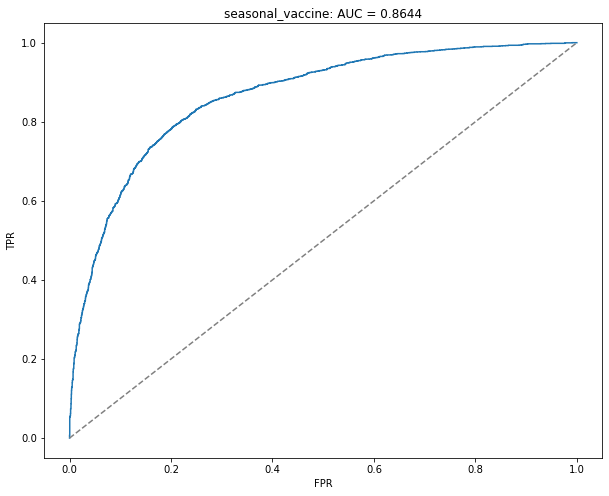

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y2_test, 
    sea_proba, 
    'seasonal_vaccine',
    ax=ax
)

In [30]:
tt = test.drop('respondent_id',axis=1)
test['h1n1_vaccine'] = h1n1_model.predict_proba(tt)[:,1]
test['seasonal_vaccine'] = sea_model.predict_proba(tt)[:,1]

In [31]:
sub = test[['respondent_id','h1n1_vaccine','seasonal_vaccine']].set_index('respondent_id')
sub.to_csv('submission.csv')

In [32]:
sub

h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.100243          0.268975
26708              0.021651          0.029627
26709              0.175805          0.724460
26710              0.569718          0.866337
26711              0.256932          0.450022
...                     ...               ...
53410              0.276521          0.530394
53411              0.183592          0.280467
53412              0.123771          0.112519
53413              0.035305          0.351411
53414              0.534943          0.718902

[26708 rows x 2 columns]

Analyze the catboost models

In [33]:
import shap
shap.initjs()

In [41]:
# visualize the h1n1 vaccine prediction's explanation
explainer_h1n1 = shap.TreeExplainer(h1n1_model)
shap_values_h1n1 = explainer_h1n1.shap_values(Pool(X_train, y1_train, cat_features=X_train.columns.to_list()))
shap.force_plot(explainer_h1n1.expected_value, shap_values_h1n1[0,:], X_train.iloc[0,:])

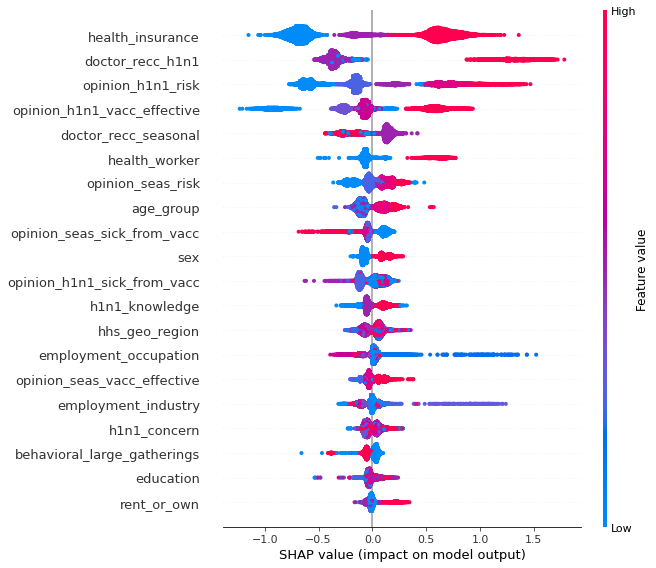

In [34]:
# summarize the effects of all the features to h1n1 vaccine prediction
shap.summary_plot(shap_values_h1n1, X_train)

Top 5 features in the h1n1 catboost model:
    
    a. Whether respondent has health insurance or not.
    b. Whether the h1n1 vaccine was recommended by doctor or not.
    c. Respondent's opinion about risk of getting sick with h1n1 without vaccine.
    d. Respondent's opinion about h1n1 vaccine effectiveness.
    e. Whether the seasonal flu vaccine was recommended by doctor or not.

In [42]:
# visualize the seasonal flu vaccine prediction's explanation
explainer_sea = shap.TreeExplainer(sea_model)
shap_values_sea = explainer_sea.shap_values(Pool(X_train, y2_train, cat_features=X_train.columns.to_list()))
shap.force_plot(explainer_sea.expected_value, shap_values_sea[0,:], X_train.iloc[0,:])

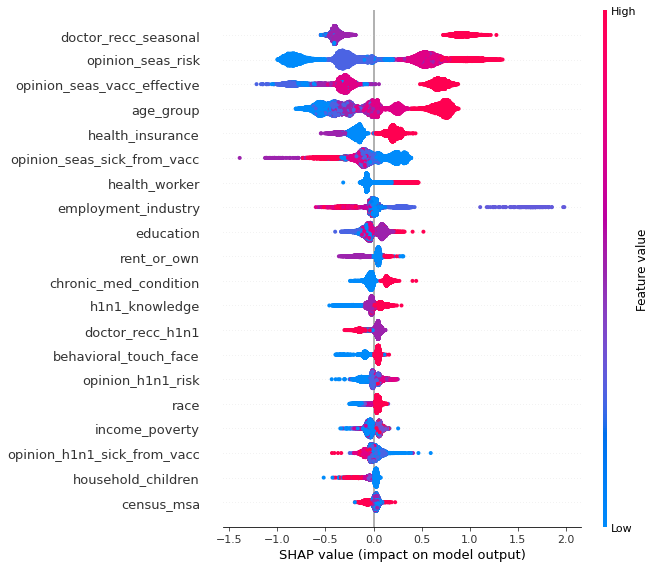

In [35]:
# summarize the effects of all the features to seasonal flu vaccine prediction
shap.summary_plot(shap_values_sea, X_train)

Top 5 features in the seasonal flu catboost model:
    
    a. Whether the seasonal flu vaccine was recommended by doctor or not.
    b. Respondent's opinion about risk of getting sick with seasonal flu without vaccine
    c. Respondent's opinion about seasonal flu vaccine effectiveness.
    d. Age.
    e. Whether respondent has health insurance or not.